In [7]:
# %%capture
# !apt-get update
# !apt-get install -y cmake
!pip install gym[atari]
!pip install JSAnimation

    100% |################################| 1.5MB 830kB/s ta 0:00:011
    100% |################################| 1.0MB 1.2MB/s ta 0:00:011
    100% |################################| 768kB 1.0MB/s ta 0:00:011
    100% |################################| 2.0MB 641kB/s ta 0:00:011
    100% |################################| 1.2MB 848kB/s ta 0:00:011
    100% |################################| 829kB 1.3MB/s ta 0:00:011
  Running setup.py bdist_wheel for gym ... done
  Stored in directory: /root/.cache/pip/wheels/55/10/54/738634b5a554fc825283685db35371481d66137018ad2c9365
  Running setup.py bdist_wheel for atari-py ... error
  Complete output from command /root/miniconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-pqhg6v6b/atari-py/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmp0hpnsqvjpip-wheel- --python-tag cp36:
  running bdist_wheel
  running bu

  Running setup.py bdist_wheel for PyOpenGL ... done
  Stored in directory: /root/.cache/pip/wheels/1c/17/50/f69d63e0a8169fb890f5a167817a73391be85d30e86fd29504
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /root/.cache/pip/wheels/c2/50/7c/0d83b4baac4f63ff7a765bd16390d2ab43c93587fac9d6017a
Successfully built gym PyOpenGL future
Failed to build atari-py
  Running setup.py install for atari-py ... error
    Complete output from command /root/miniconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-pqhg6v6b/atari-py/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-jm6aqip4-record/install-record.txt --single-version-externally-managed --compile:
    running install
    running build
    make: Entering directory '/tmp/pip-build-pqhg6v6b/atari-py/atari_py/ale_interface'
    mkdir -p build && cd build && cmake .. && make -j4
  

Command "/root/miniconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-pqhg6v6b/atari-py/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-jm6aqip4-record/install-record.txt --single-version-externally-managed --compile" failed with error code 1 in /tmp/pip-build-pqhg6v6b/atari-py/
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/f7/c0/a8/742fe7b68eca2b96076bafdcb246bfaff2dcd4a7bce6ee6d58
Successfully built JSAnimation
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
!lsb_release -a

/bin/sh: 1: lsb_release: not found


In [4]:
!which cmake

/usr/bin/cmake


In [5]:
!cmake --version

cmake version 3.5.1

CMake suite maintained and supported by Kitware (kitware.com/cmake).


In [2]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import gym

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.optimizers import rmsprop
import keras.backend as K

from utilities import *

%matplotlib inline

ModuleNotFoundError: No module named 'gym'

In [ ]:
env = gym.make("Pong-v0")

In [4]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))


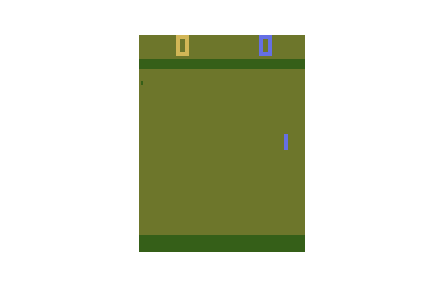
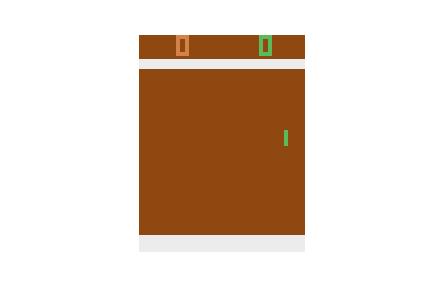
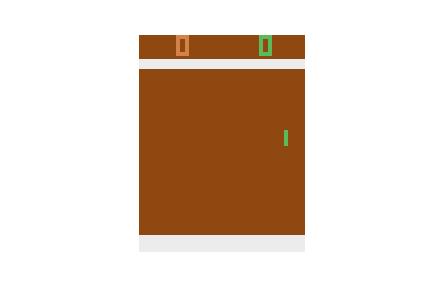
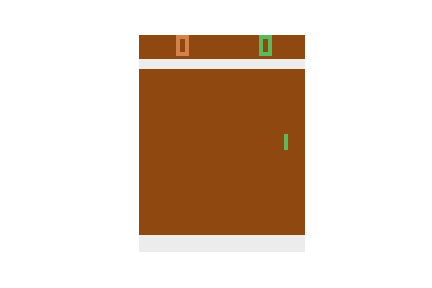
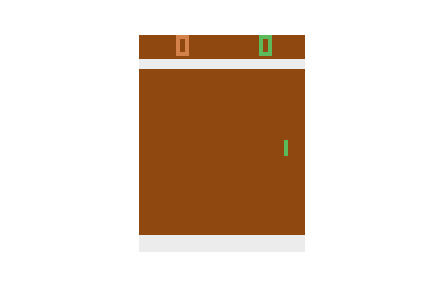
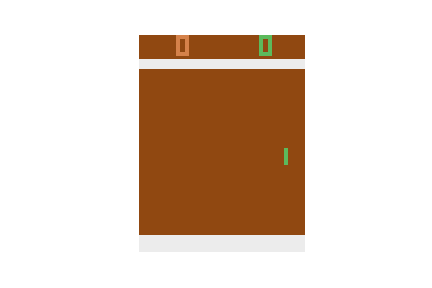
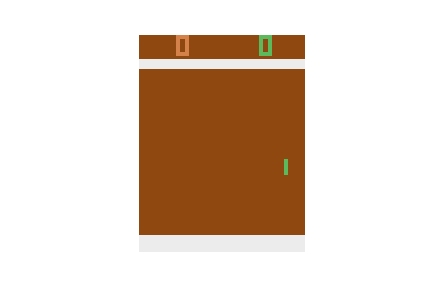
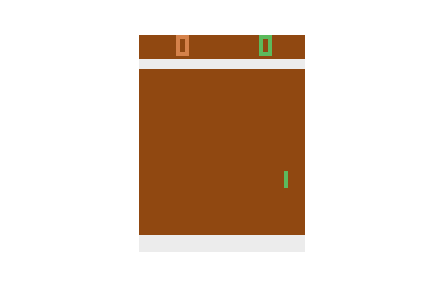
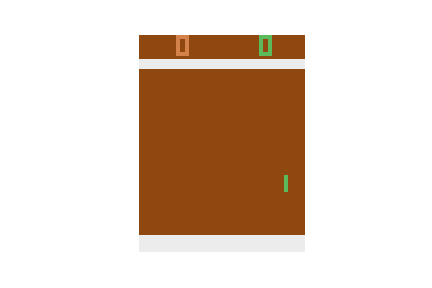
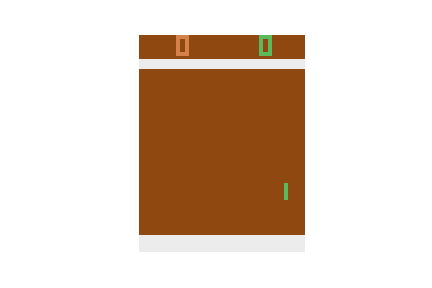
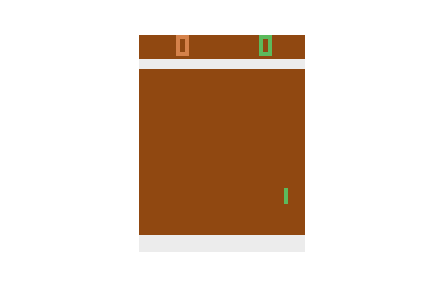
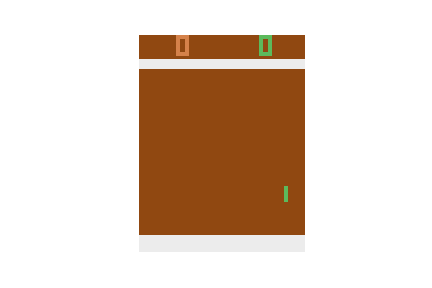
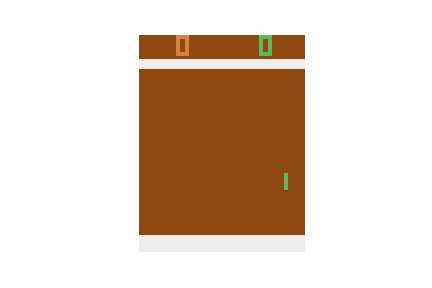
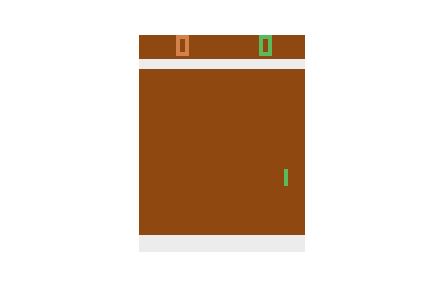
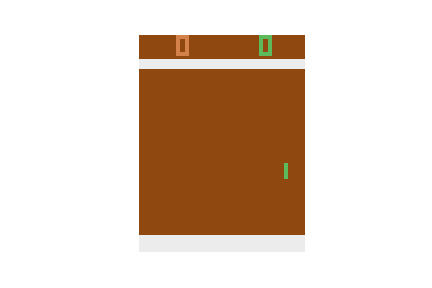
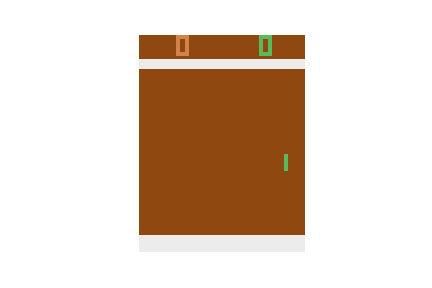
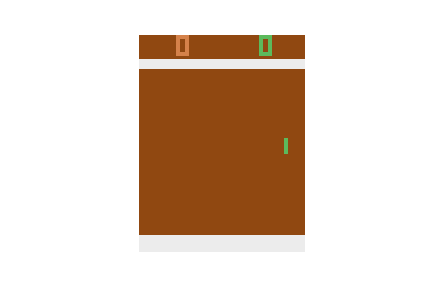
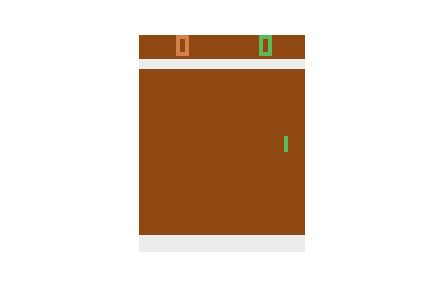
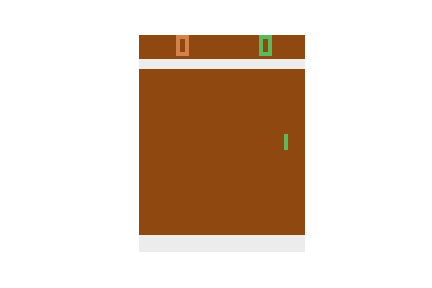
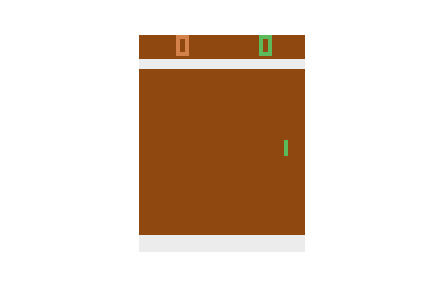
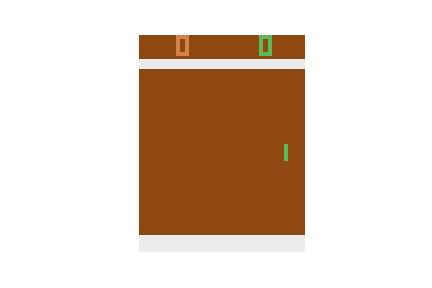
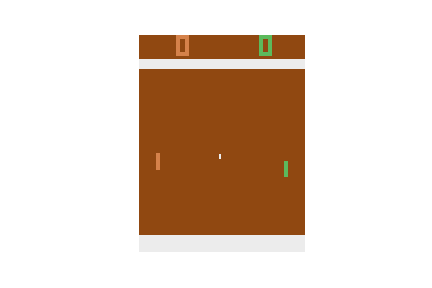
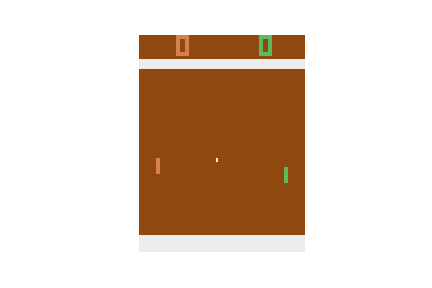
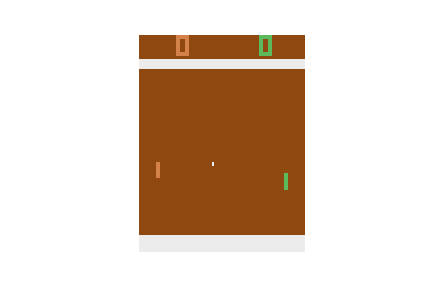
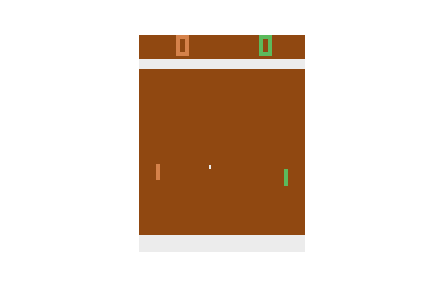
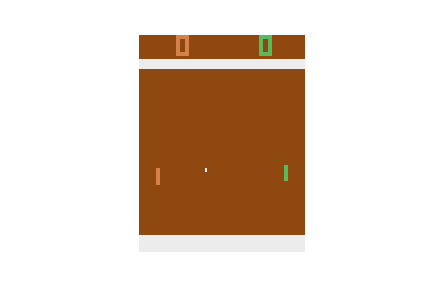
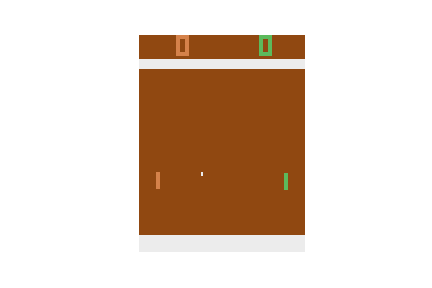
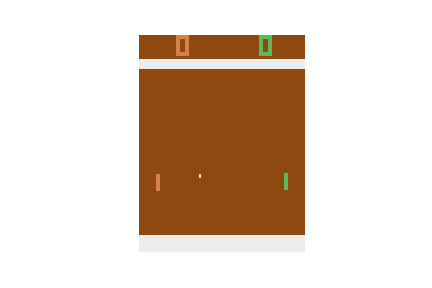
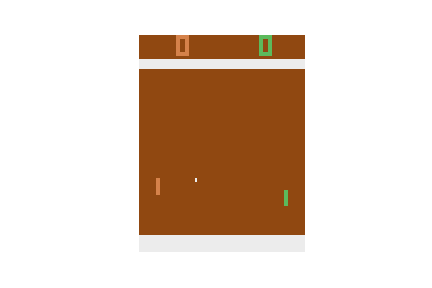
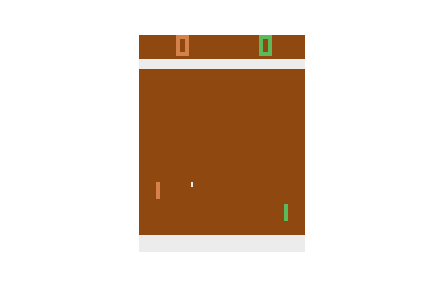
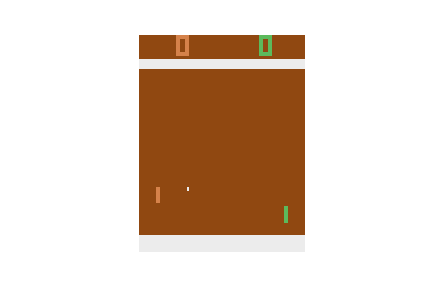
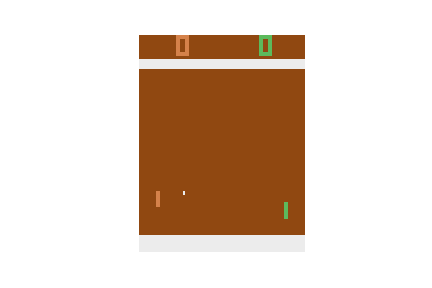
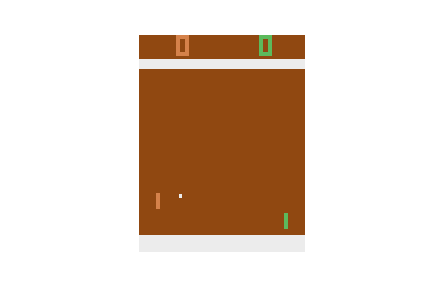
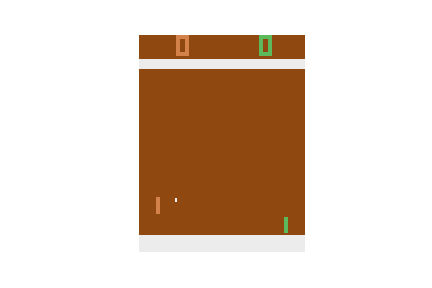
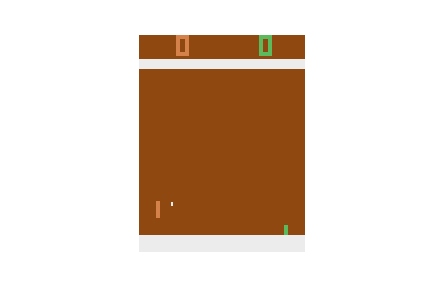
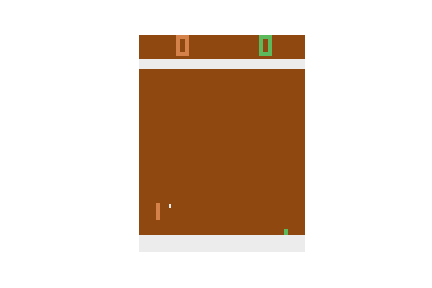
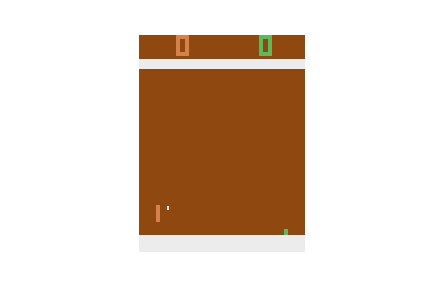
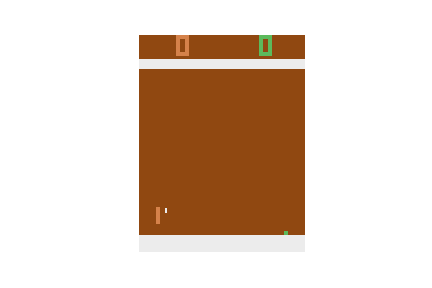
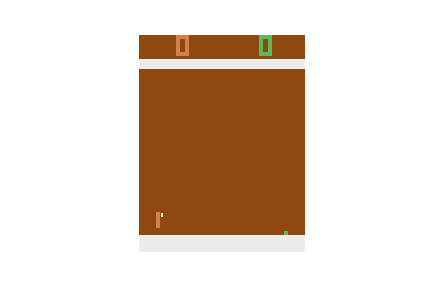
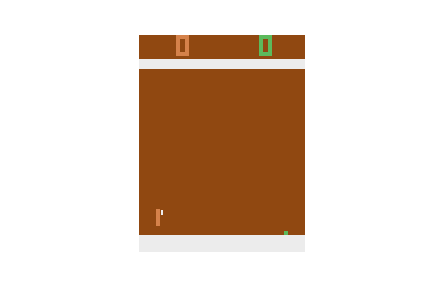
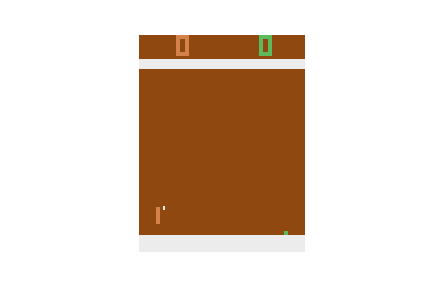
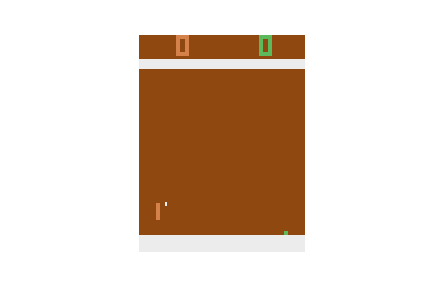
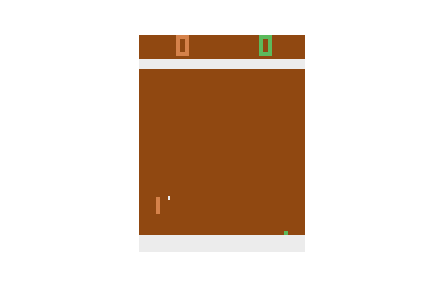
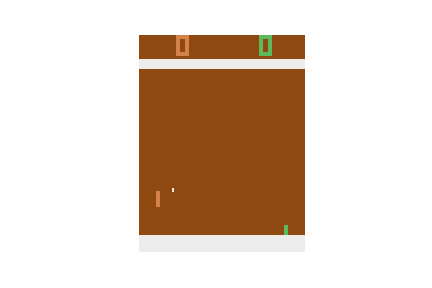
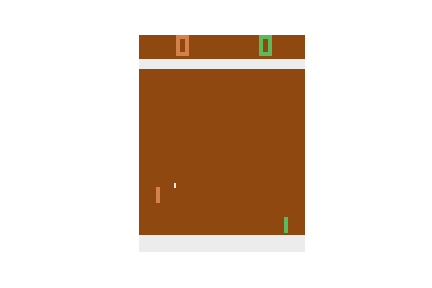
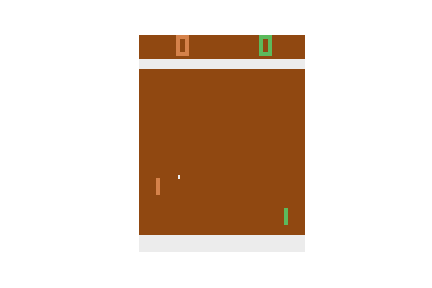
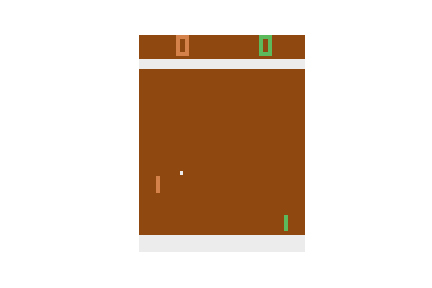
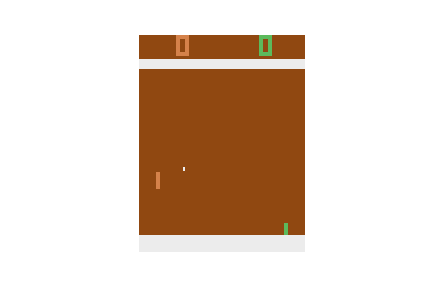
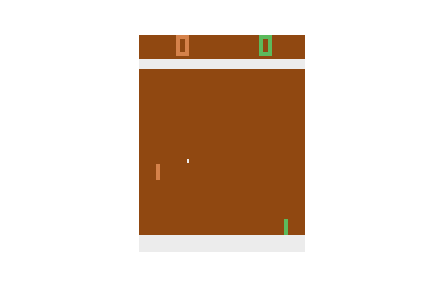
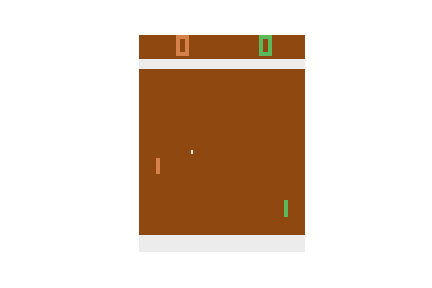
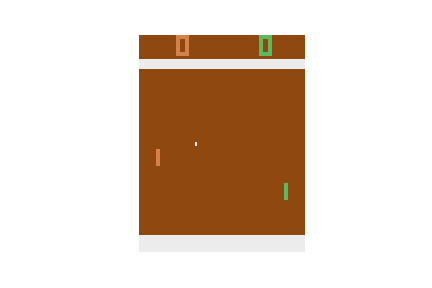
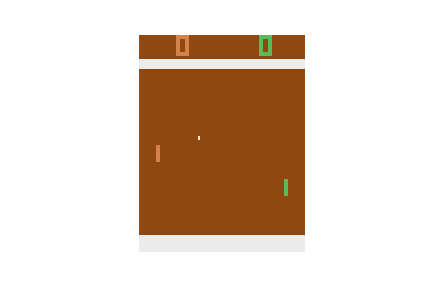
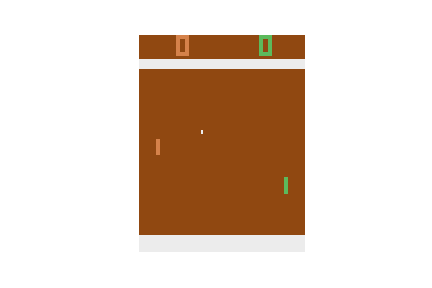
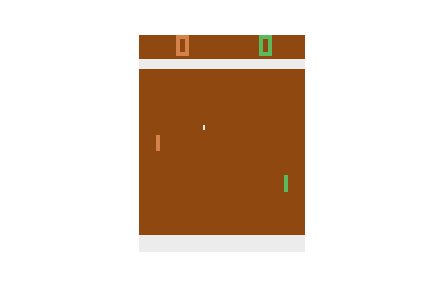
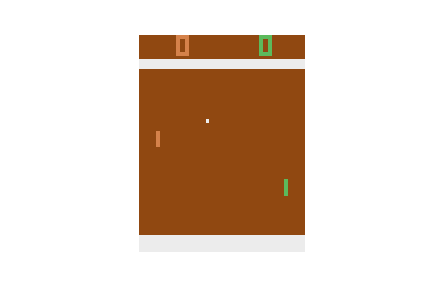
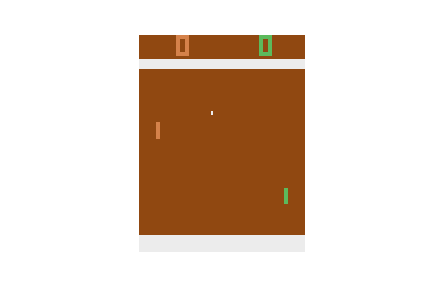
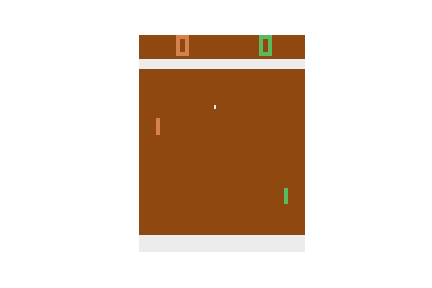
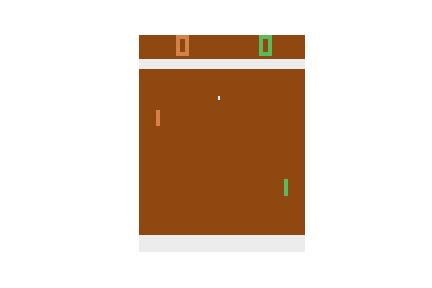
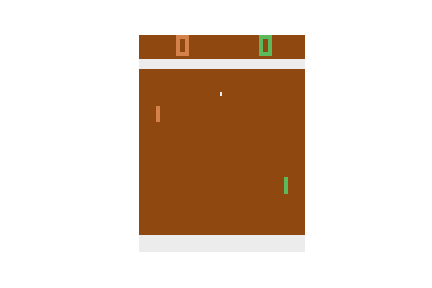
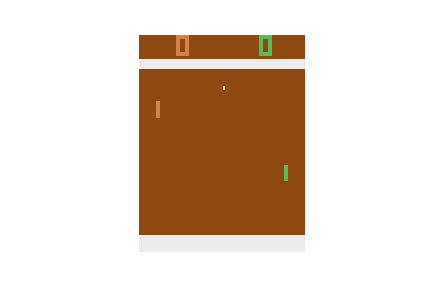
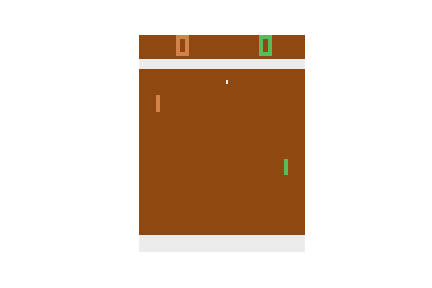
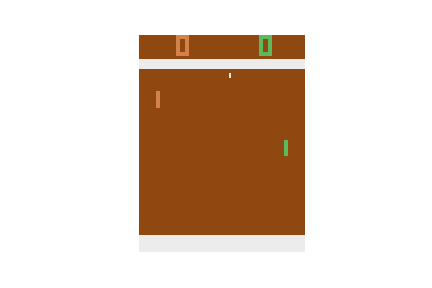
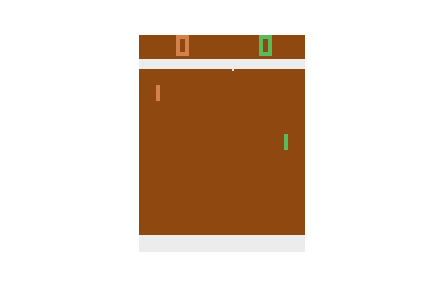
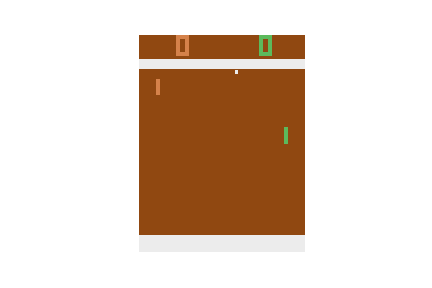
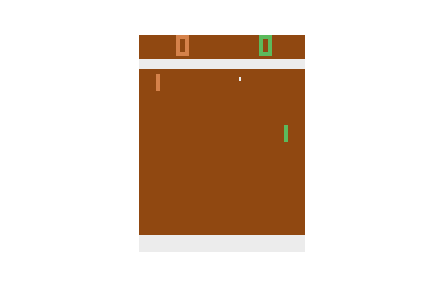
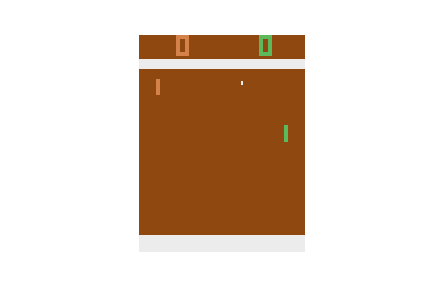
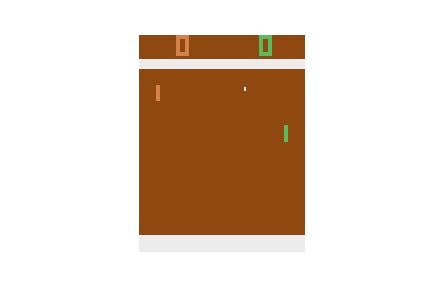
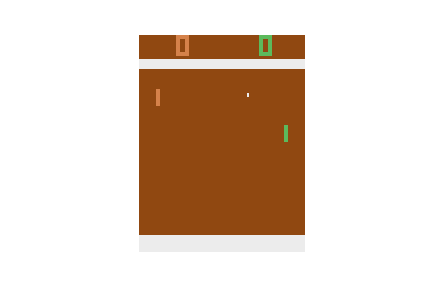
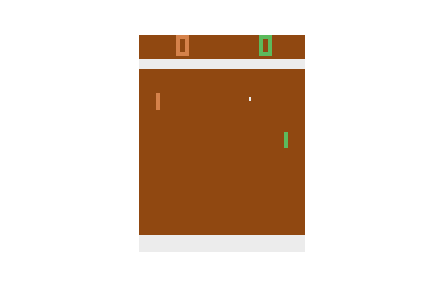
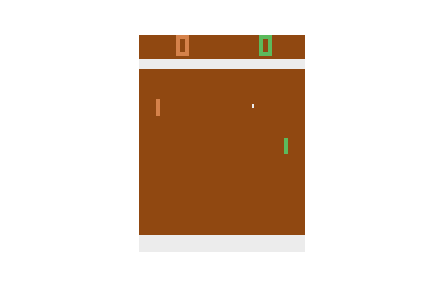
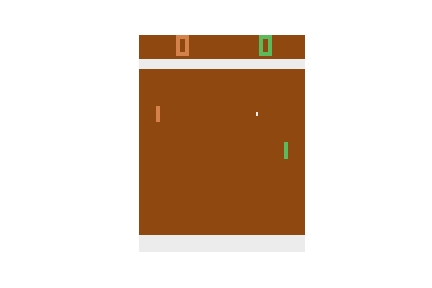
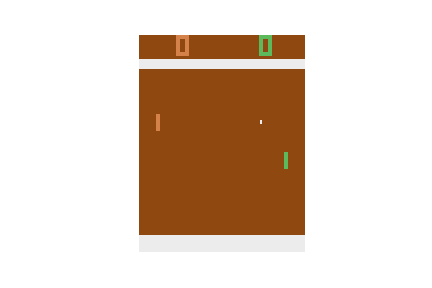
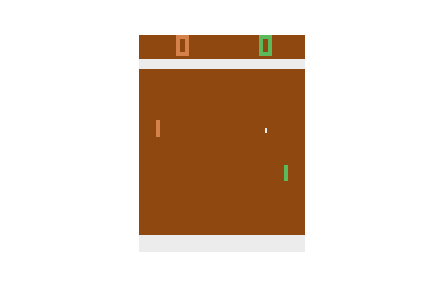
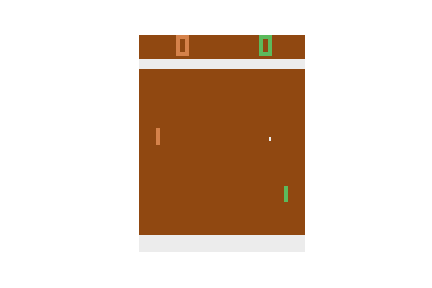
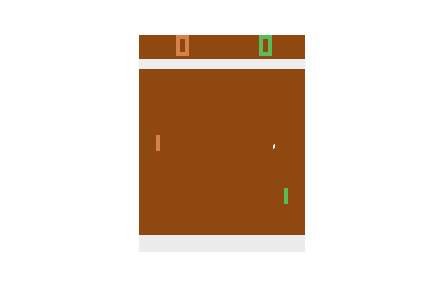
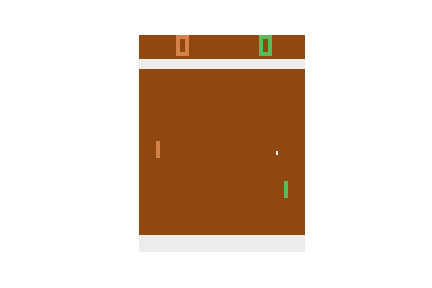
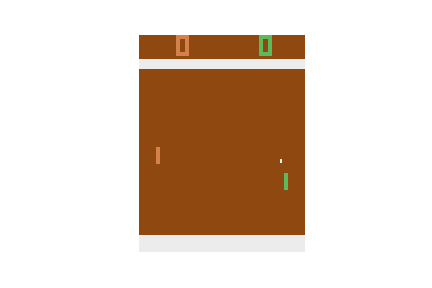
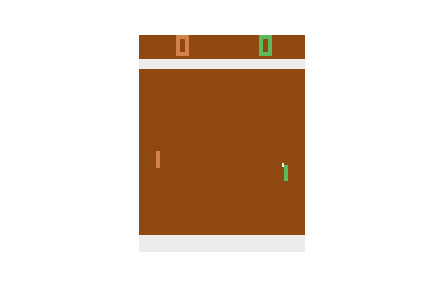
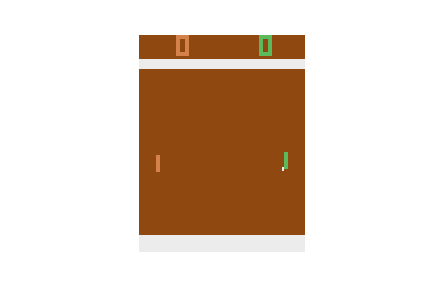
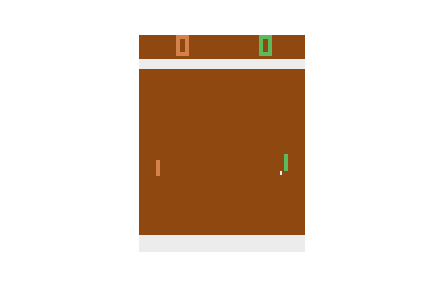
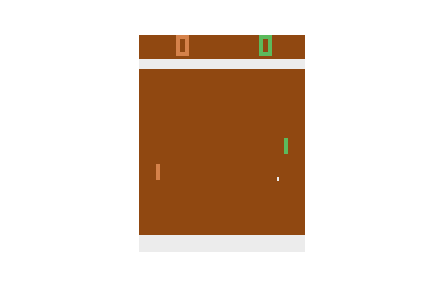
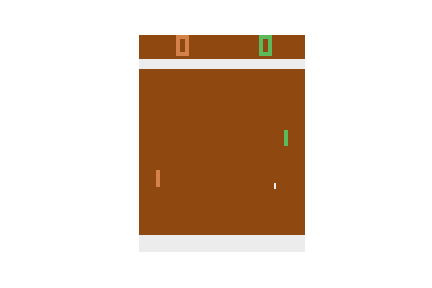
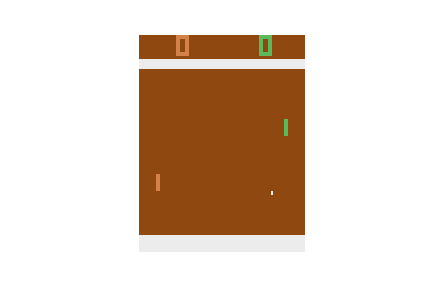
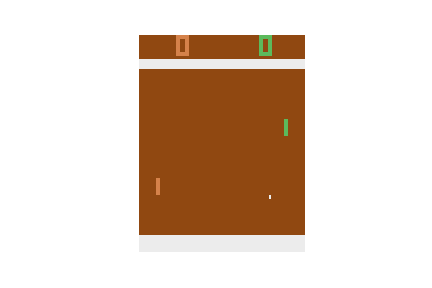
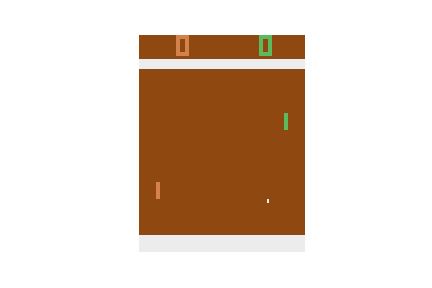
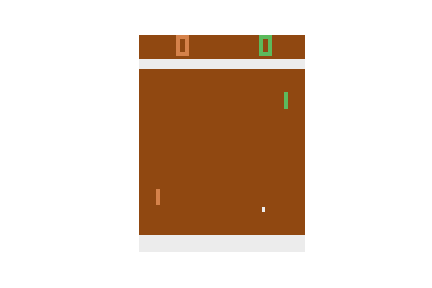
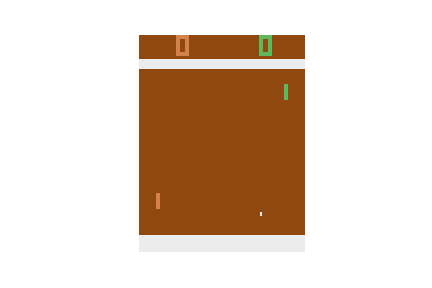
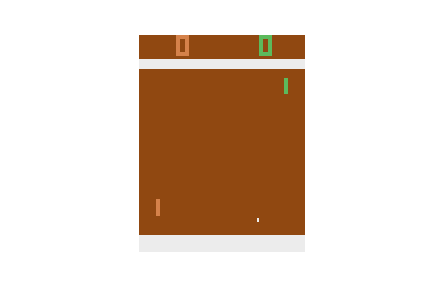
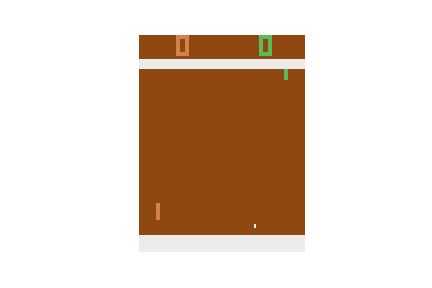
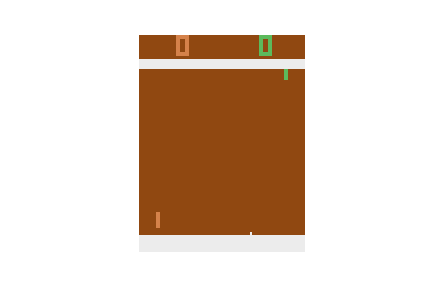
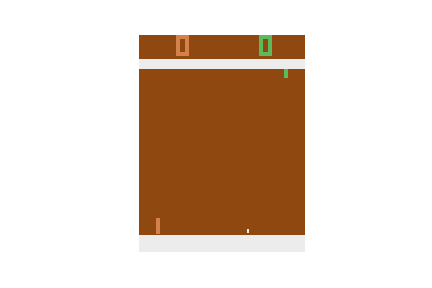
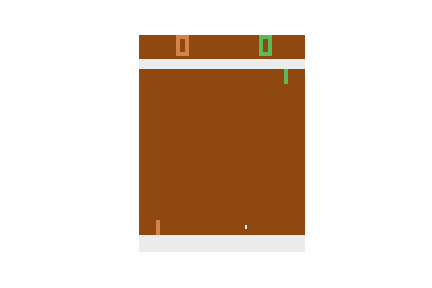
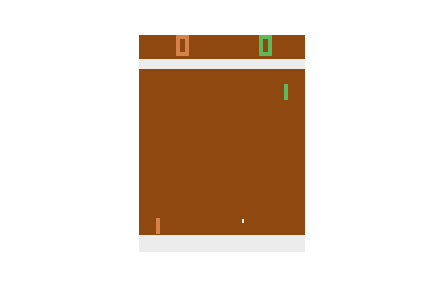
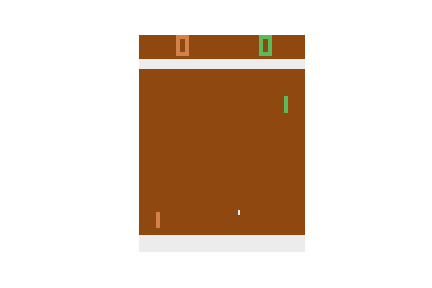
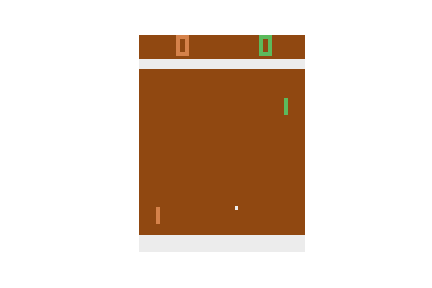
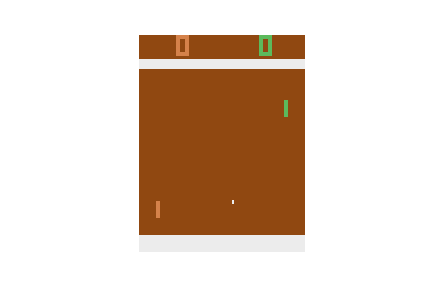
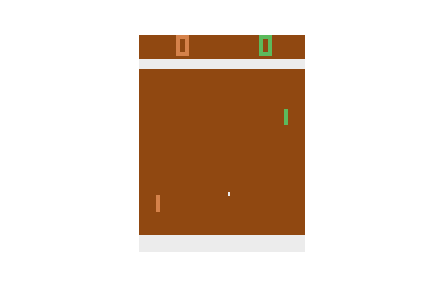
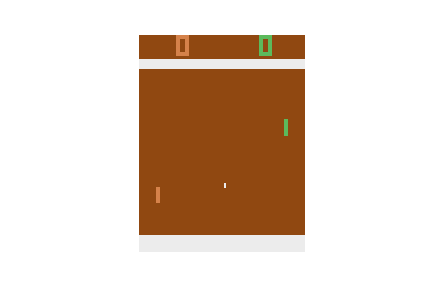
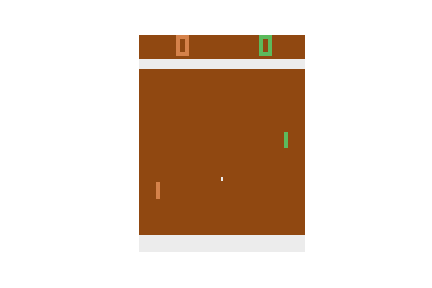
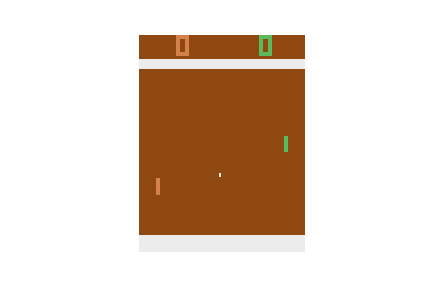
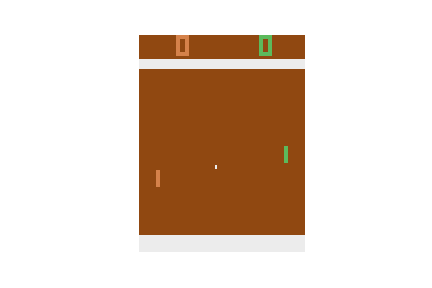
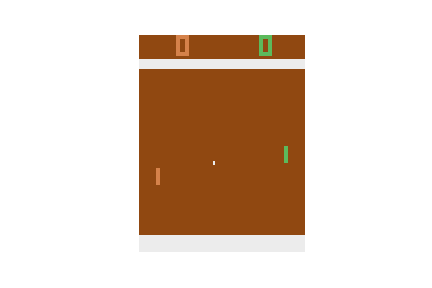
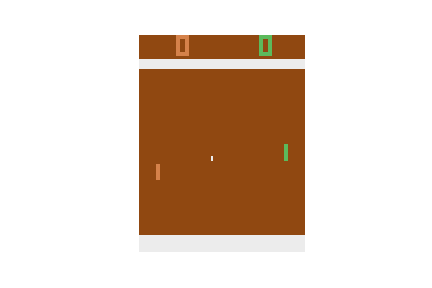
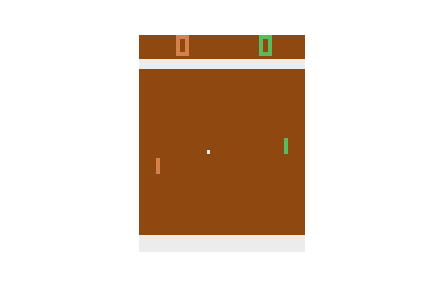
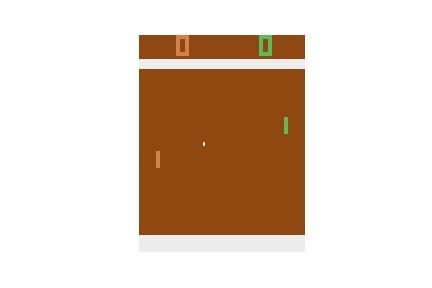
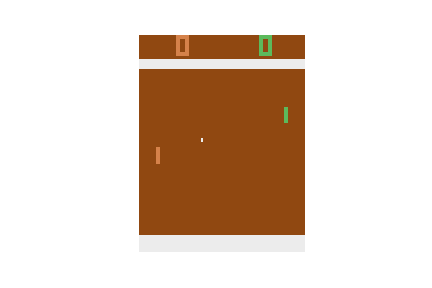
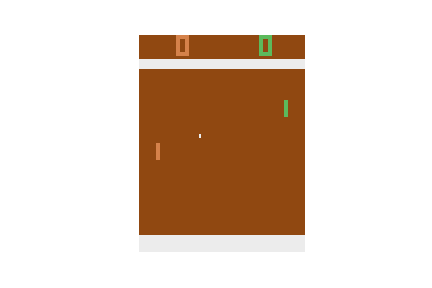
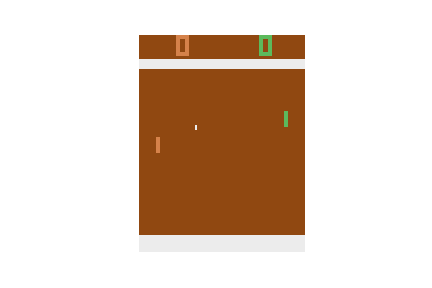
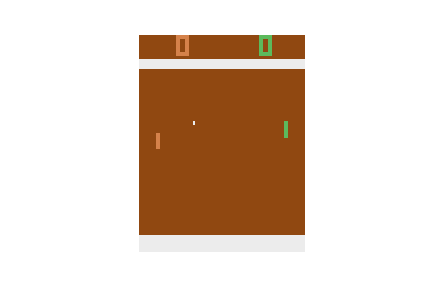
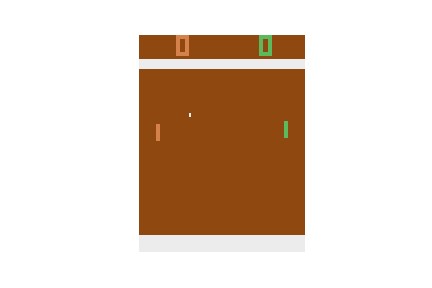
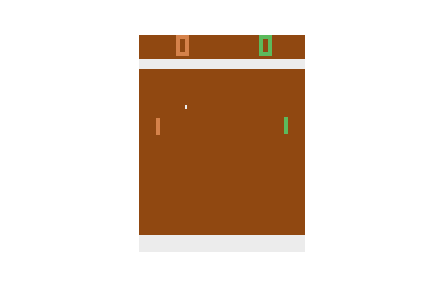
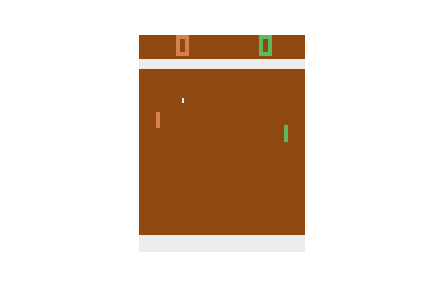
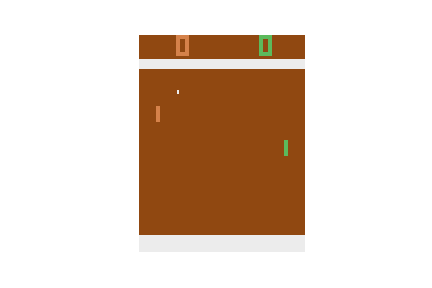
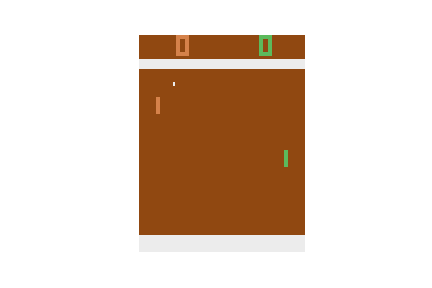
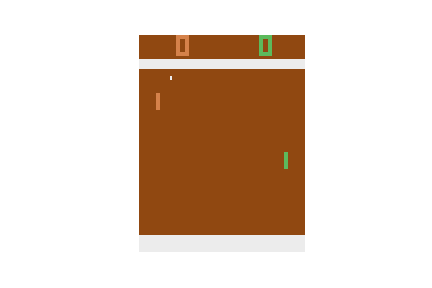
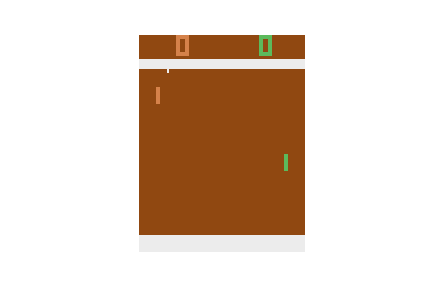
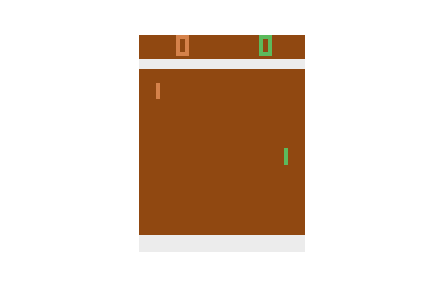
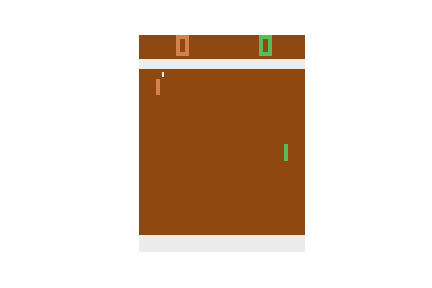
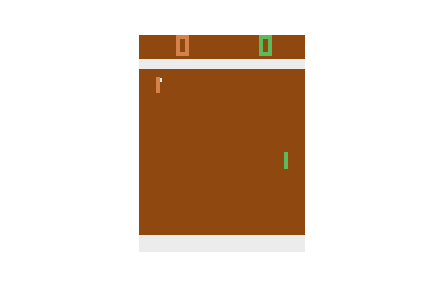
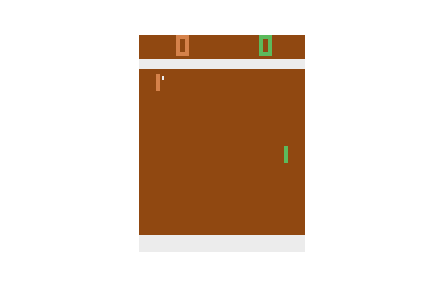
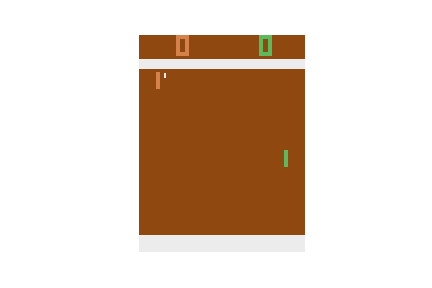
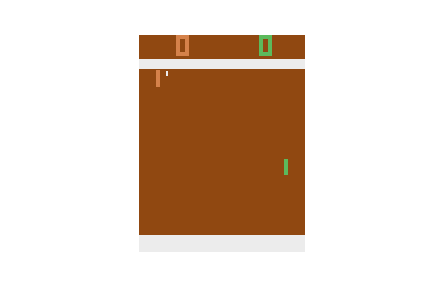
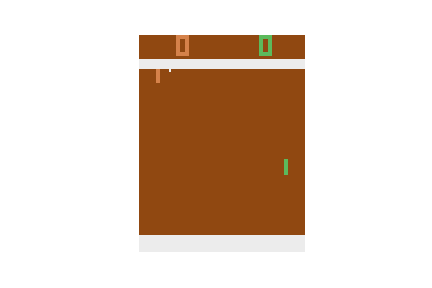
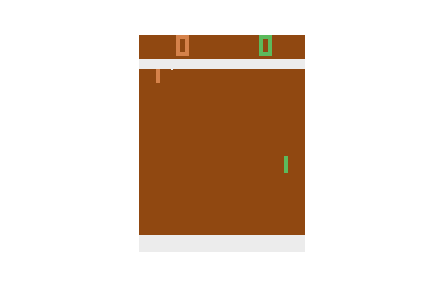
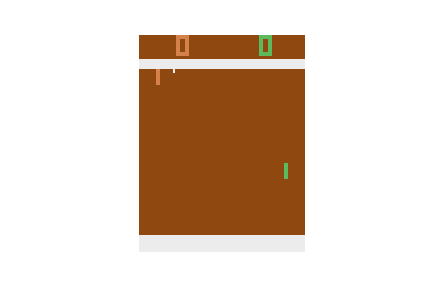
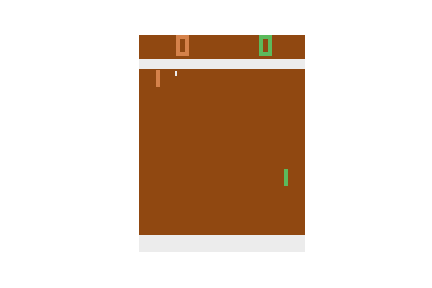
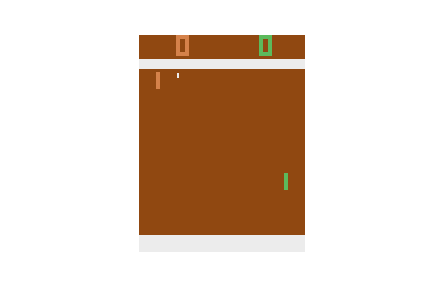
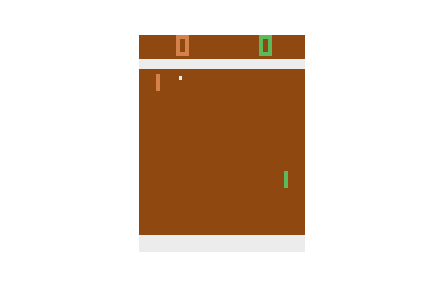
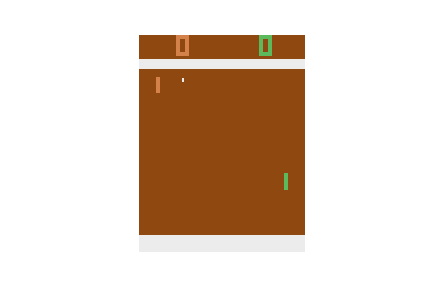
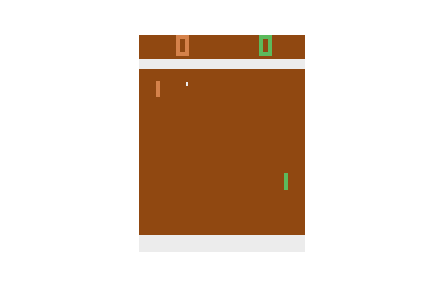
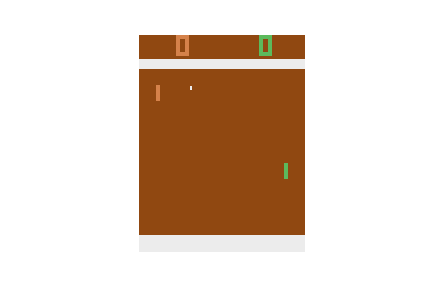
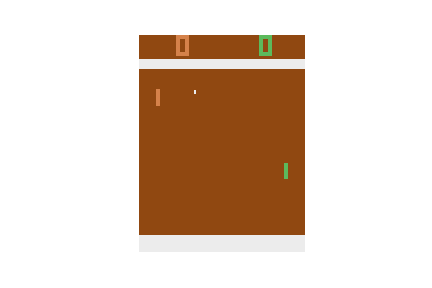
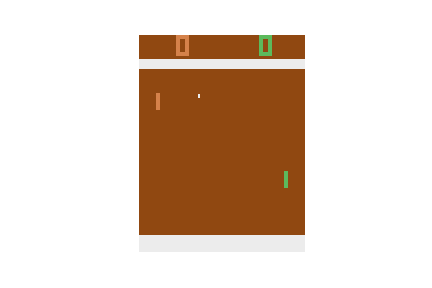
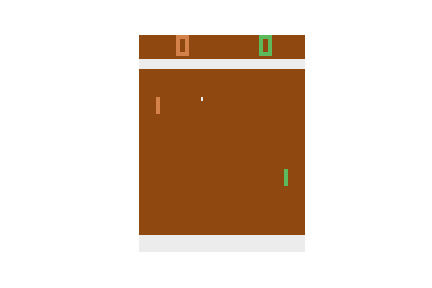
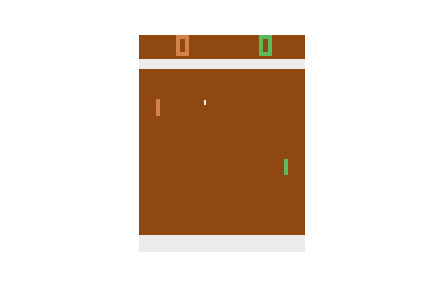
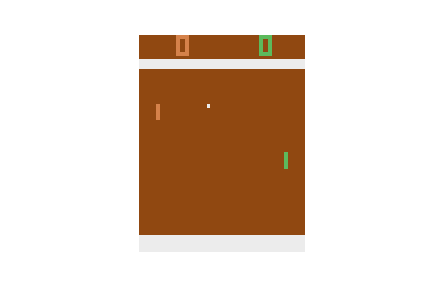
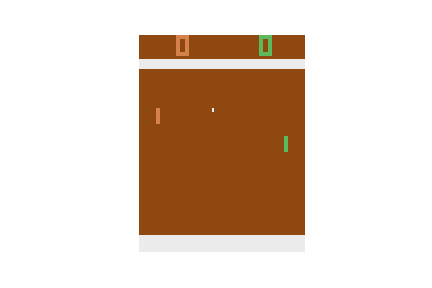
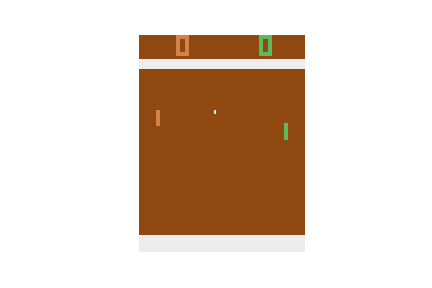
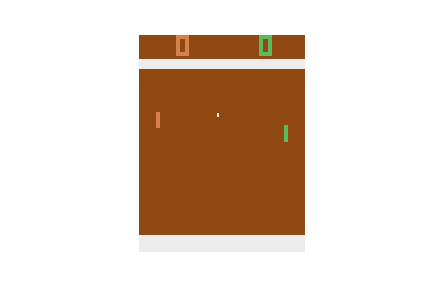
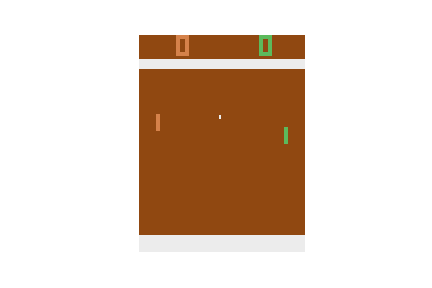
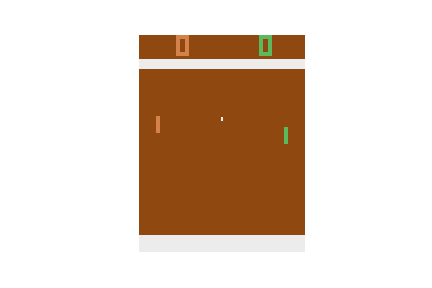
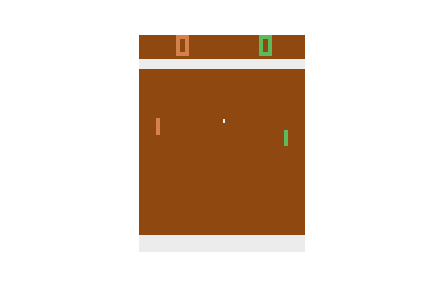
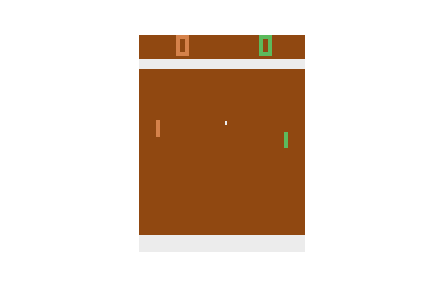
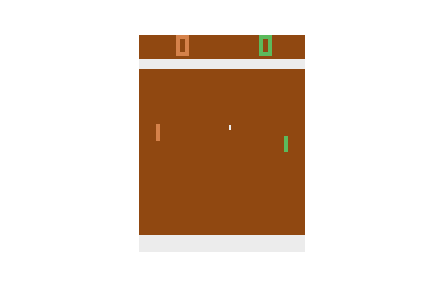
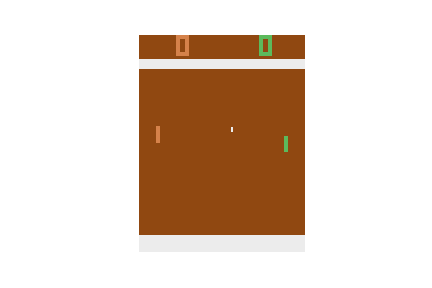
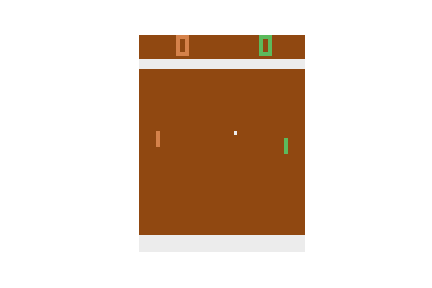
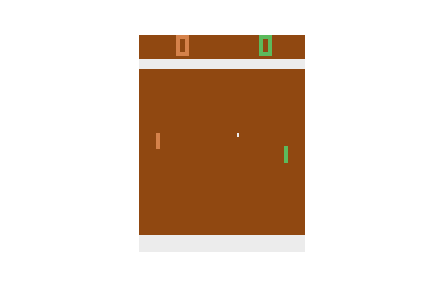
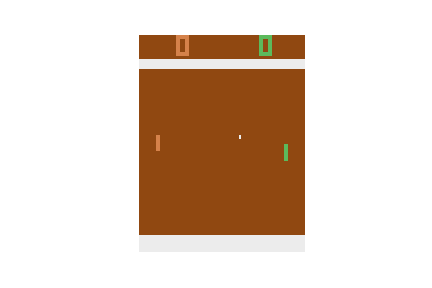
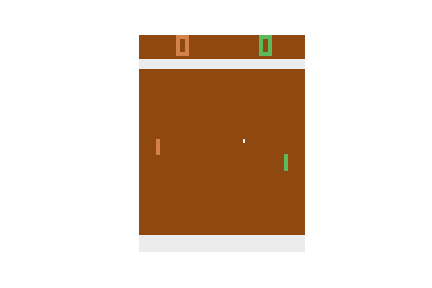
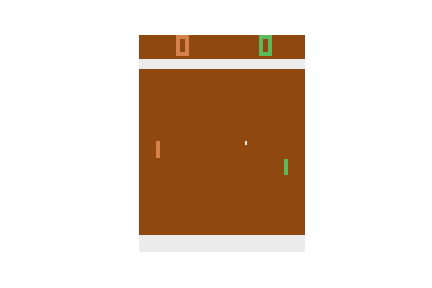
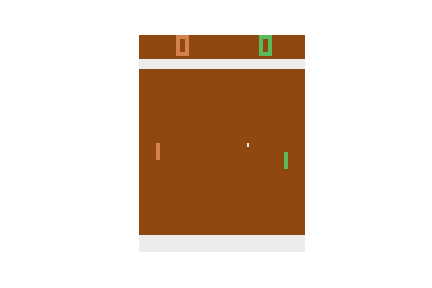
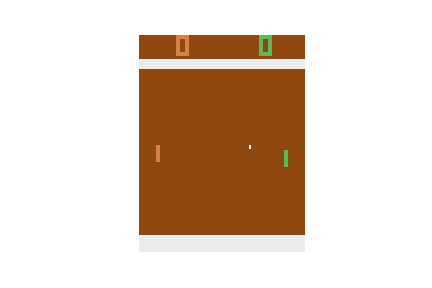
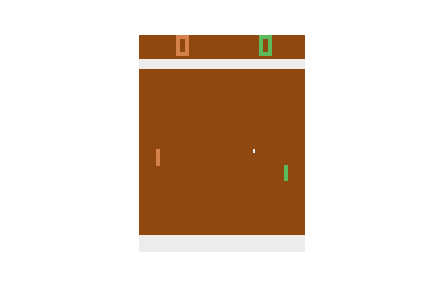
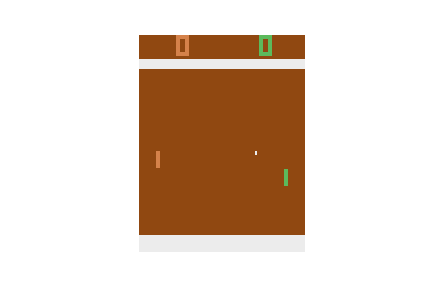
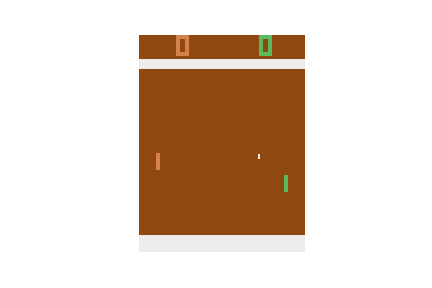
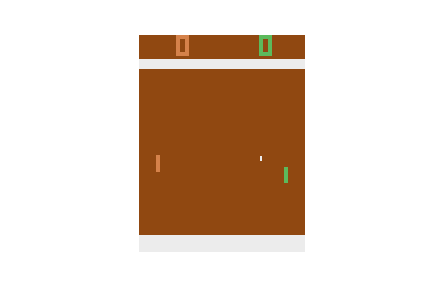
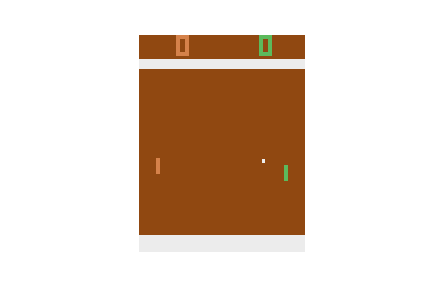
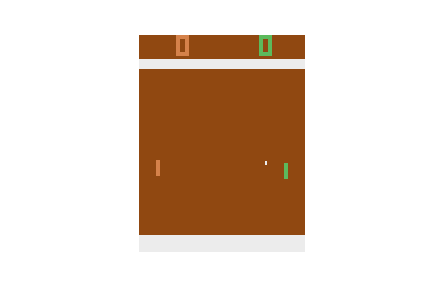
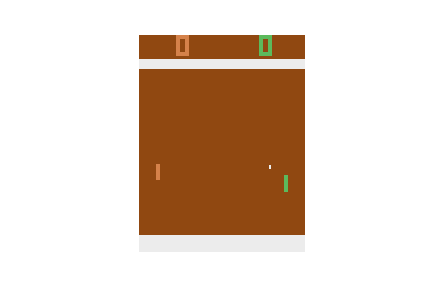
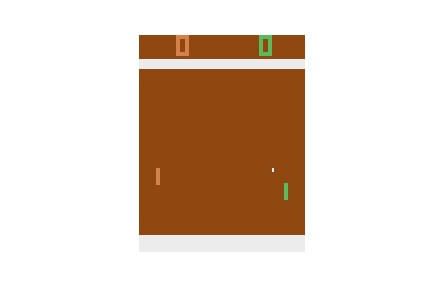
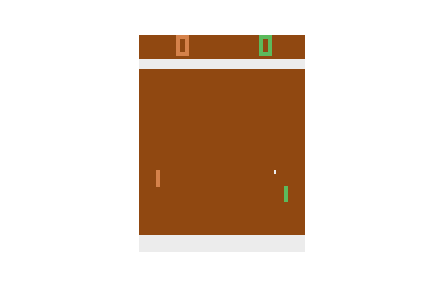
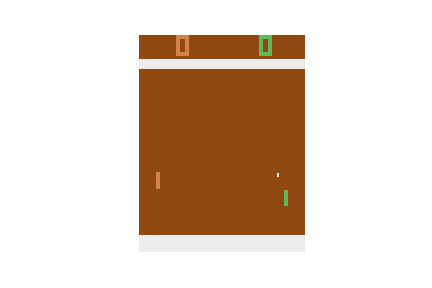
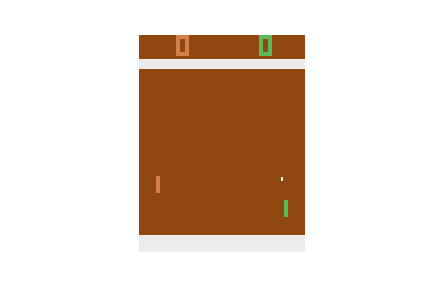
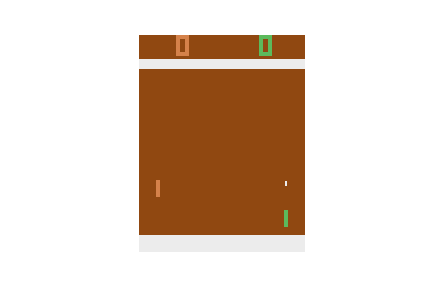
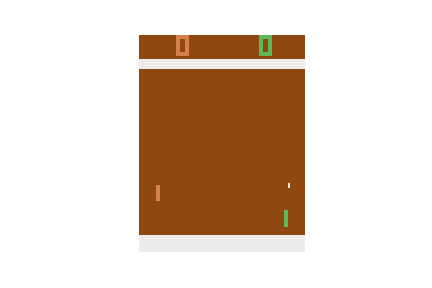
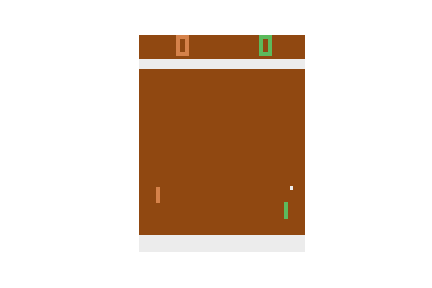
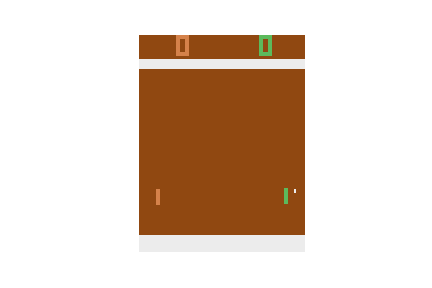
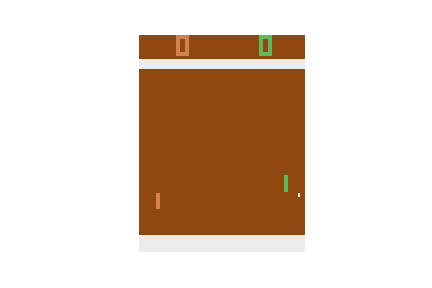
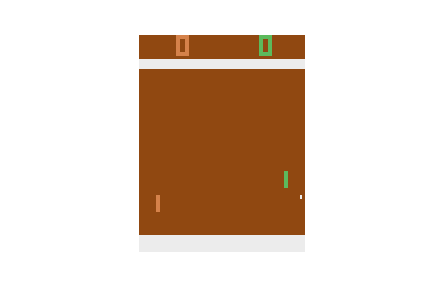
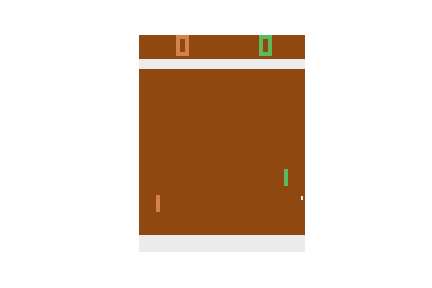
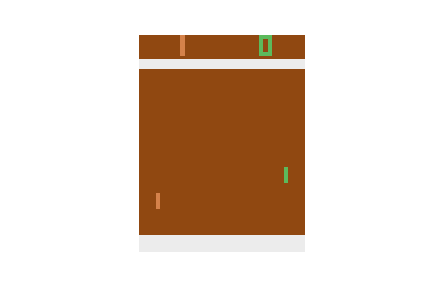
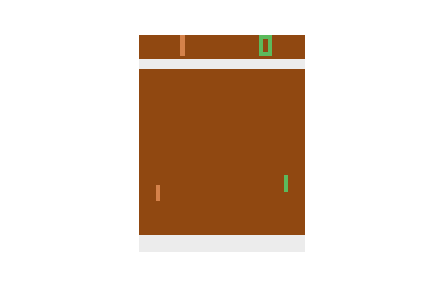
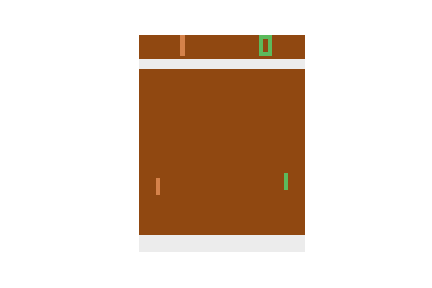
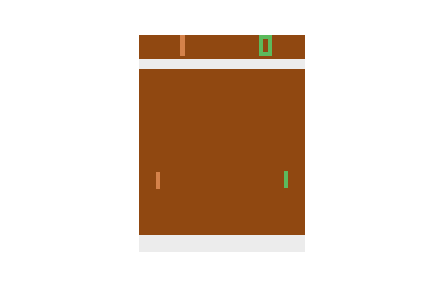
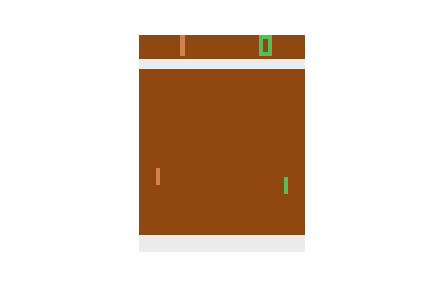
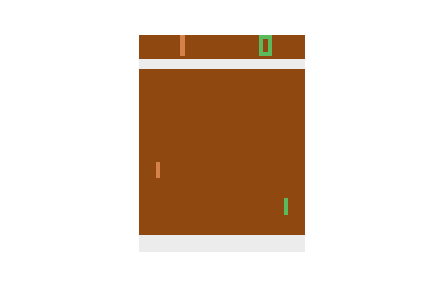
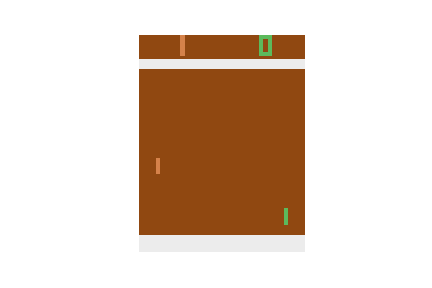
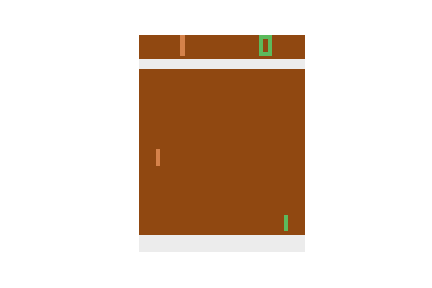
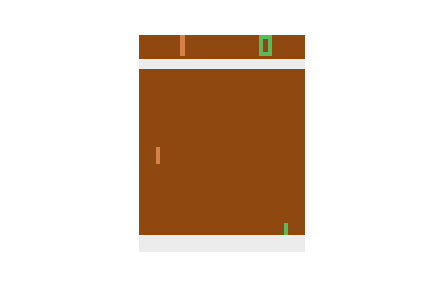
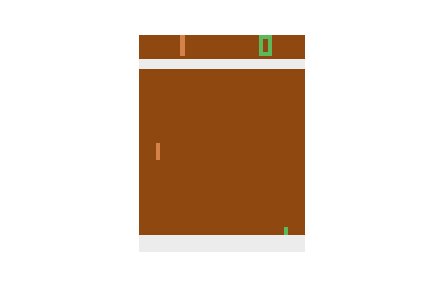
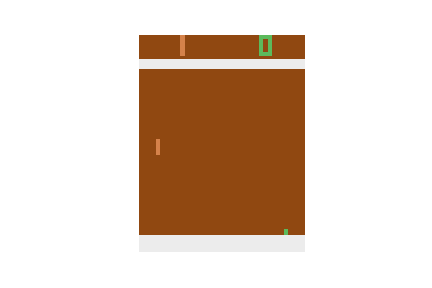
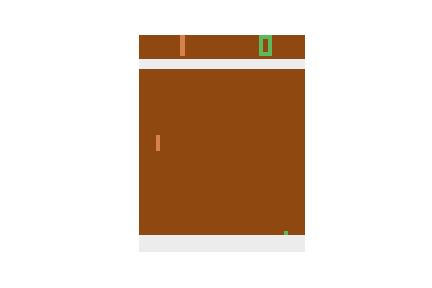
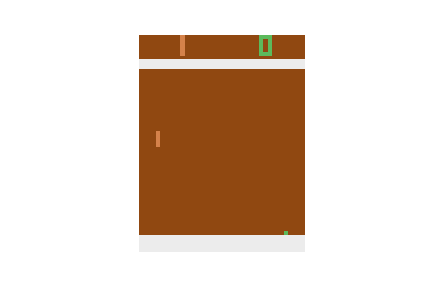
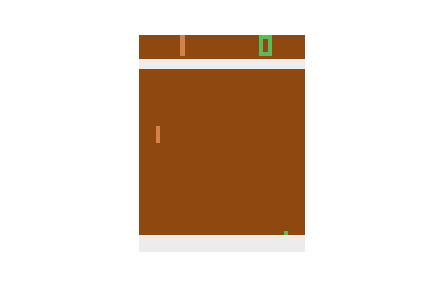
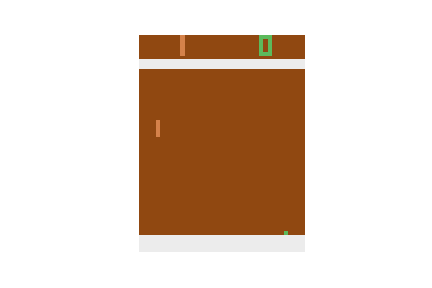
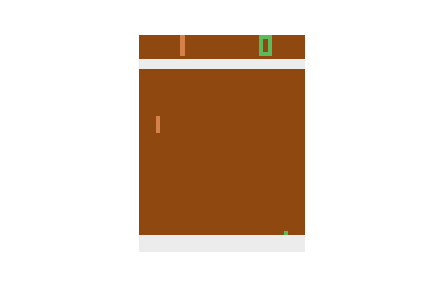
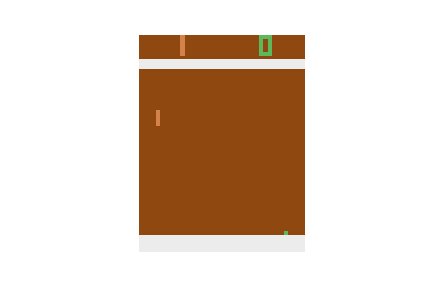
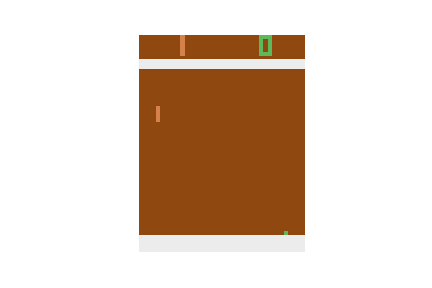
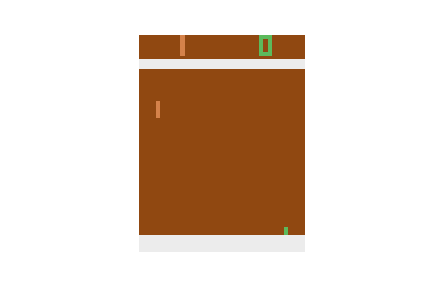
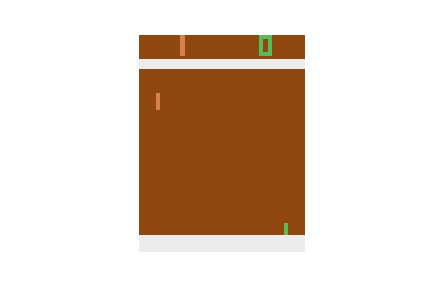
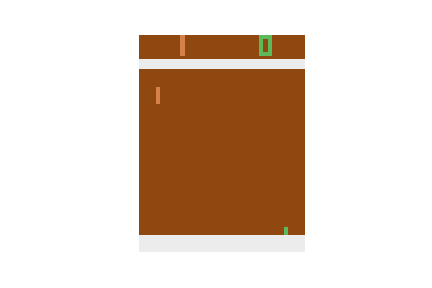
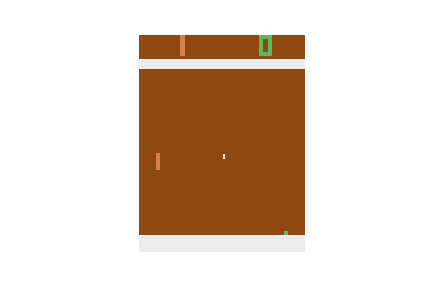
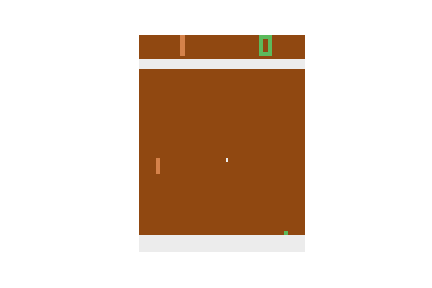
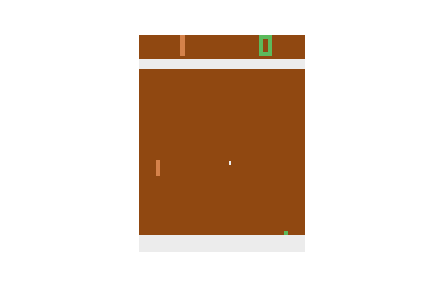
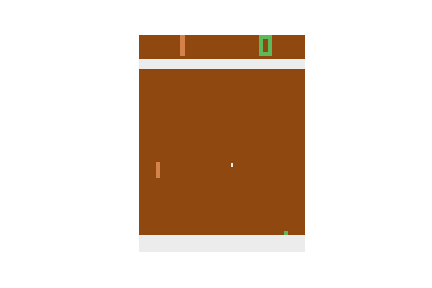
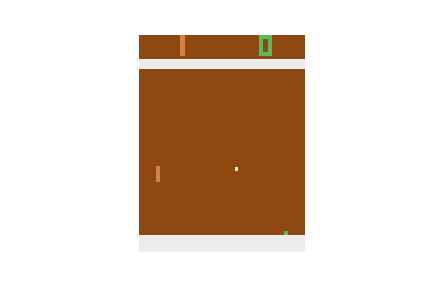
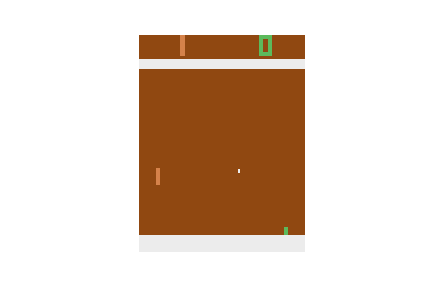
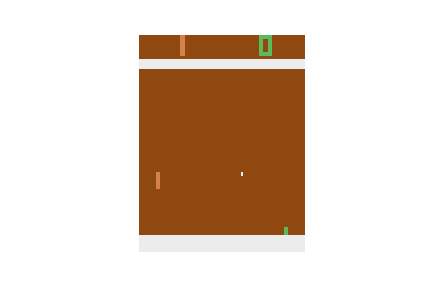
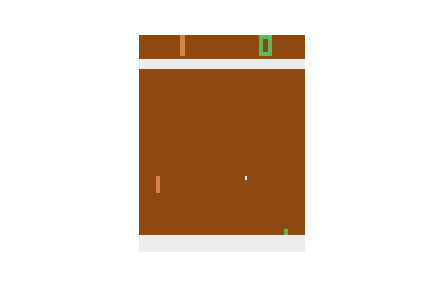
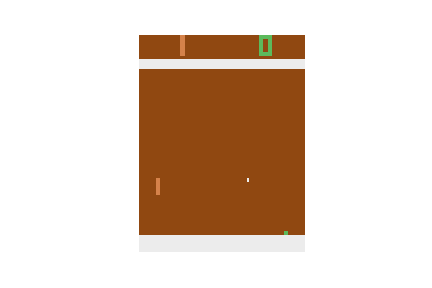
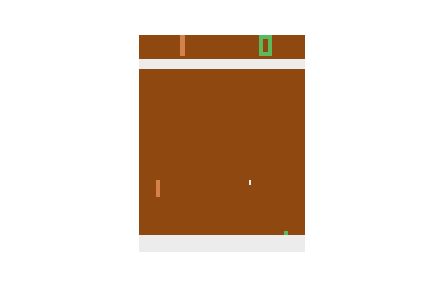
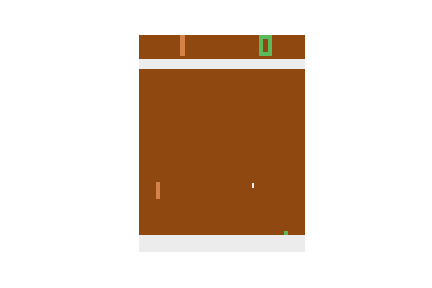
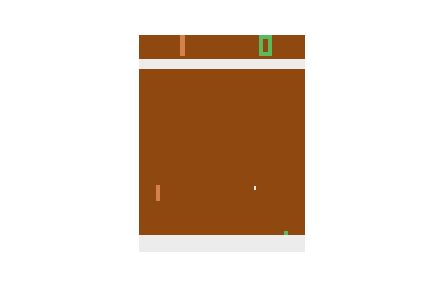
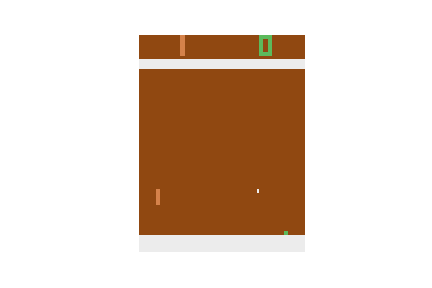
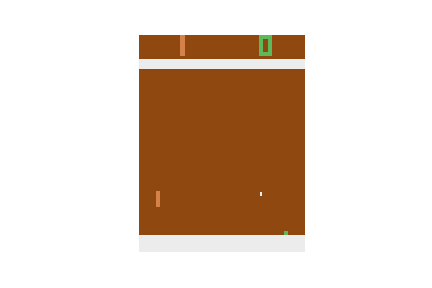
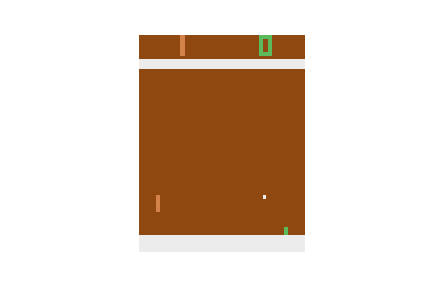
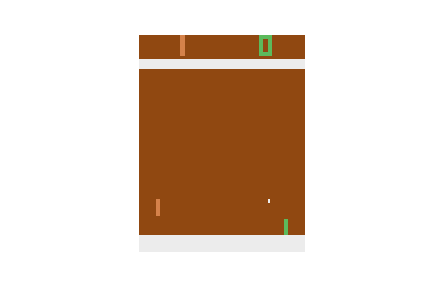
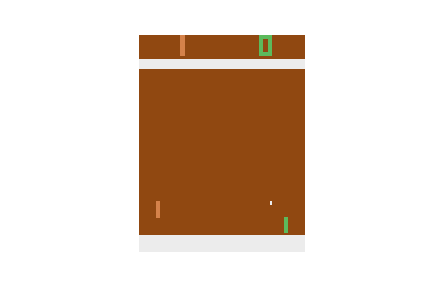
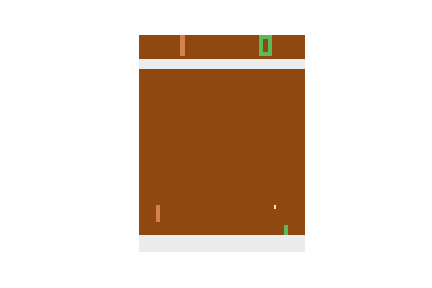
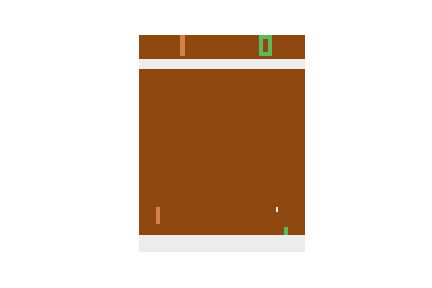
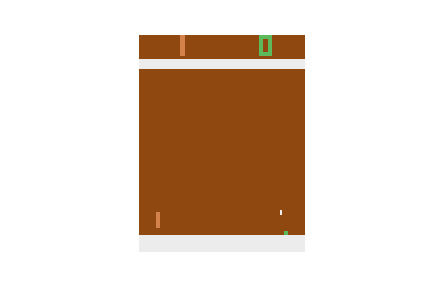
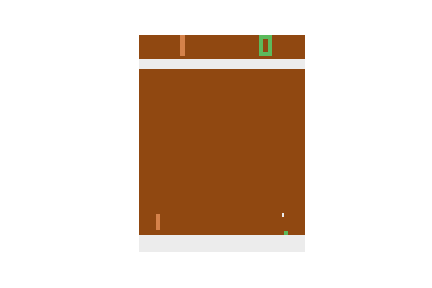
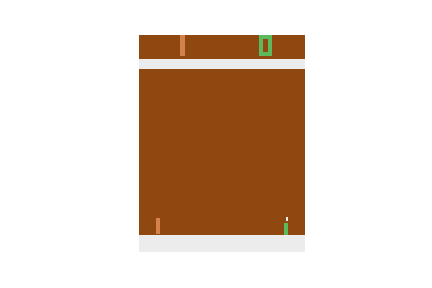
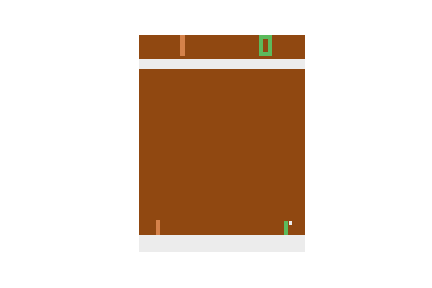
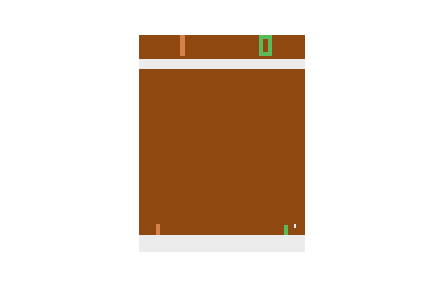
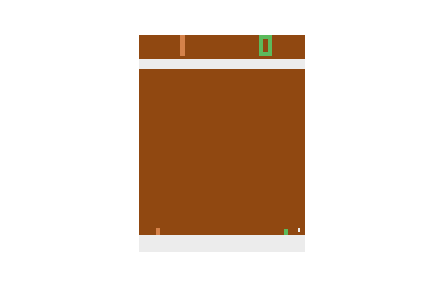
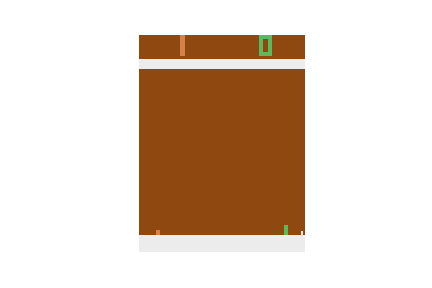
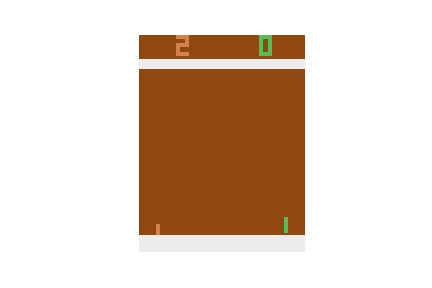
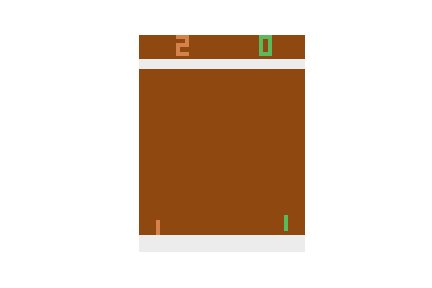
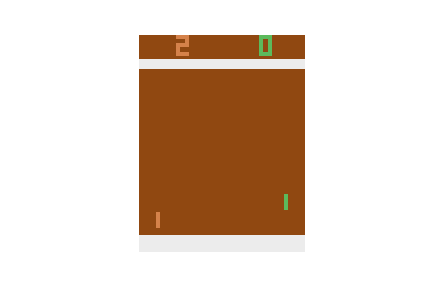
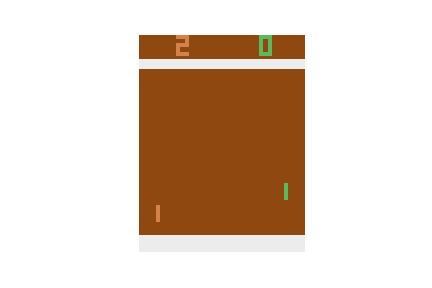
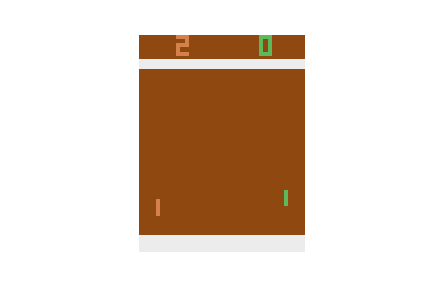
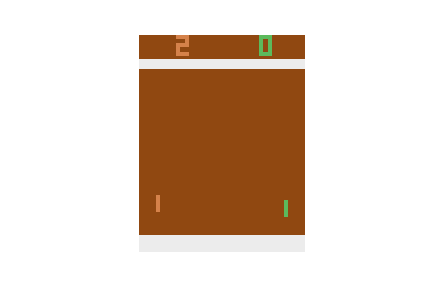
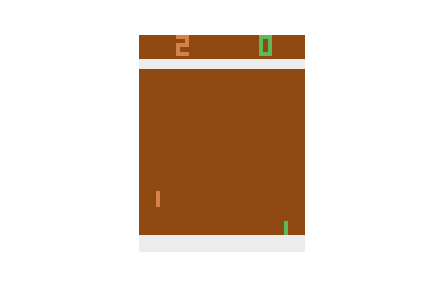
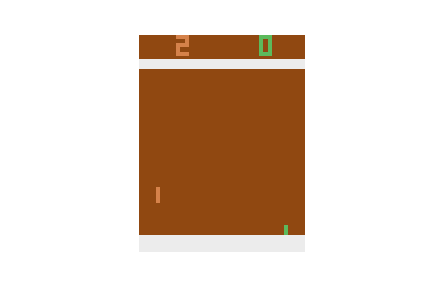
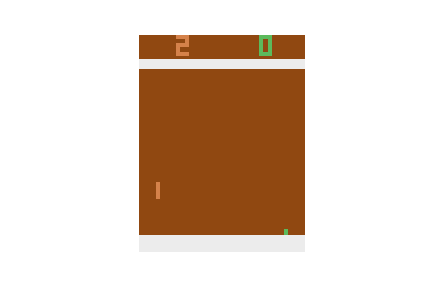
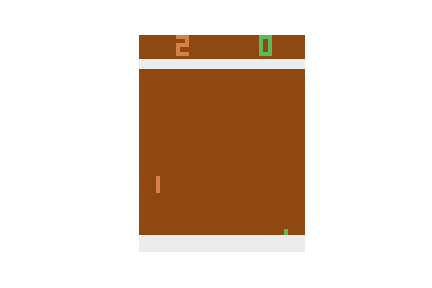
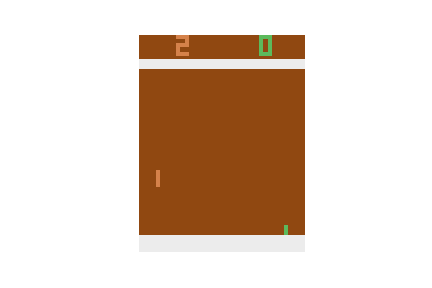
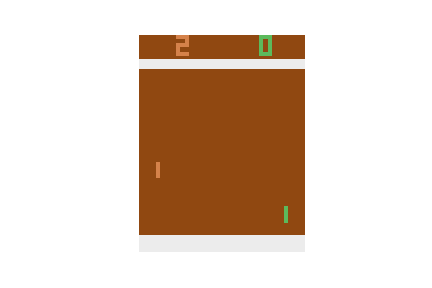
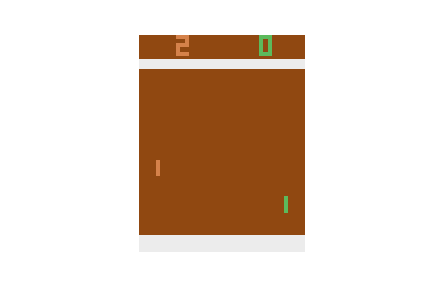
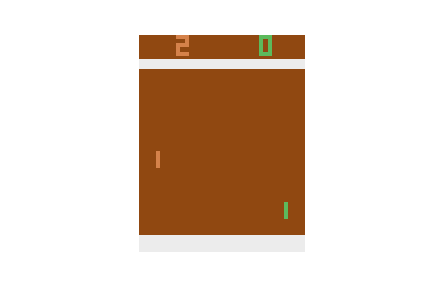
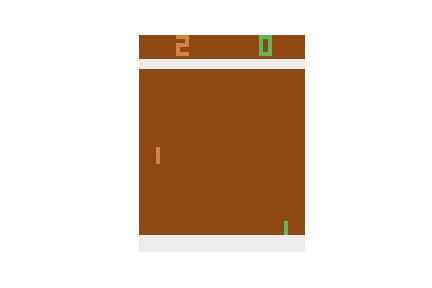
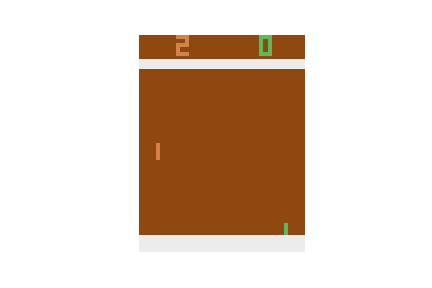
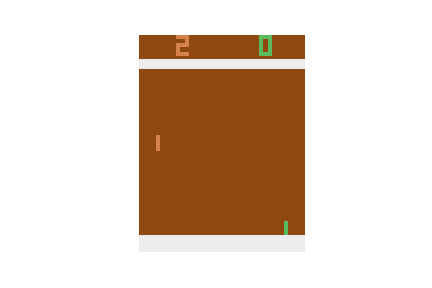
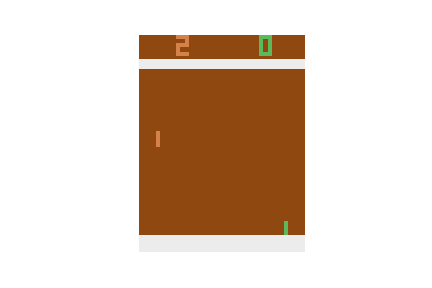
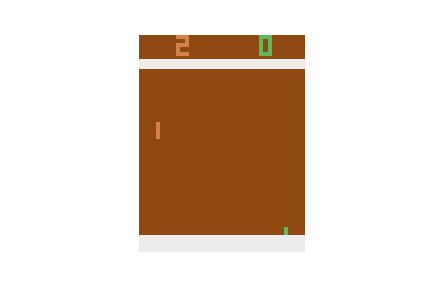
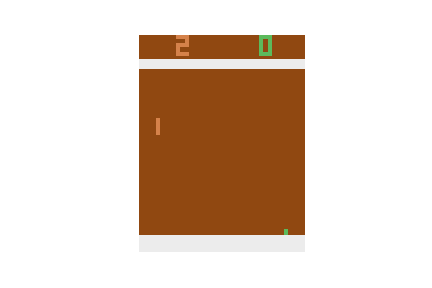
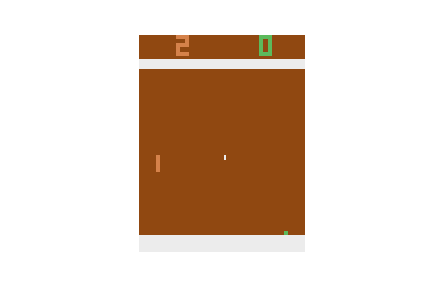
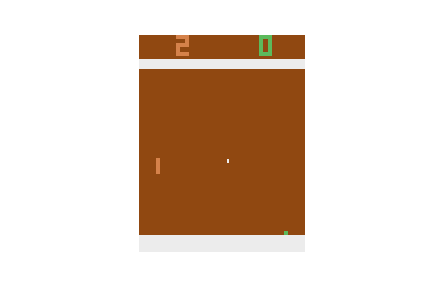
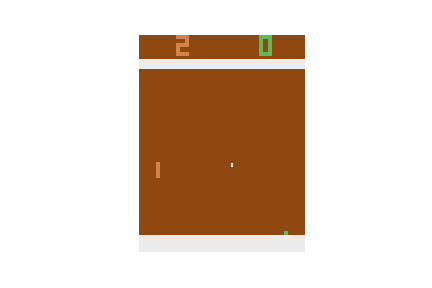
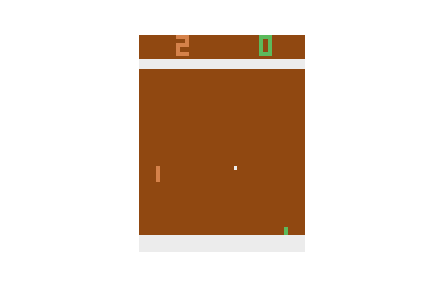
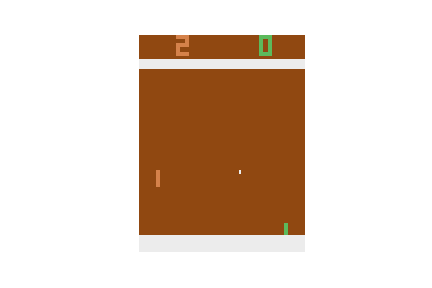
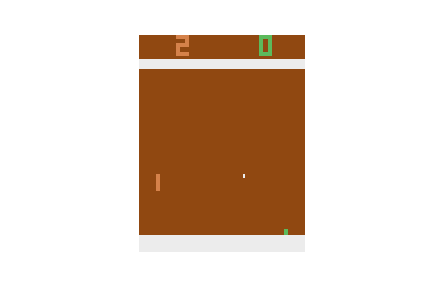
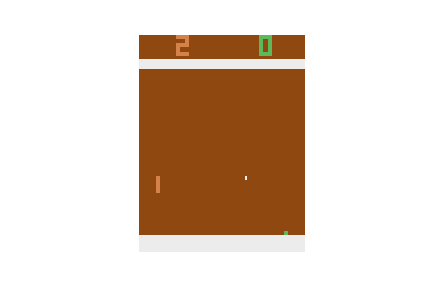
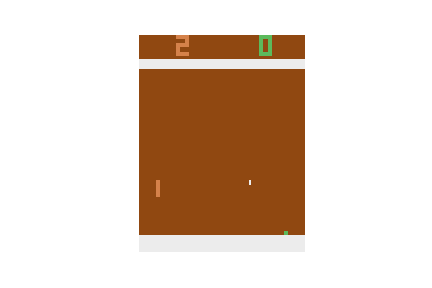
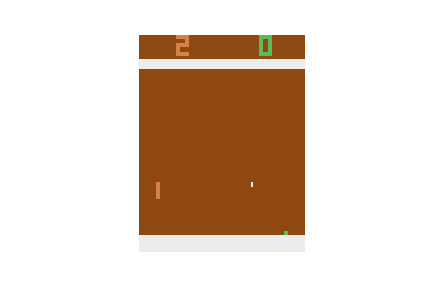
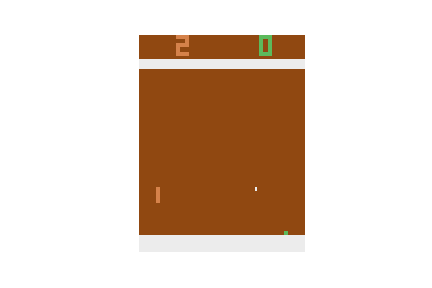
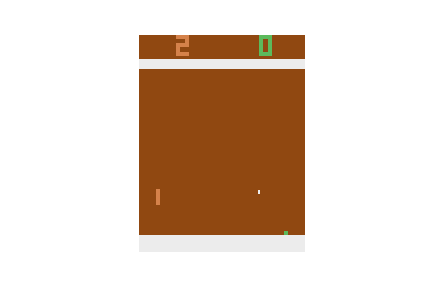
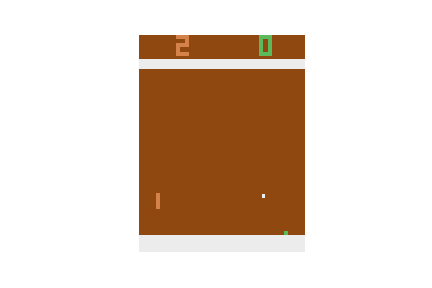
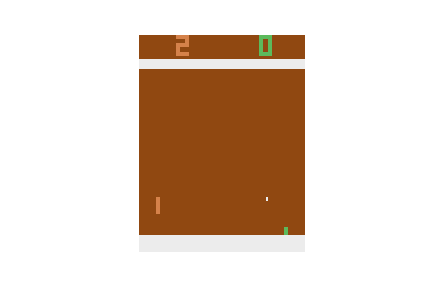
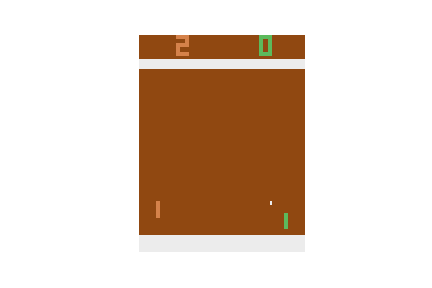
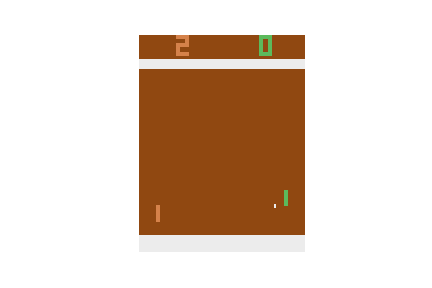
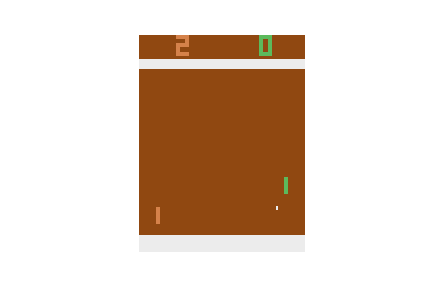
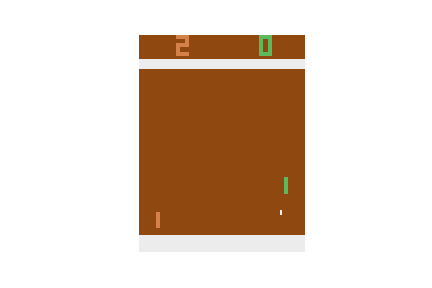
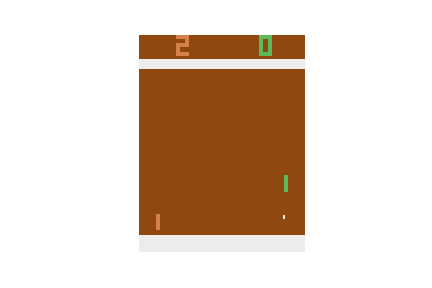
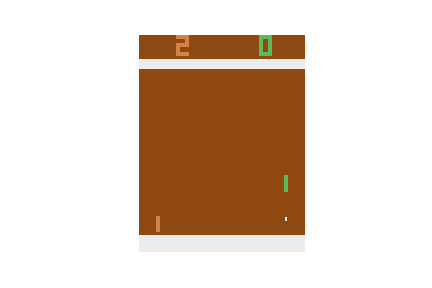
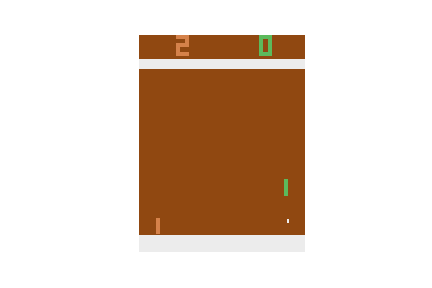
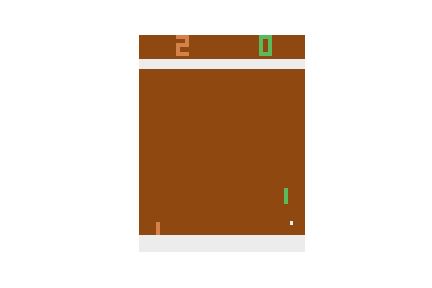
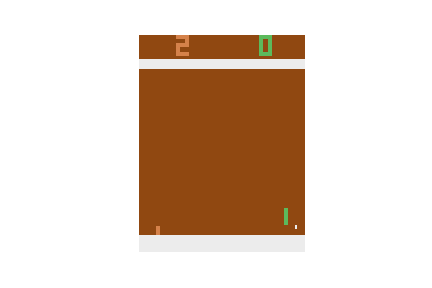
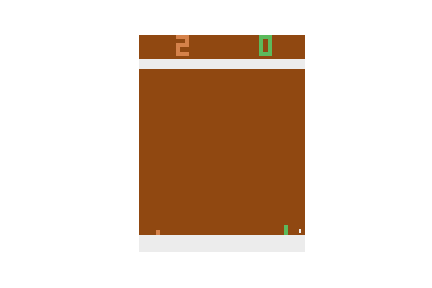
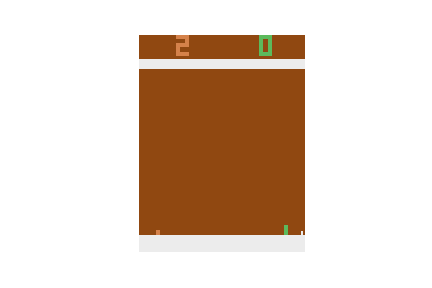
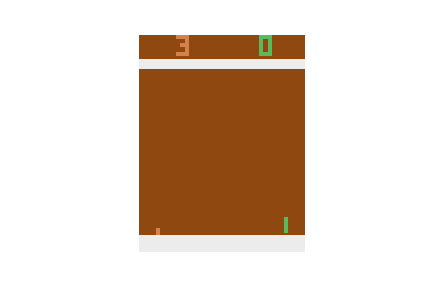
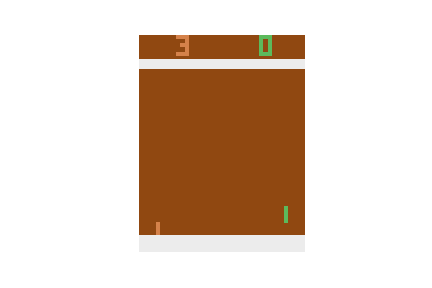
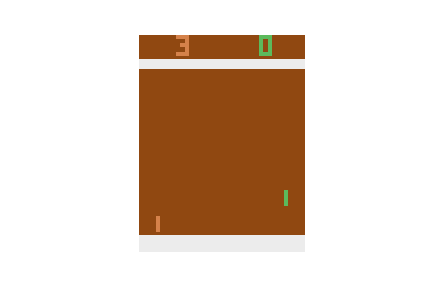
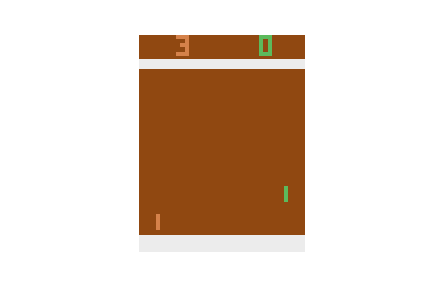
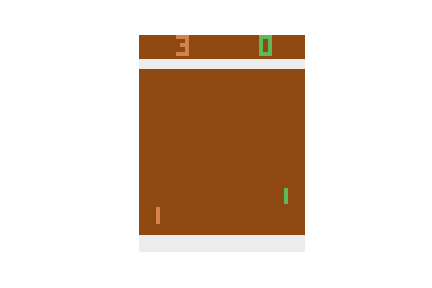
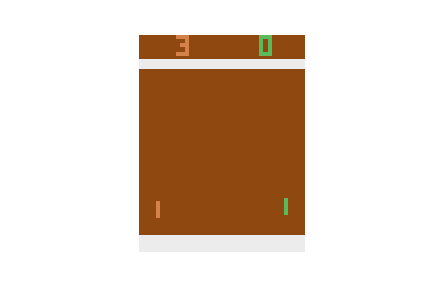
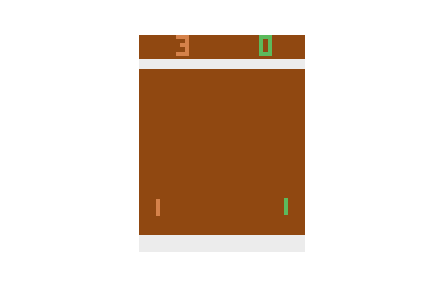
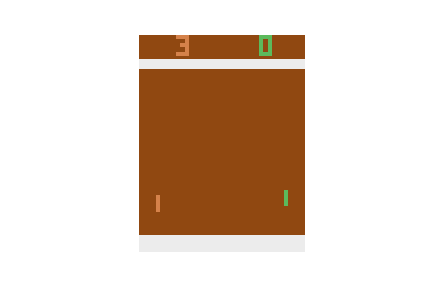
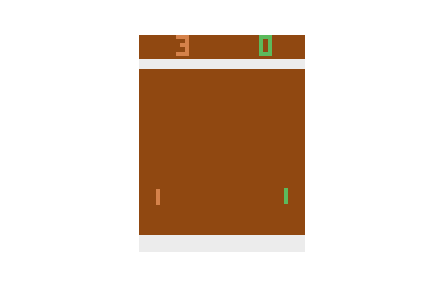
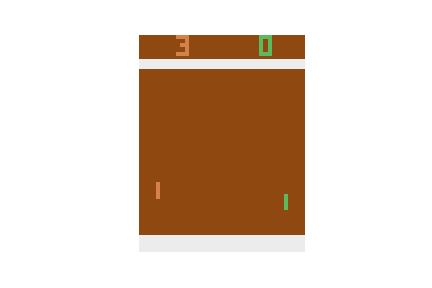
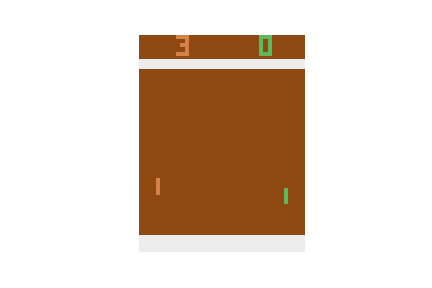
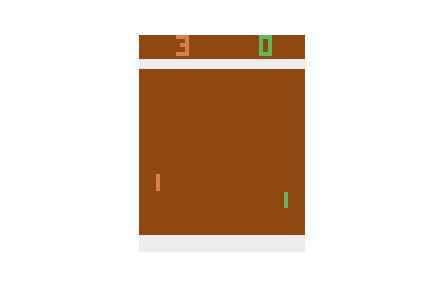
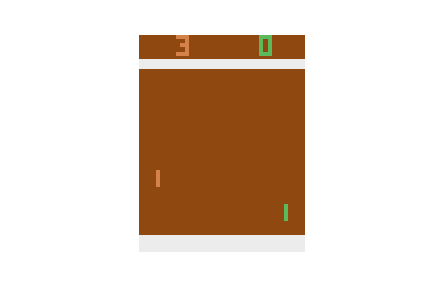
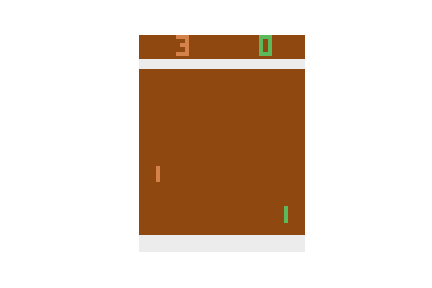
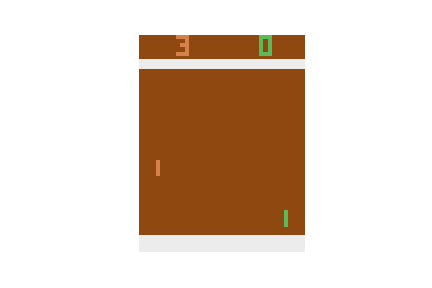
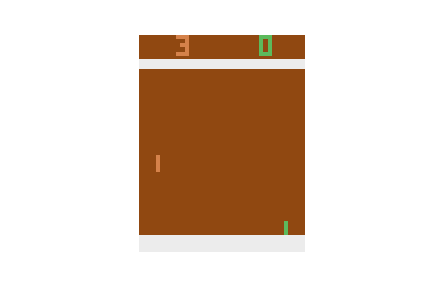
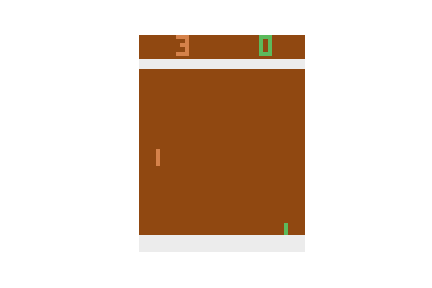
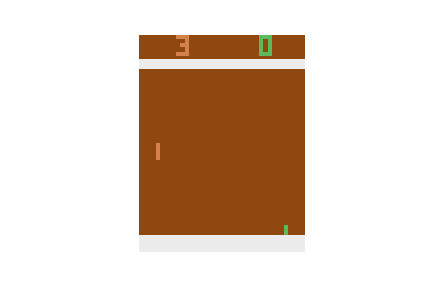
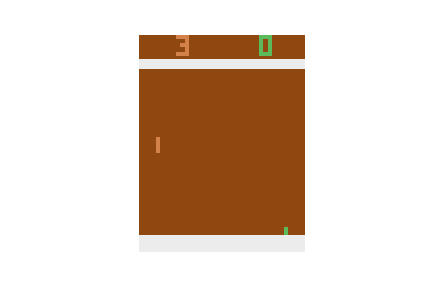
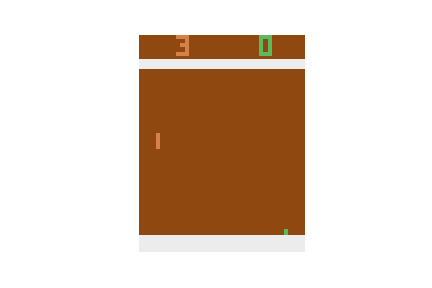
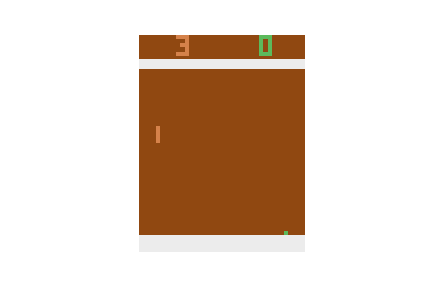
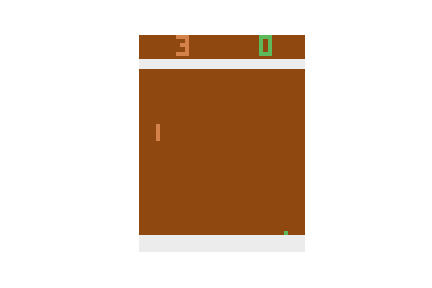
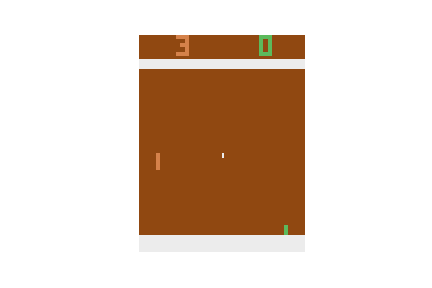
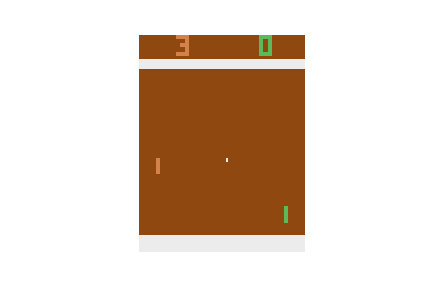
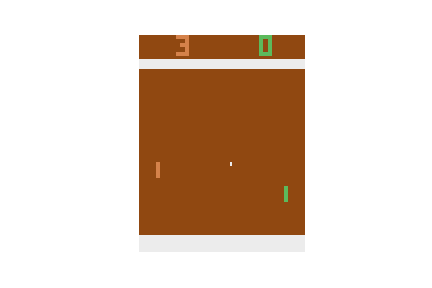
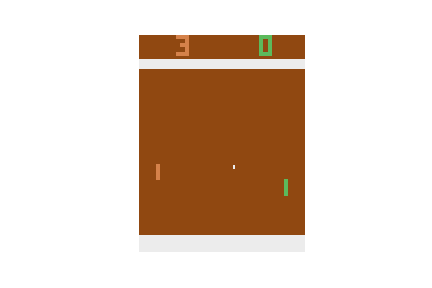
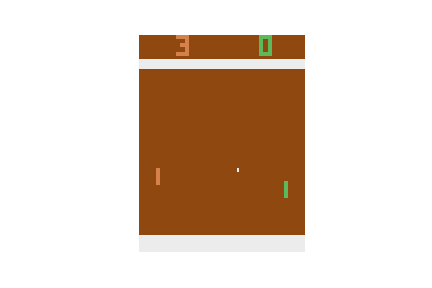
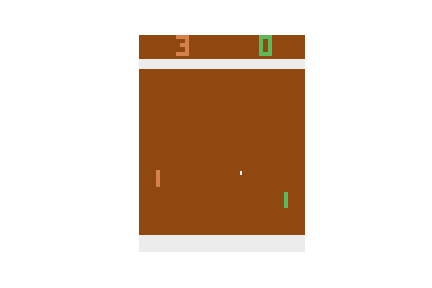
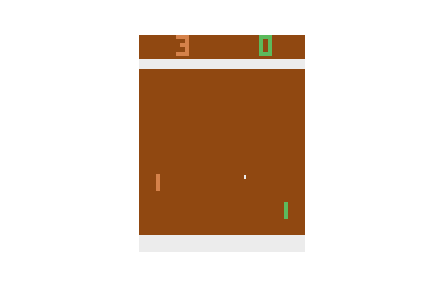
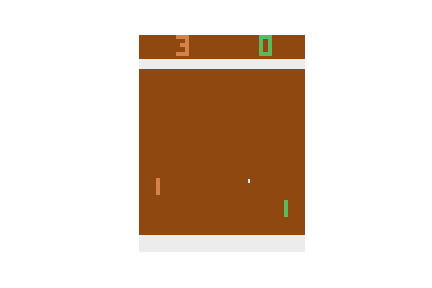
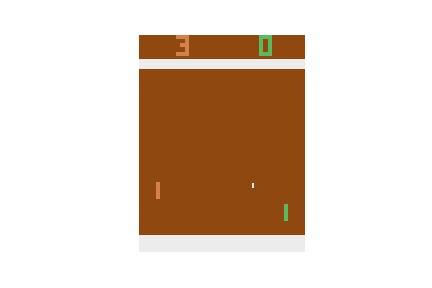
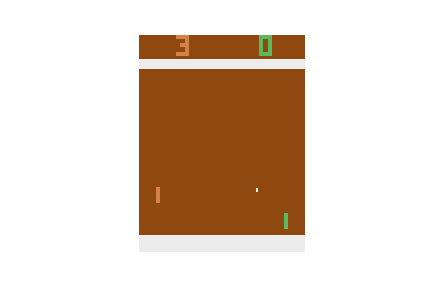
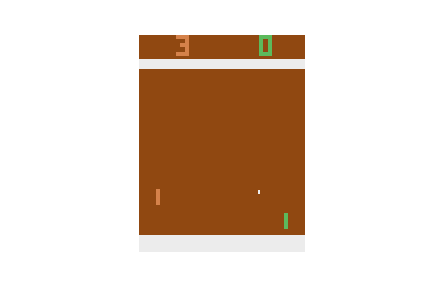
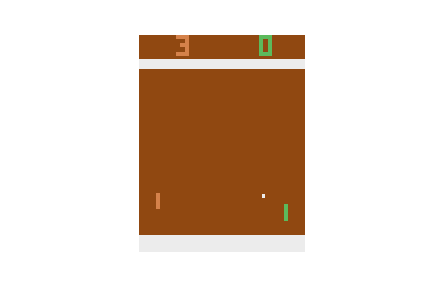
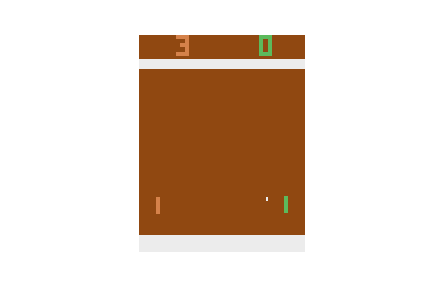
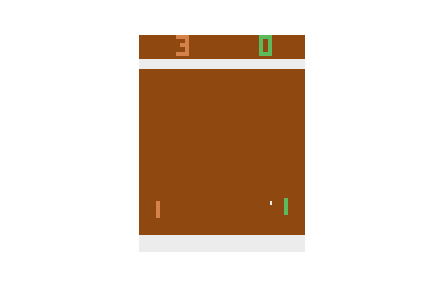
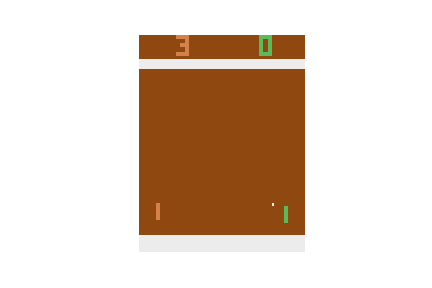
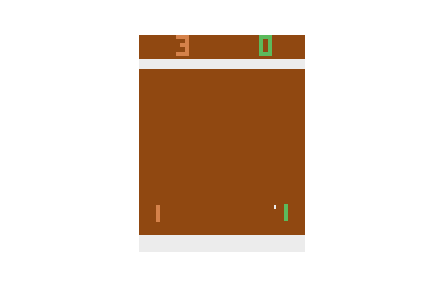
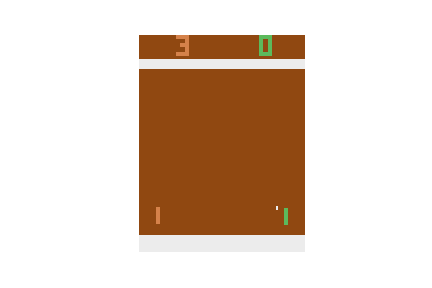
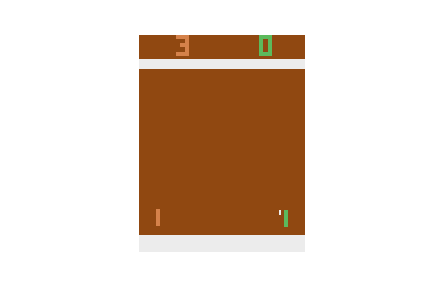
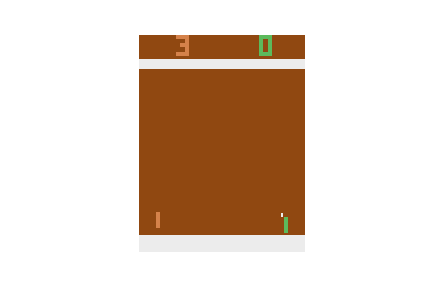
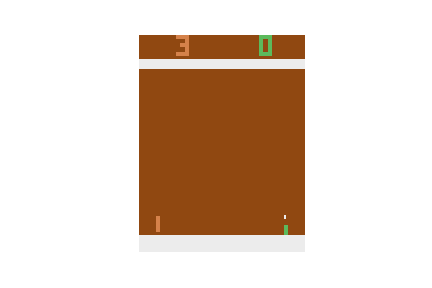
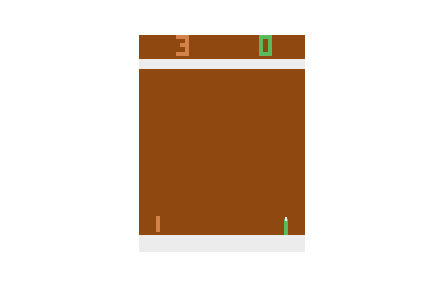
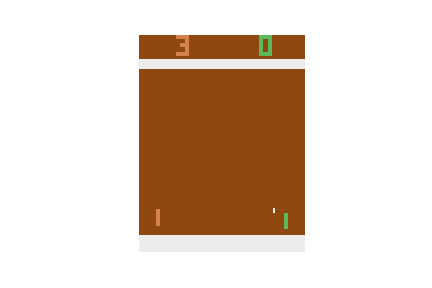
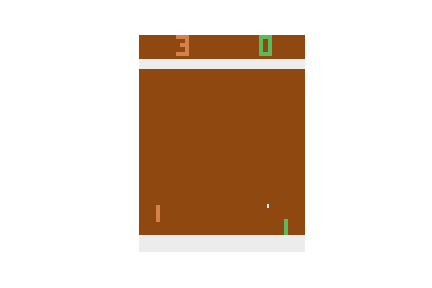
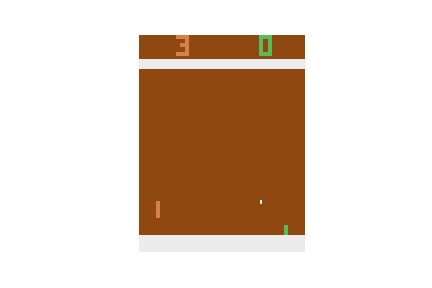
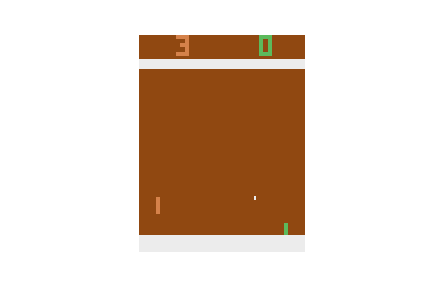
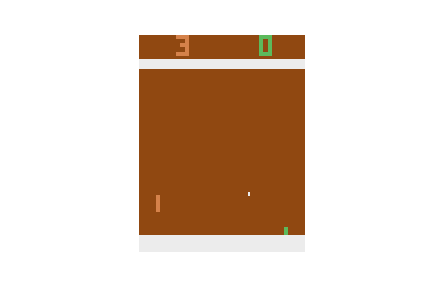
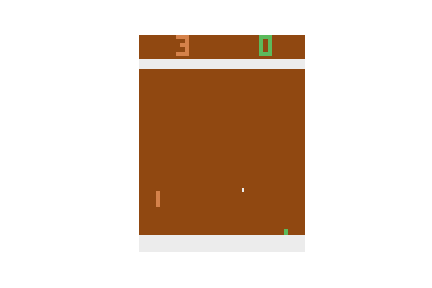
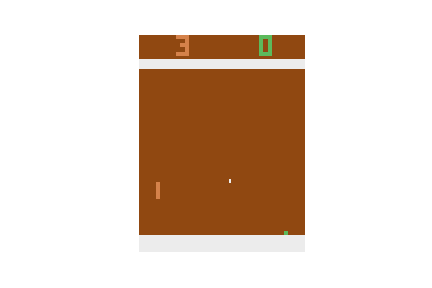
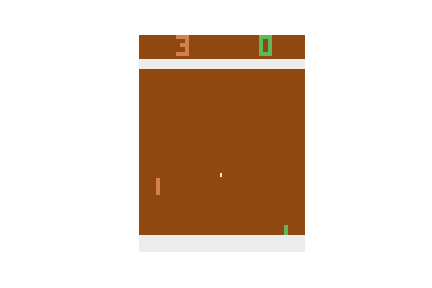
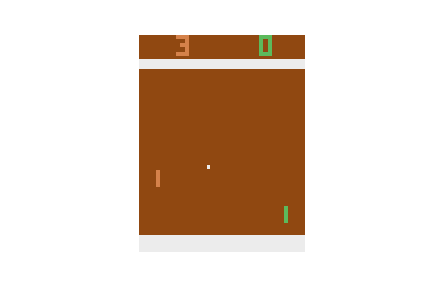
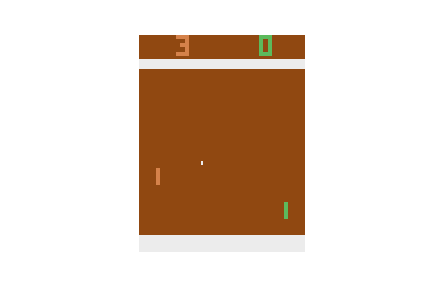
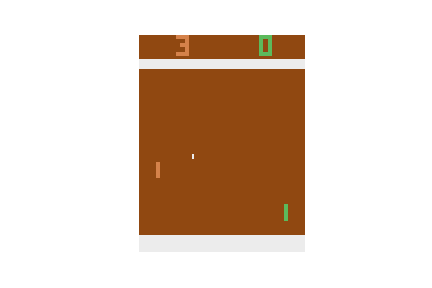
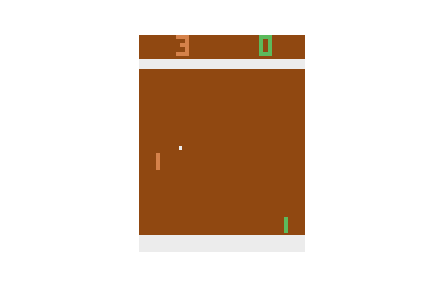
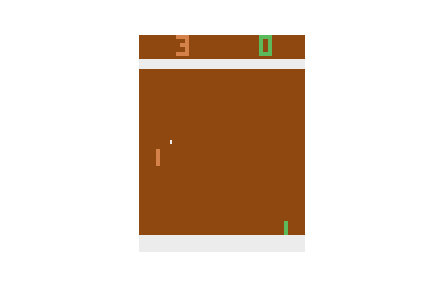
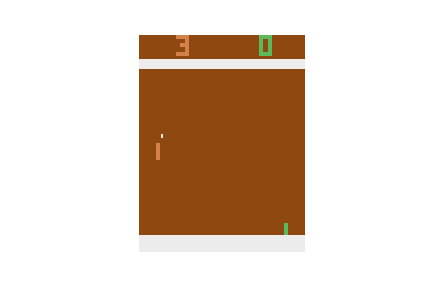
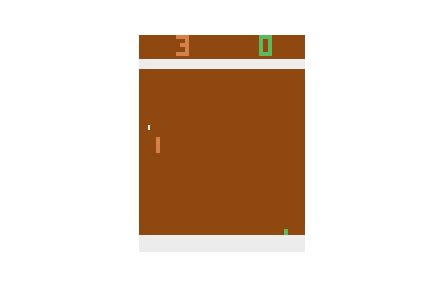
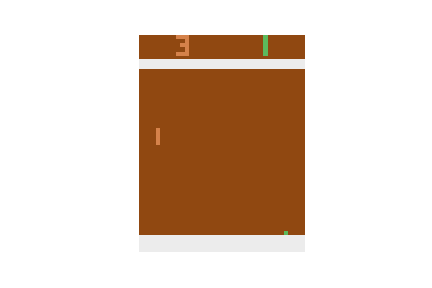
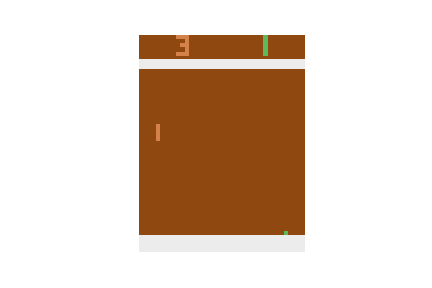
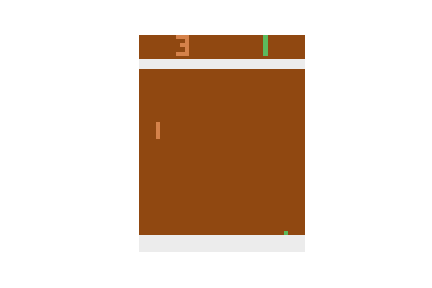
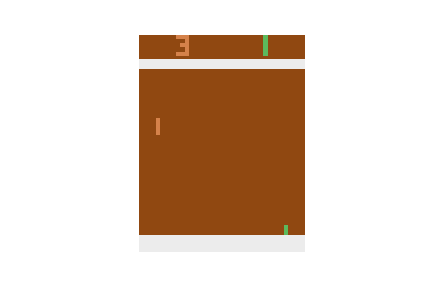
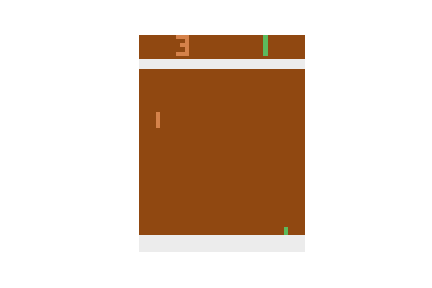
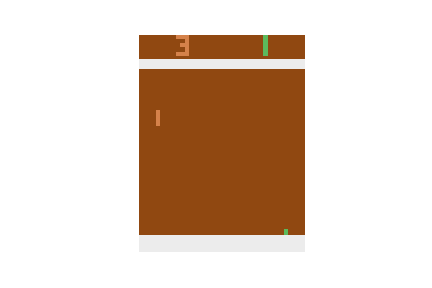
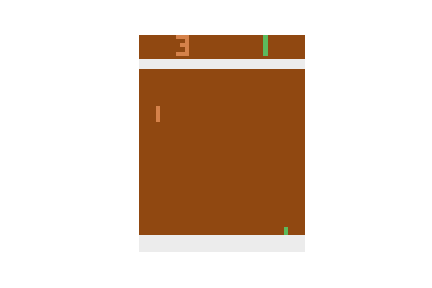
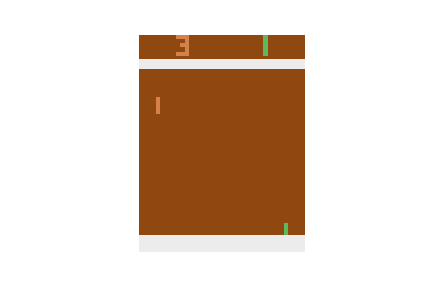
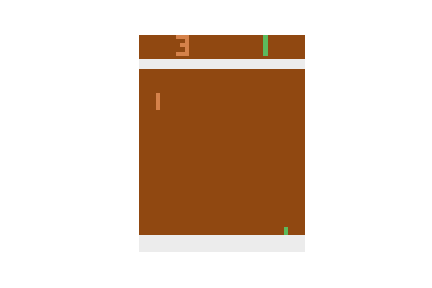
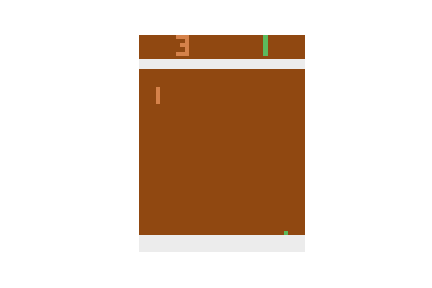
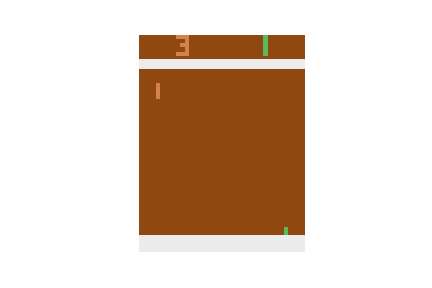
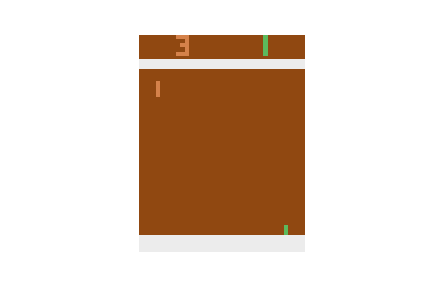
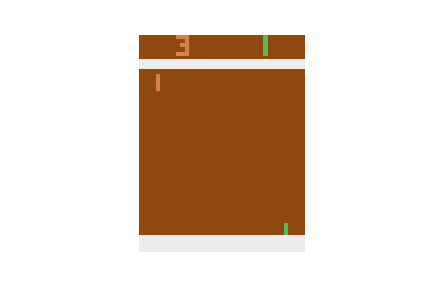
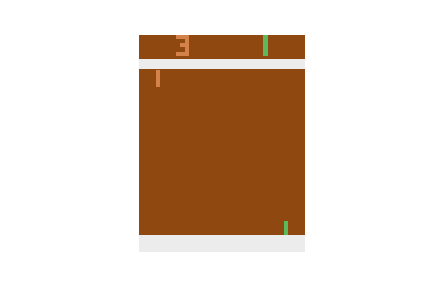
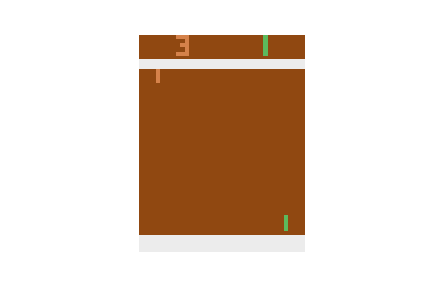
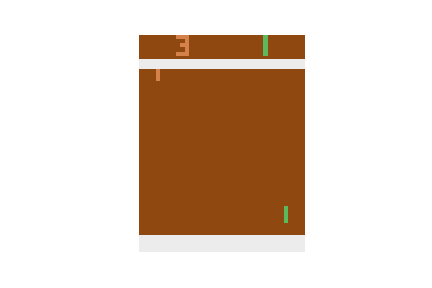
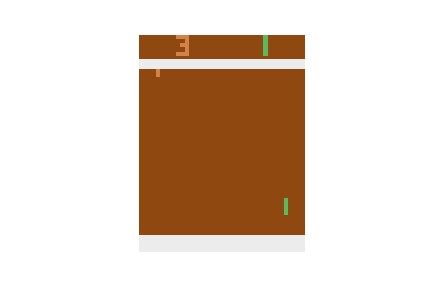
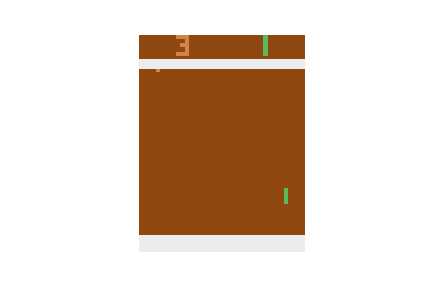
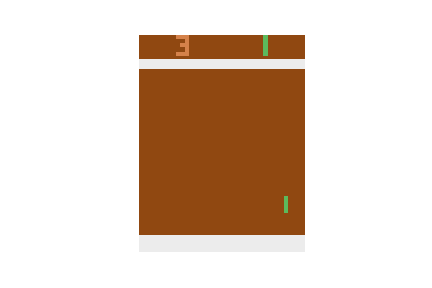
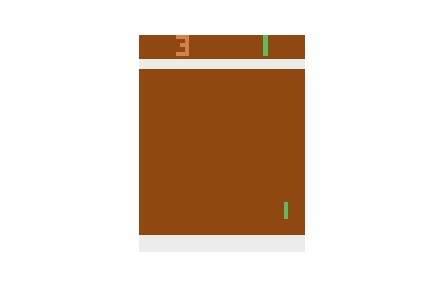
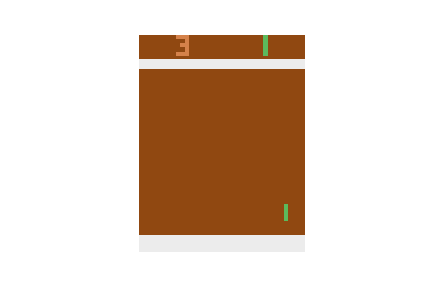
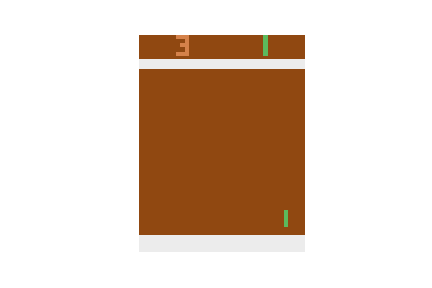
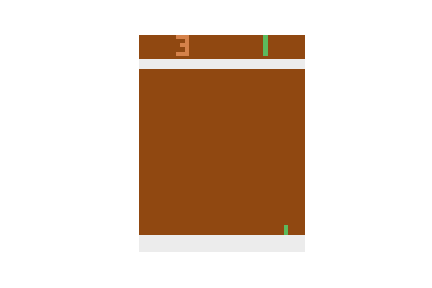
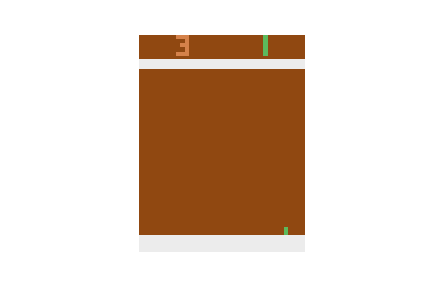
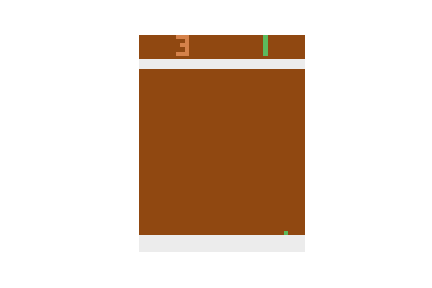
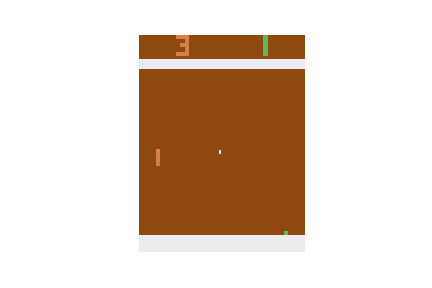
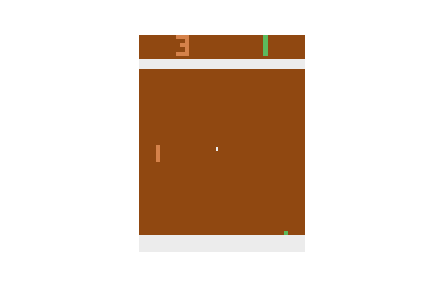
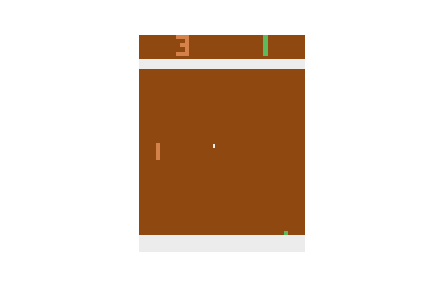
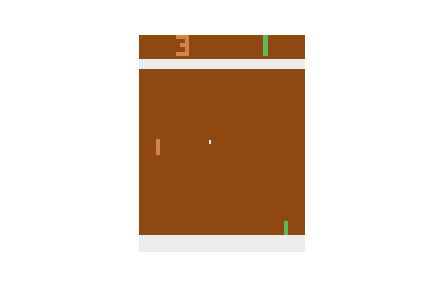
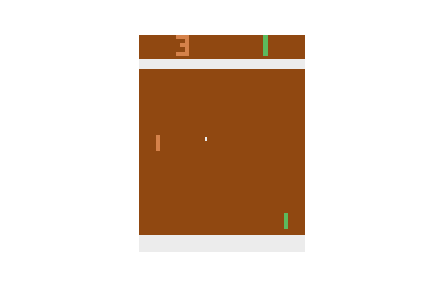
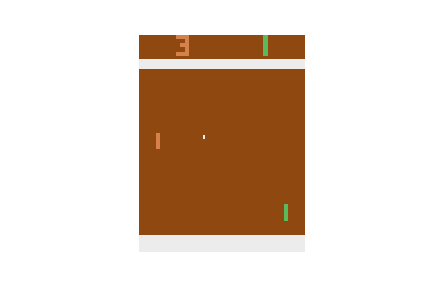
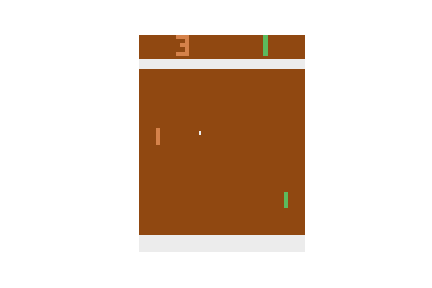
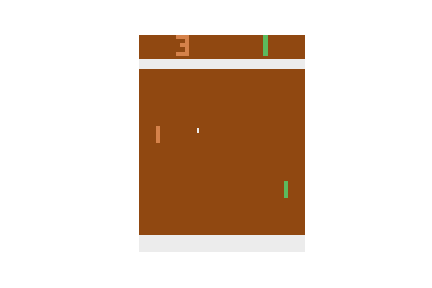
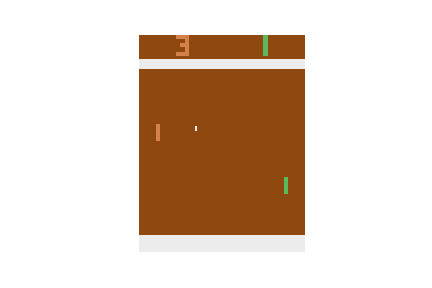
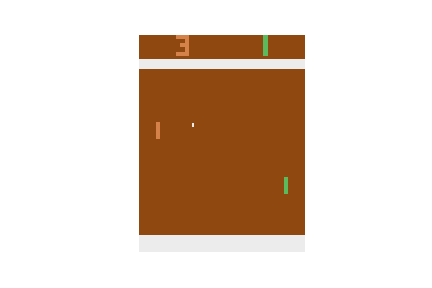
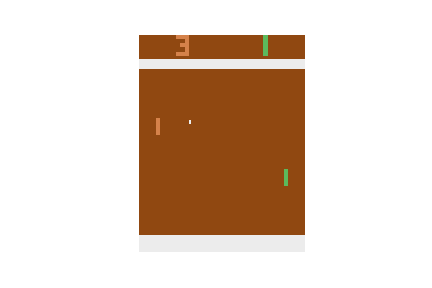
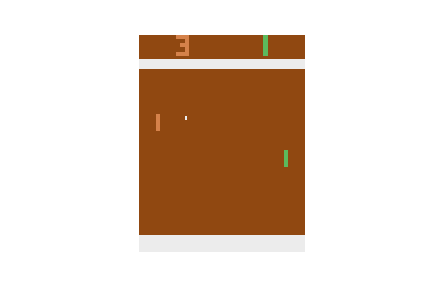
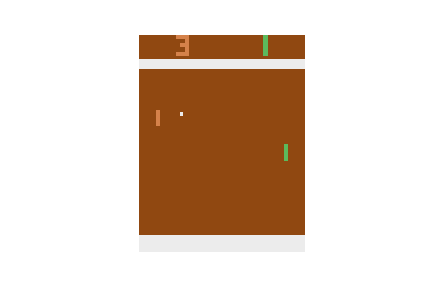
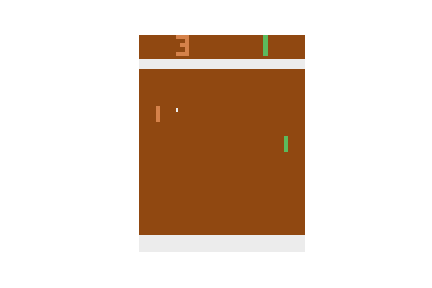
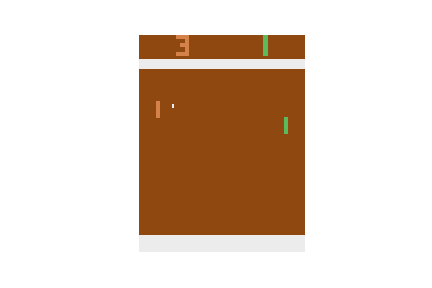
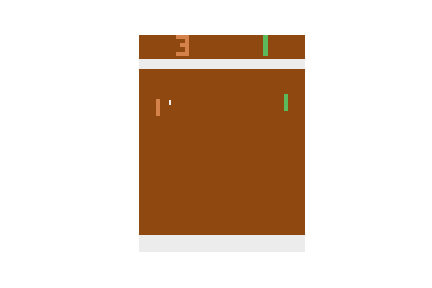
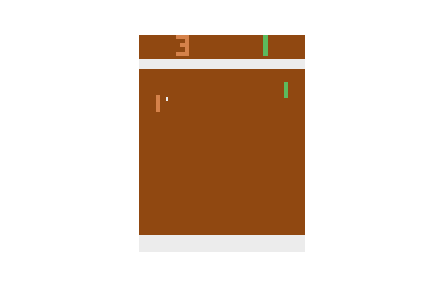
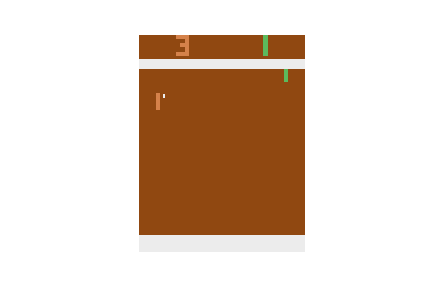
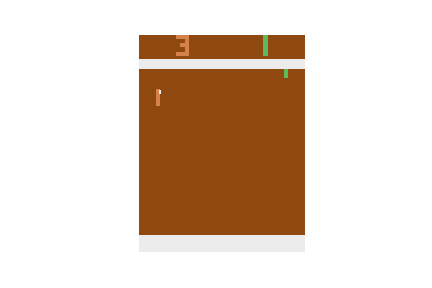
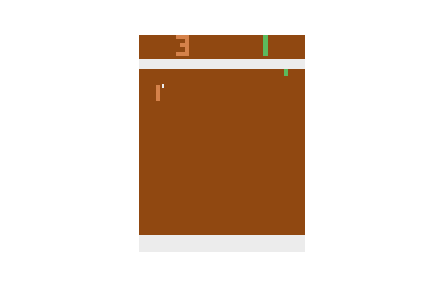
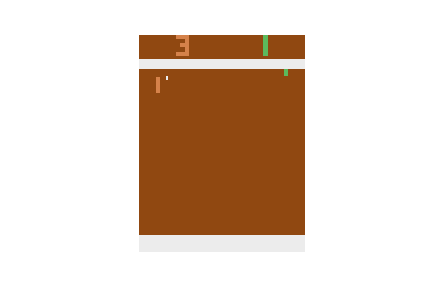
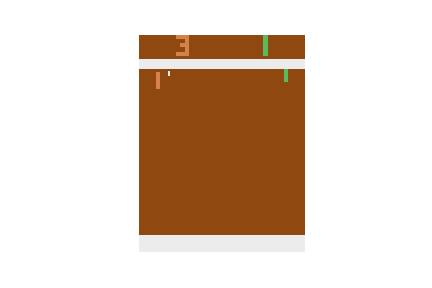
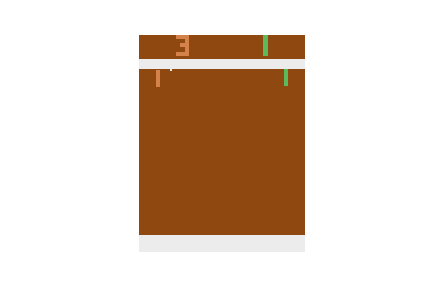
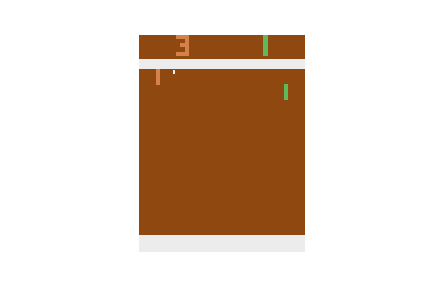
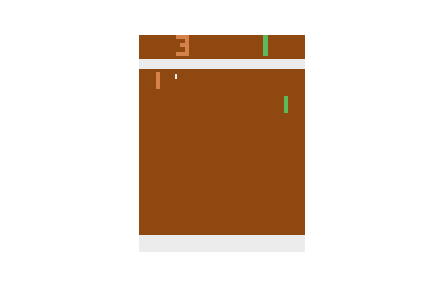
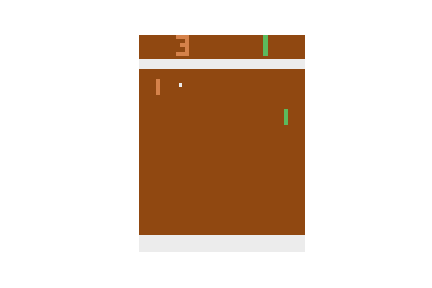
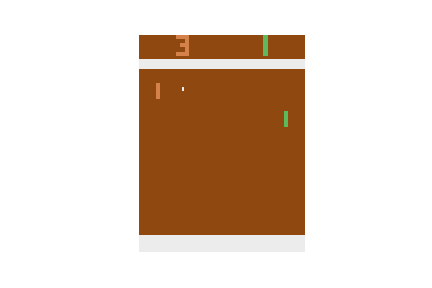
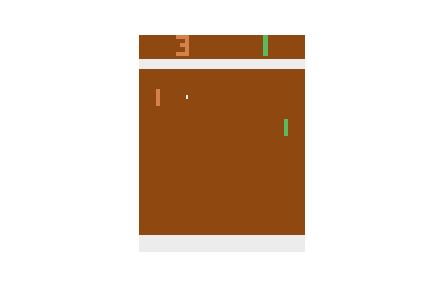
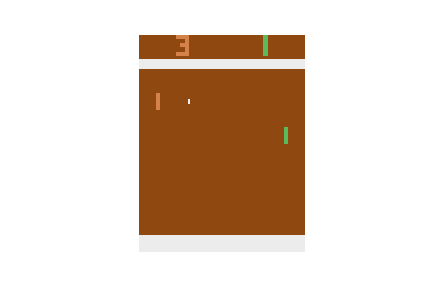
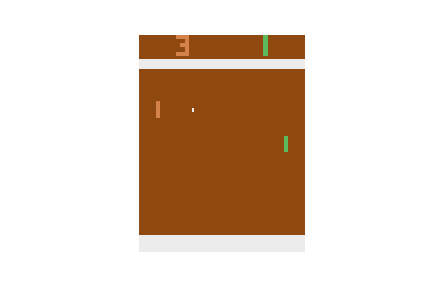
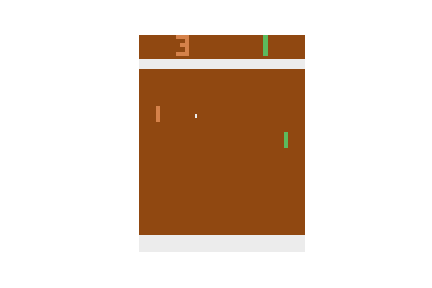
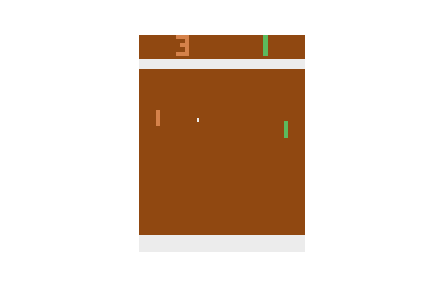
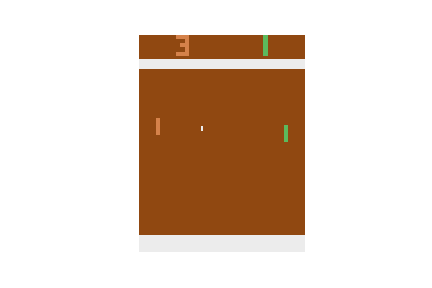
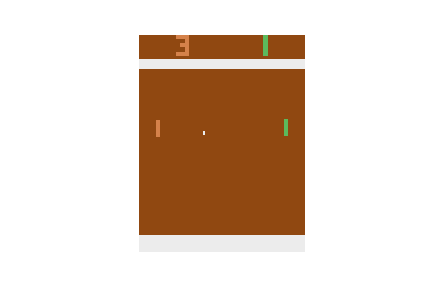
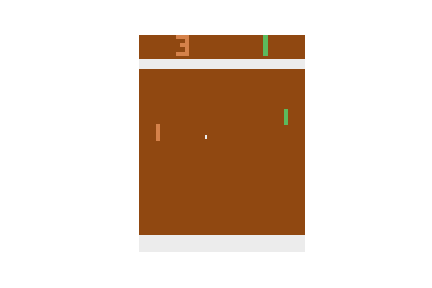
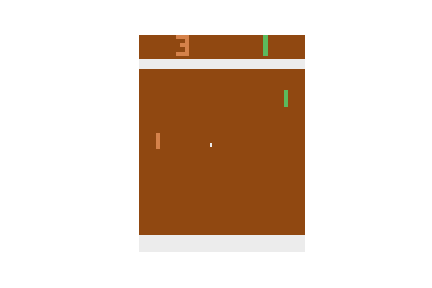
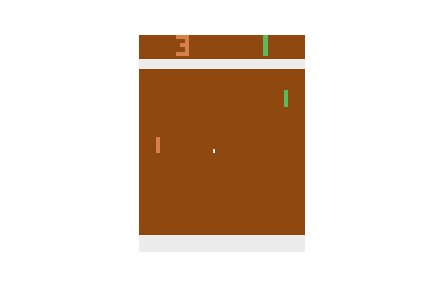
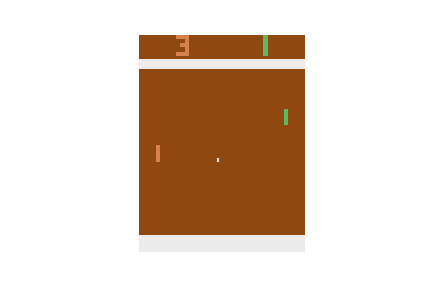
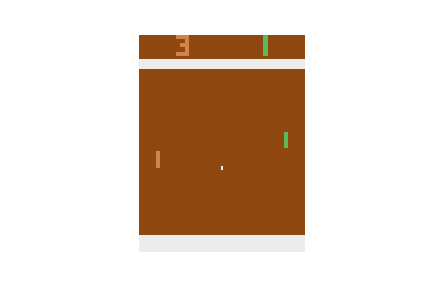
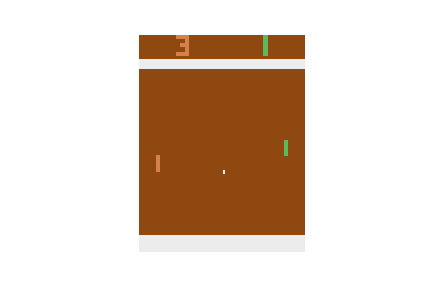
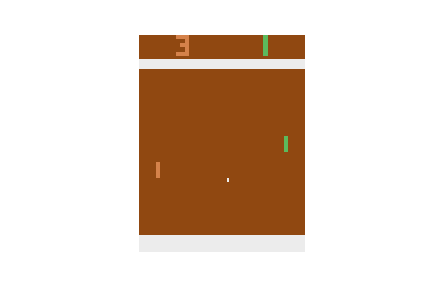
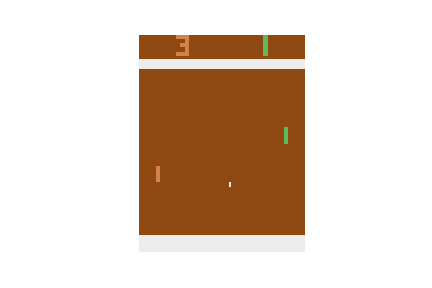
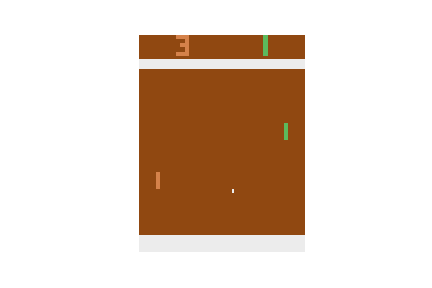
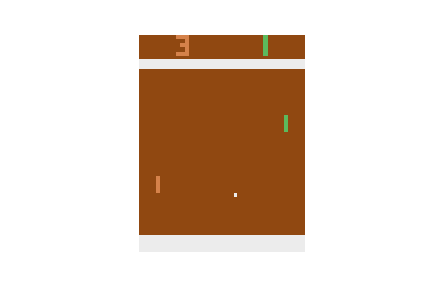
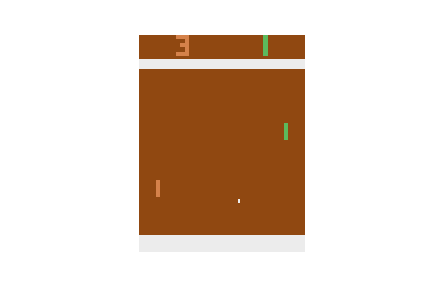
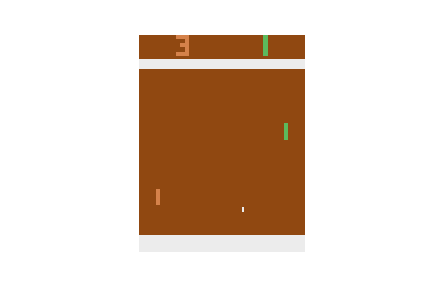
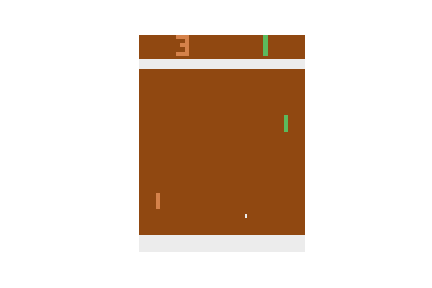
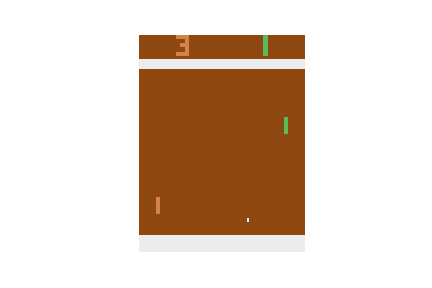
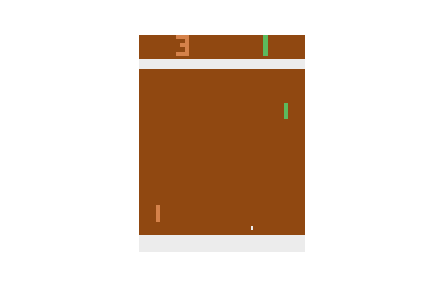
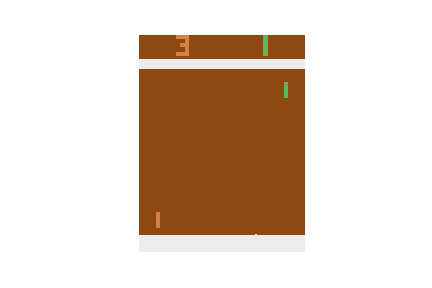
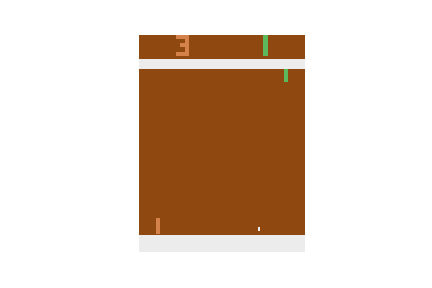
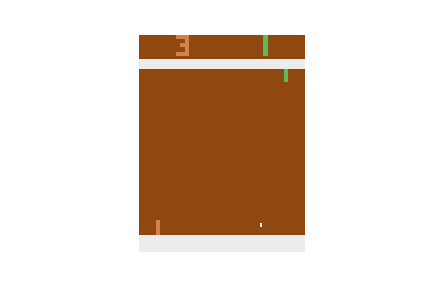
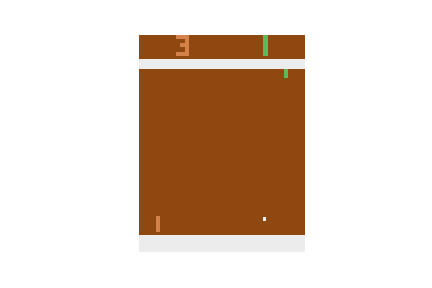
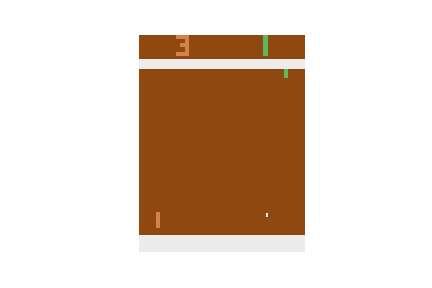
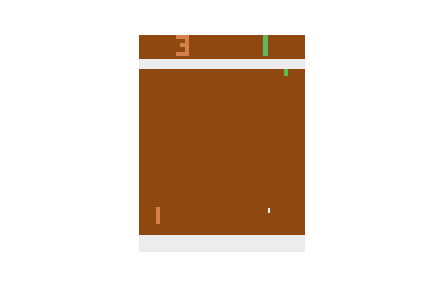
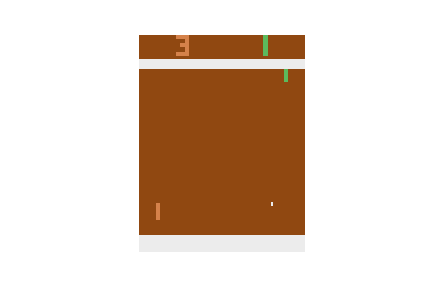
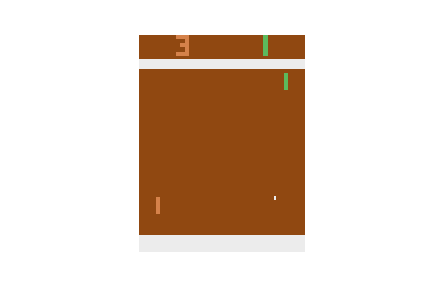
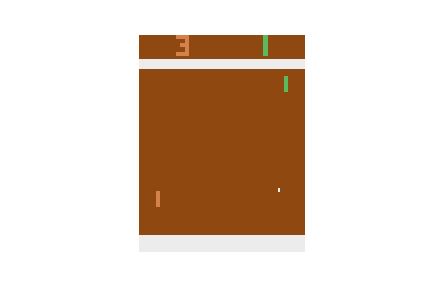
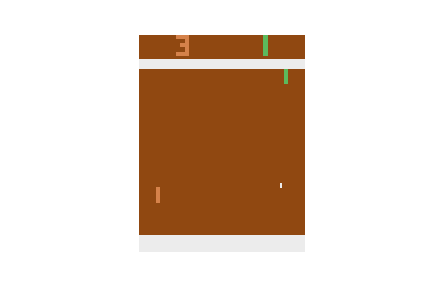
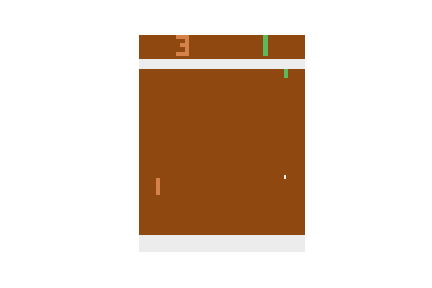
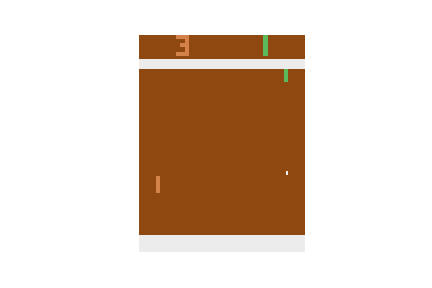
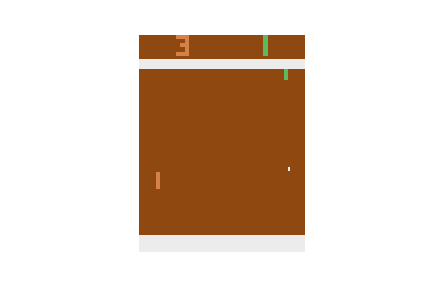
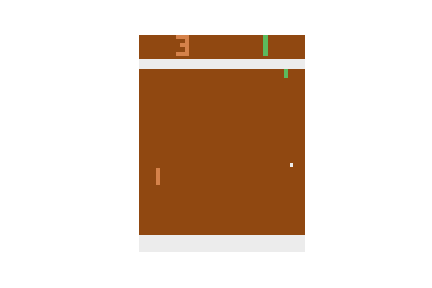
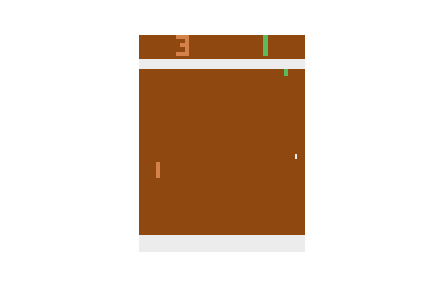
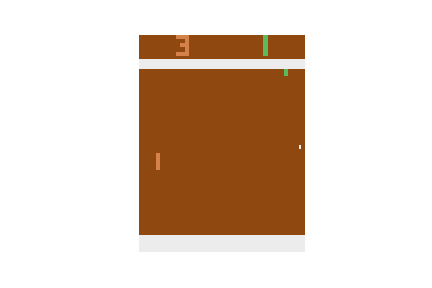
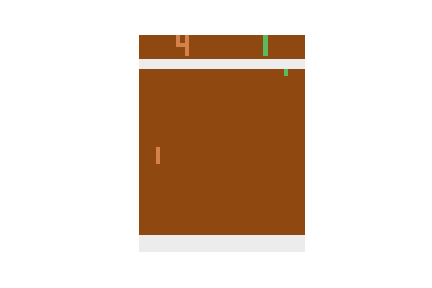
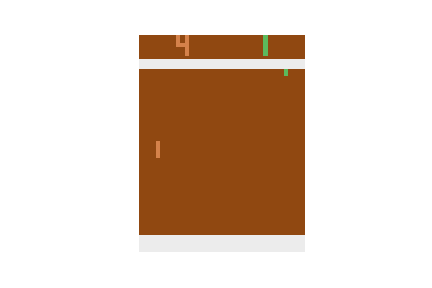
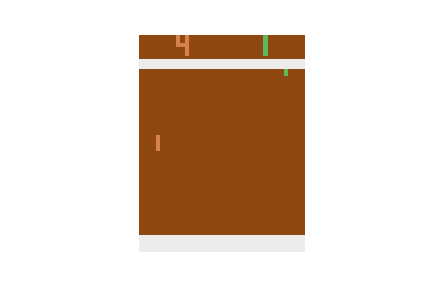
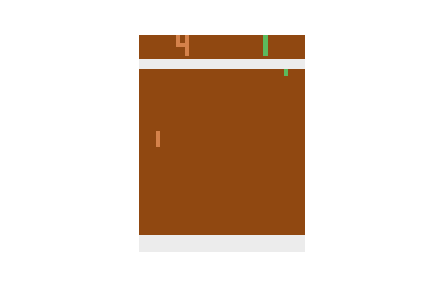
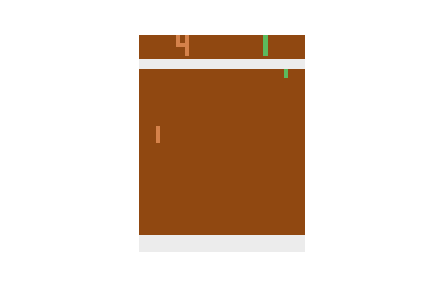
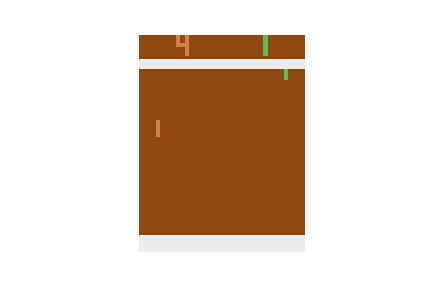
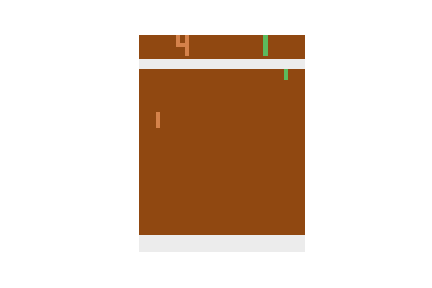
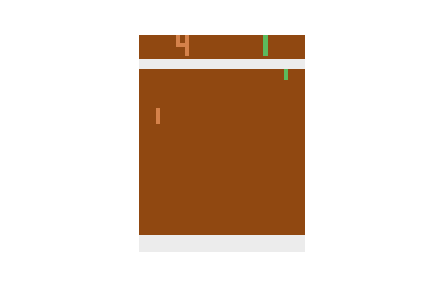
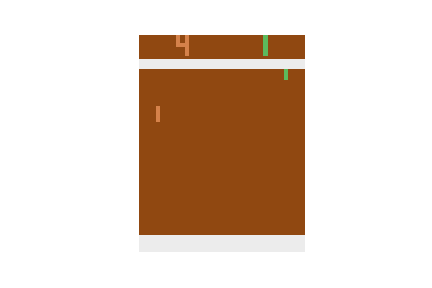
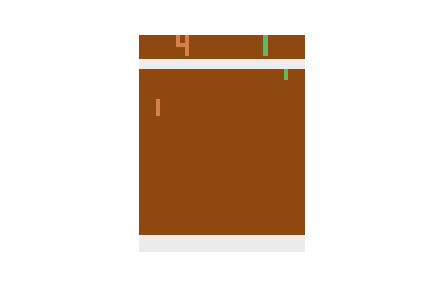
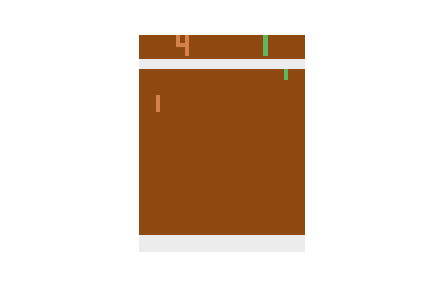
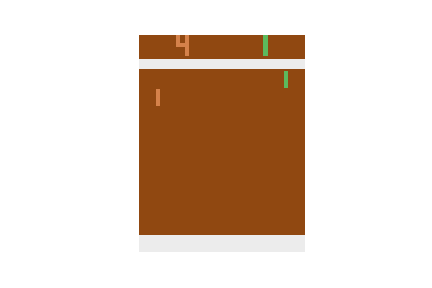
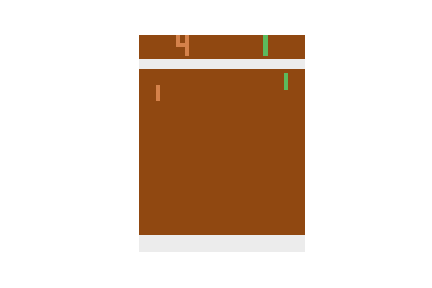
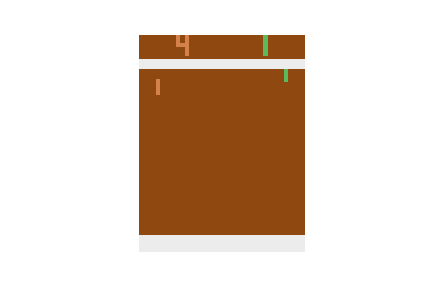
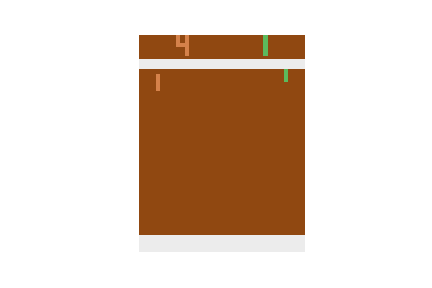
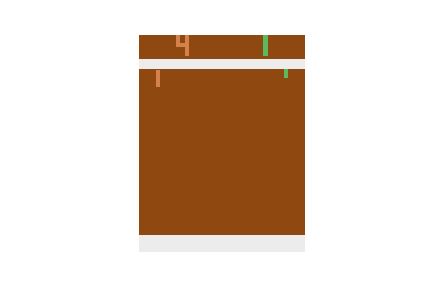
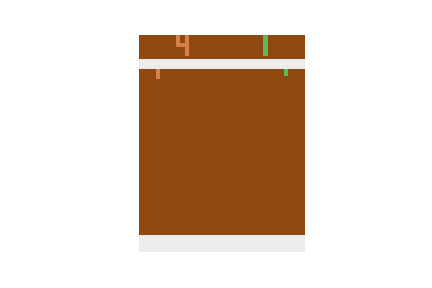
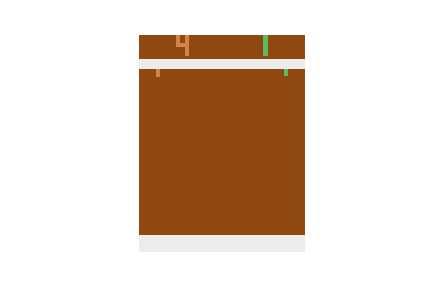
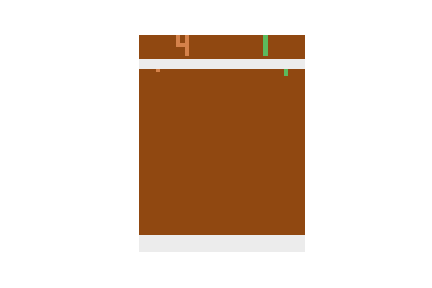
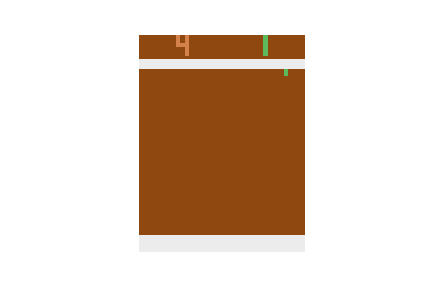
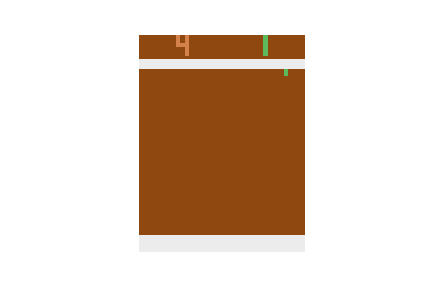
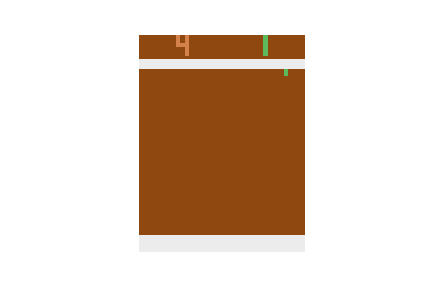
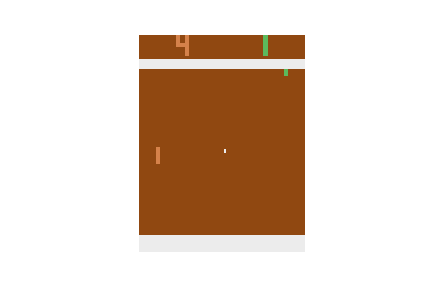
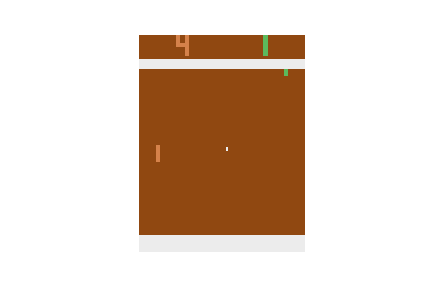
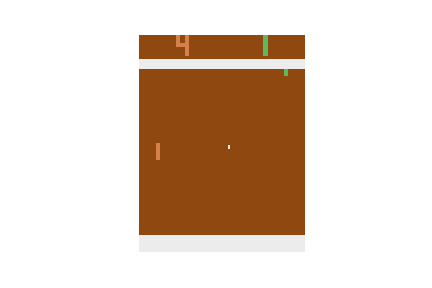
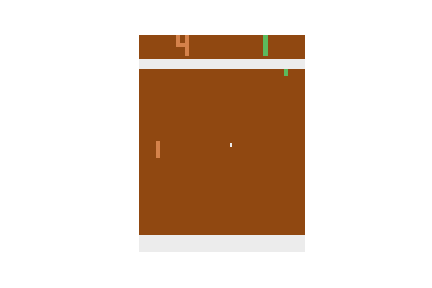
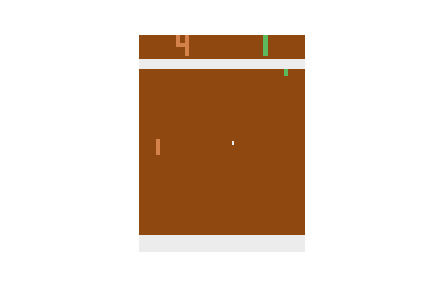
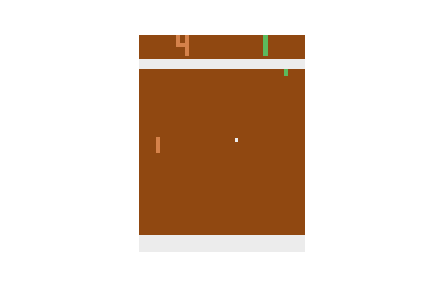
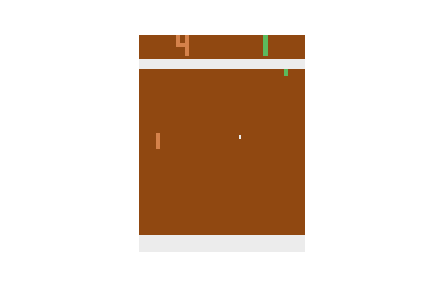
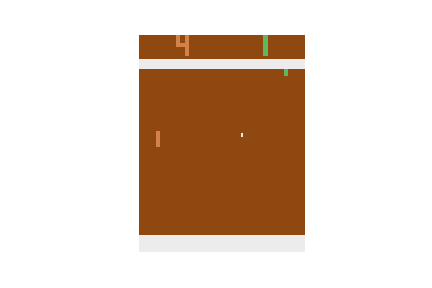
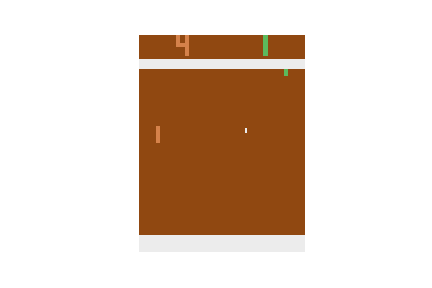
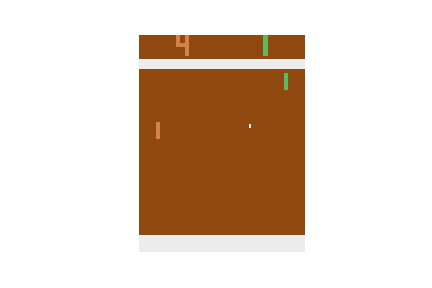
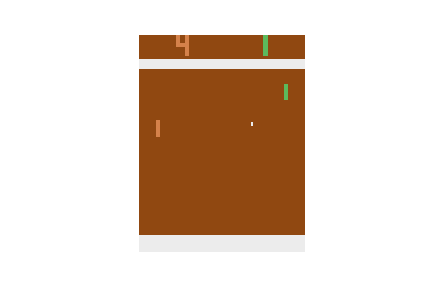
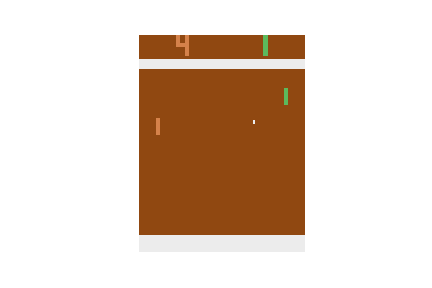
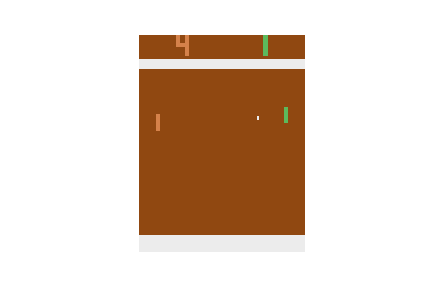
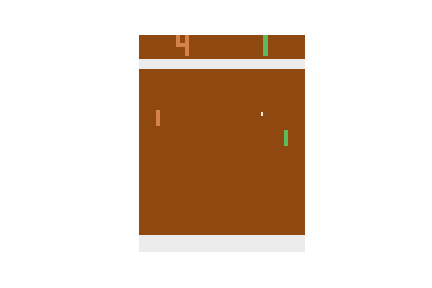
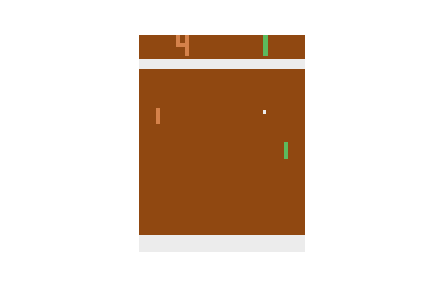
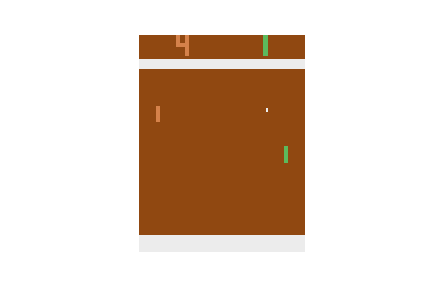
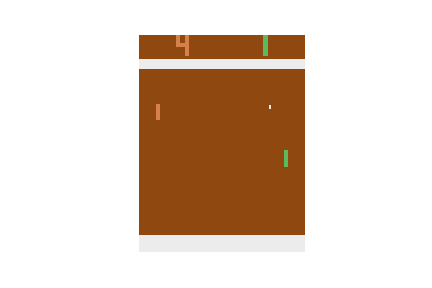
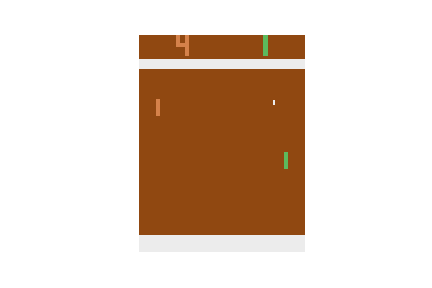
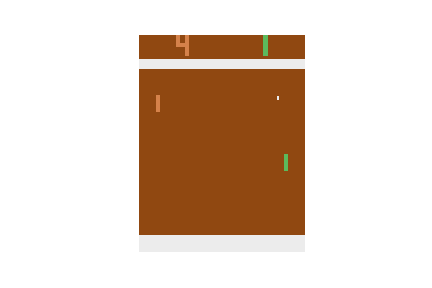
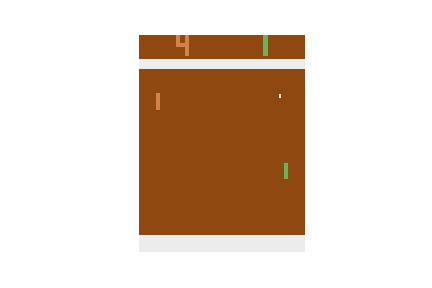
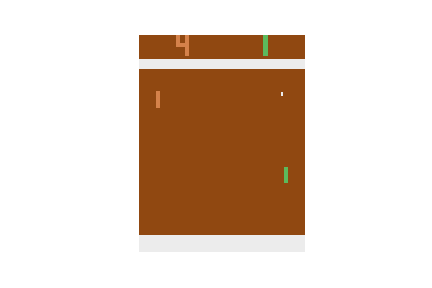
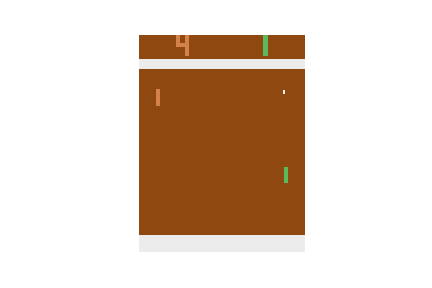
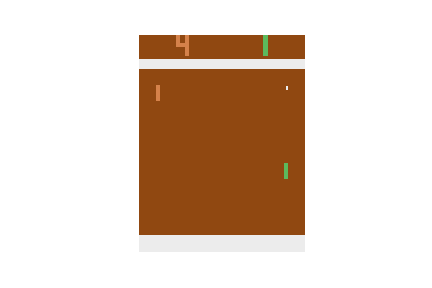
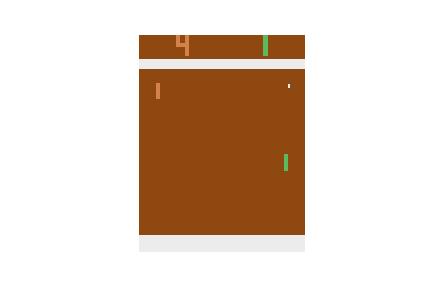
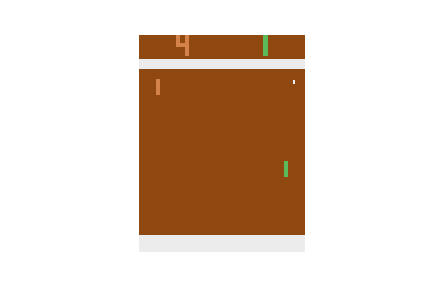
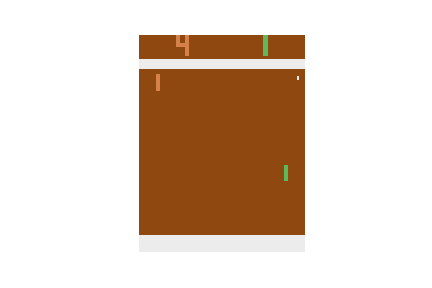
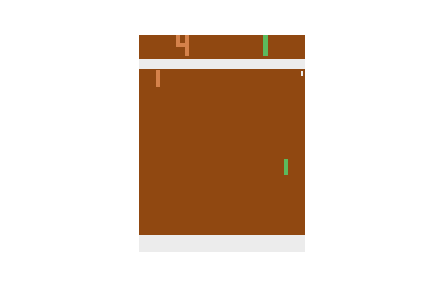
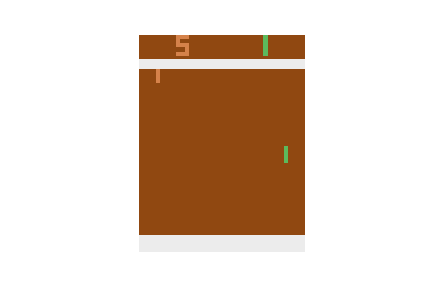
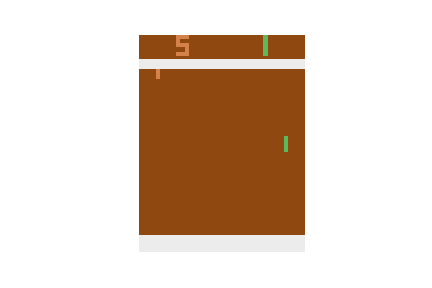
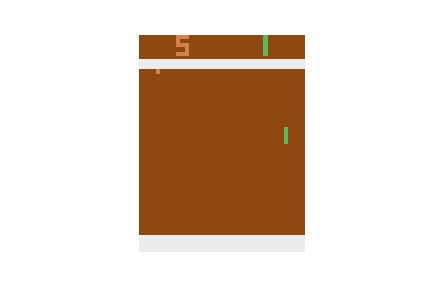
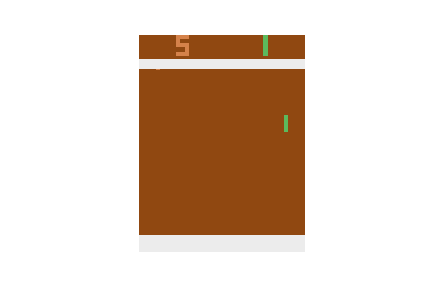
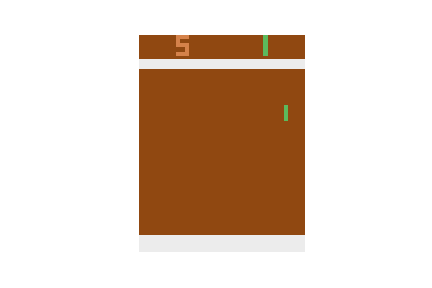
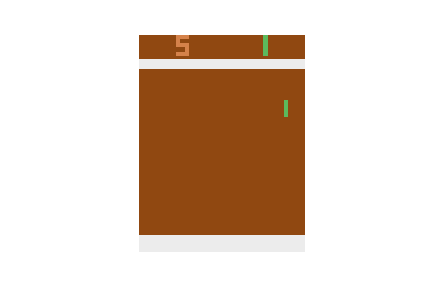
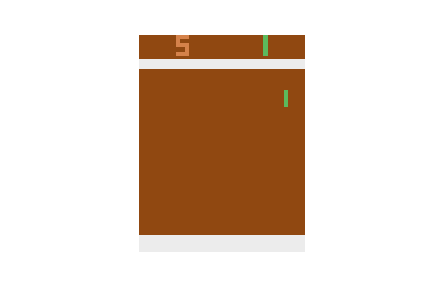
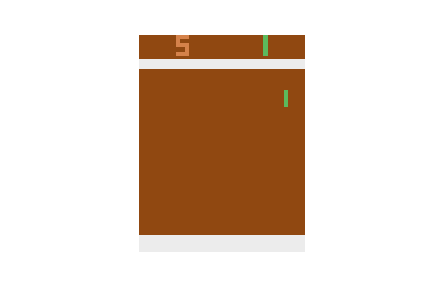
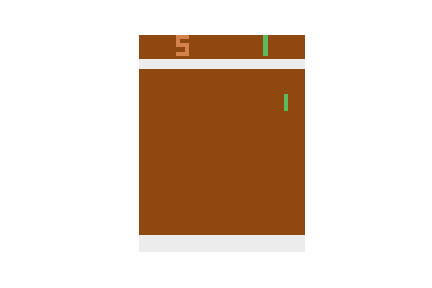
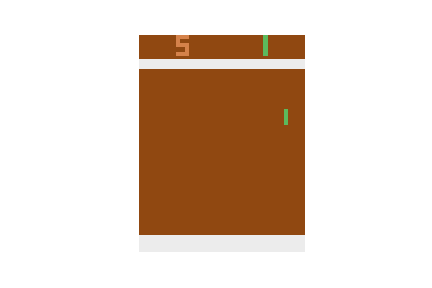
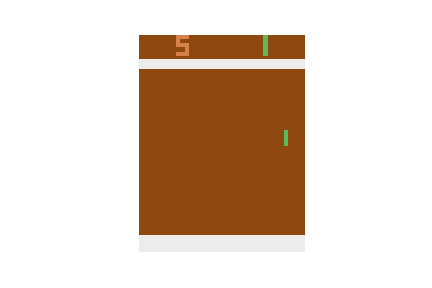
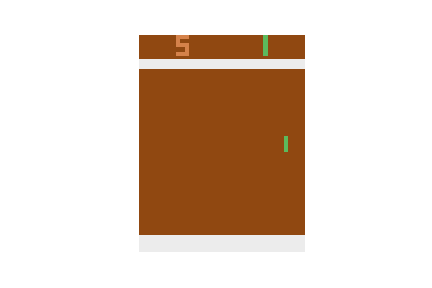
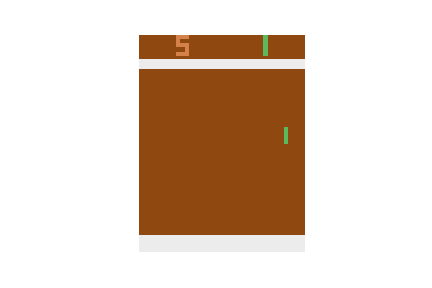
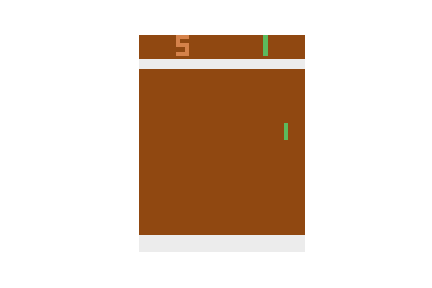
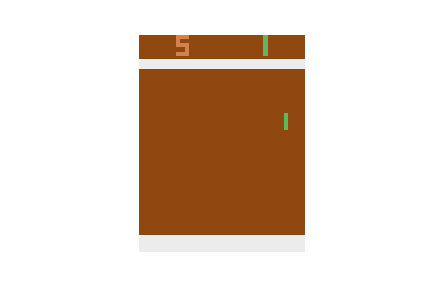
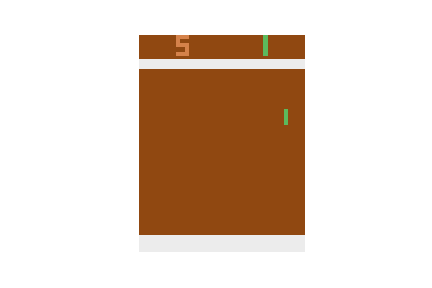
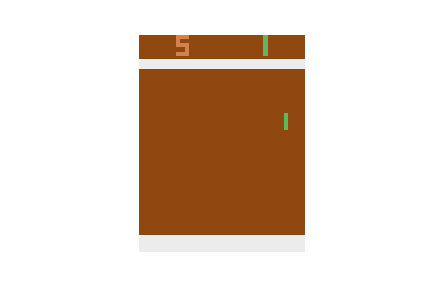
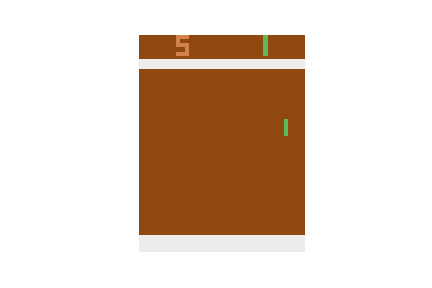
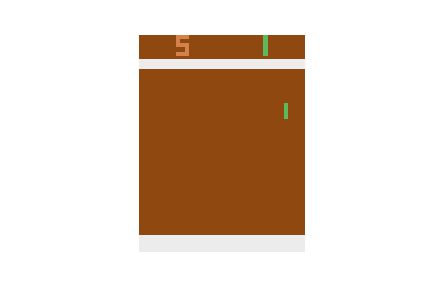
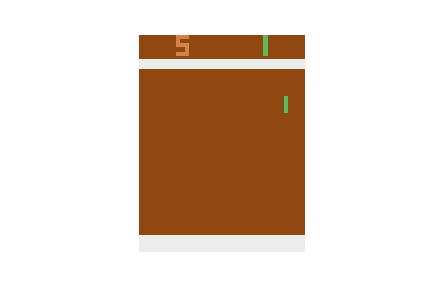
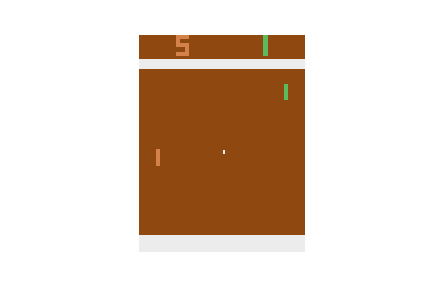
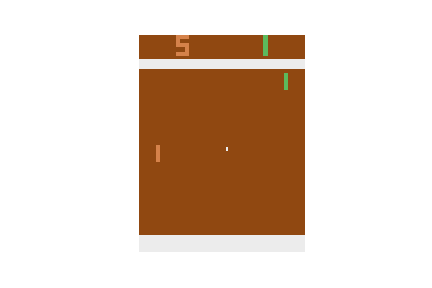
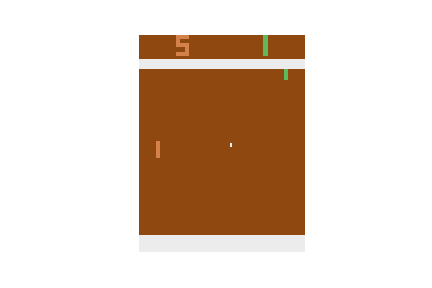
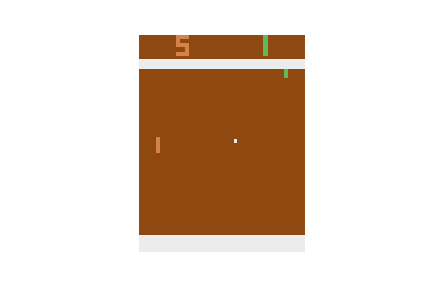
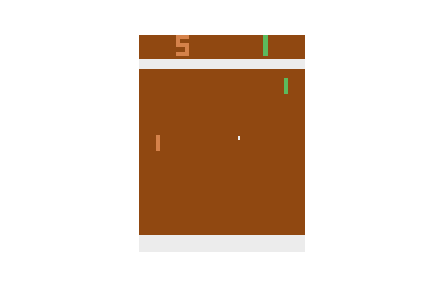
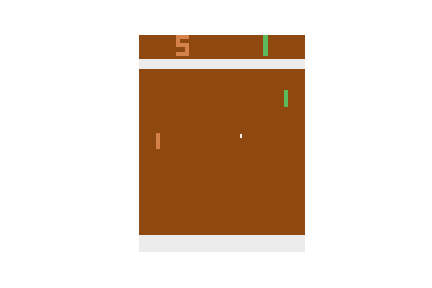
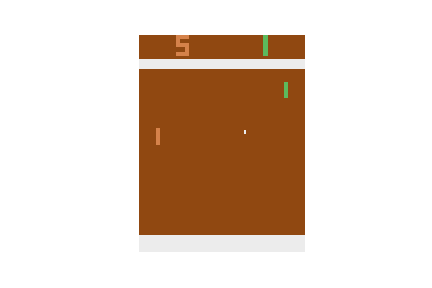
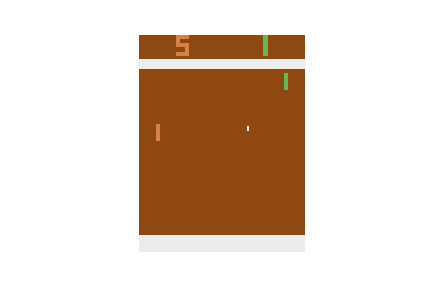
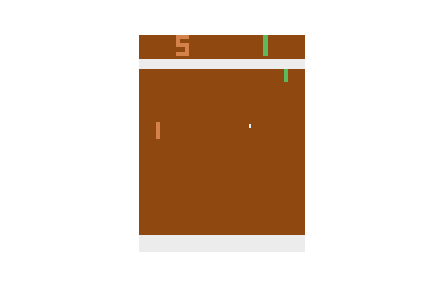
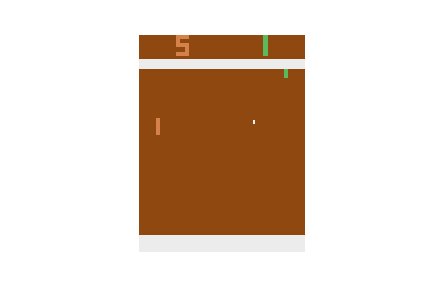
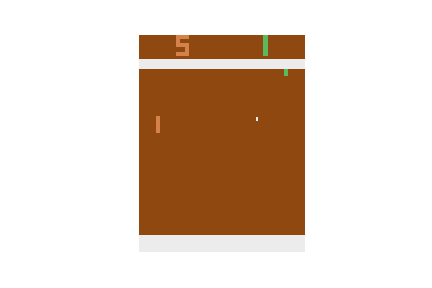
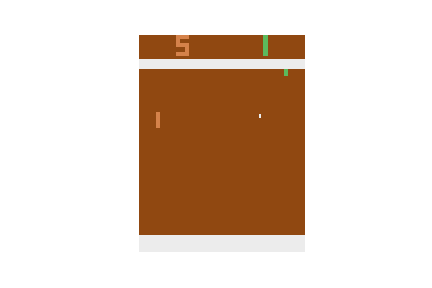
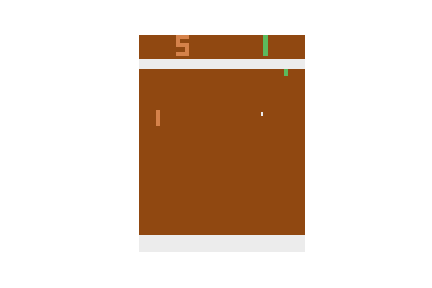
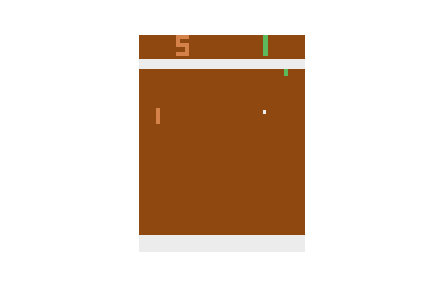
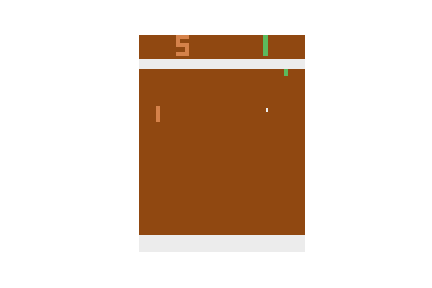
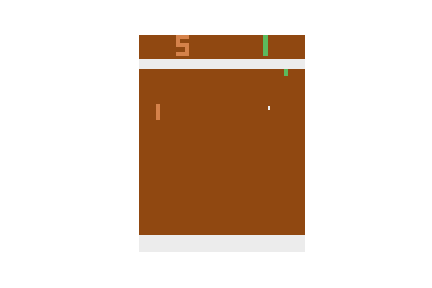
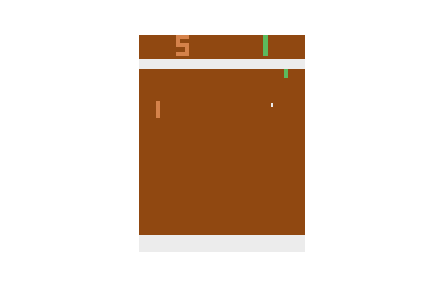
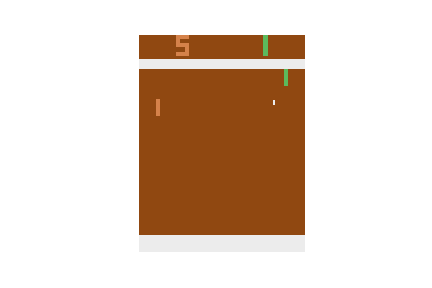
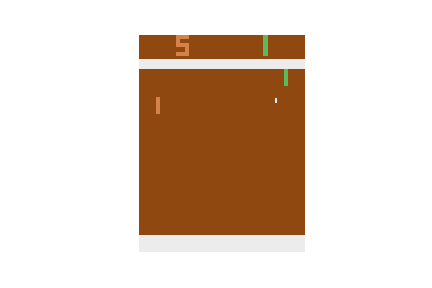
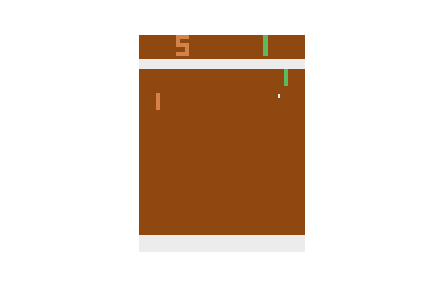
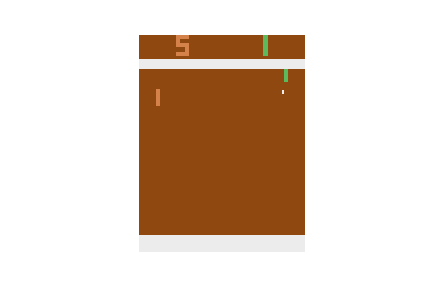
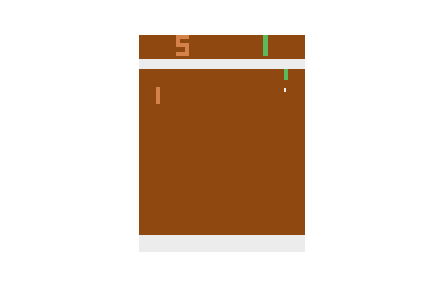
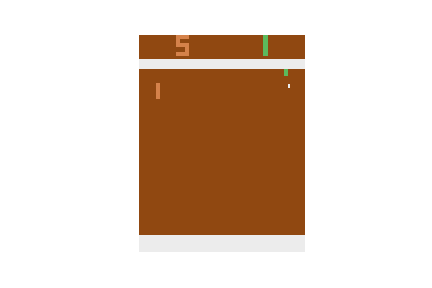
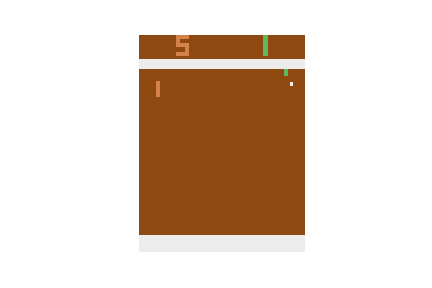
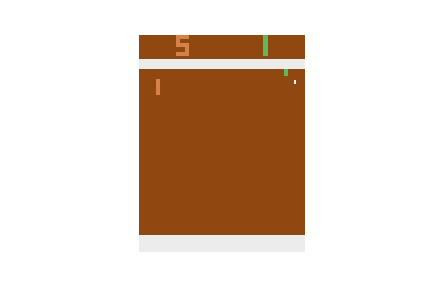
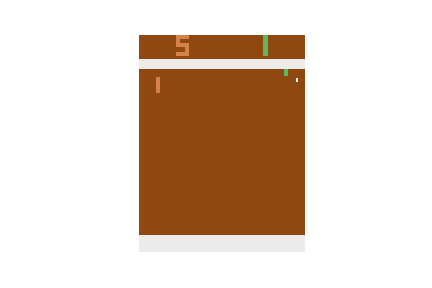
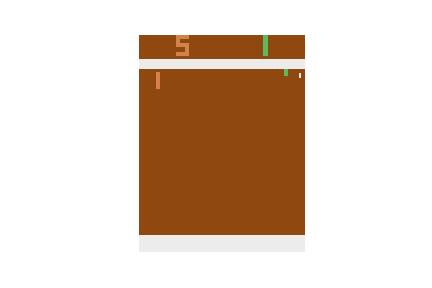
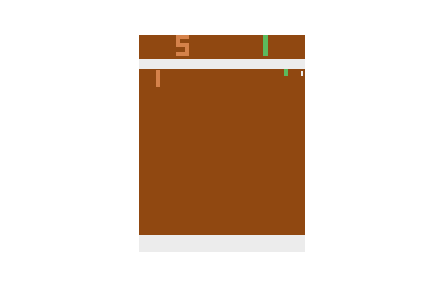
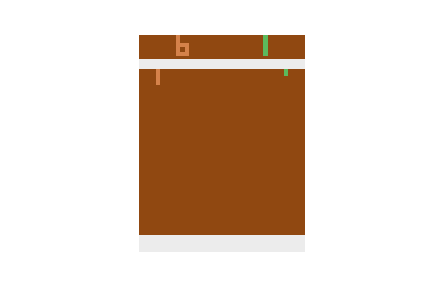
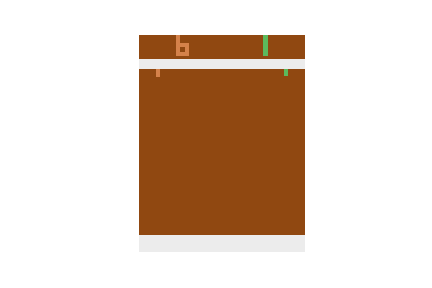
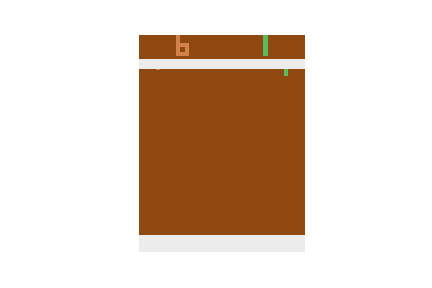
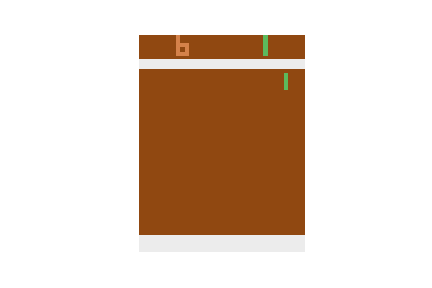
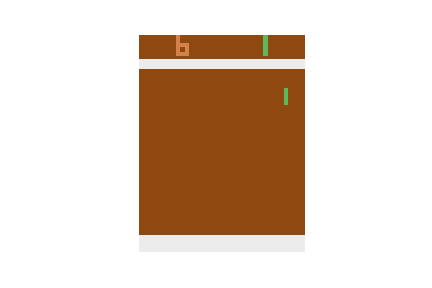
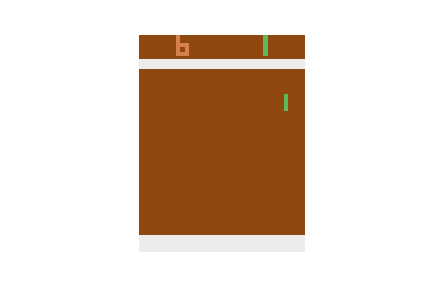
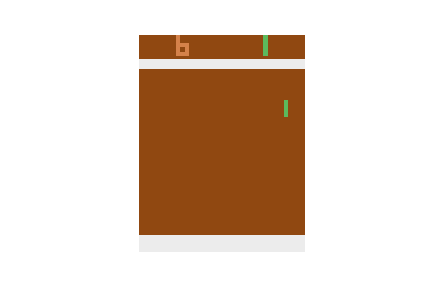
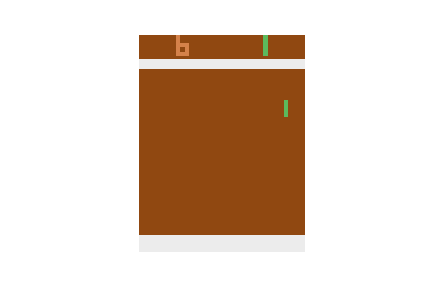
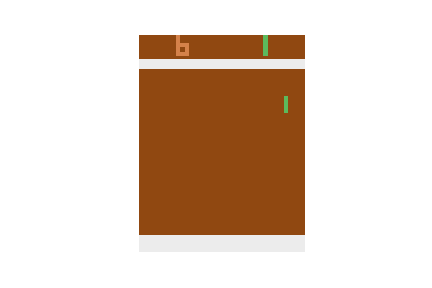
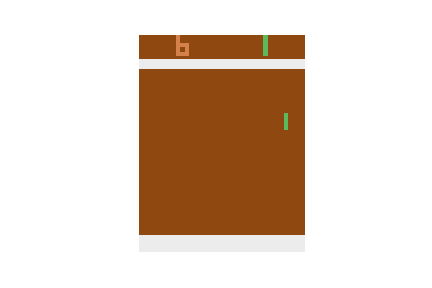
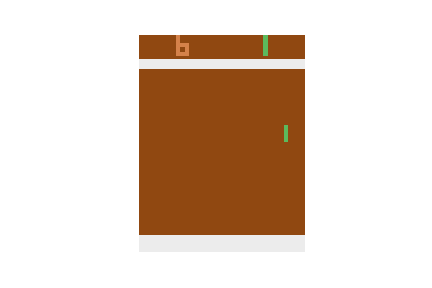
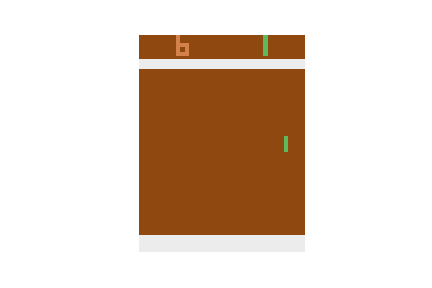
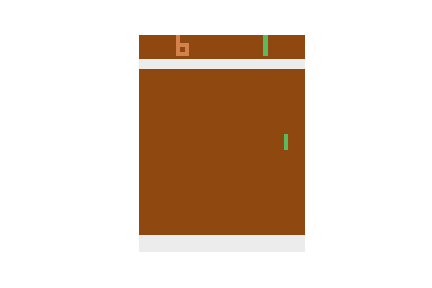
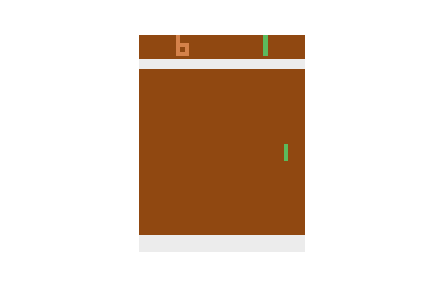
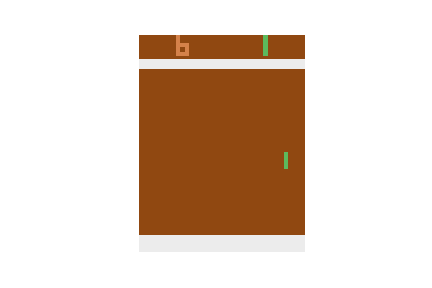
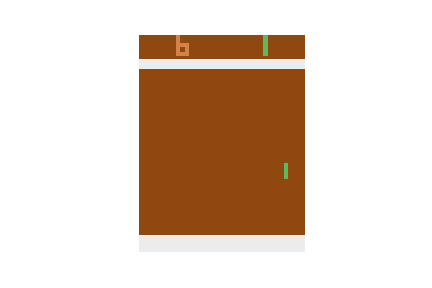
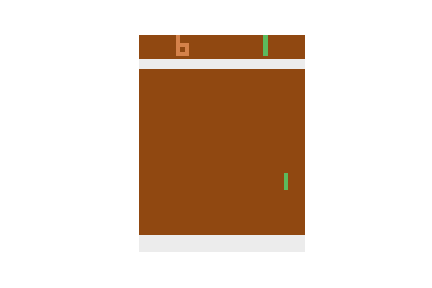
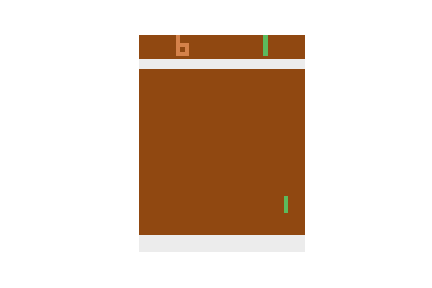
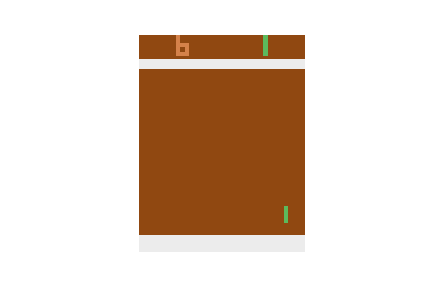
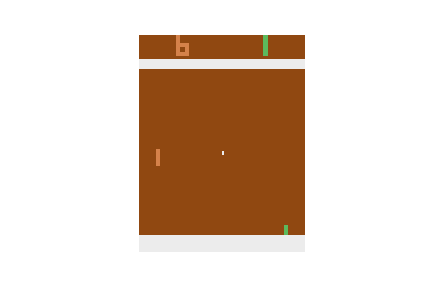
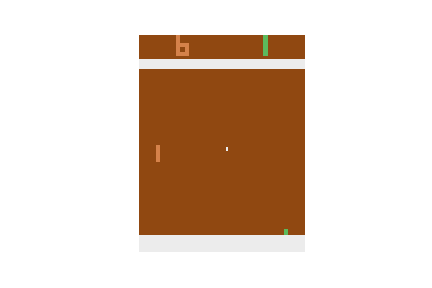
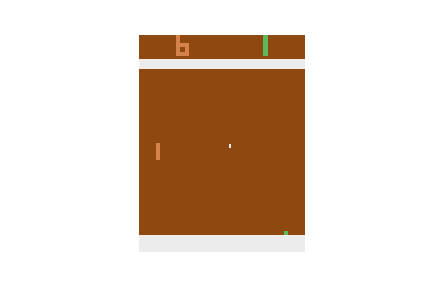
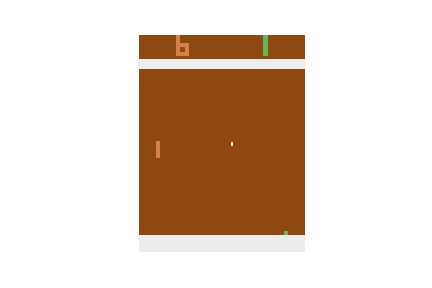
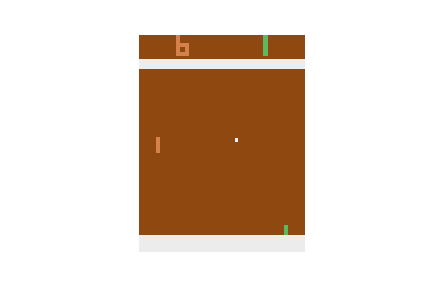
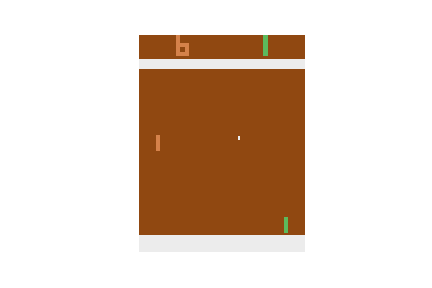
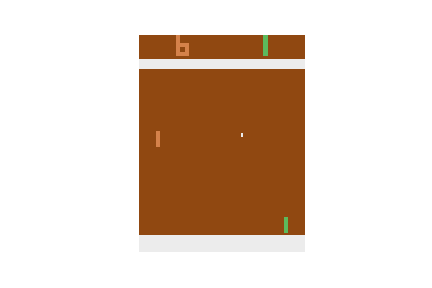
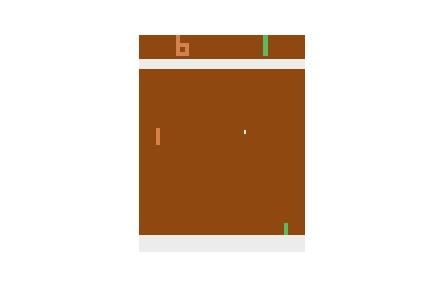
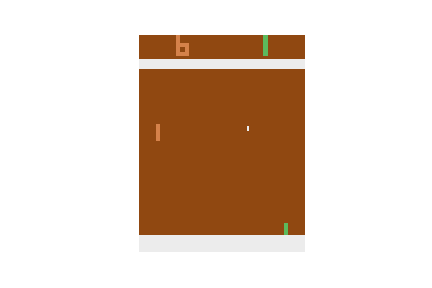
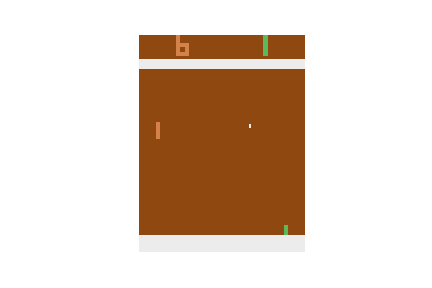
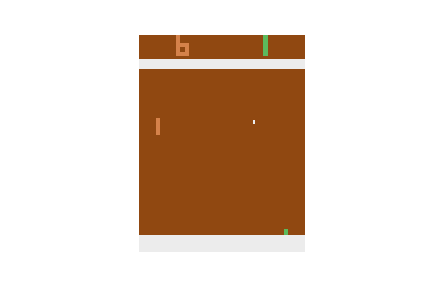
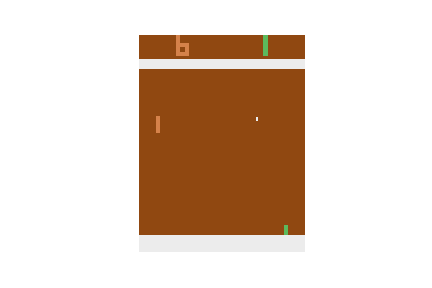
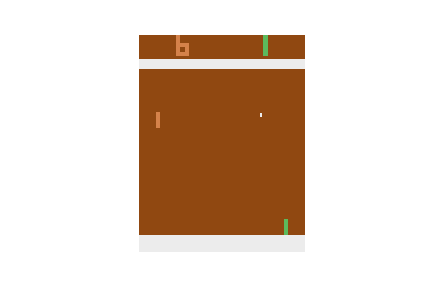
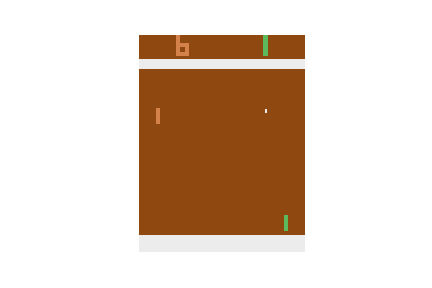
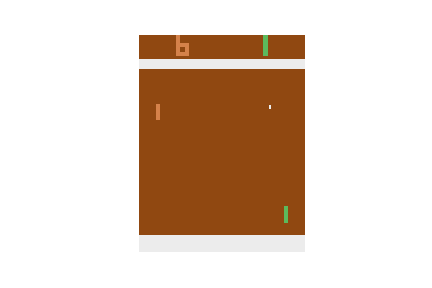
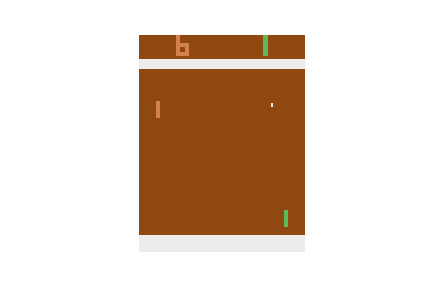
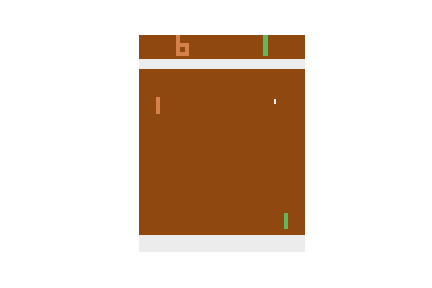
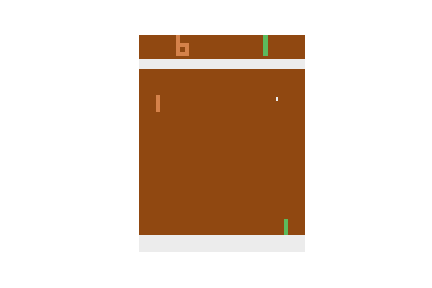
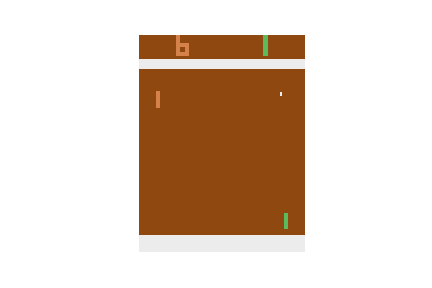
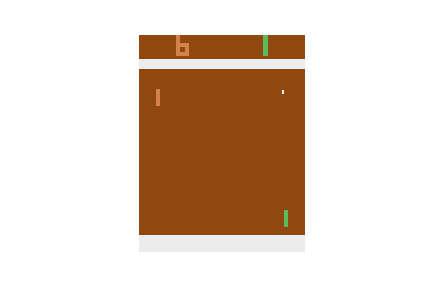
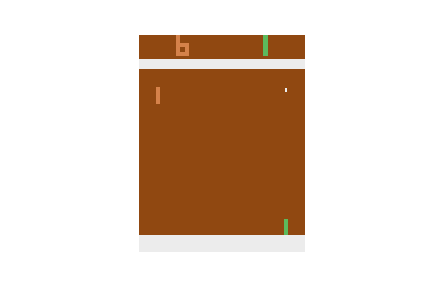
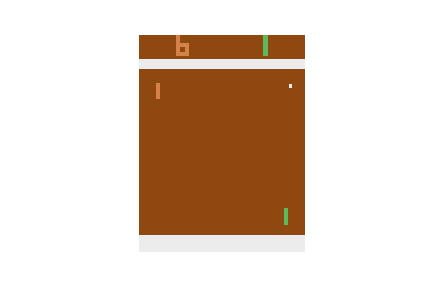
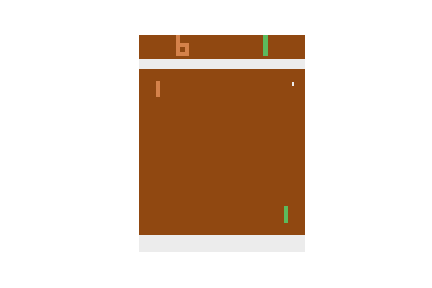
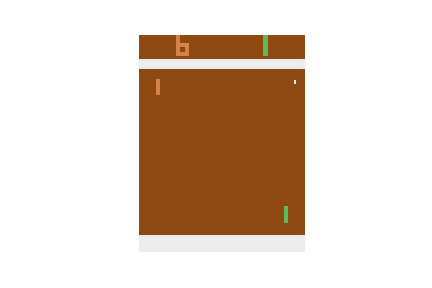
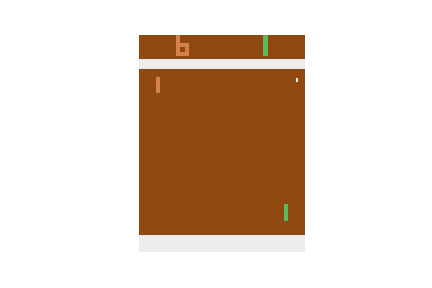
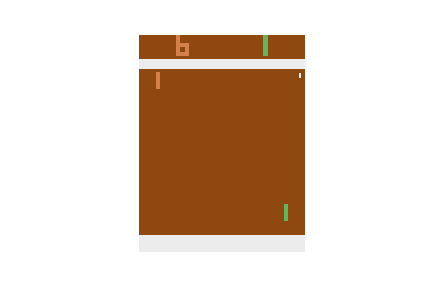
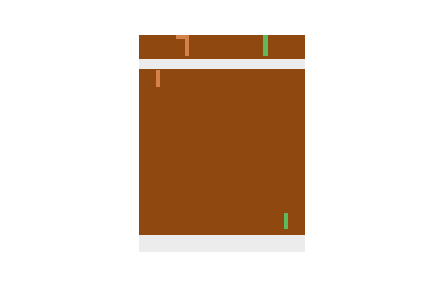
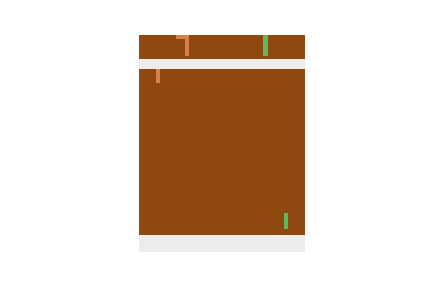
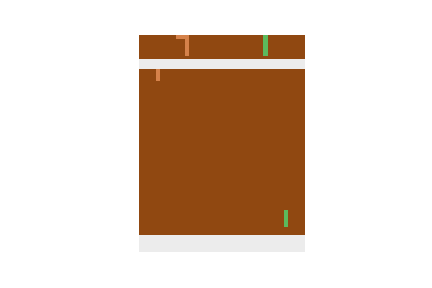
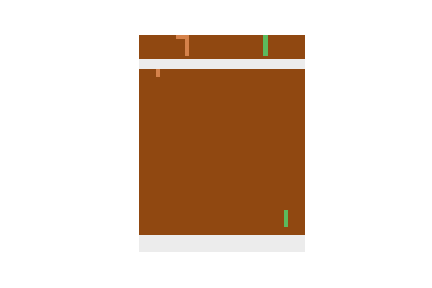
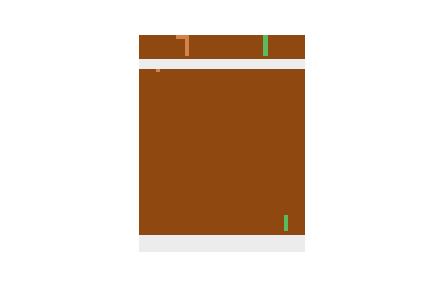
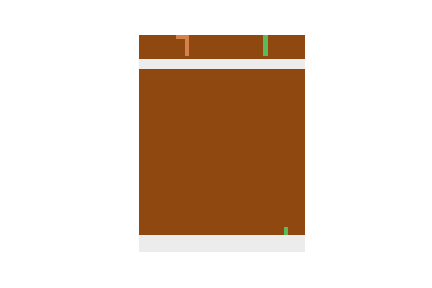
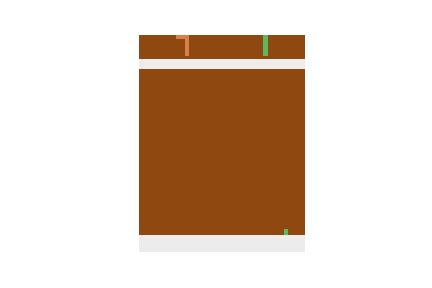
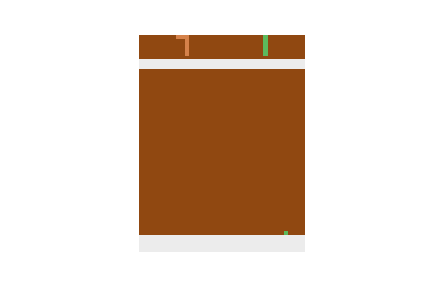
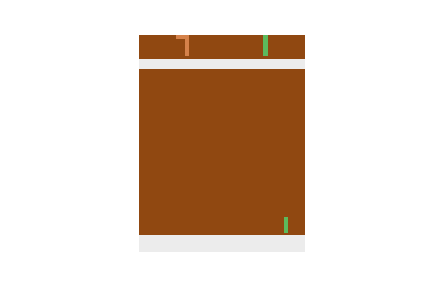
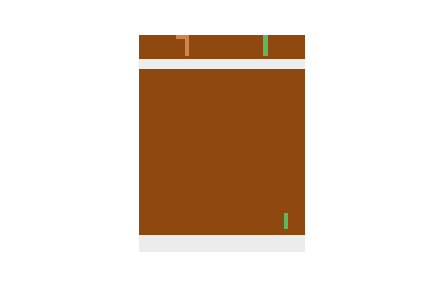
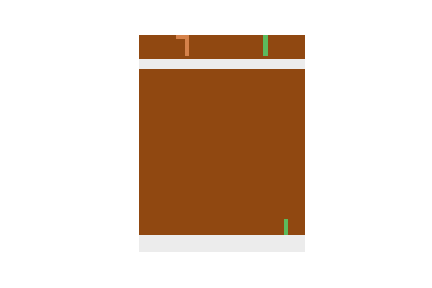
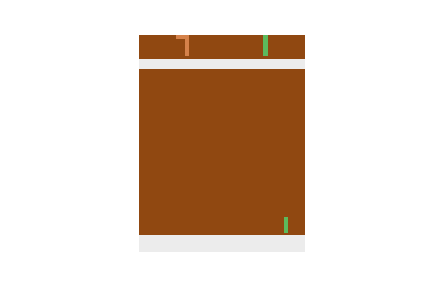
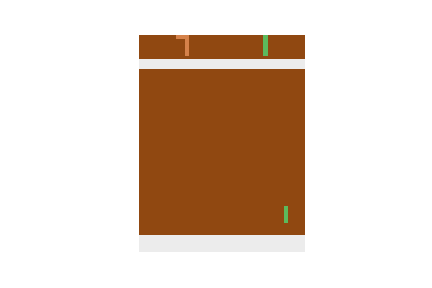
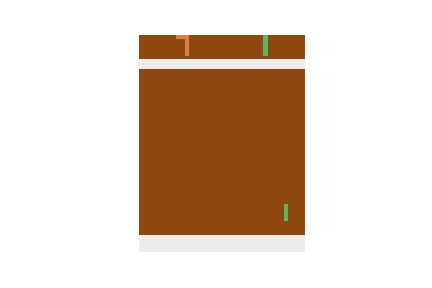
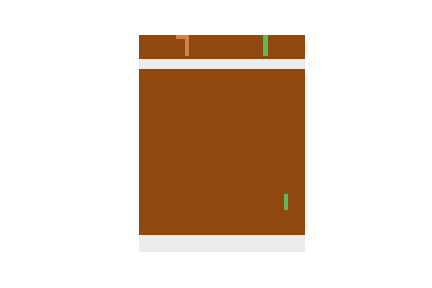
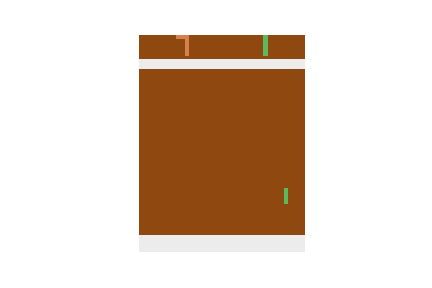
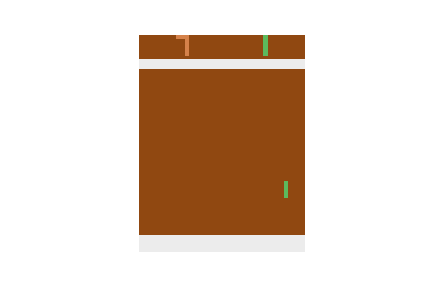
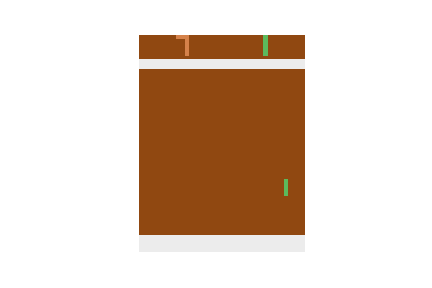
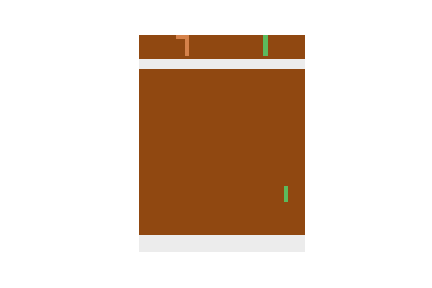
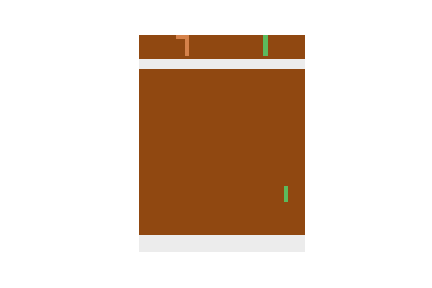
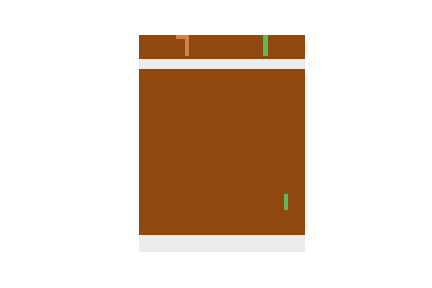
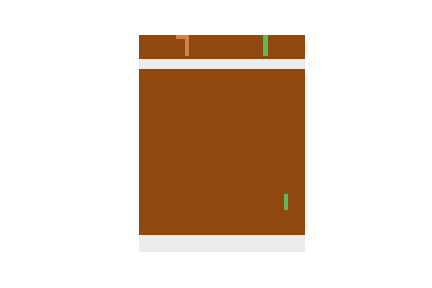
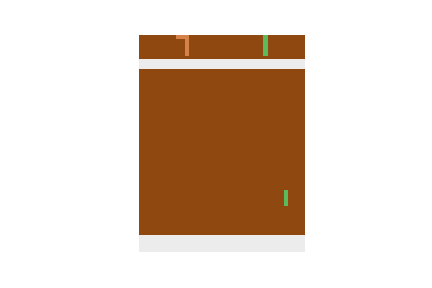
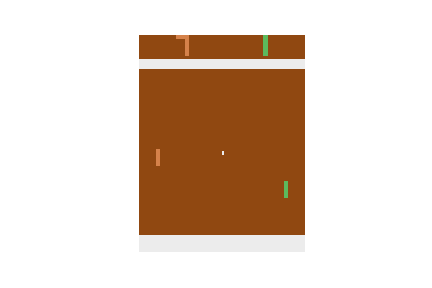
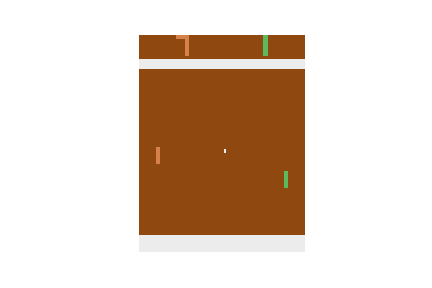
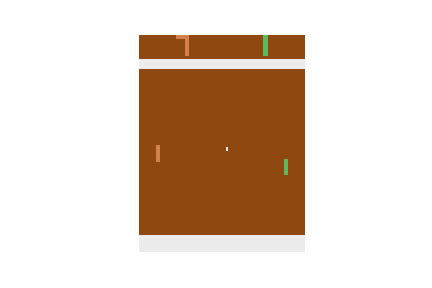
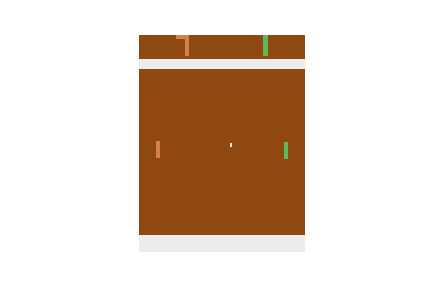
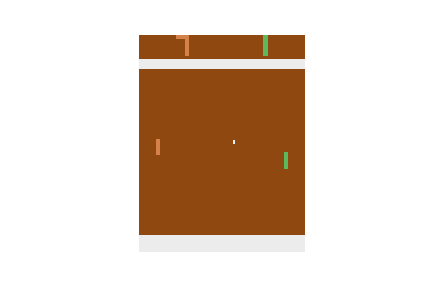
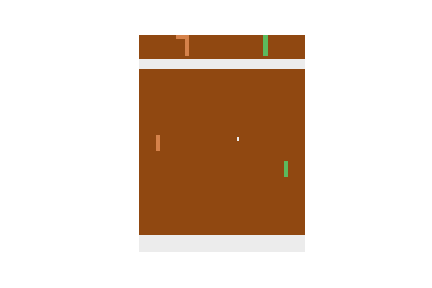
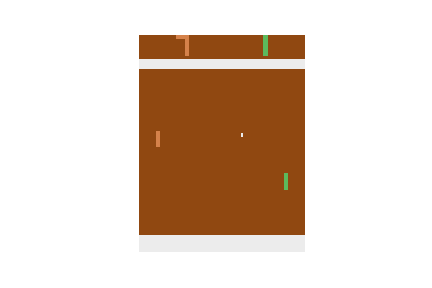
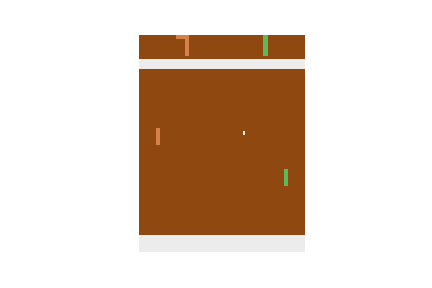
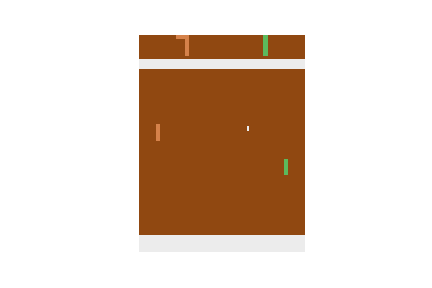
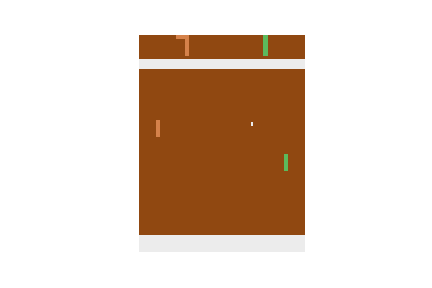
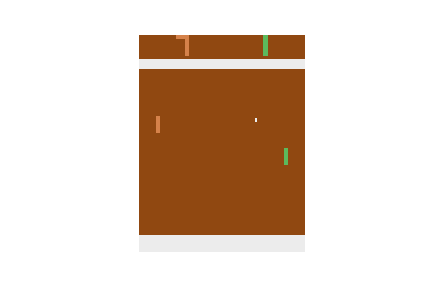
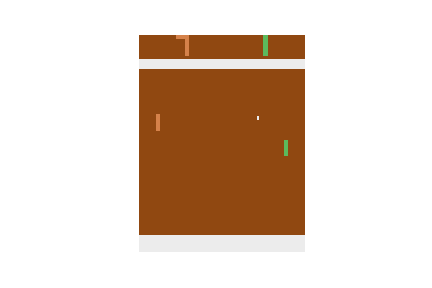
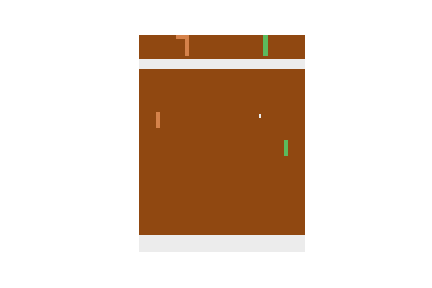
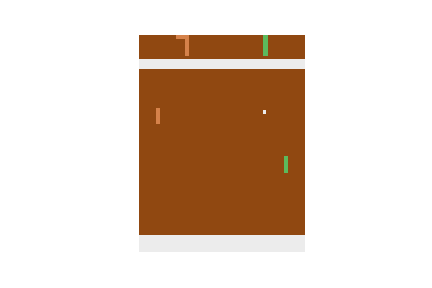
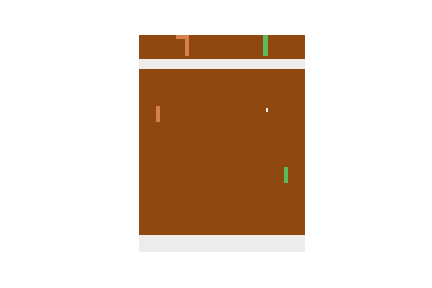
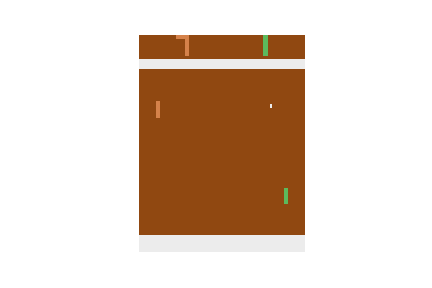
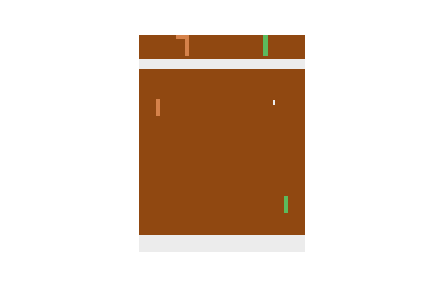
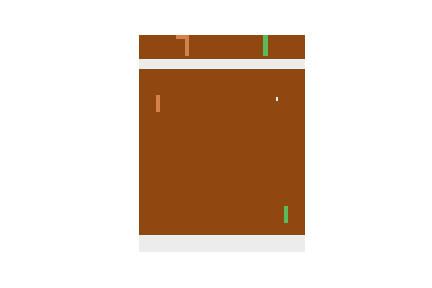
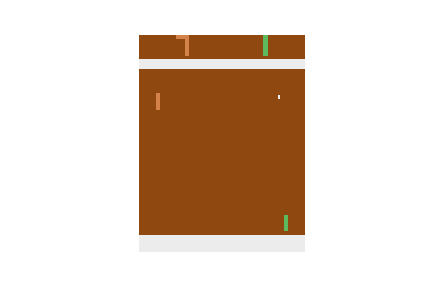
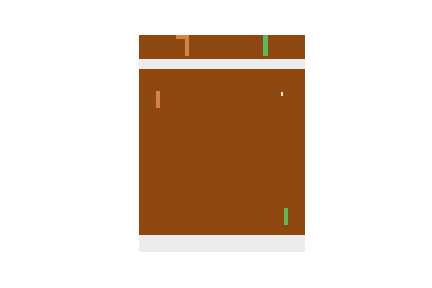
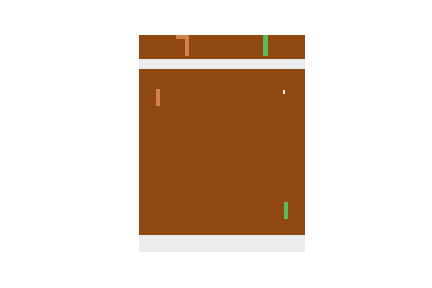
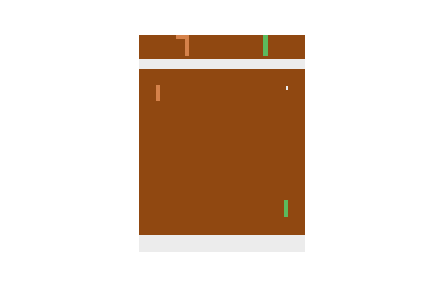
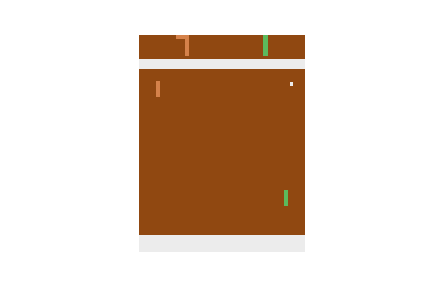
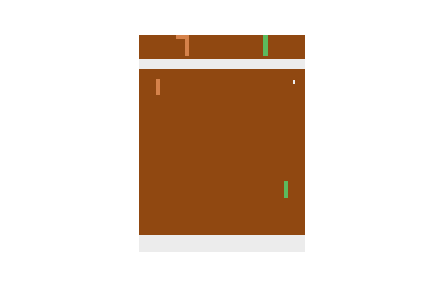
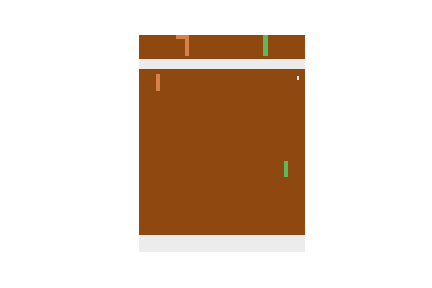
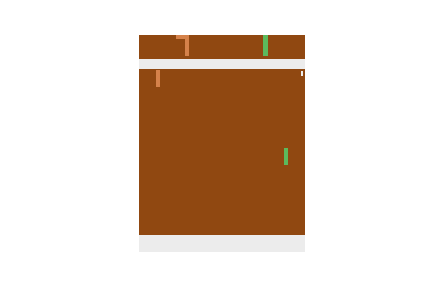
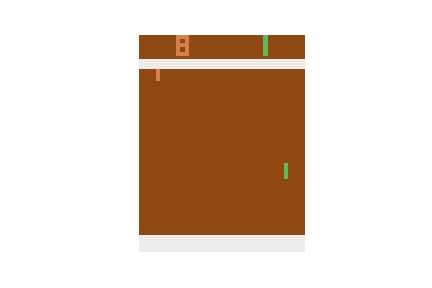
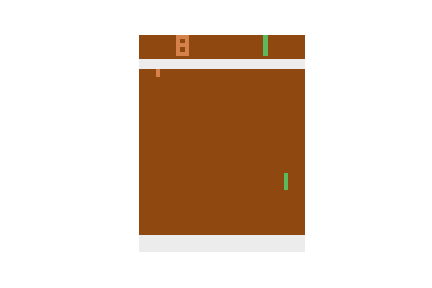
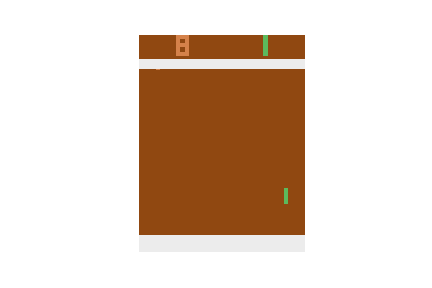
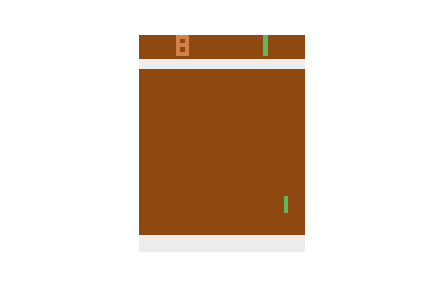
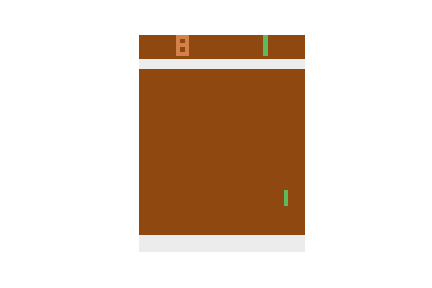
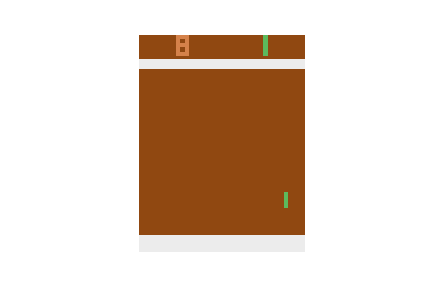
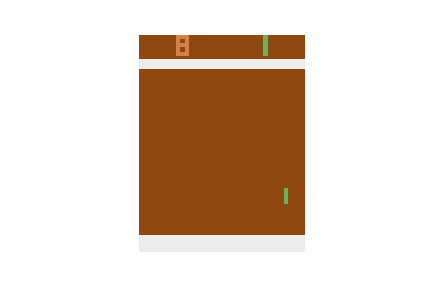
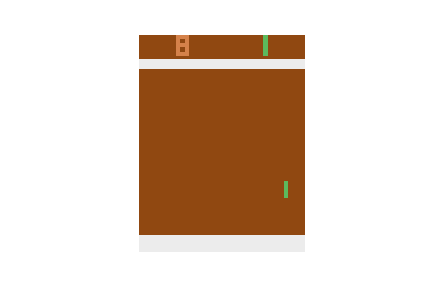
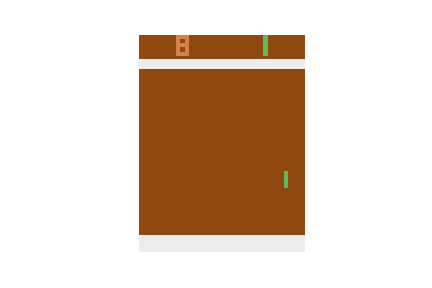
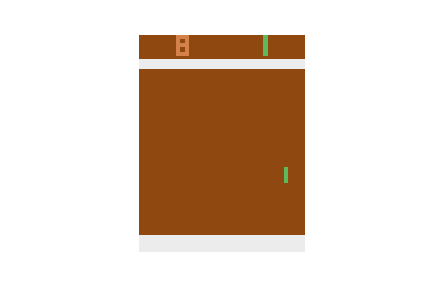
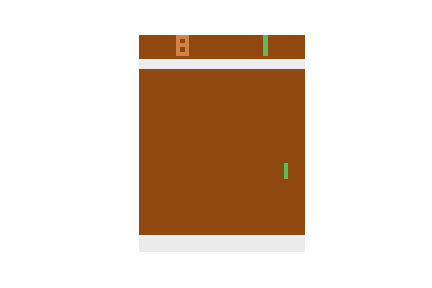
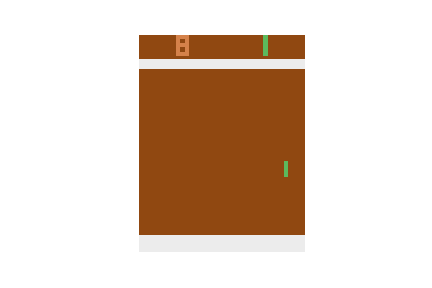
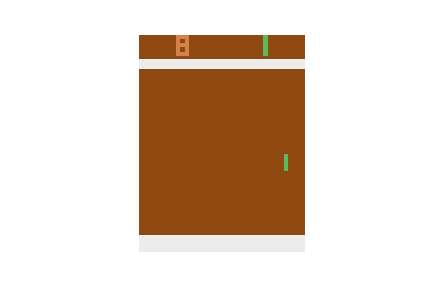
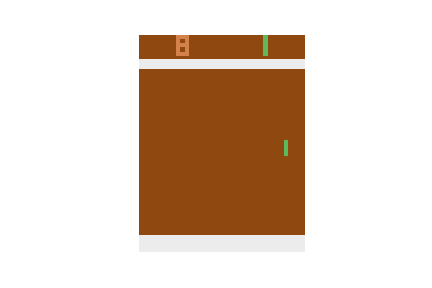
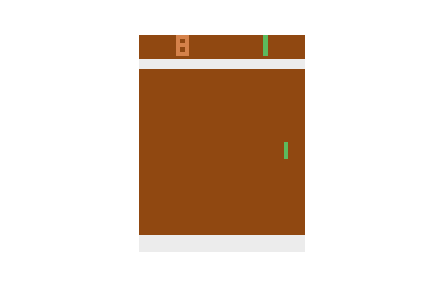
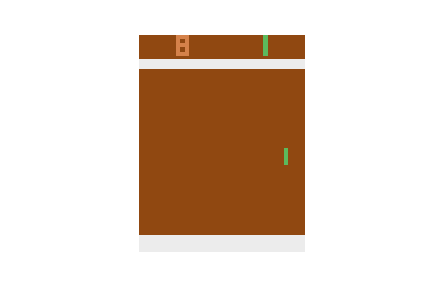
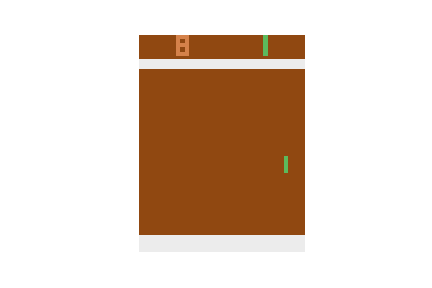
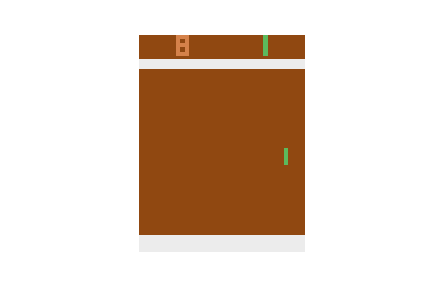
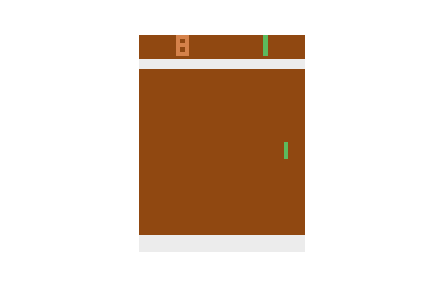
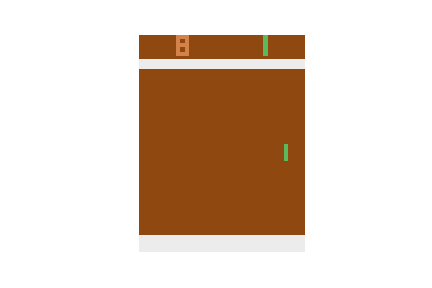
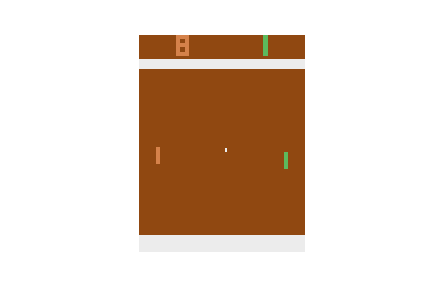
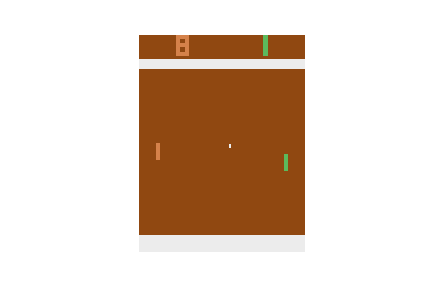
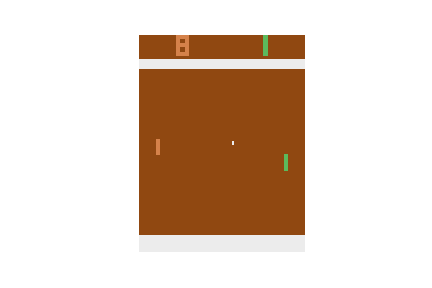
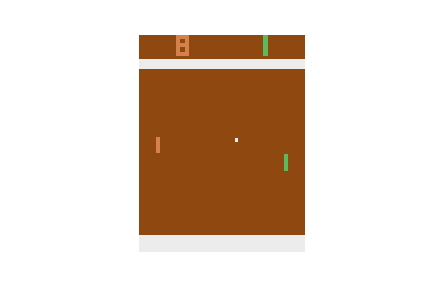
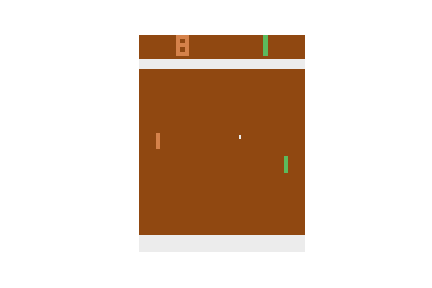
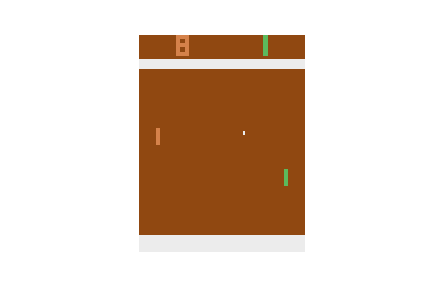
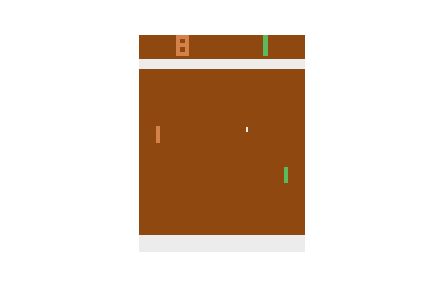
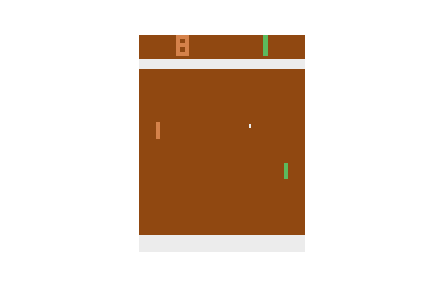
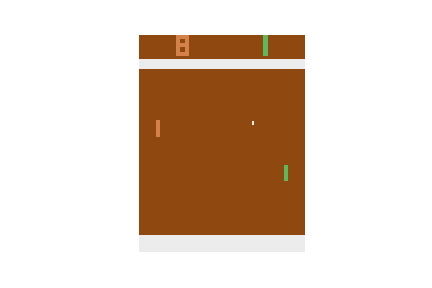
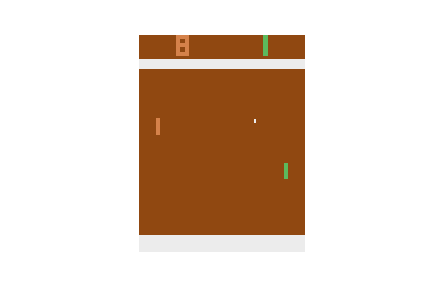
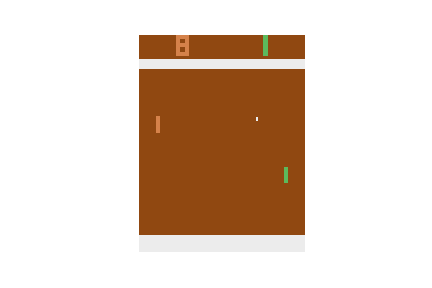
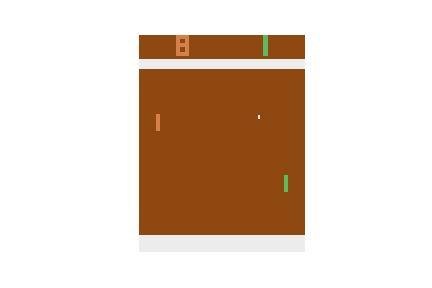
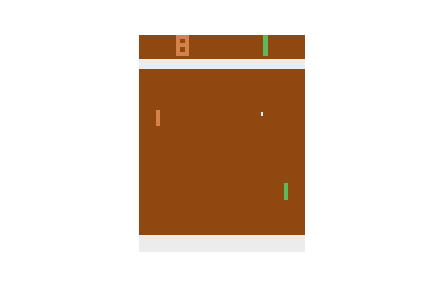
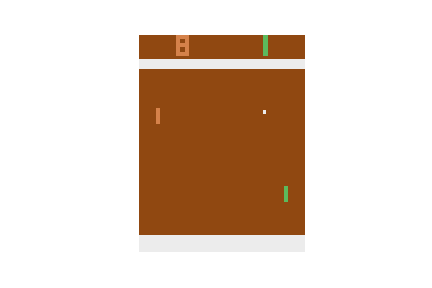
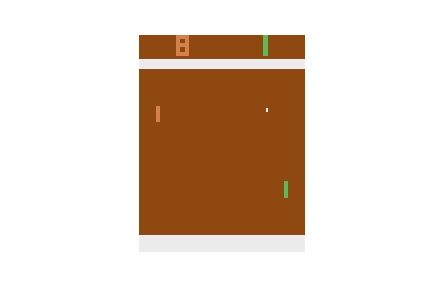
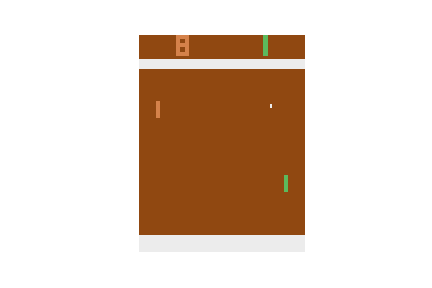
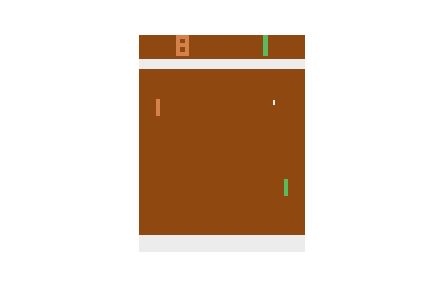
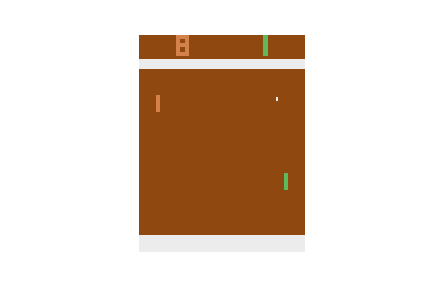
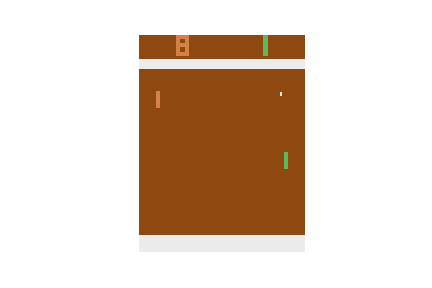
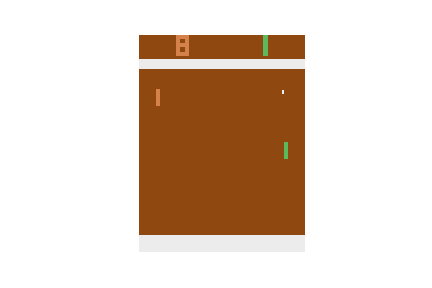
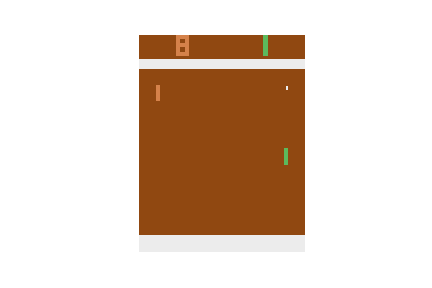
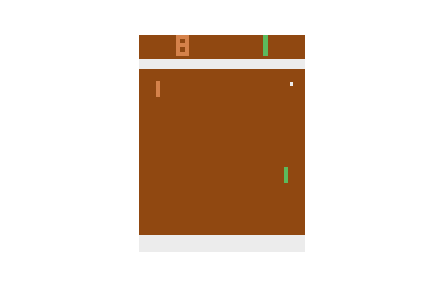
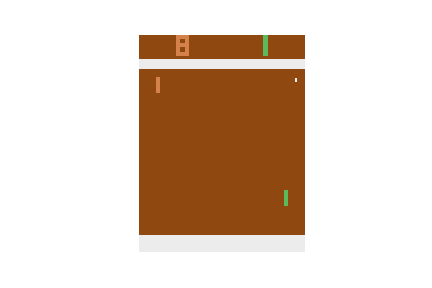
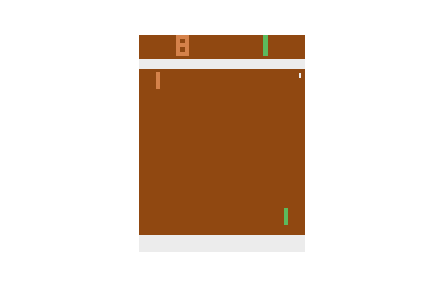
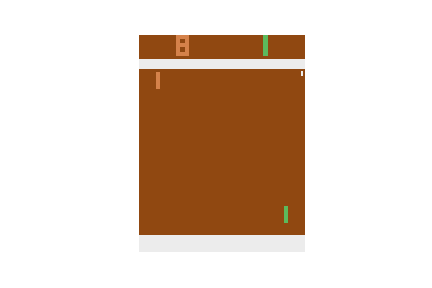
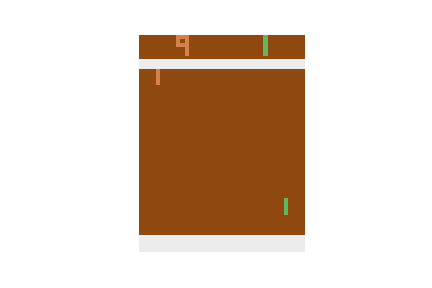
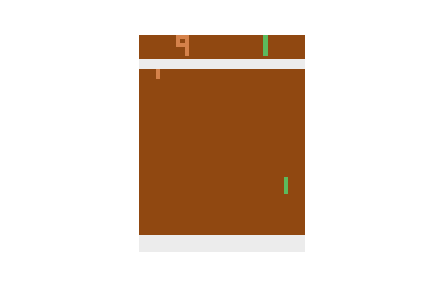
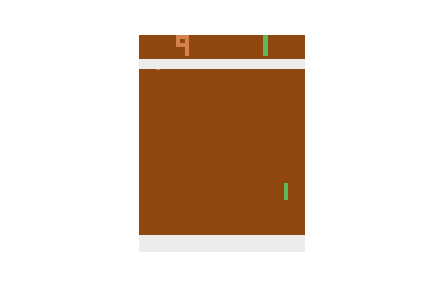
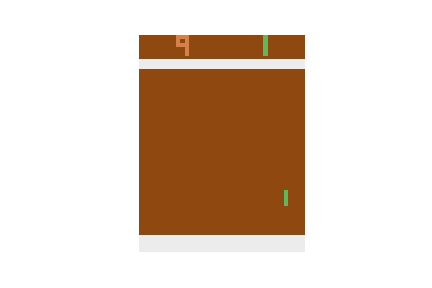
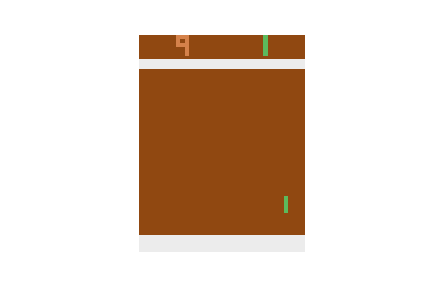
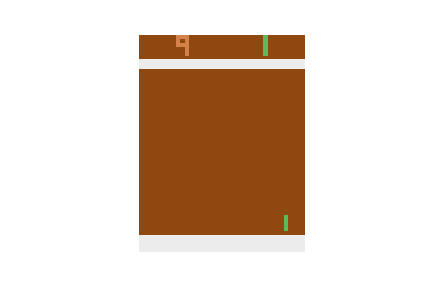
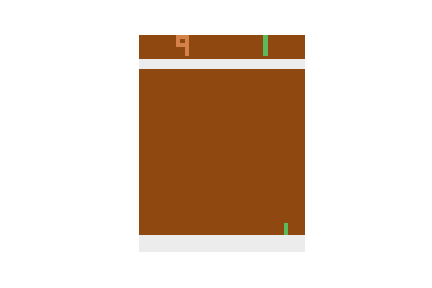
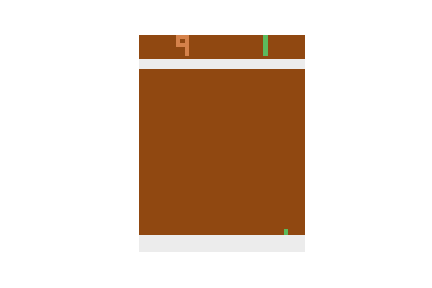
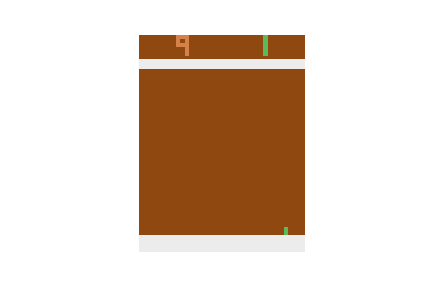
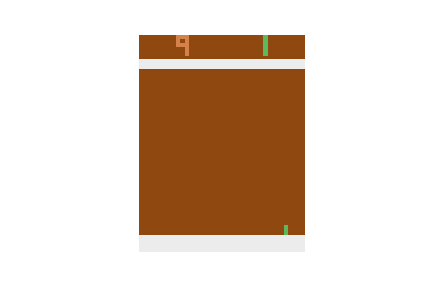
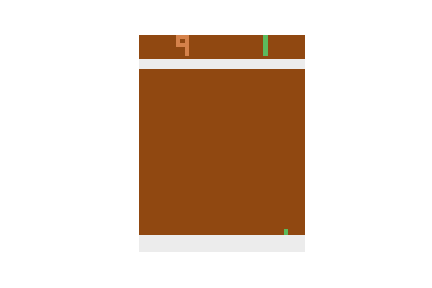
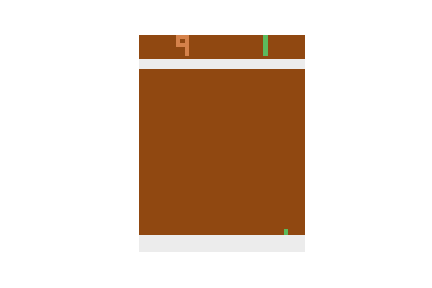
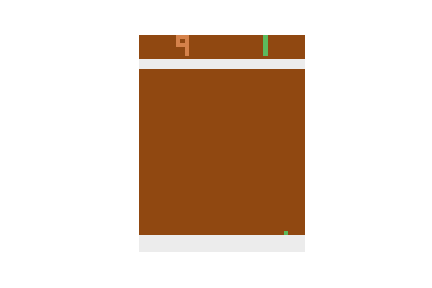
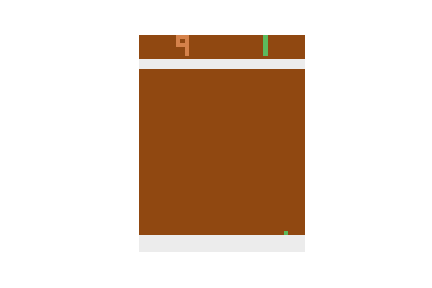
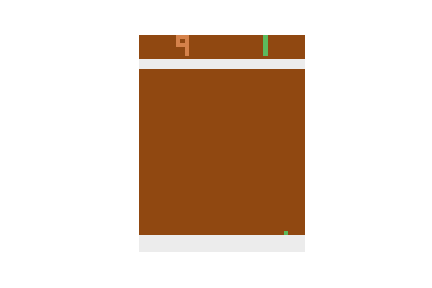
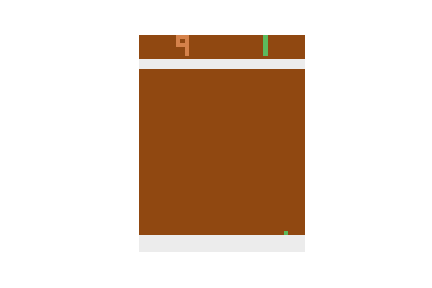
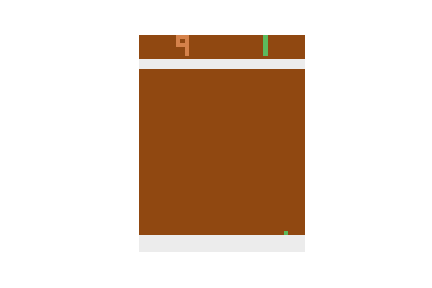
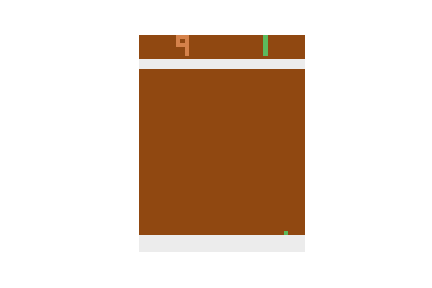
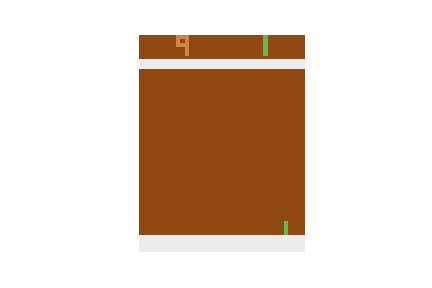
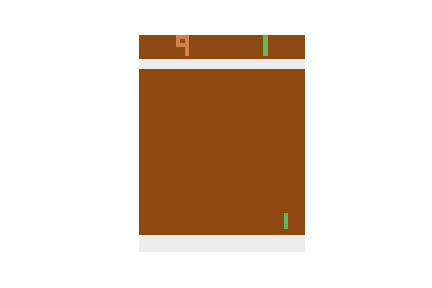
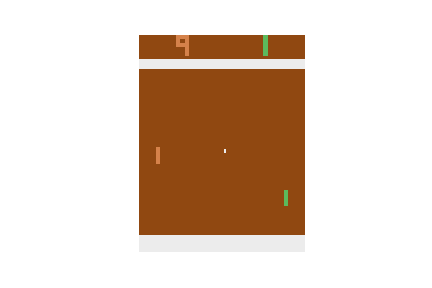
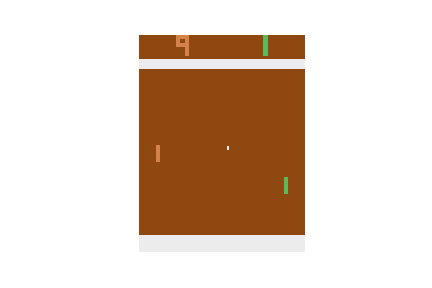
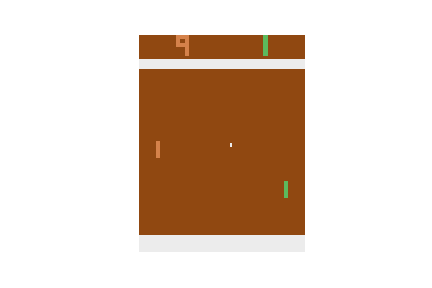
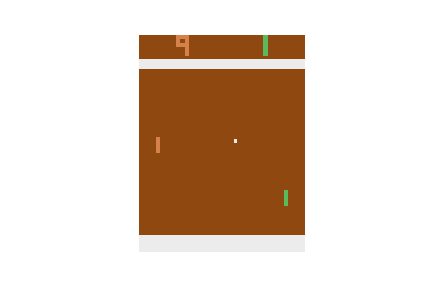
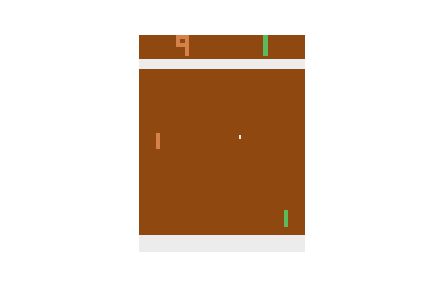
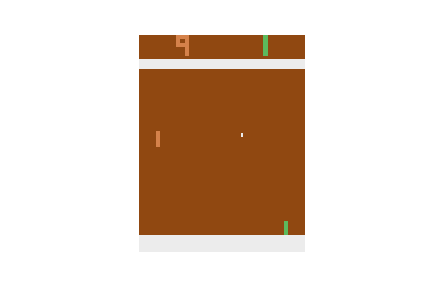
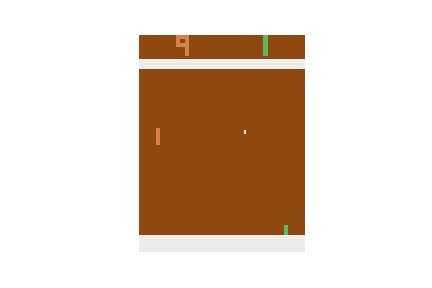
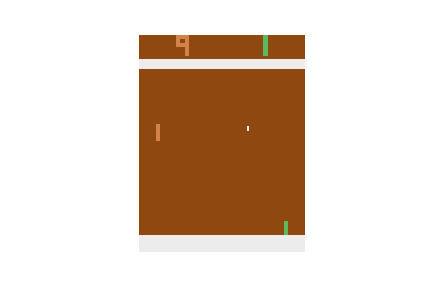
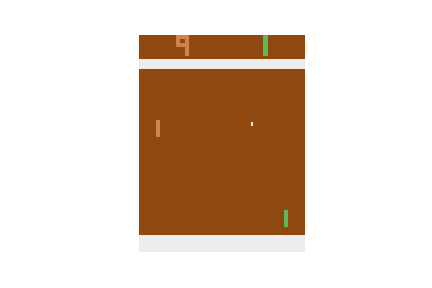
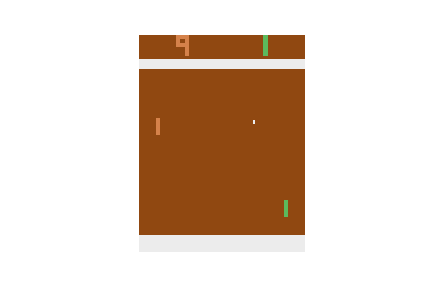
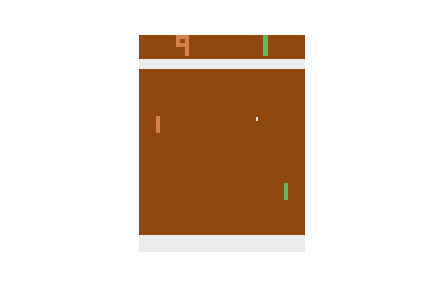
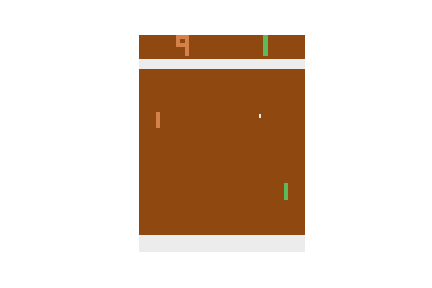
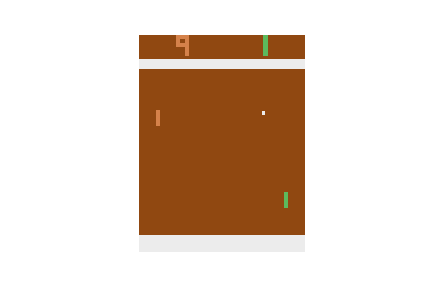
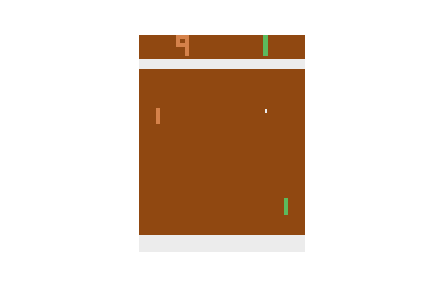
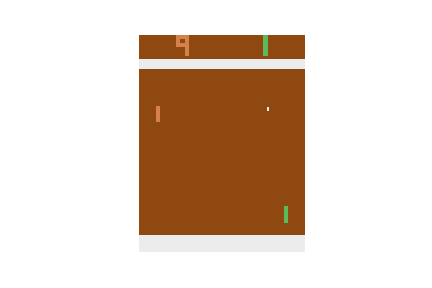
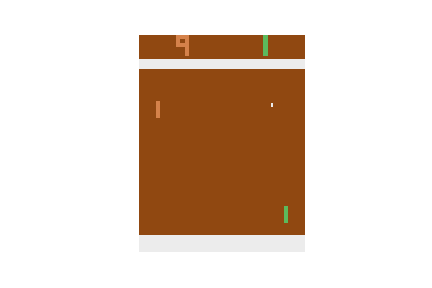
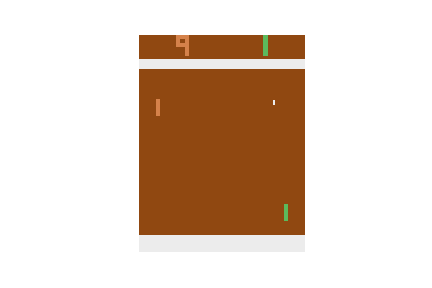
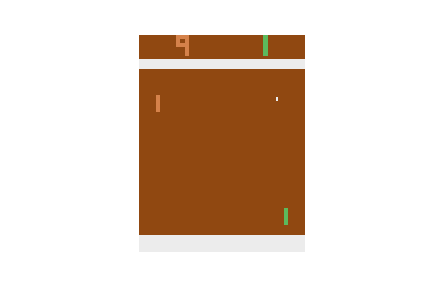
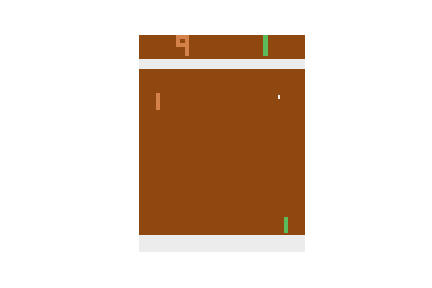
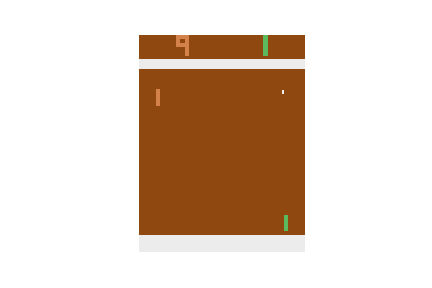
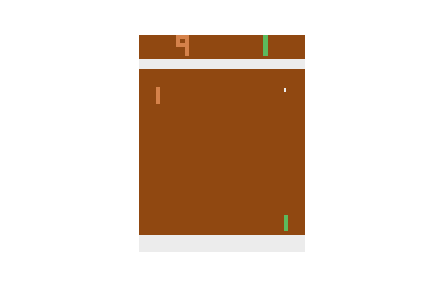
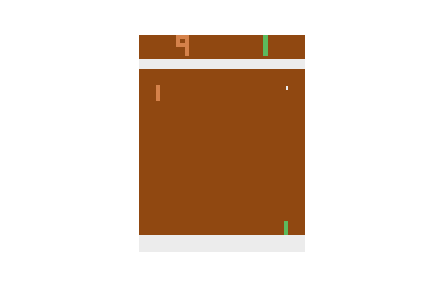
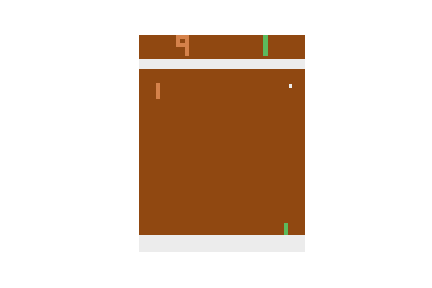
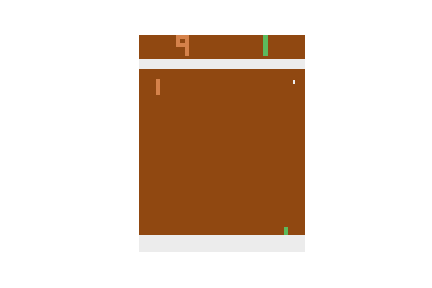
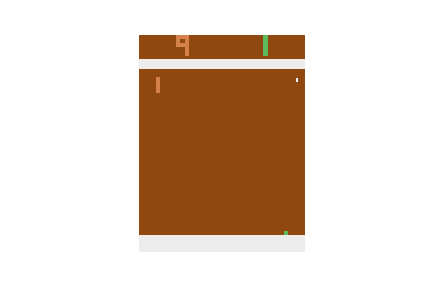
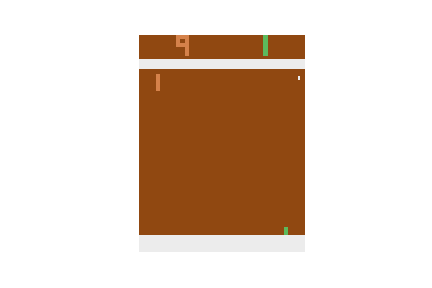
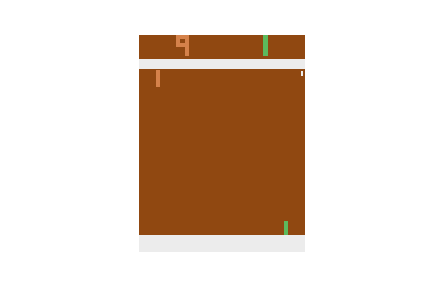
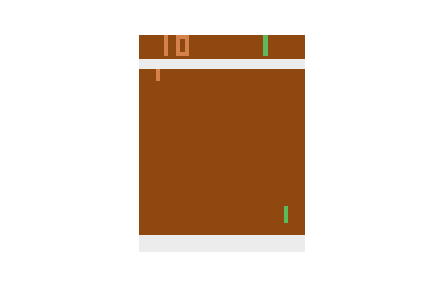
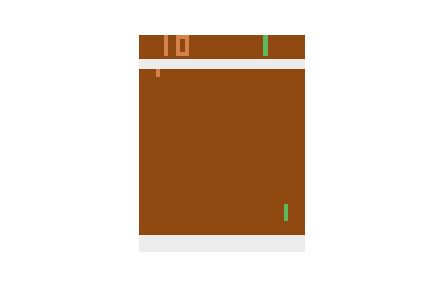
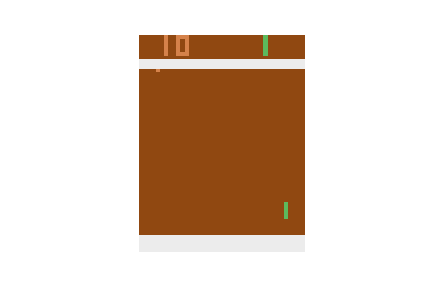
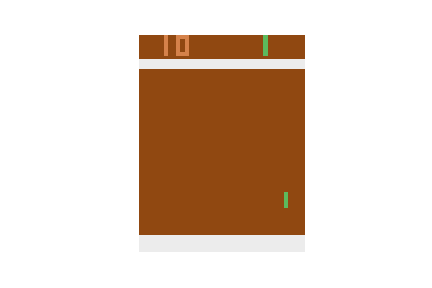
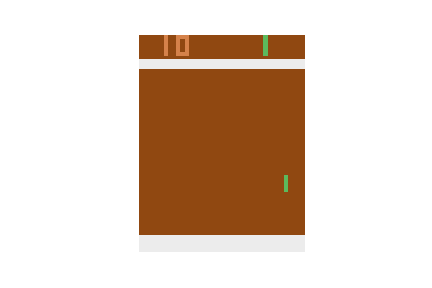
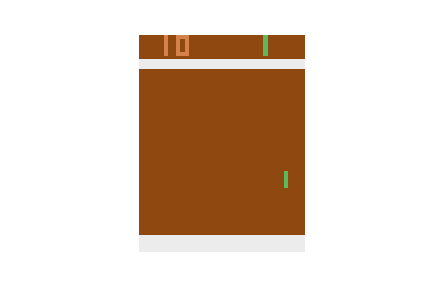
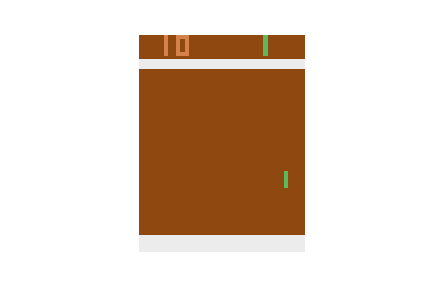
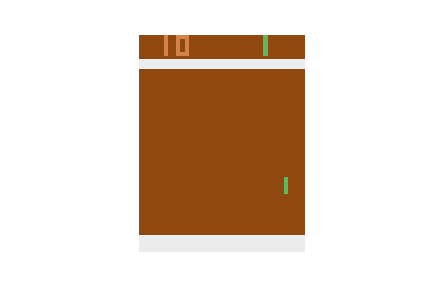
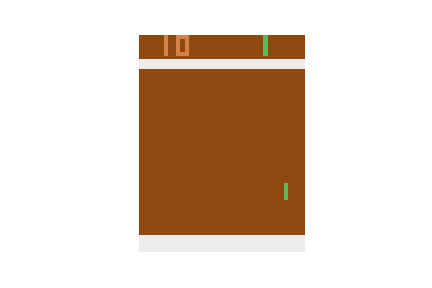
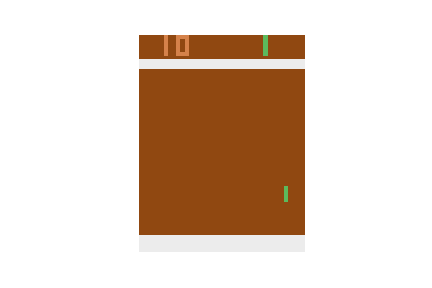
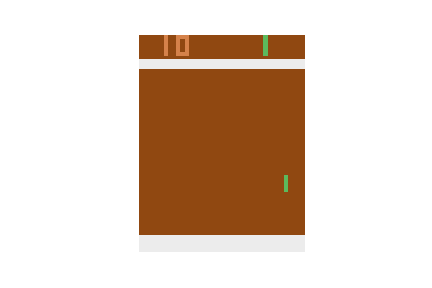
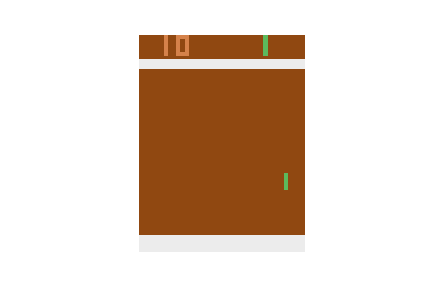
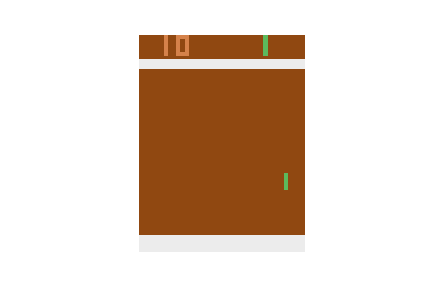
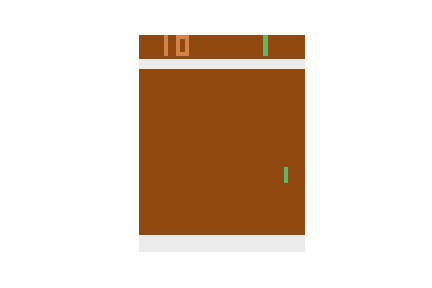
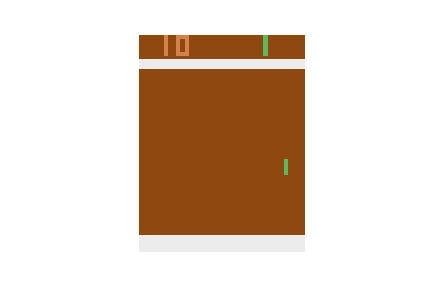
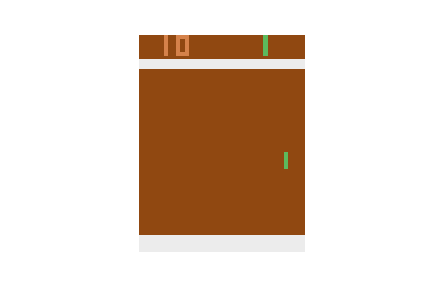
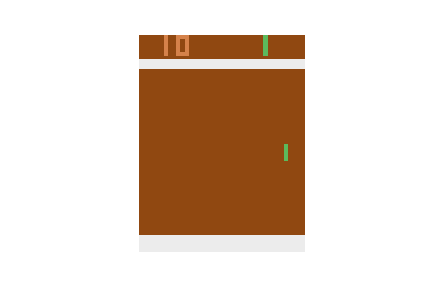
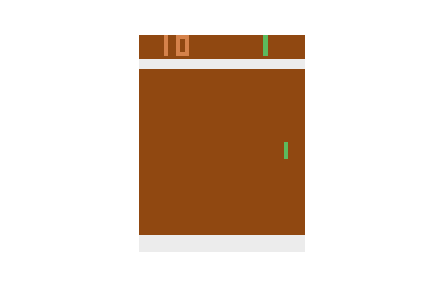
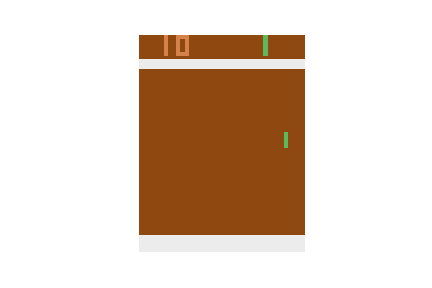
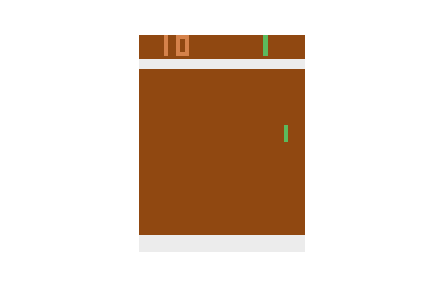
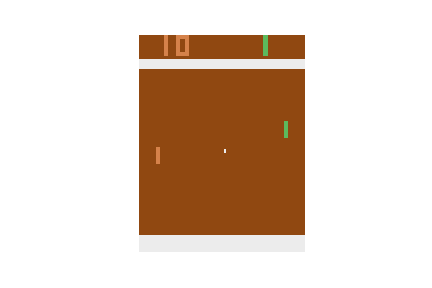
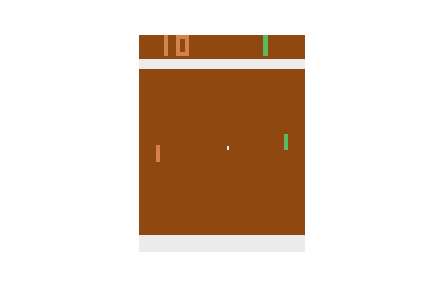
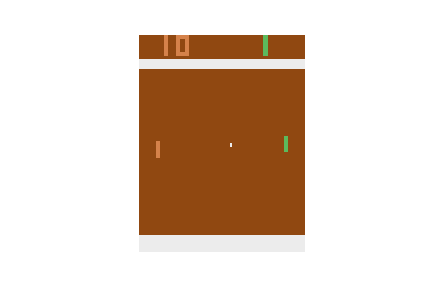
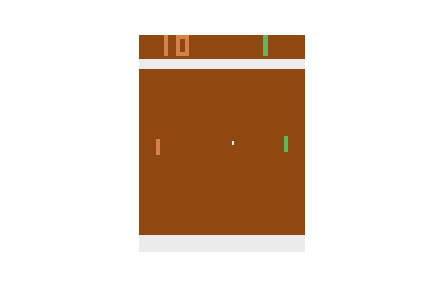
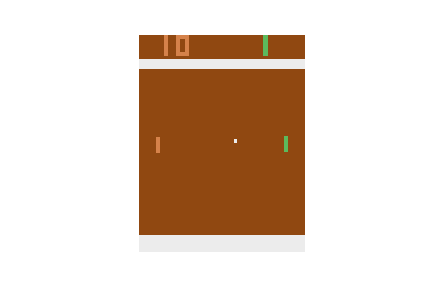
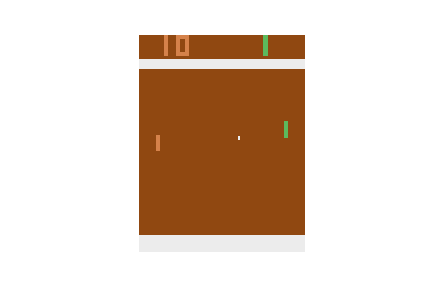
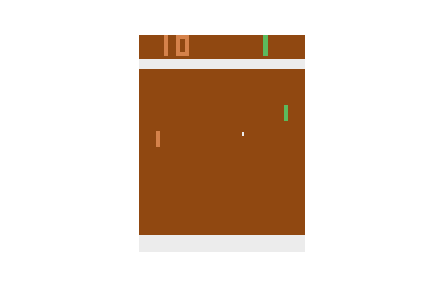
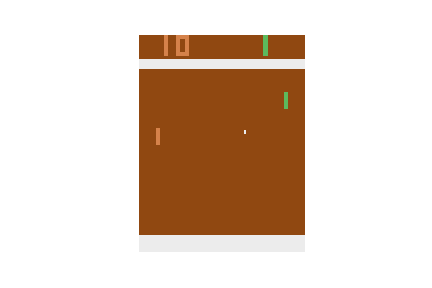
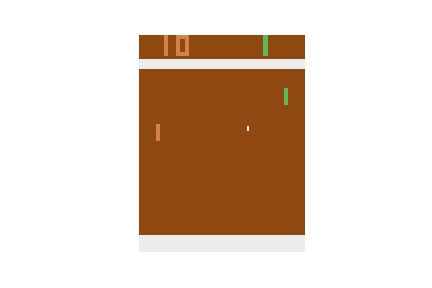
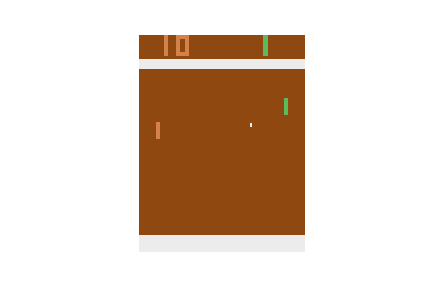
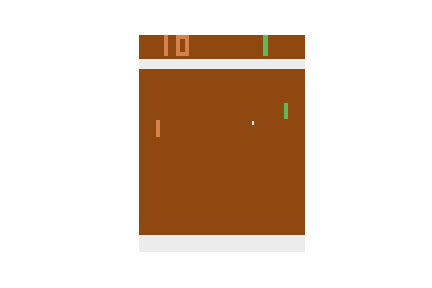
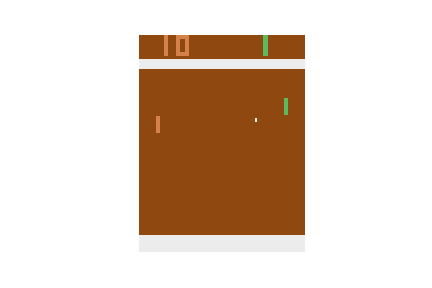
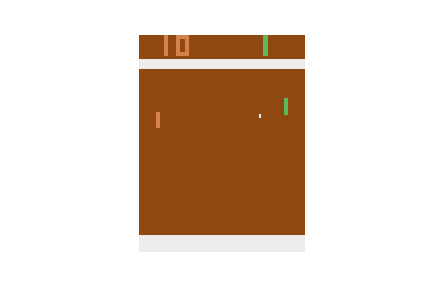
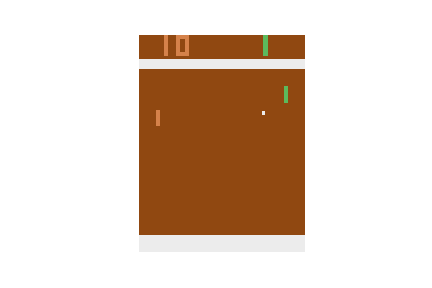
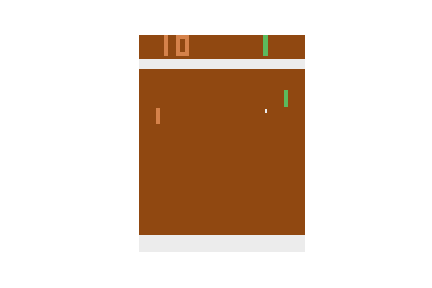
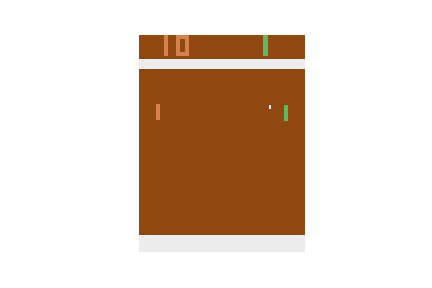
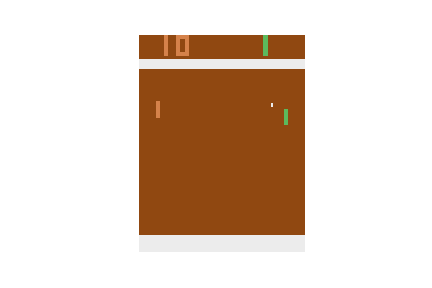
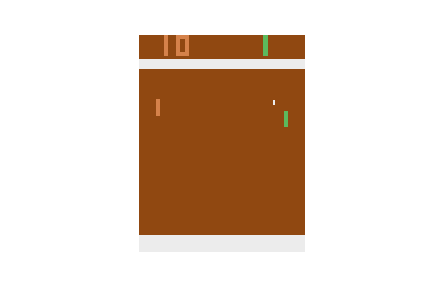
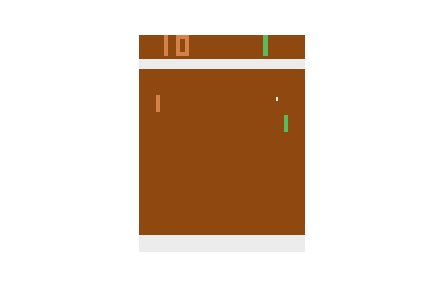
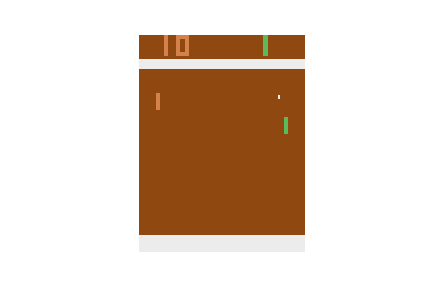
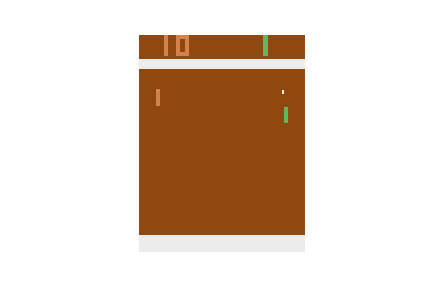
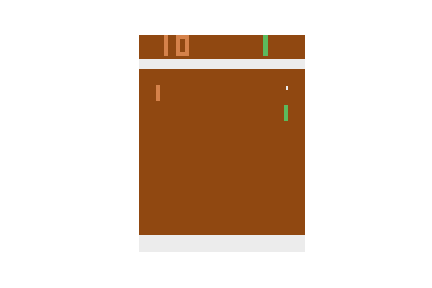
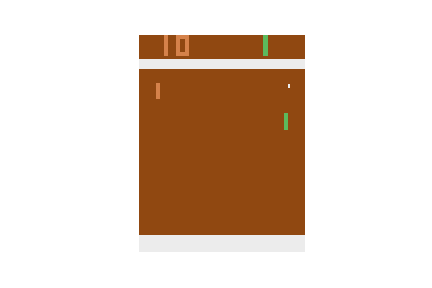
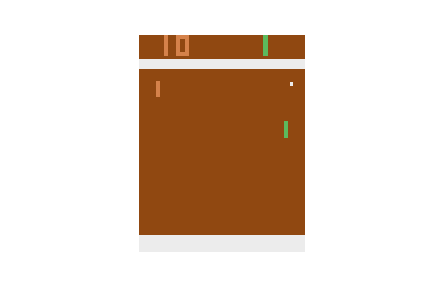
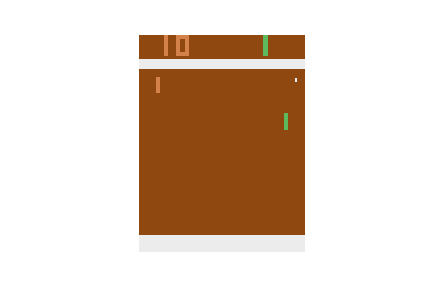
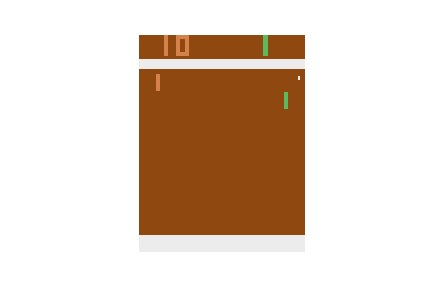
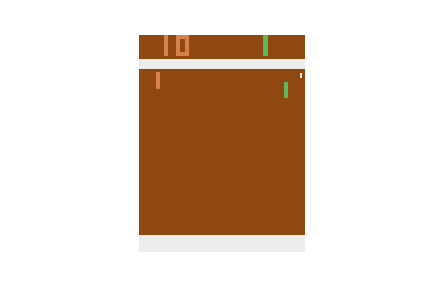
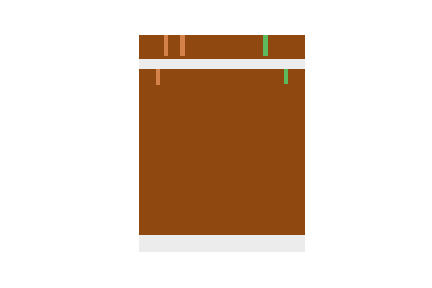
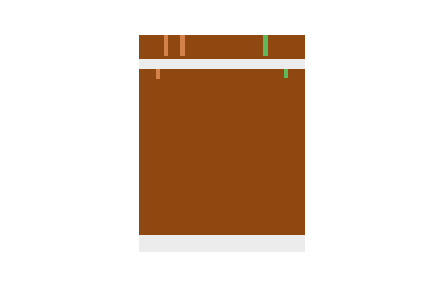
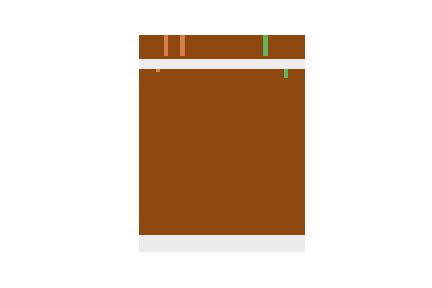
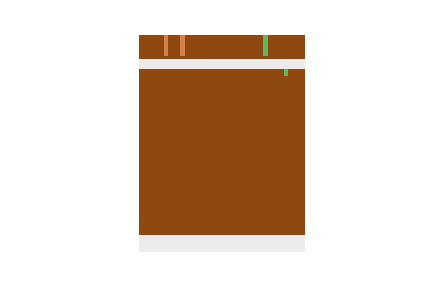
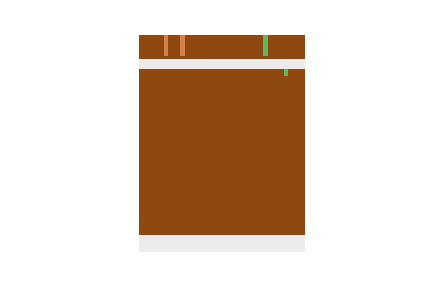
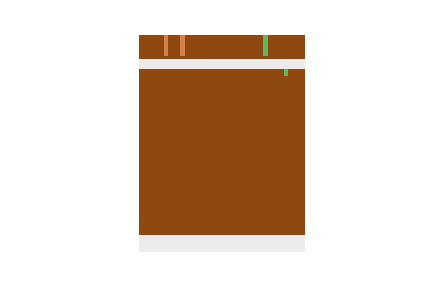
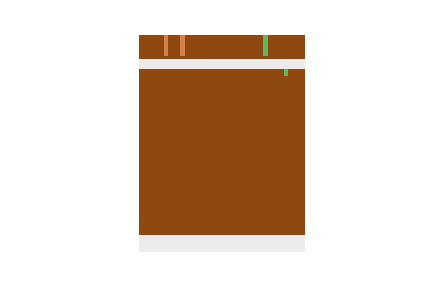
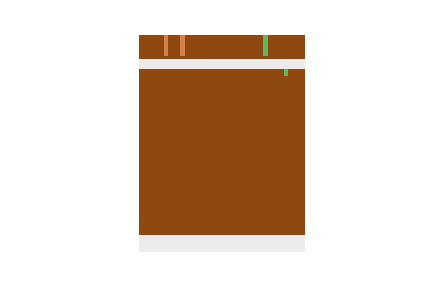
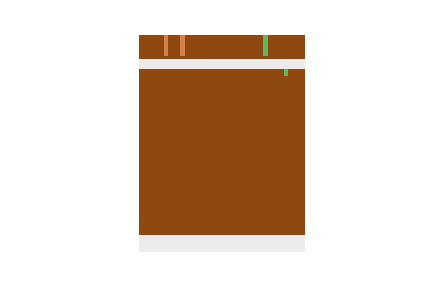
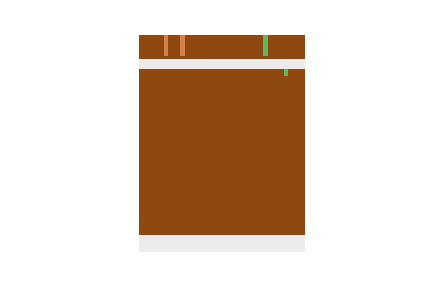
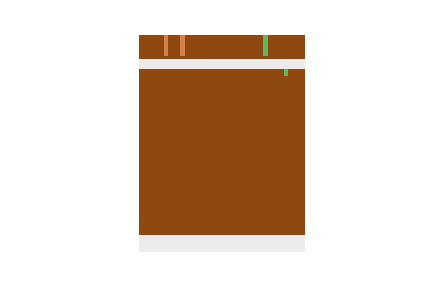
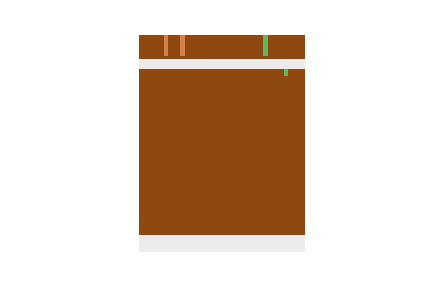
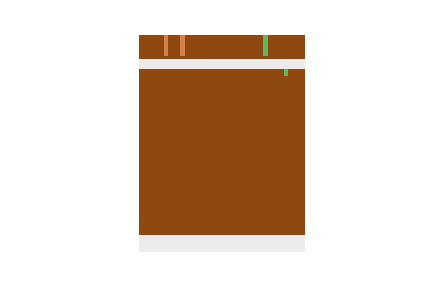
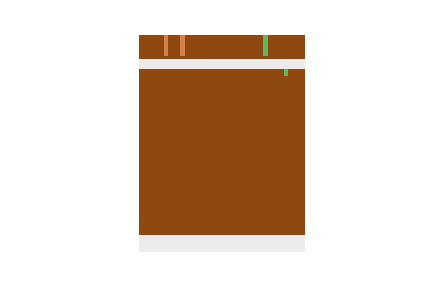
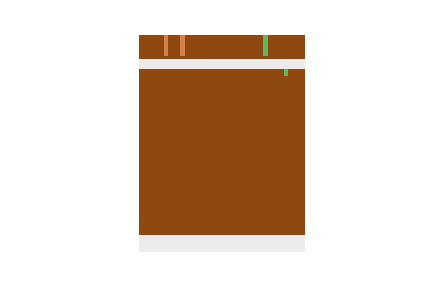
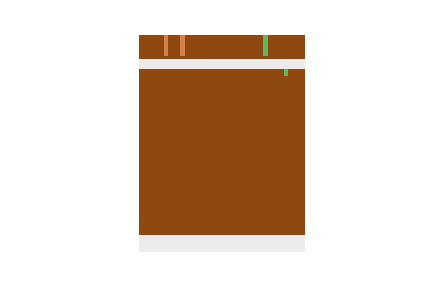
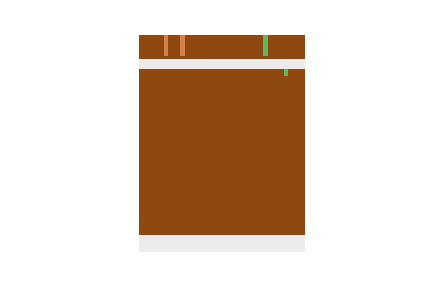
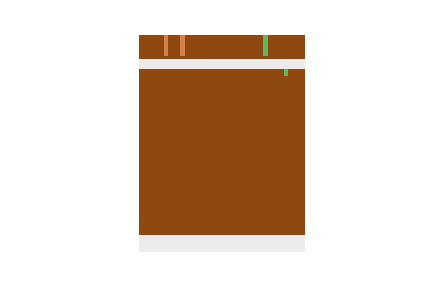
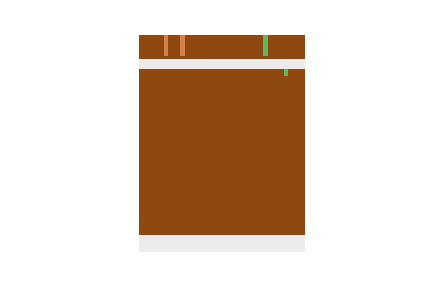
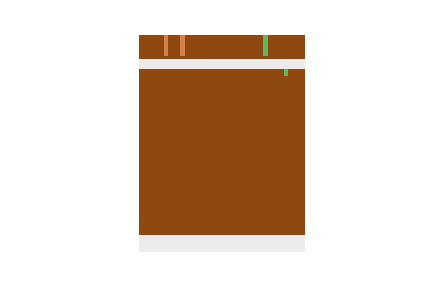
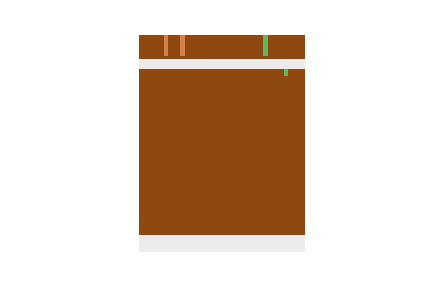
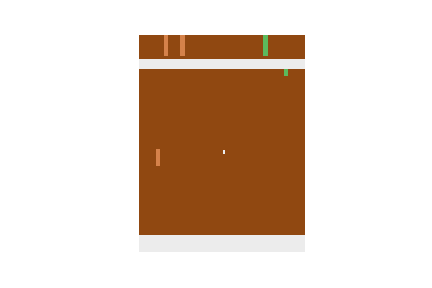
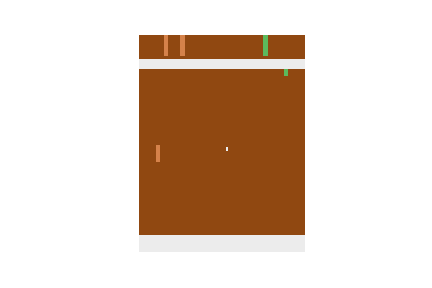
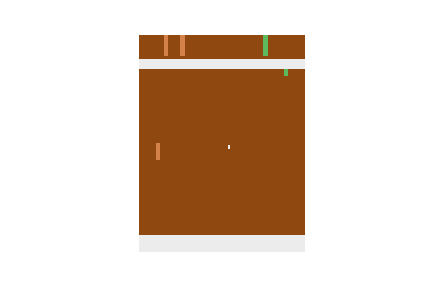
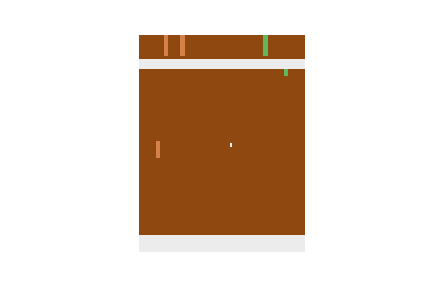
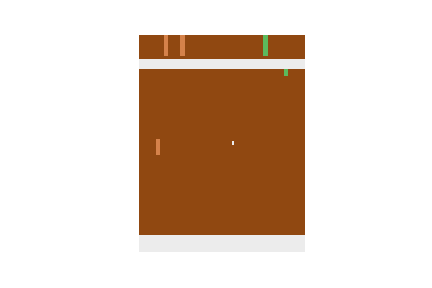
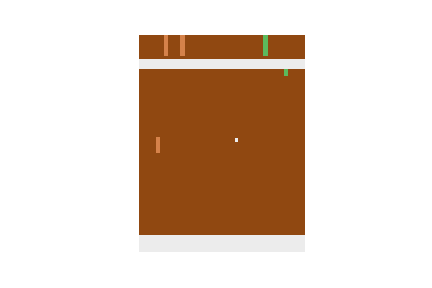
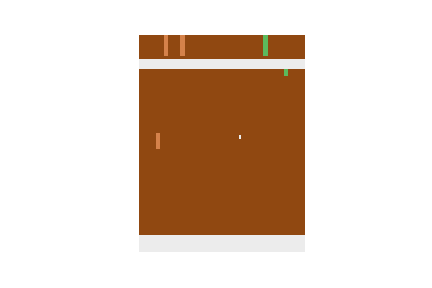
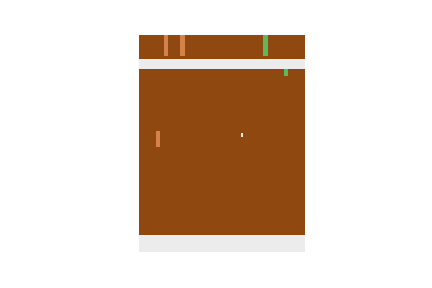
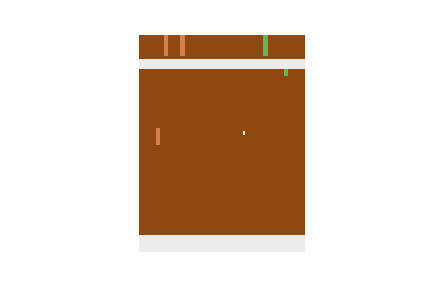
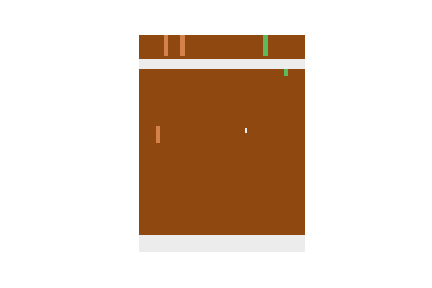
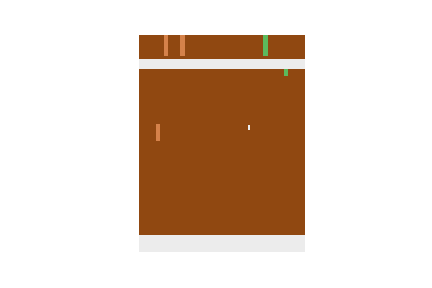
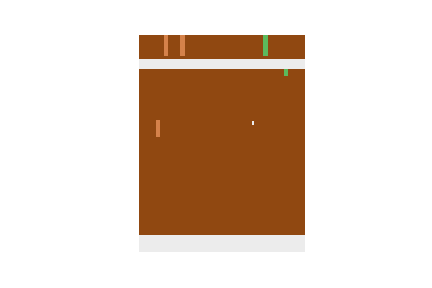
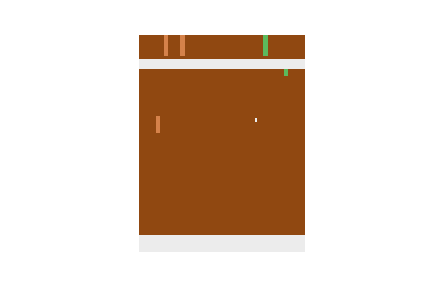
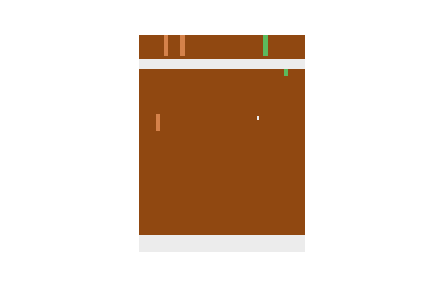
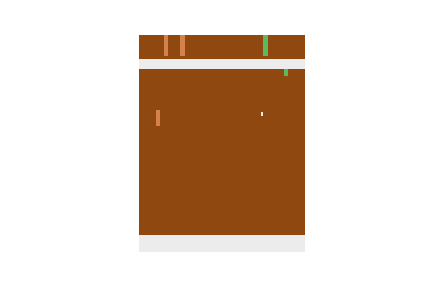
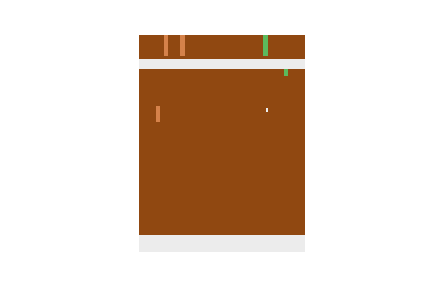
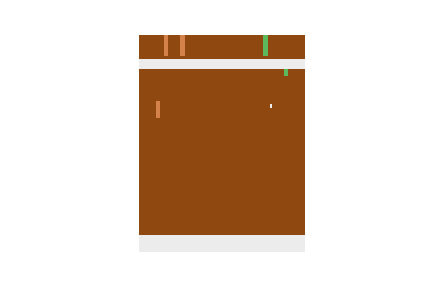
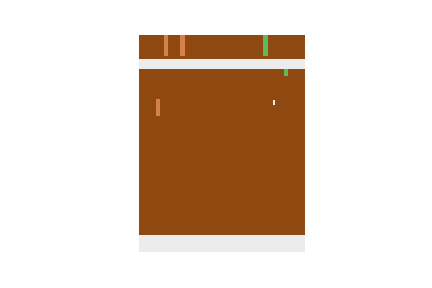
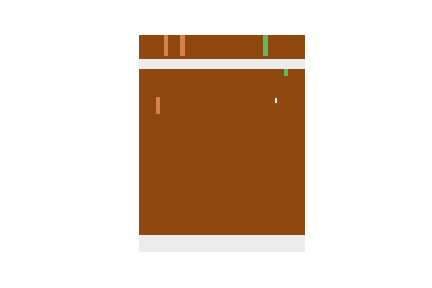
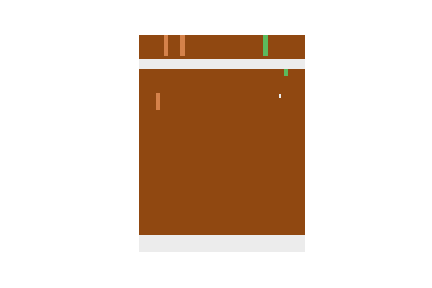
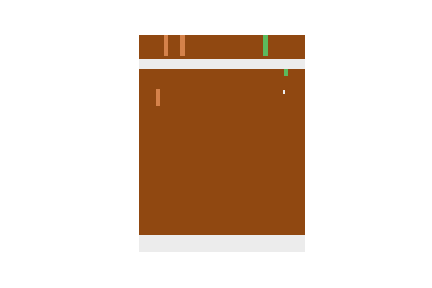
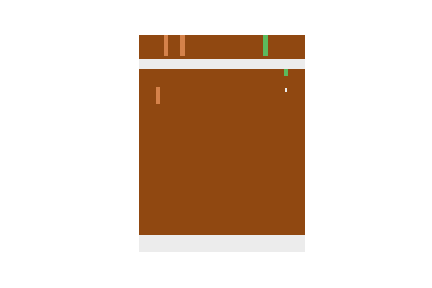
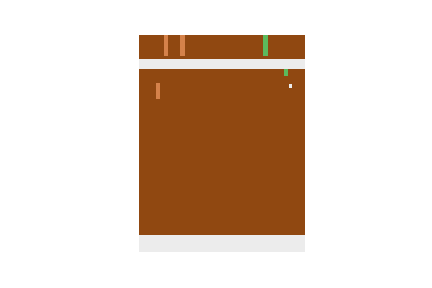
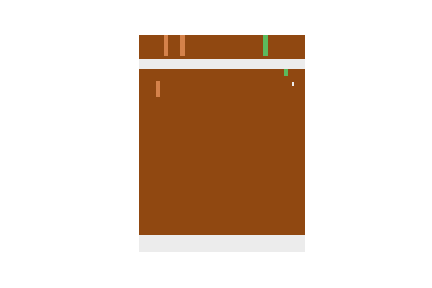
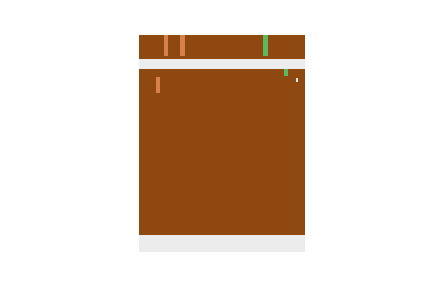
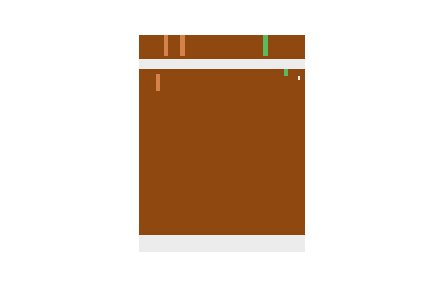
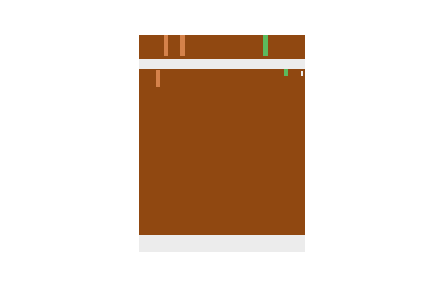
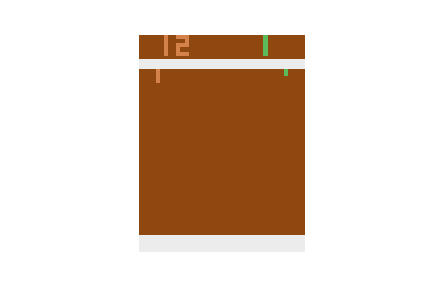
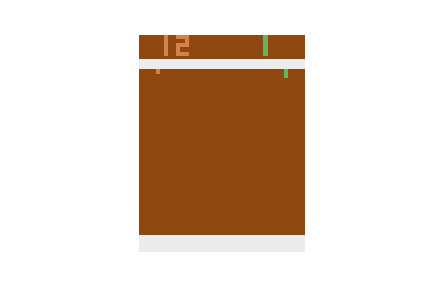
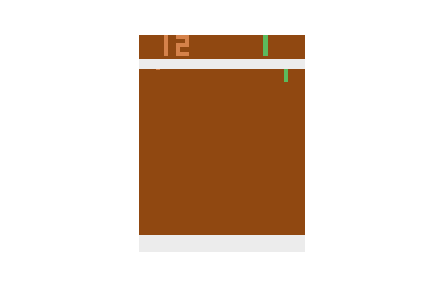
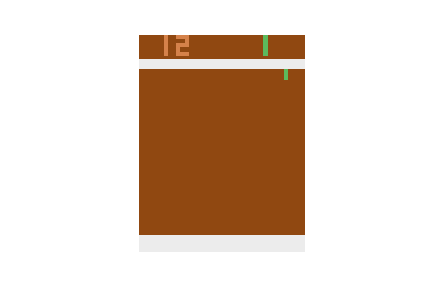
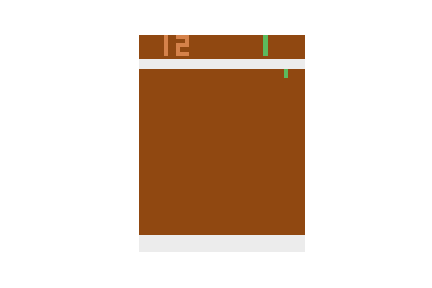
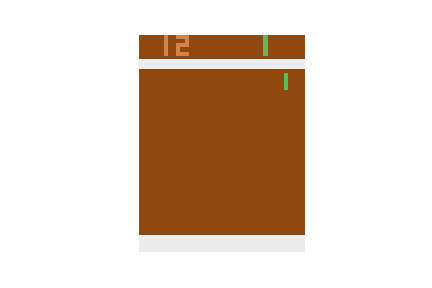
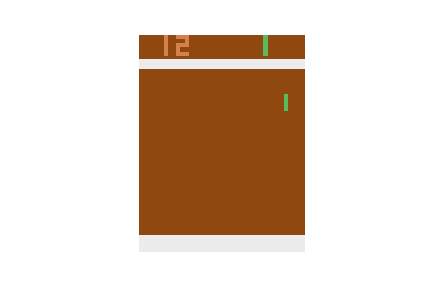
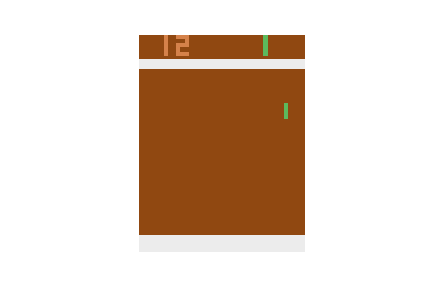
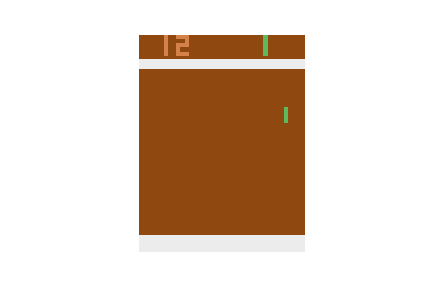
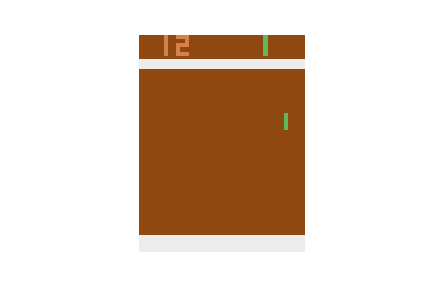
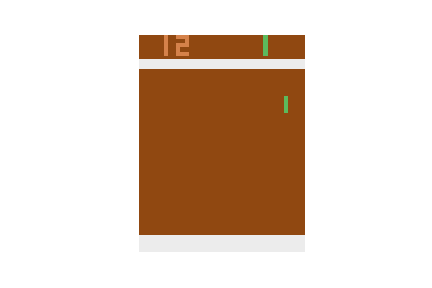
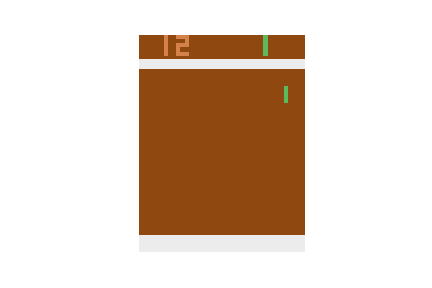
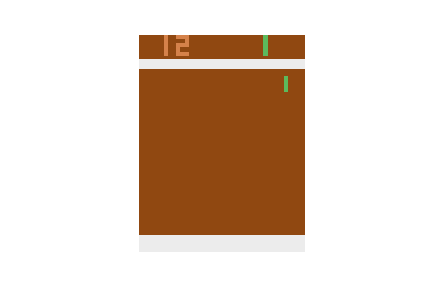
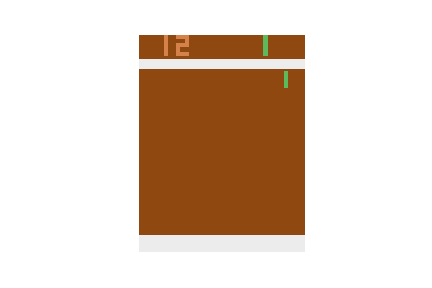
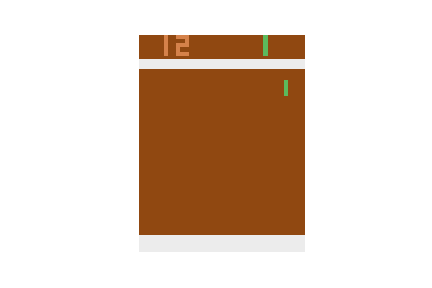
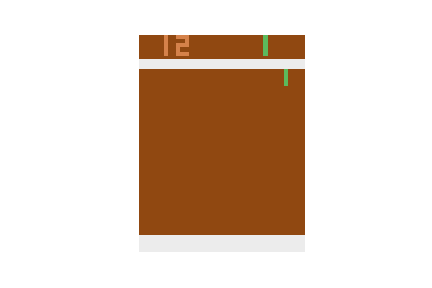
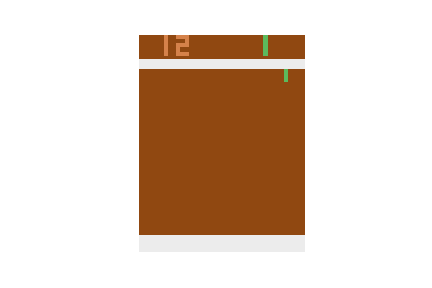
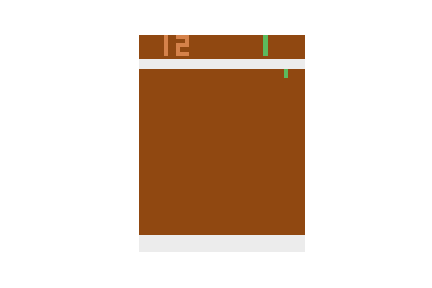
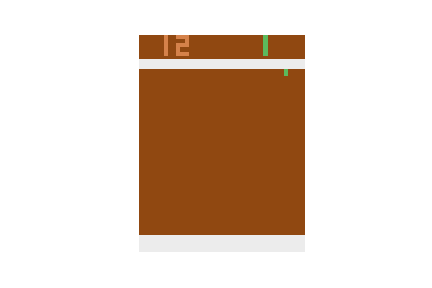
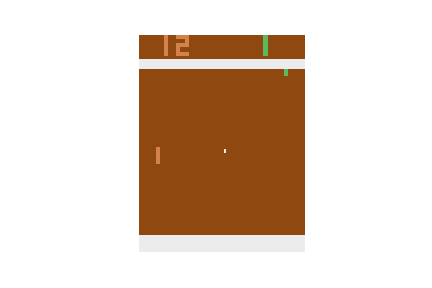
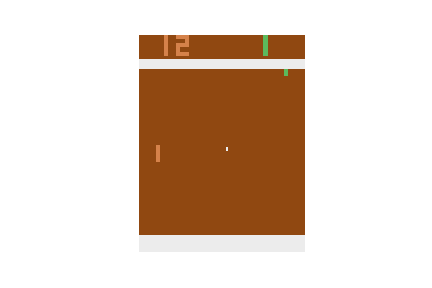
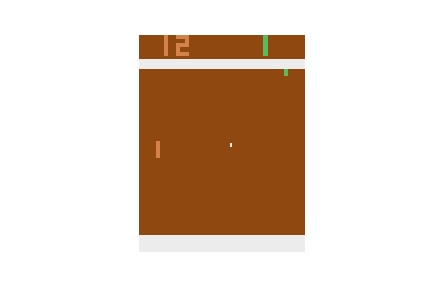
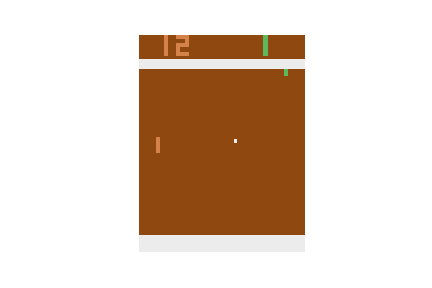
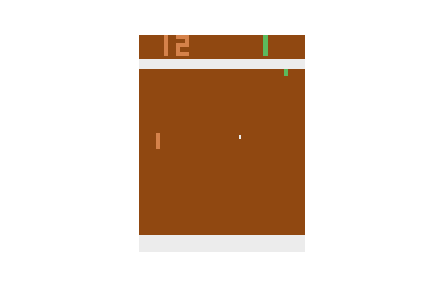
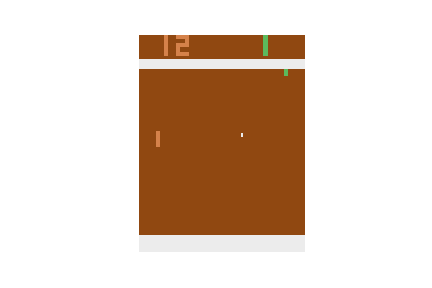
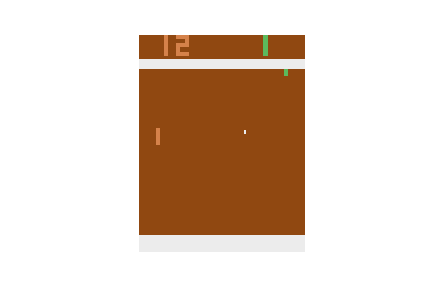
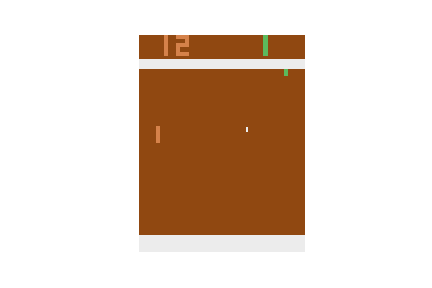
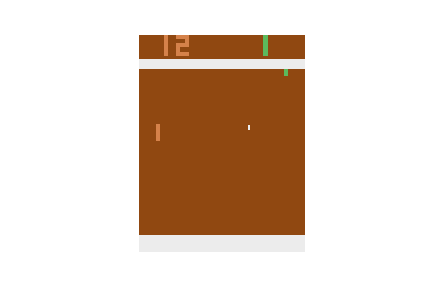
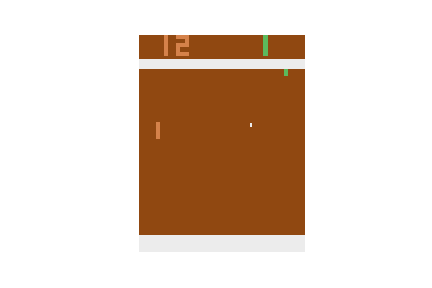
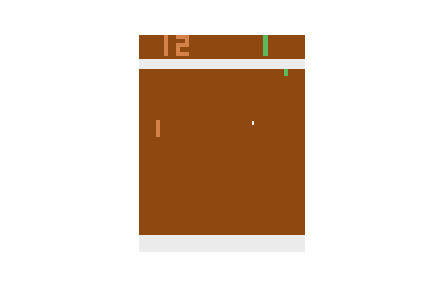
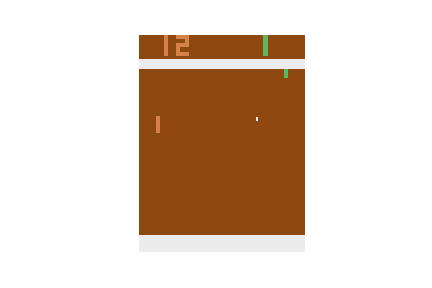
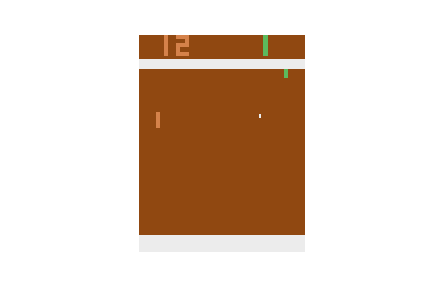
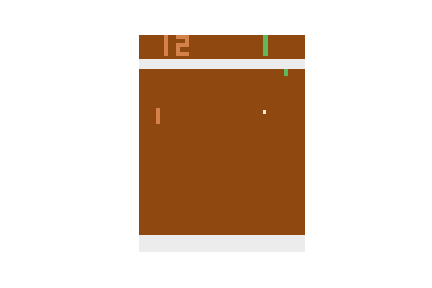
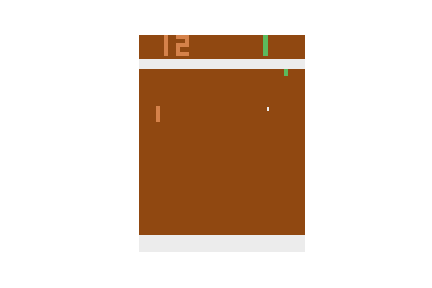
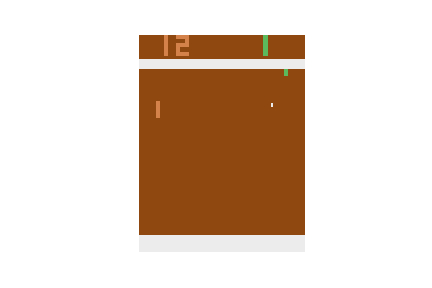
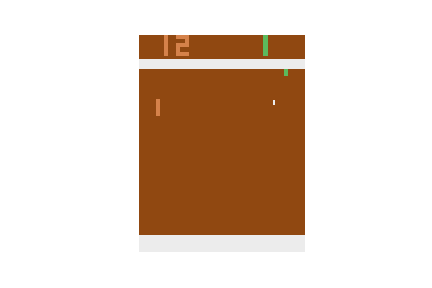
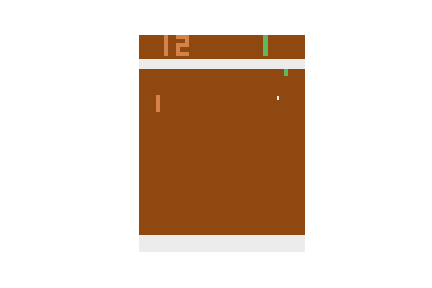
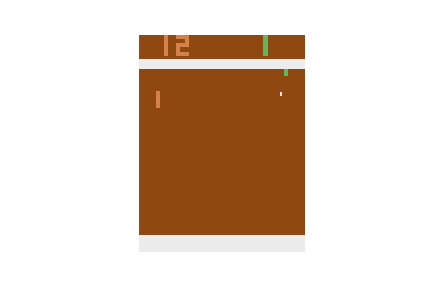
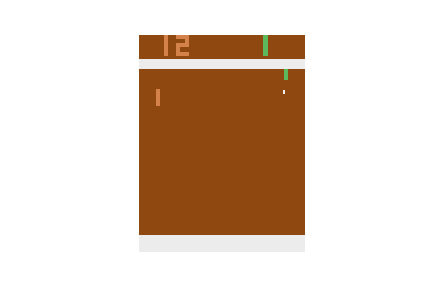
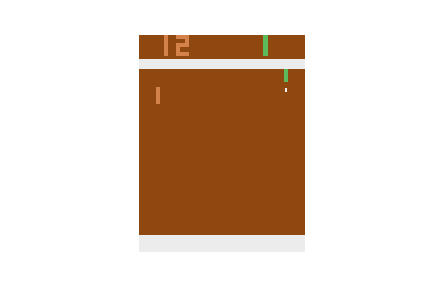
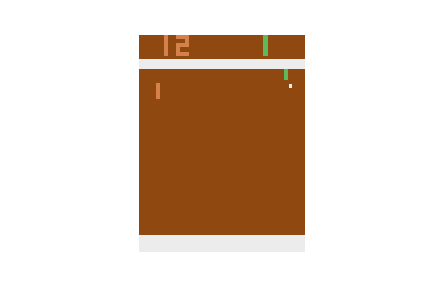
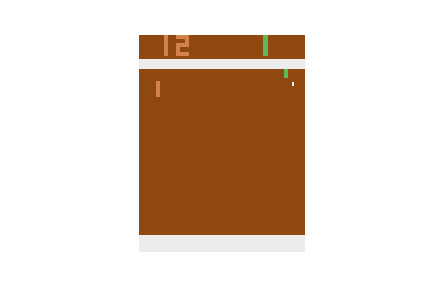
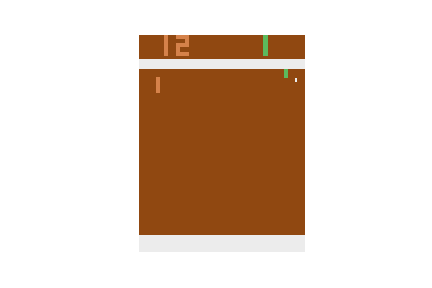
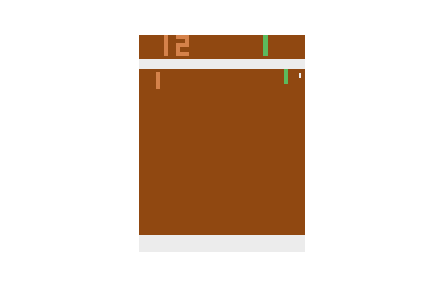
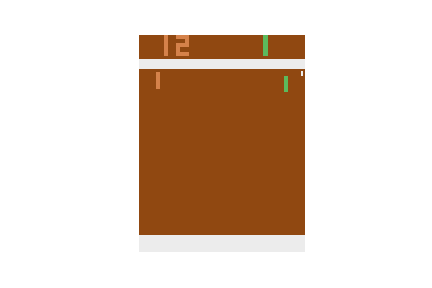
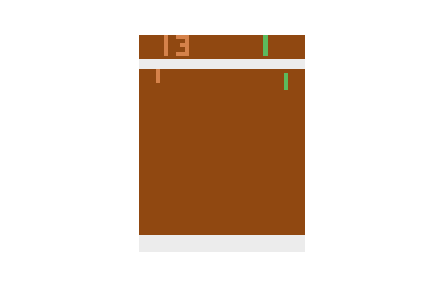
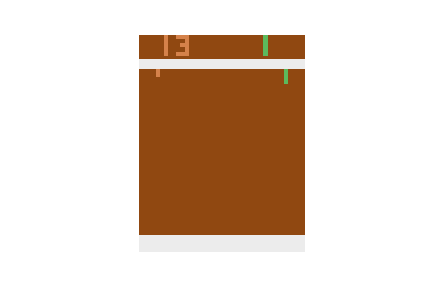
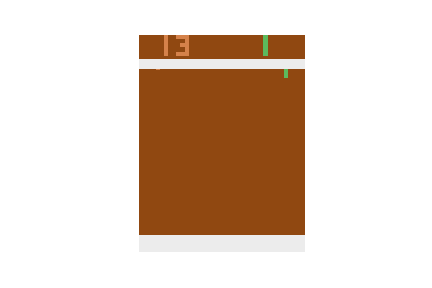
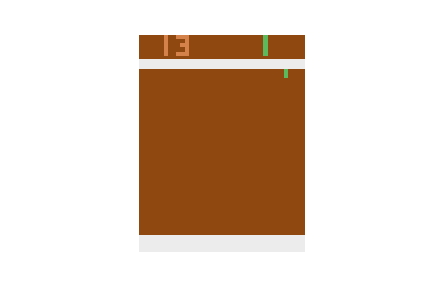
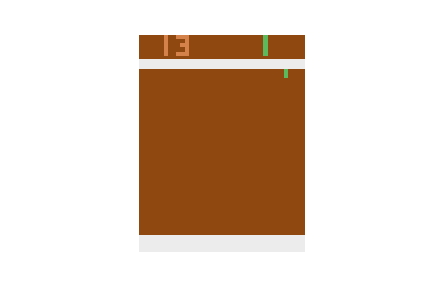
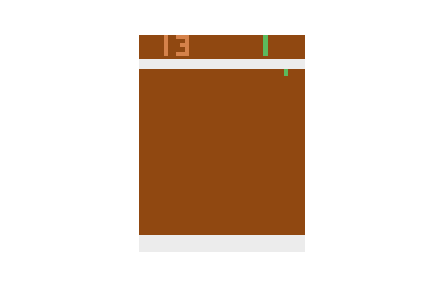
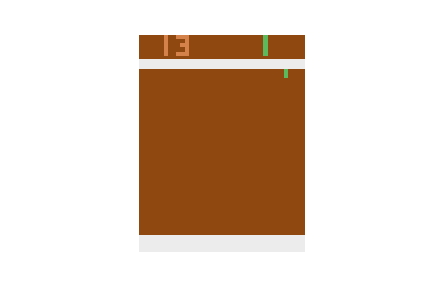
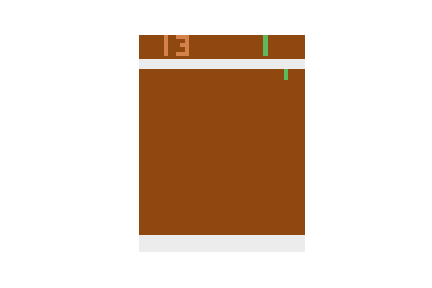
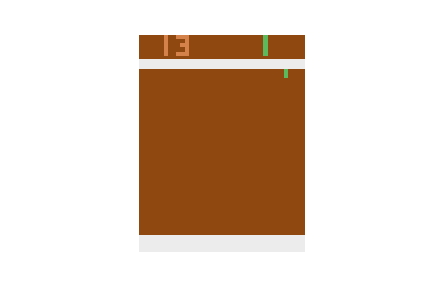
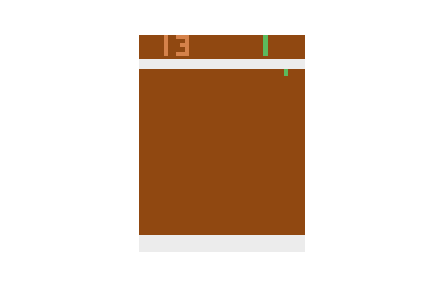
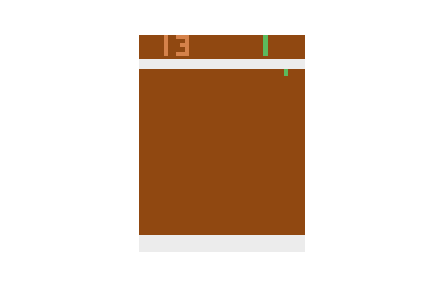
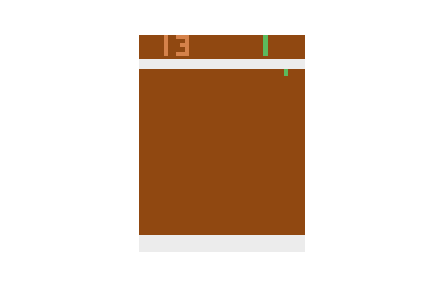
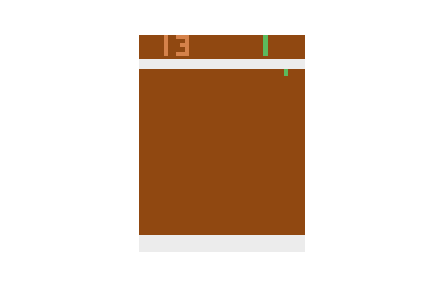
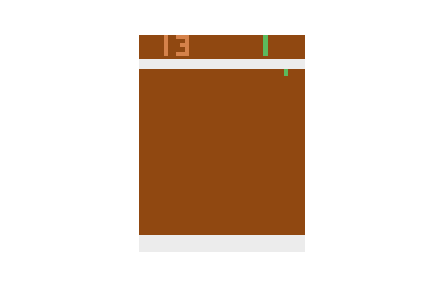
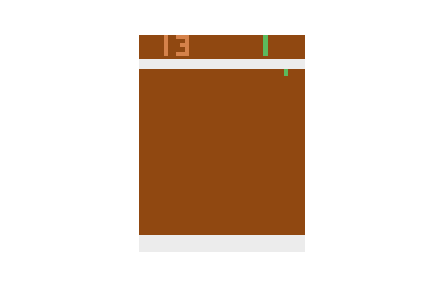
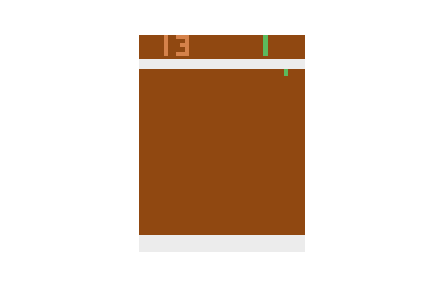
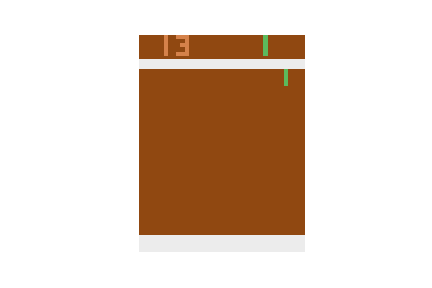
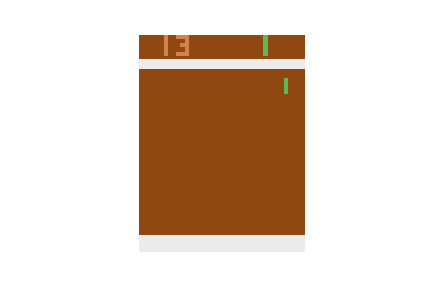
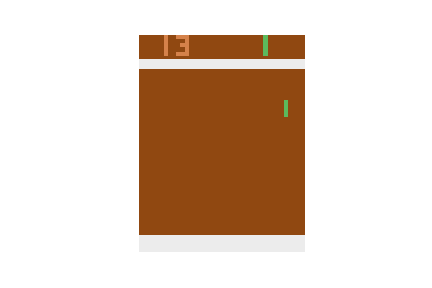
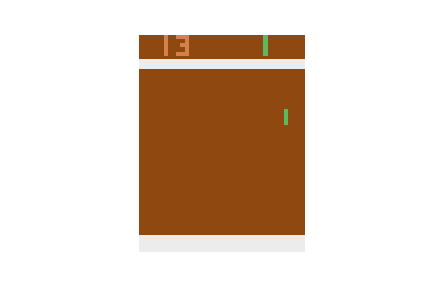
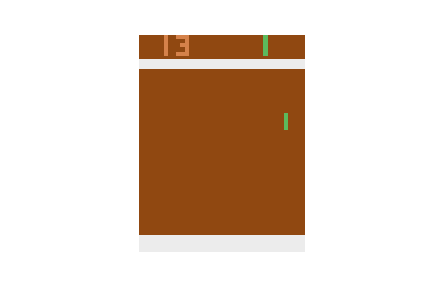
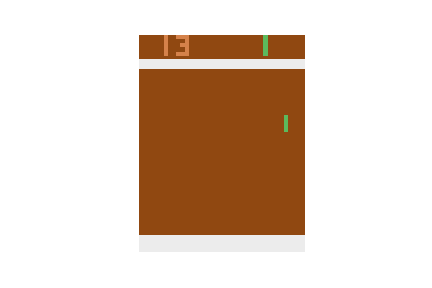
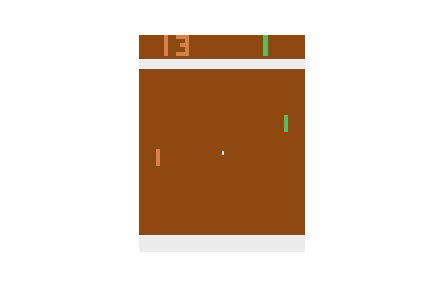
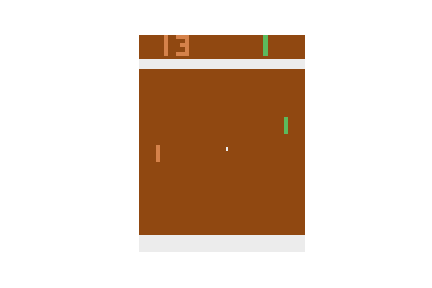
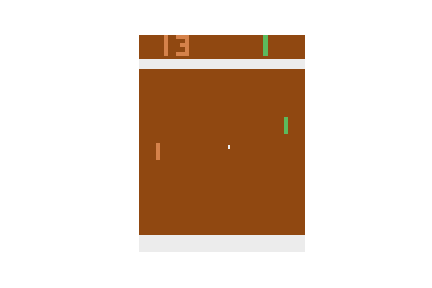
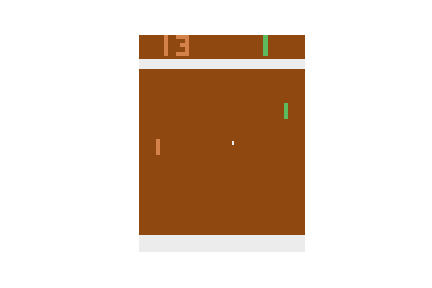
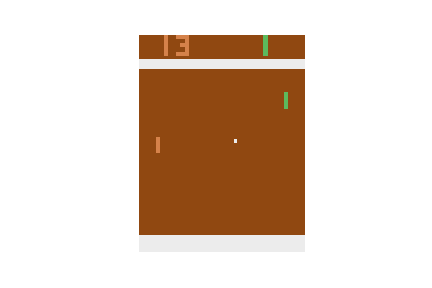
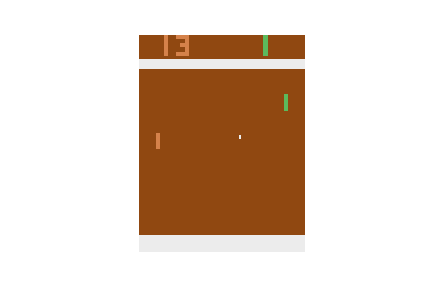
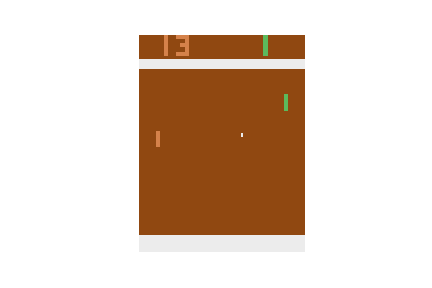
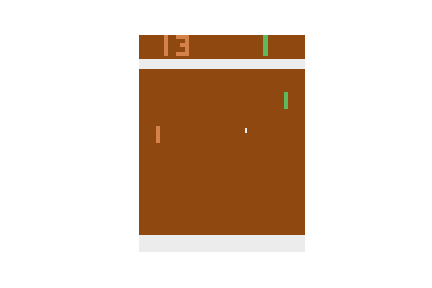
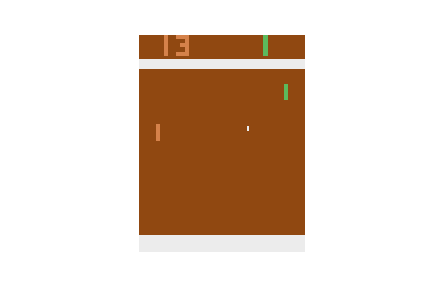
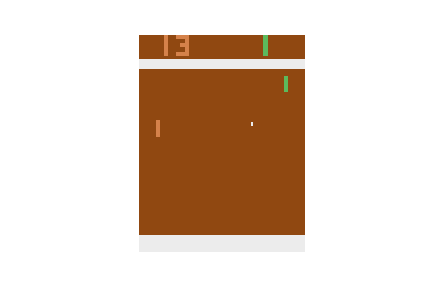
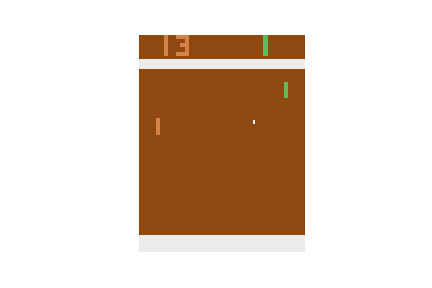
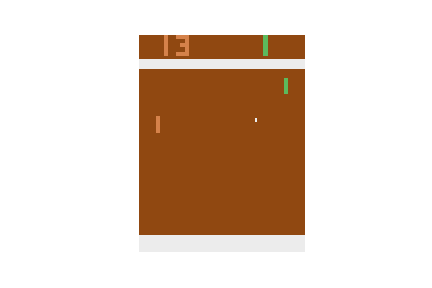
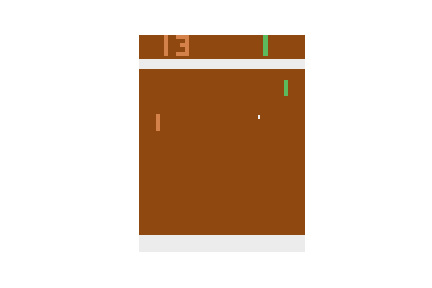
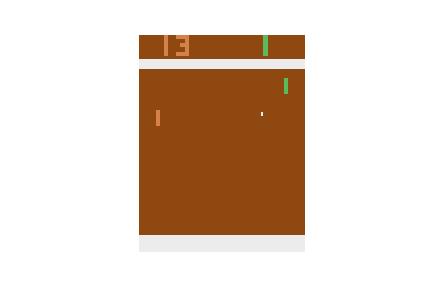
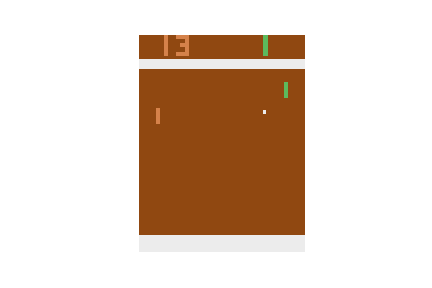
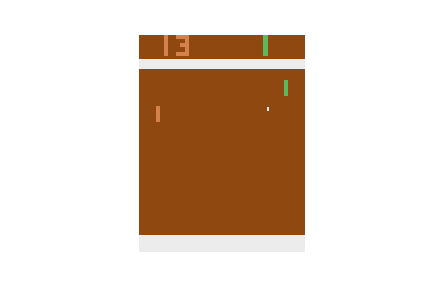
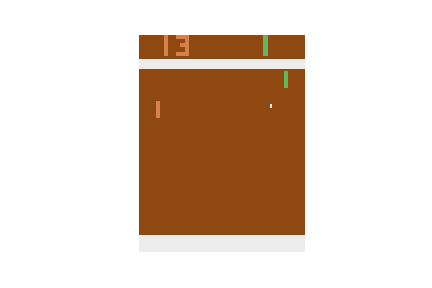
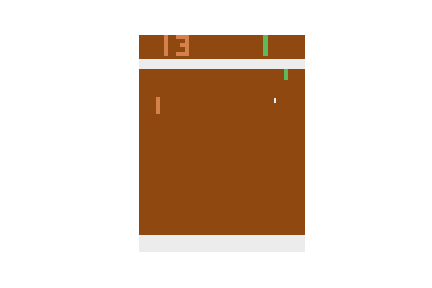
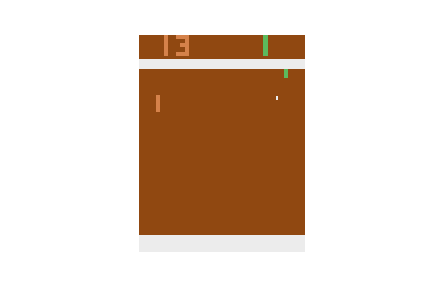
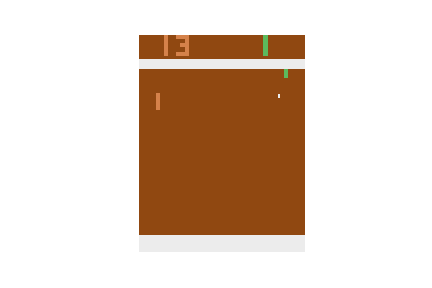
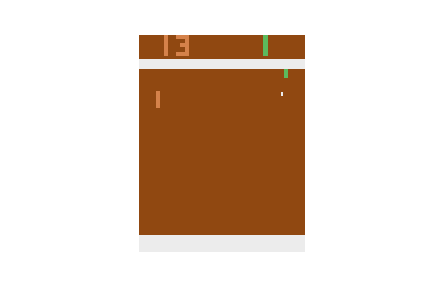
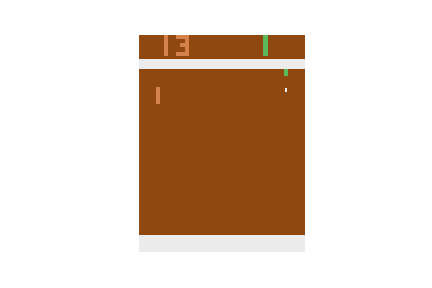
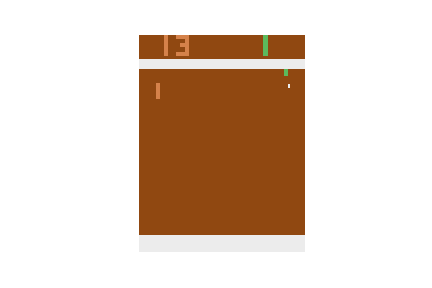
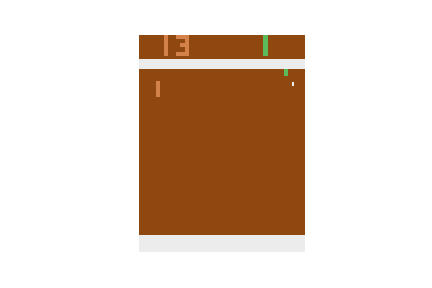
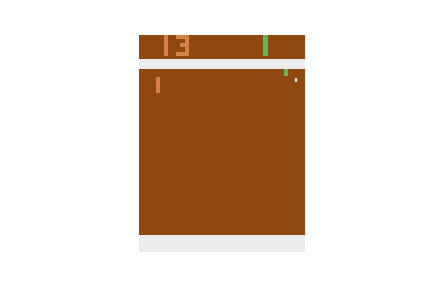
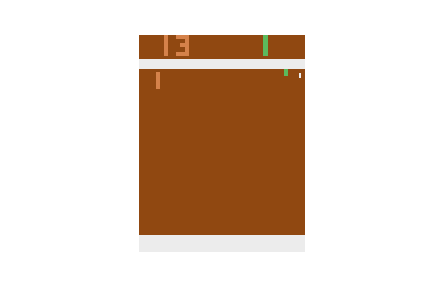
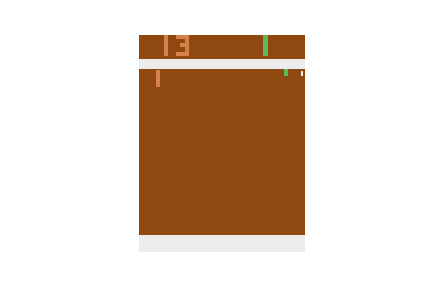
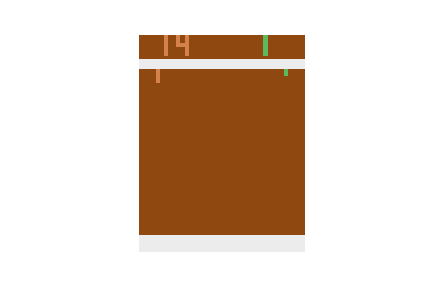
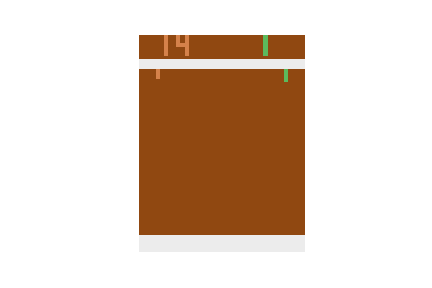
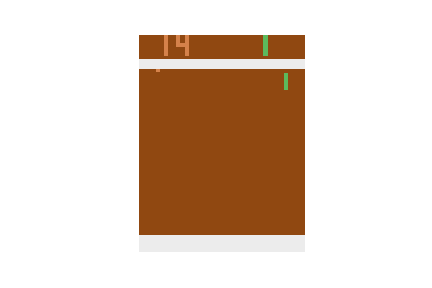
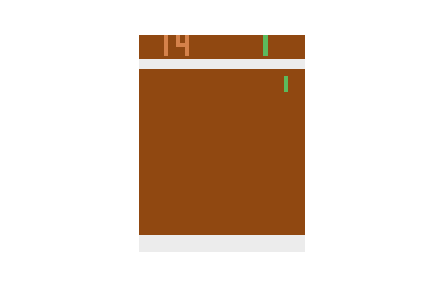
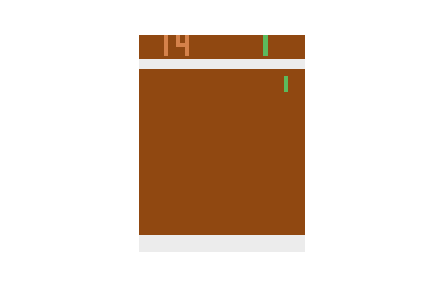
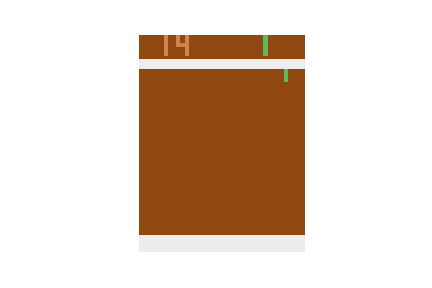
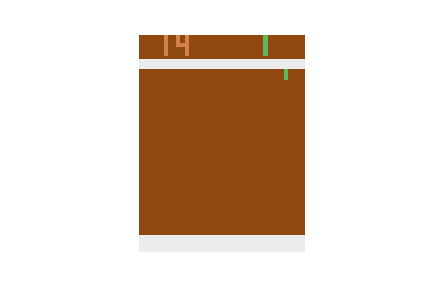
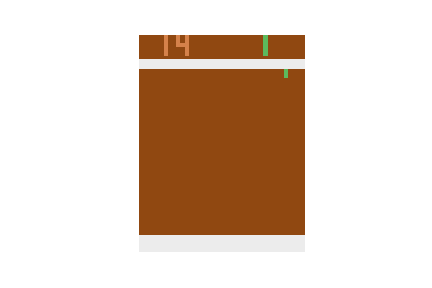
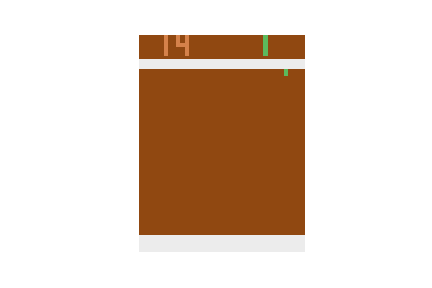
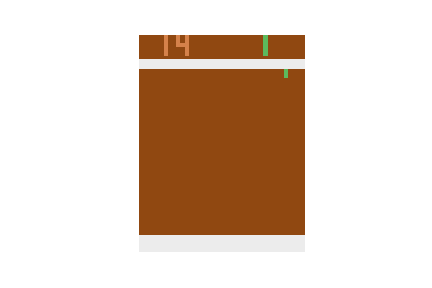
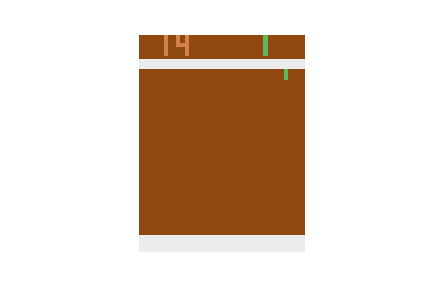
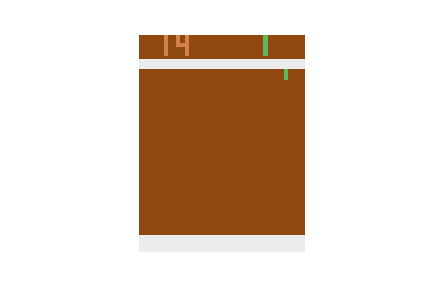
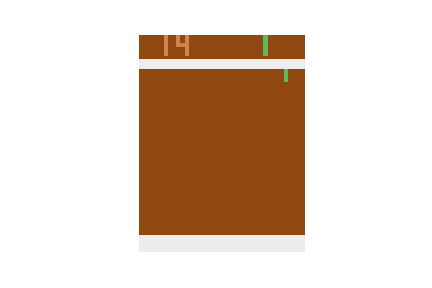
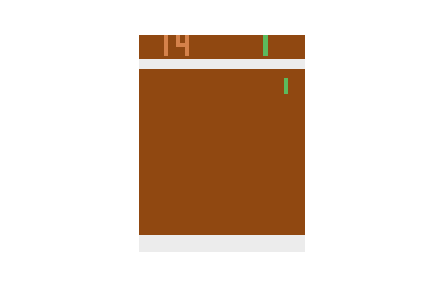
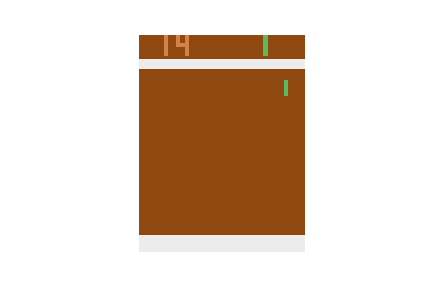
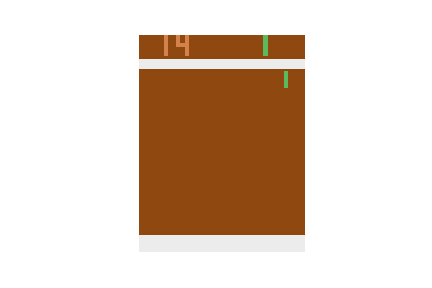
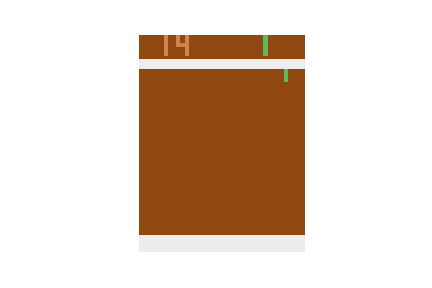
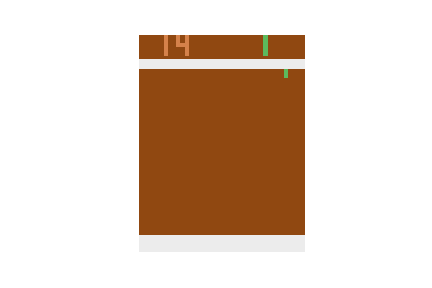
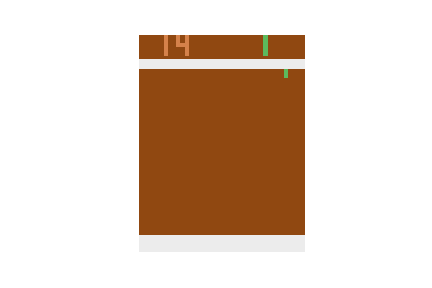
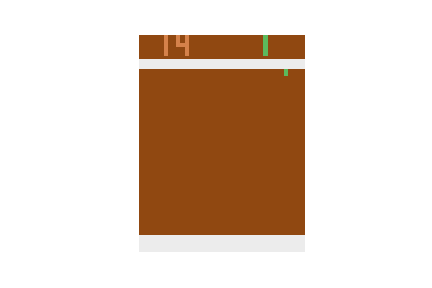
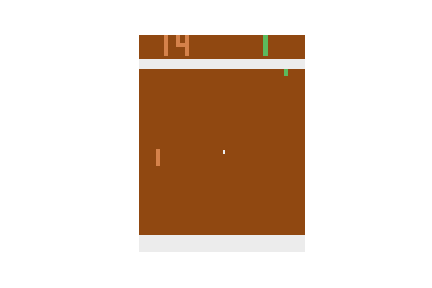
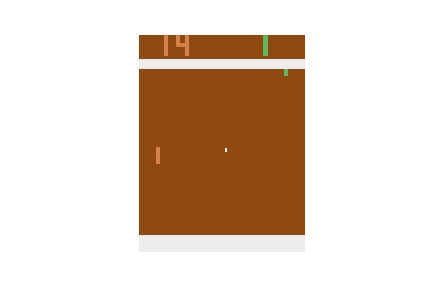
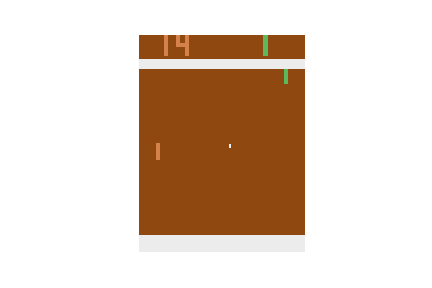
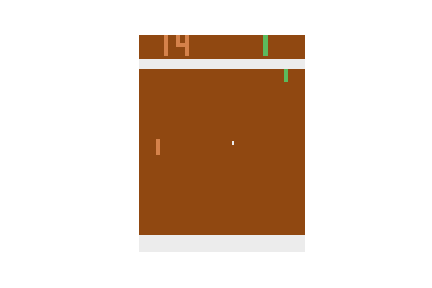
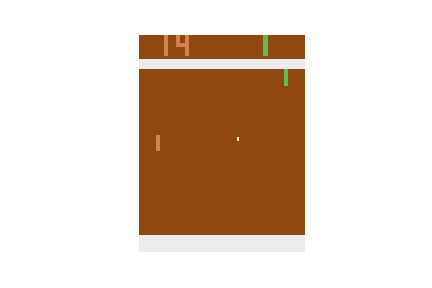
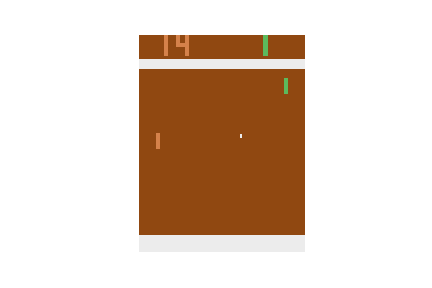
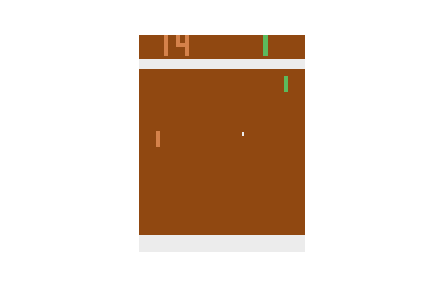
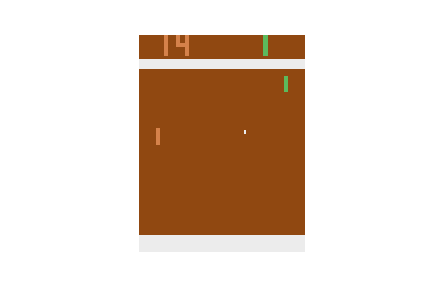
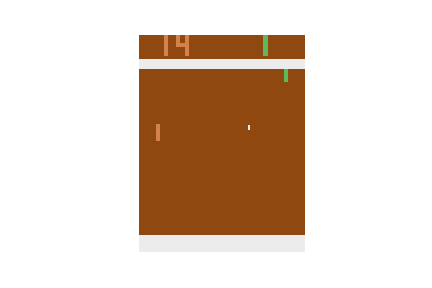
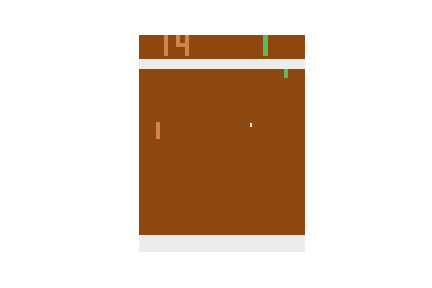
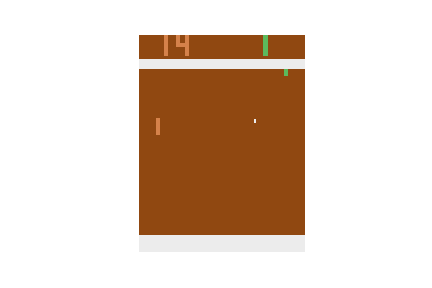
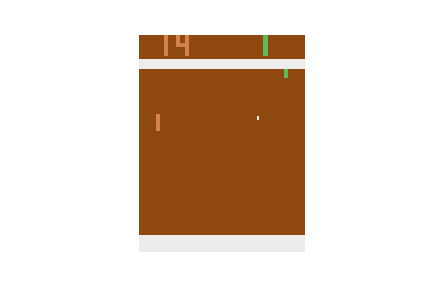
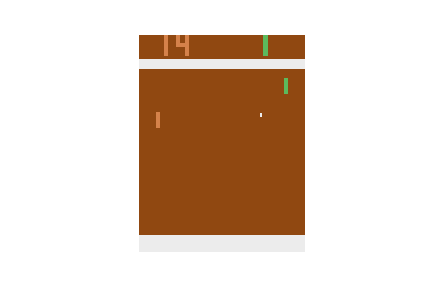
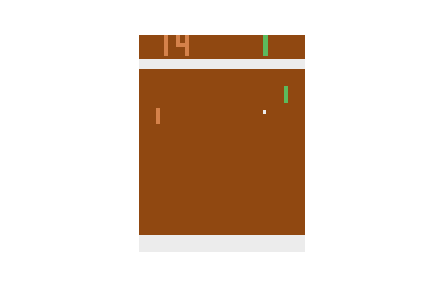
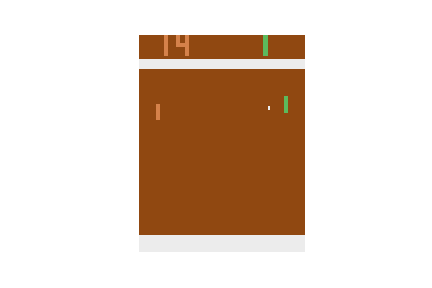
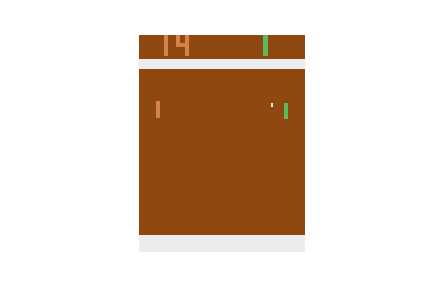
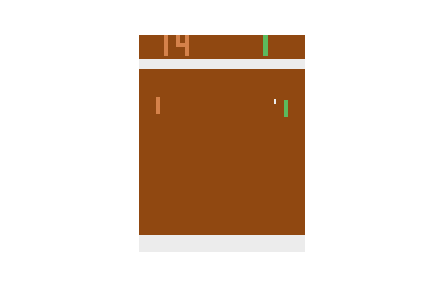
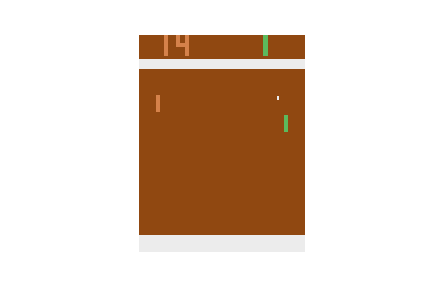
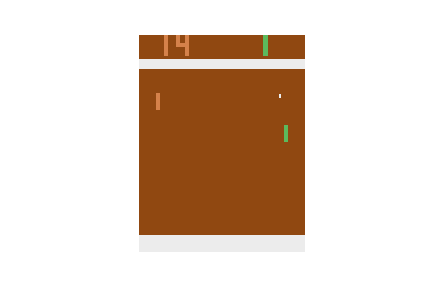
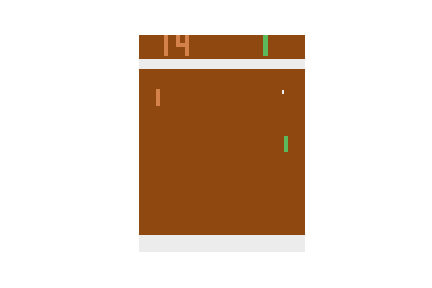
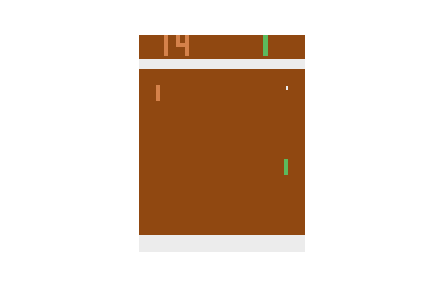
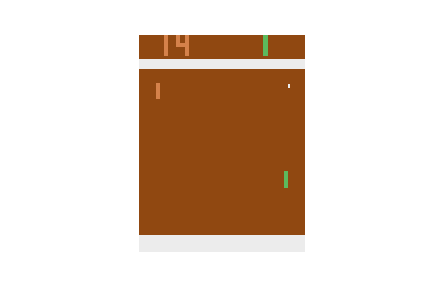
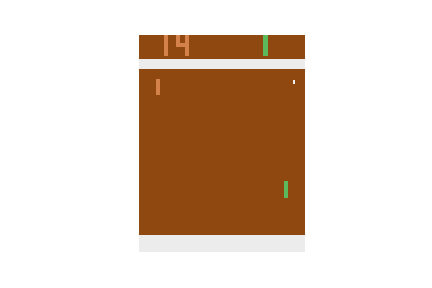
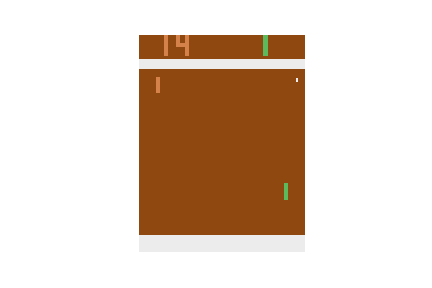
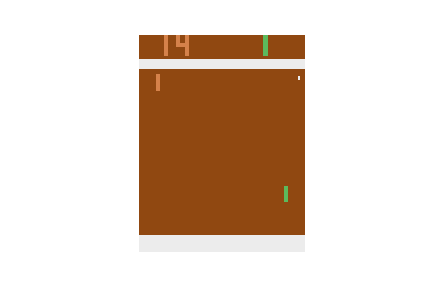
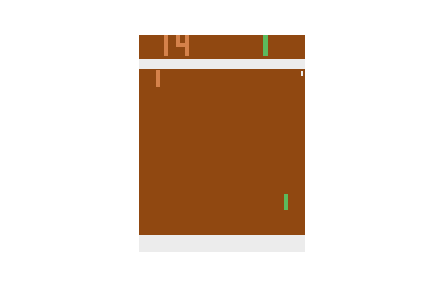
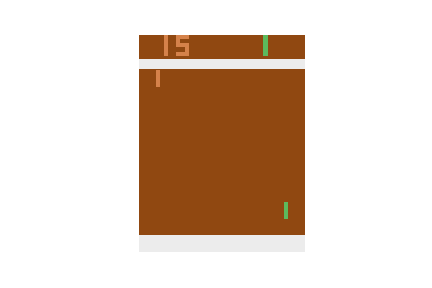
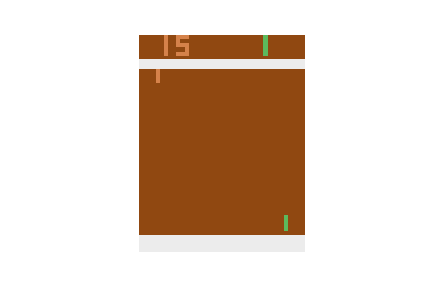
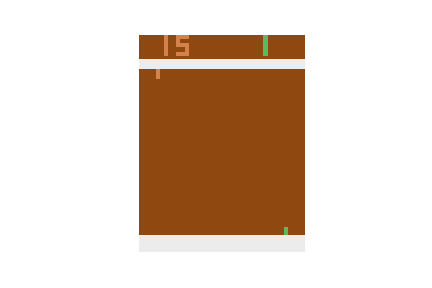
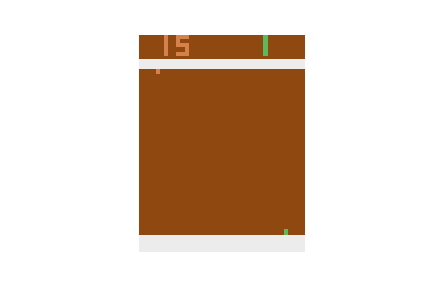
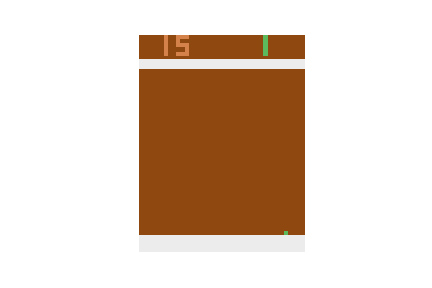
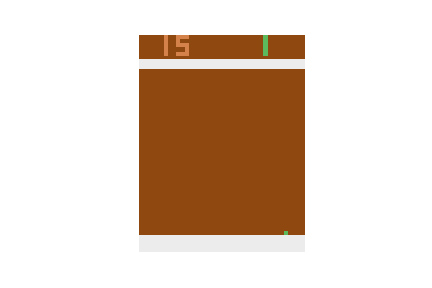
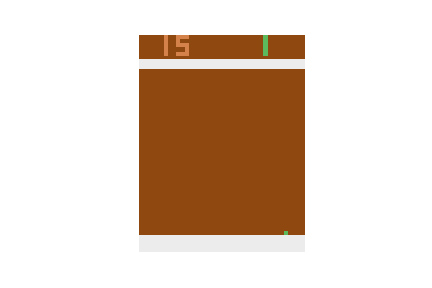
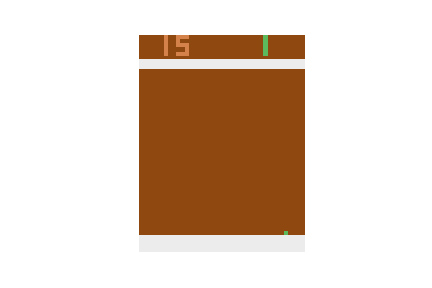
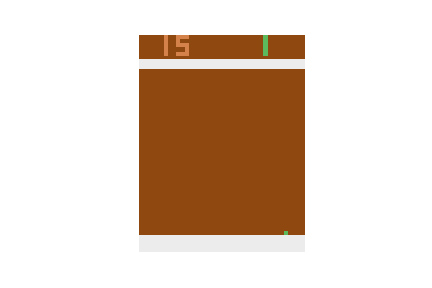
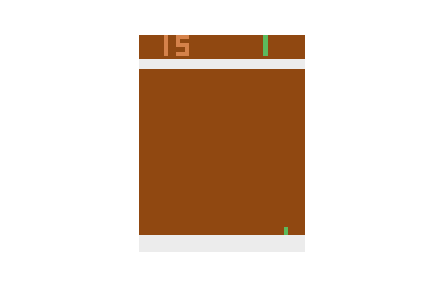
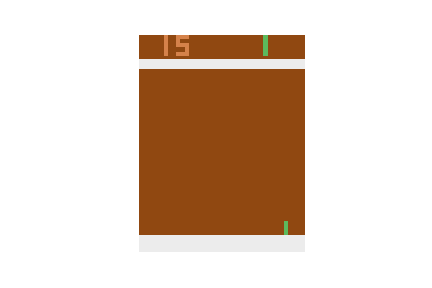
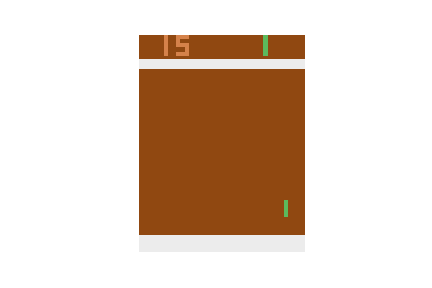
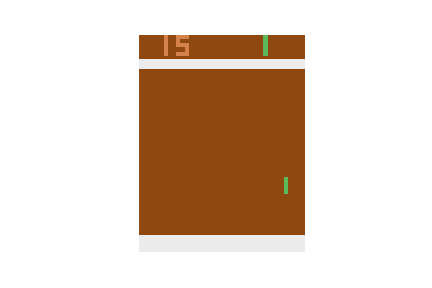
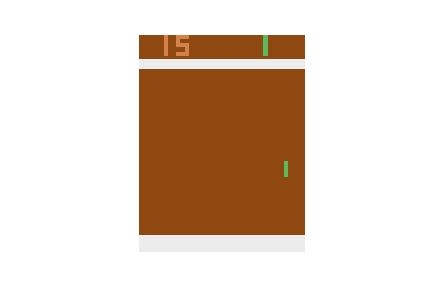
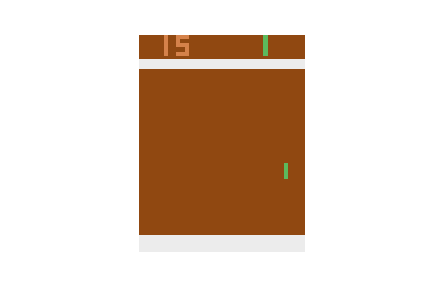
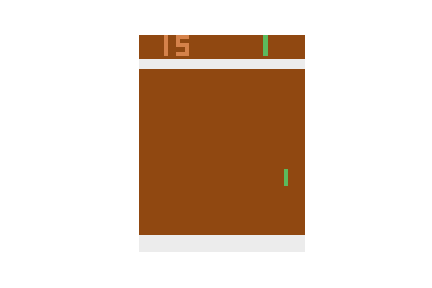
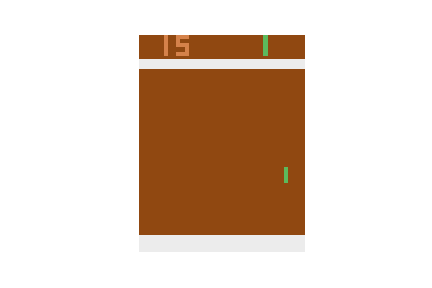
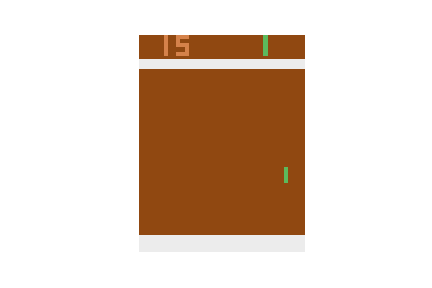
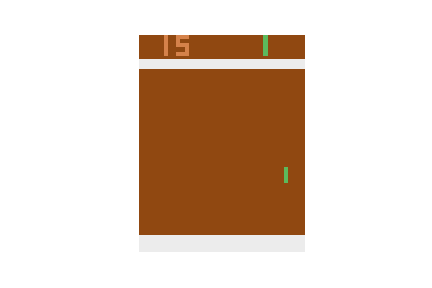
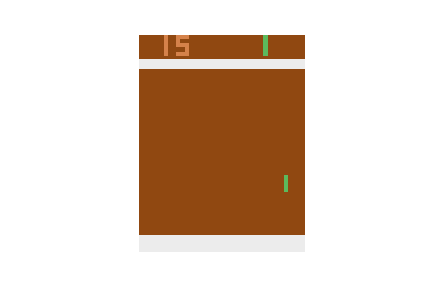
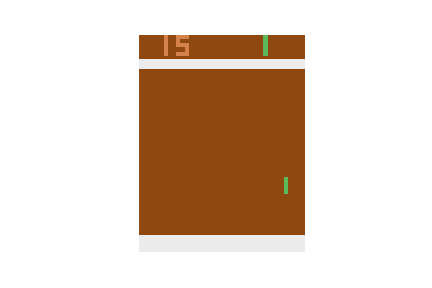
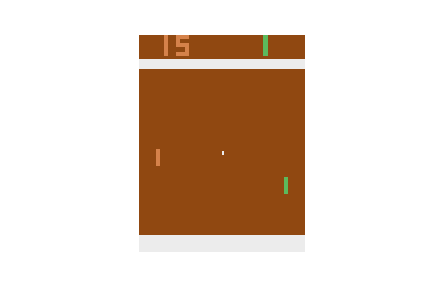
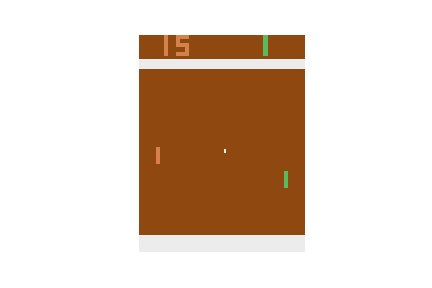
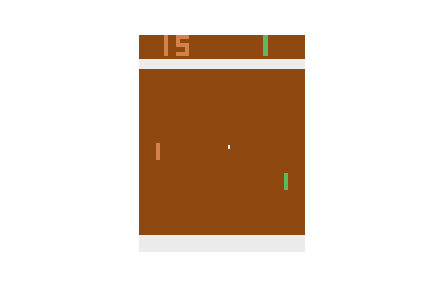
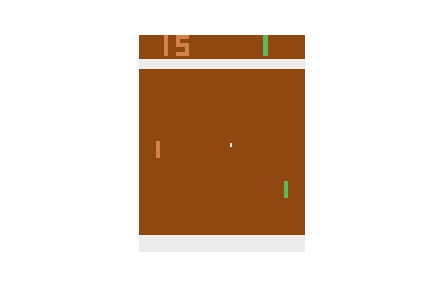
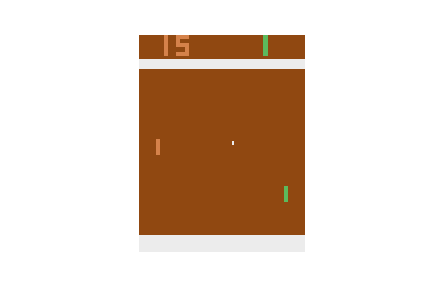
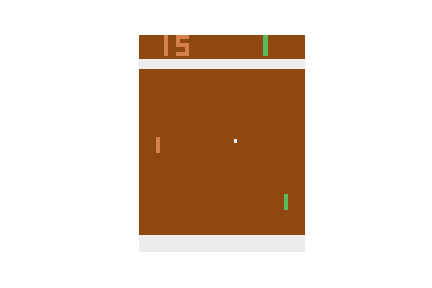
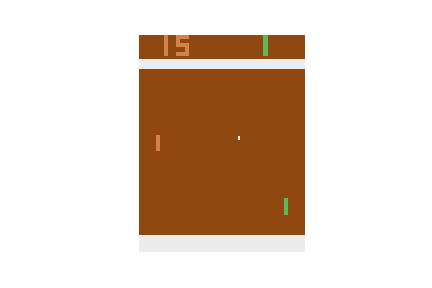
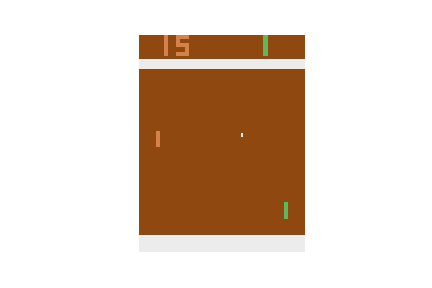
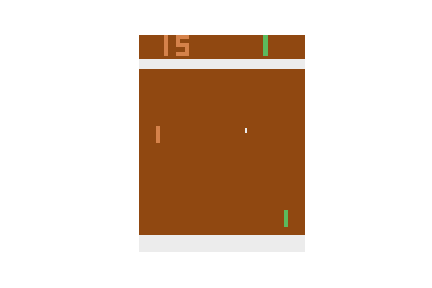
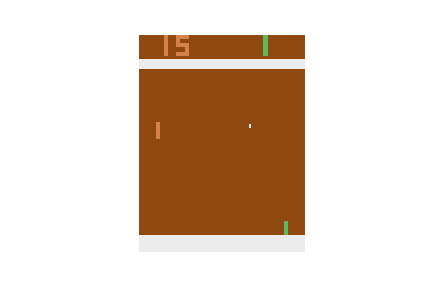
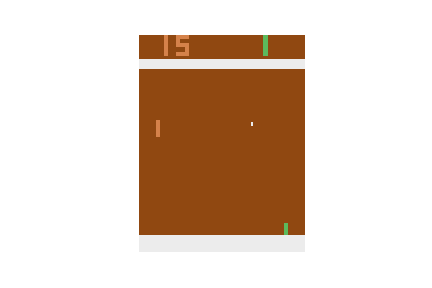
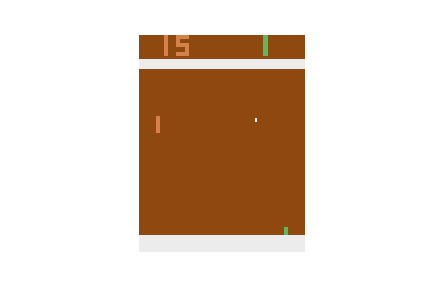
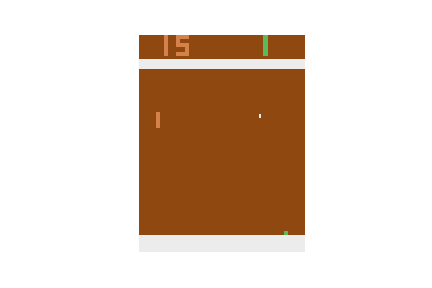
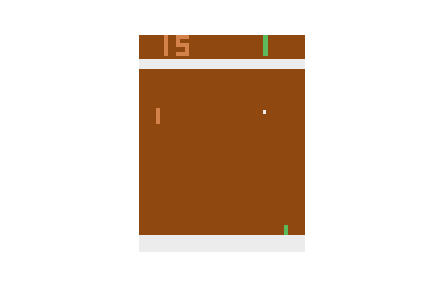
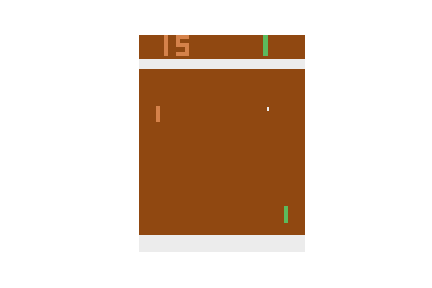
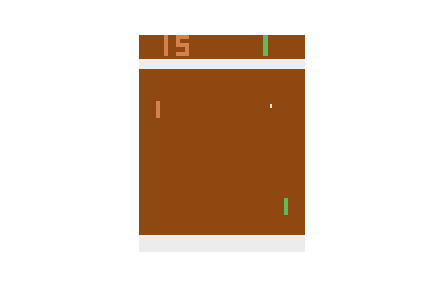
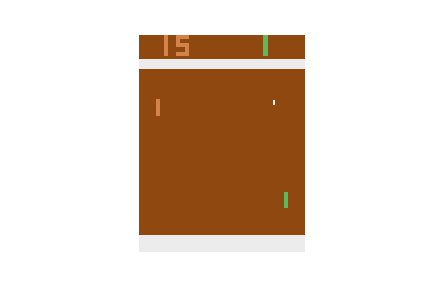
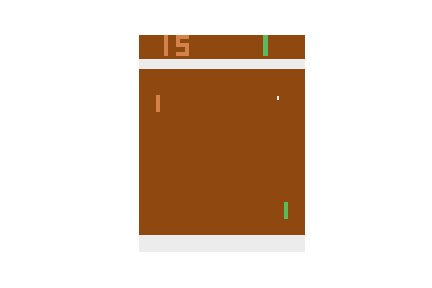
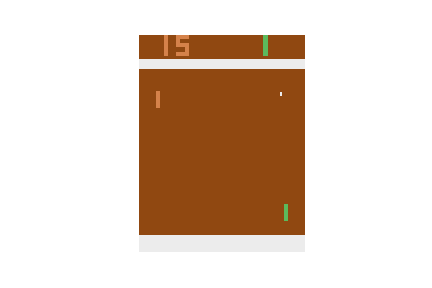
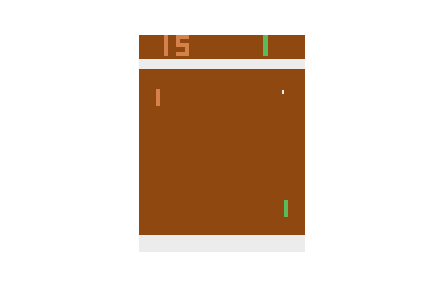
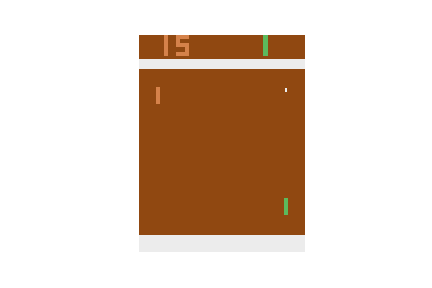
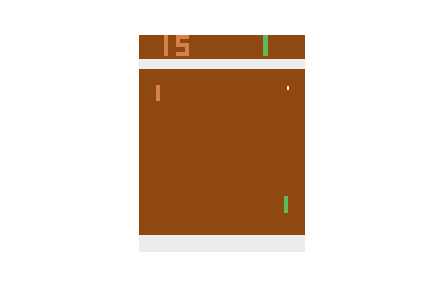
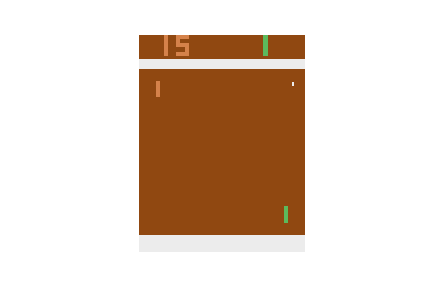
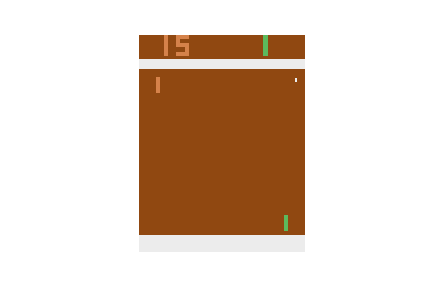
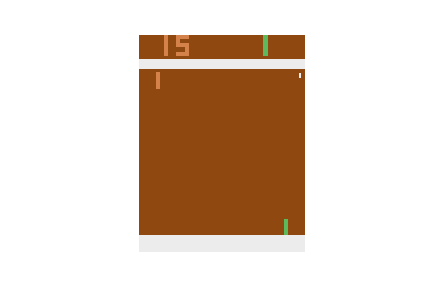
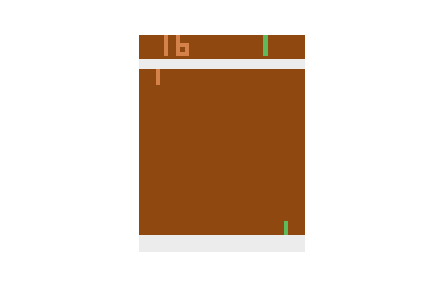
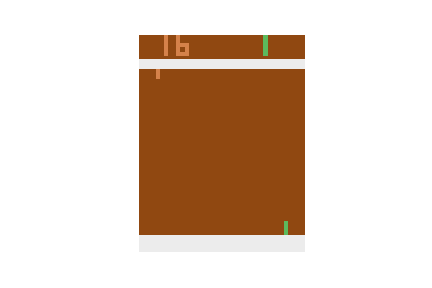
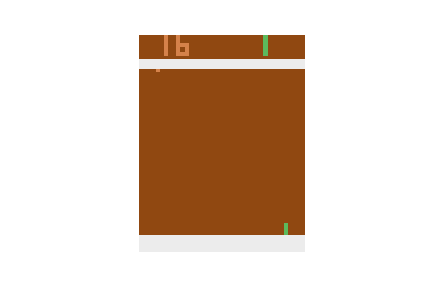
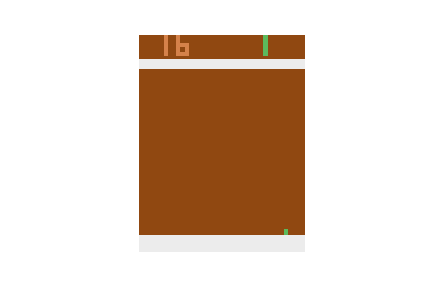
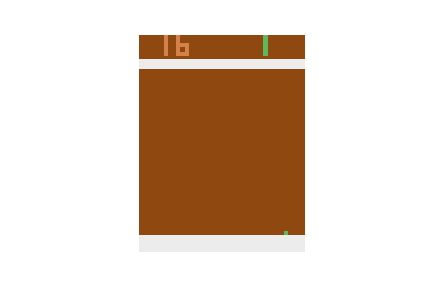
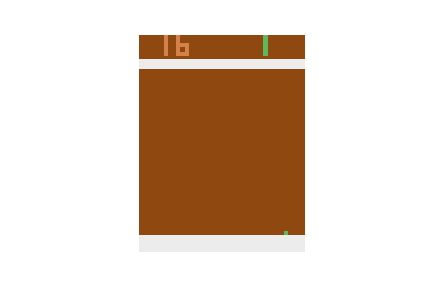
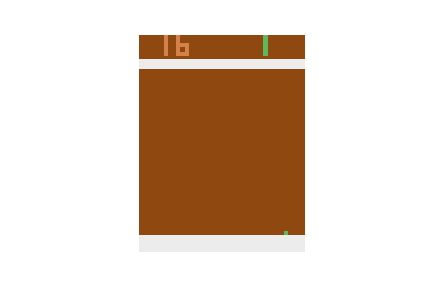
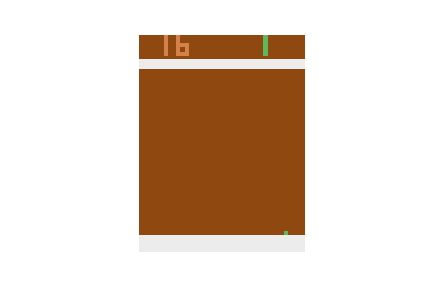
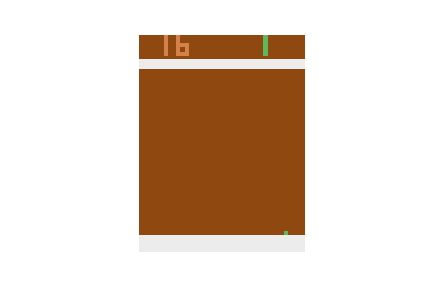
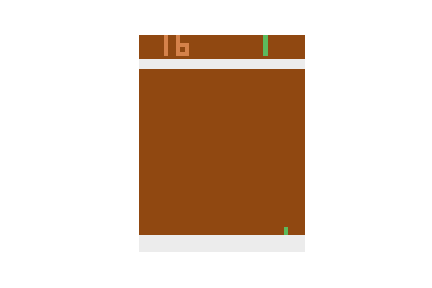
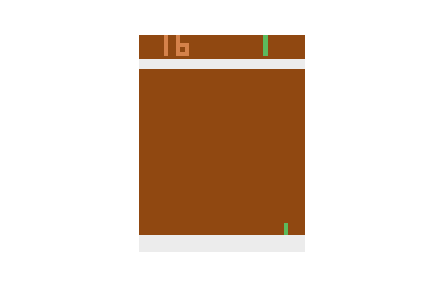
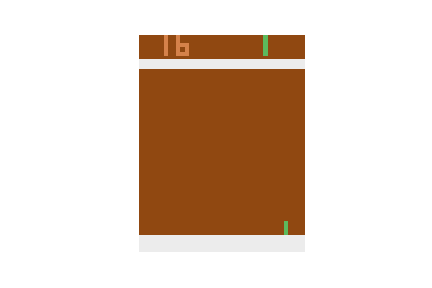
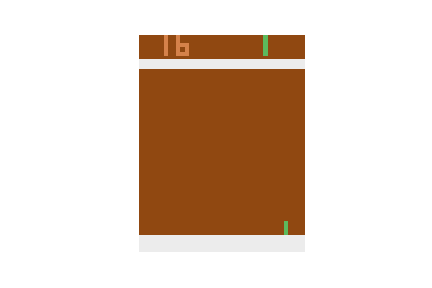
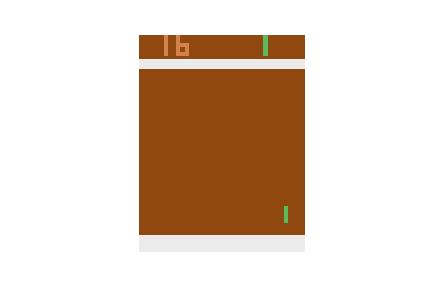
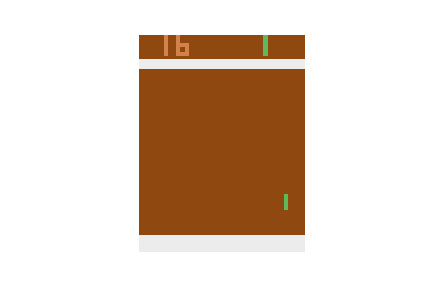
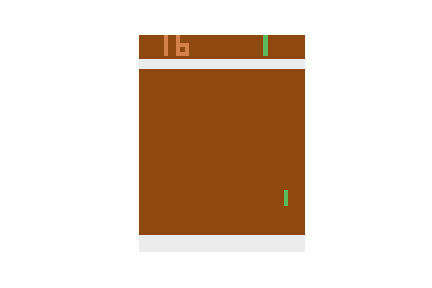
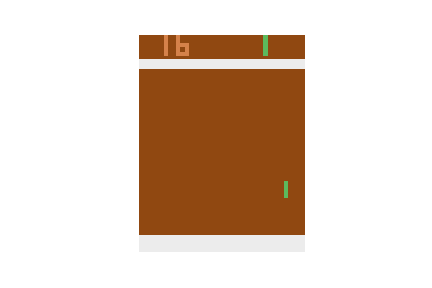
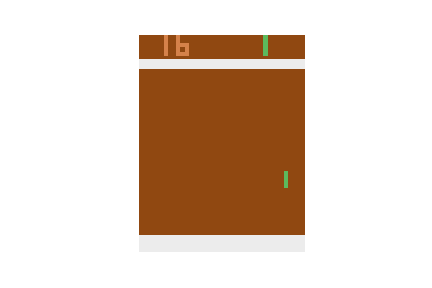
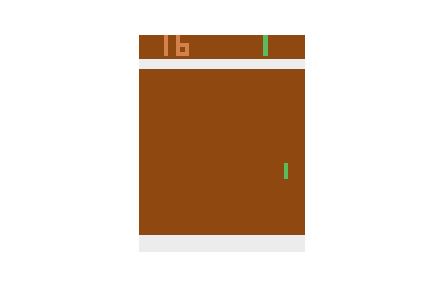
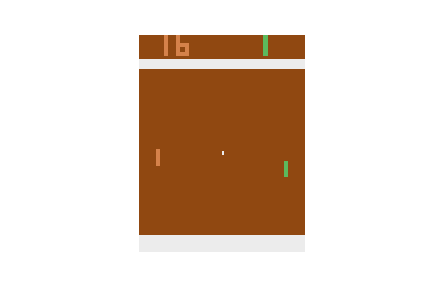
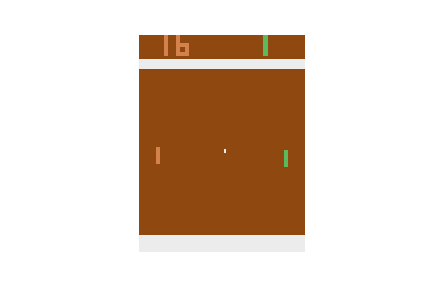
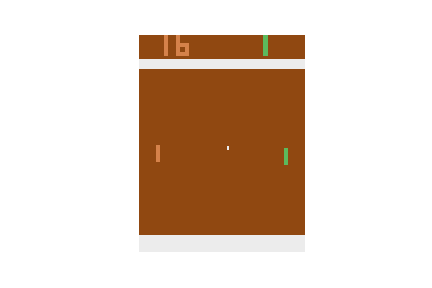
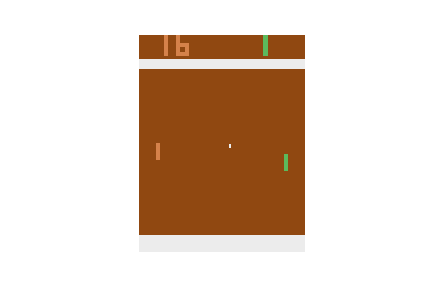
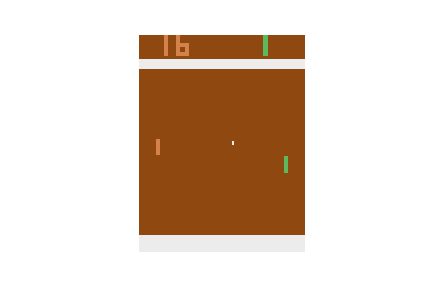
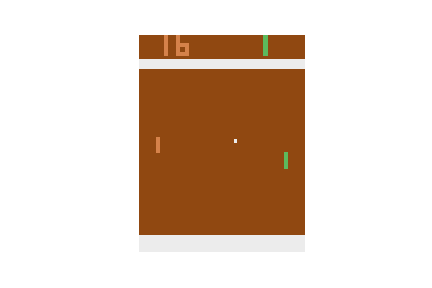
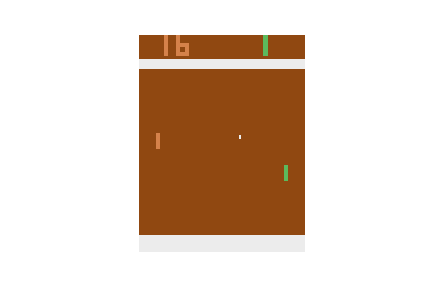
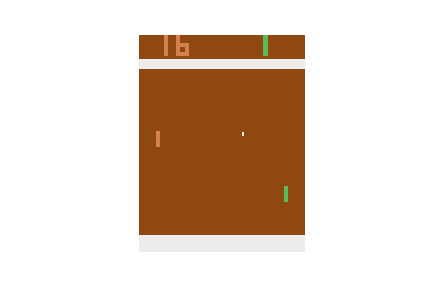
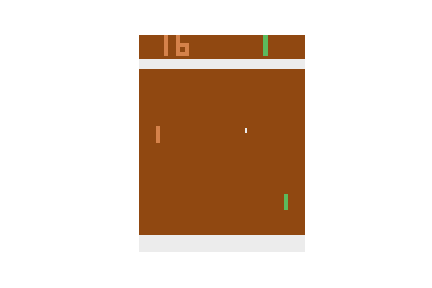
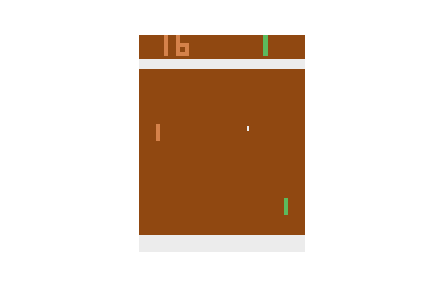
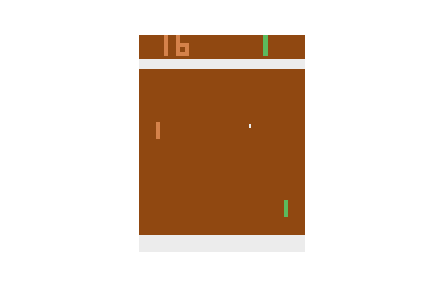
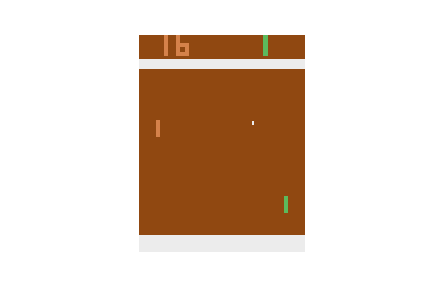
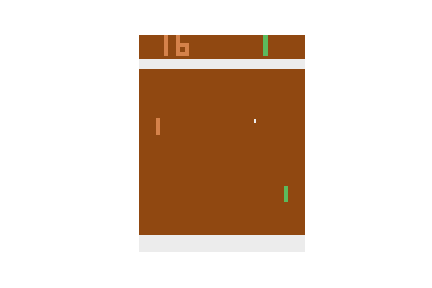
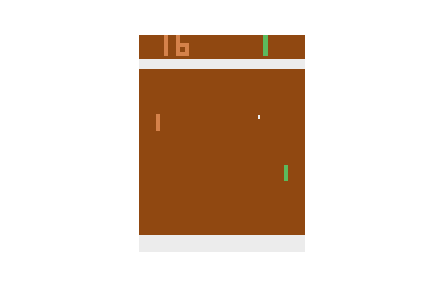
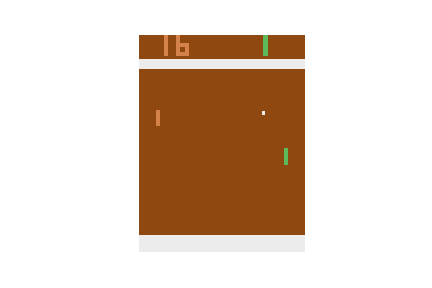
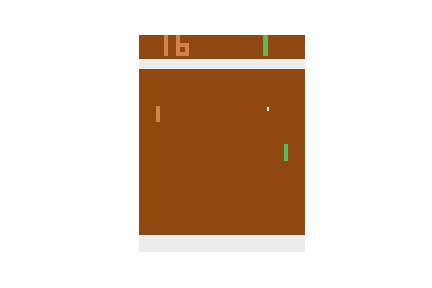
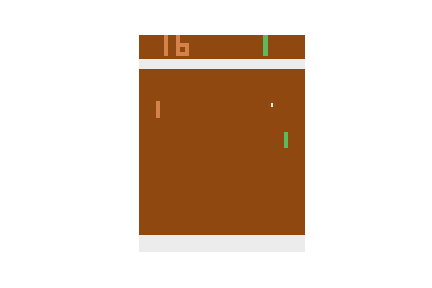
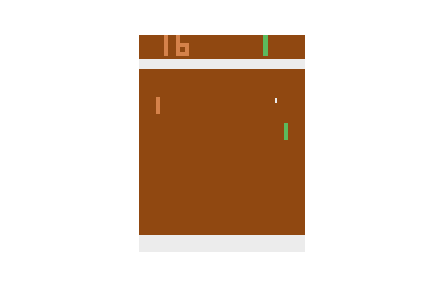
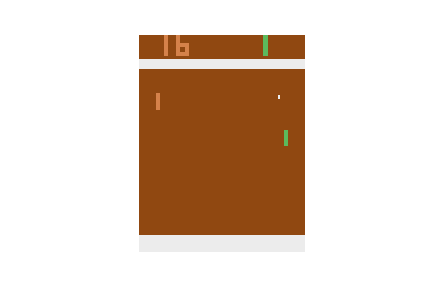
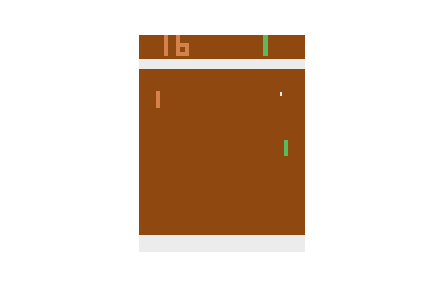
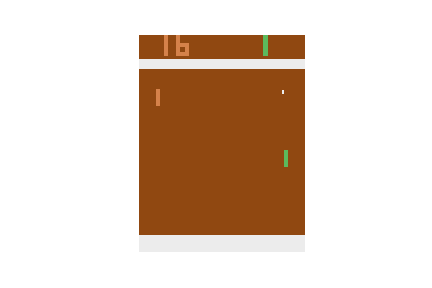
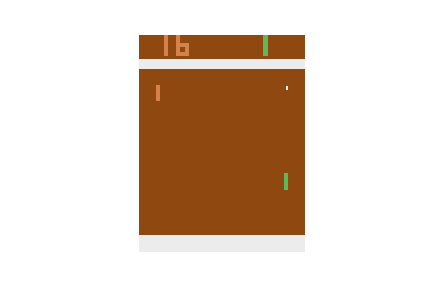
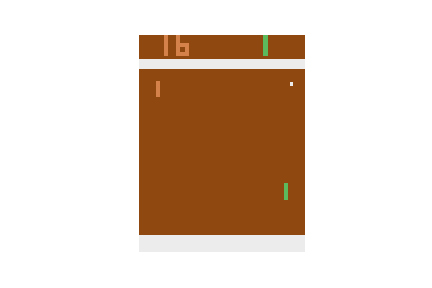
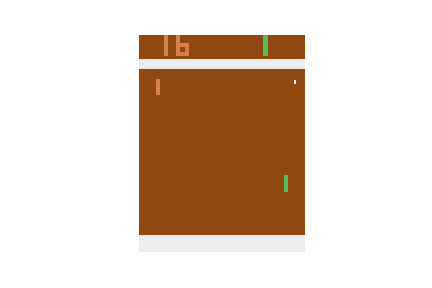
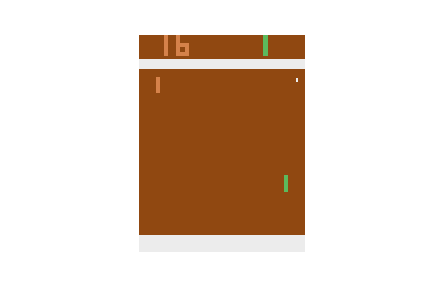
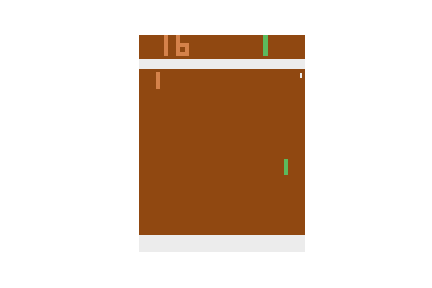
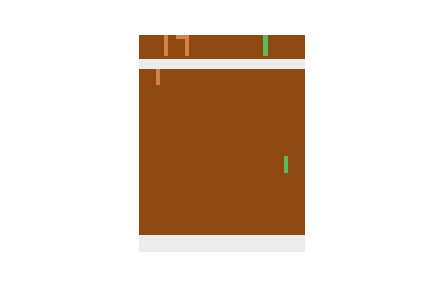
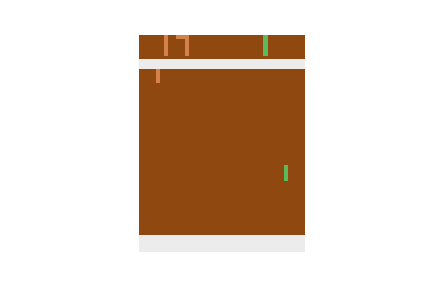
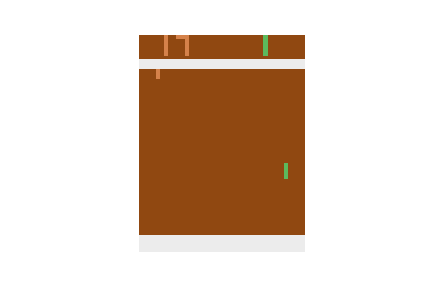
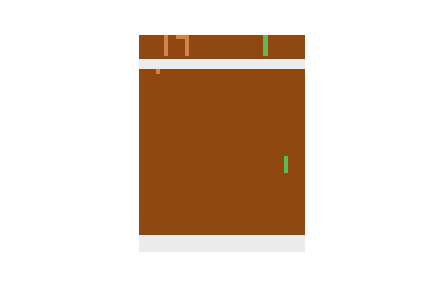
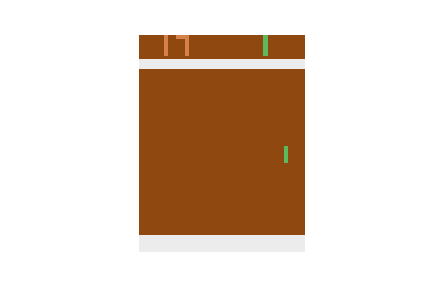
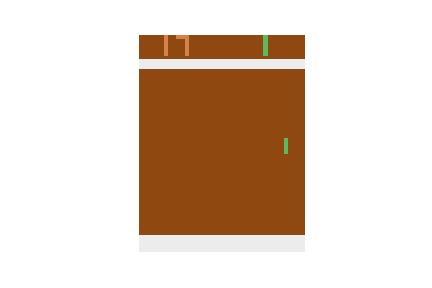
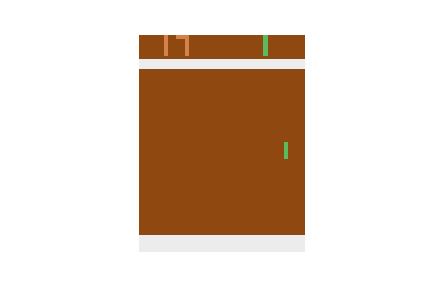
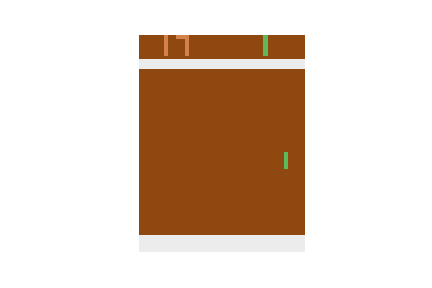
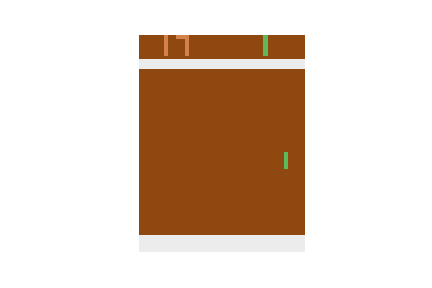
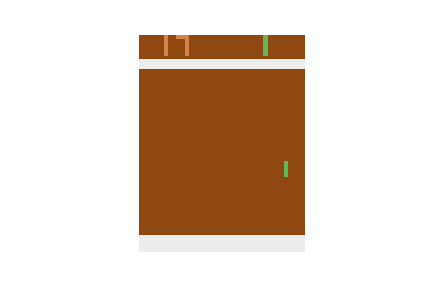
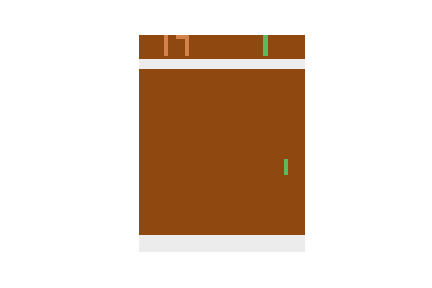
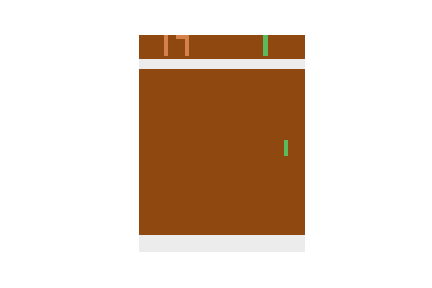
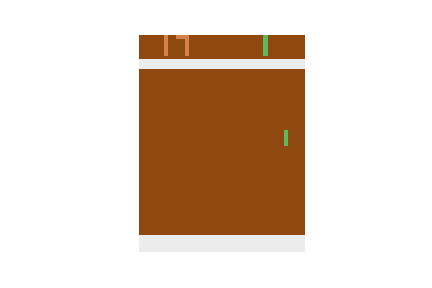
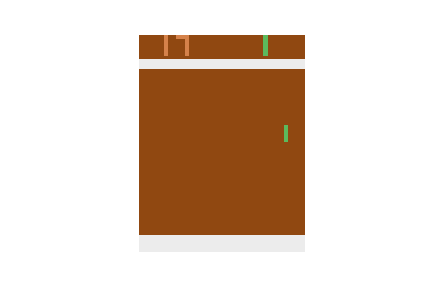
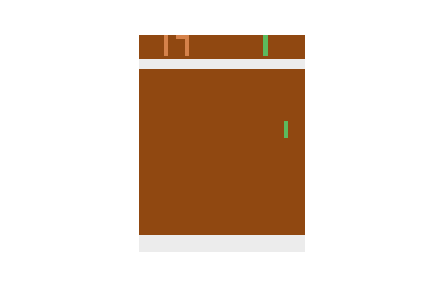
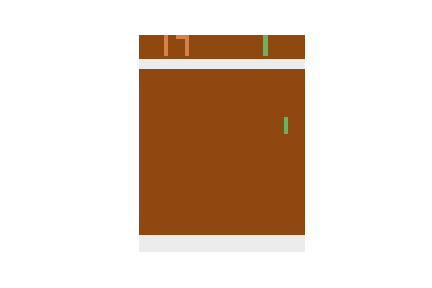
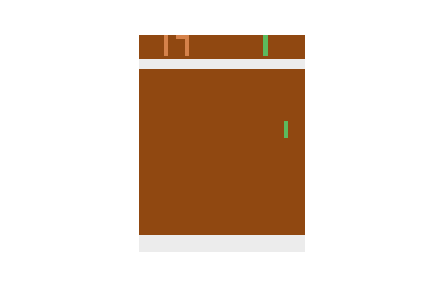
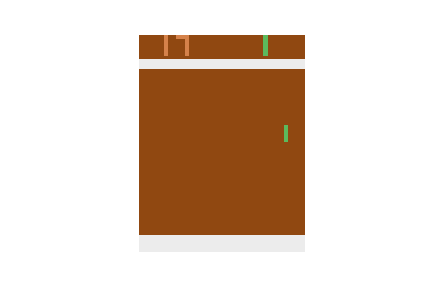
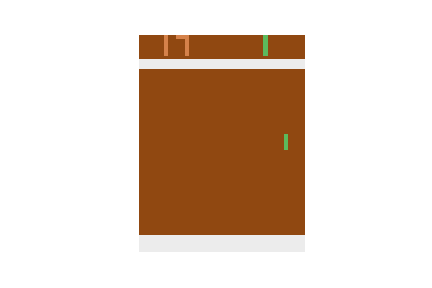
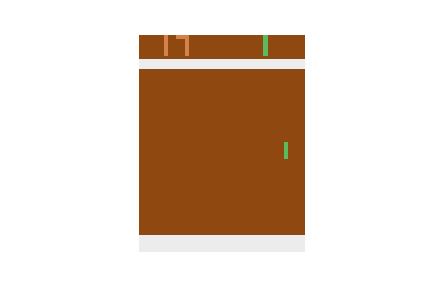
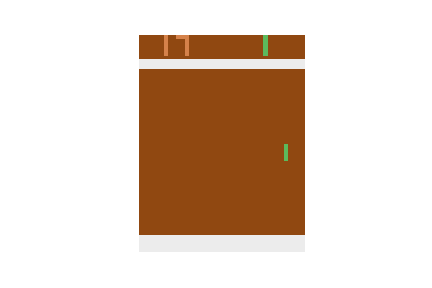
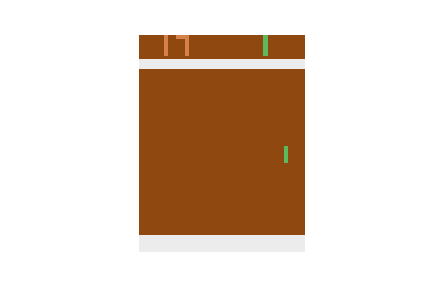
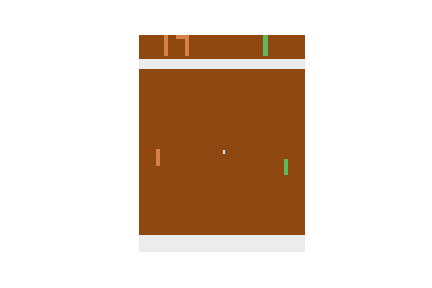
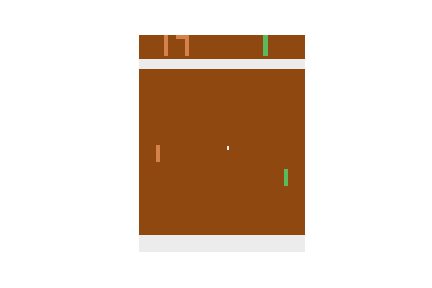
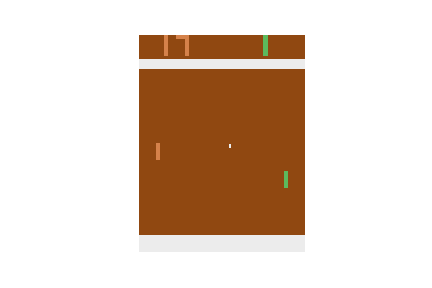
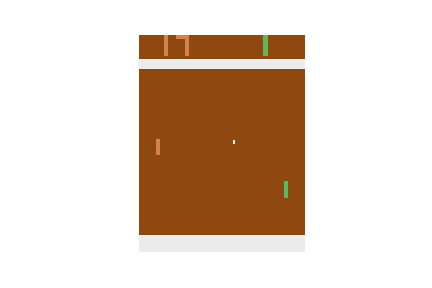
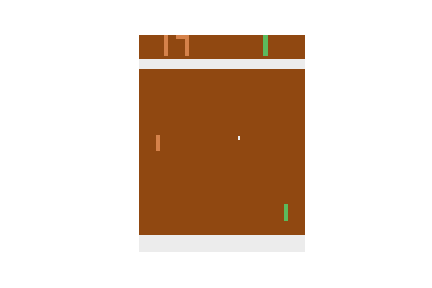
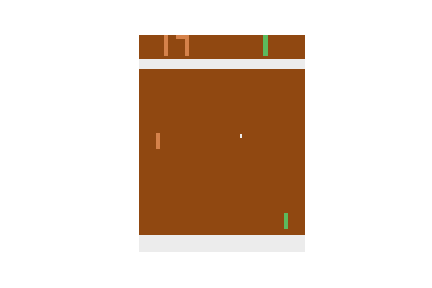
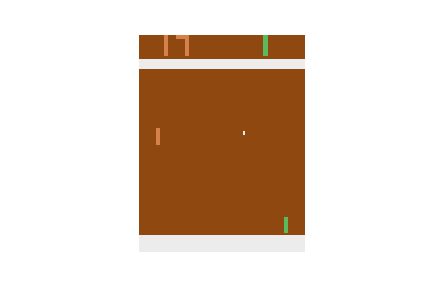
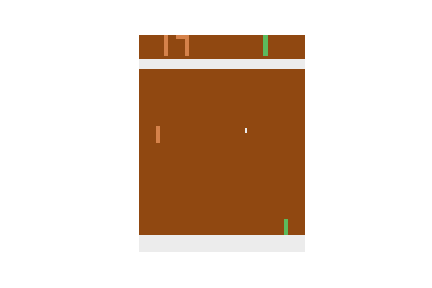
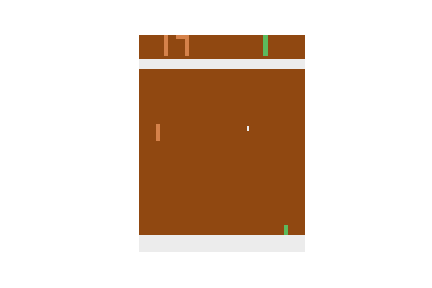
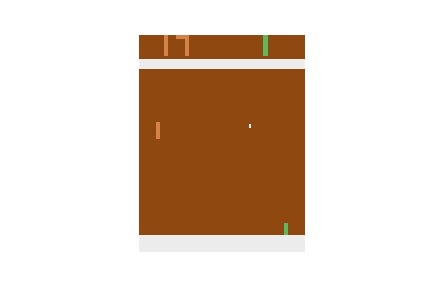
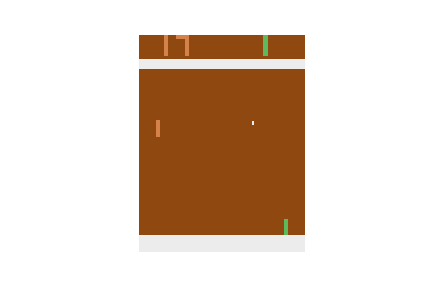
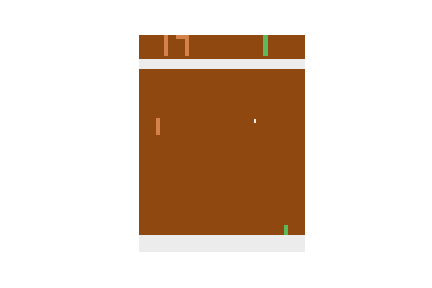
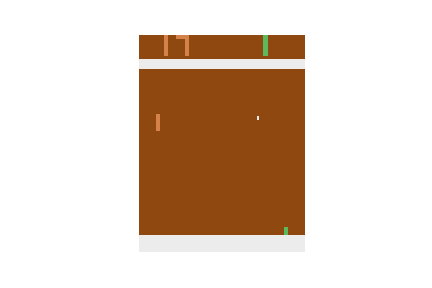
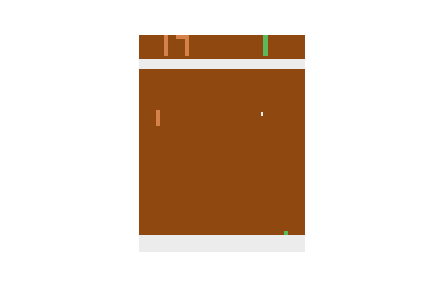
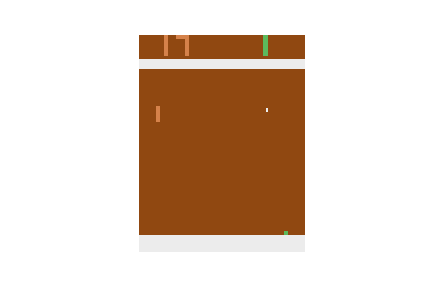
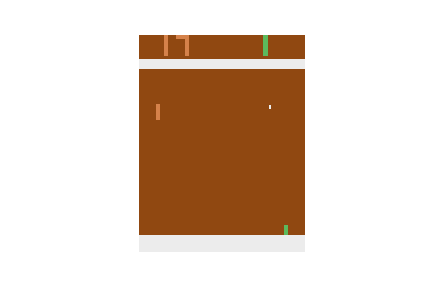
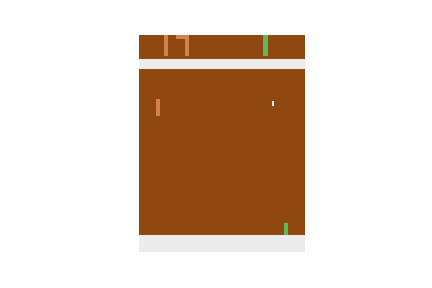
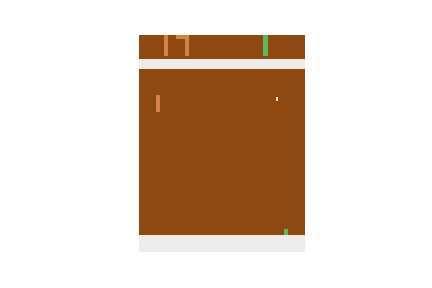
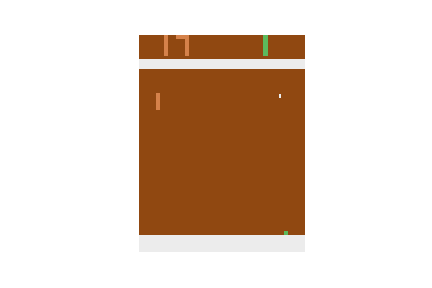
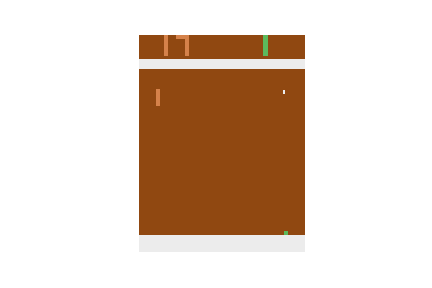
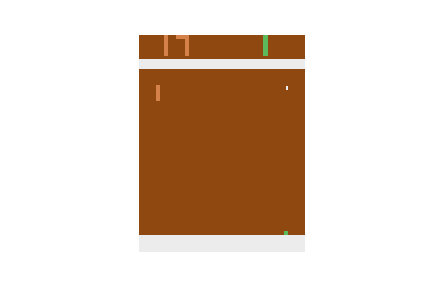
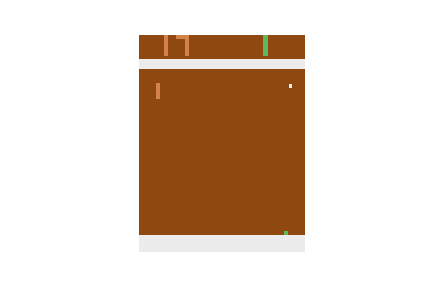
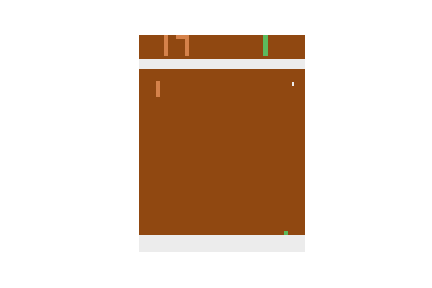
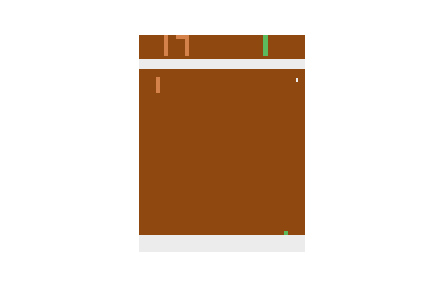
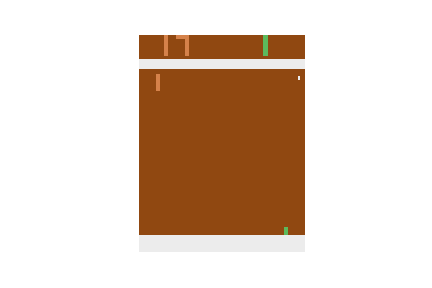
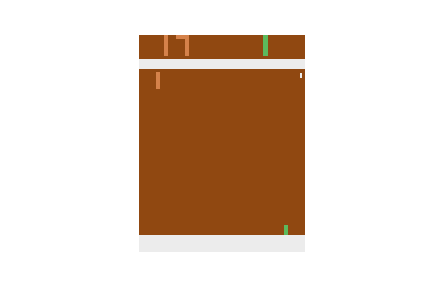
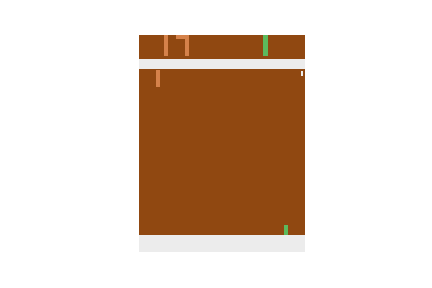
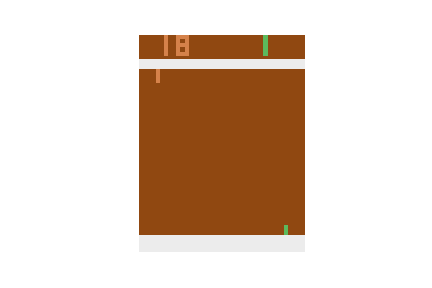
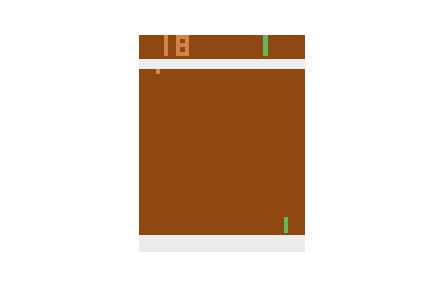
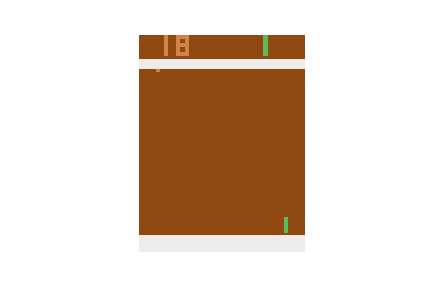
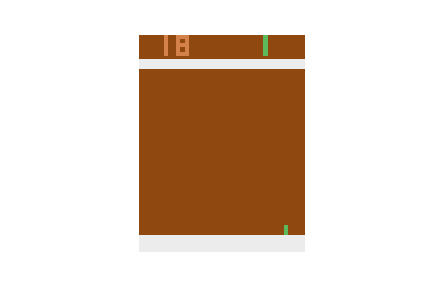
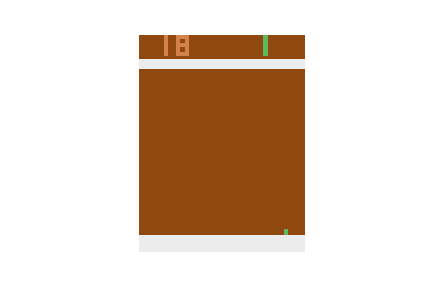
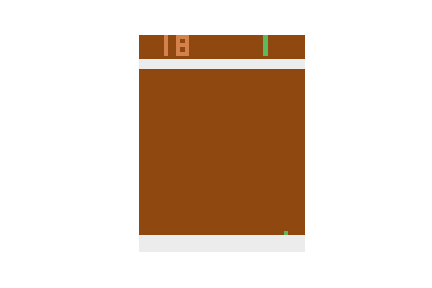
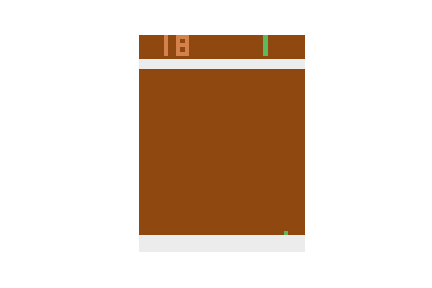
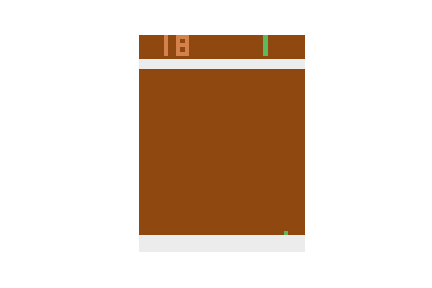
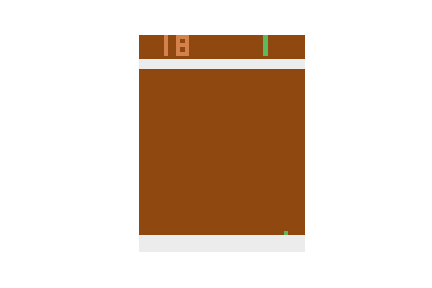
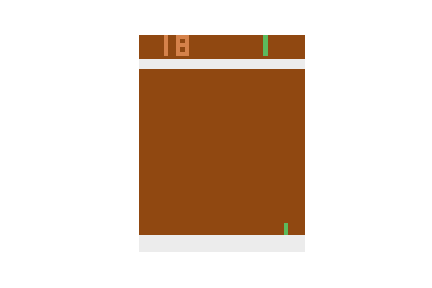
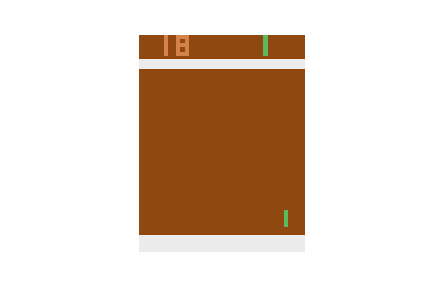
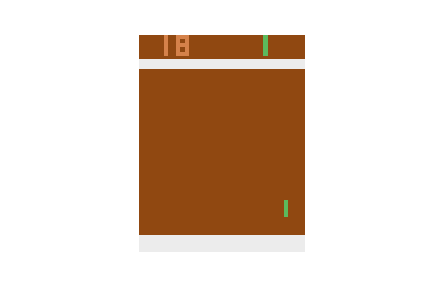
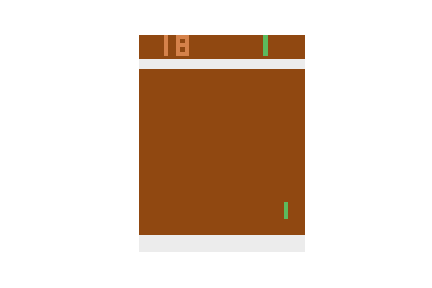
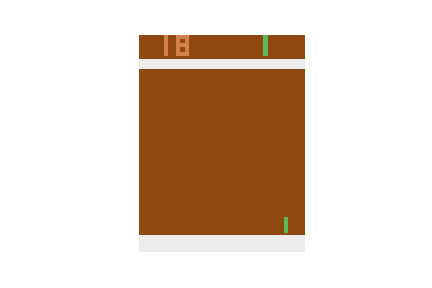
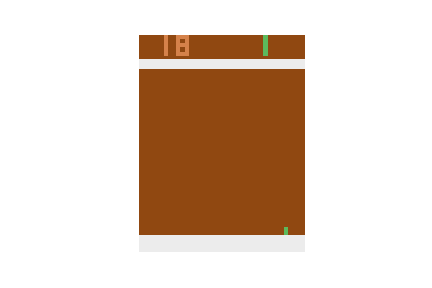
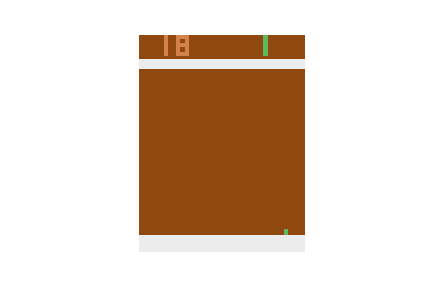
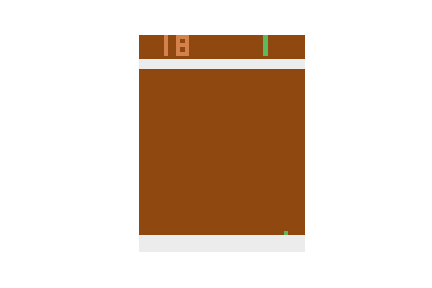
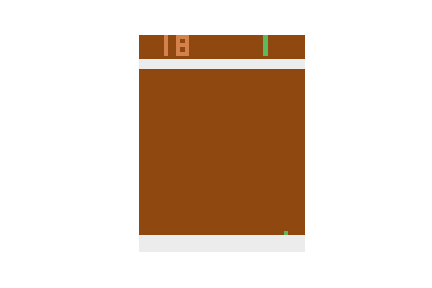
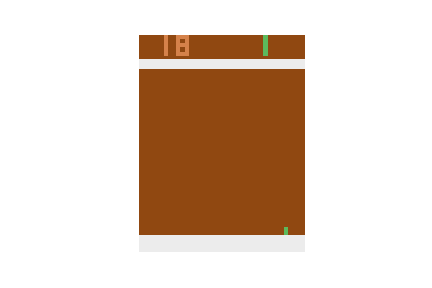
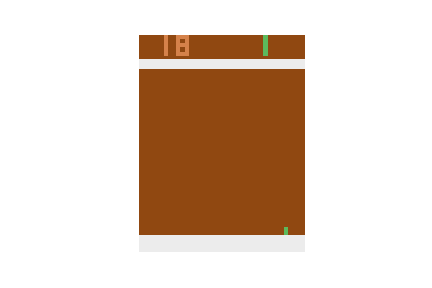
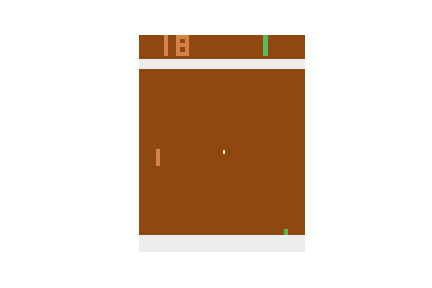
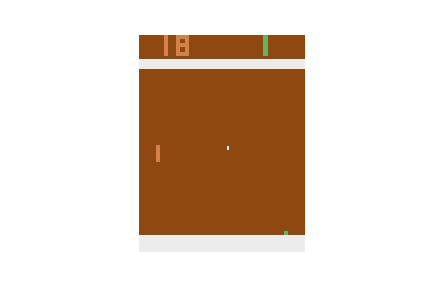
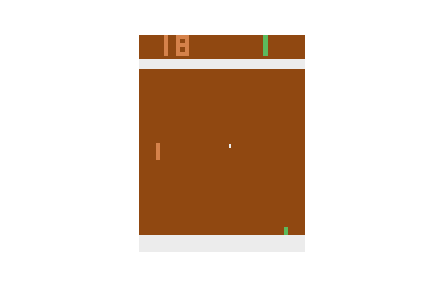
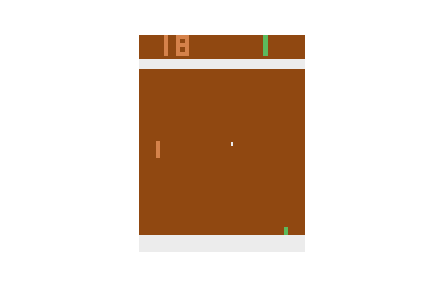
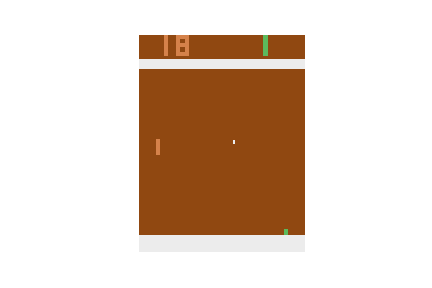
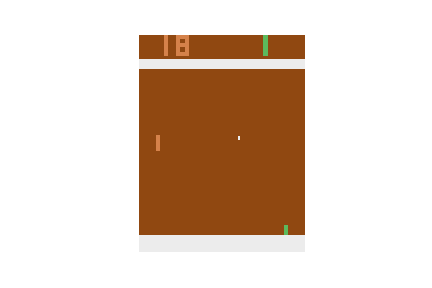
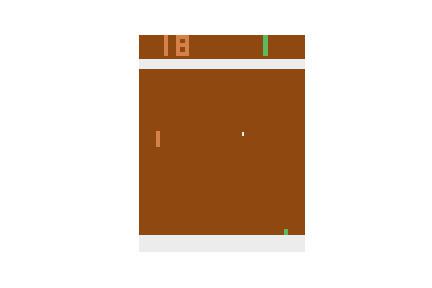
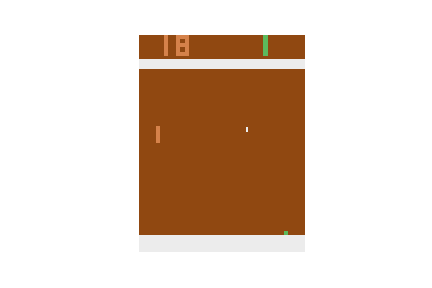
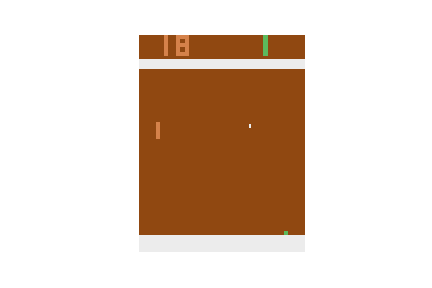
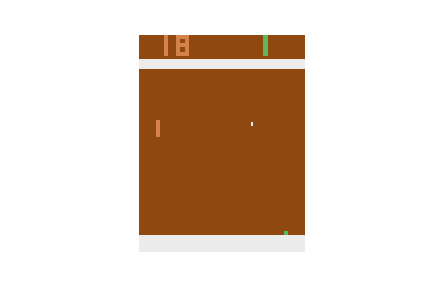
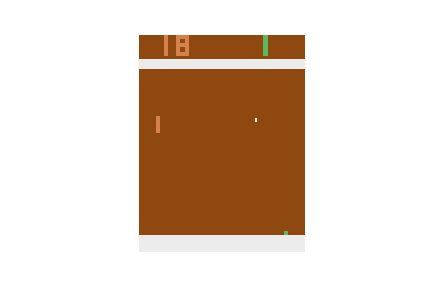
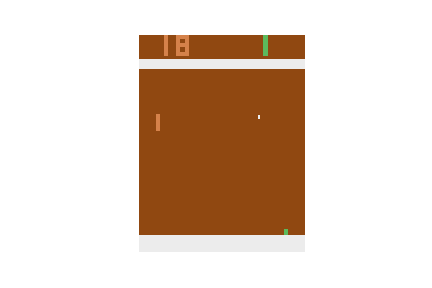
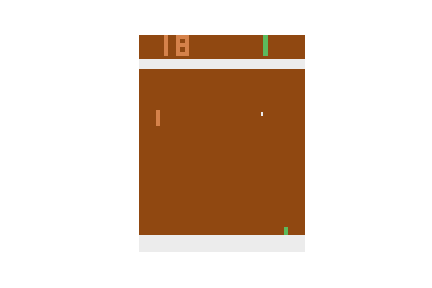
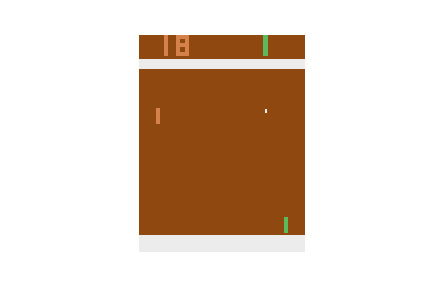
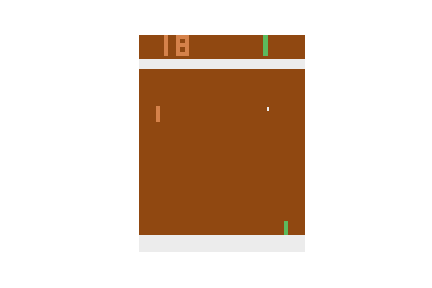
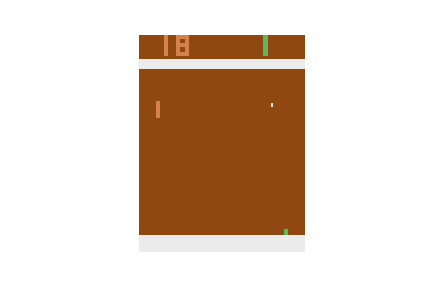
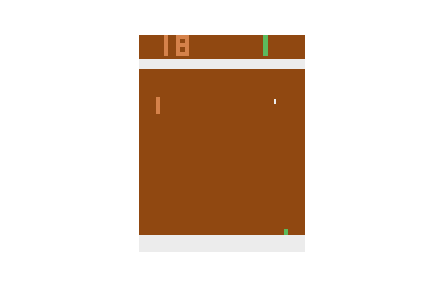
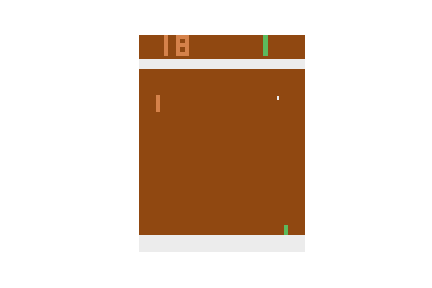
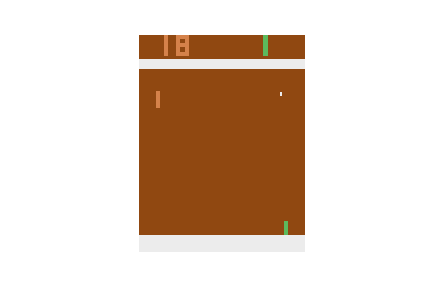
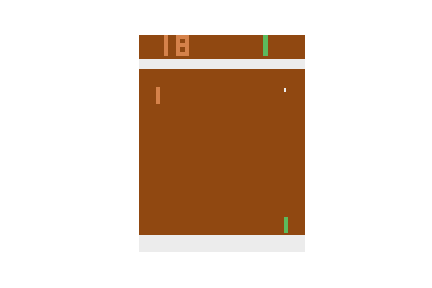
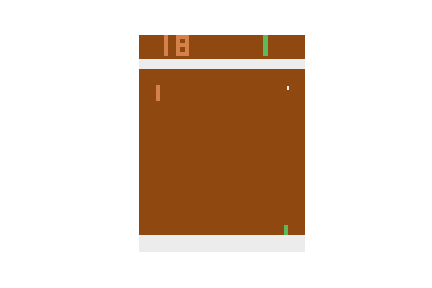
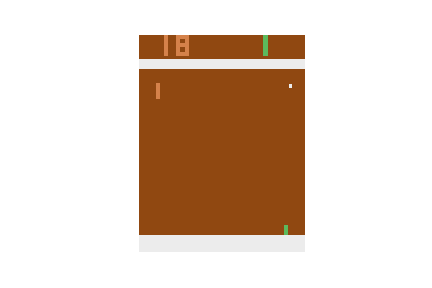
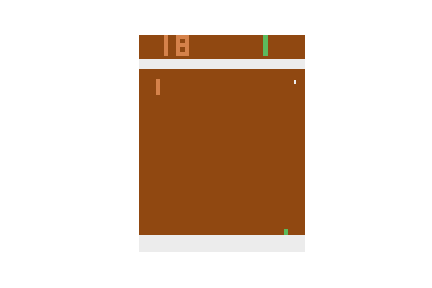
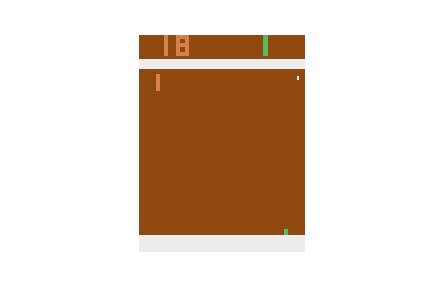
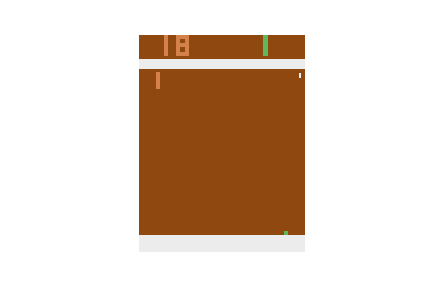
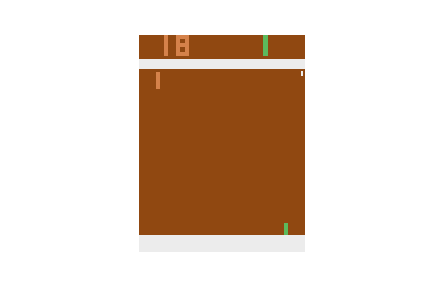
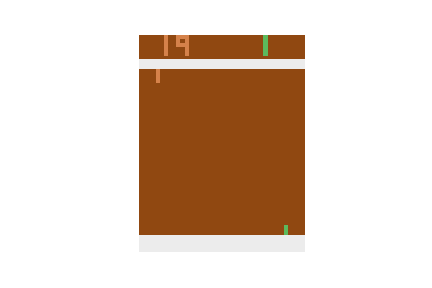
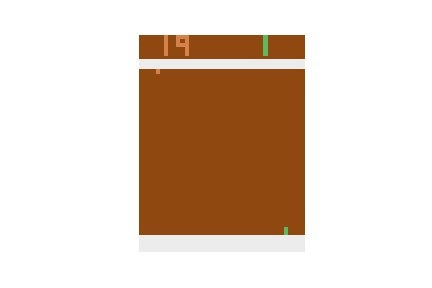
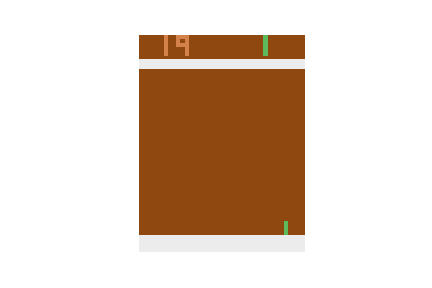
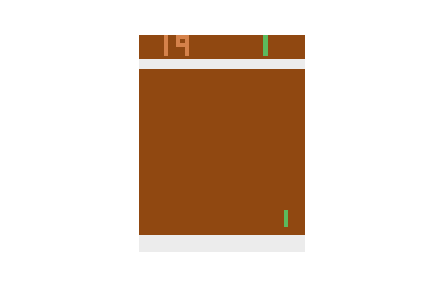
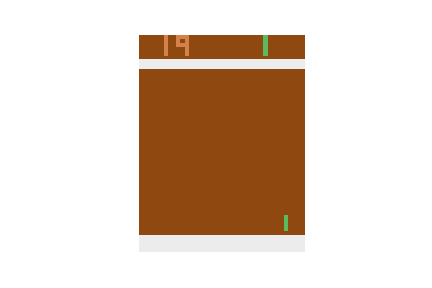
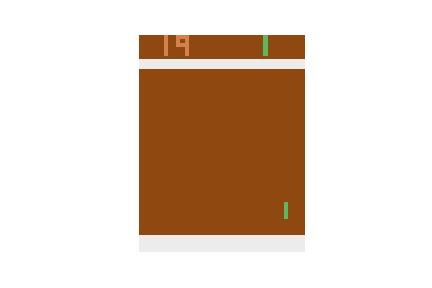
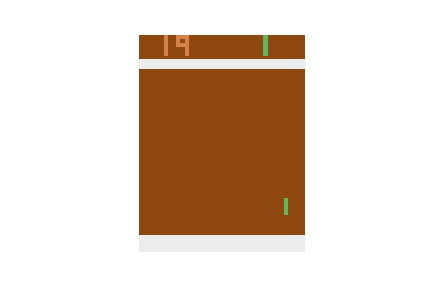
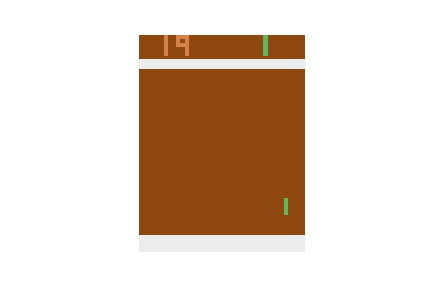
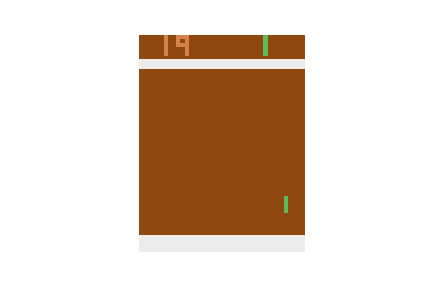
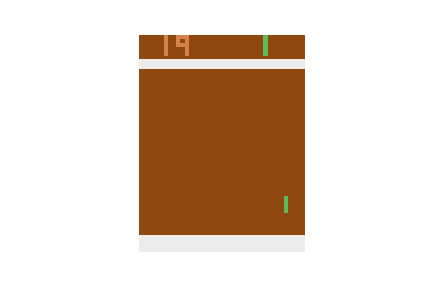
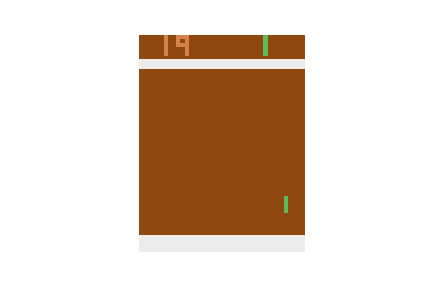
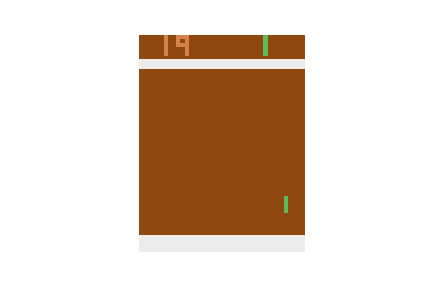
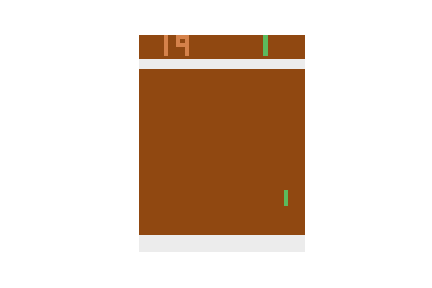
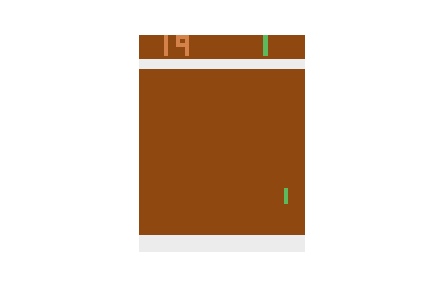
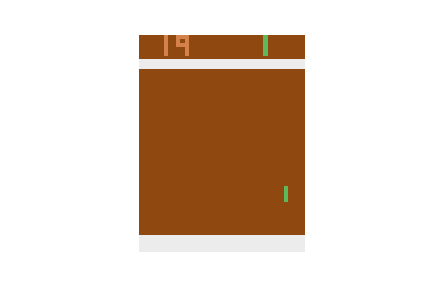
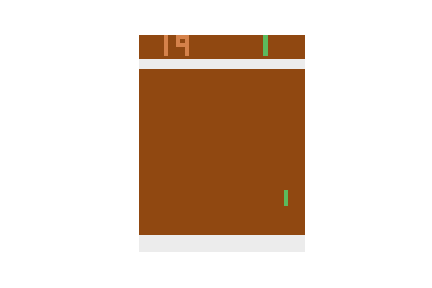
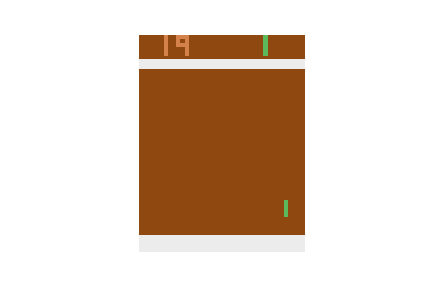
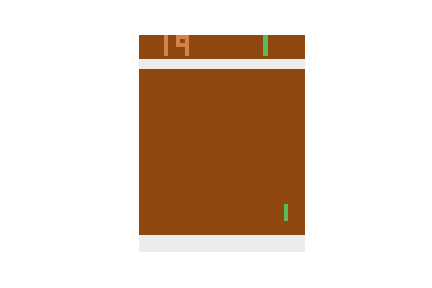
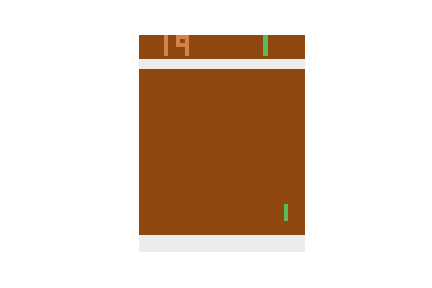
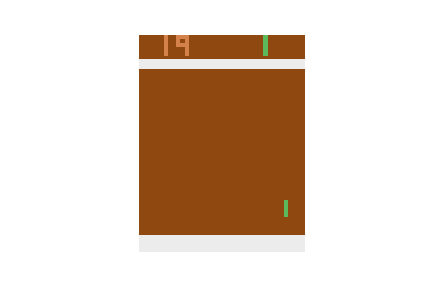
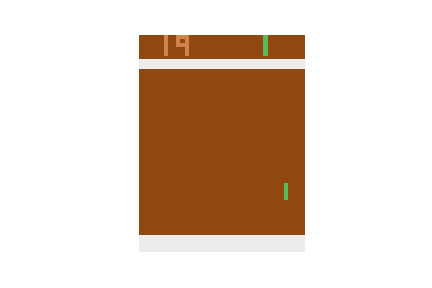
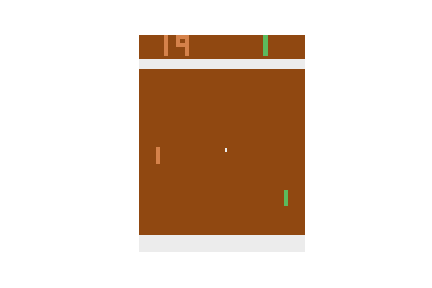
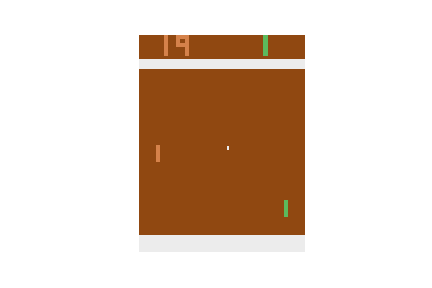
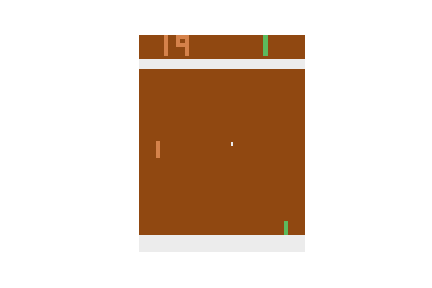
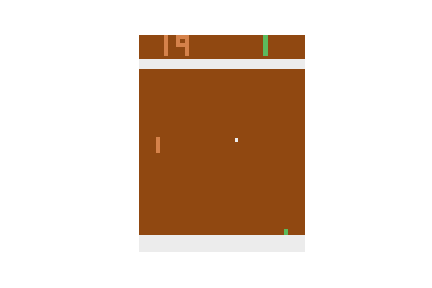
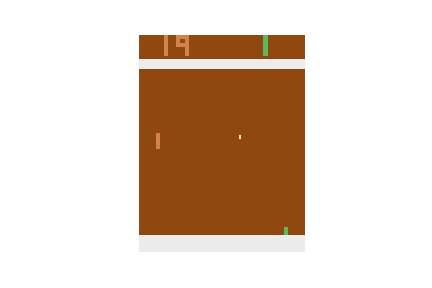
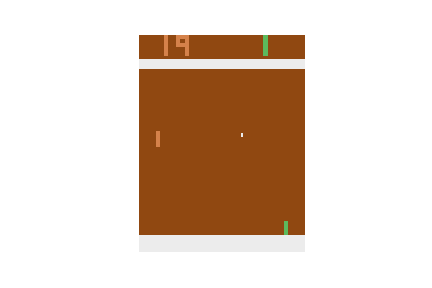
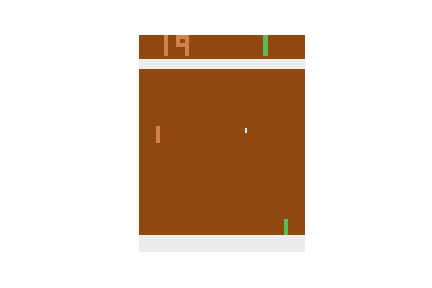
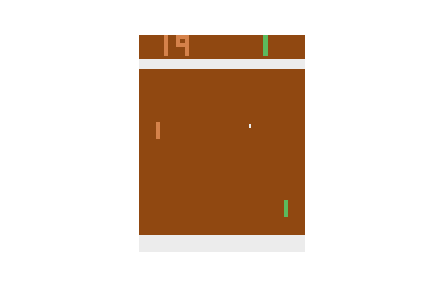
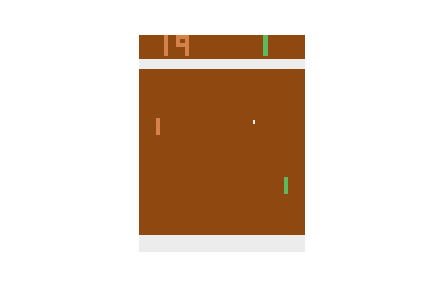
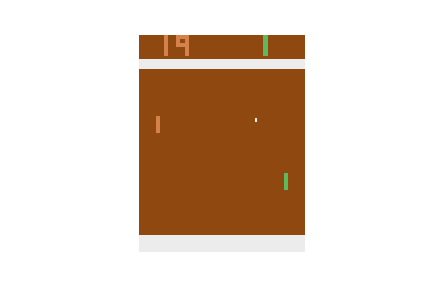
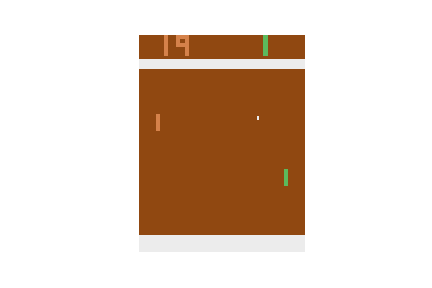
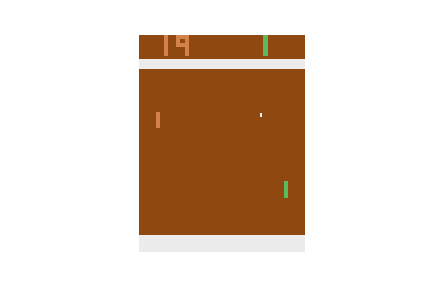
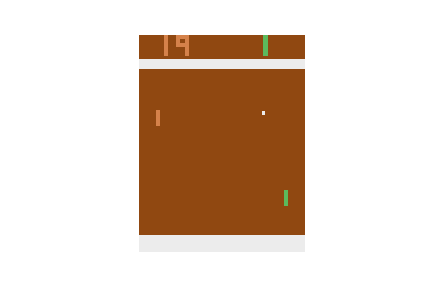
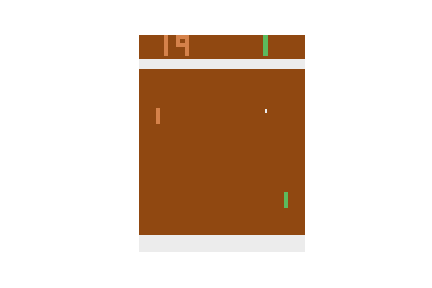
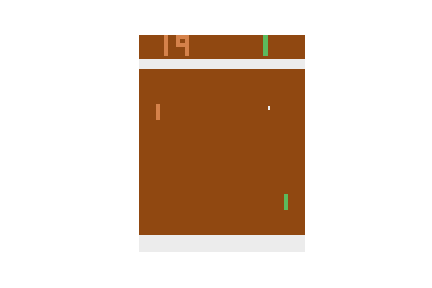
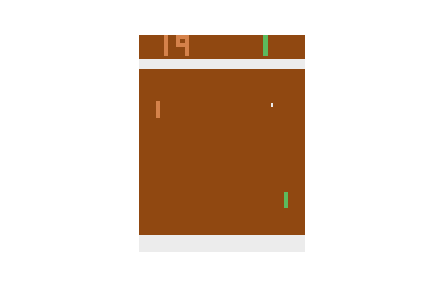
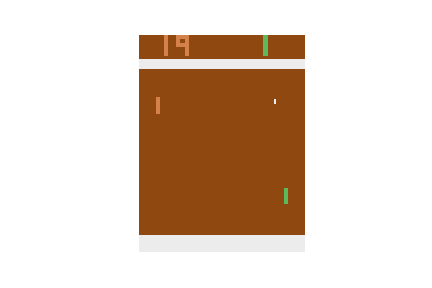
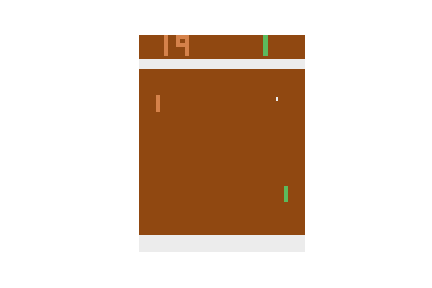
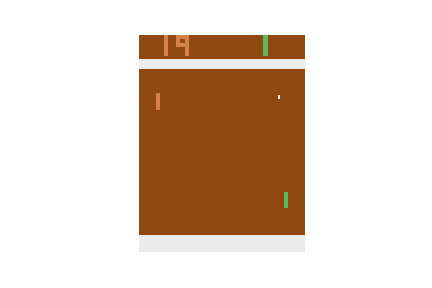
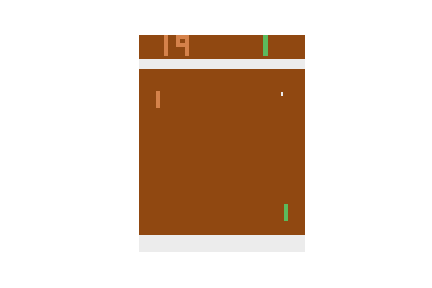
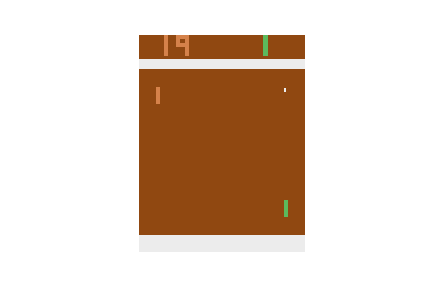
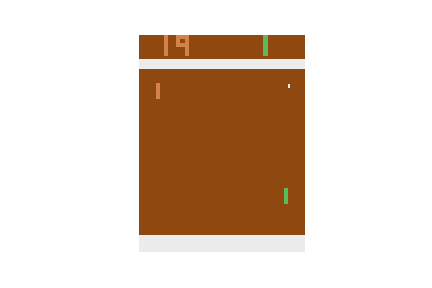
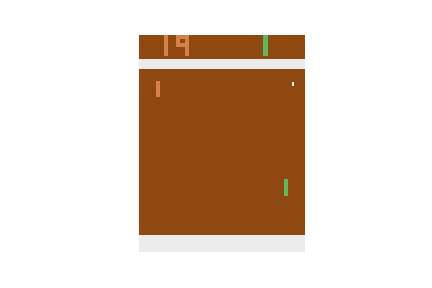
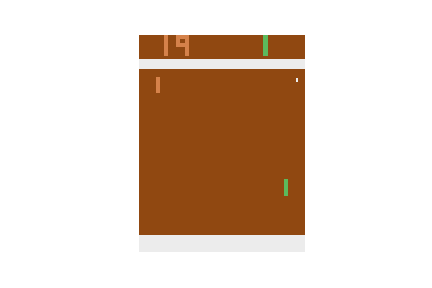
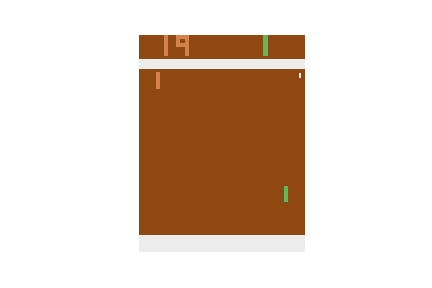
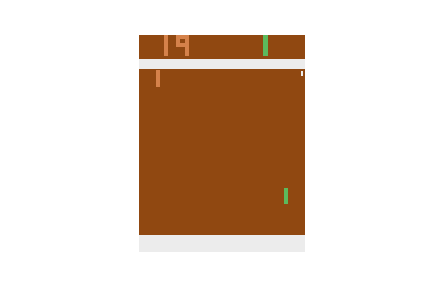
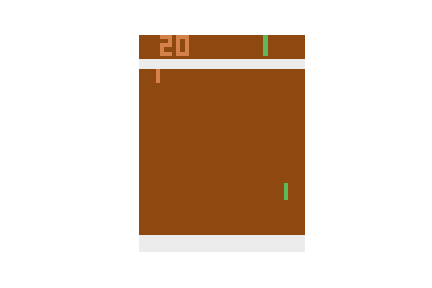
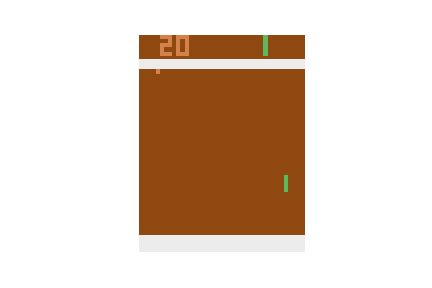
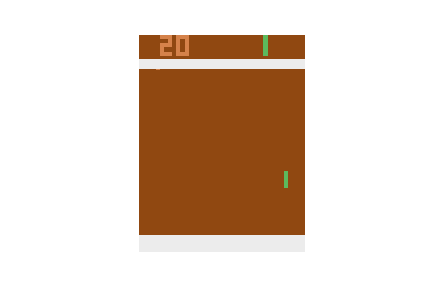
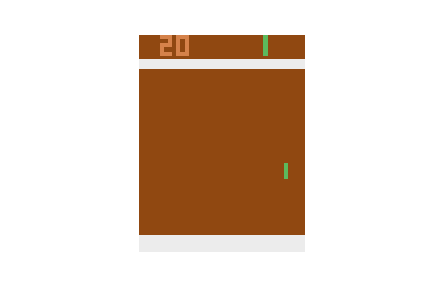
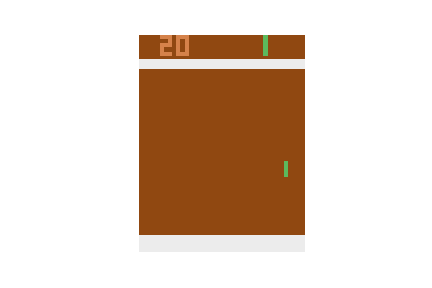
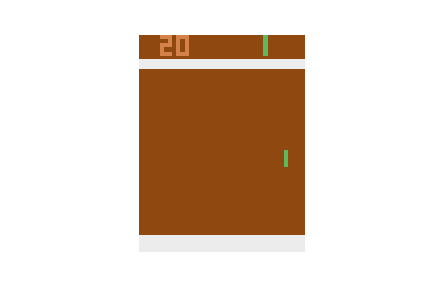
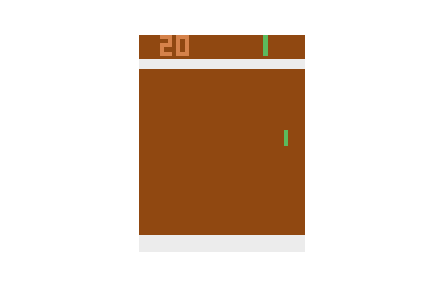
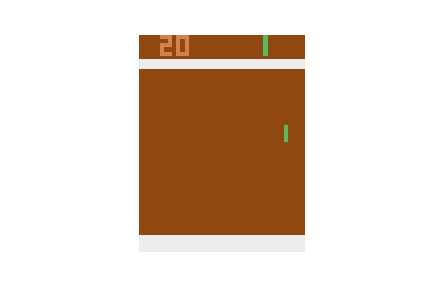
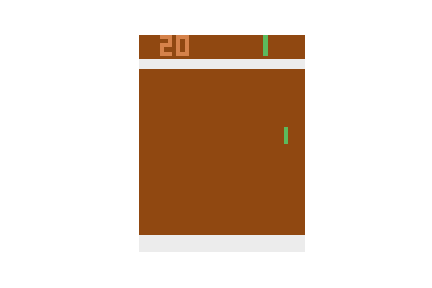
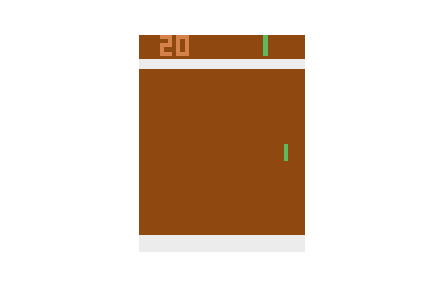
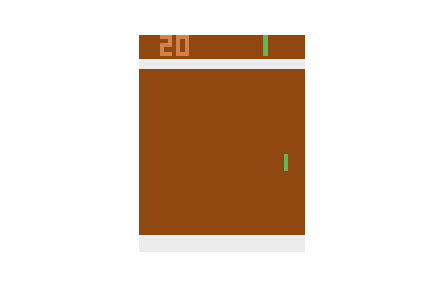
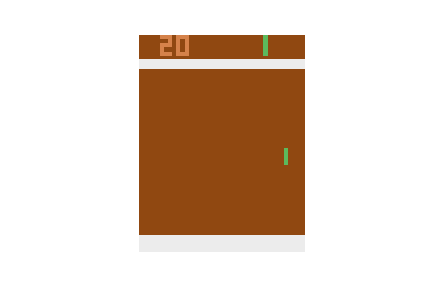
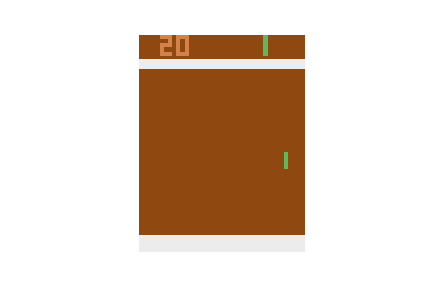
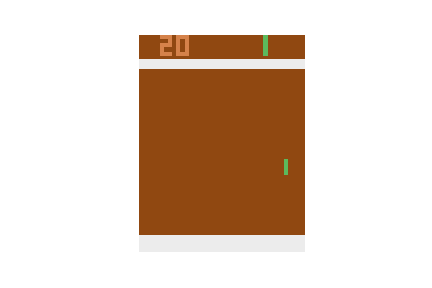
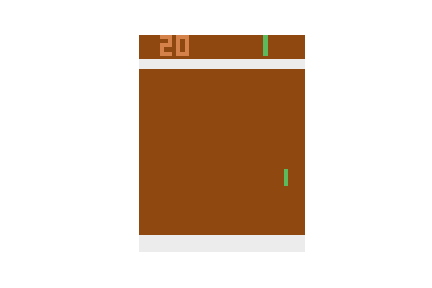
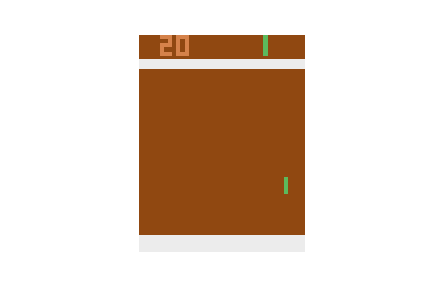
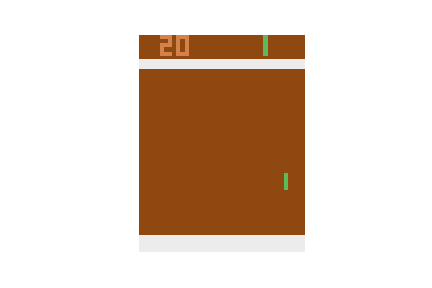
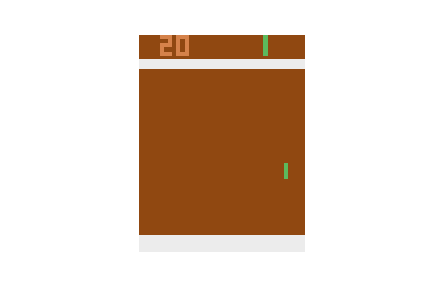
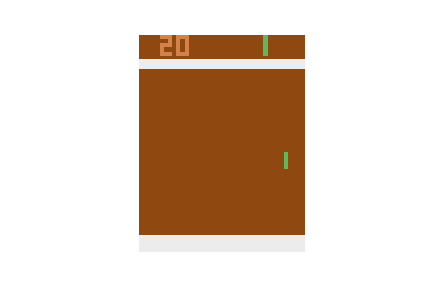
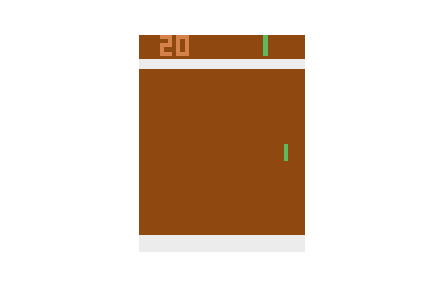
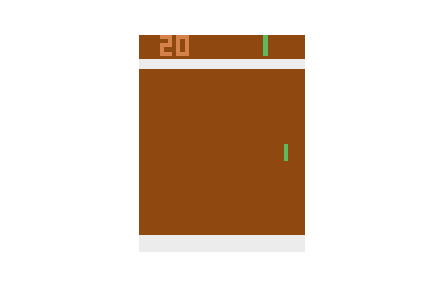
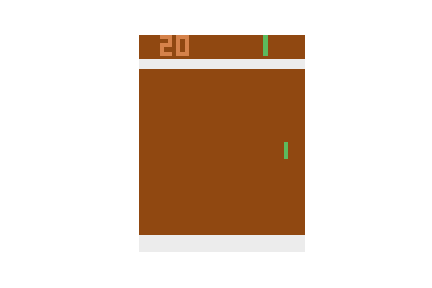
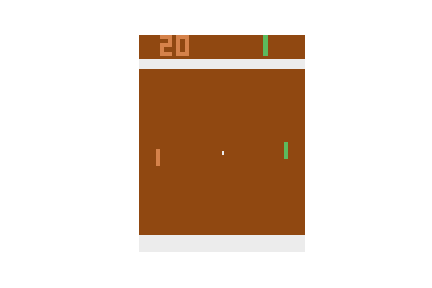
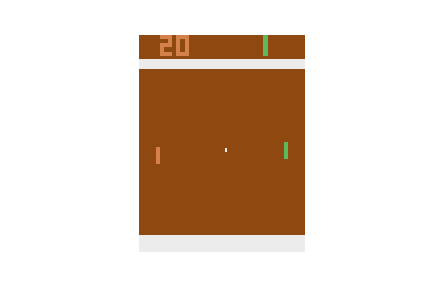
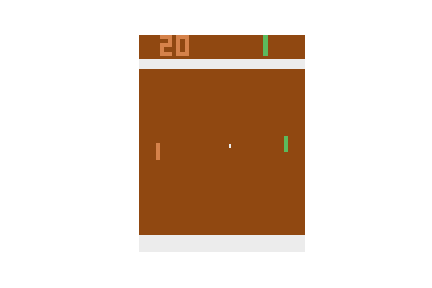
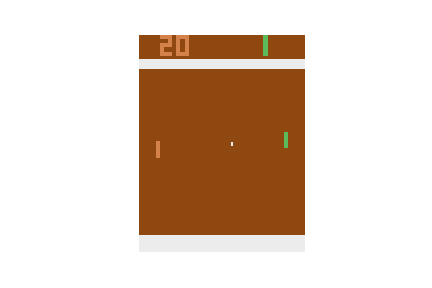
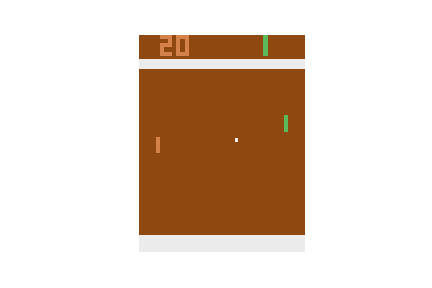
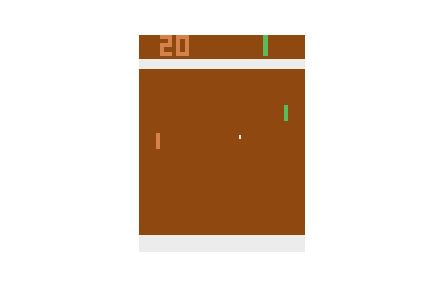
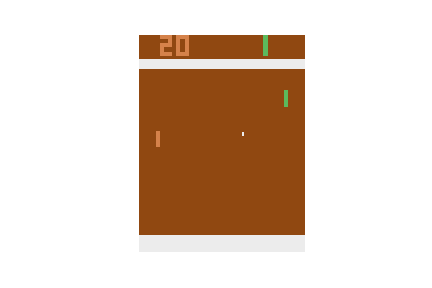
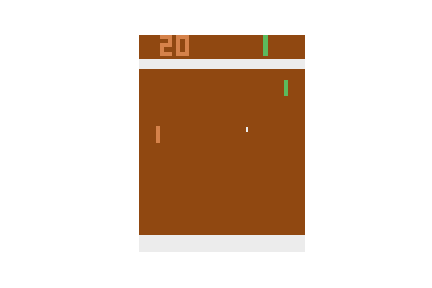
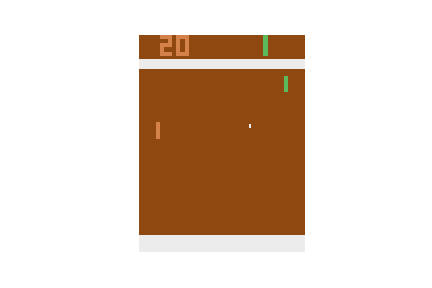
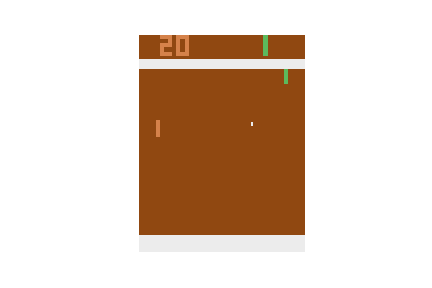
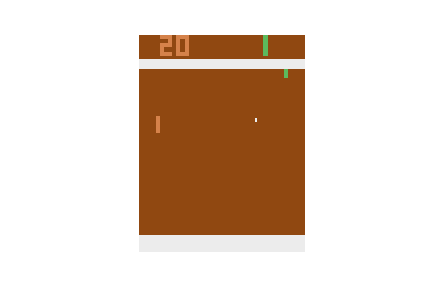
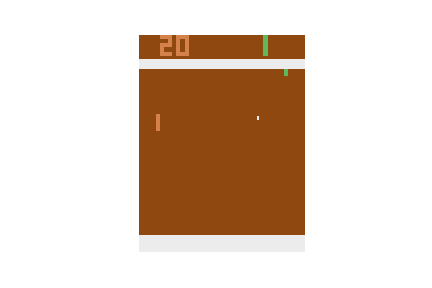
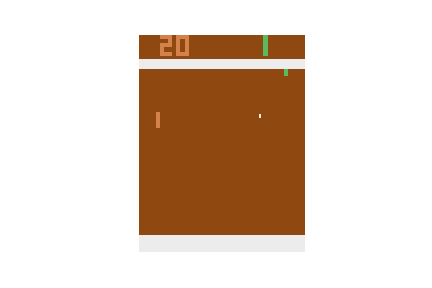
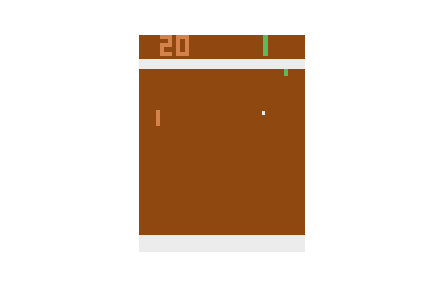
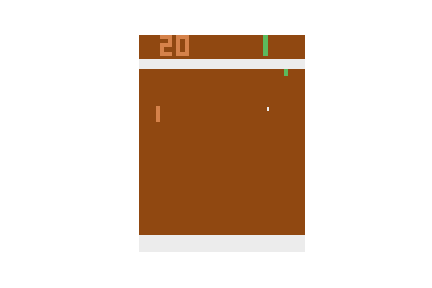
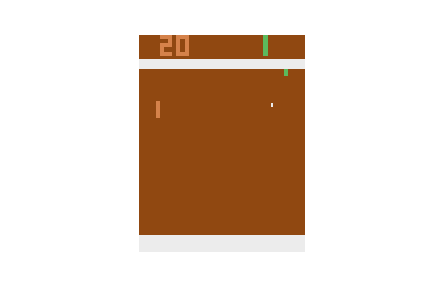
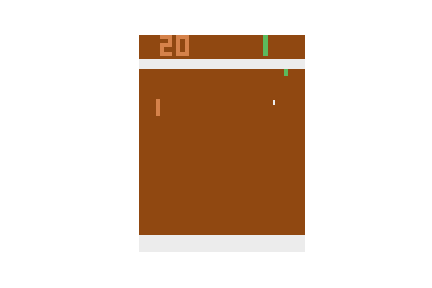
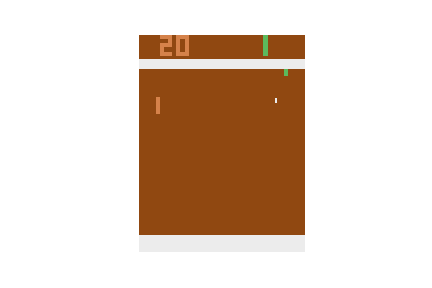
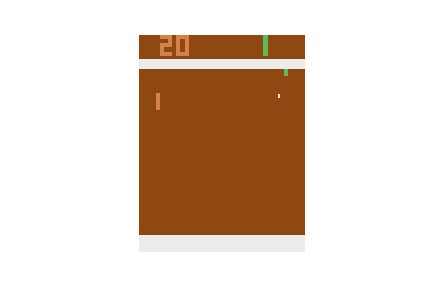
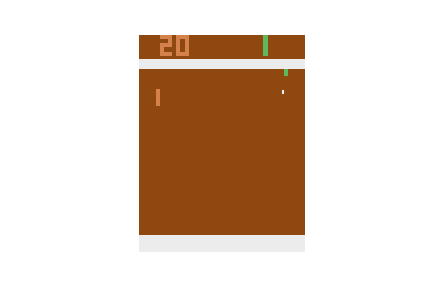
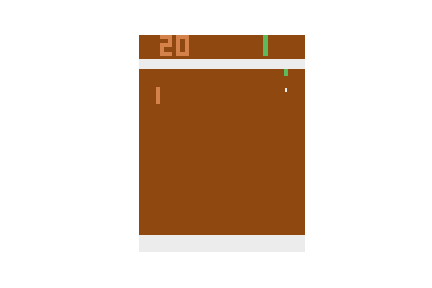
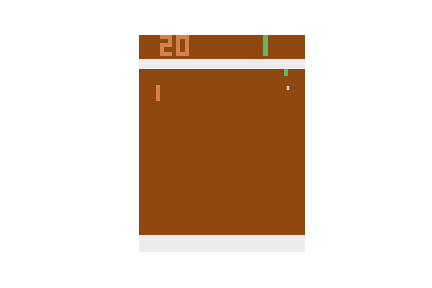
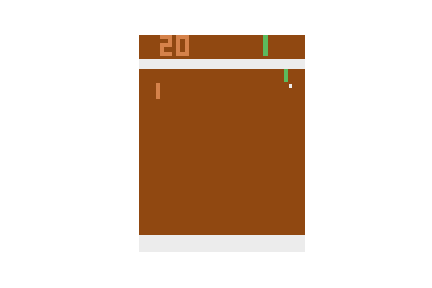
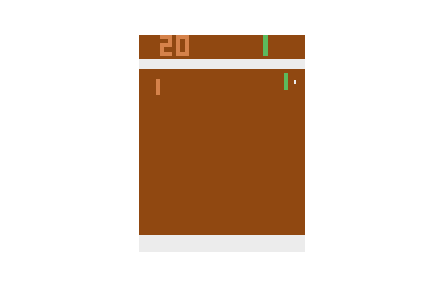
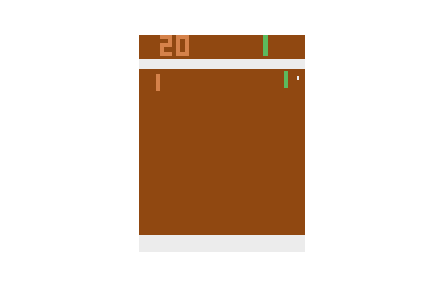
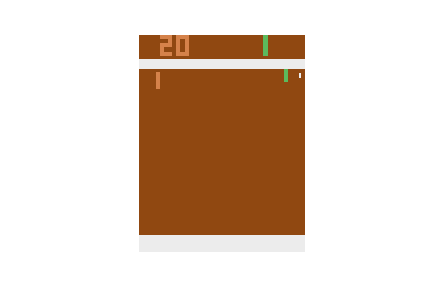

1207


In [5]:
observation = env.reset()
cum_reward = 0
frames = []
r = []
for t in range(5000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    r.append(reward)
    if done:
        break
        
r = np.array(r)
# env.render(close=True)
display_frames_as_gif(frames)
print(t)

In [6]:
gamma = 0.99
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(discounted_r))):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add =  r[t] + running_add * gamma # belman equation
        discounted_r[t] = running_add
    return discounted_r

def discount_n_standardise(r):
    dr = discount_rewards(r)
    dr = (dr - dr.mean()) / dr.std()
    return dr

## Preprocess image

In [7]:
def preprocess(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)[:,:,None]

## Reinforcement Learning

It turns out that action 2 makes the racket go up and 3 makes the racket go down. It has 6 actions by default because it's an Atari game, and there were 6 buttons in the controller. See [here](https://ai.stackexchange.com/questions/2449/what-are-different-actions-in-action-space-of-environment-of-pong-v0-game-from) for source of this answer.

In [8]:
def pg_loss(adv_y_true, y_pred):
    adv = adv_y_true[:,:1]
    y_true = adv_y_true[:,1:]
    return K.mean(adv*K.binary_crossentropy(y_true, y_pred), axis=-1)

In [71]:
def pg_loss(adv_y_true, y_pred):
    adv = adv_y_true[:,:1]
    y_true = adv_y_true[:,1:]
    return K.mean(adv*K.binary_crossentropy(y_true, y_pred), axis=-1)

model = Sequential()
model.add(Conv2D(4, kernel_size=(3,3), padding='same', activation='relu', input_shape = (80,80,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=rmsprop(1e-5), loss=pg_loss) #

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 80, 80, 4)         40        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 40, 40, 4)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 40, 40, 8)         296       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 20, 20, 16)        1168      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
__________

In [87]:
# episodes = 0
# reward_sums = []
reward_sum = 0
prev_x = None
im_shape = (80, 80, 1)

prev_frame = None
buffer = 30000
xs = np.zeros((buffer,)+im_shape)
ys = np.zeros((buffer,1))
rs = np.zeros((buffer,1))

observation = env.reset()

n_episodes = 15000
k = 0
while episodes<n_episodes:
    x = preprocess(observation)
    xs[k] = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    prev_frame = x
    
    p = model.predict(x[None,:,:,:])
    action = 2 if np.random.uniform() < p[0][0] else 3 # roll the dice!
    
    y = 1 if action == 2 else 0 # a "fake label"
    ys[k] = y
    
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    rs[k] = reward
    
    k += 1
    
    if done or k==buffer:
        reward_sums.append(reward_sum)
        reward_sum = 0
        episodes += 1
        
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        
        ep_r = discount_n_standardise(ep_r)
        model.fit(ep_x, np.hstack([ep_r, ep_y]), batch_size=128, epochs=1, verbose=0)
        
#         from IPython.core.debugger import Tracer; Tracer()()
        k = 0
        prev_frame = None
        observation = env.reset()
        if episodes%(n_episodes//100) == 0:
            model.save('model_cnn.h5')
            loss = model.evaluate(ep_x, np.hstack([ep_r, ep_y]), batch_size=len(ep_x), verbose=0)
            ave_reward = np.mean(reward_sums[-200:])
            print('Episode: {0:d}, Loss: {1:.4f}, Average Reward: {2:.4f}'.format(episodes, loss, ave_reward))

Episode: 12300, Loss: -0.2358, Average Reward: -19.1500
Episode: 12450, Loss: -0.2379, Average Reward: -20.1950
Episode: 12600, Loss: -0.0040, Average Reward: -20.4950
Episode: 12750, Loss: -0.0587, Average Reward: -20.6800


KeyboardInterrupt: 

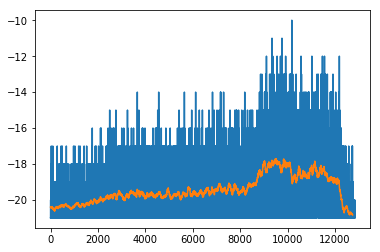

In [88]:
plt.plot(reward_sums)
plt.plot(np.convolve(reward_sums, np.ones((100,))/100, mode='valid'))
plt.show()

## Result


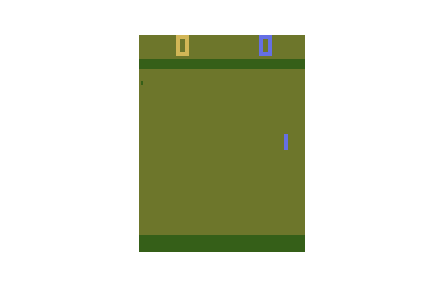
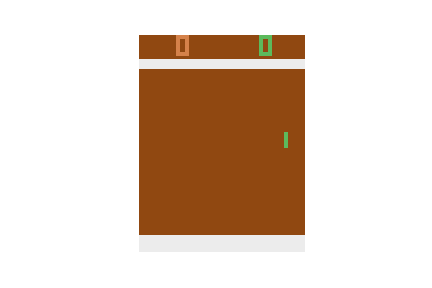
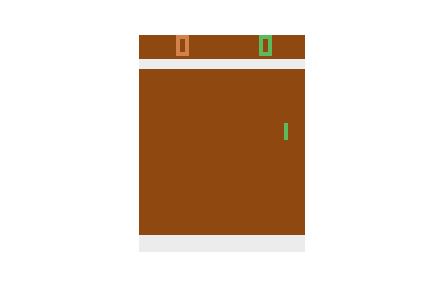
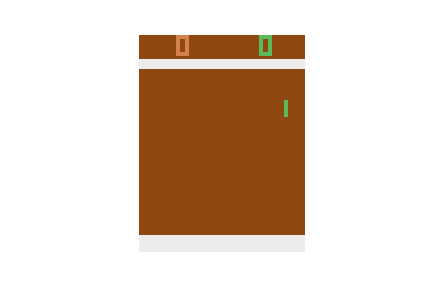
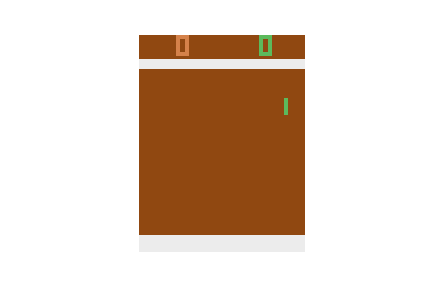
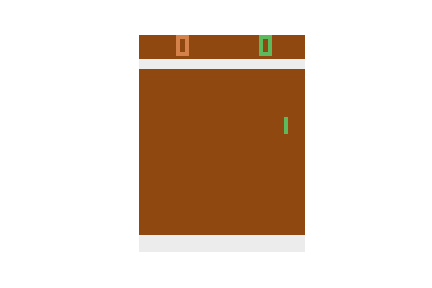
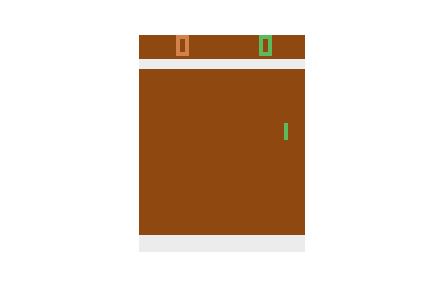
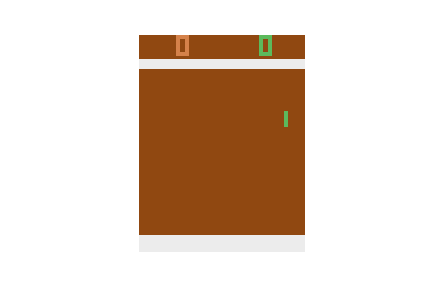
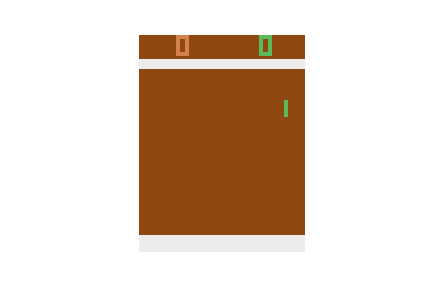
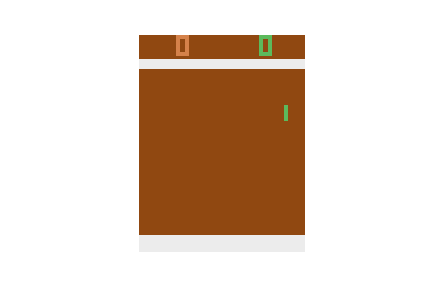
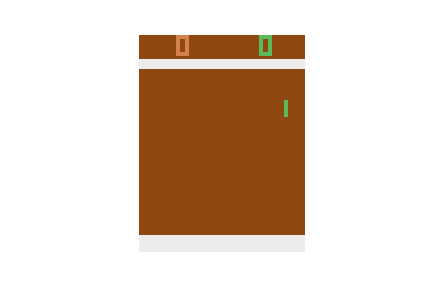
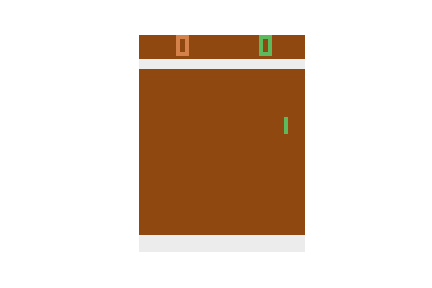
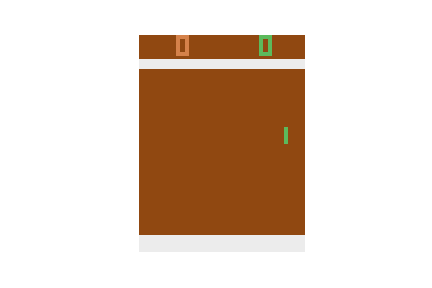
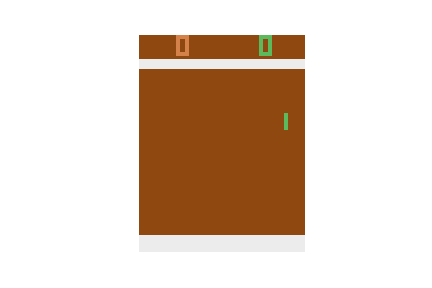
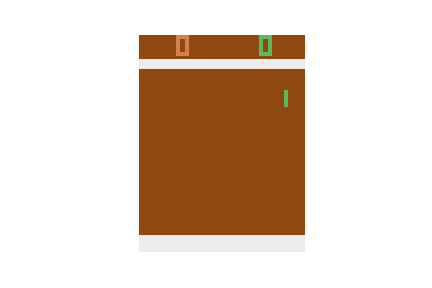
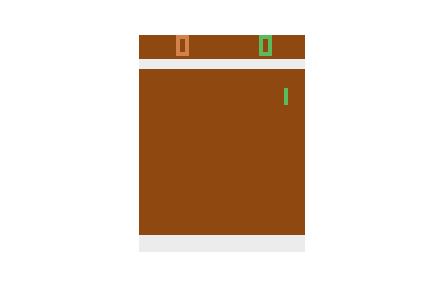
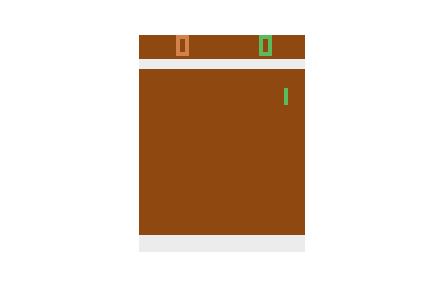
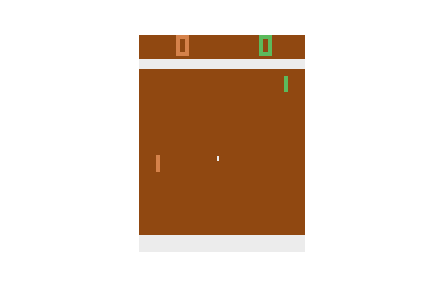
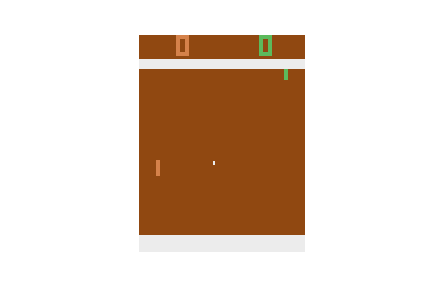
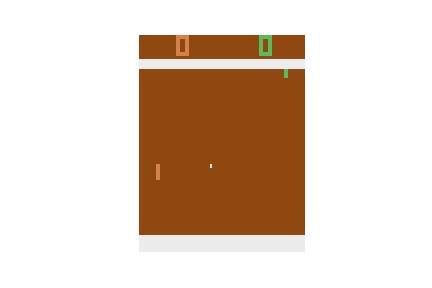
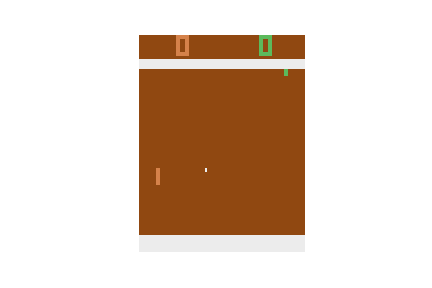
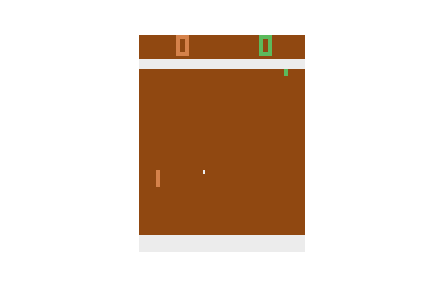
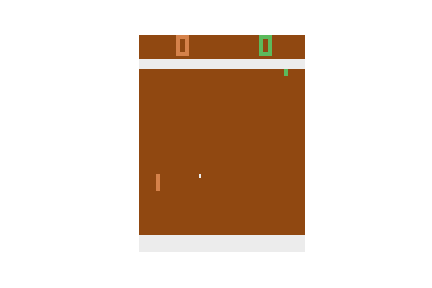
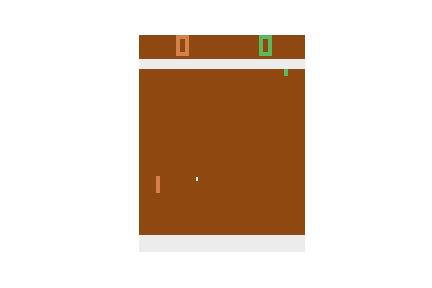
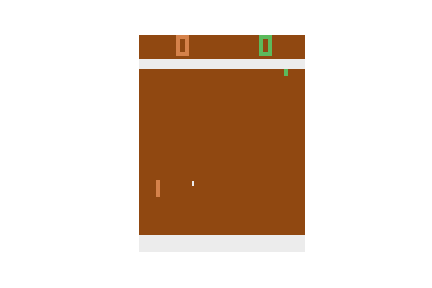
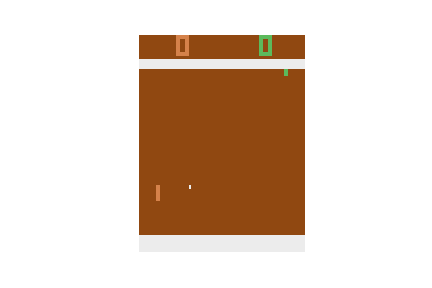
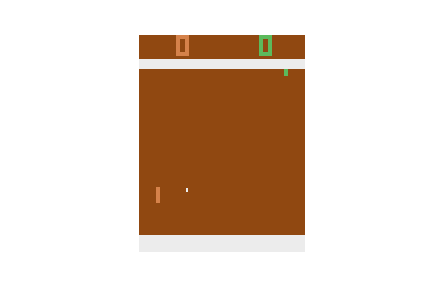
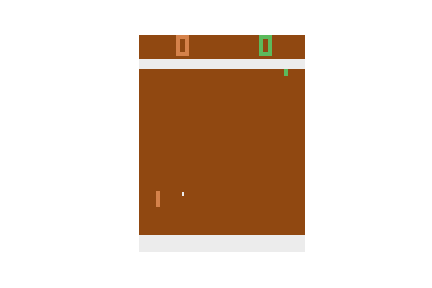
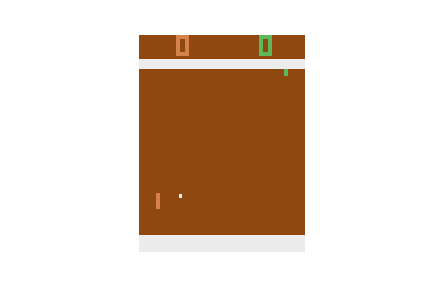
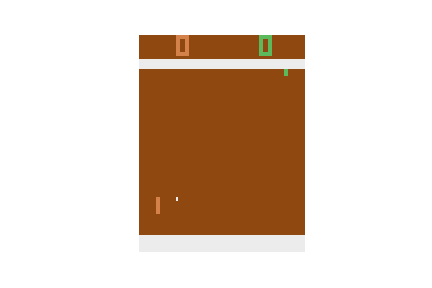
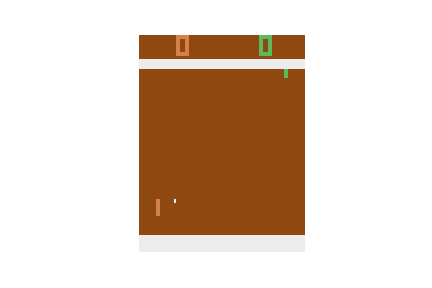
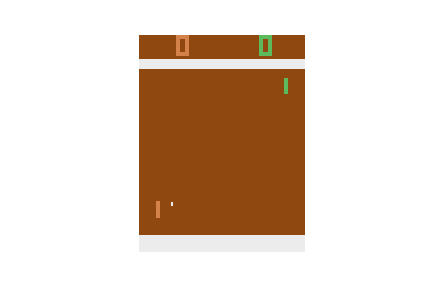
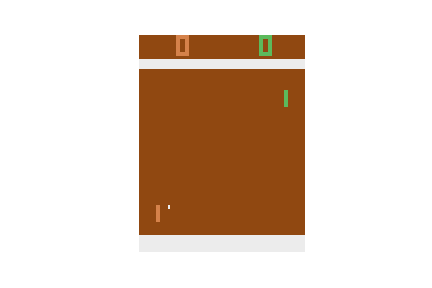
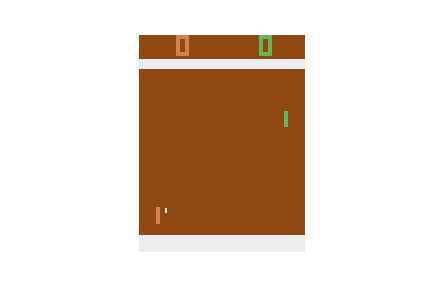
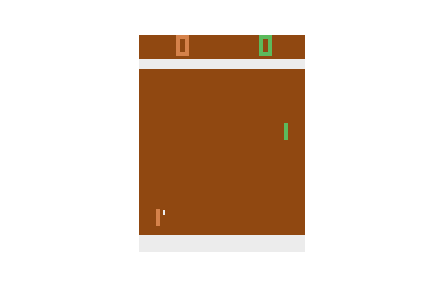
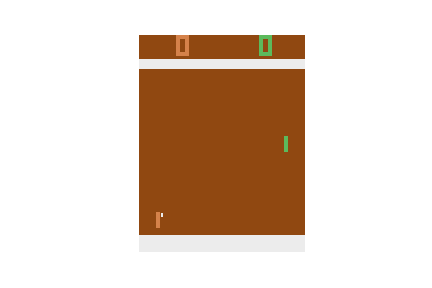
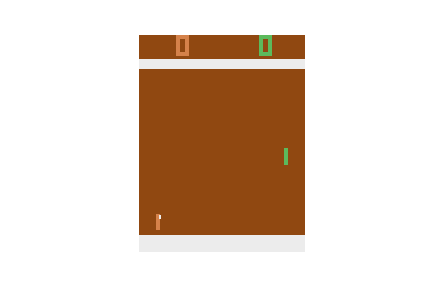
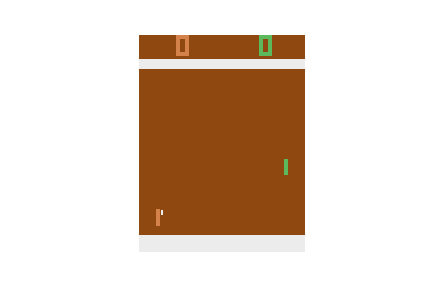
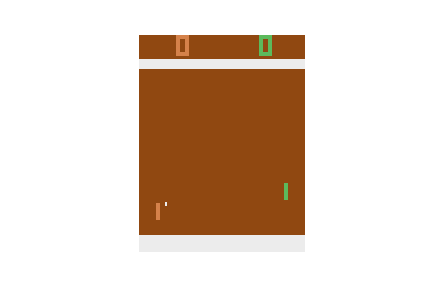
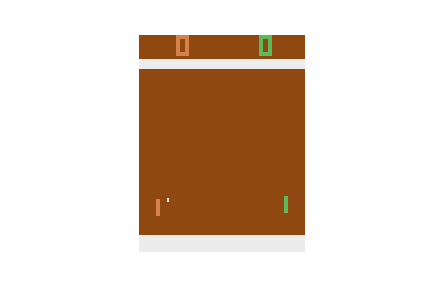
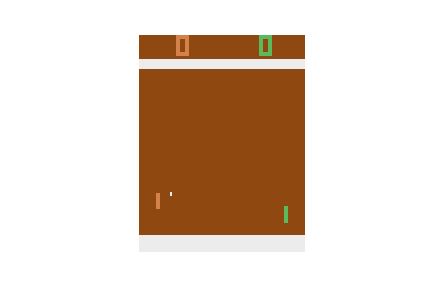
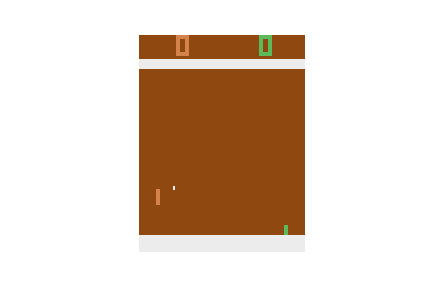
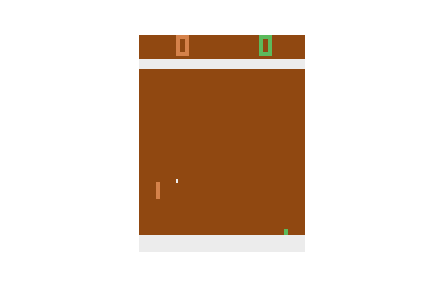
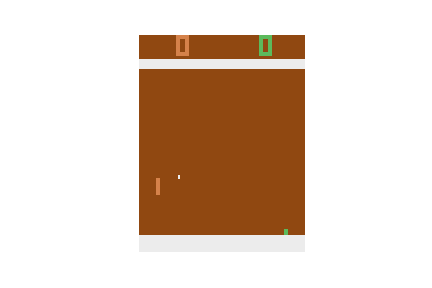
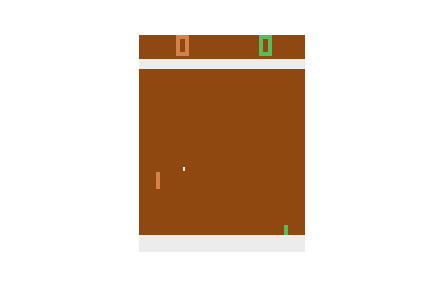
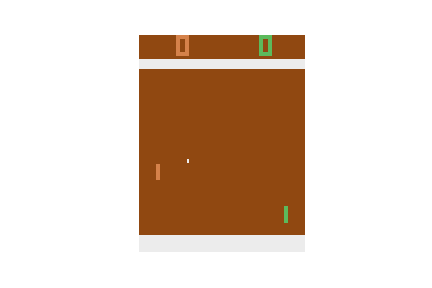
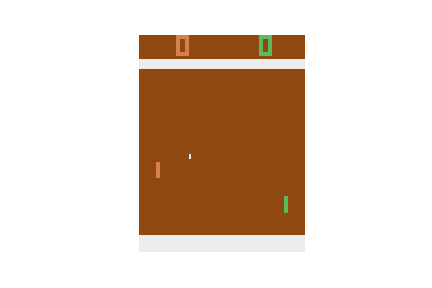
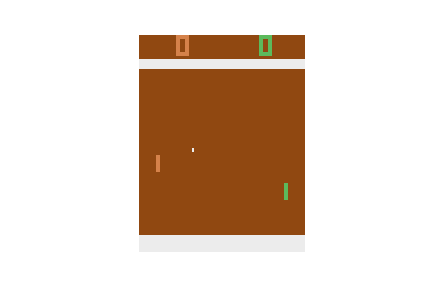
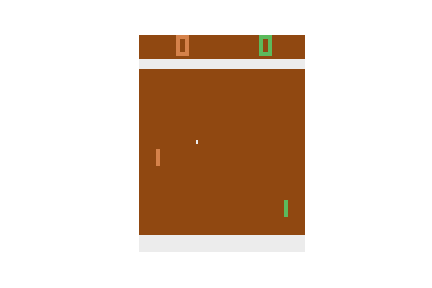
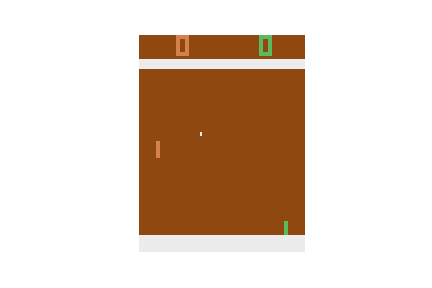
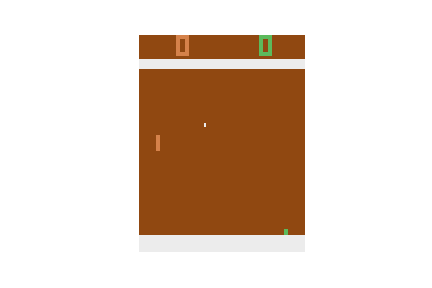
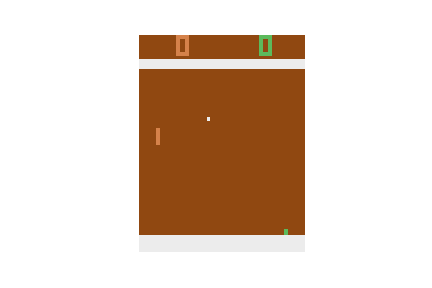
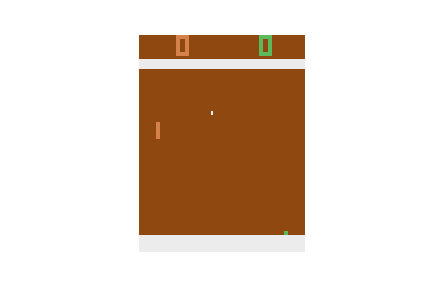
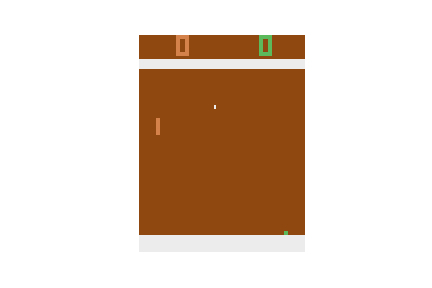
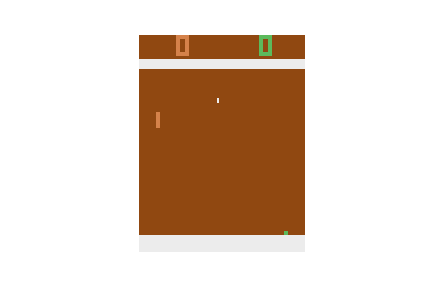
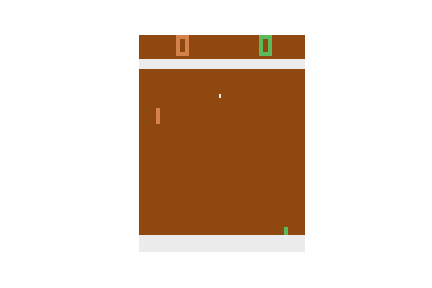
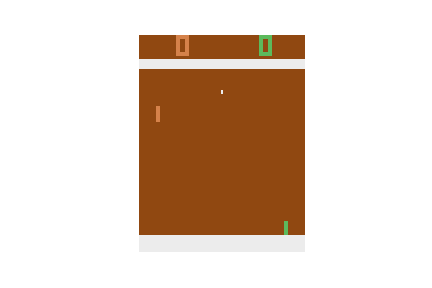
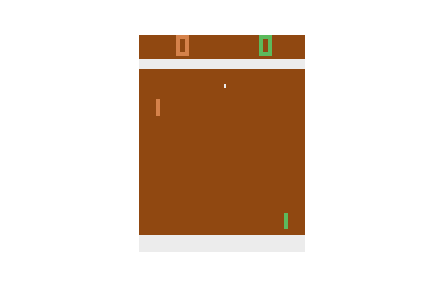
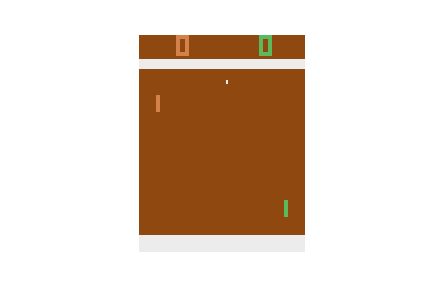
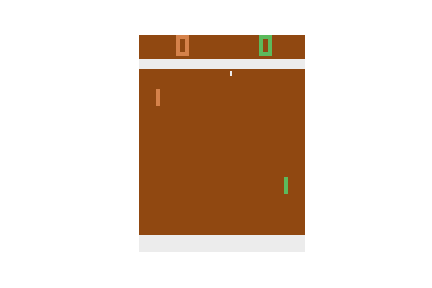
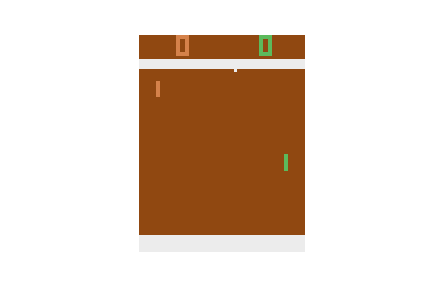
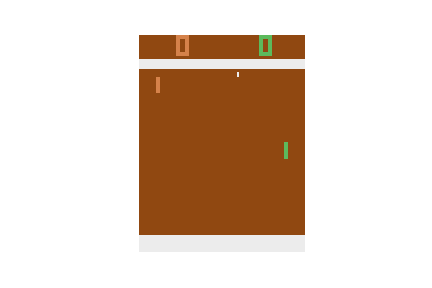
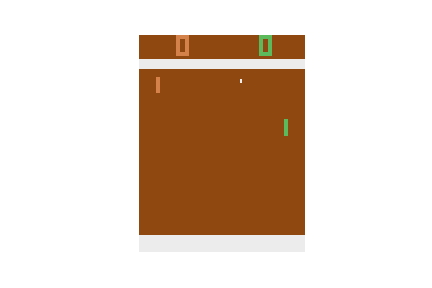
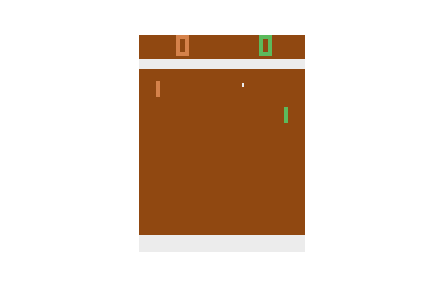
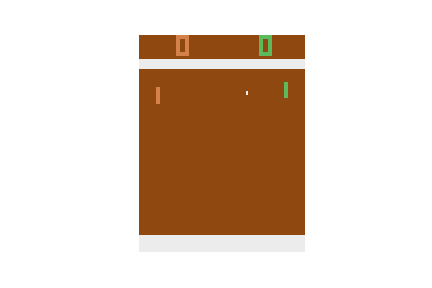
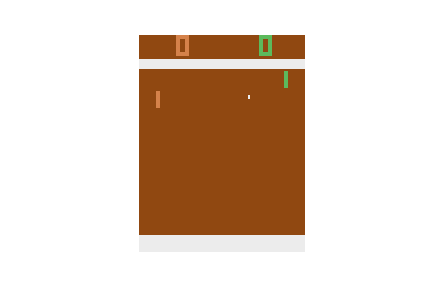
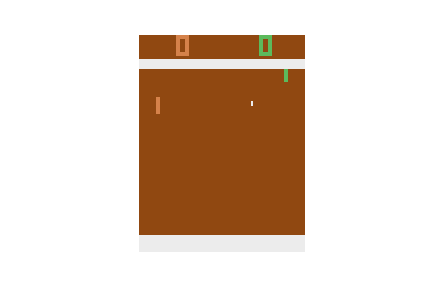
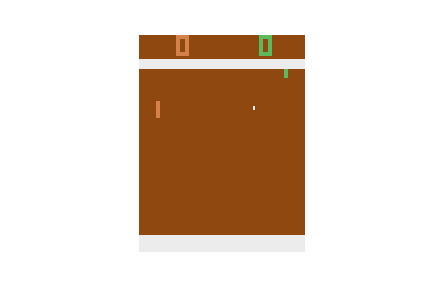
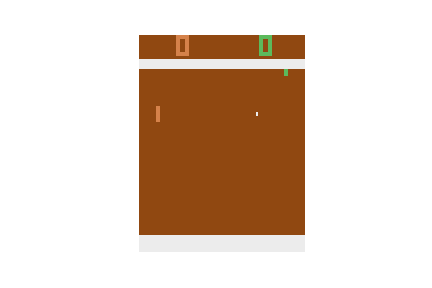
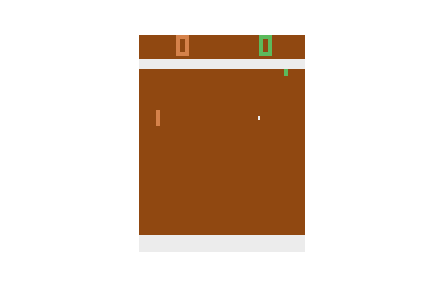
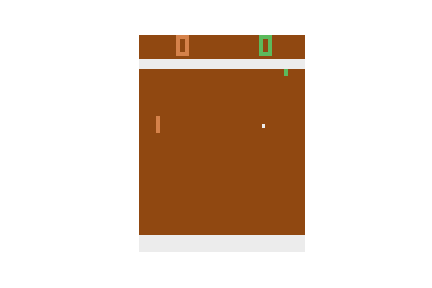
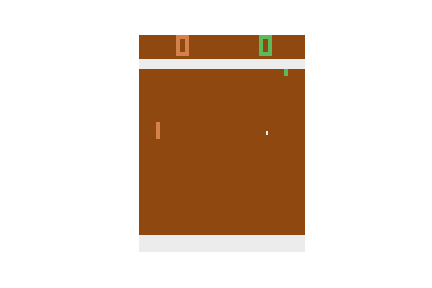
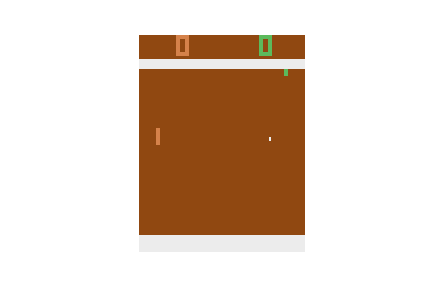
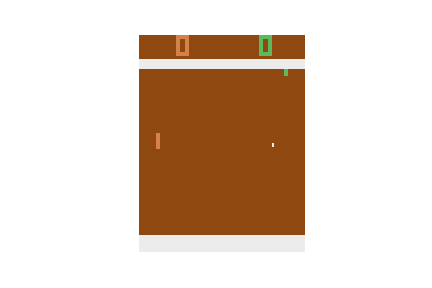
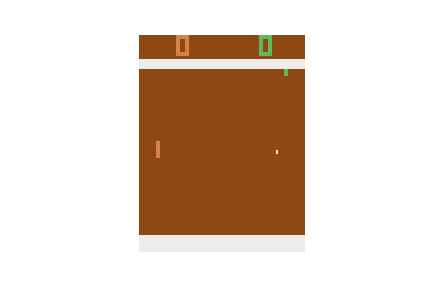
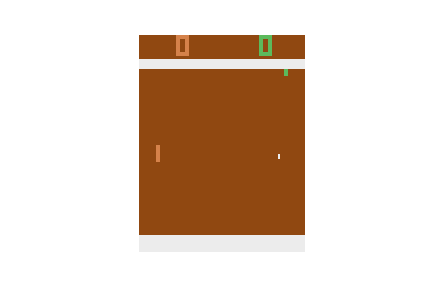
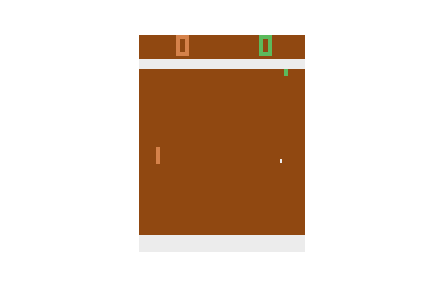
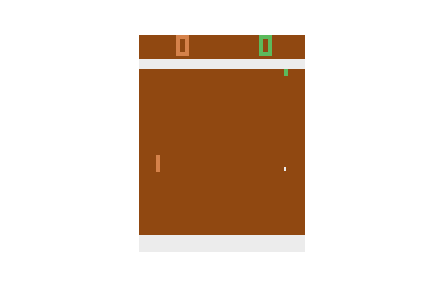
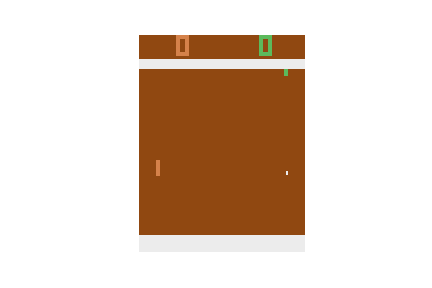
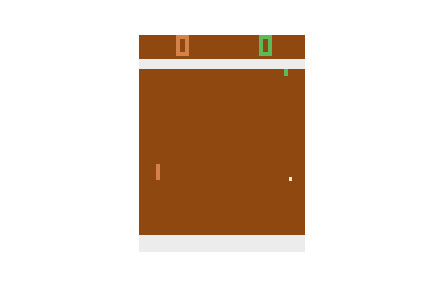
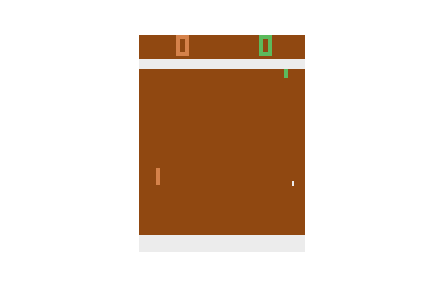
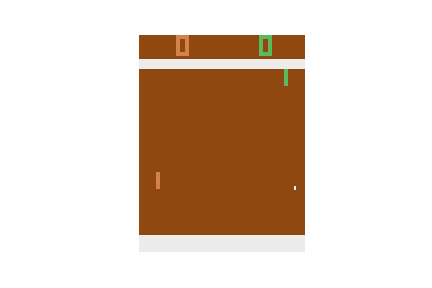
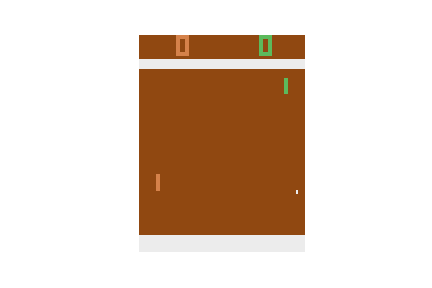
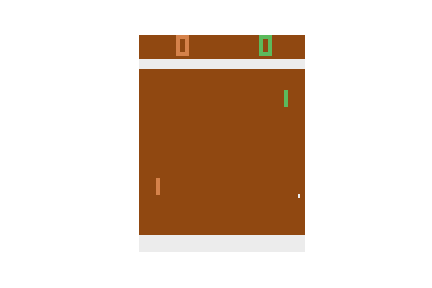
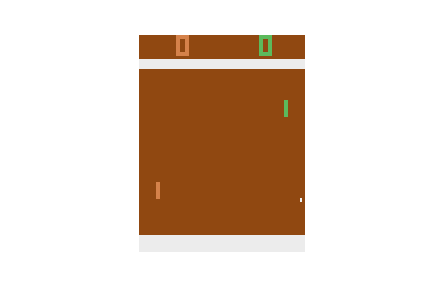
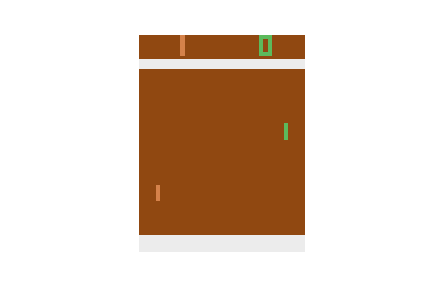
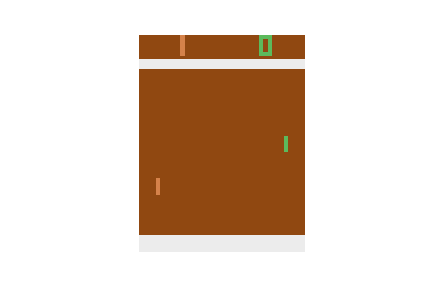
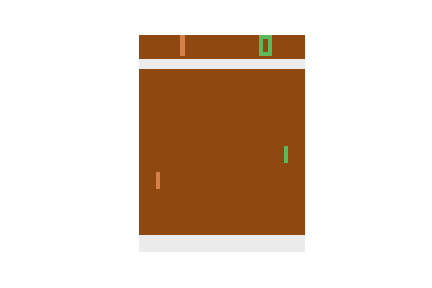
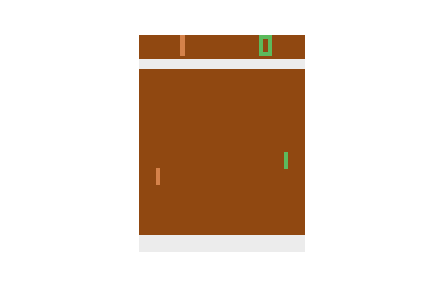
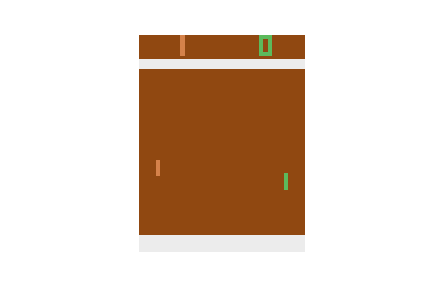
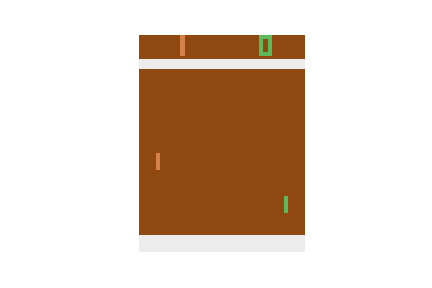
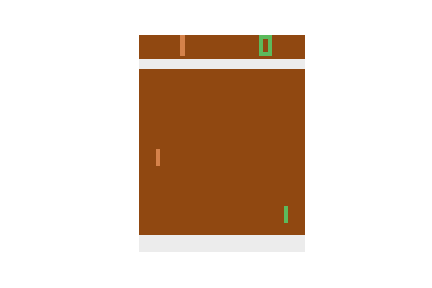
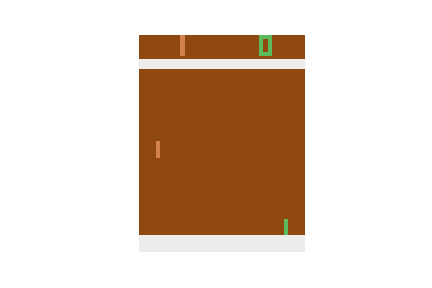
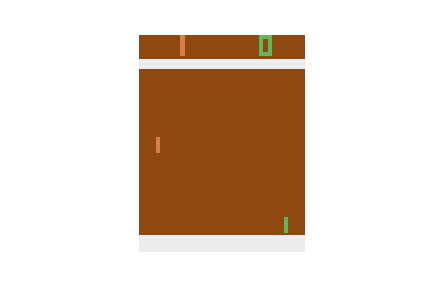
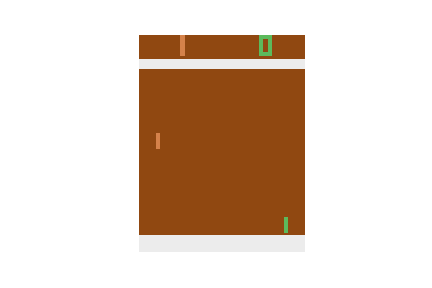
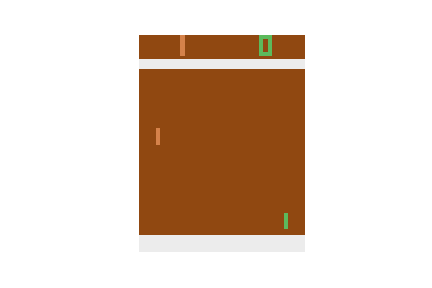
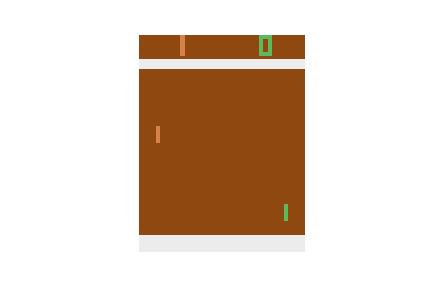
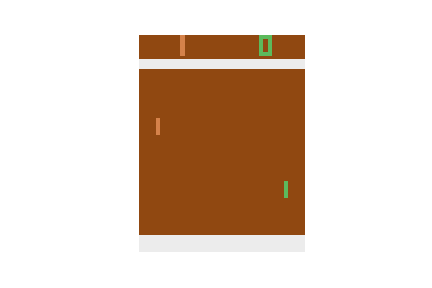
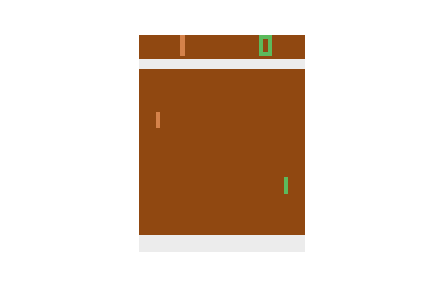
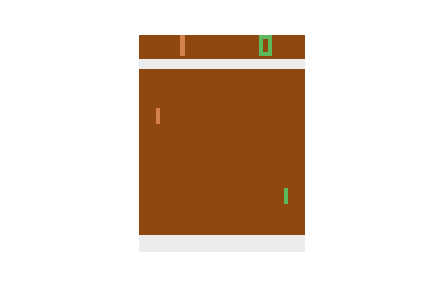
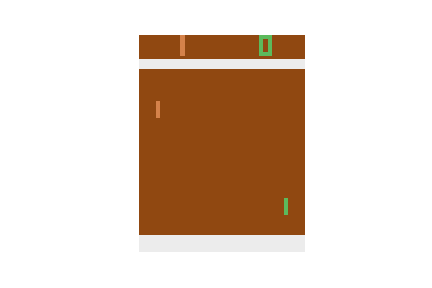
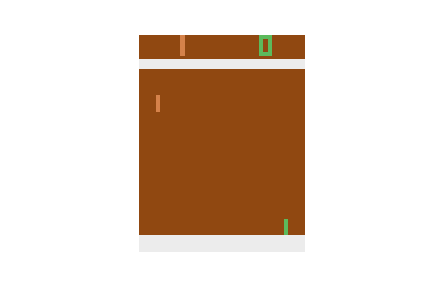
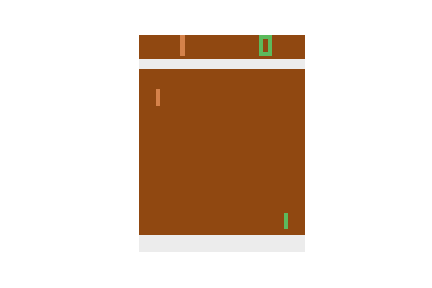
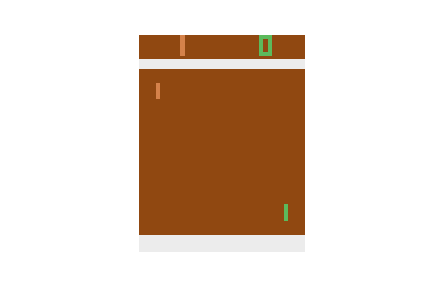
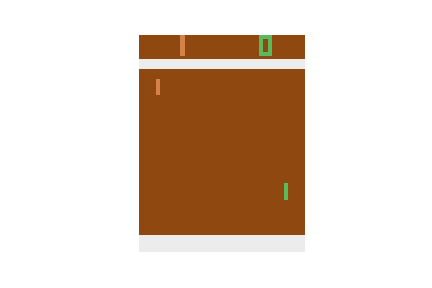
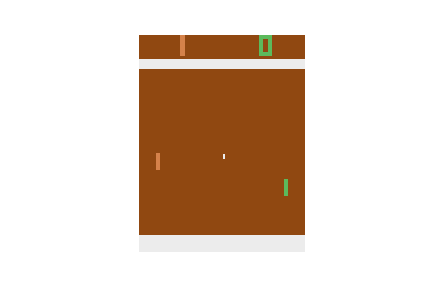
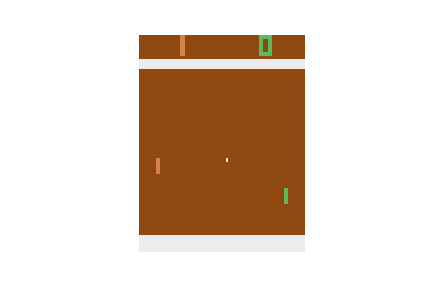
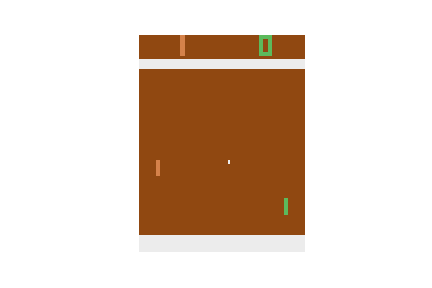
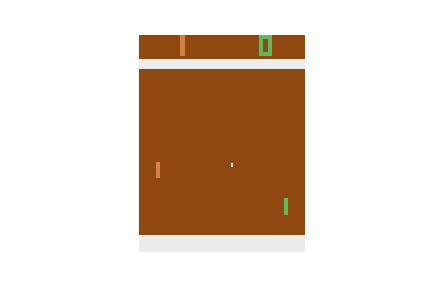
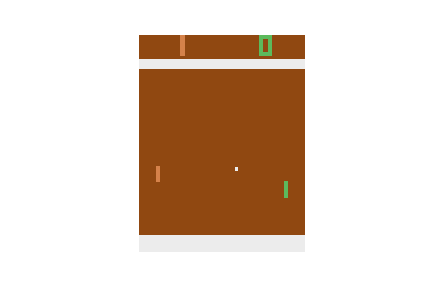
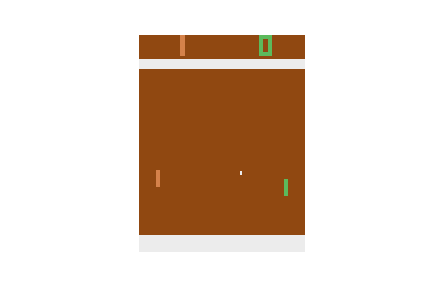
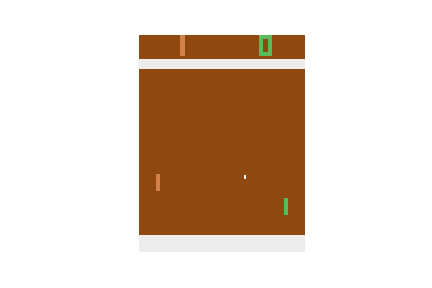
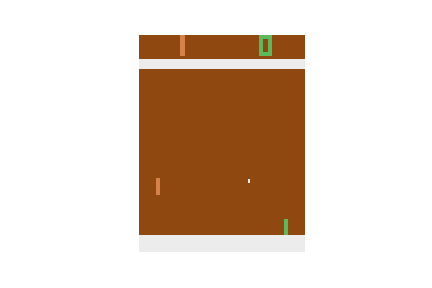
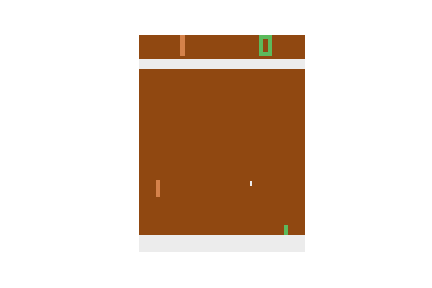
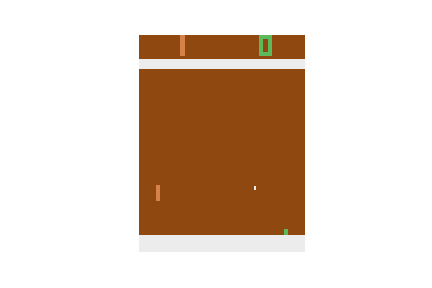
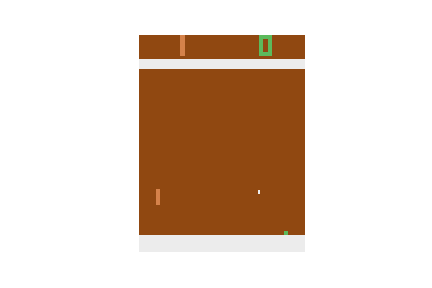
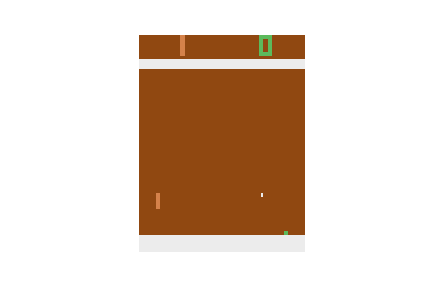
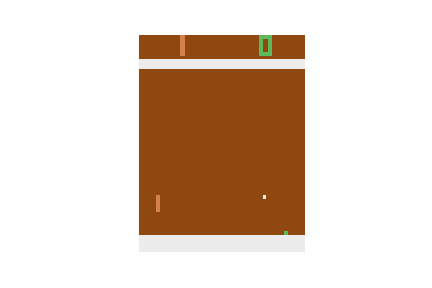
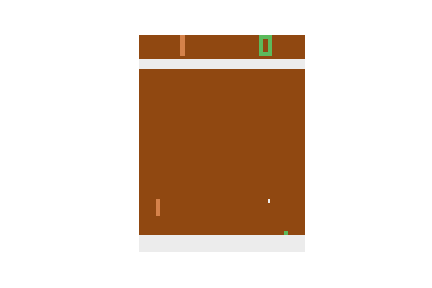
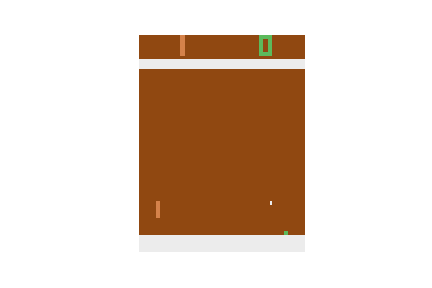
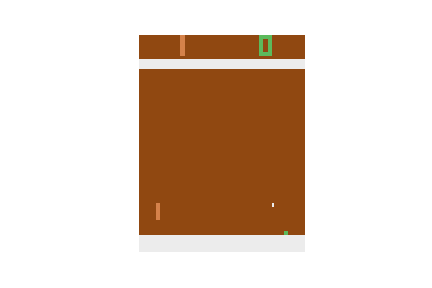
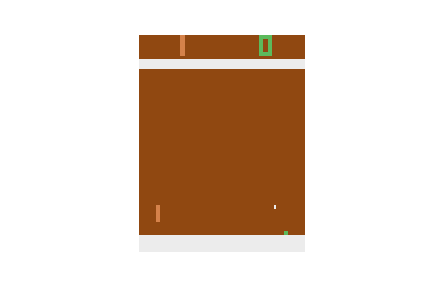
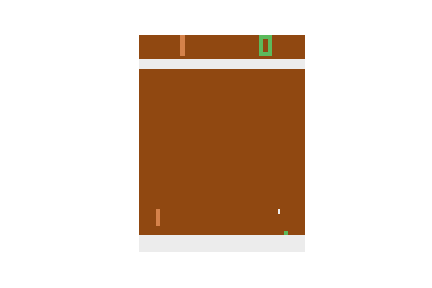
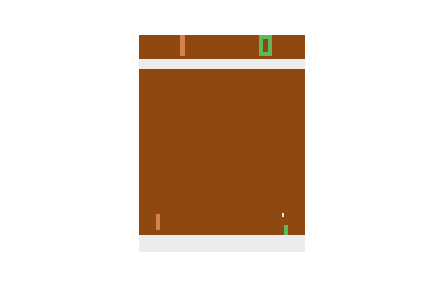
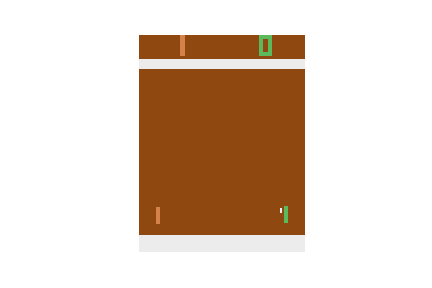
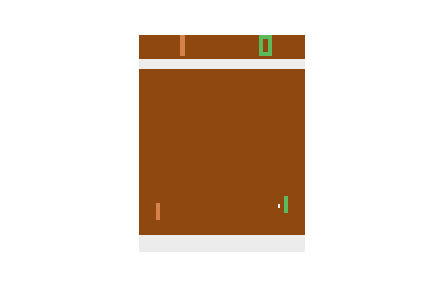
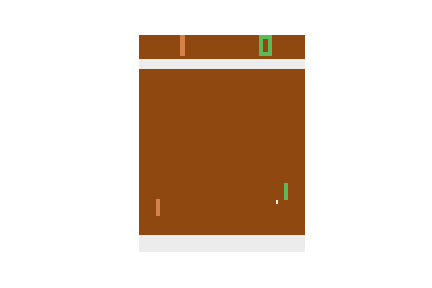
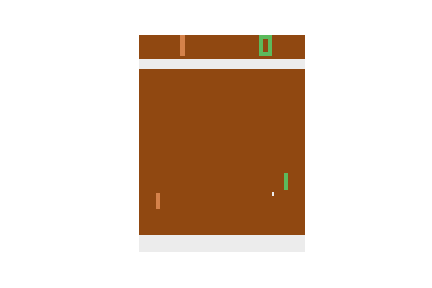
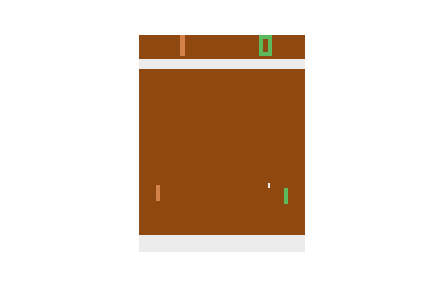
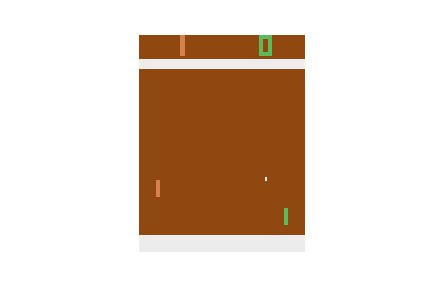
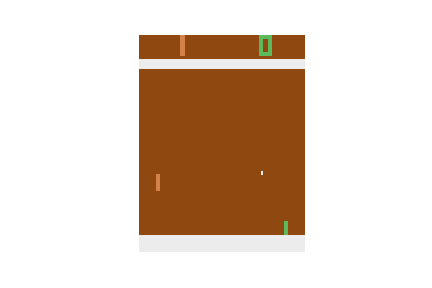
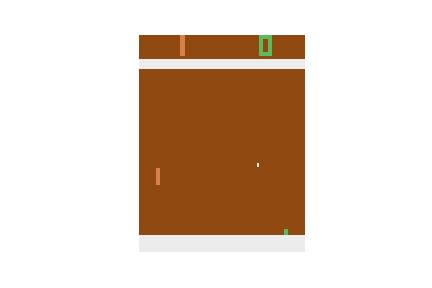
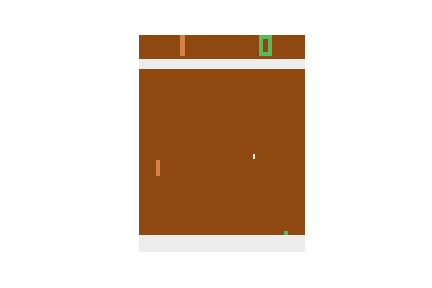
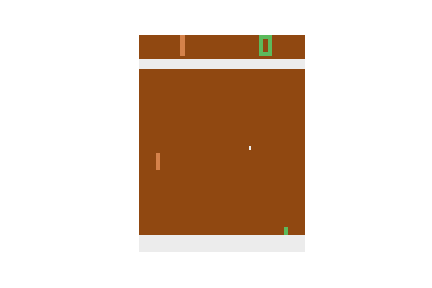
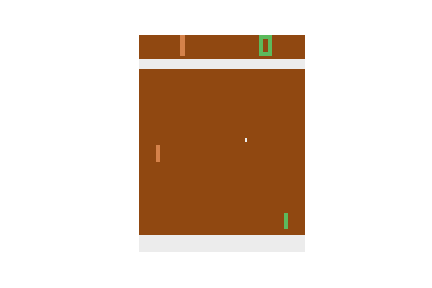
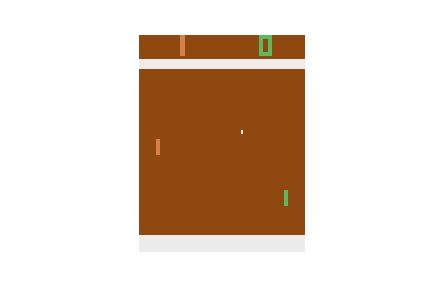
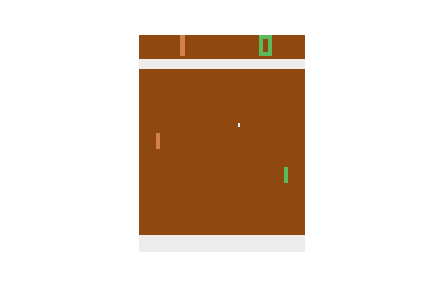
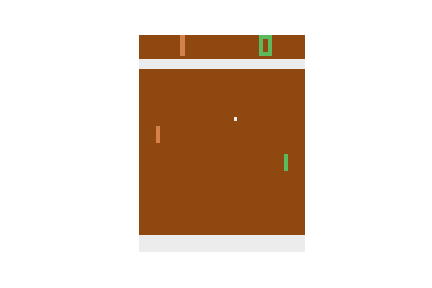
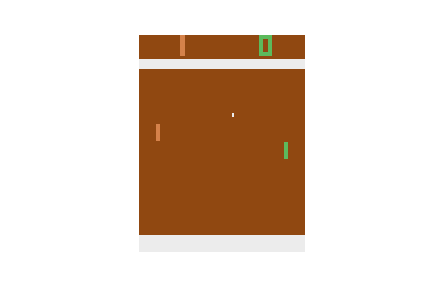
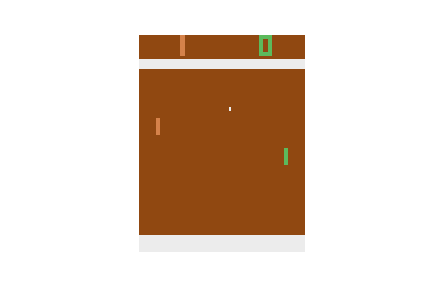
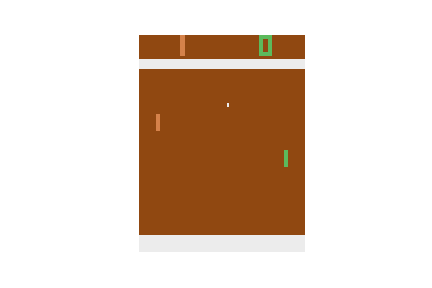
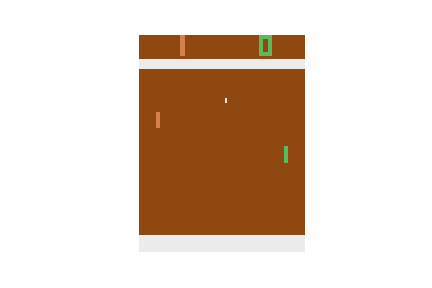
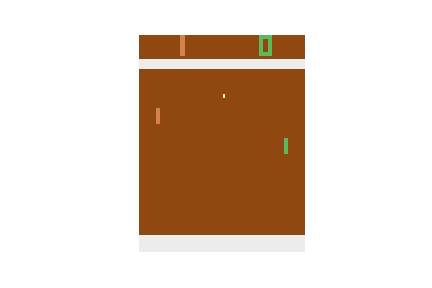
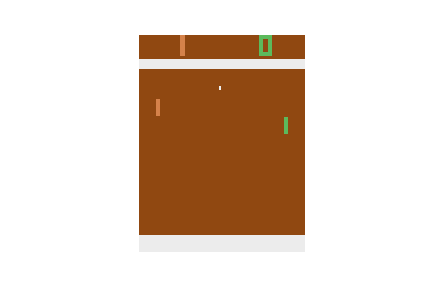
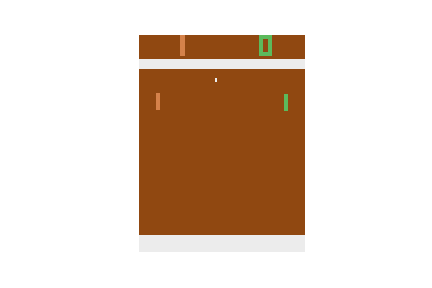
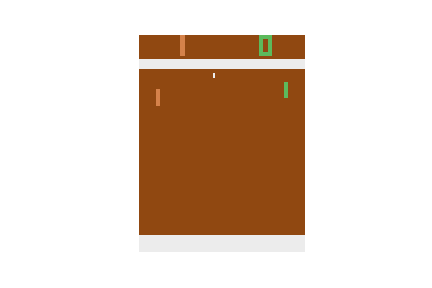
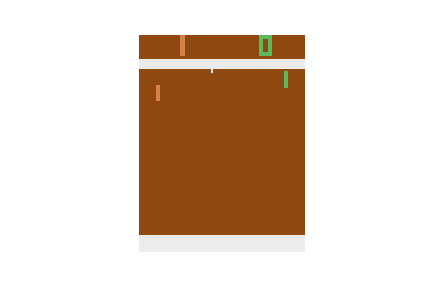
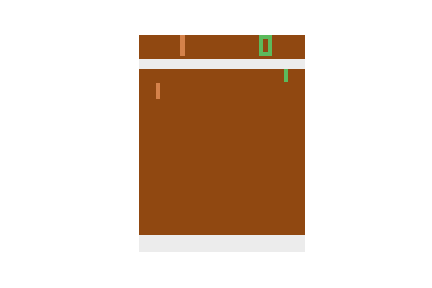
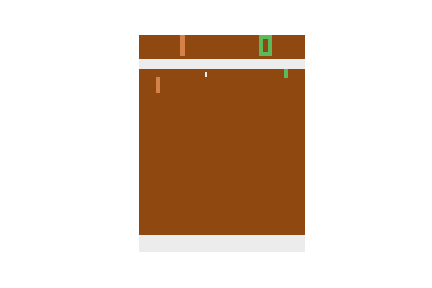
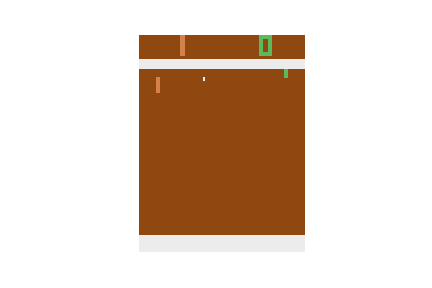
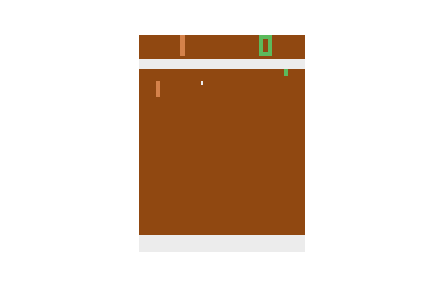
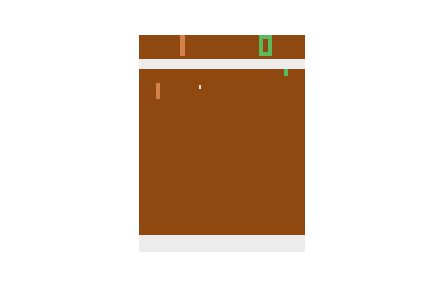
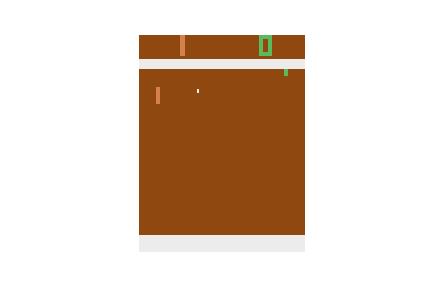
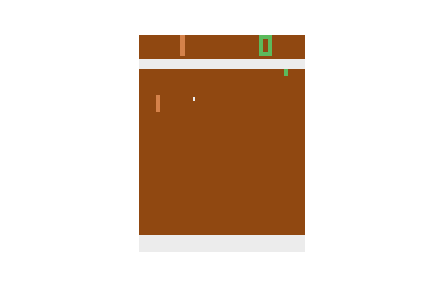
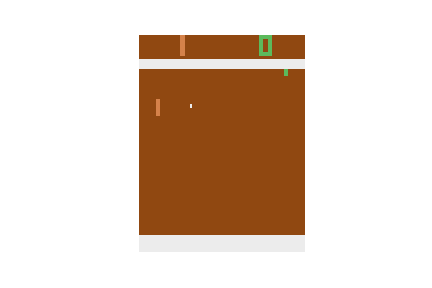
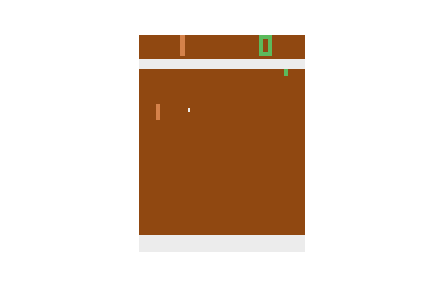
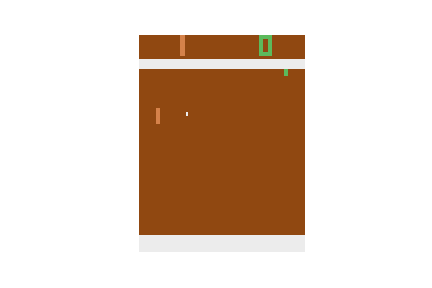
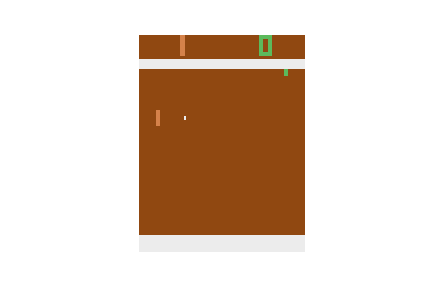
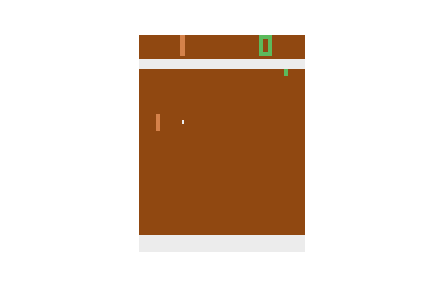
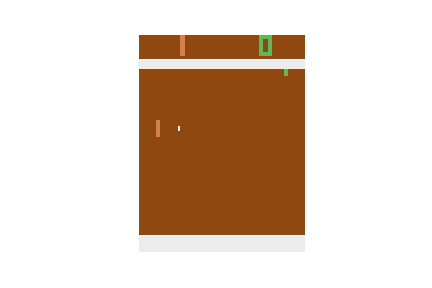
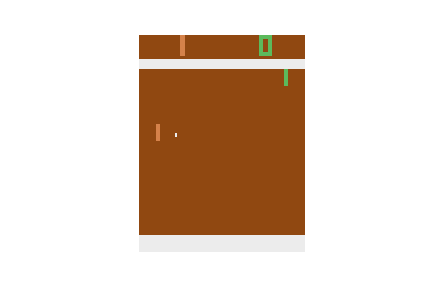
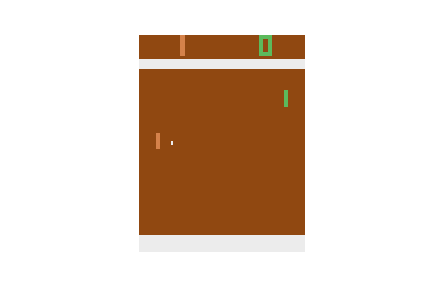
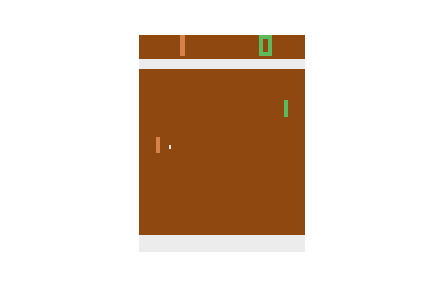
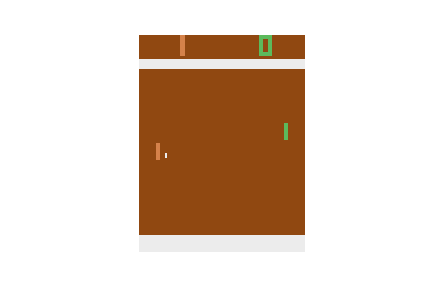
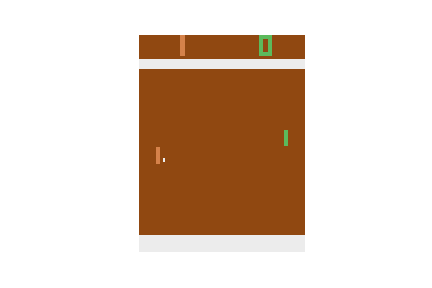
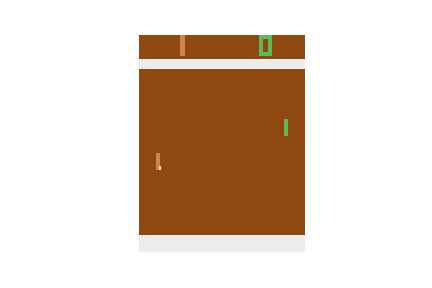
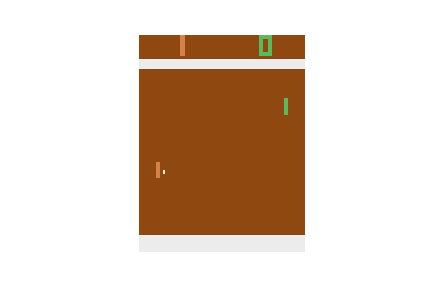
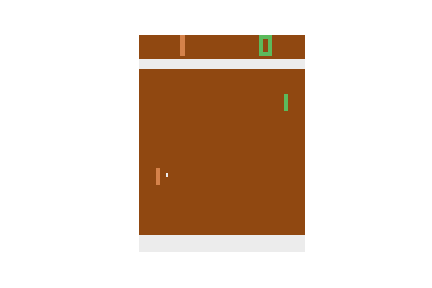
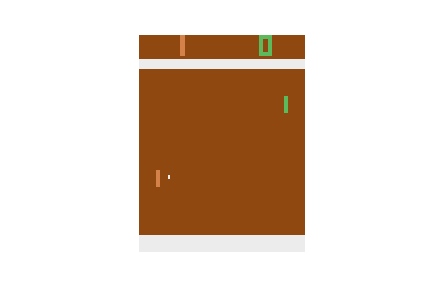
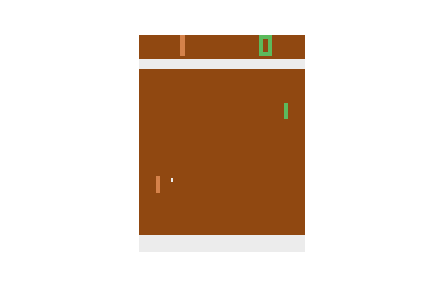
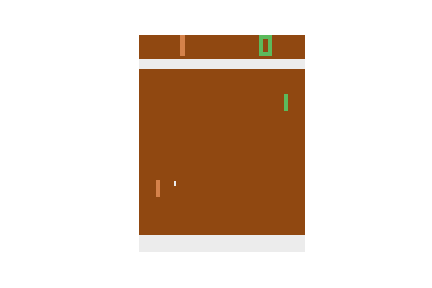
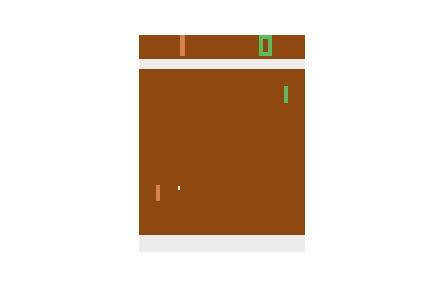
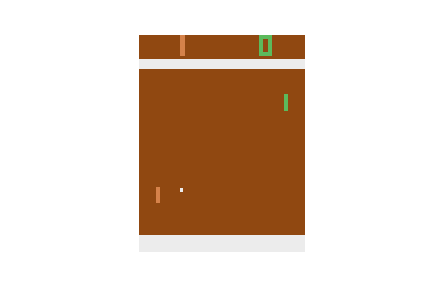
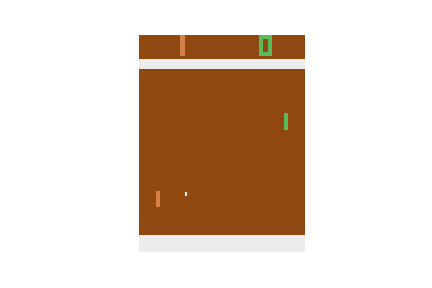
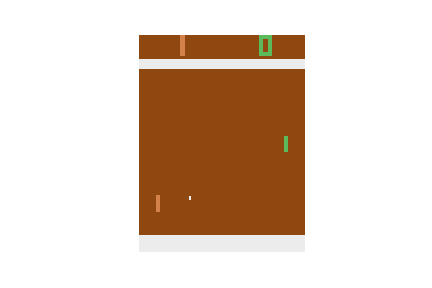
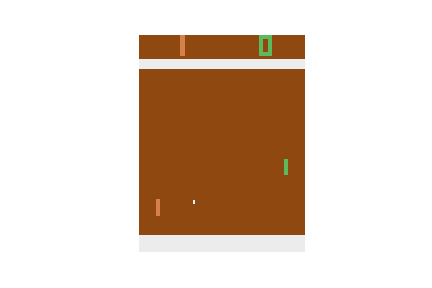
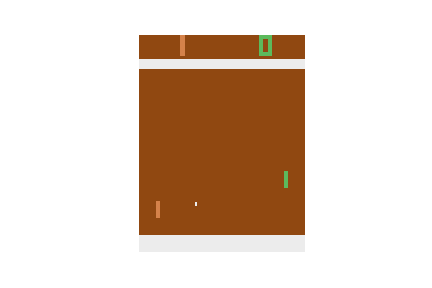
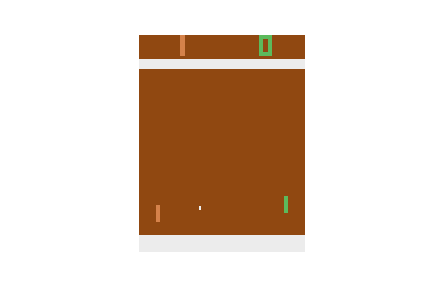
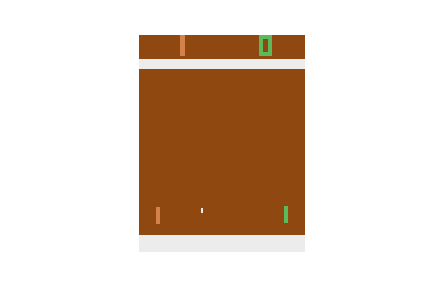
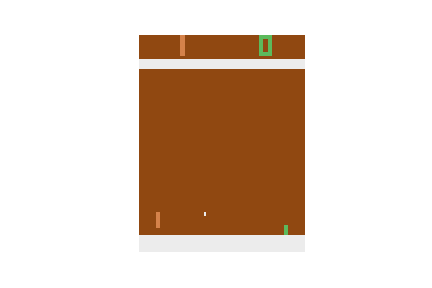
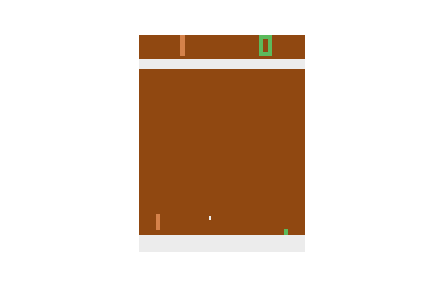
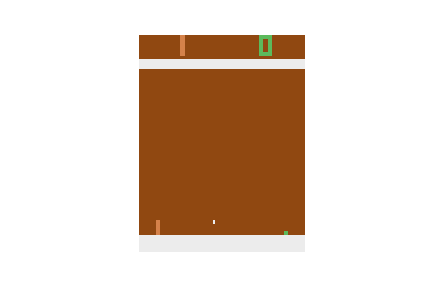
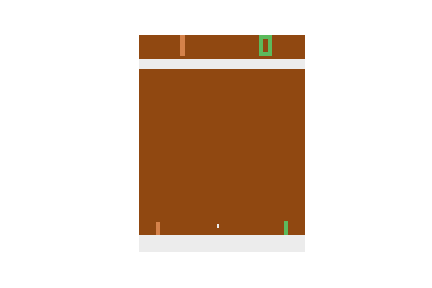
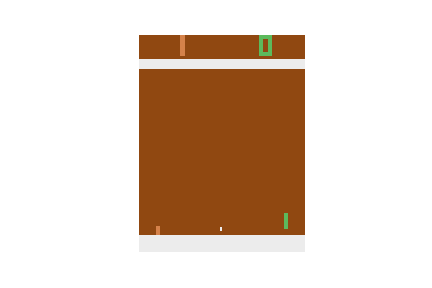
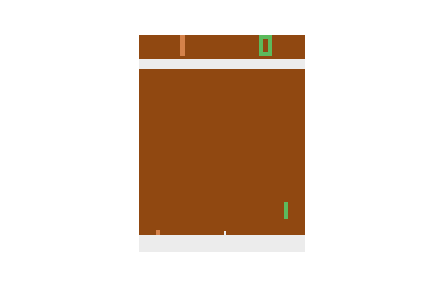
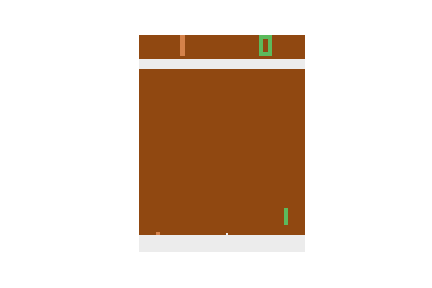
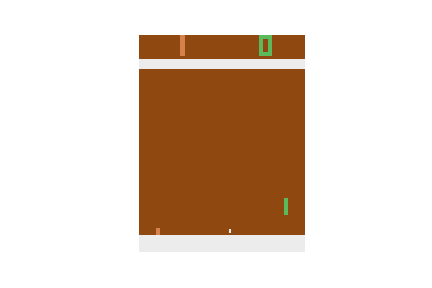
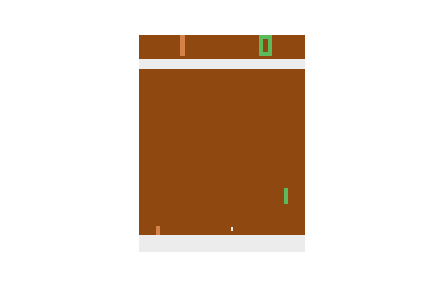
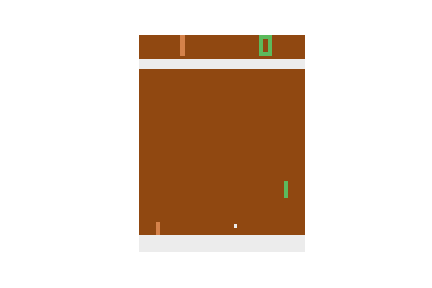
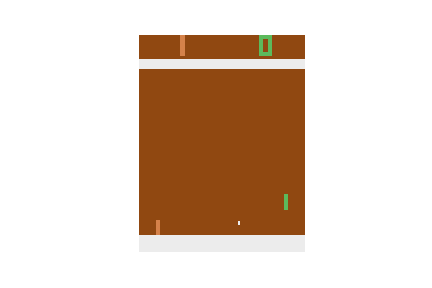
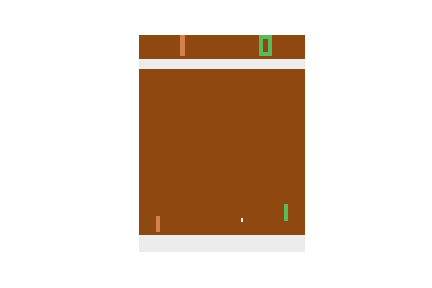
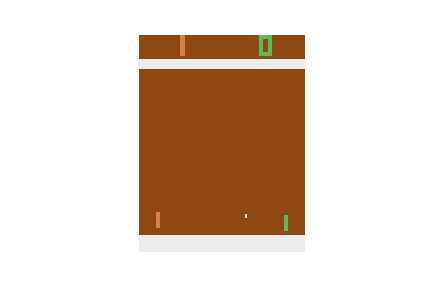
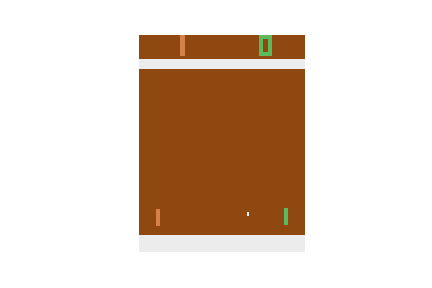
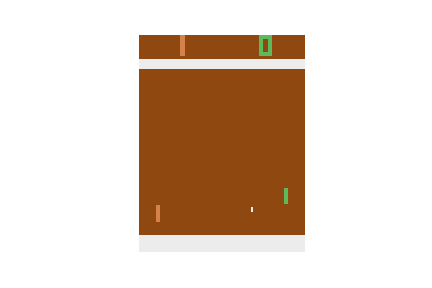
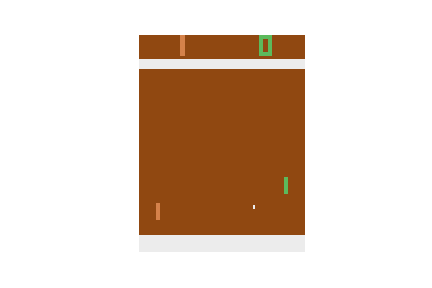
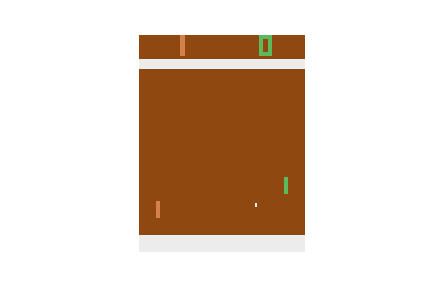
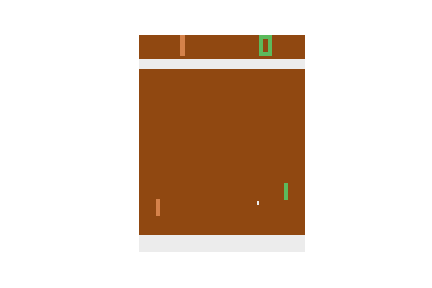
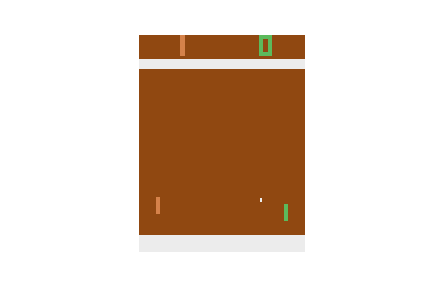
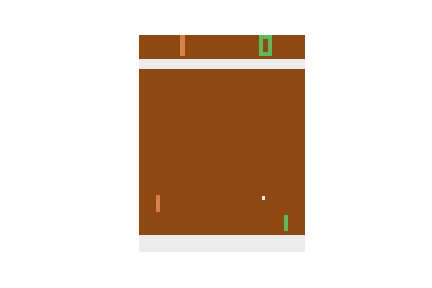
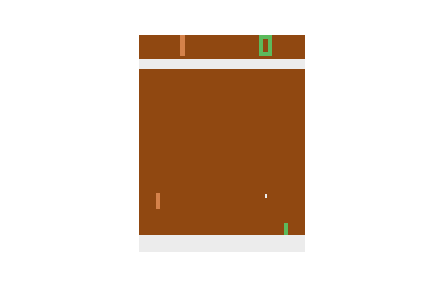
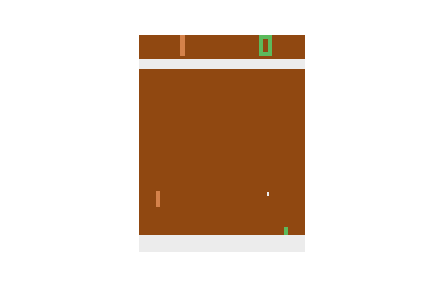
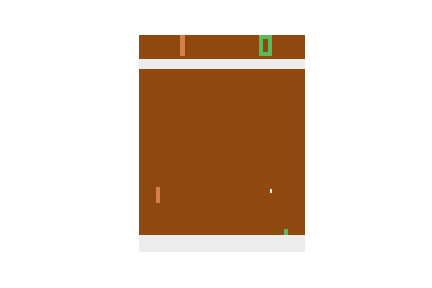
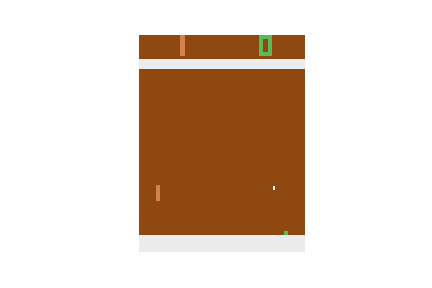
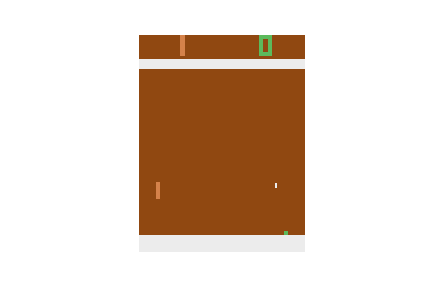
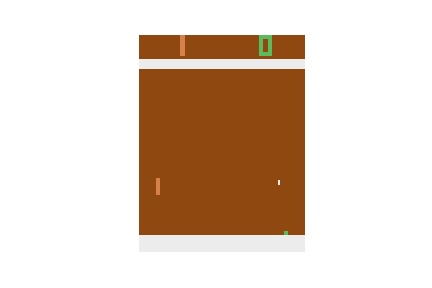
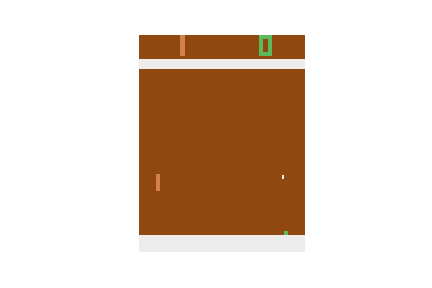
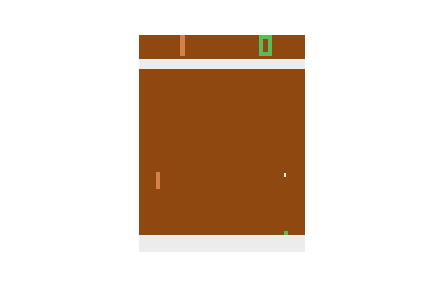
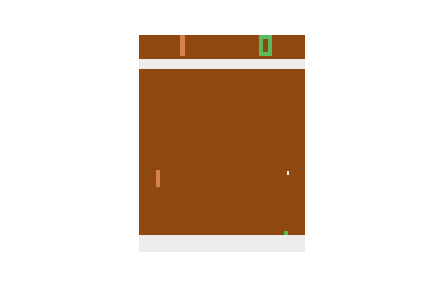
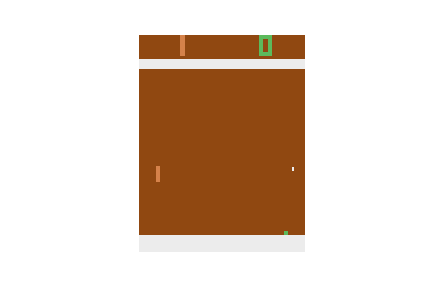
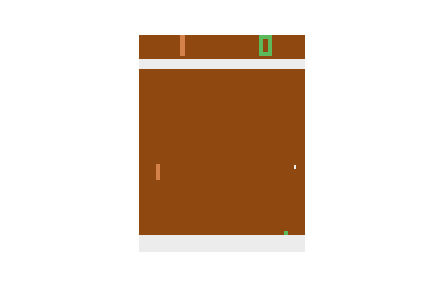
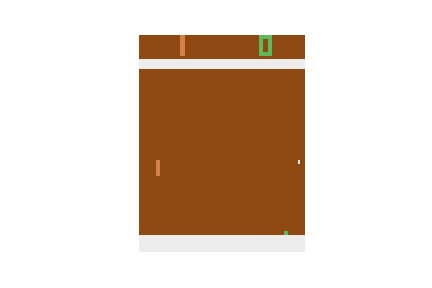
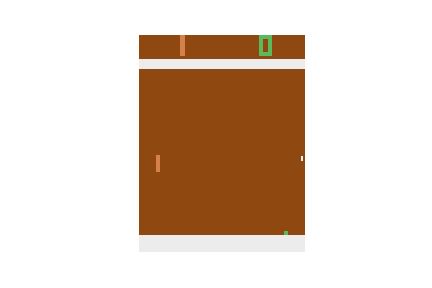
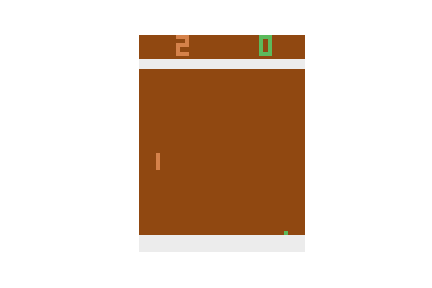
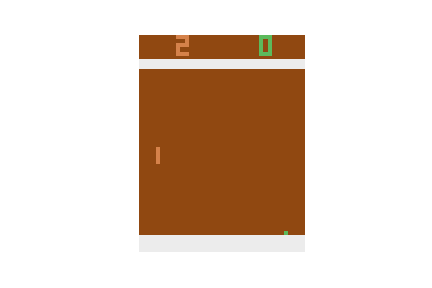
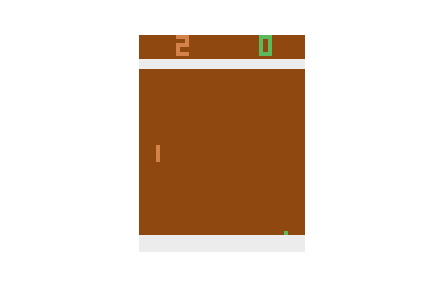
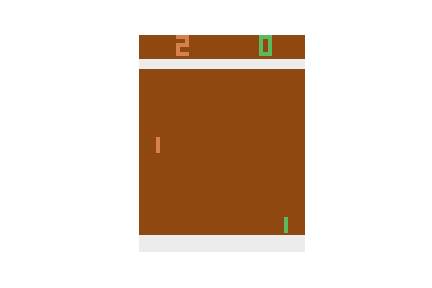
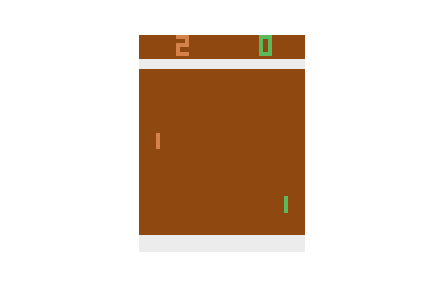
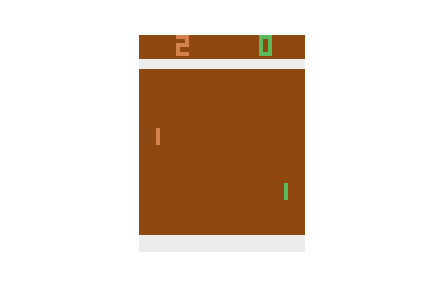
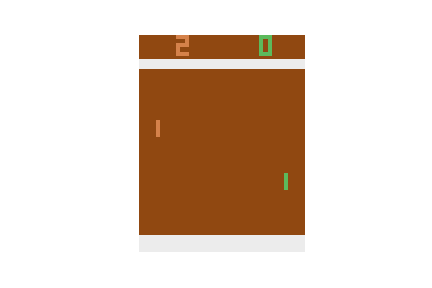
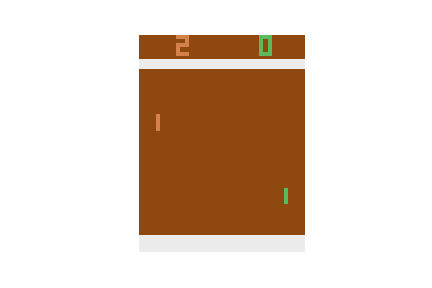
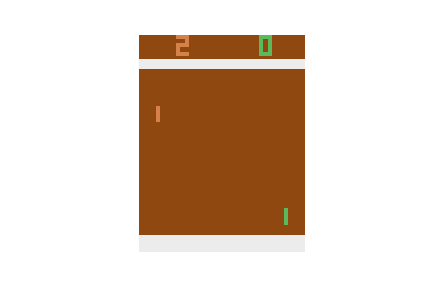
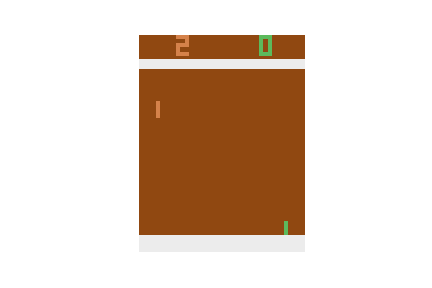
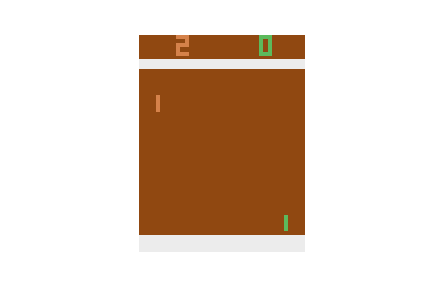
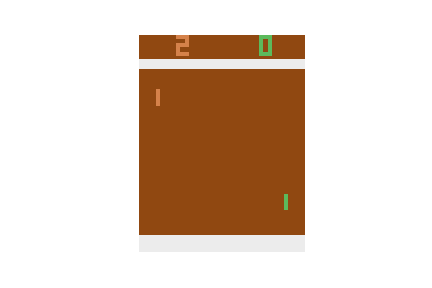
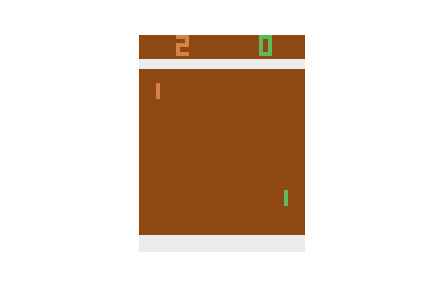
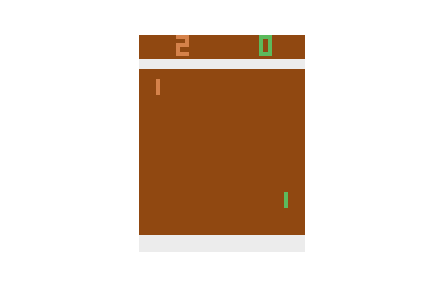
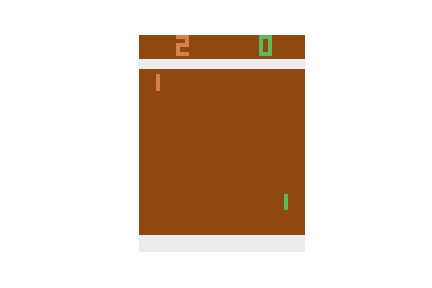
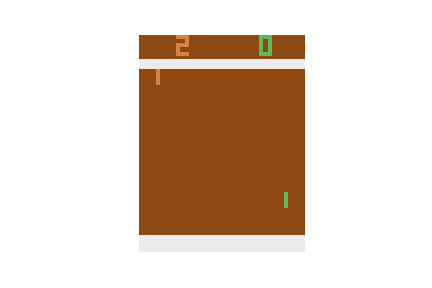
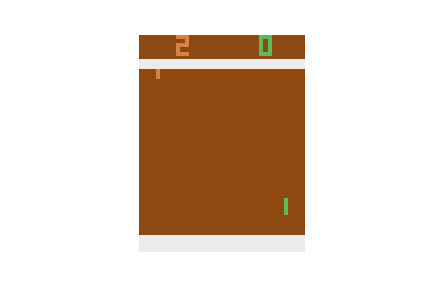
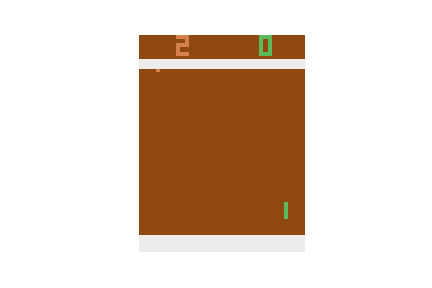
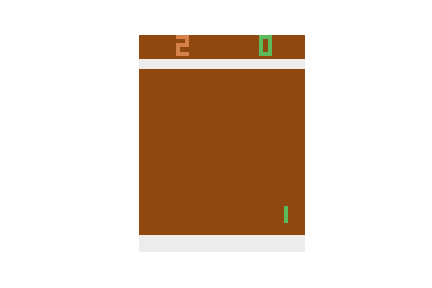
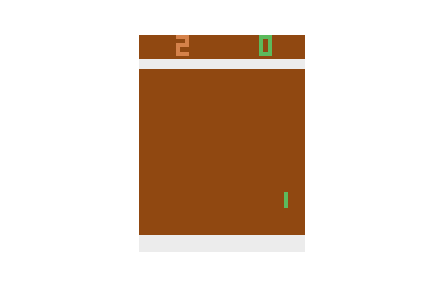
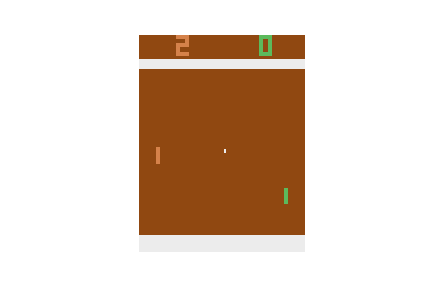
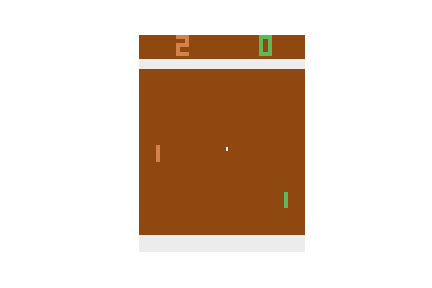
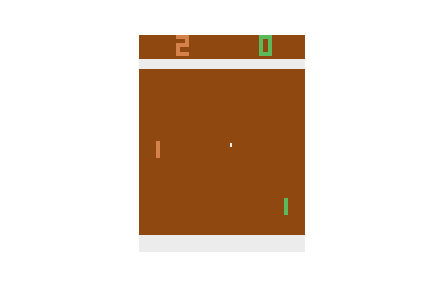
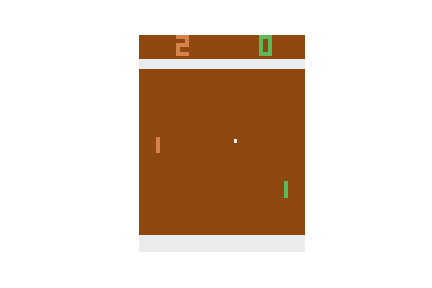
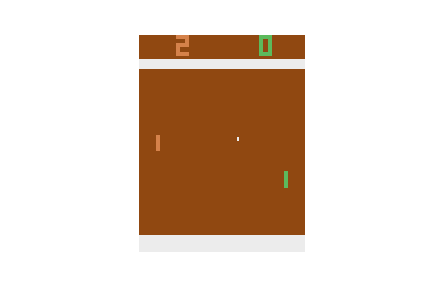
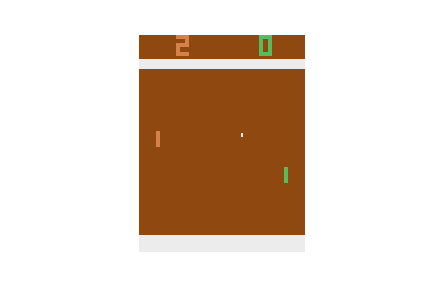
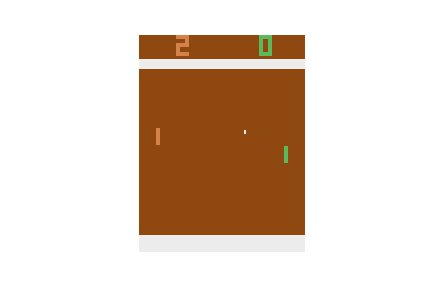
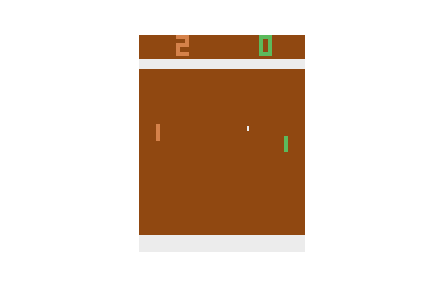
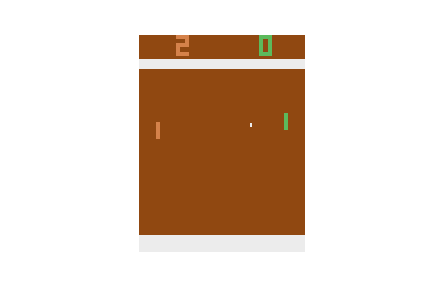
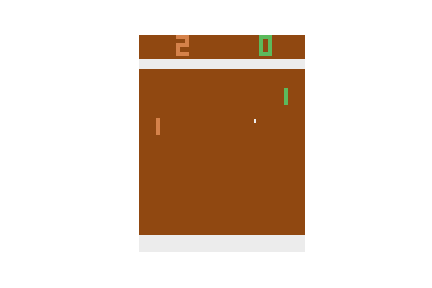
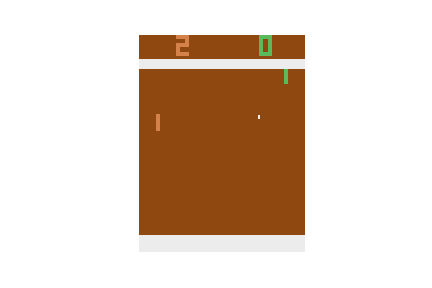
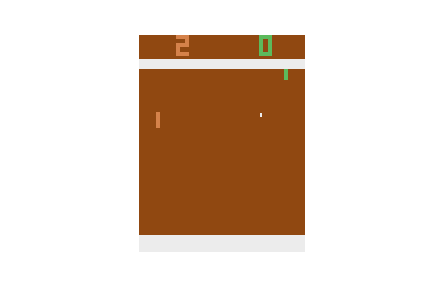
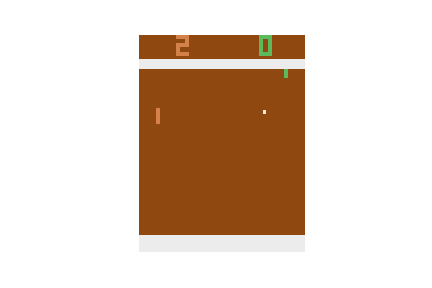
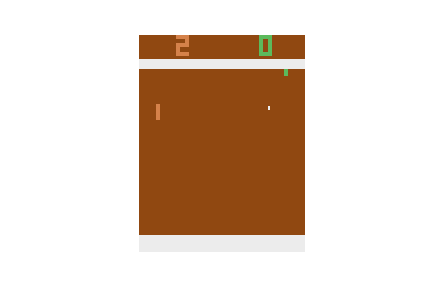
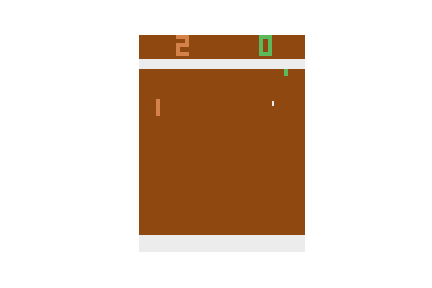
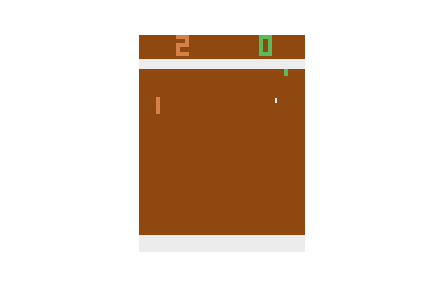
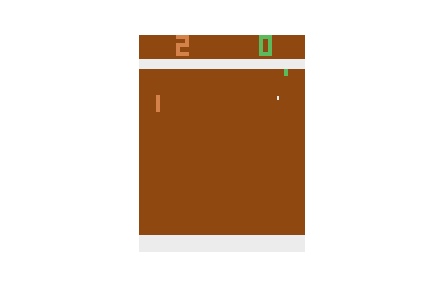
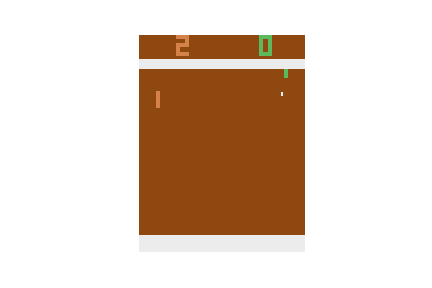
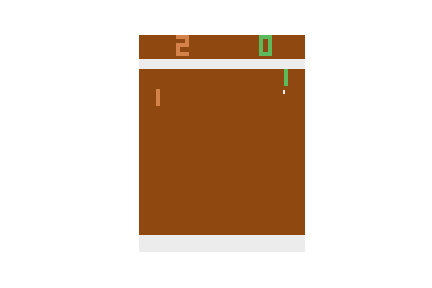
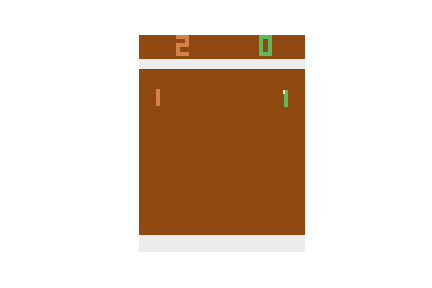
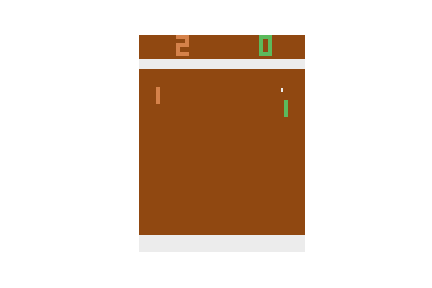
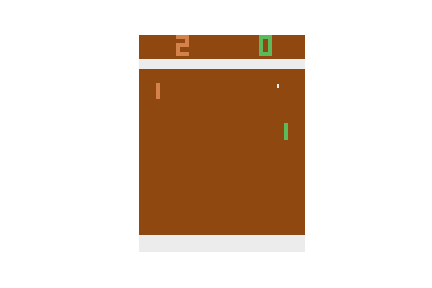
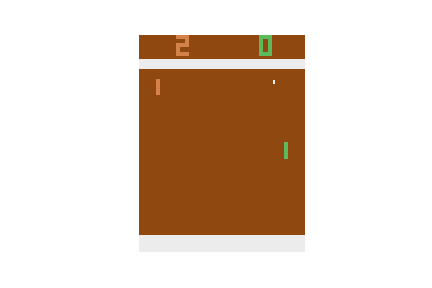
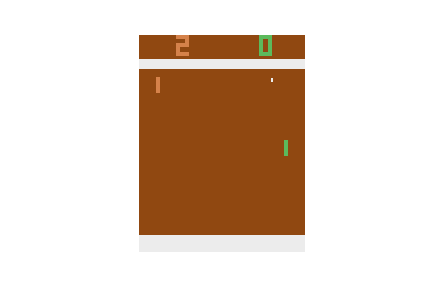
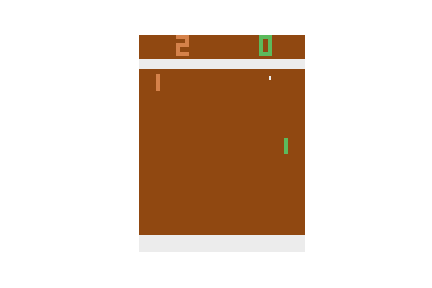
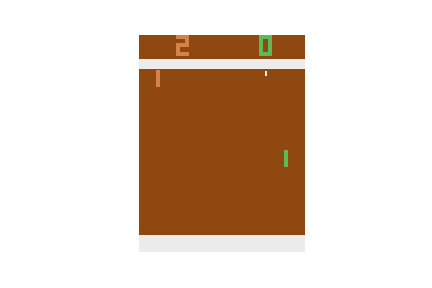
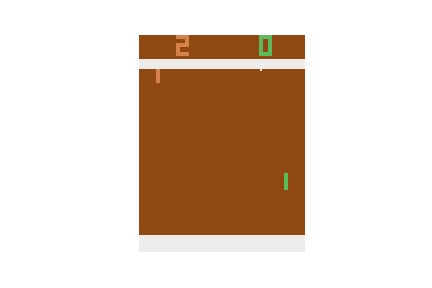
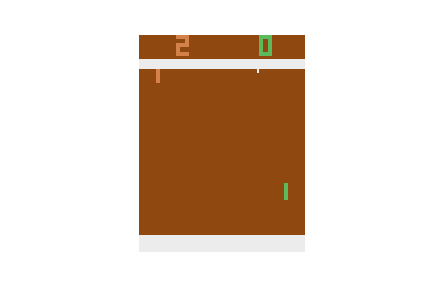
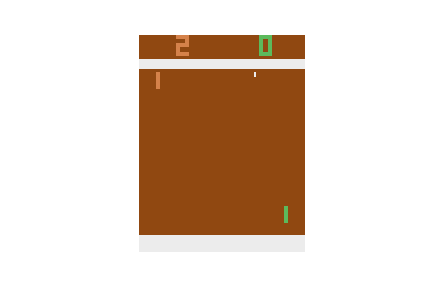
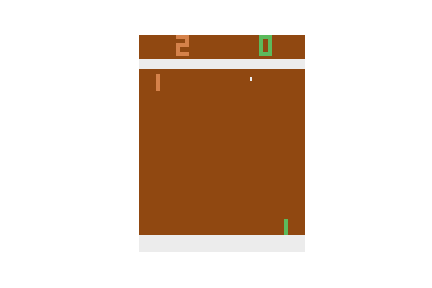
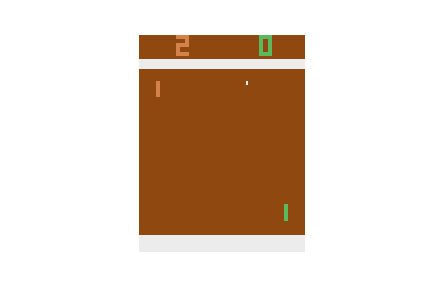
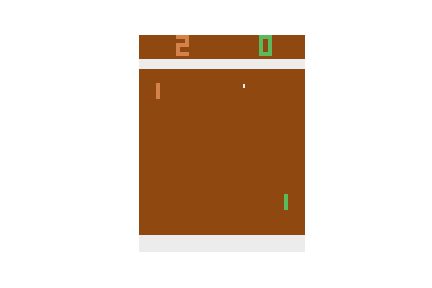
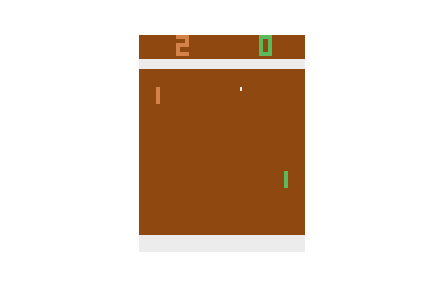
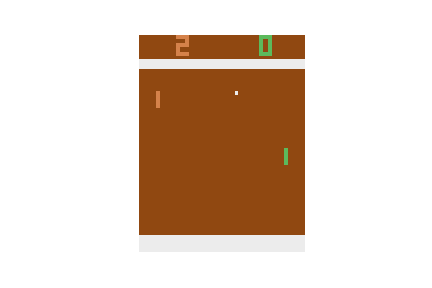
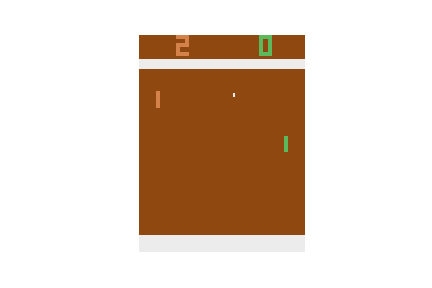
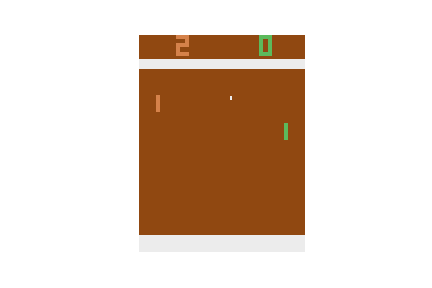
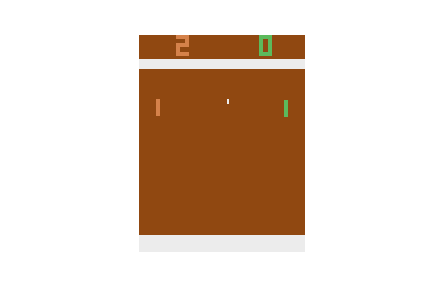
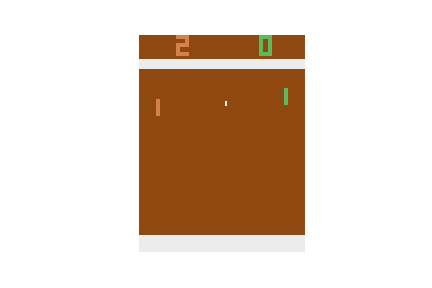
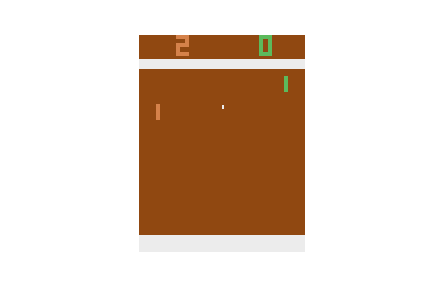
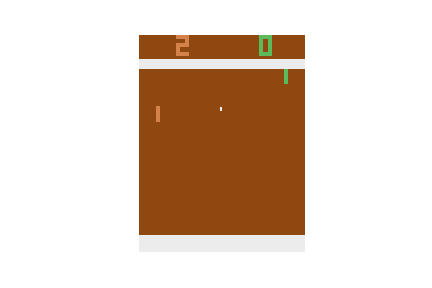
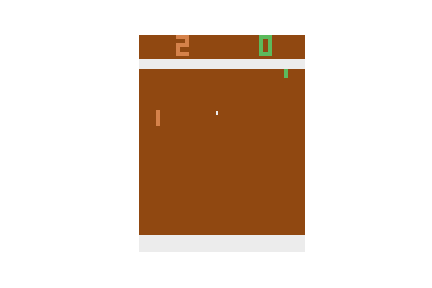
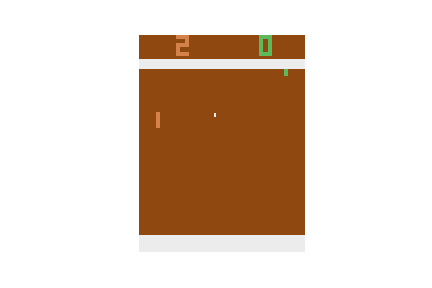
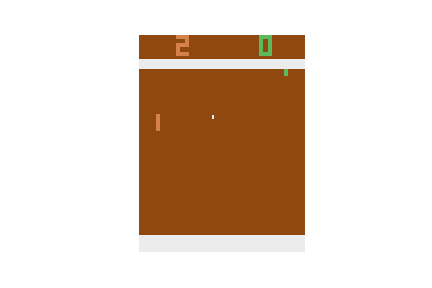
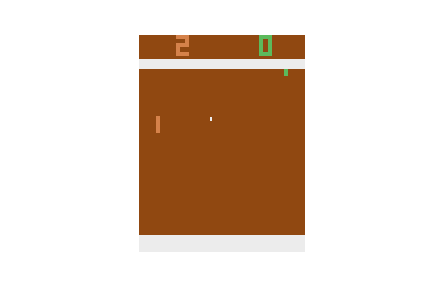
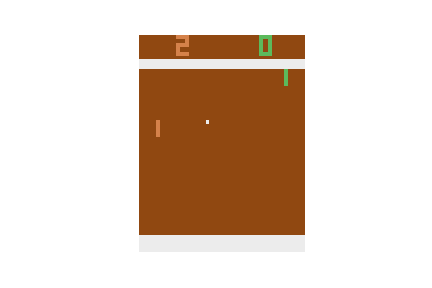
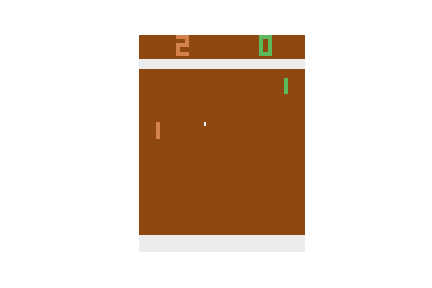
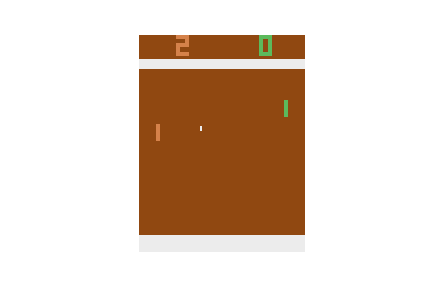
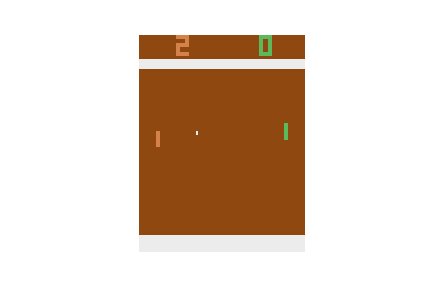
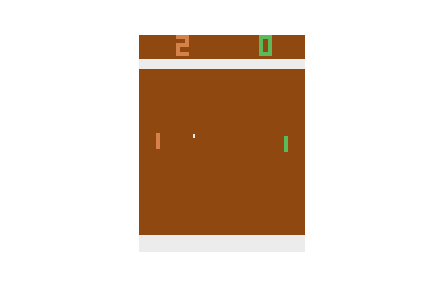
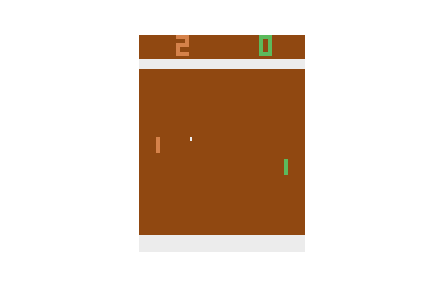
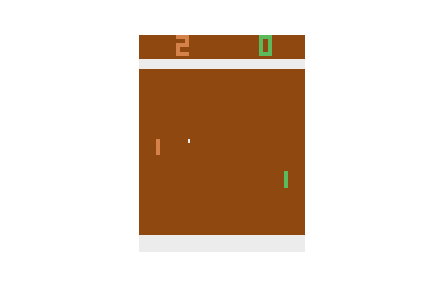
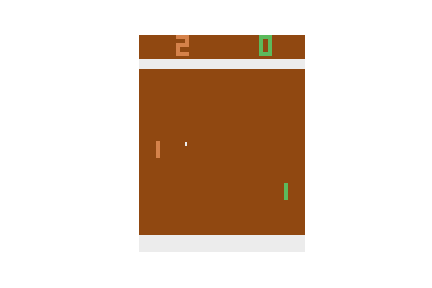
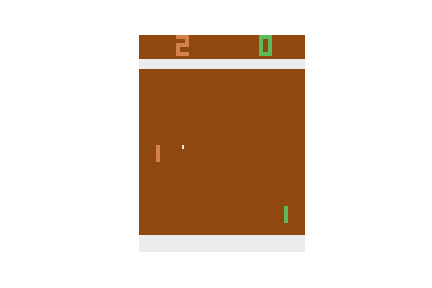
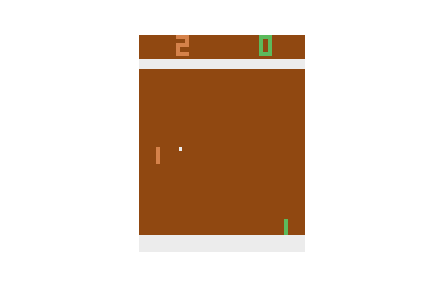
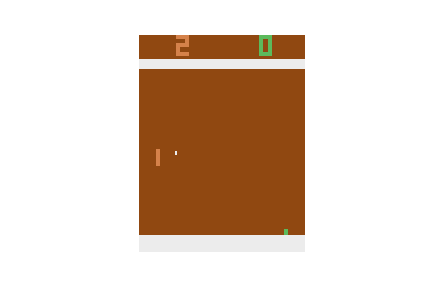
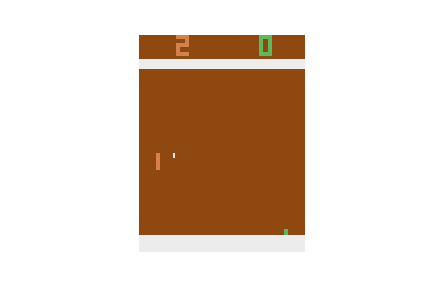
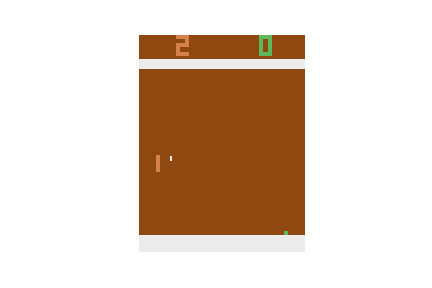
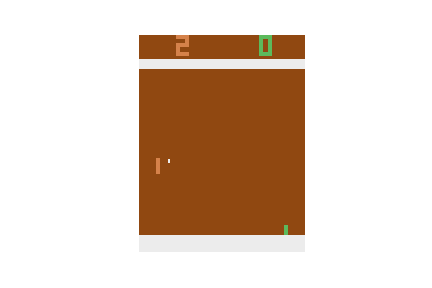
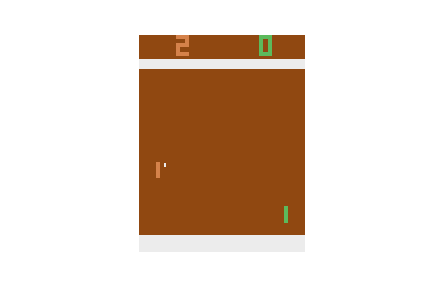
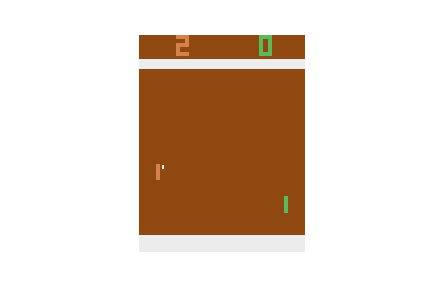
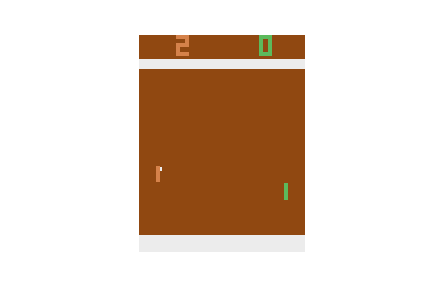
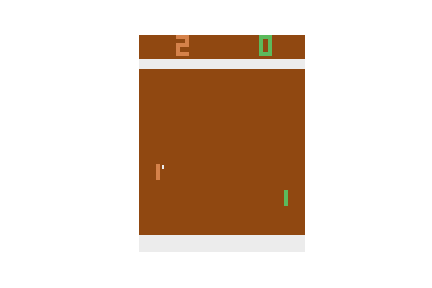
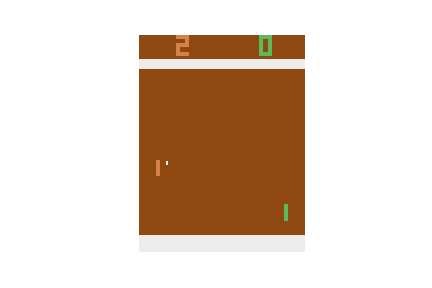
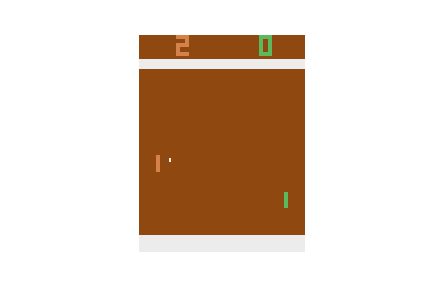
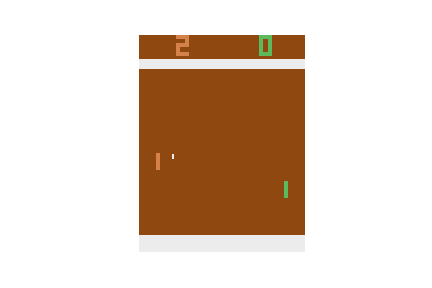
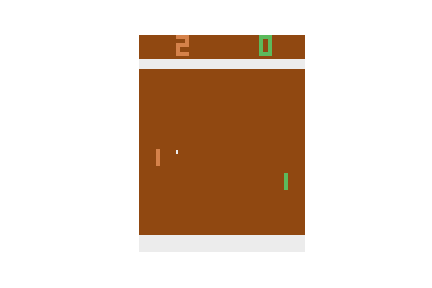
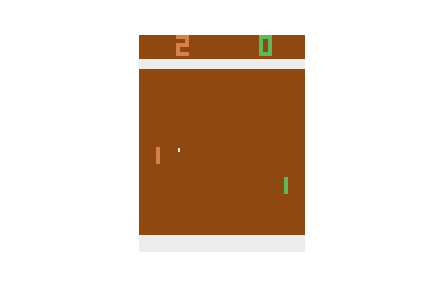
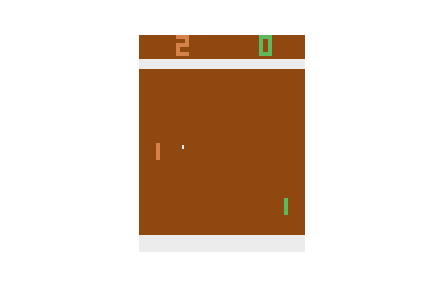
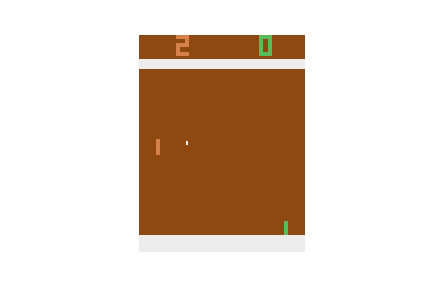
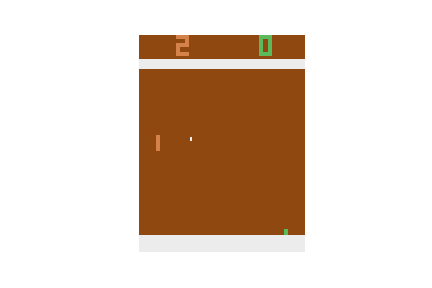
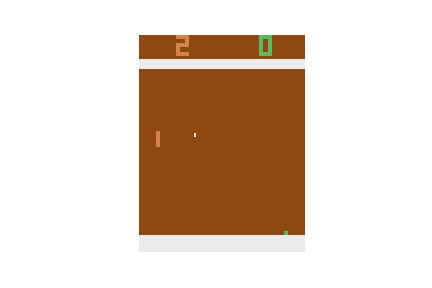
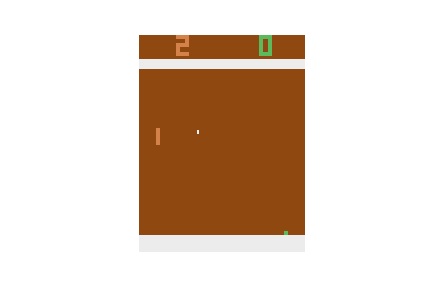
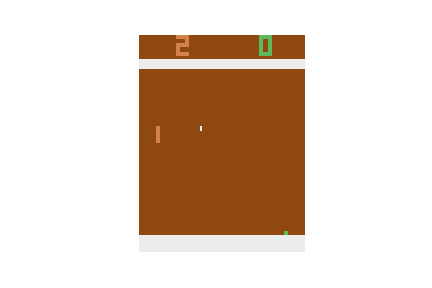
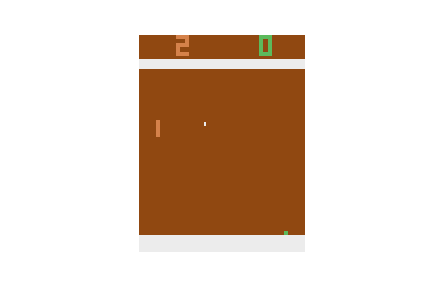
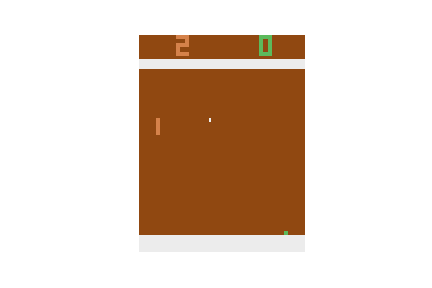
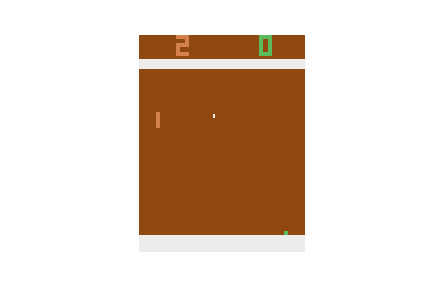
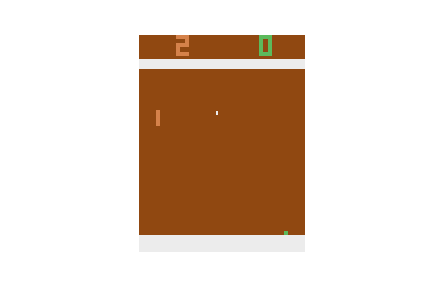
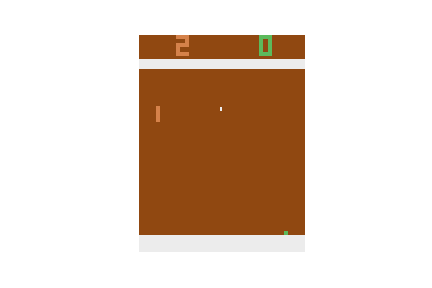
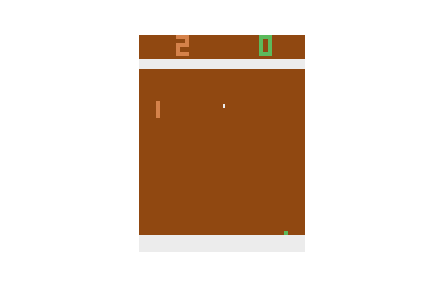
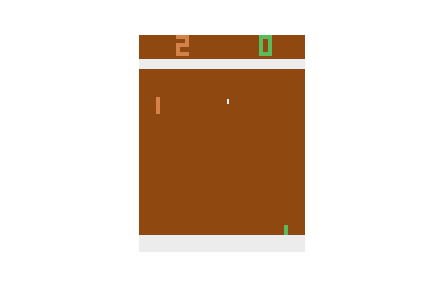
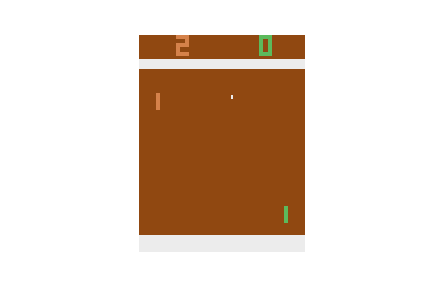
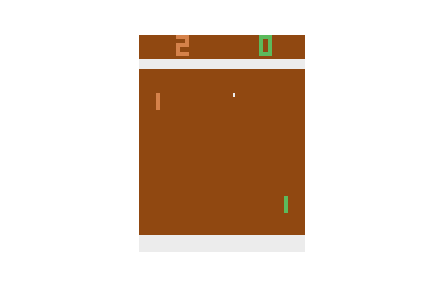
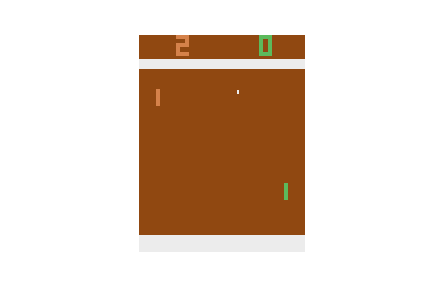
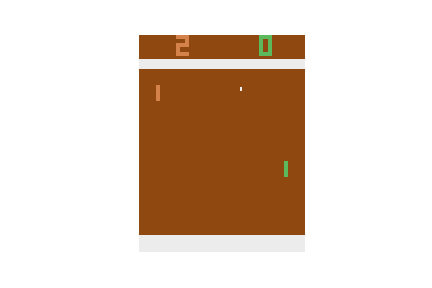
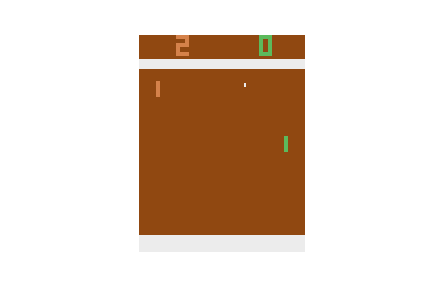
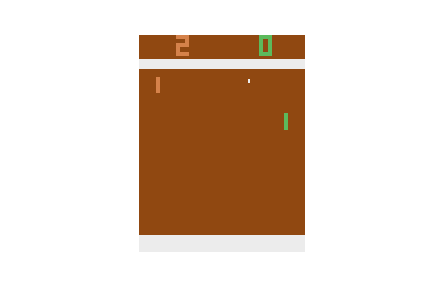
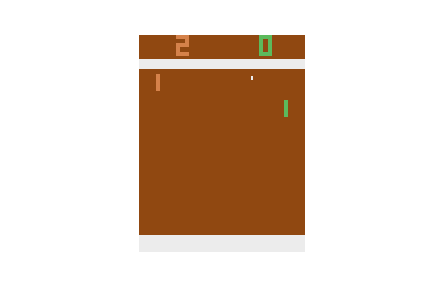
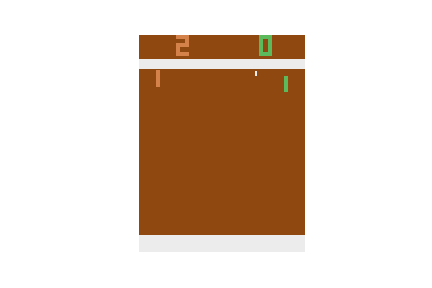
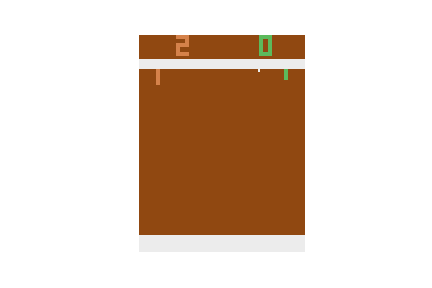
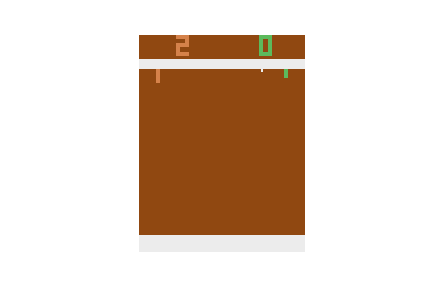
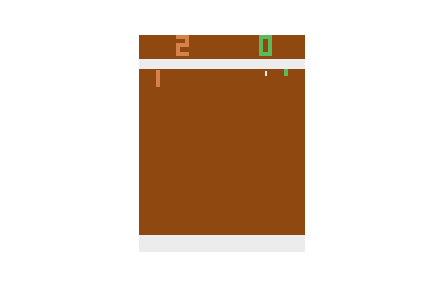
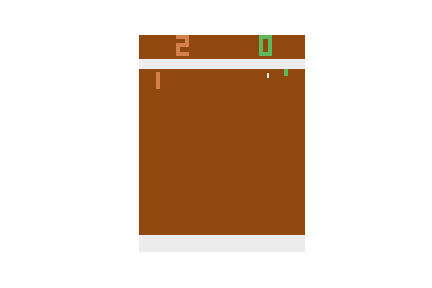
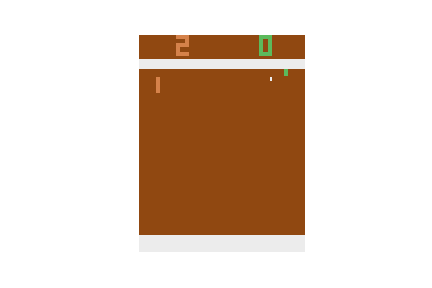
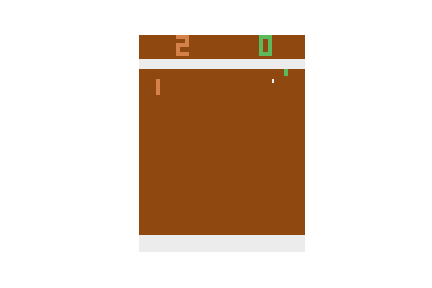
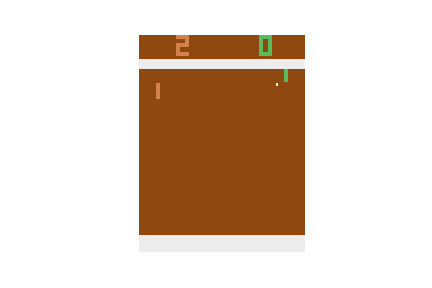
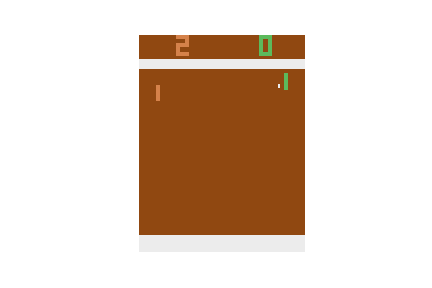
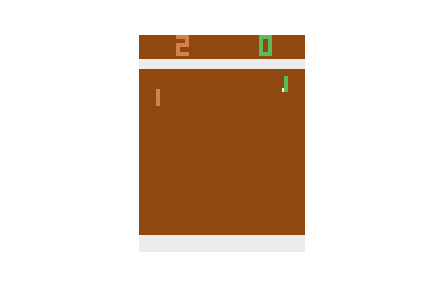
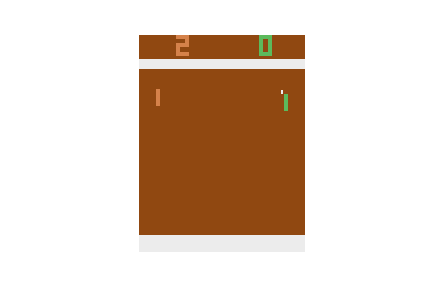
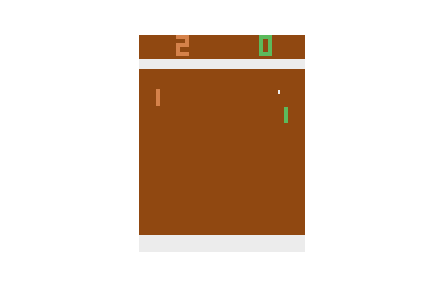
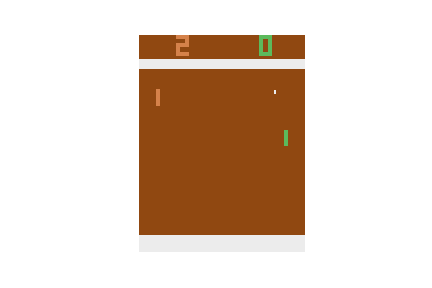
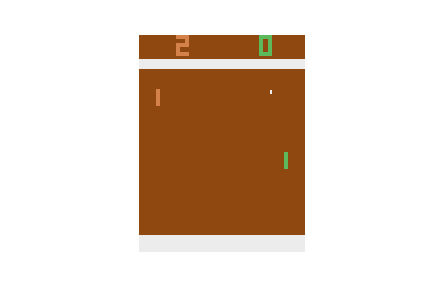
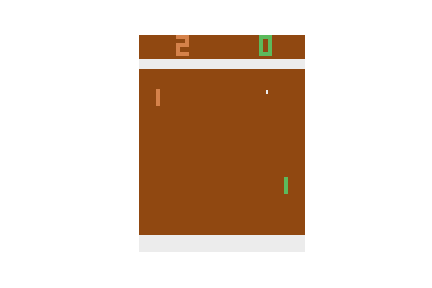
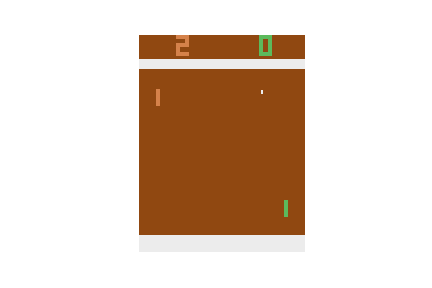
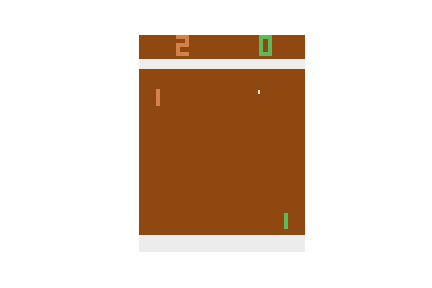
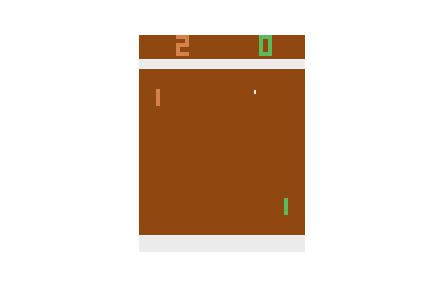
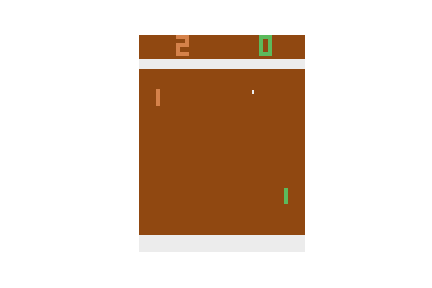
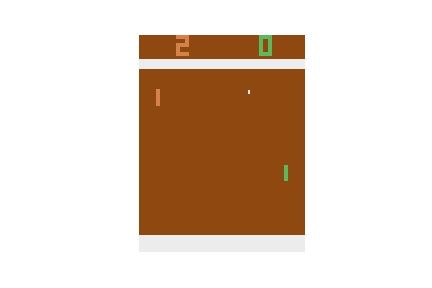
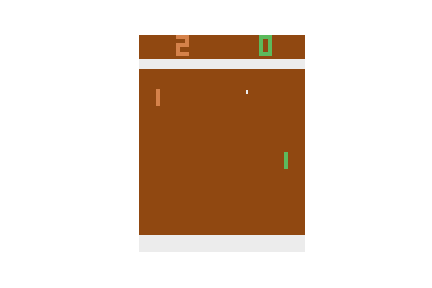
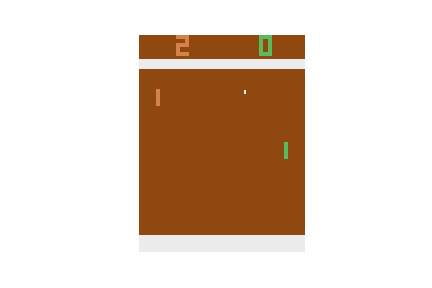
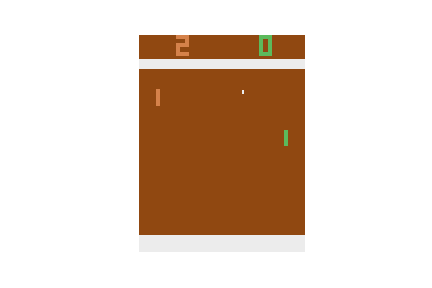
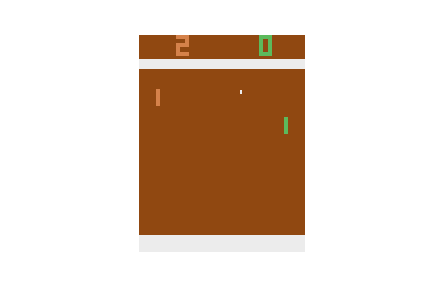
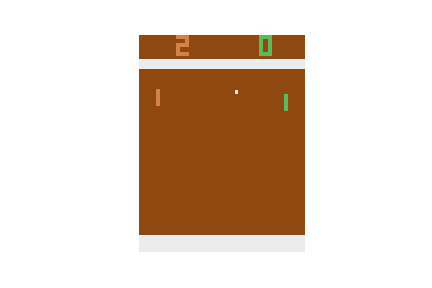
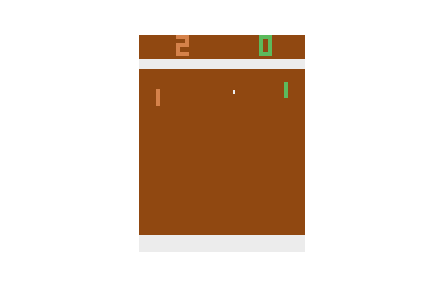
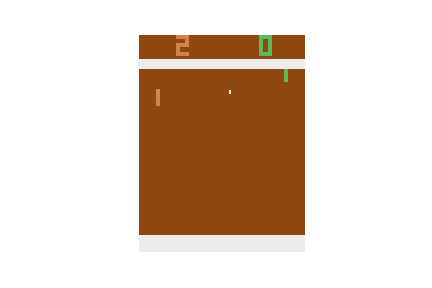
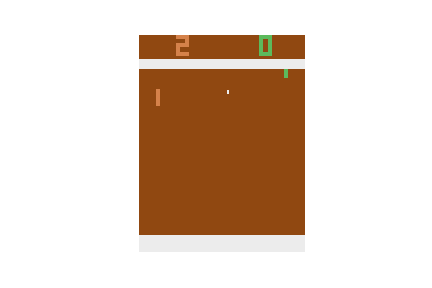
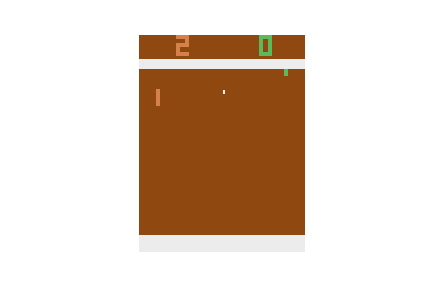
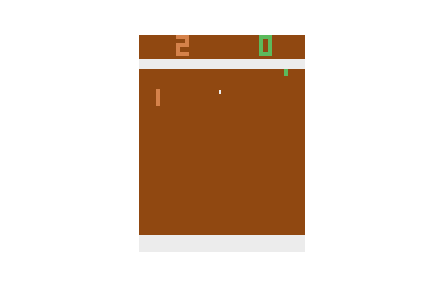
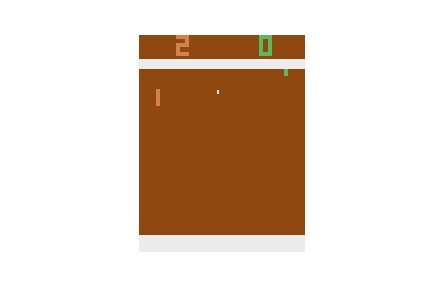
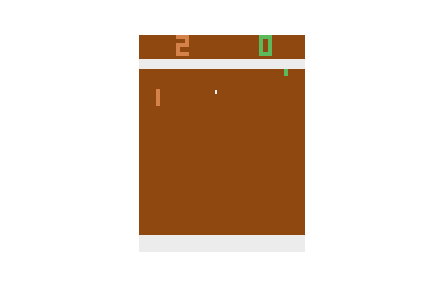
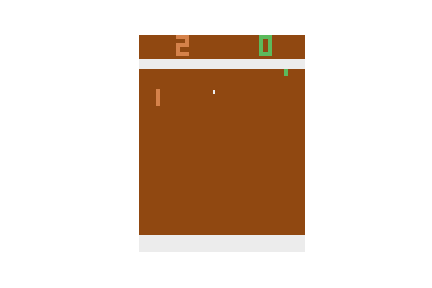
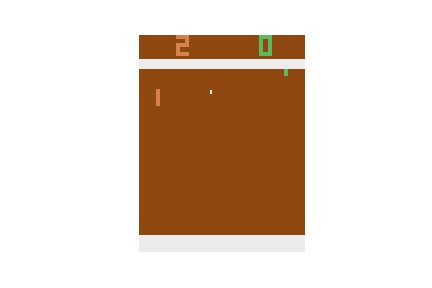
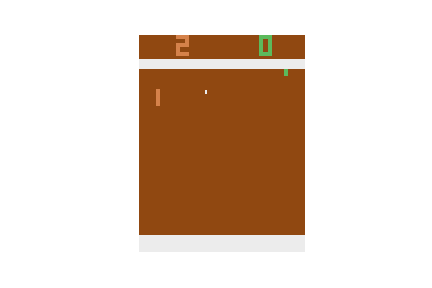
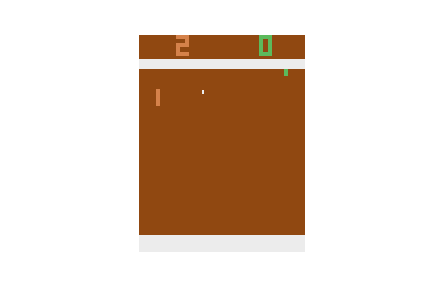
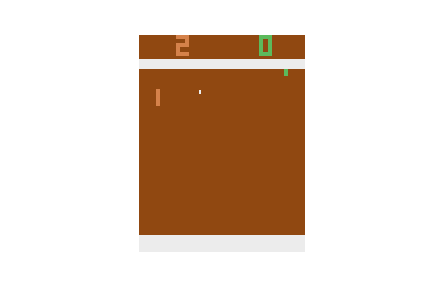
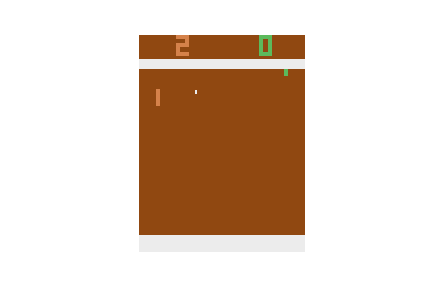
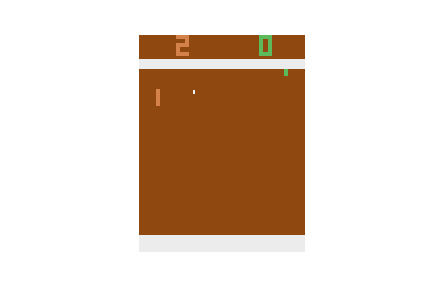
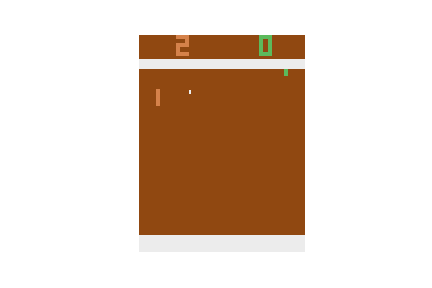
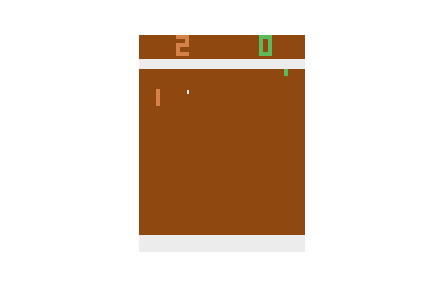
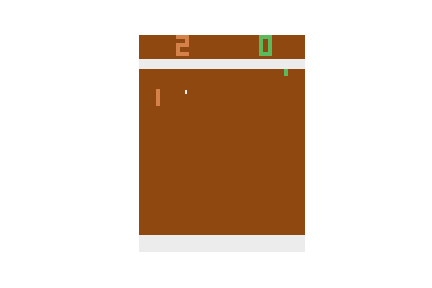
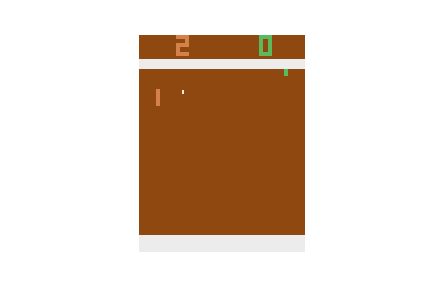
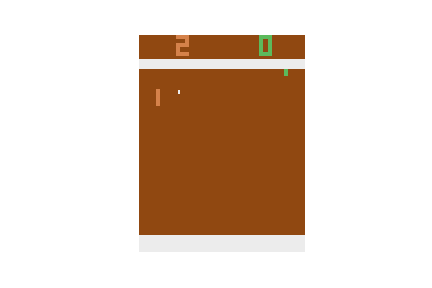
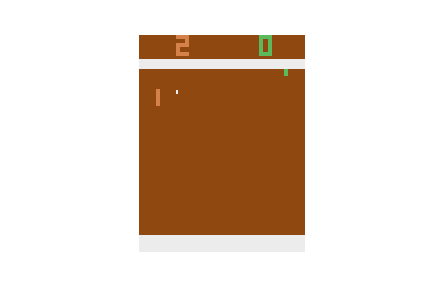
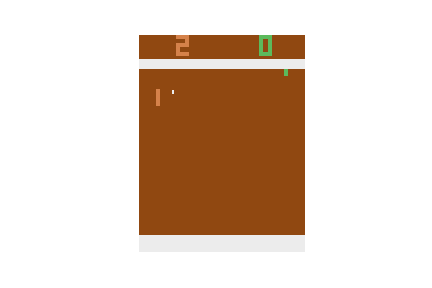
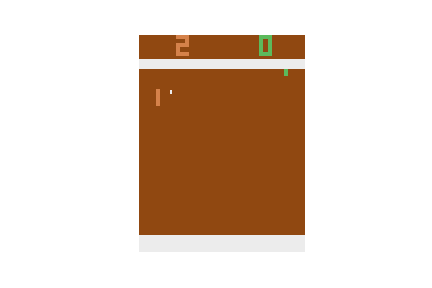
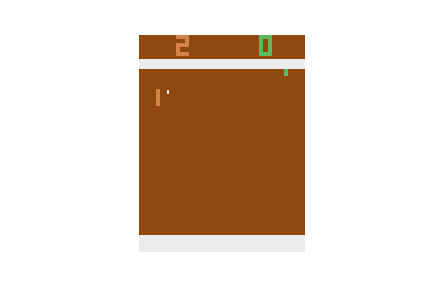
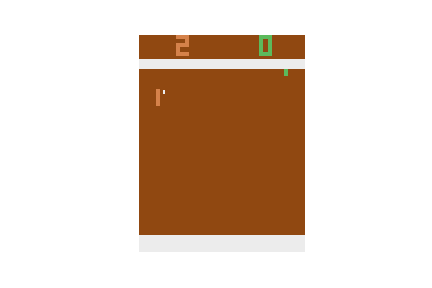
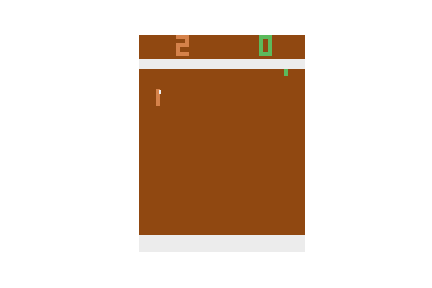
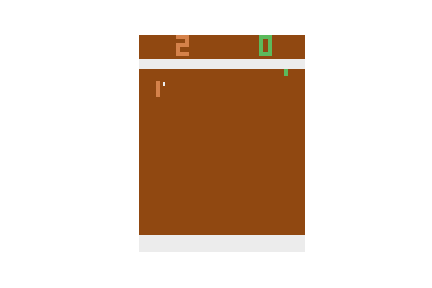
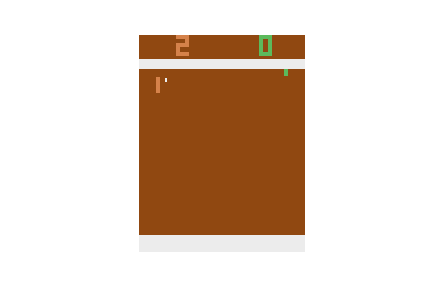
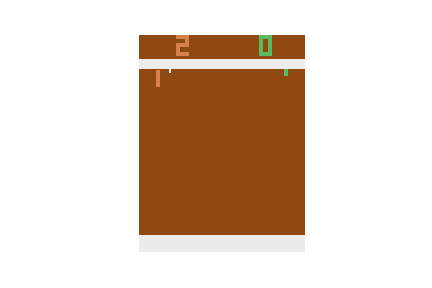
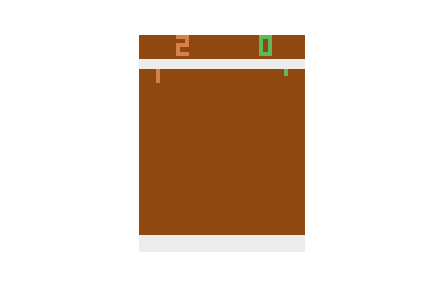
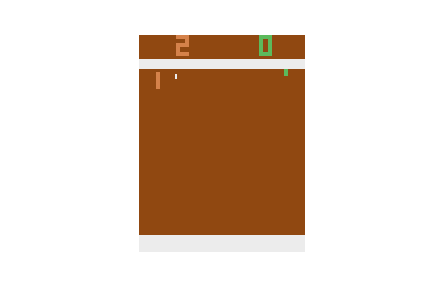
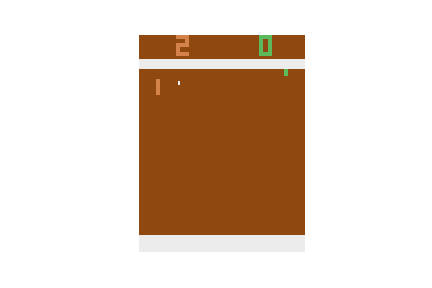
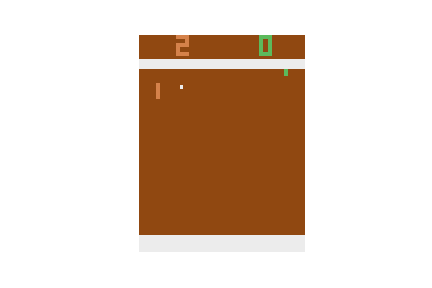
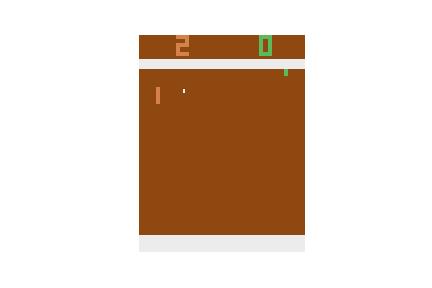
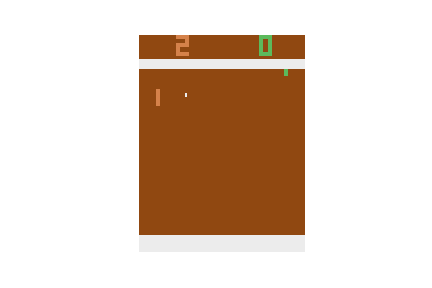
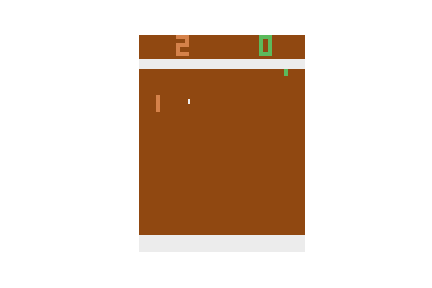
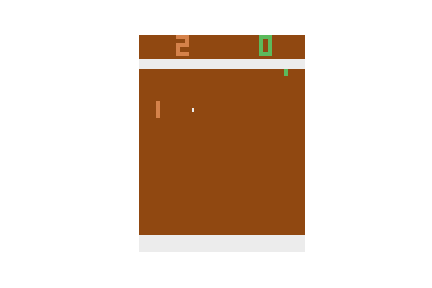
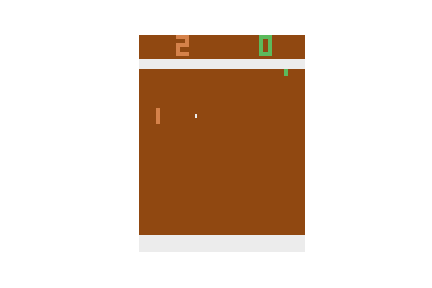
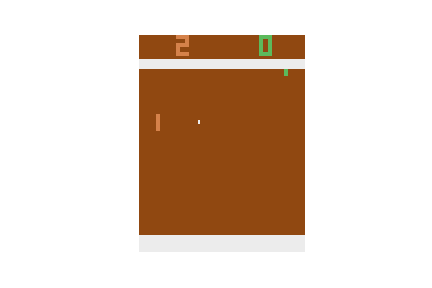
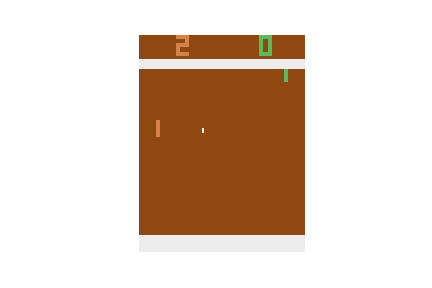
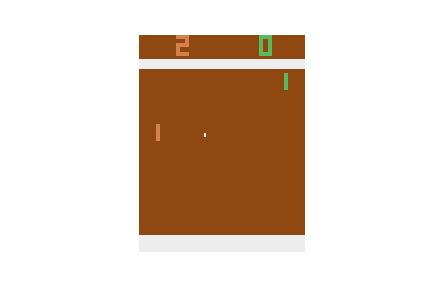
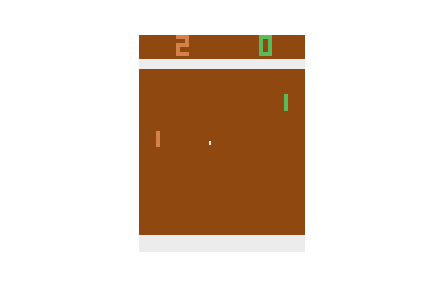
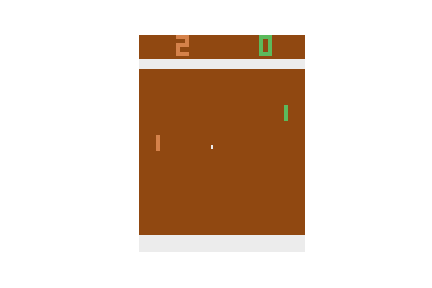
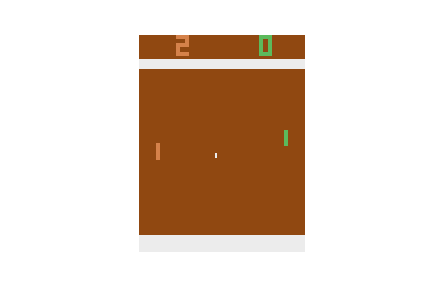
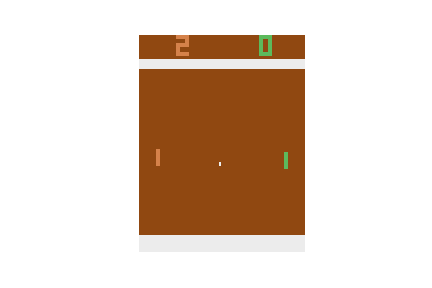
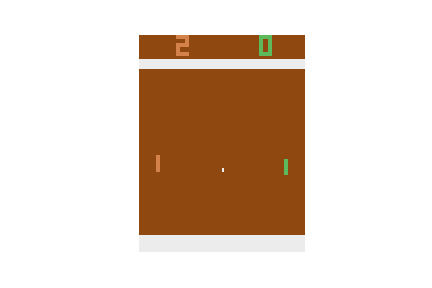
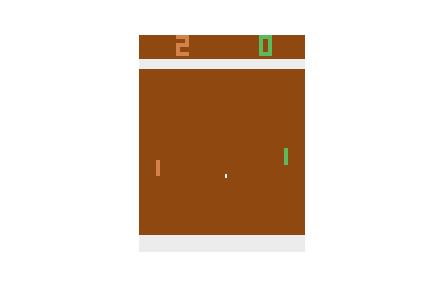
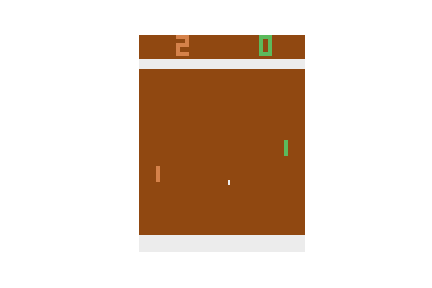
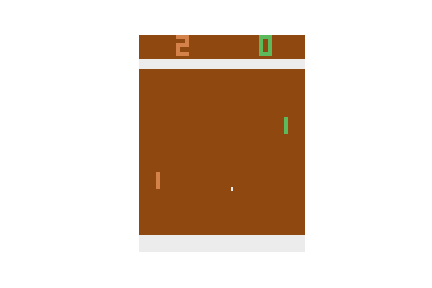
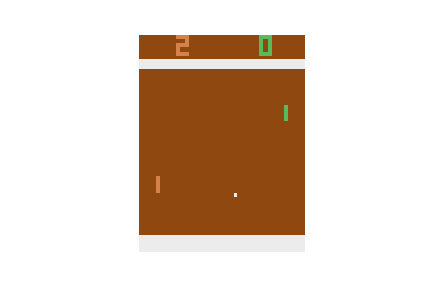
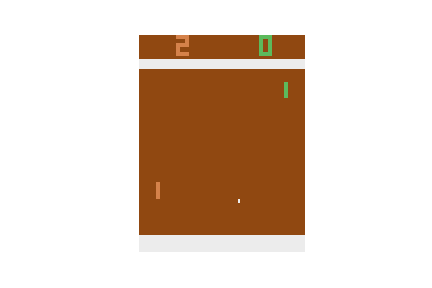
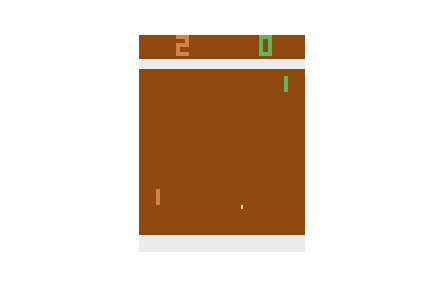
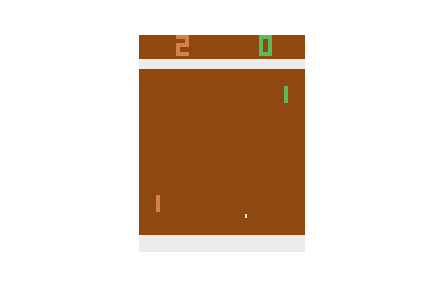
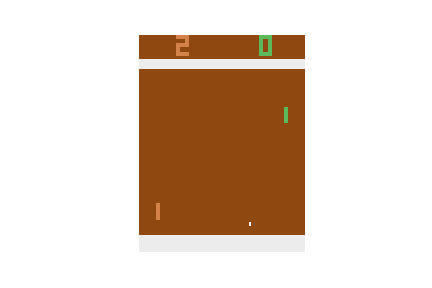
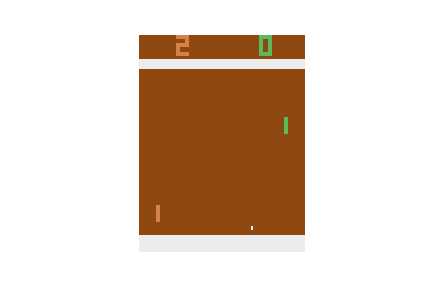
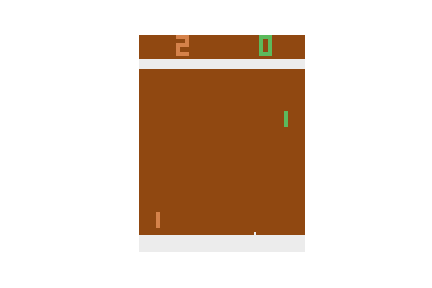
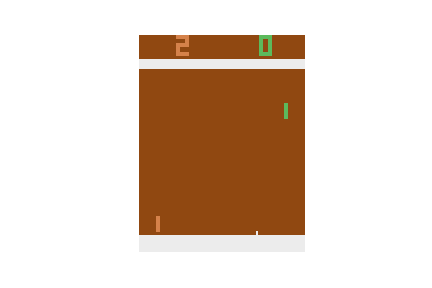
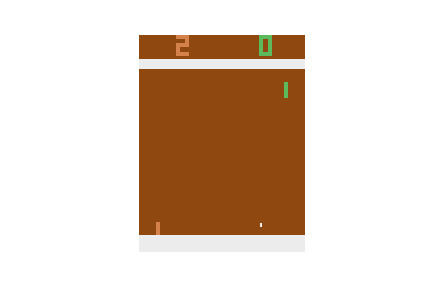
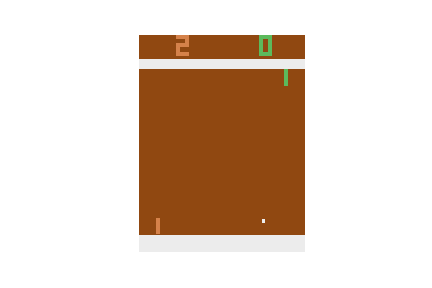
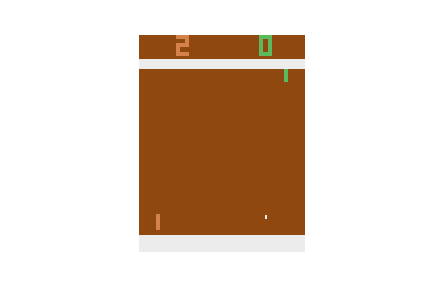
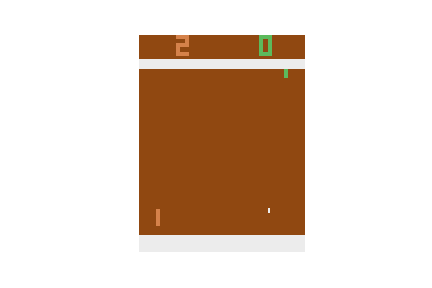
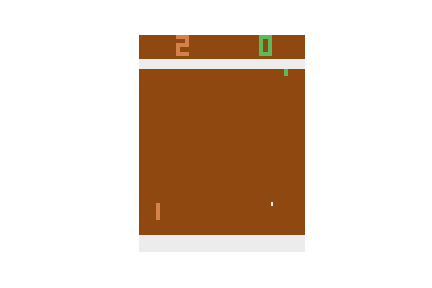
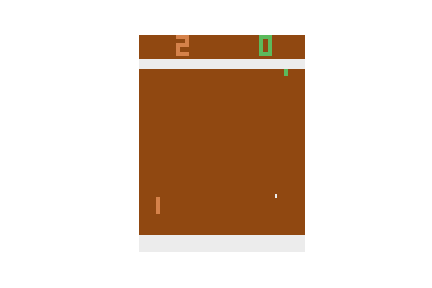
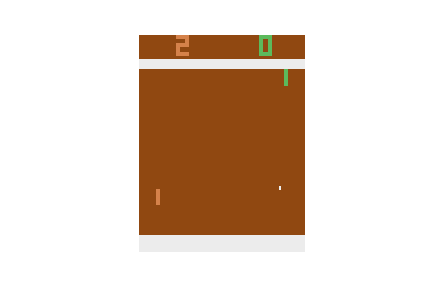
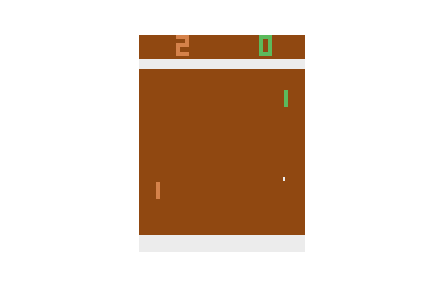
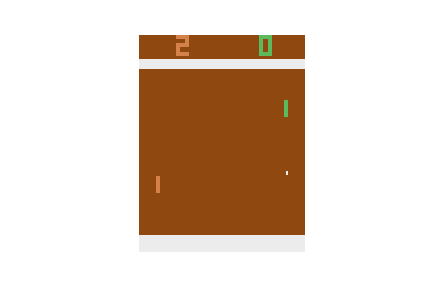
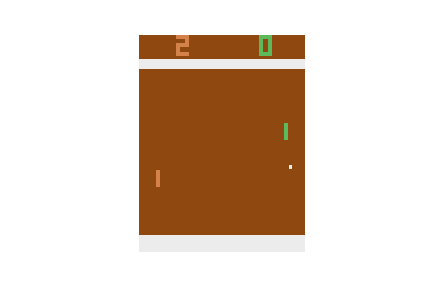
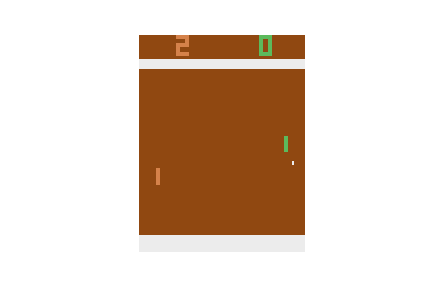
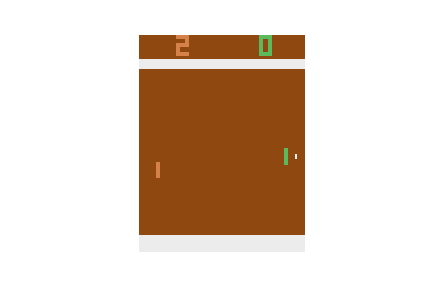
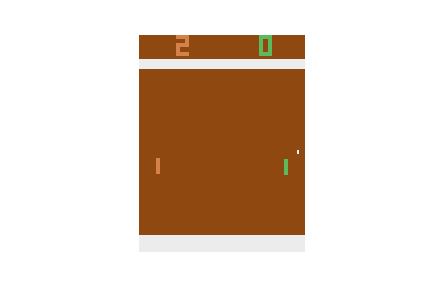
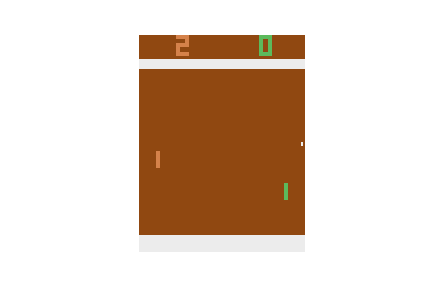
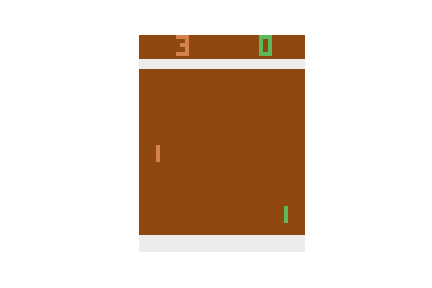
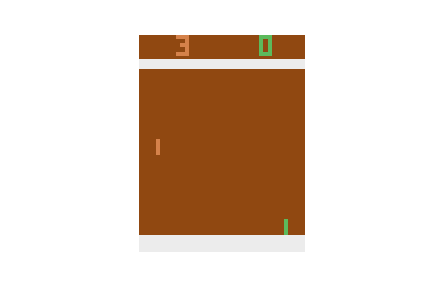
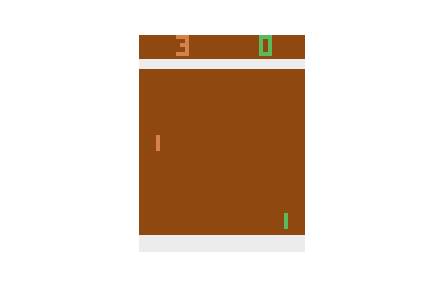
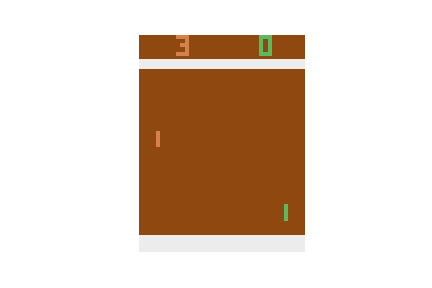
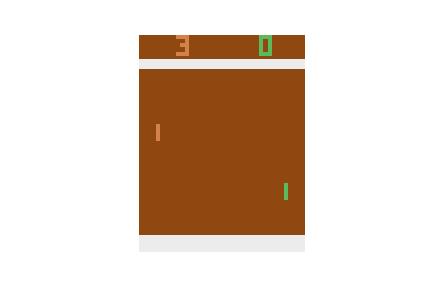
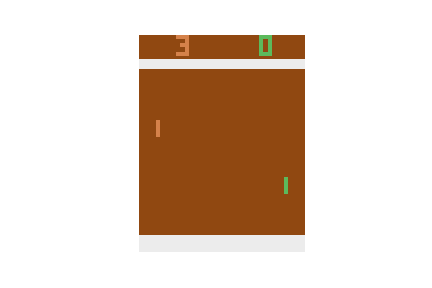
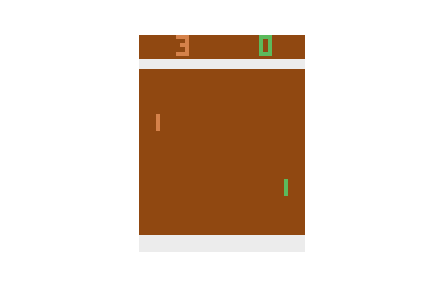
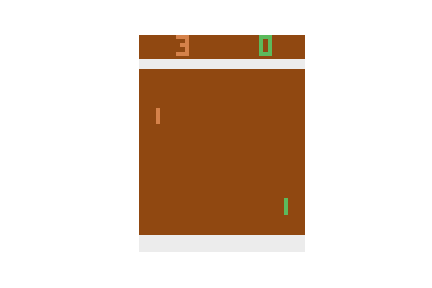
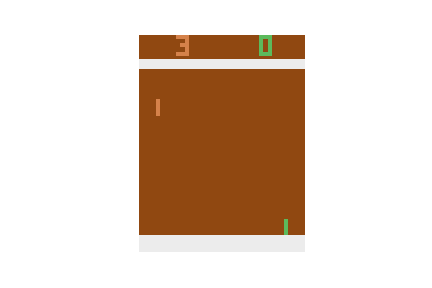
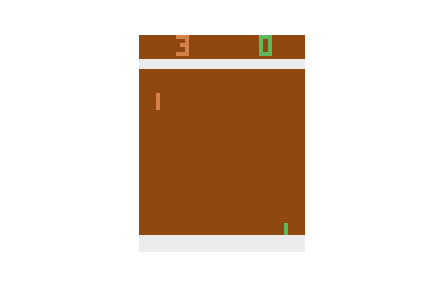
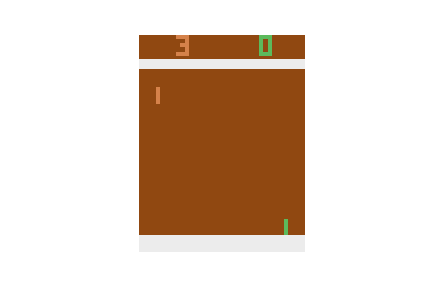
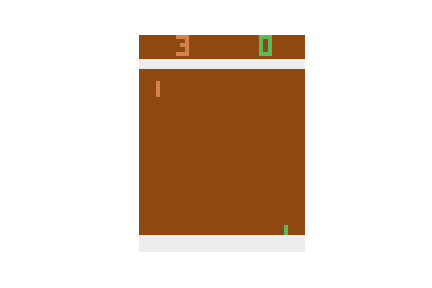
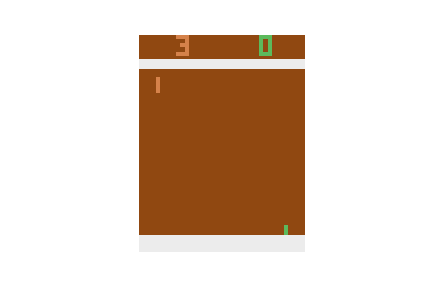
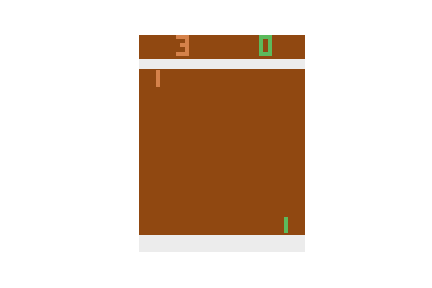
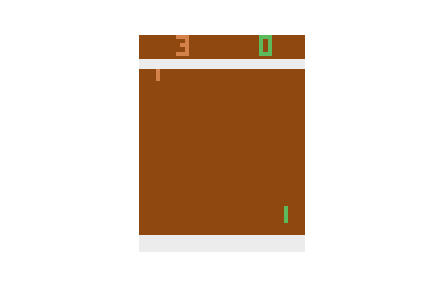
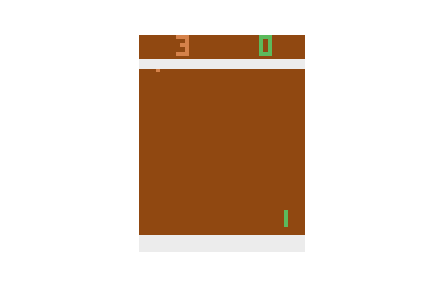
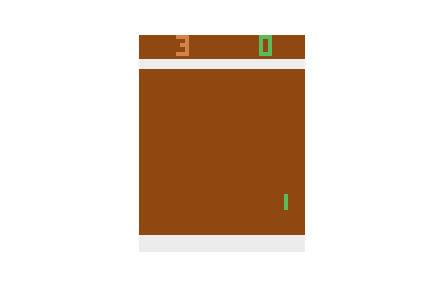
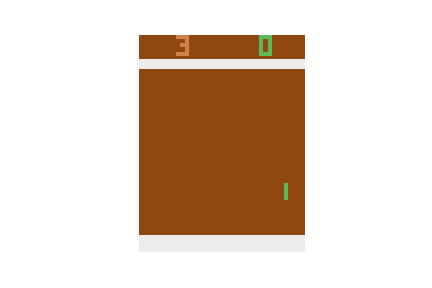
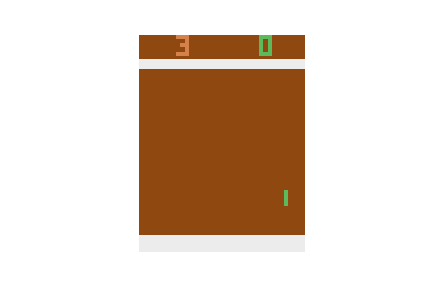
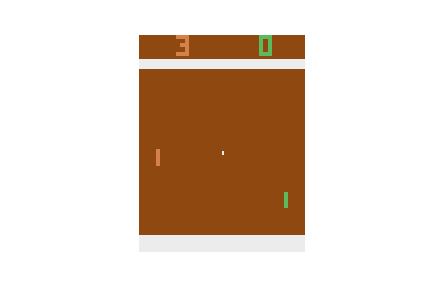
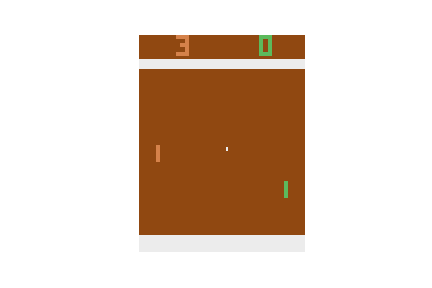
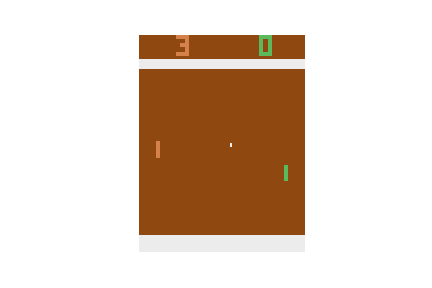
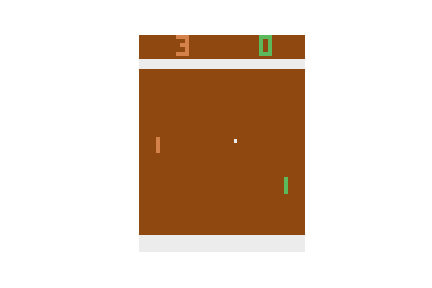
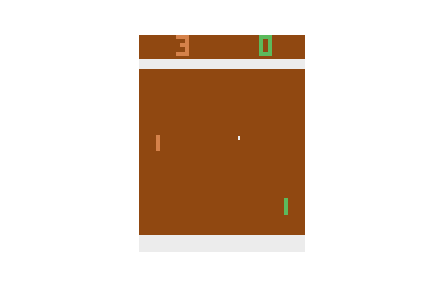
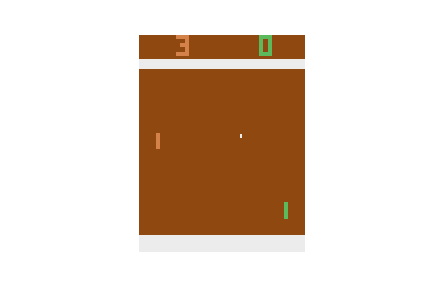
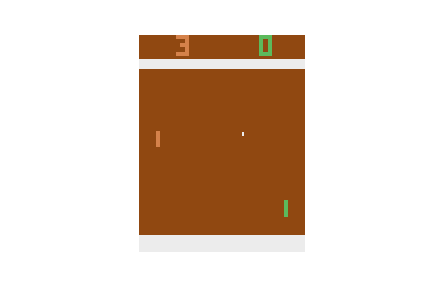
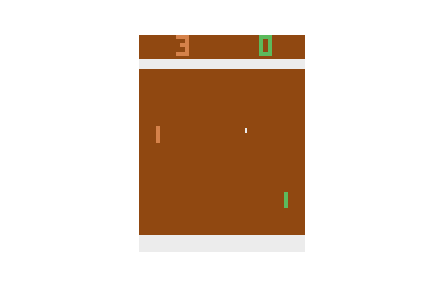
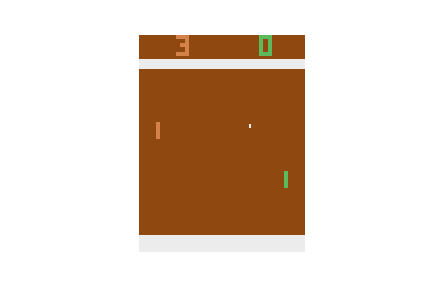
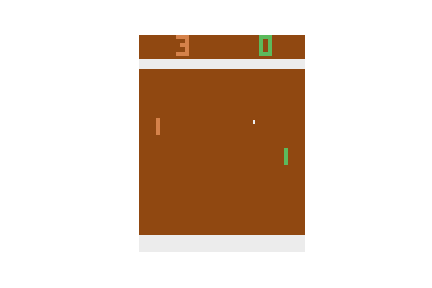
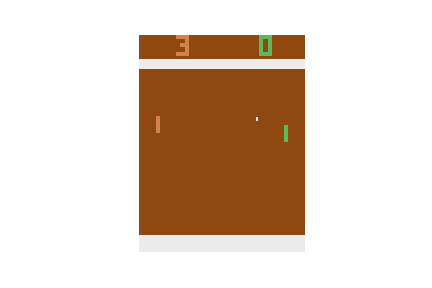
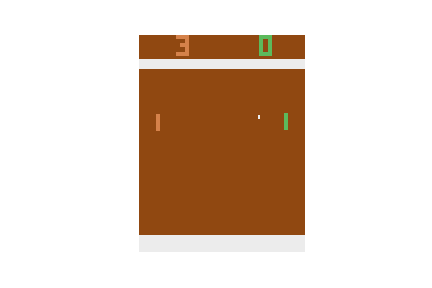
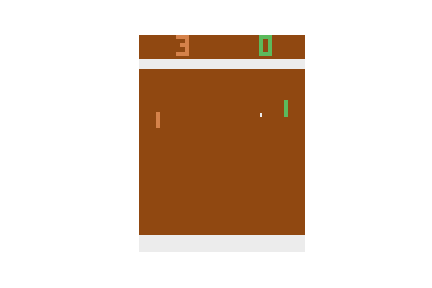
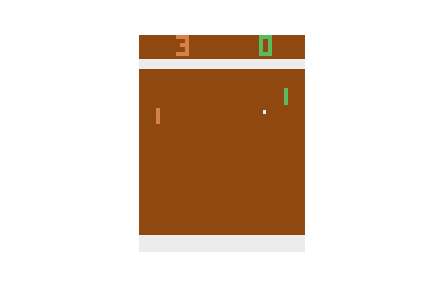
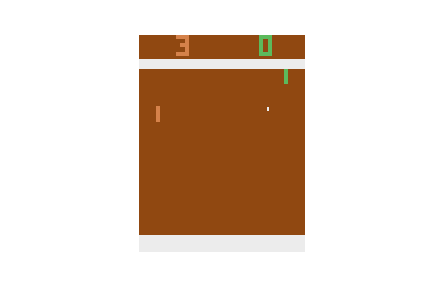
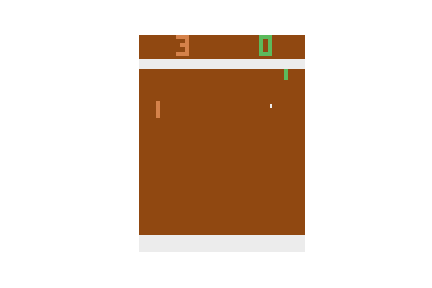
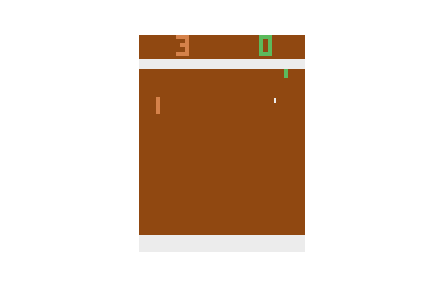
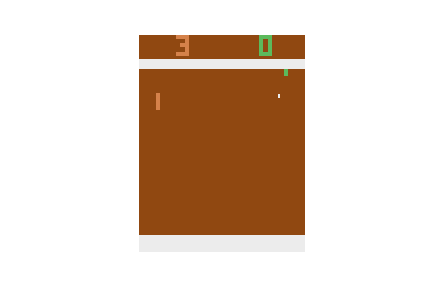
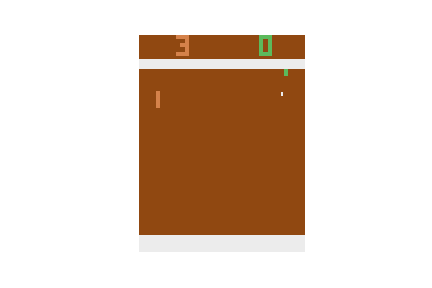
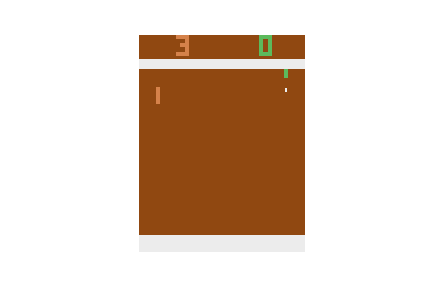
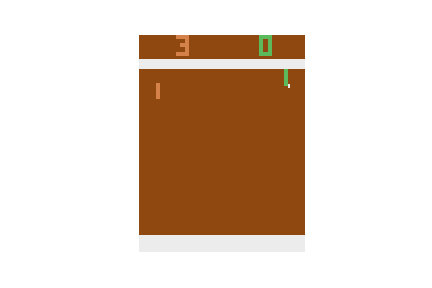
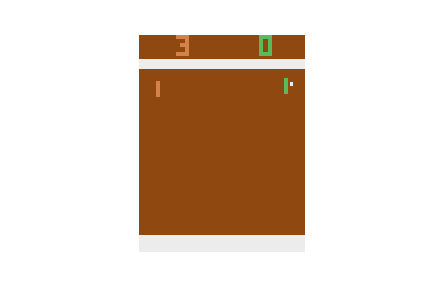
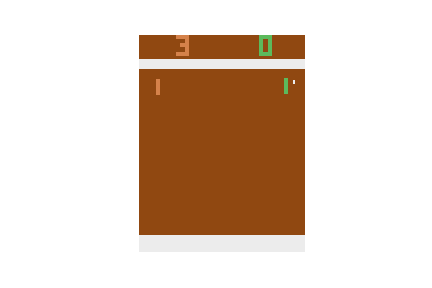
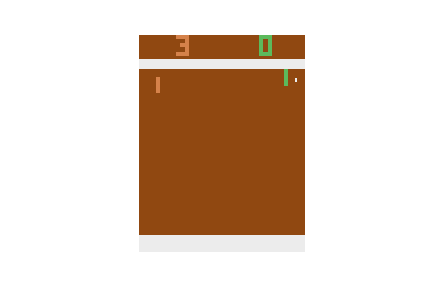
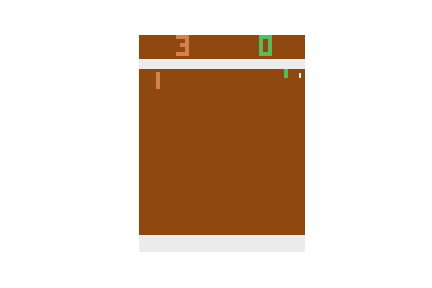
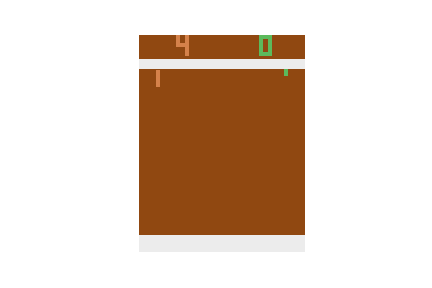
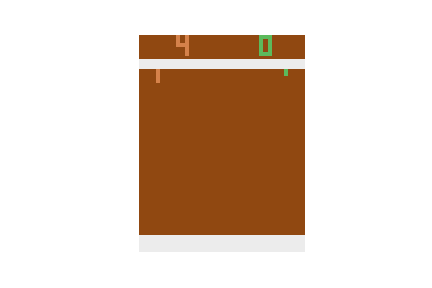
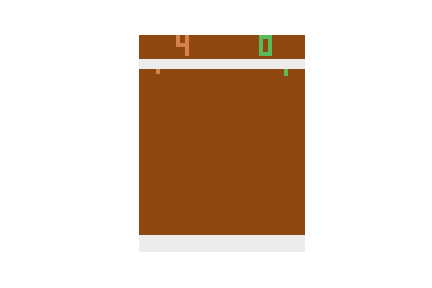
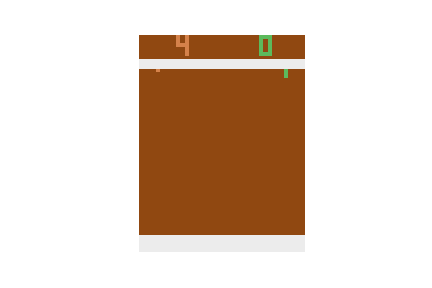
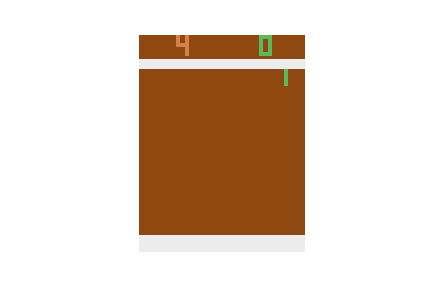
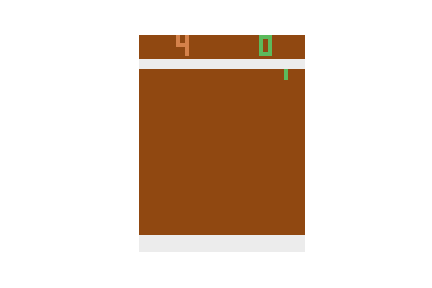
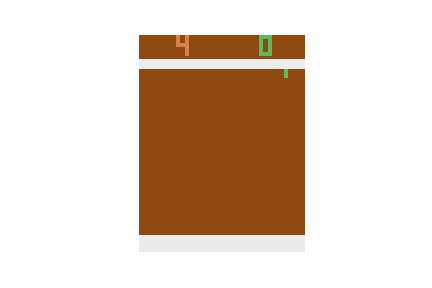
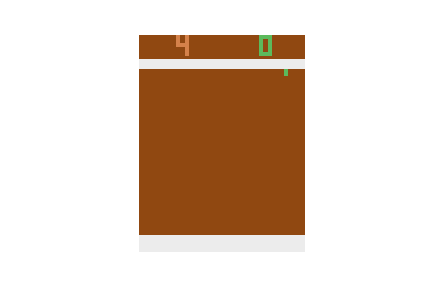
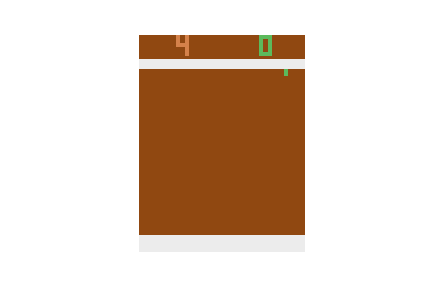
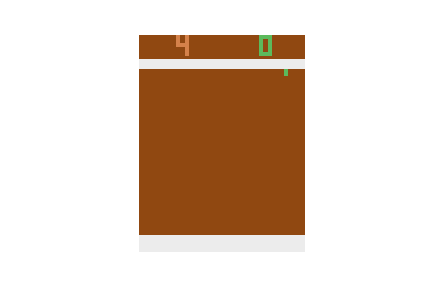
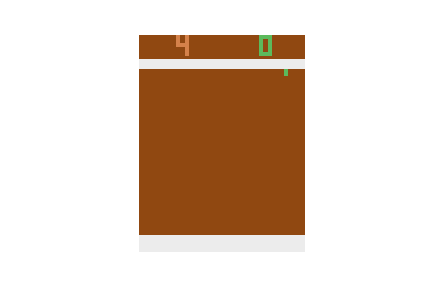
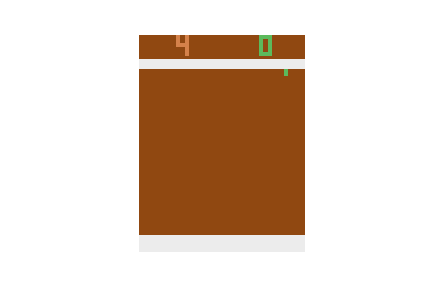
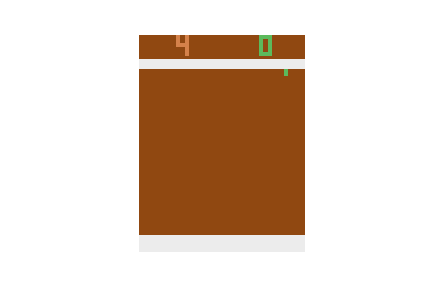
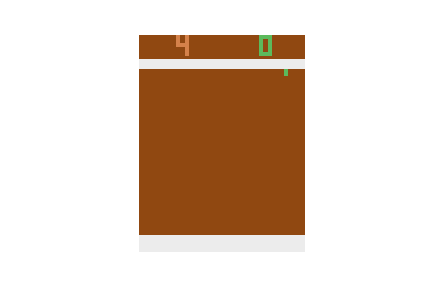
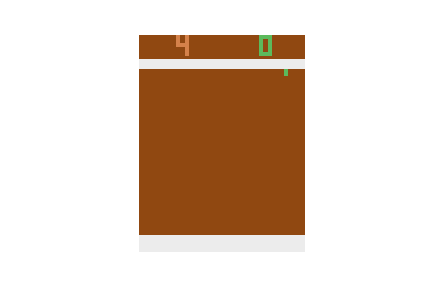
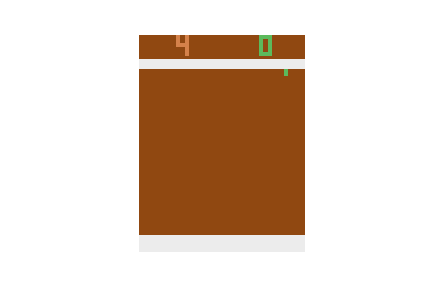
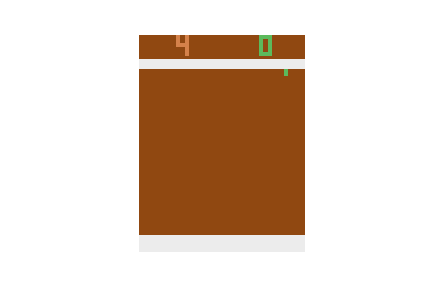
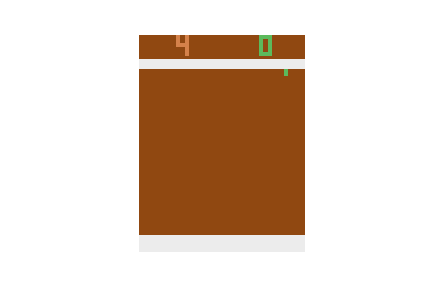
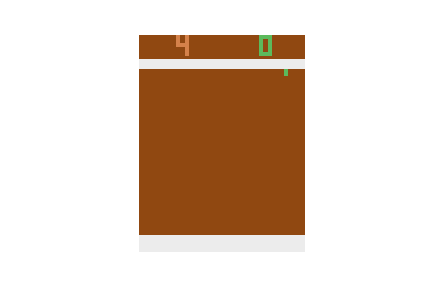
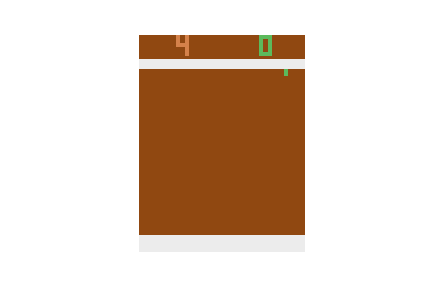
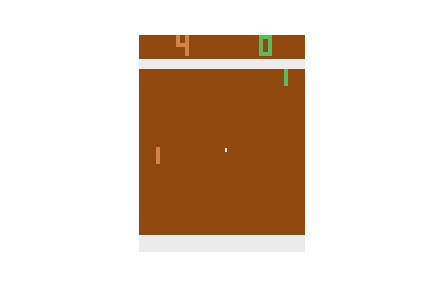
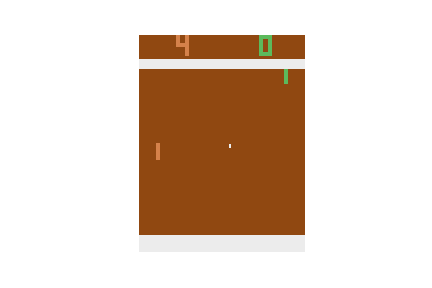
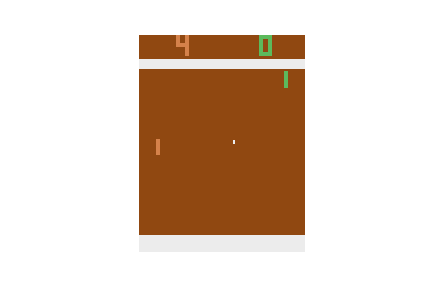
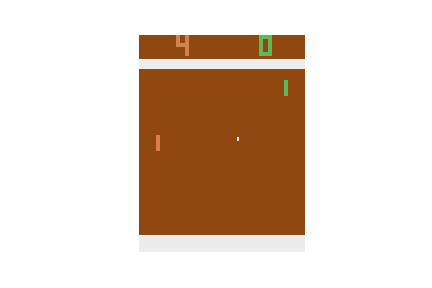
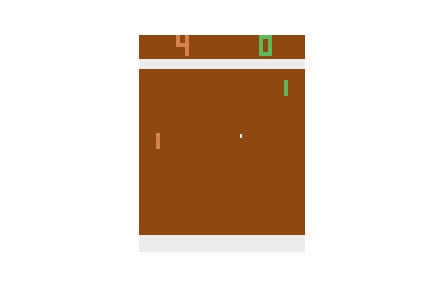
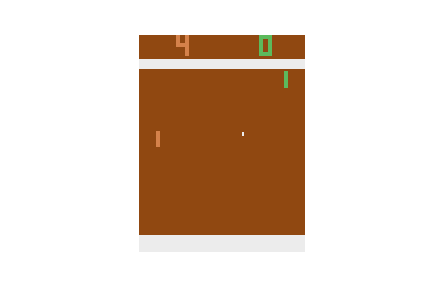
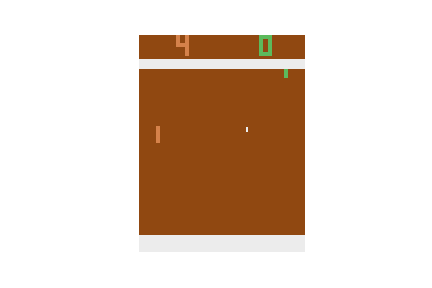
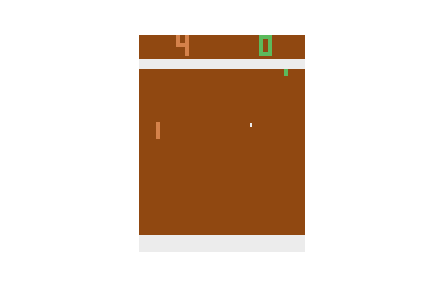
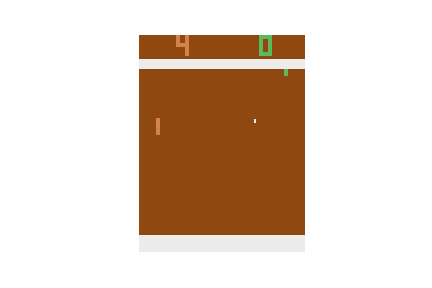
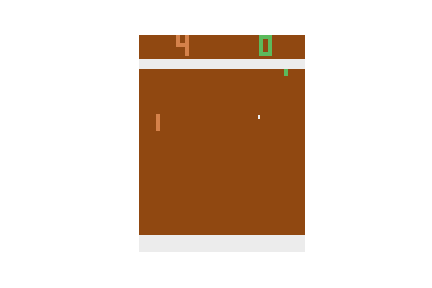
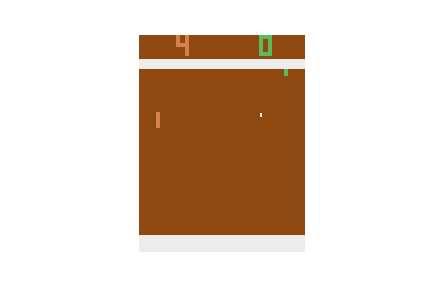
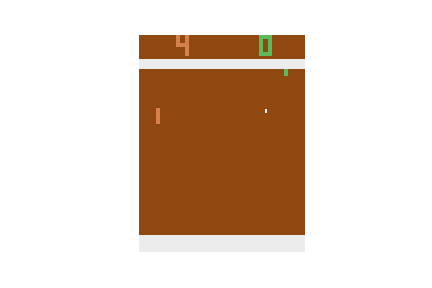
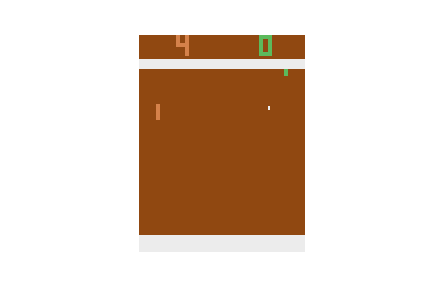
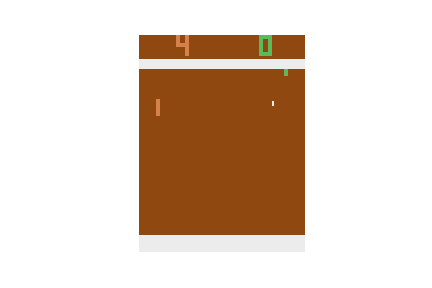
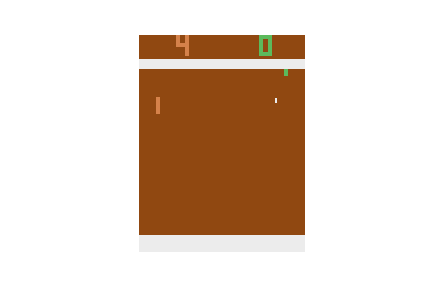
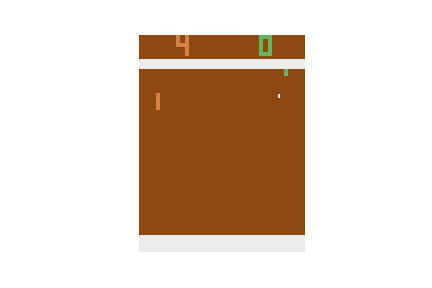
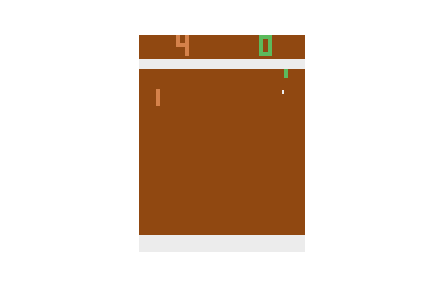
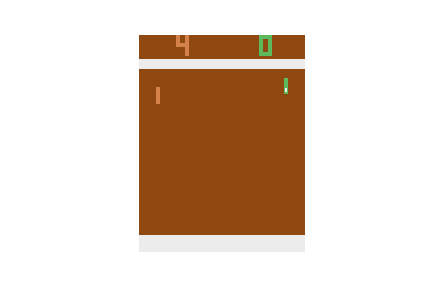
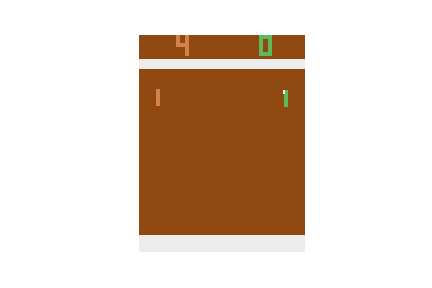
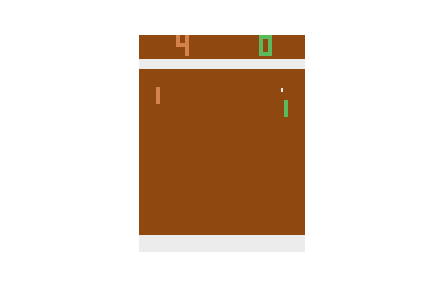
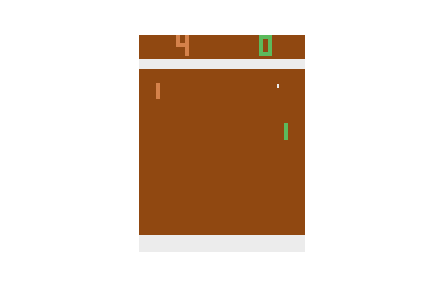
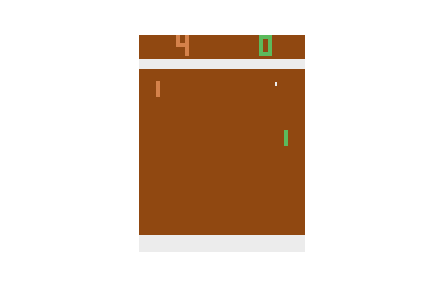
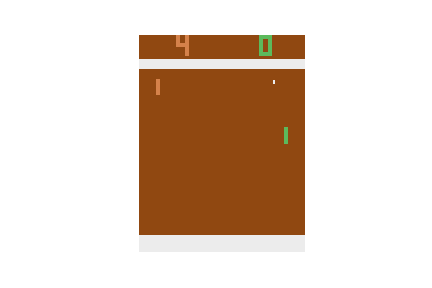
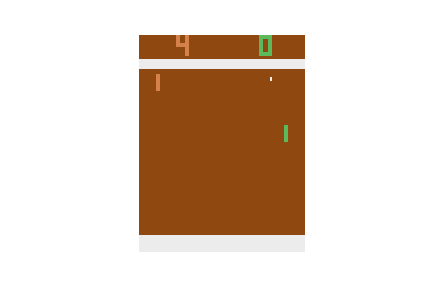
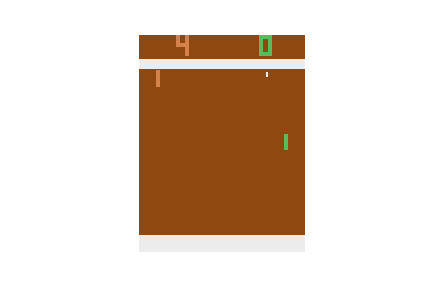
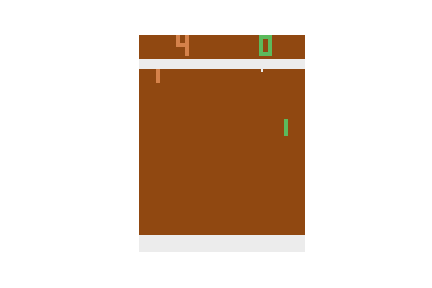
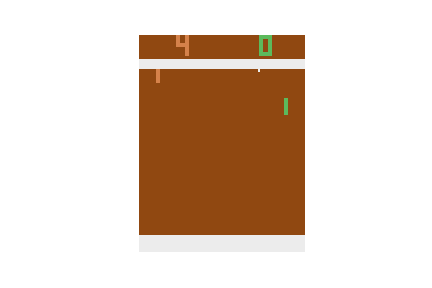
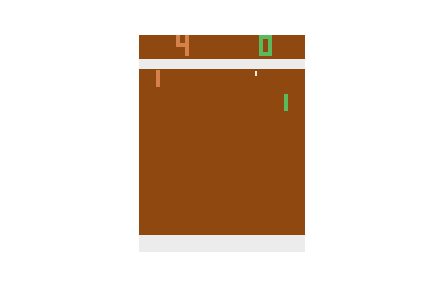
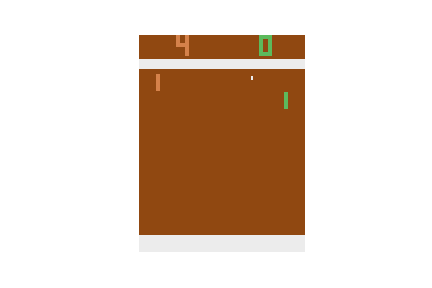
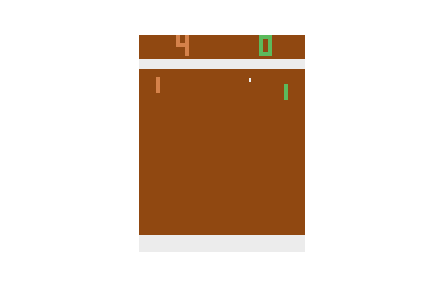
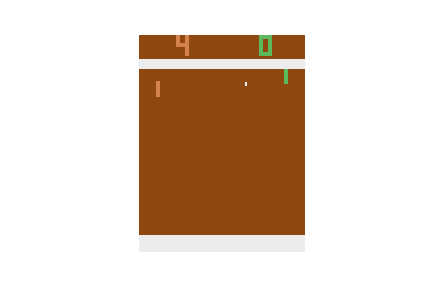
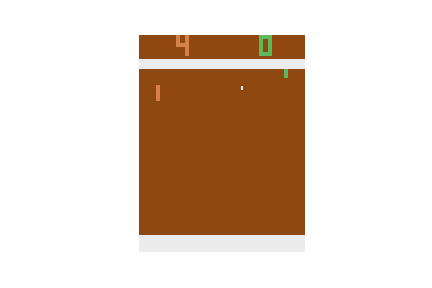
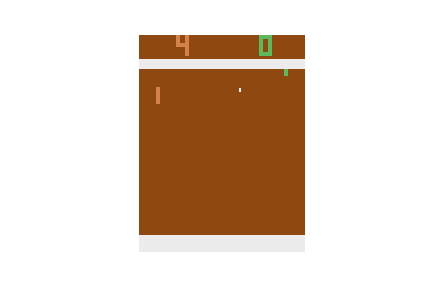
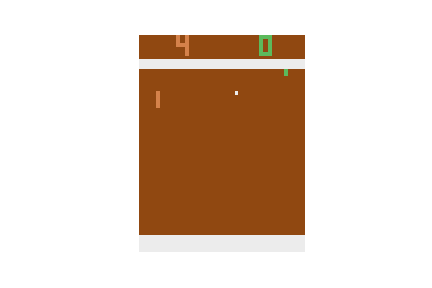
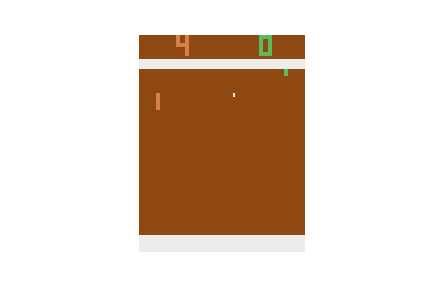
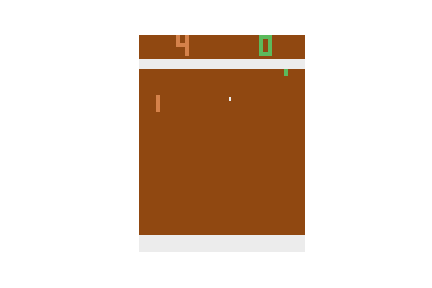
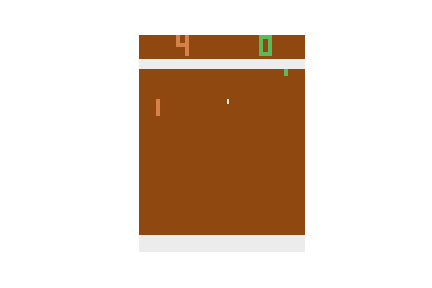
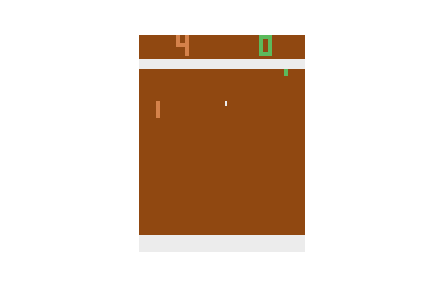
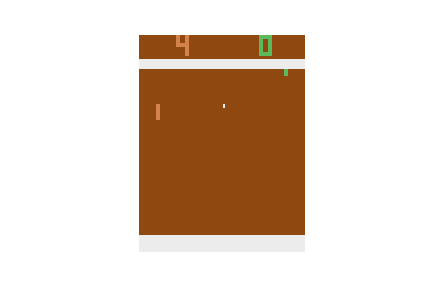
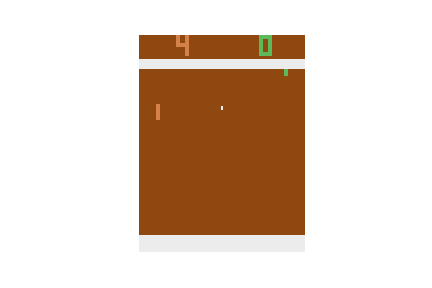
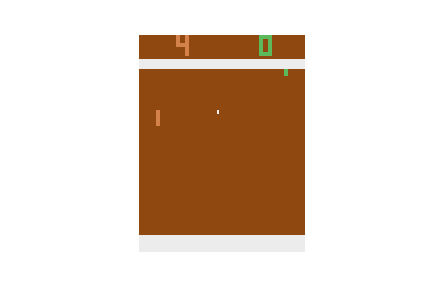
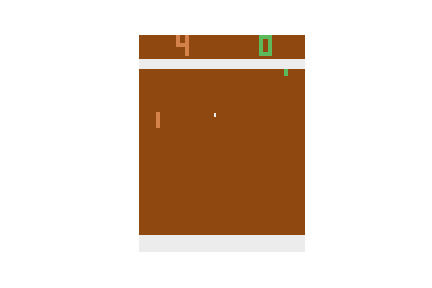
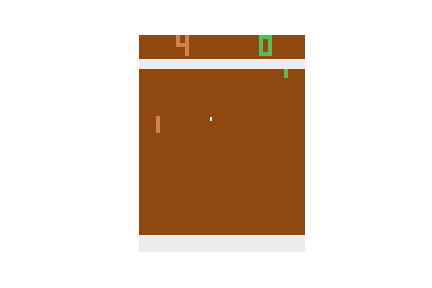
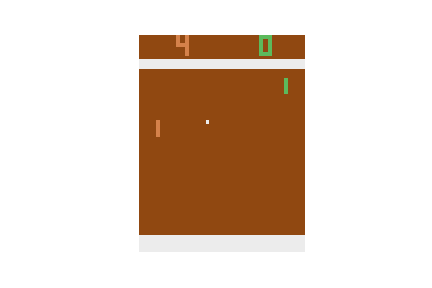
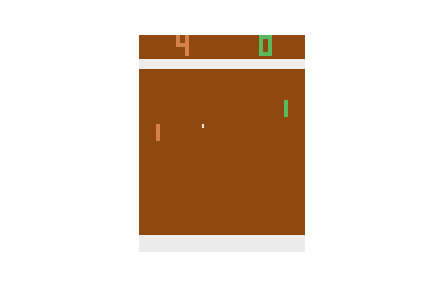
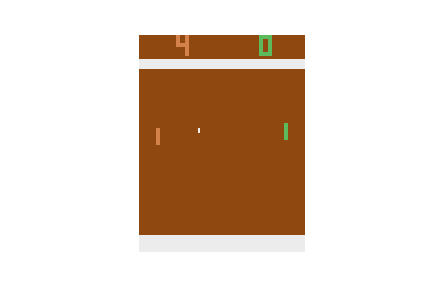
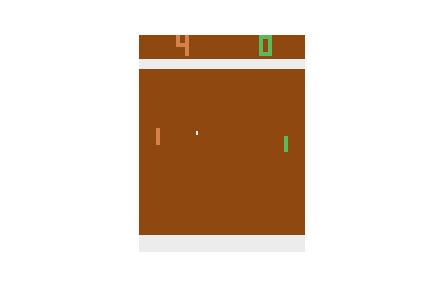
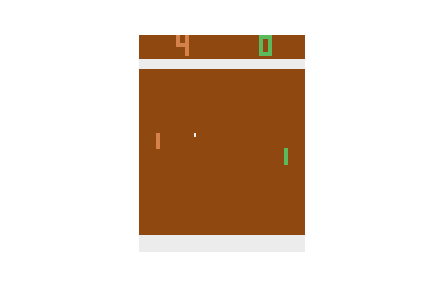
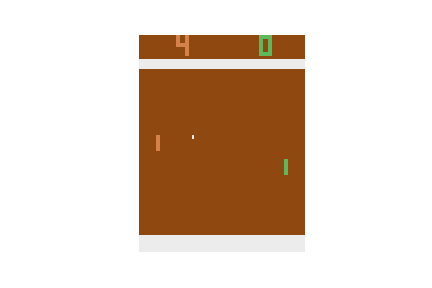
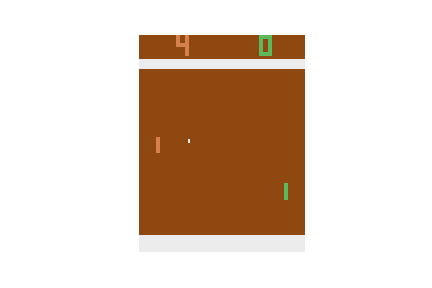
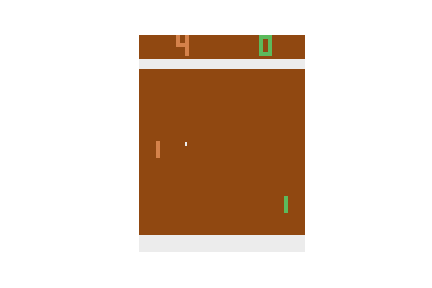
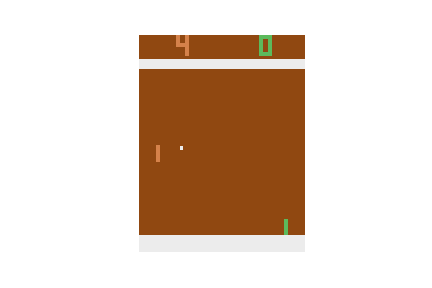
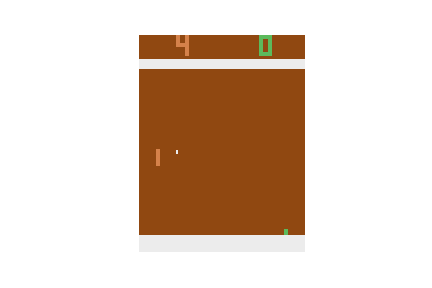
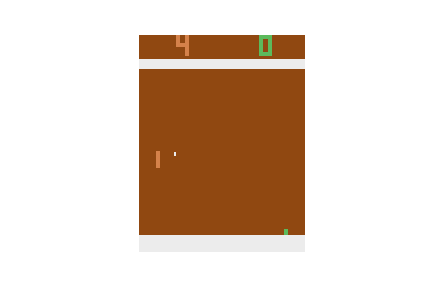
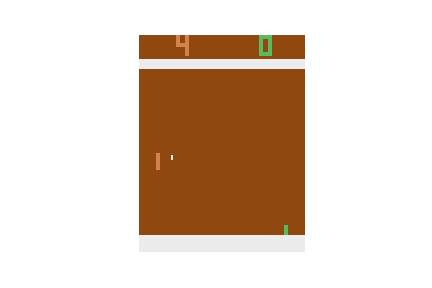
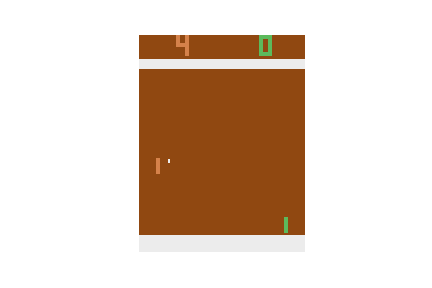
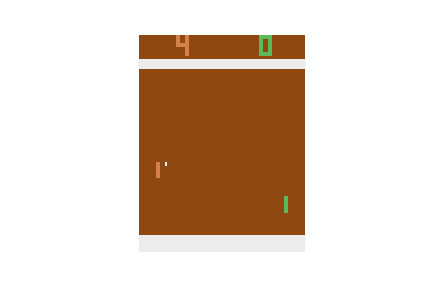
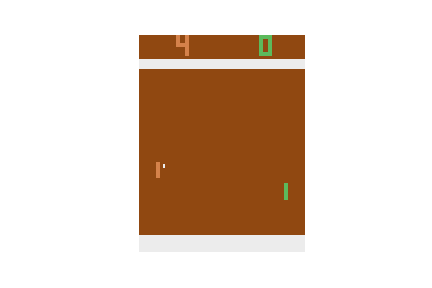
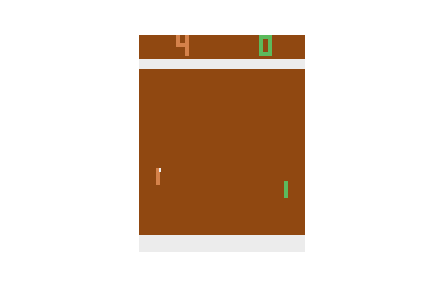
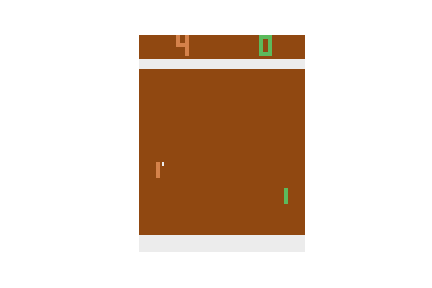
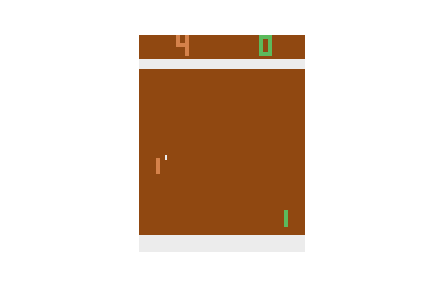
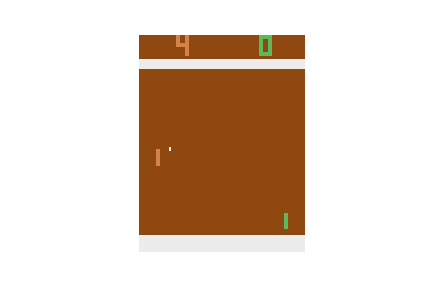
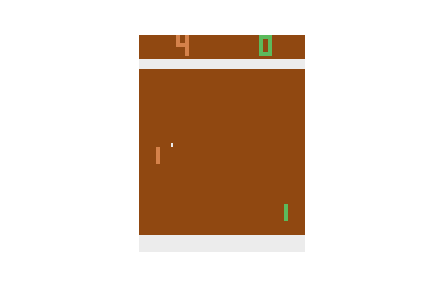
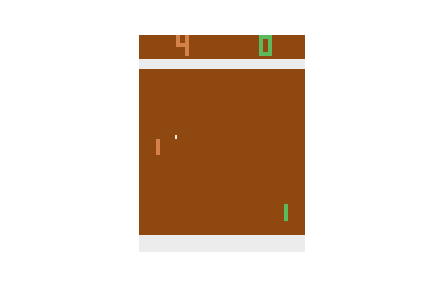
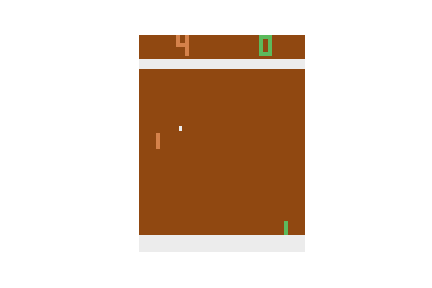
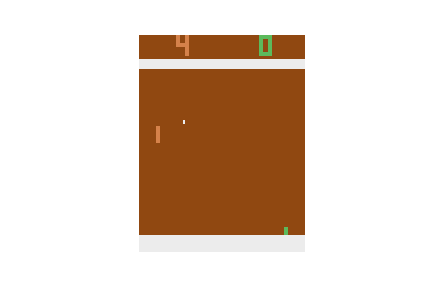
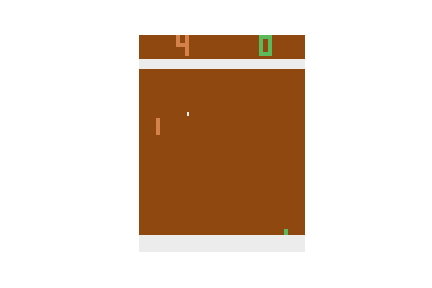
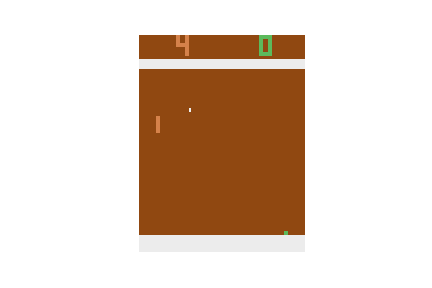
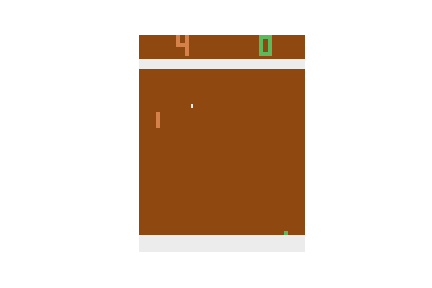
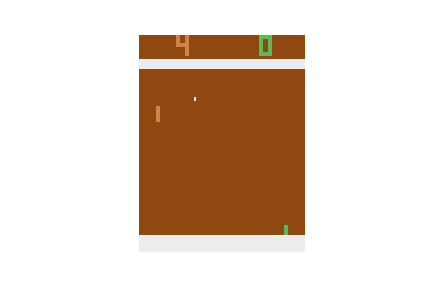
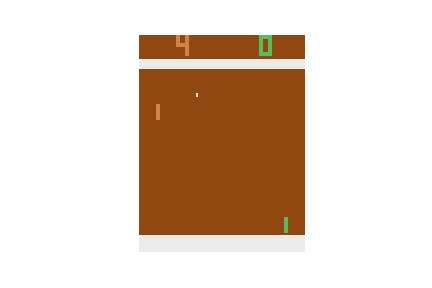
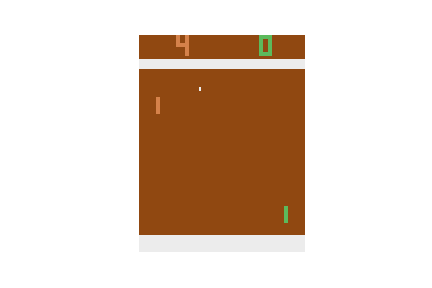
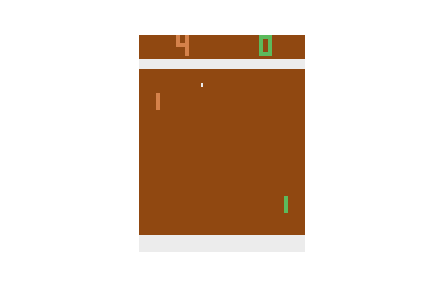
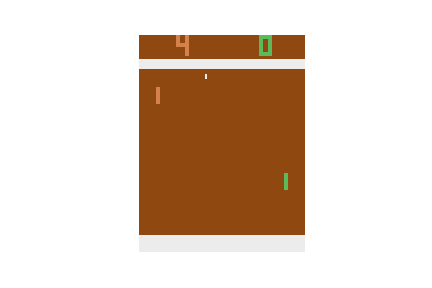
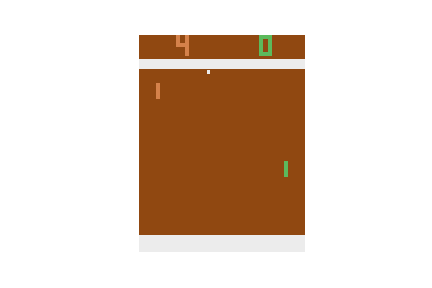
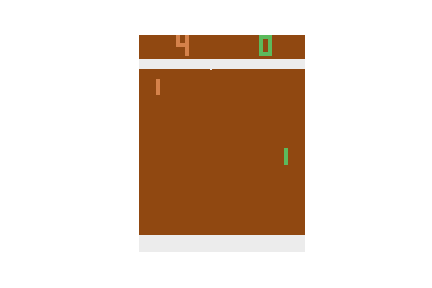
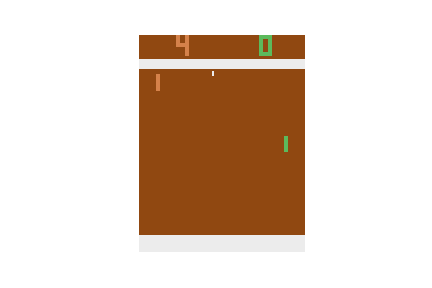
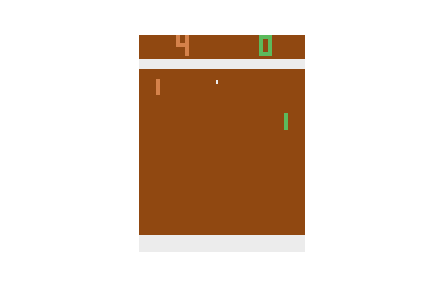
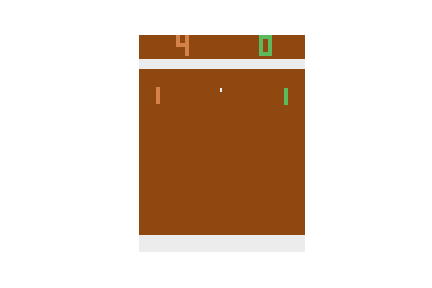
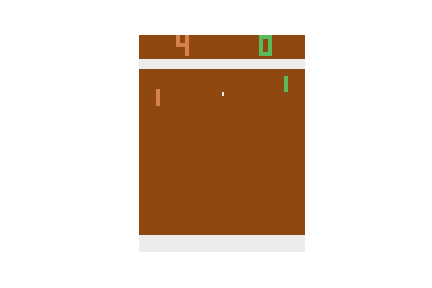
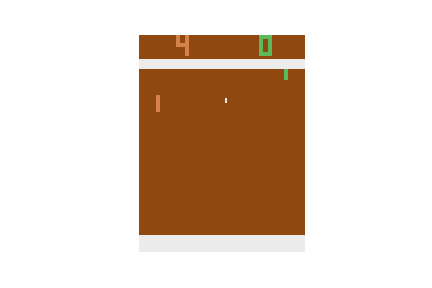
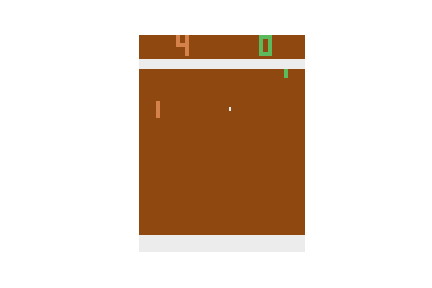
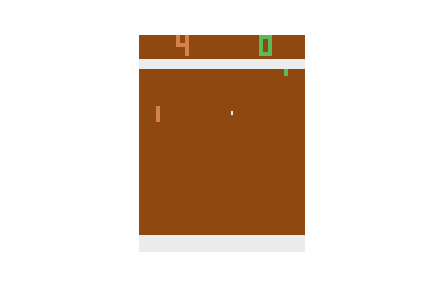
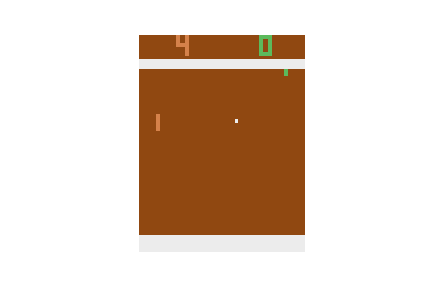
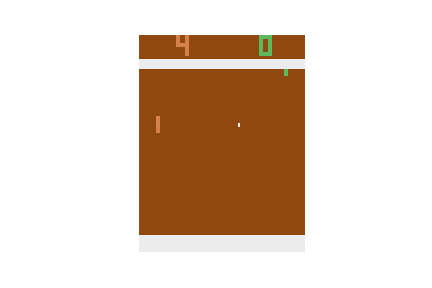
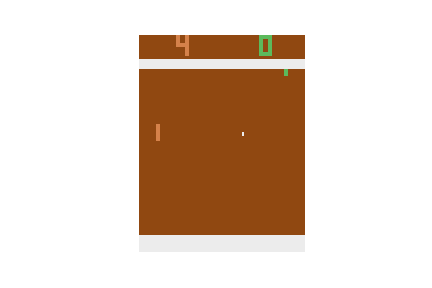
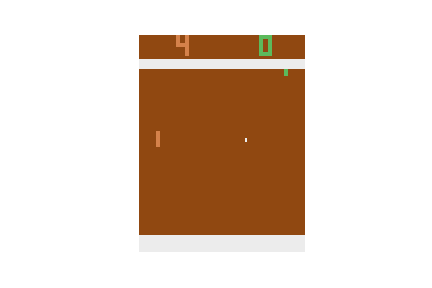
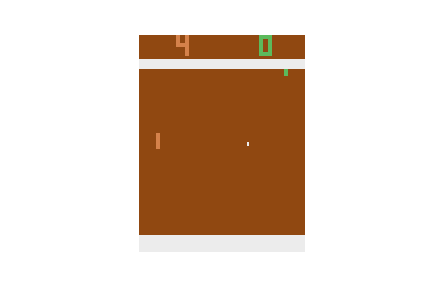
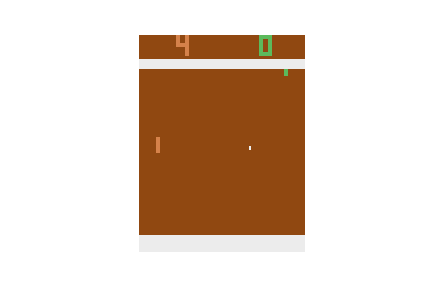
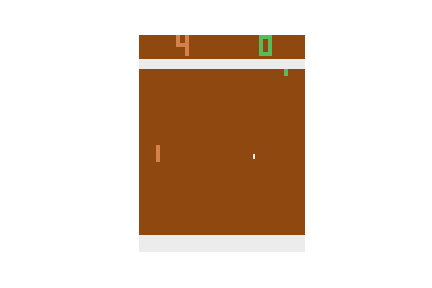
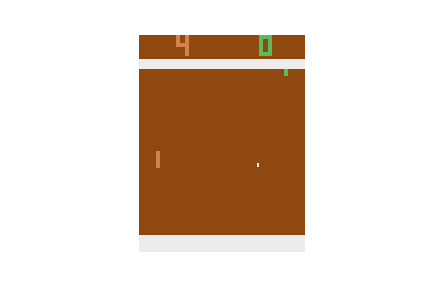
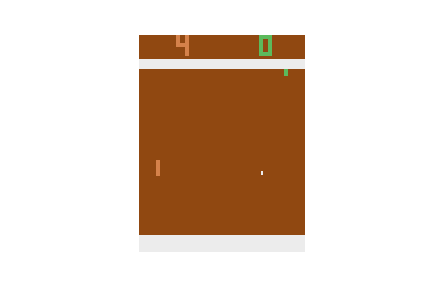
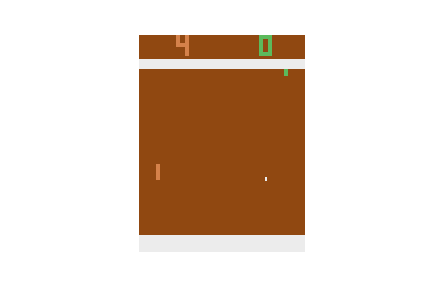
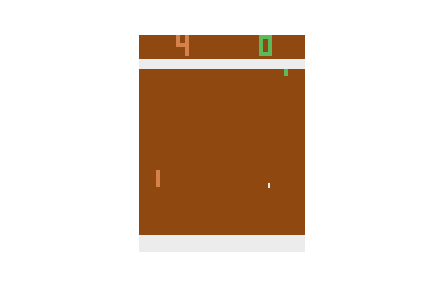
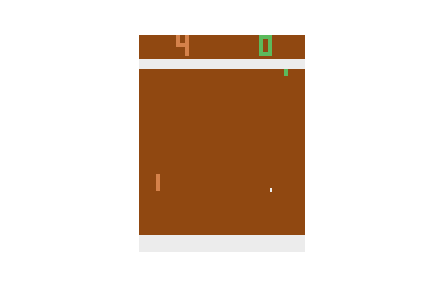
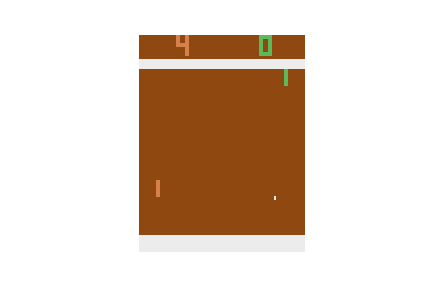
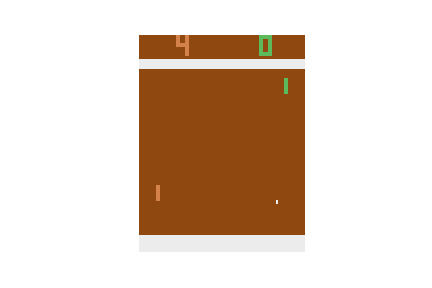
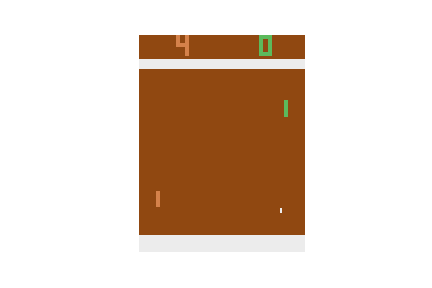
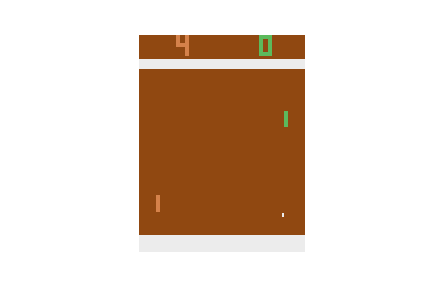
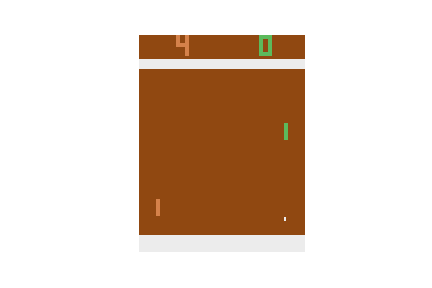
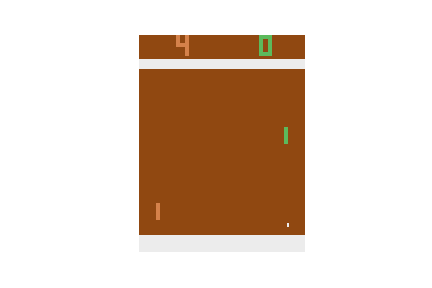
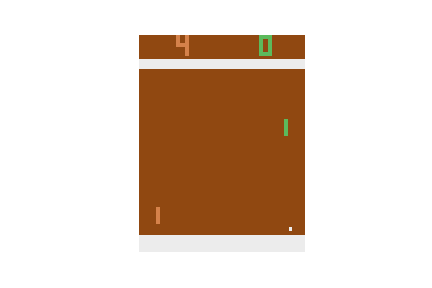
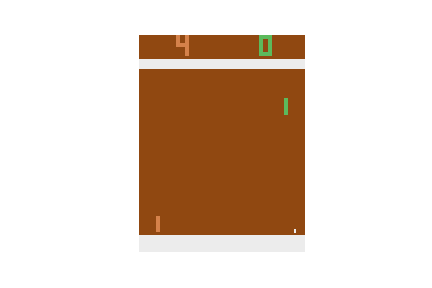
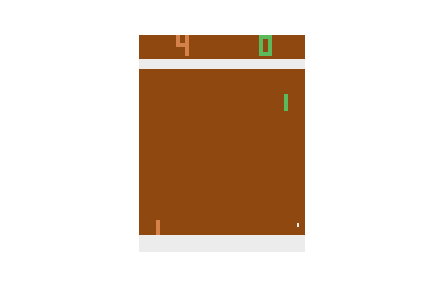
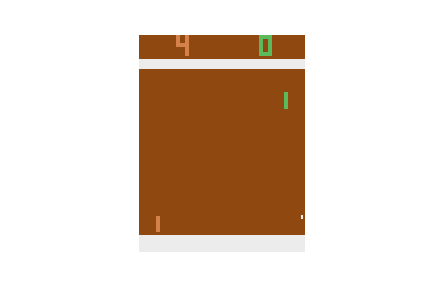
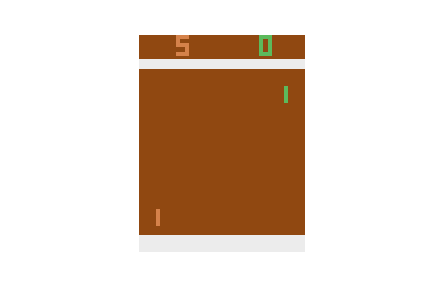
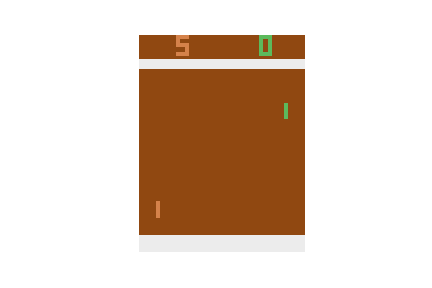
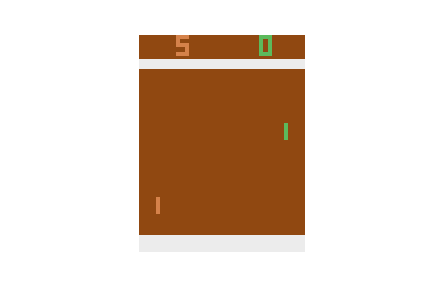
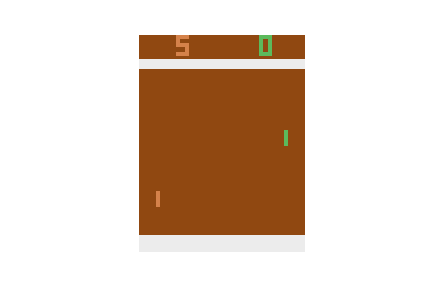
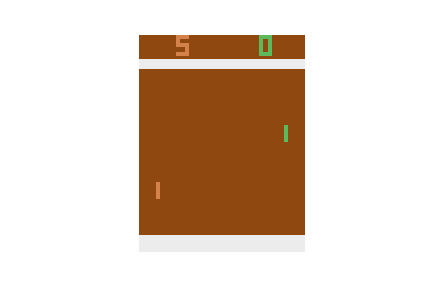
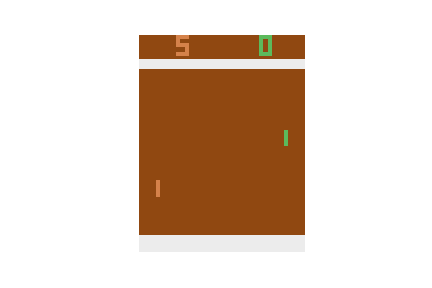
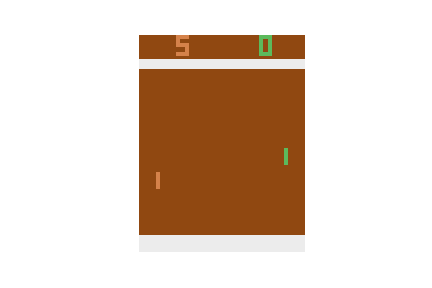
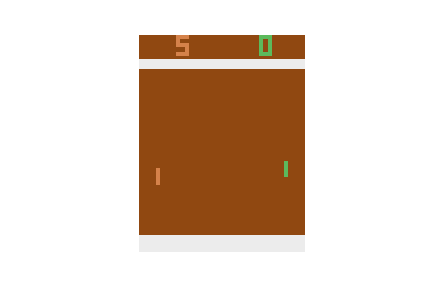
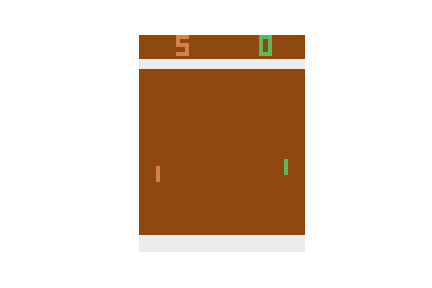
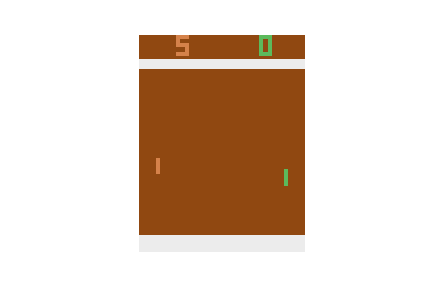
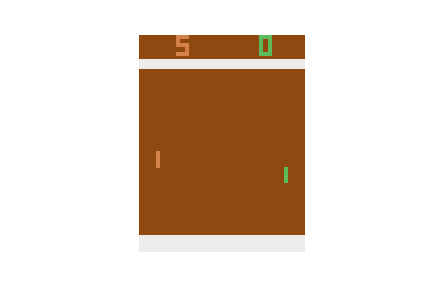
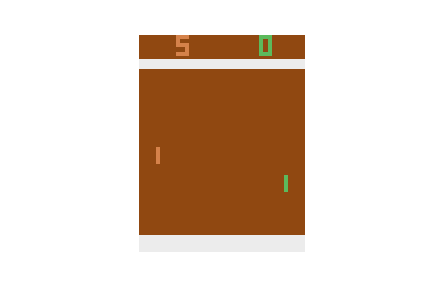
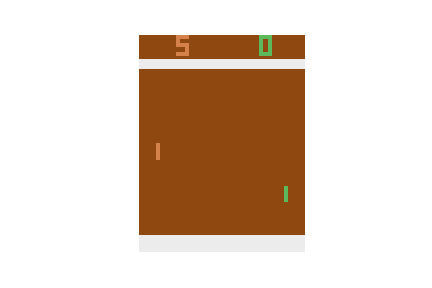
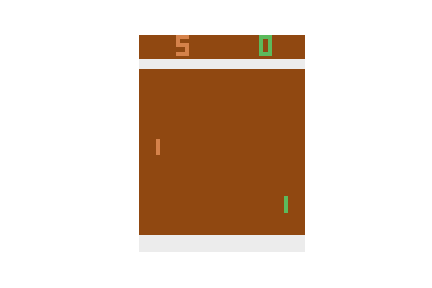
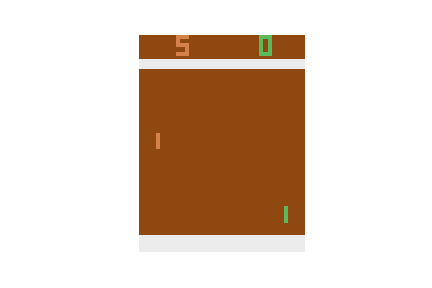
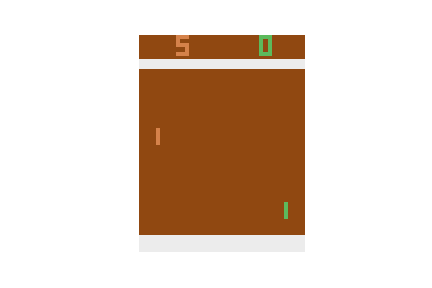
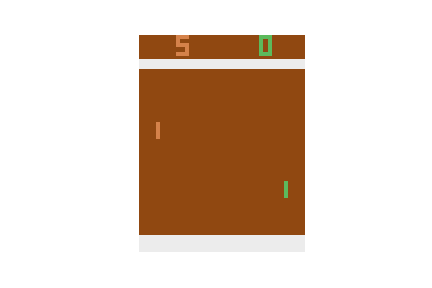
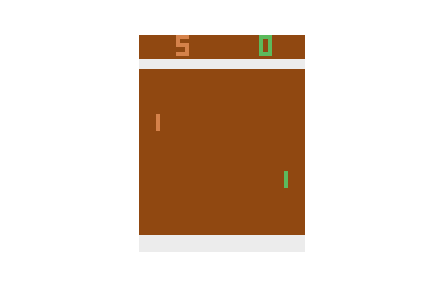
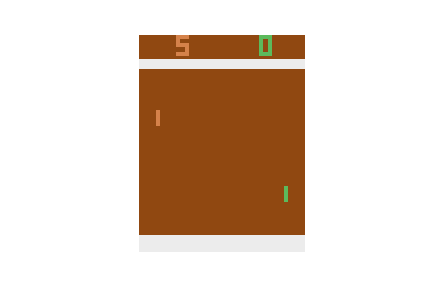
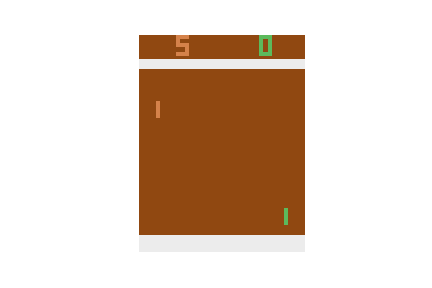
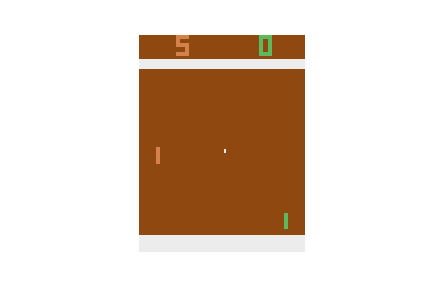
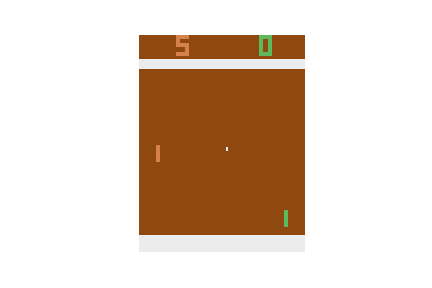
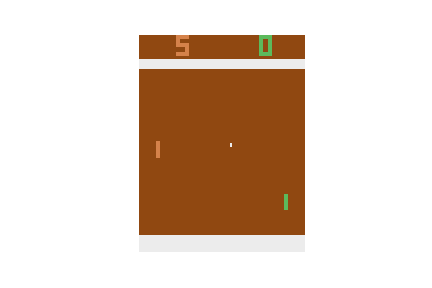
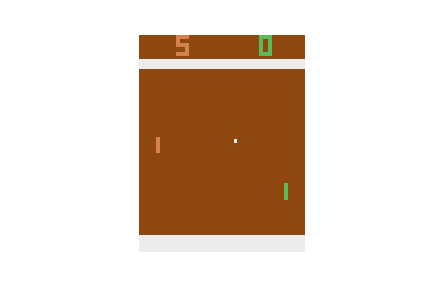
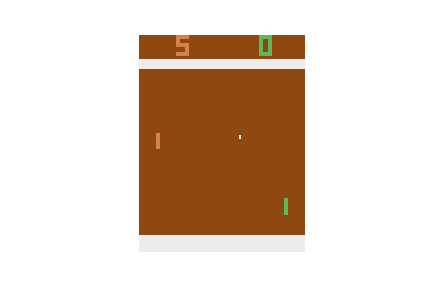
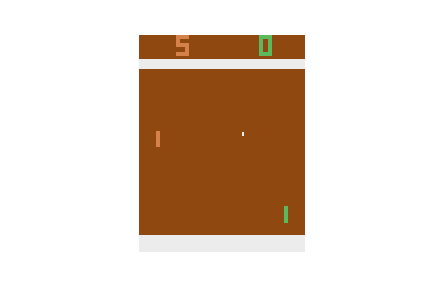
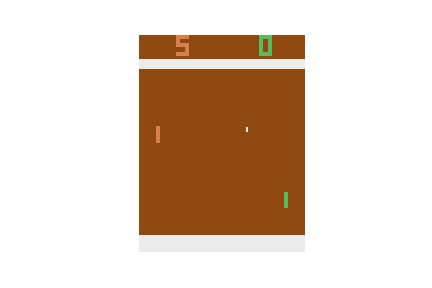
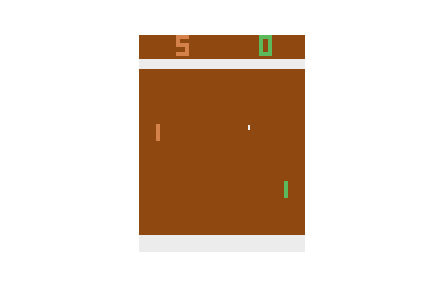
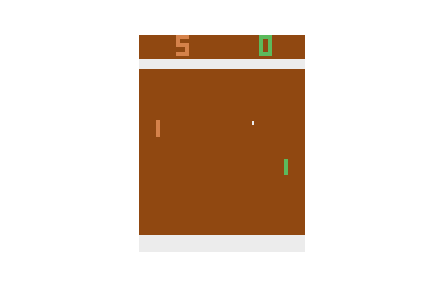
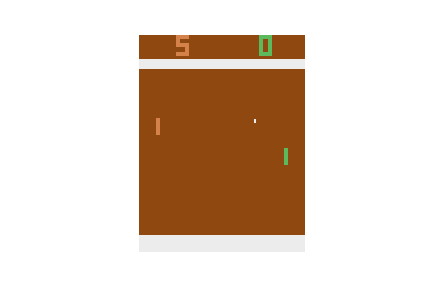
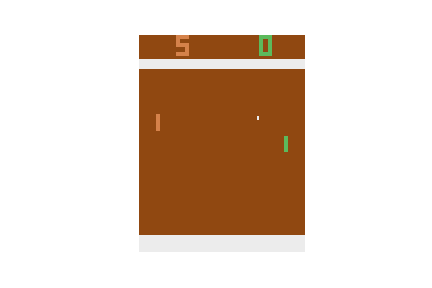
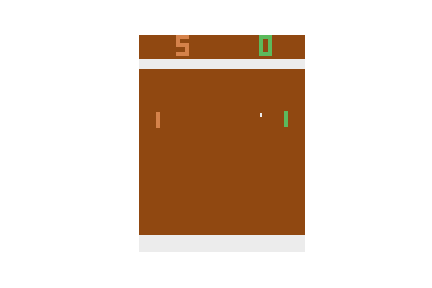
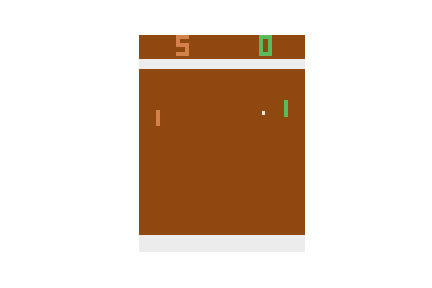
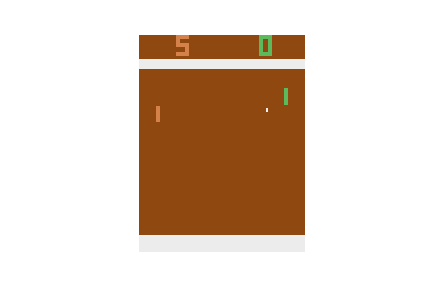
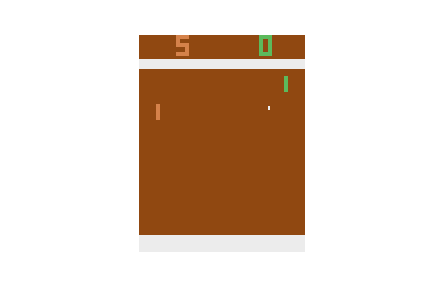
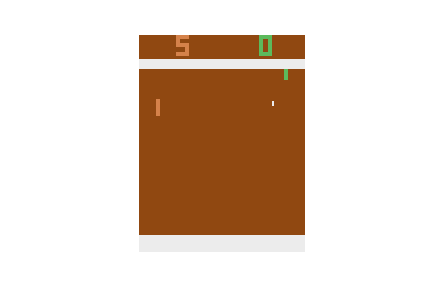
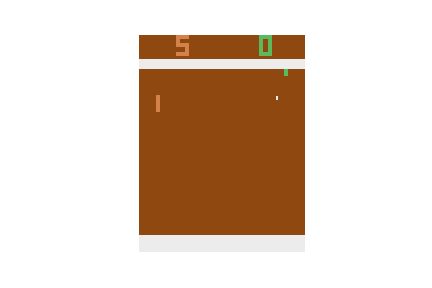
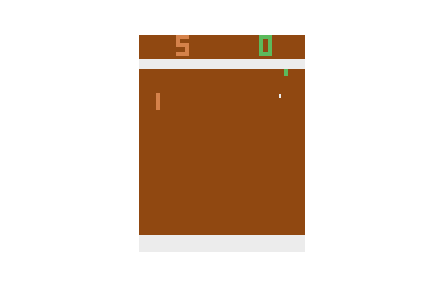
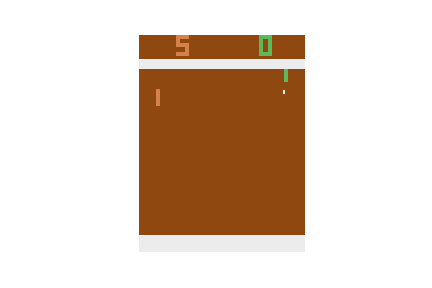
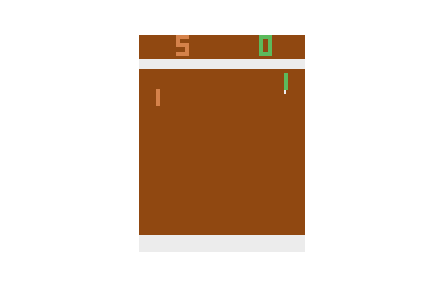
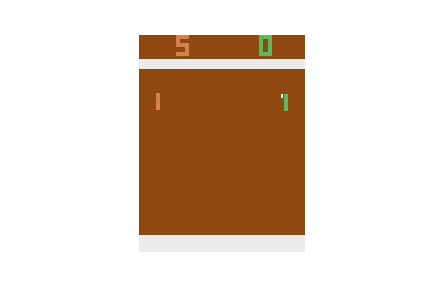
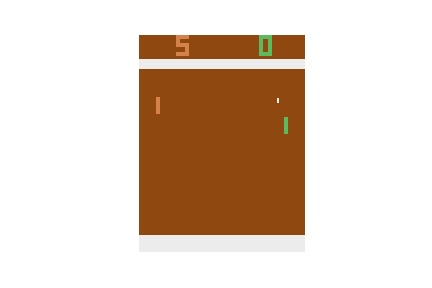
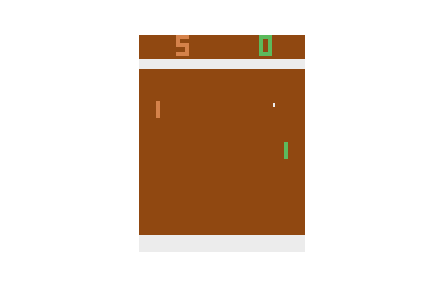
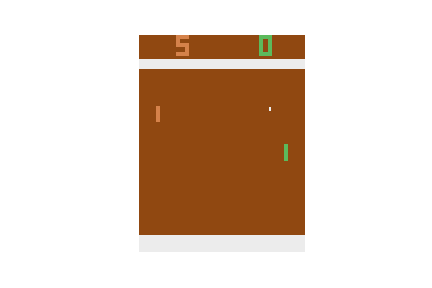
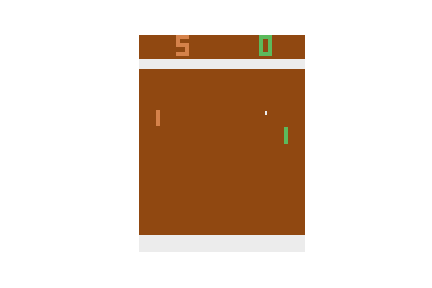
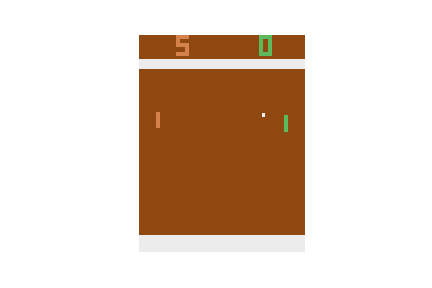
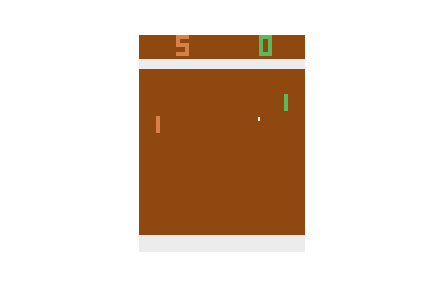
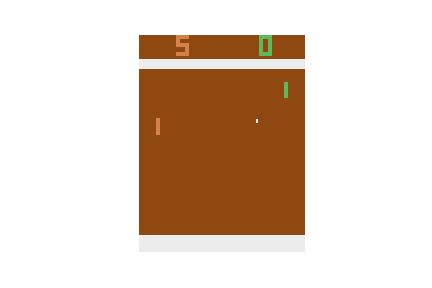
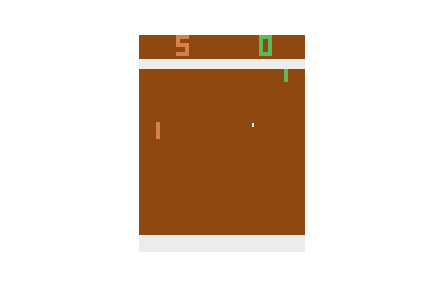
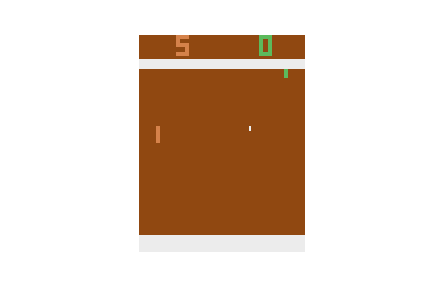
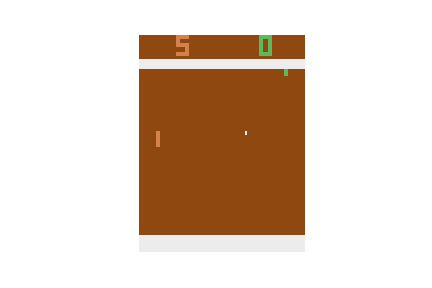
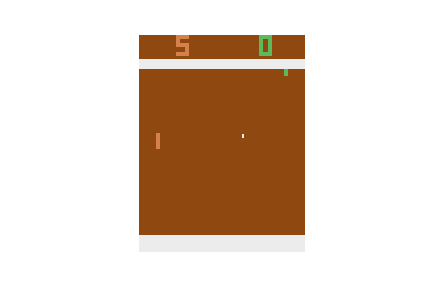
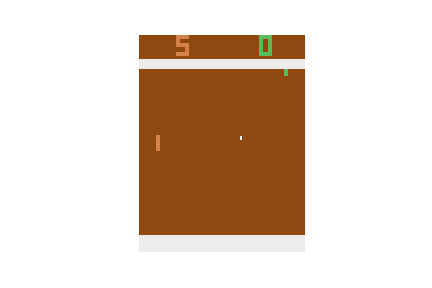
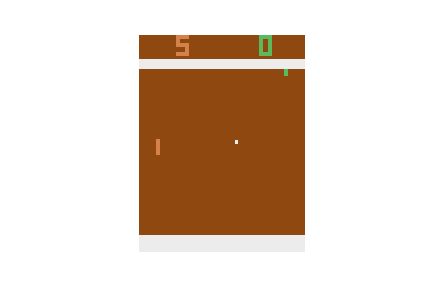
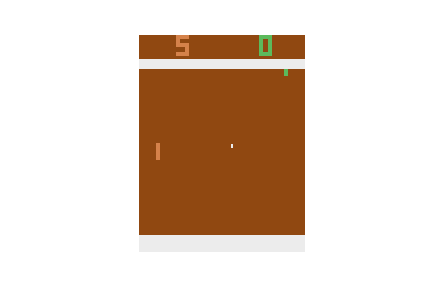
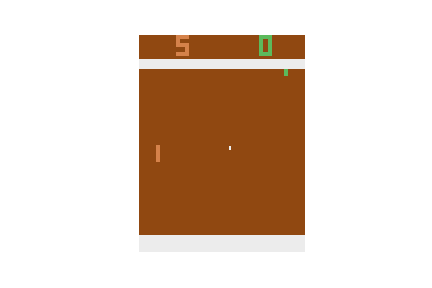
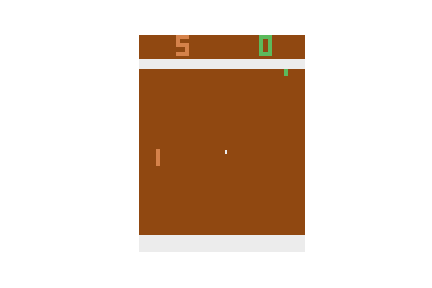
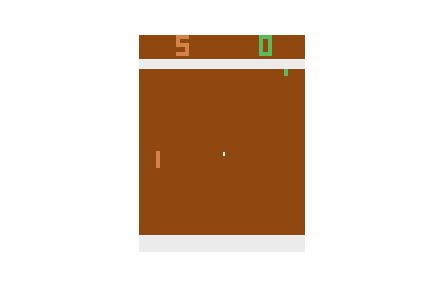
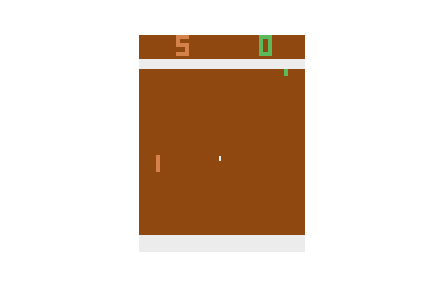
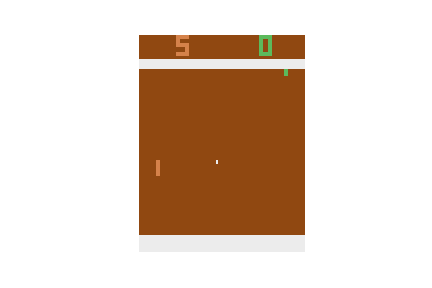
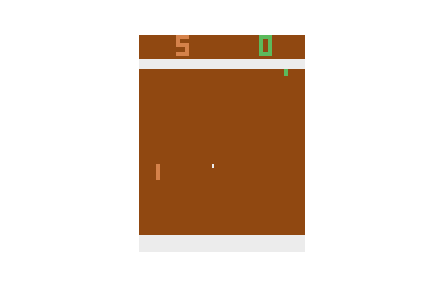
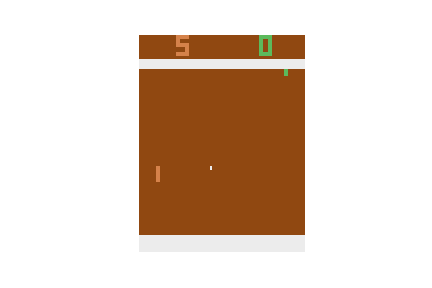
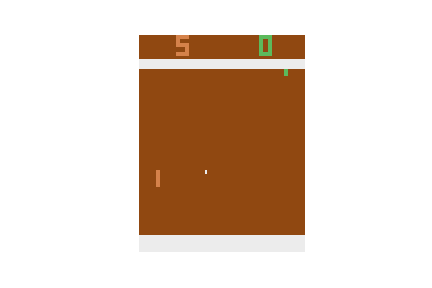
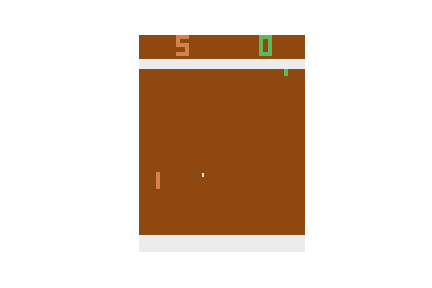
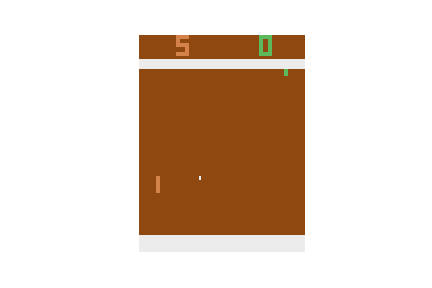
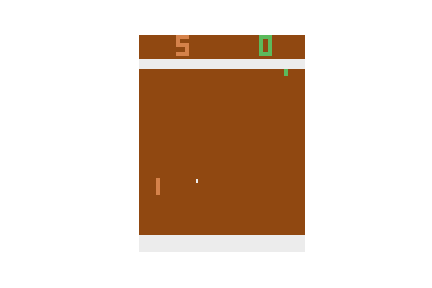
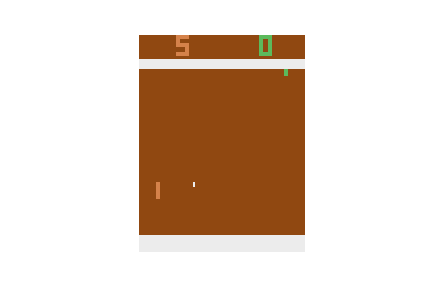
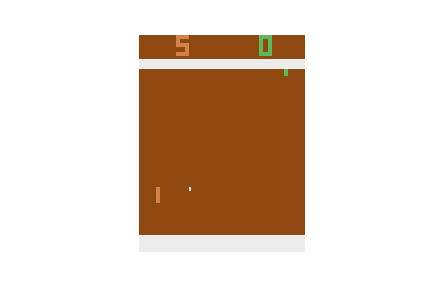
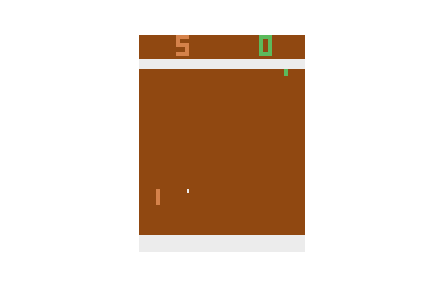
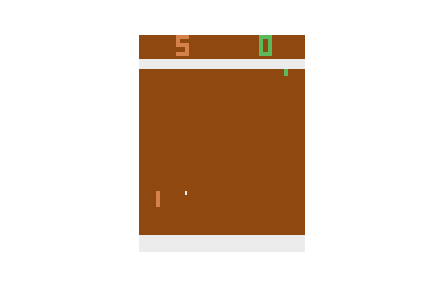
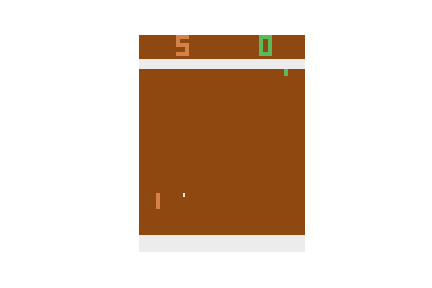
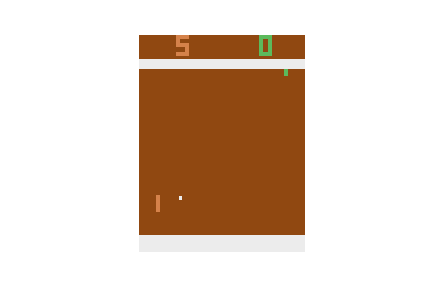
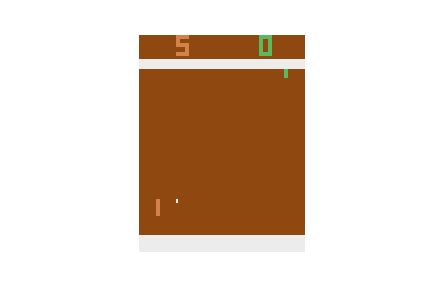
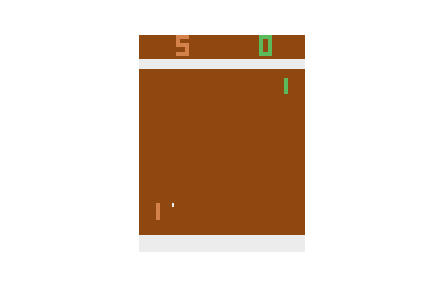
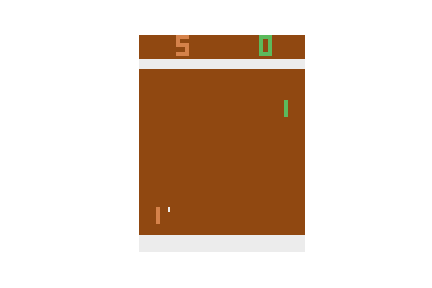
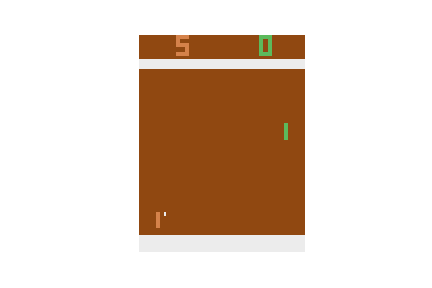
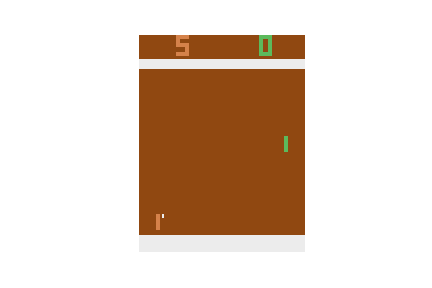
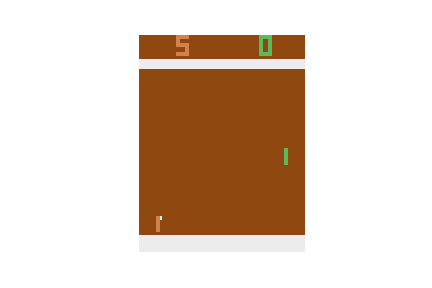
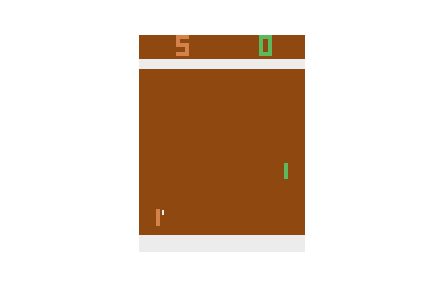
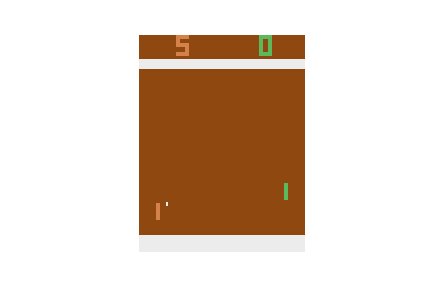
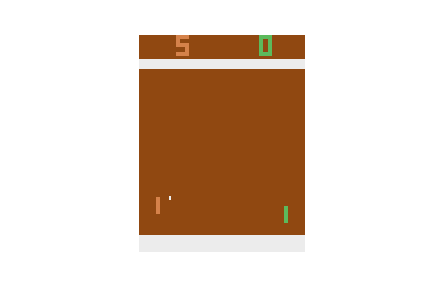
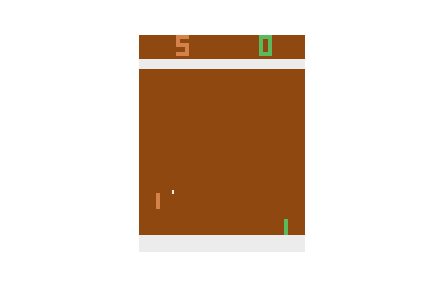
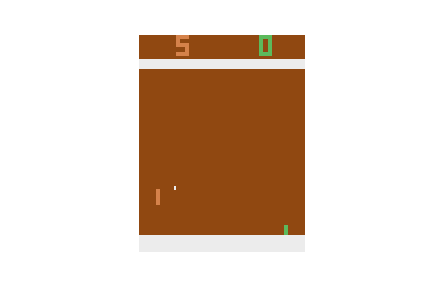
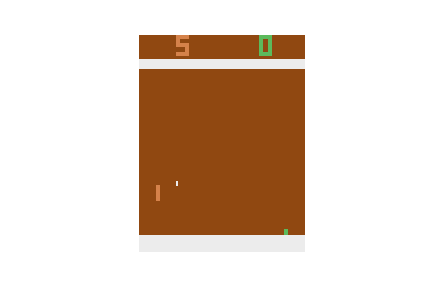
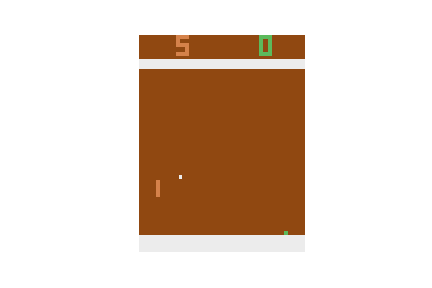
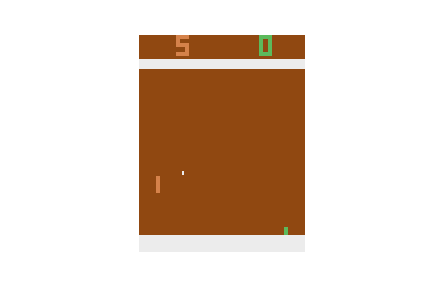
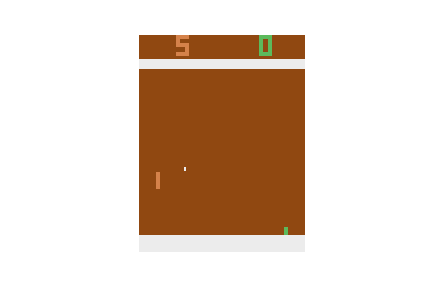
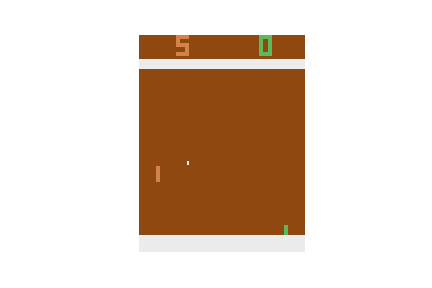
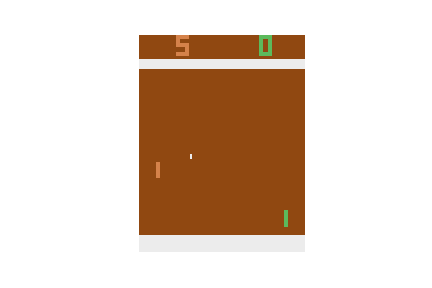
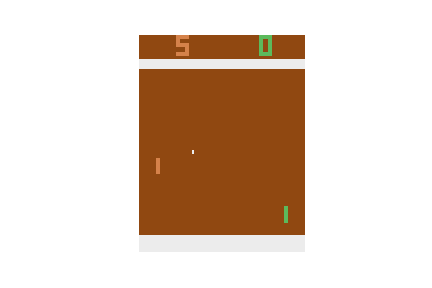
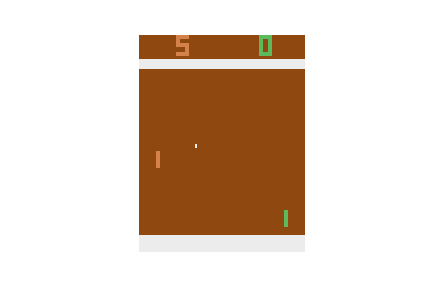
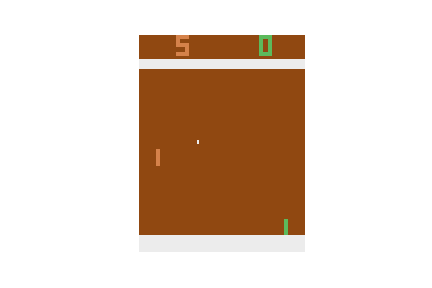
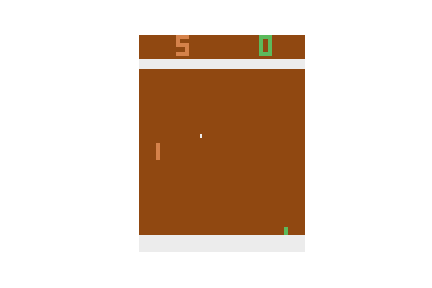
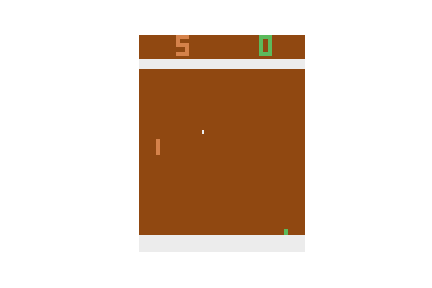
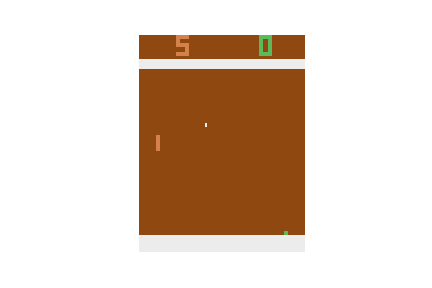
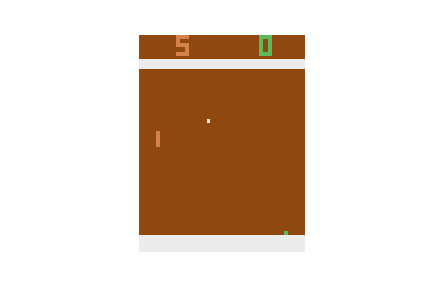
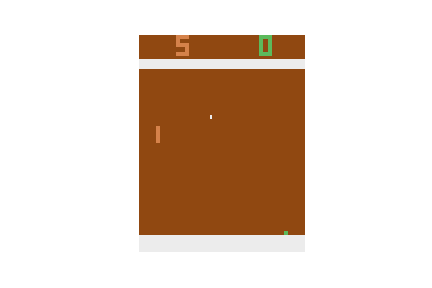
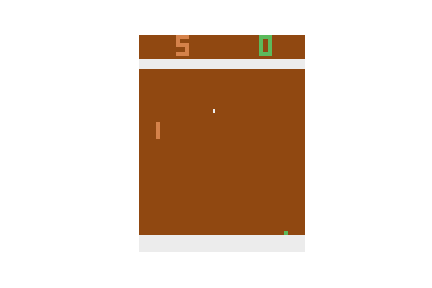
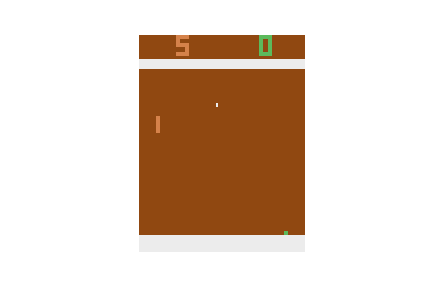
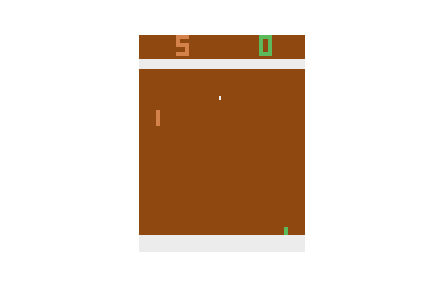
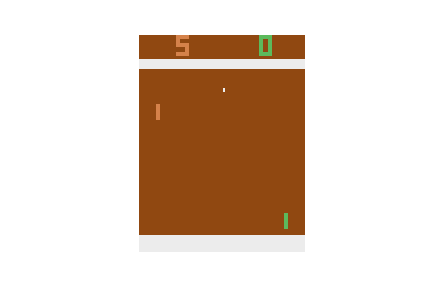
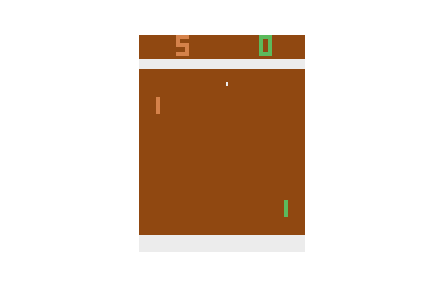
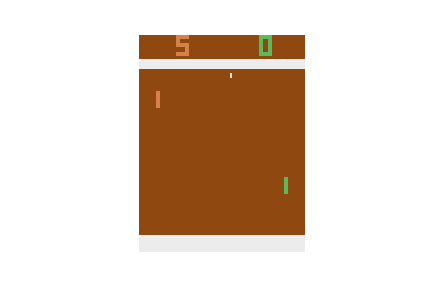
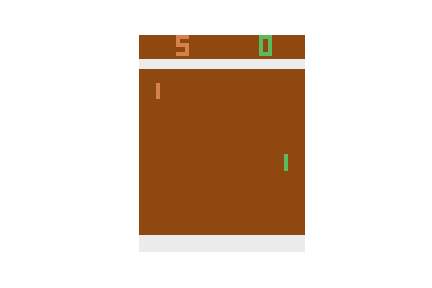
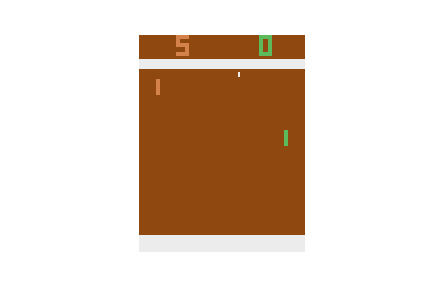
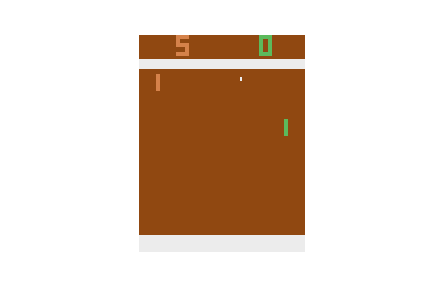
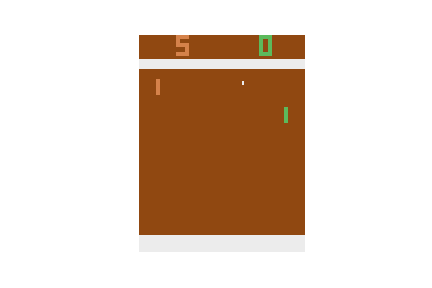
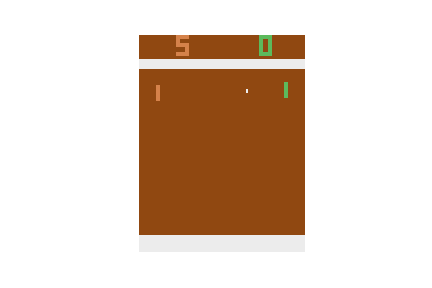
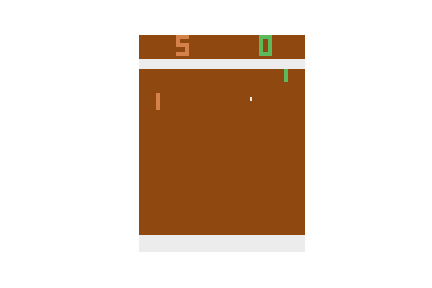
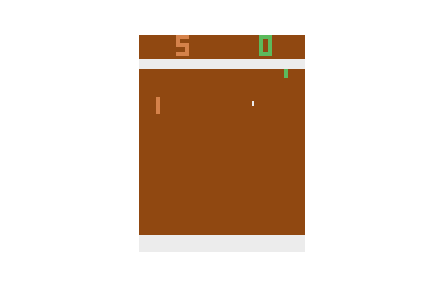
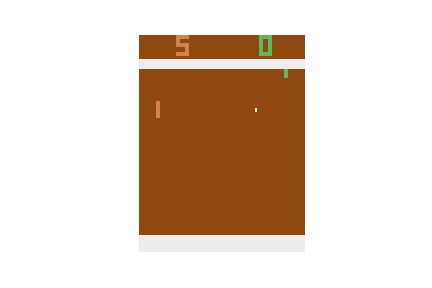
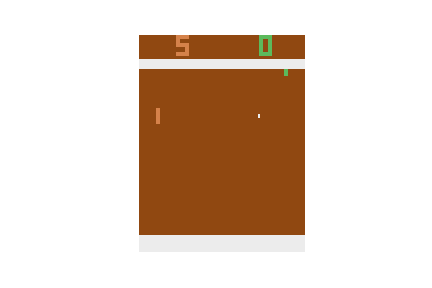
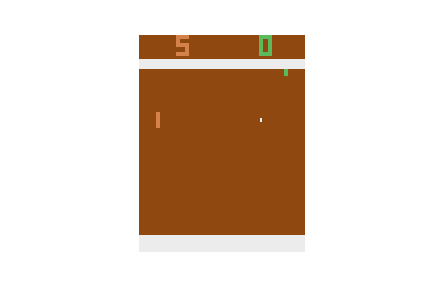
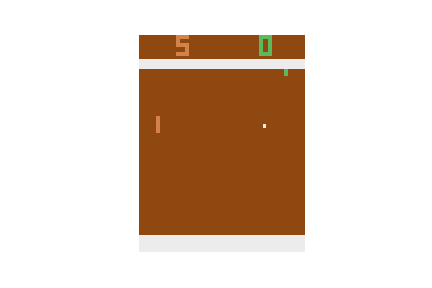
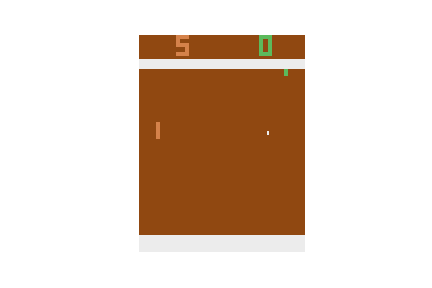
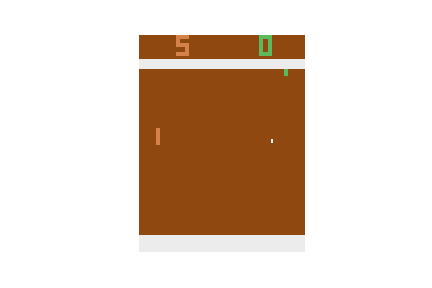
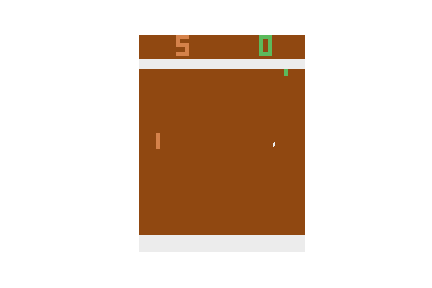
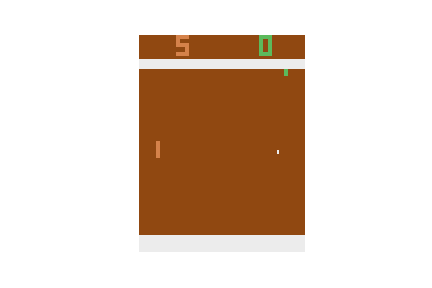
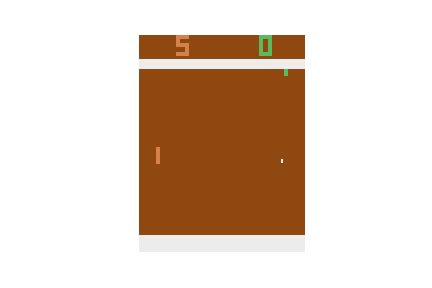
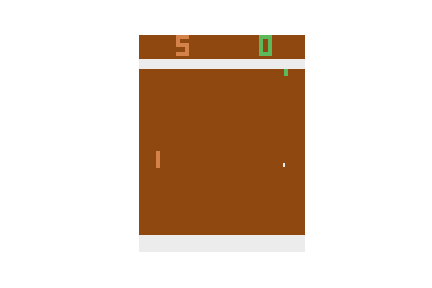
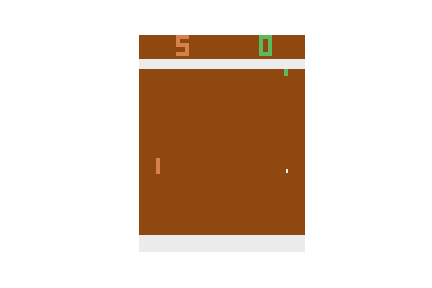
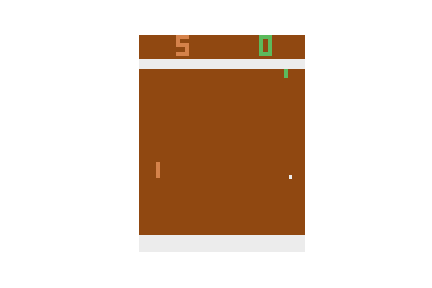
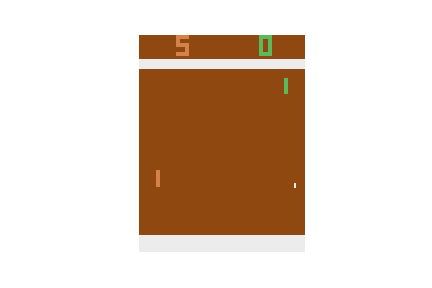
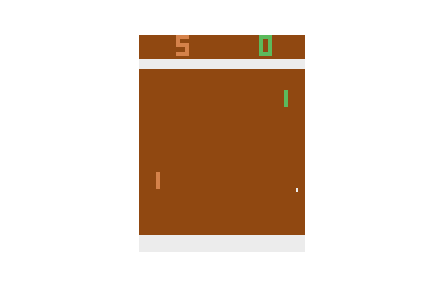
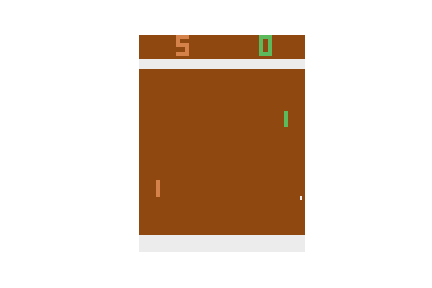
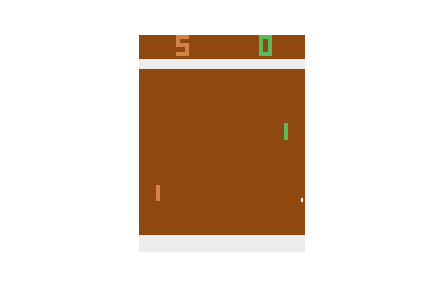
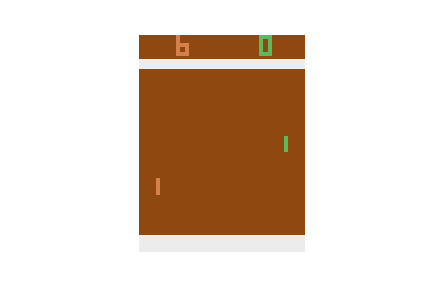
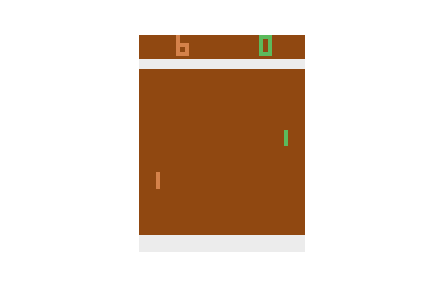
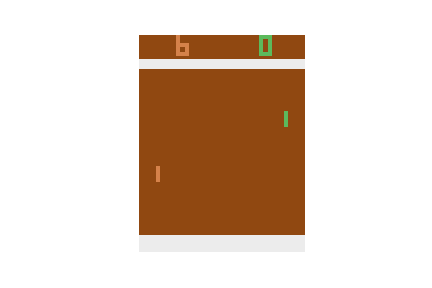
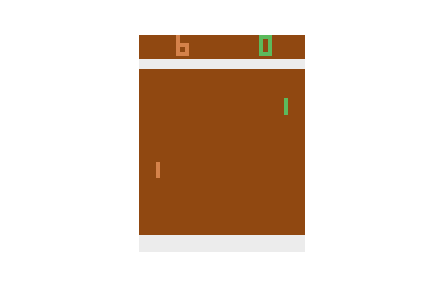
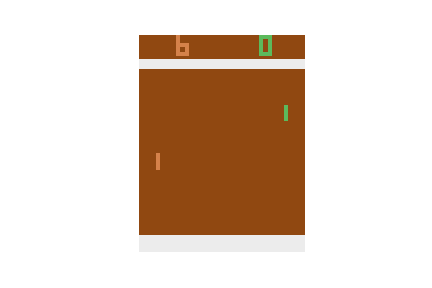
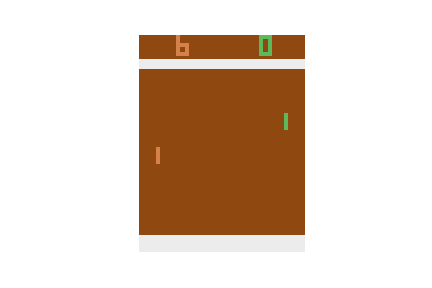
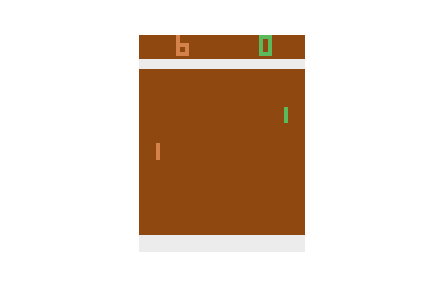
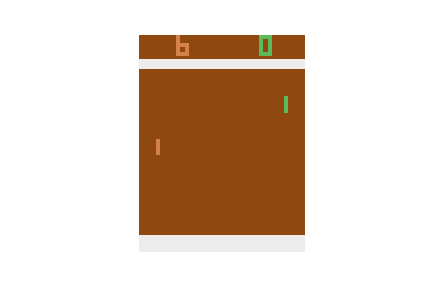
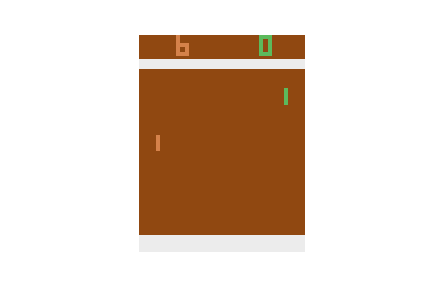
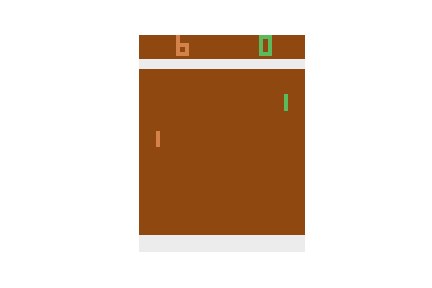
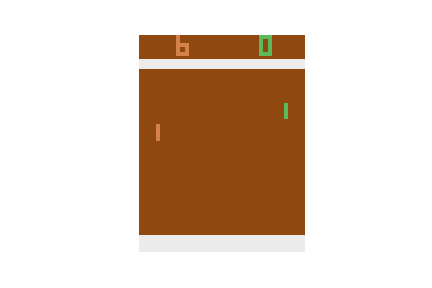
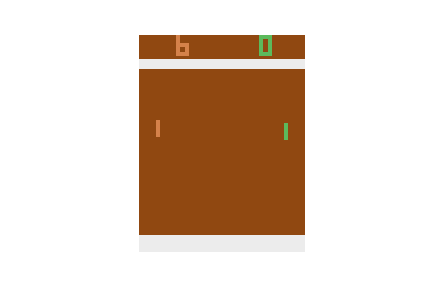
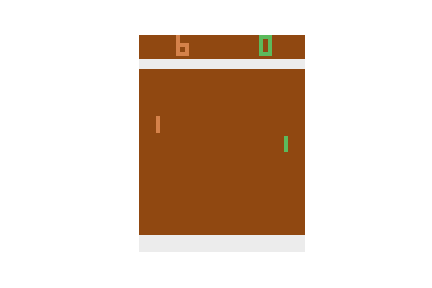
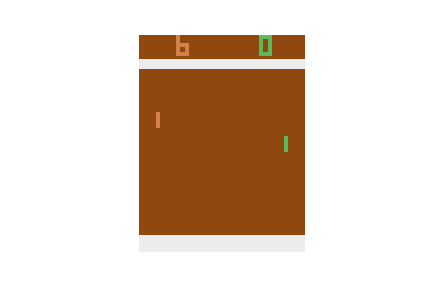
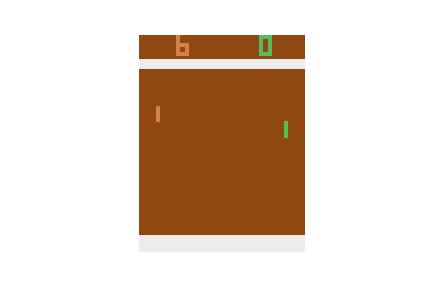
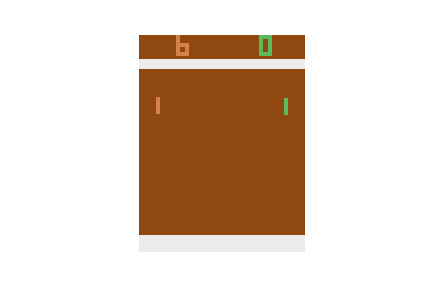
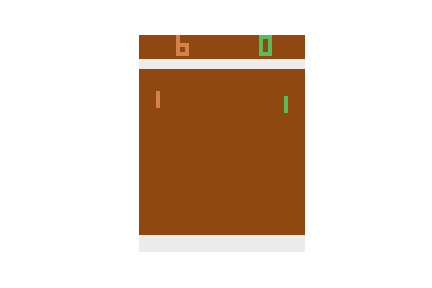
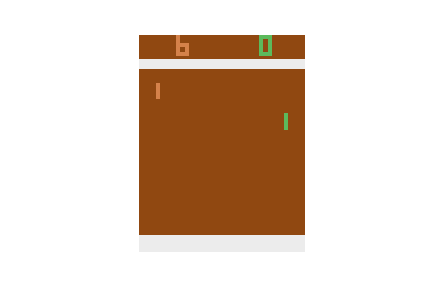
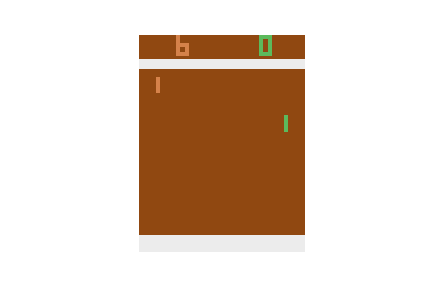
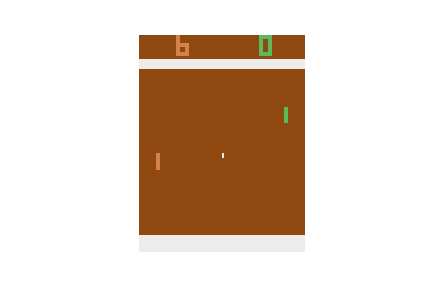
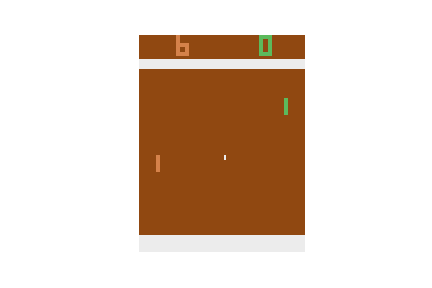
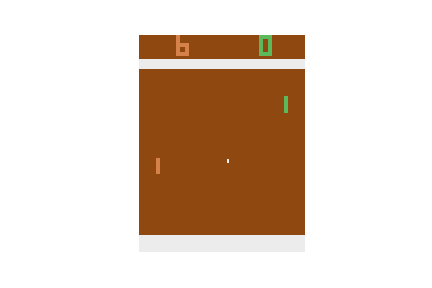
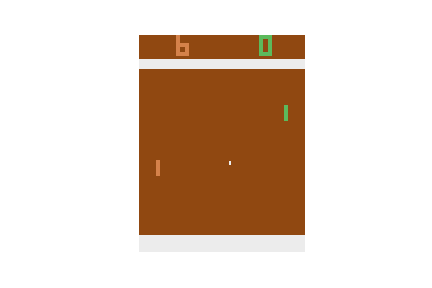
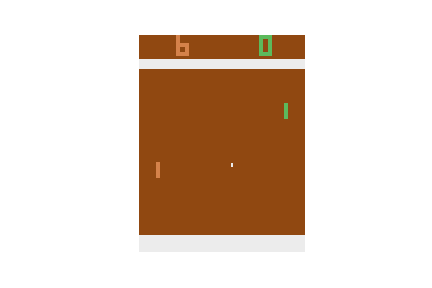
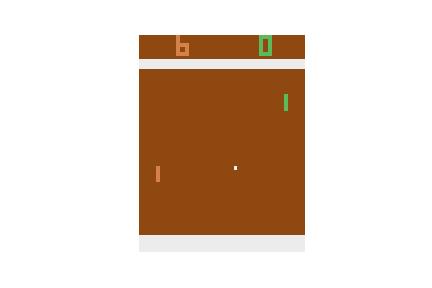
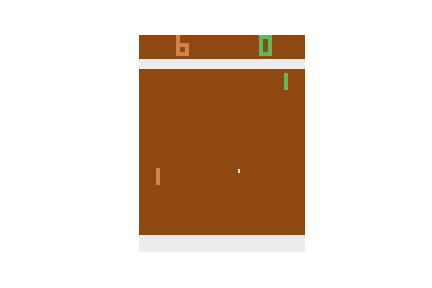
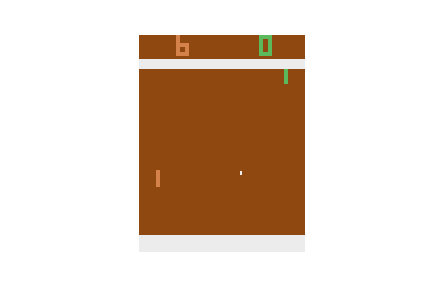
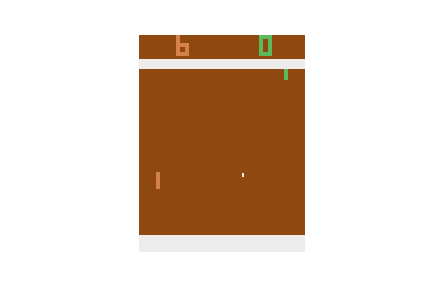
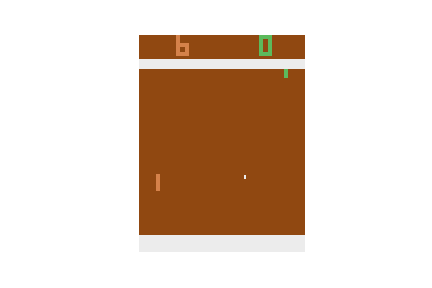
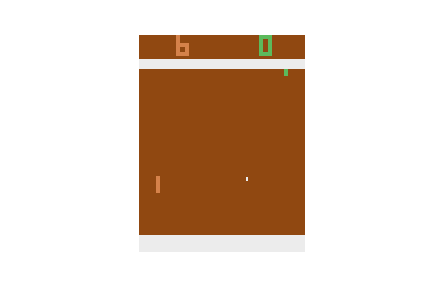
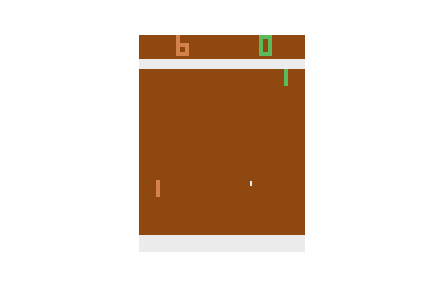
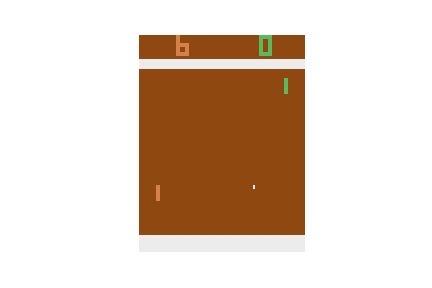
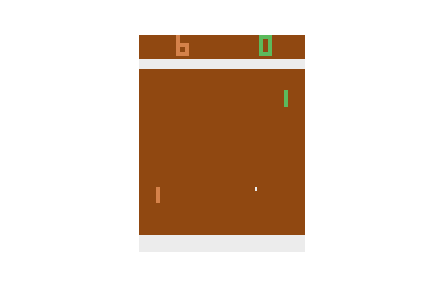
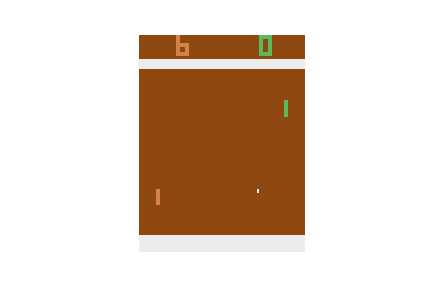
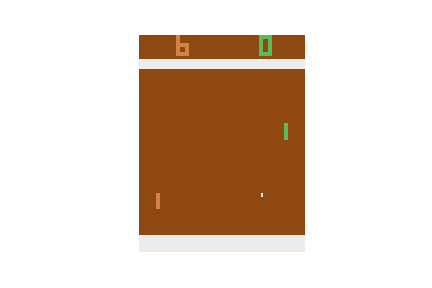
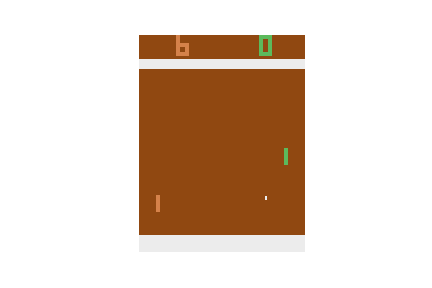
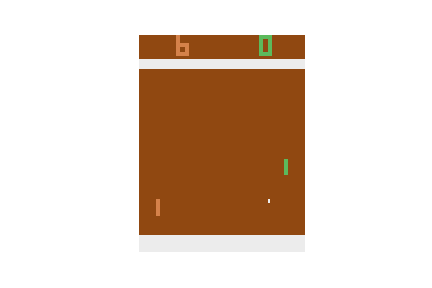
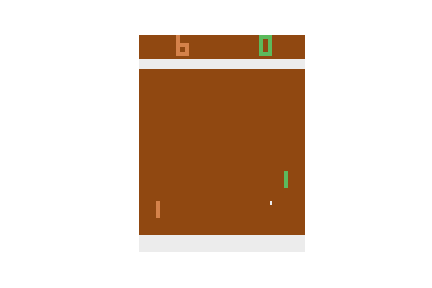
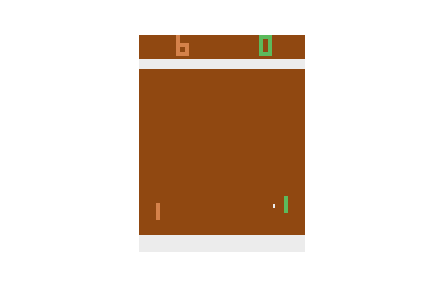
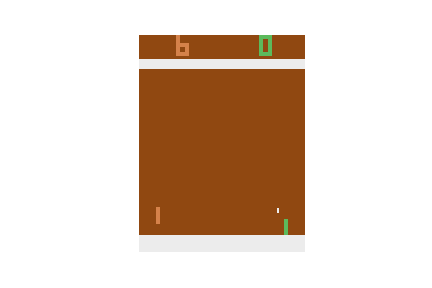
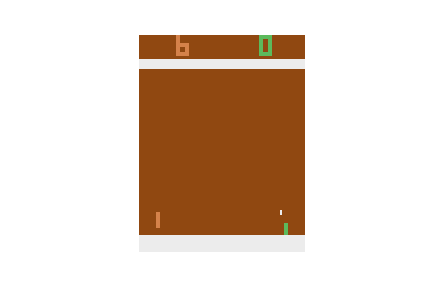
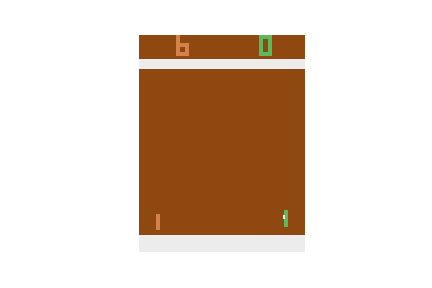
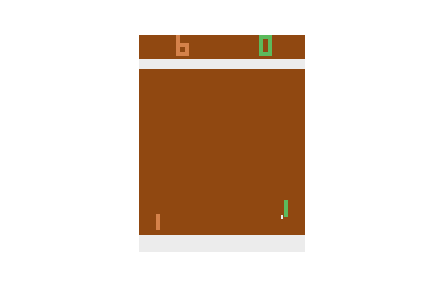
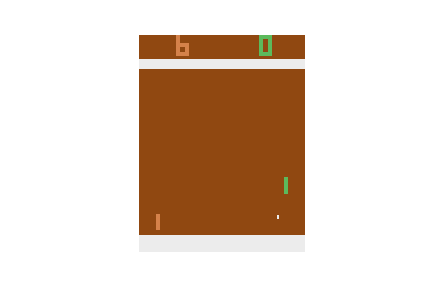
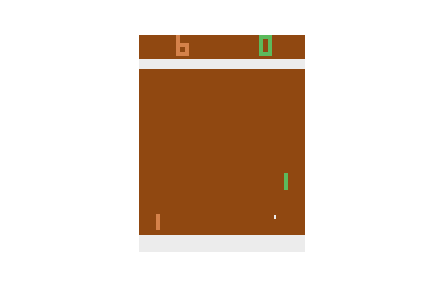
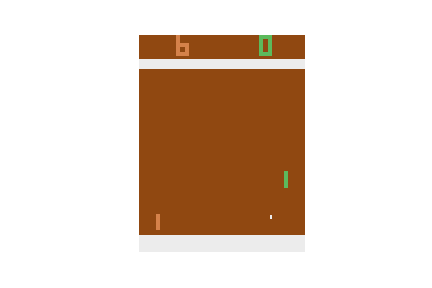
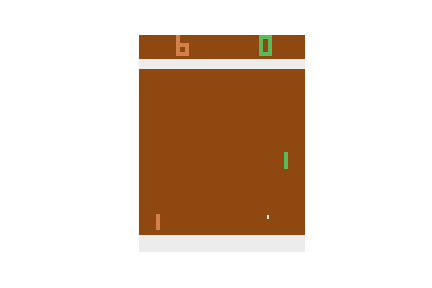
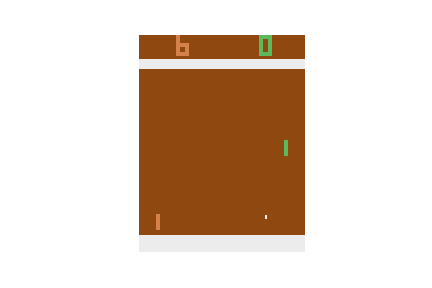
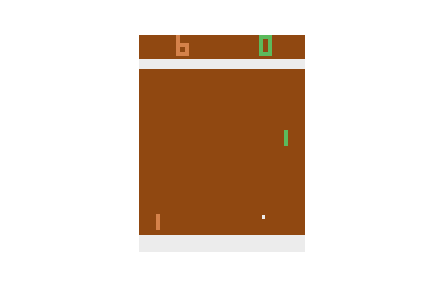
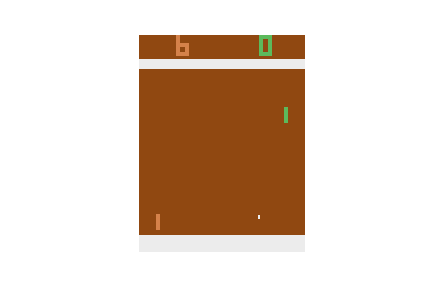
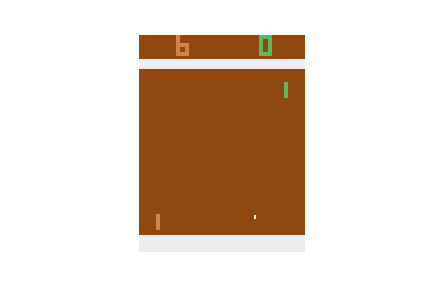
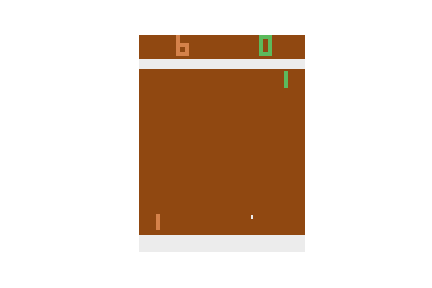
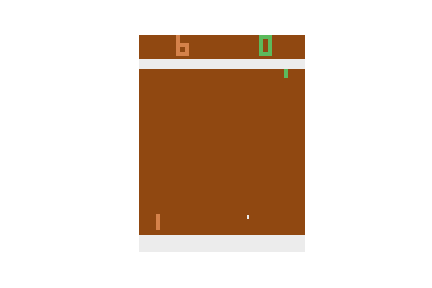
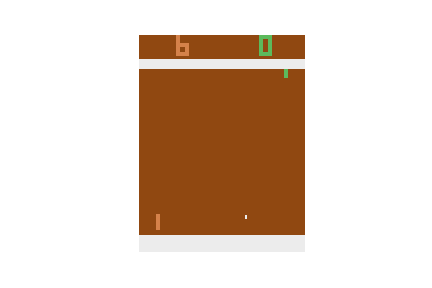
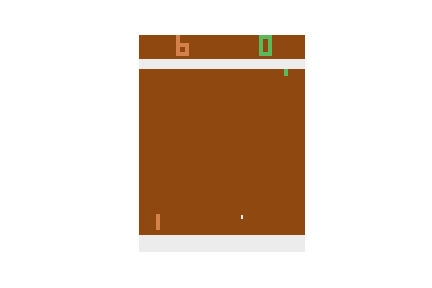
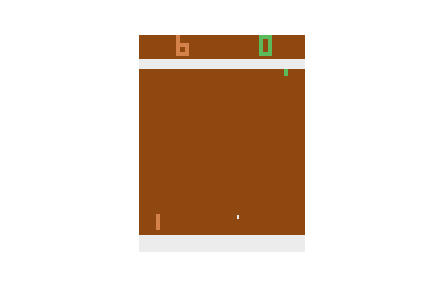
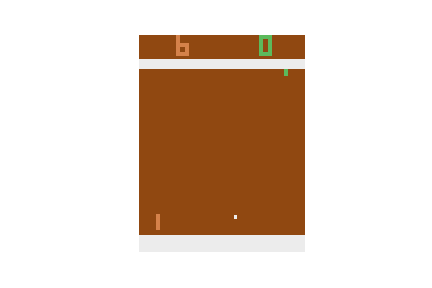
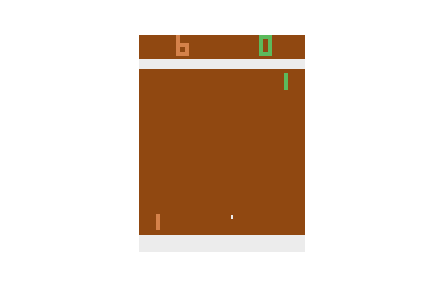
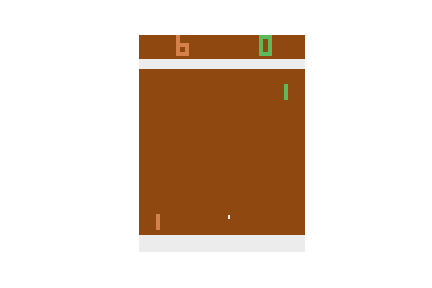
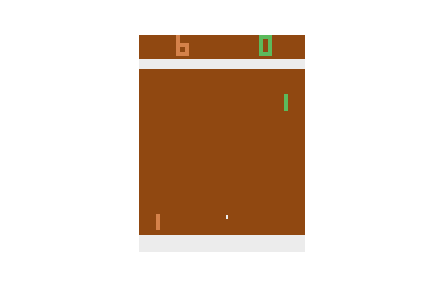
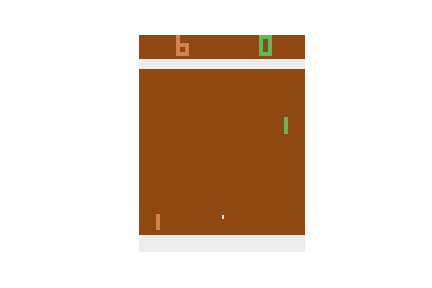
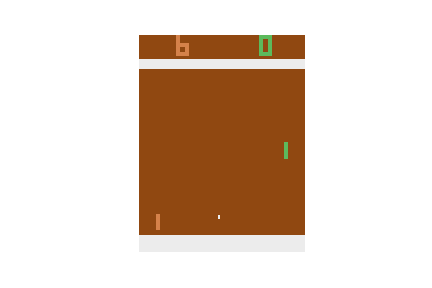
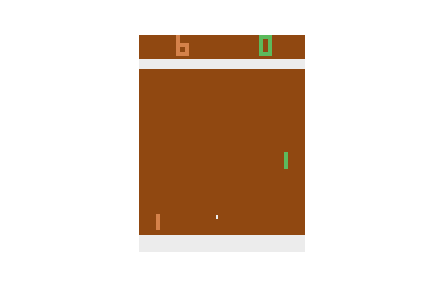
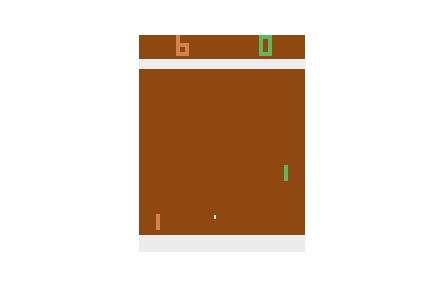
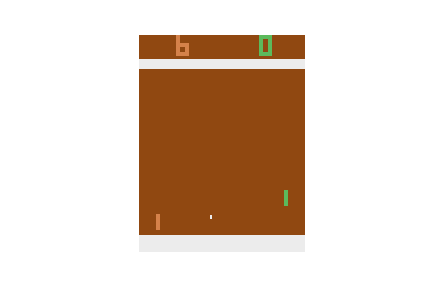
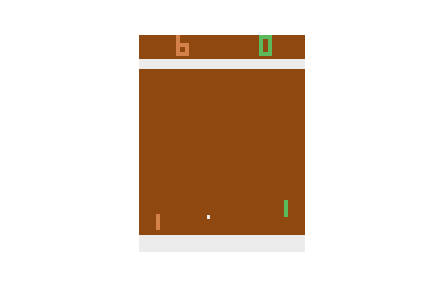
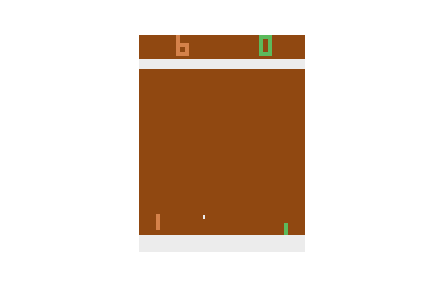
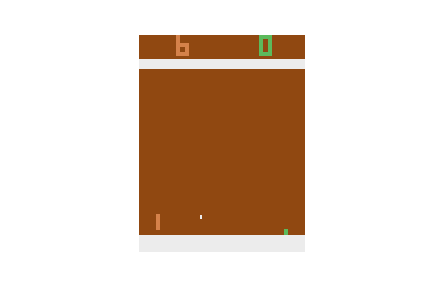
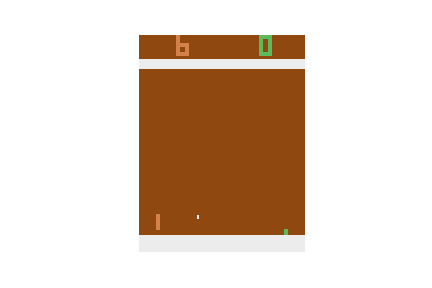
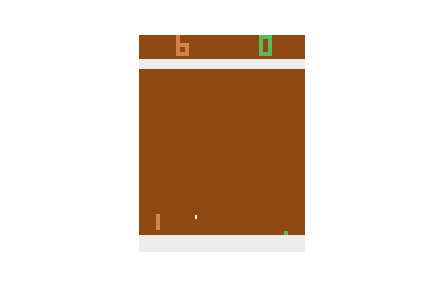
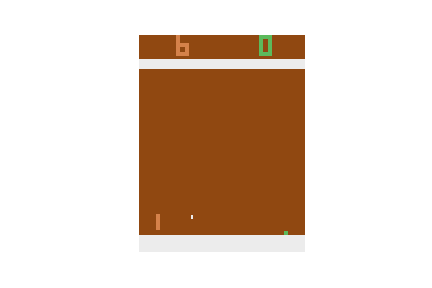
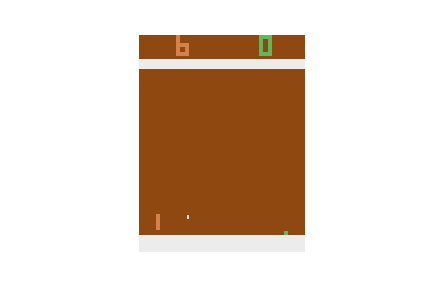
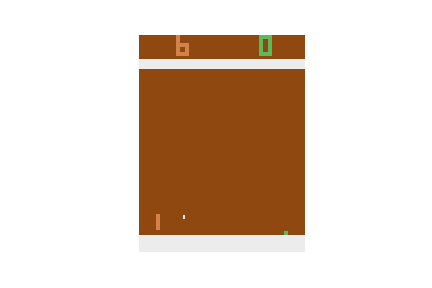
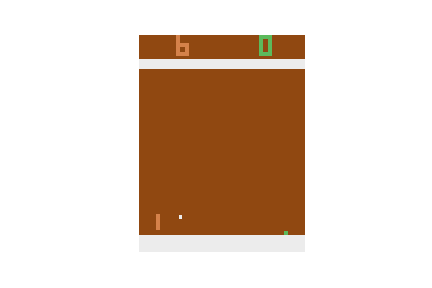
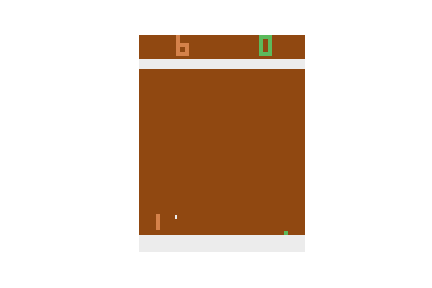
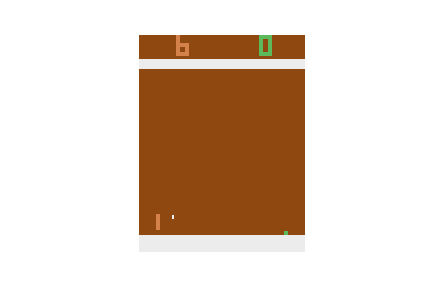
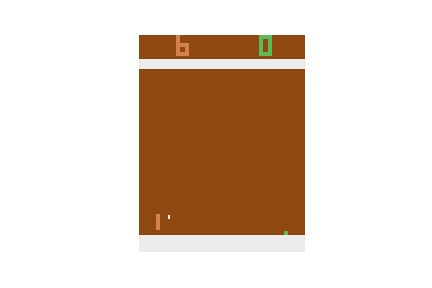
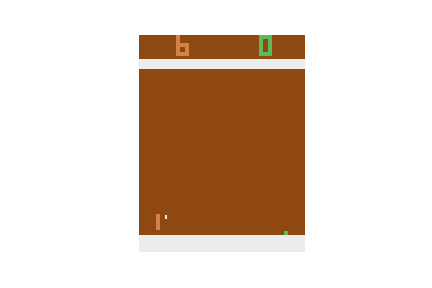
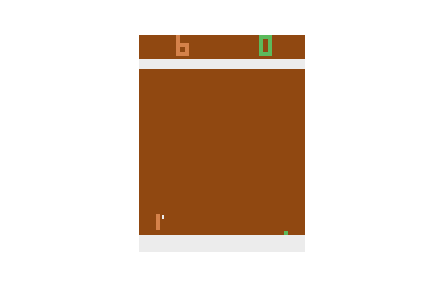
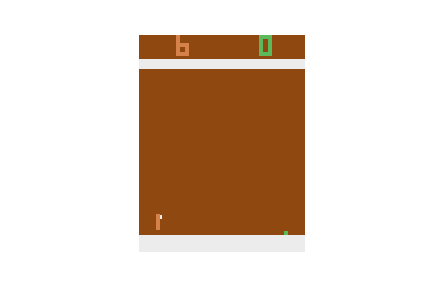
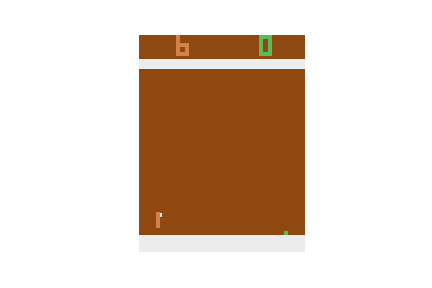
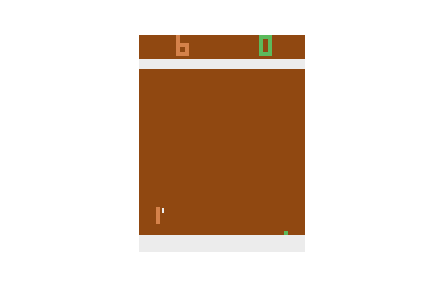
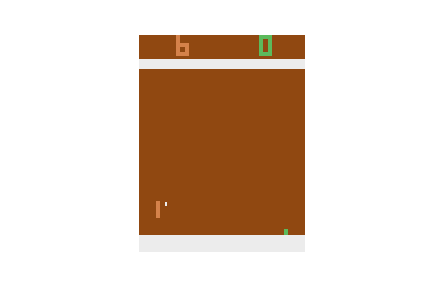
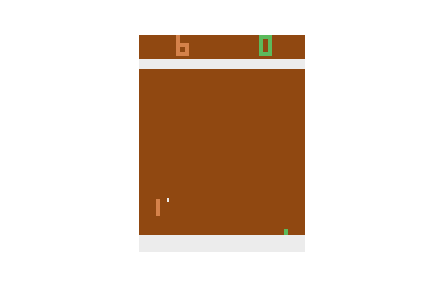
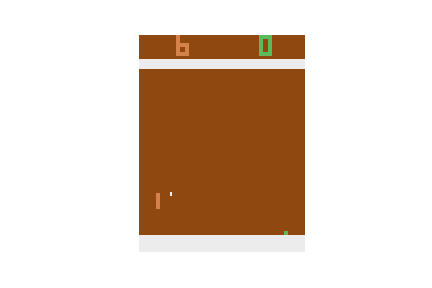
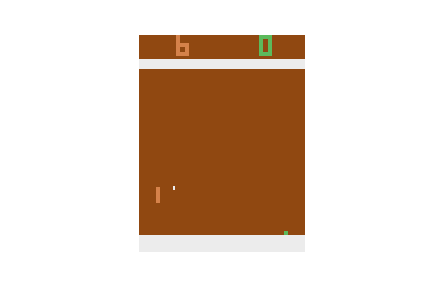
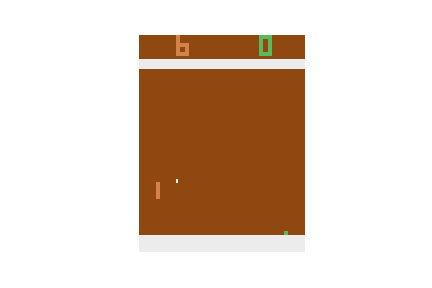
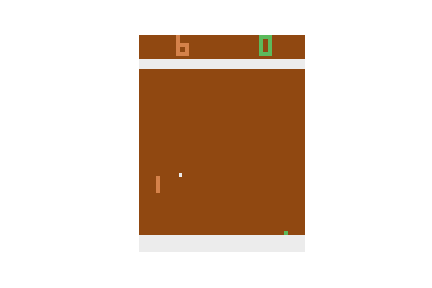
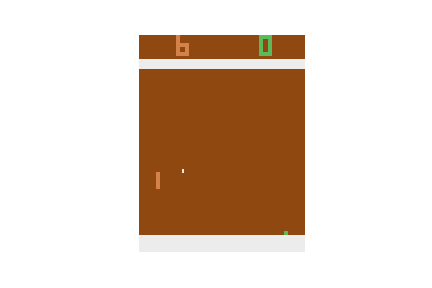
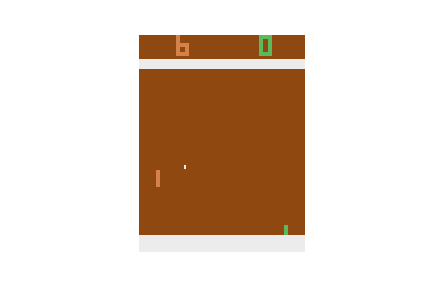
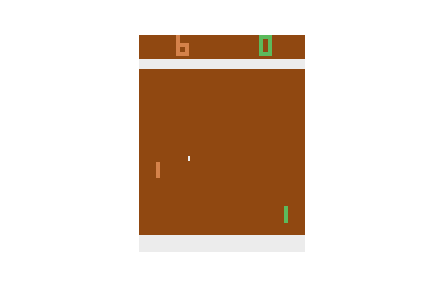
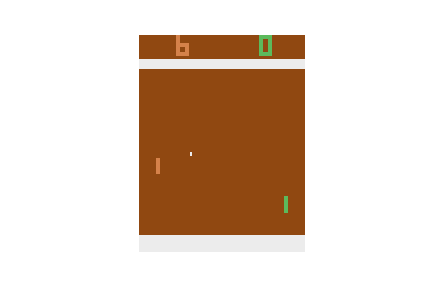
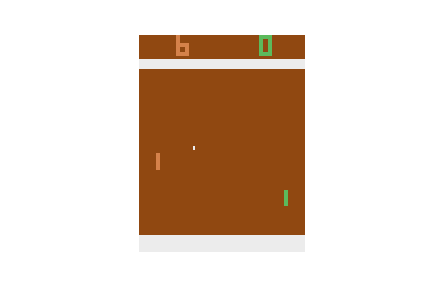
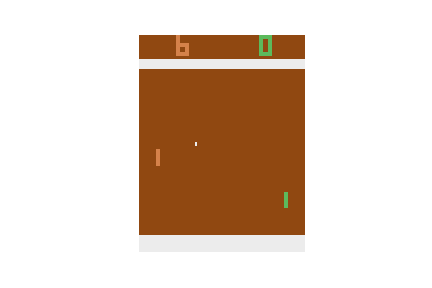
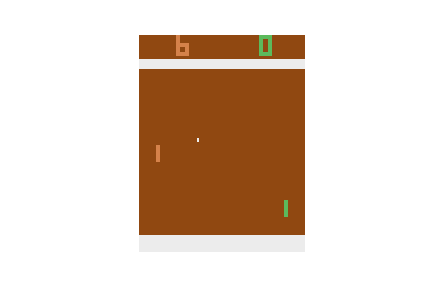
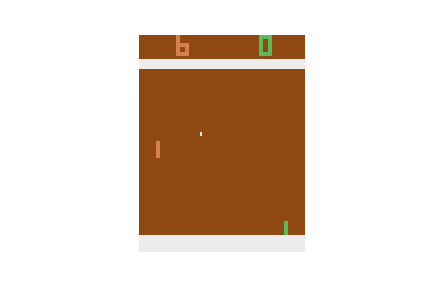
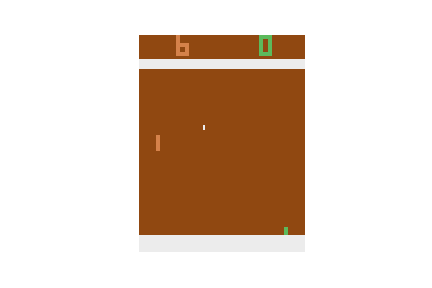
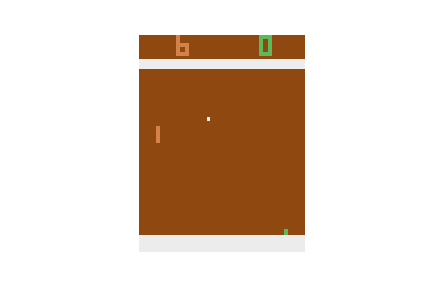
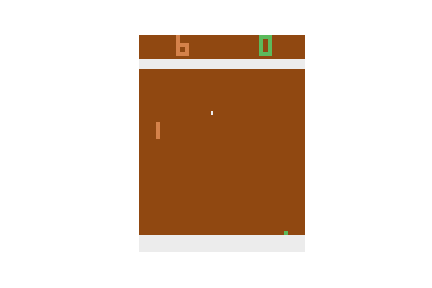
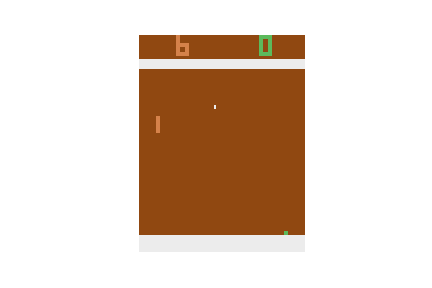
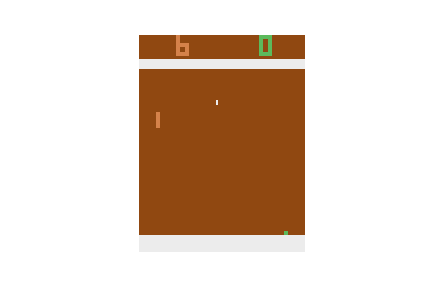
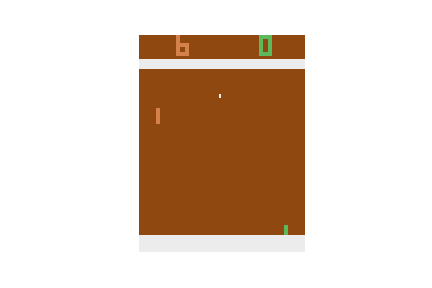
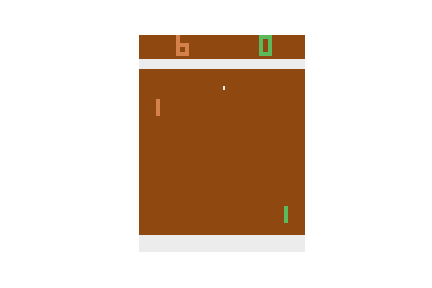
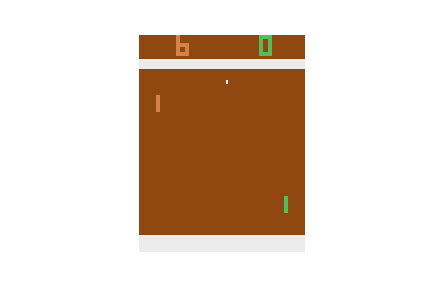
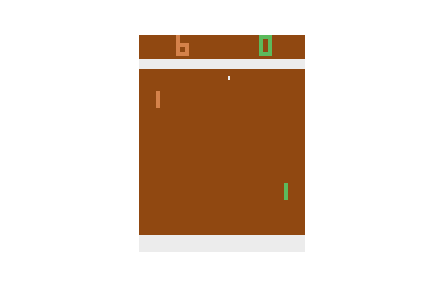
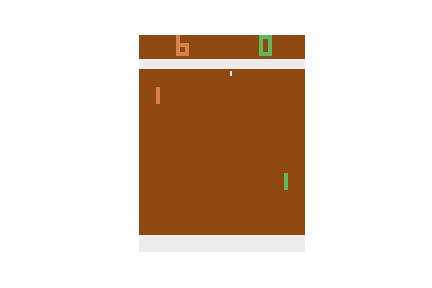
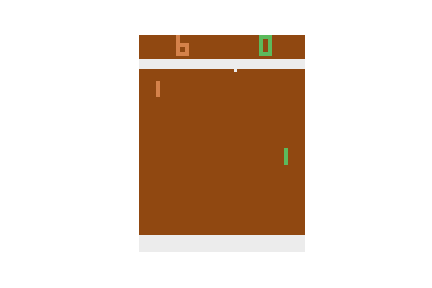
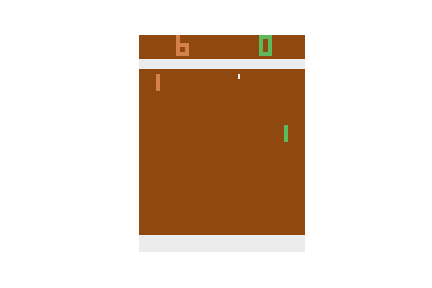
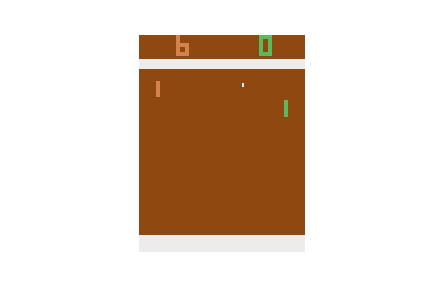
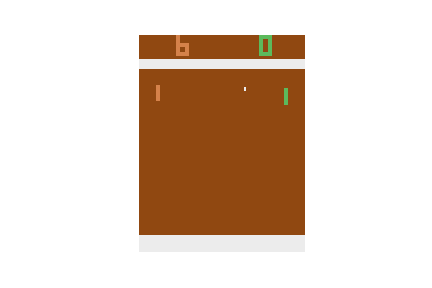
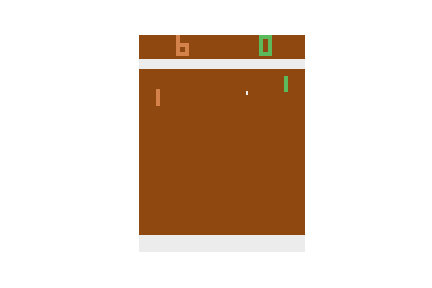
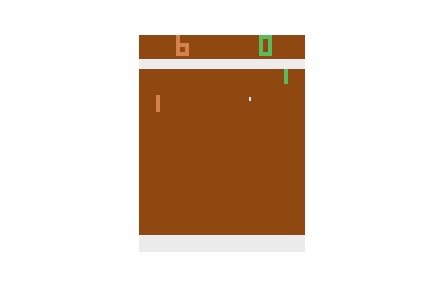
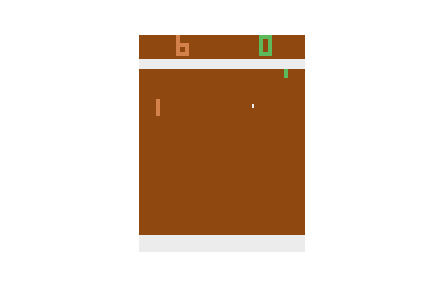
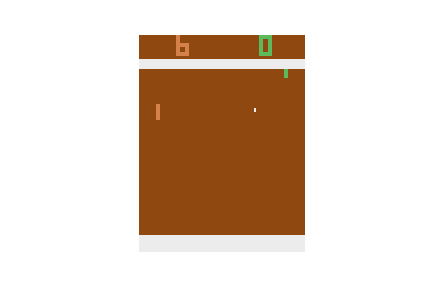
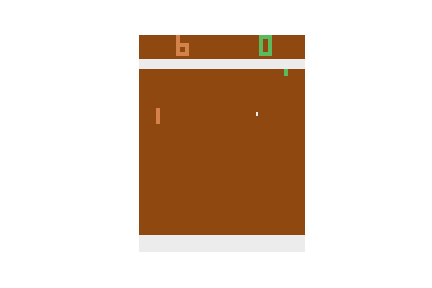
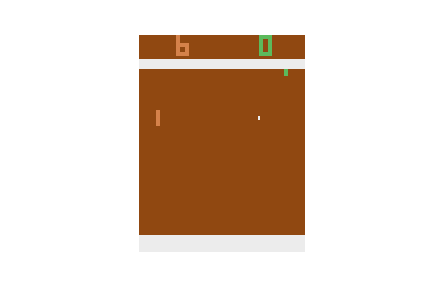
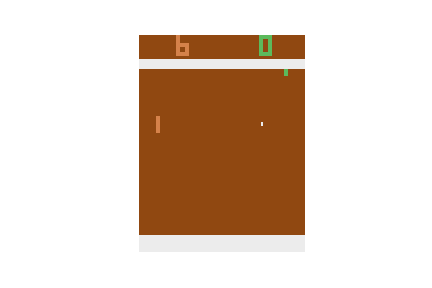
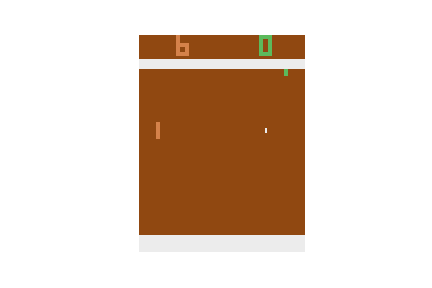
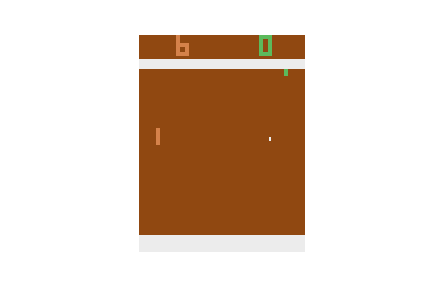
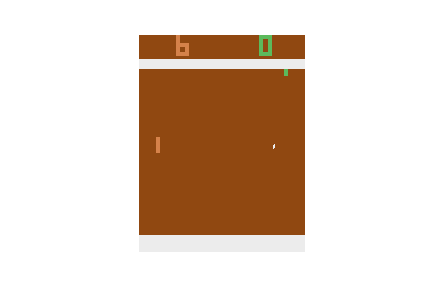
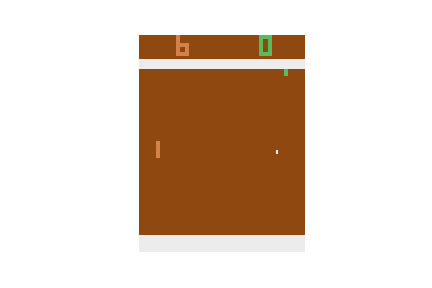
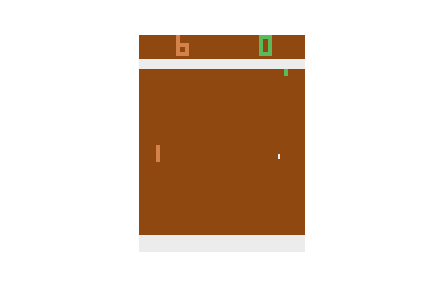
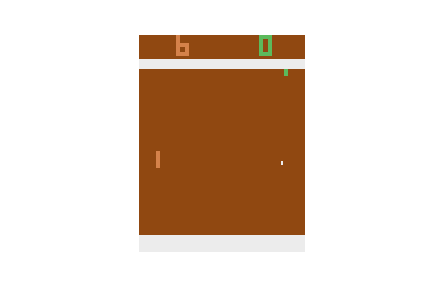
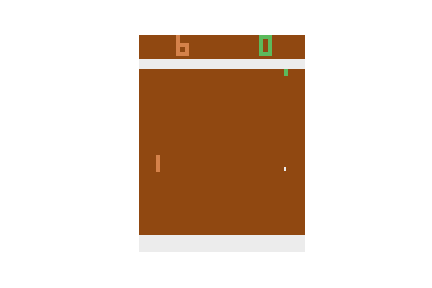
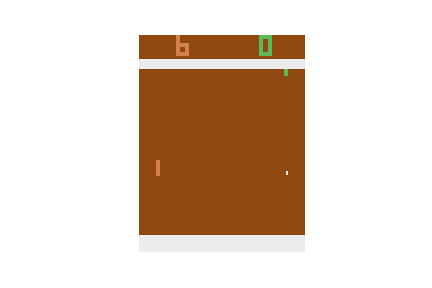
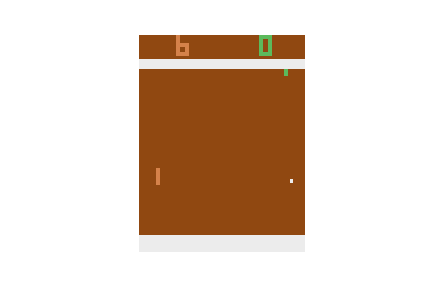
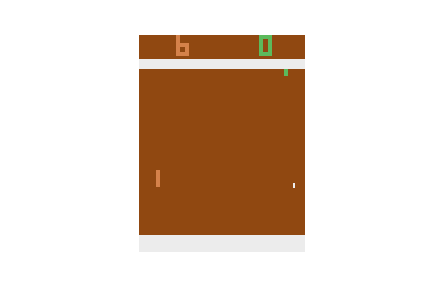
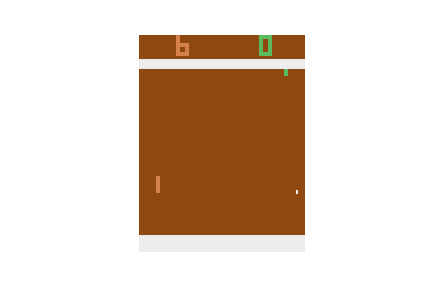
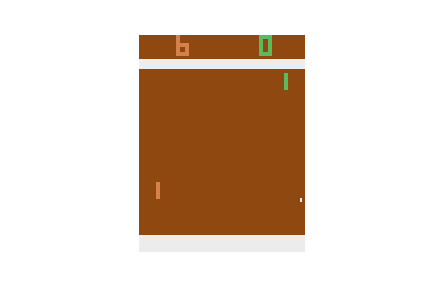
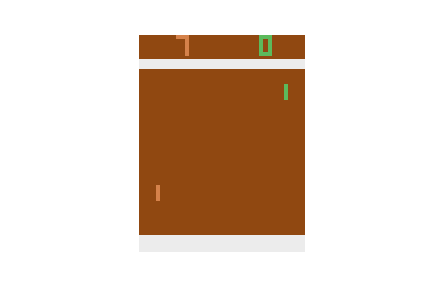
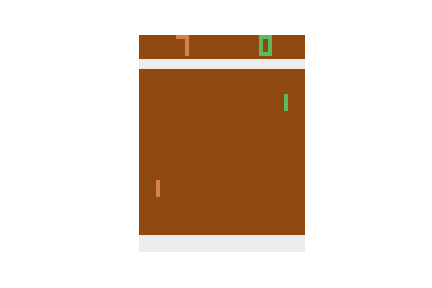
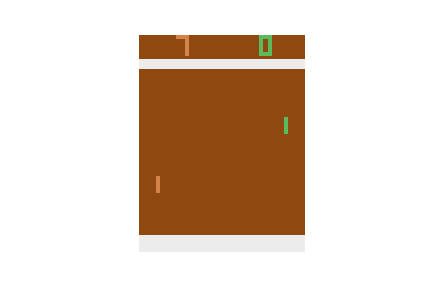
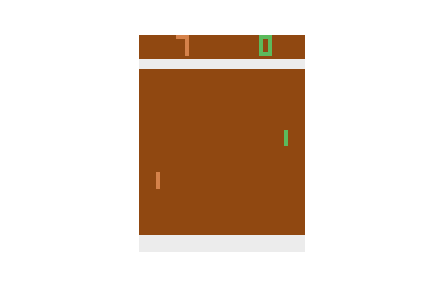
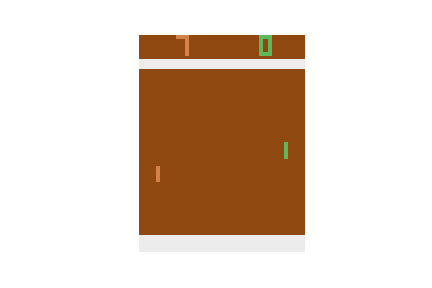
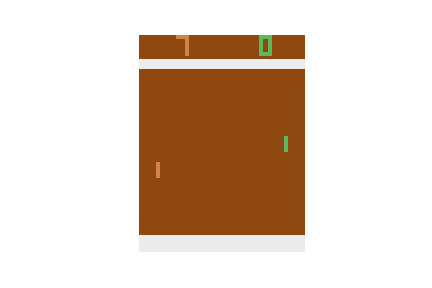
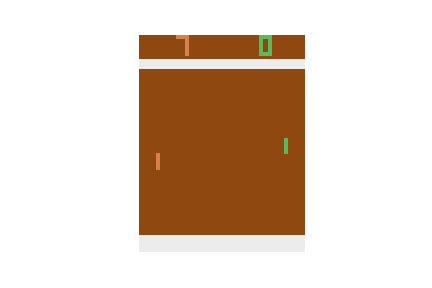
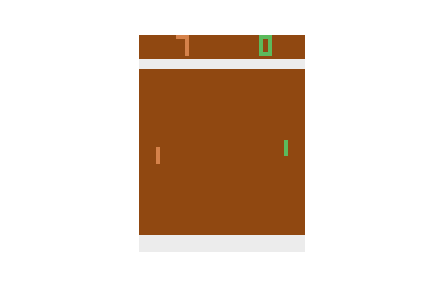
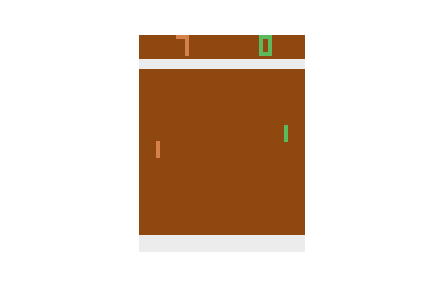
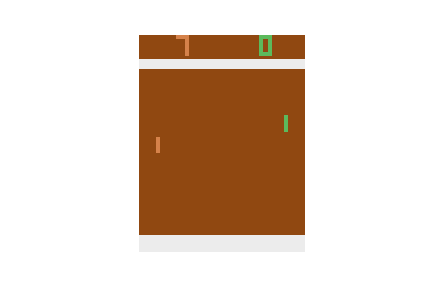
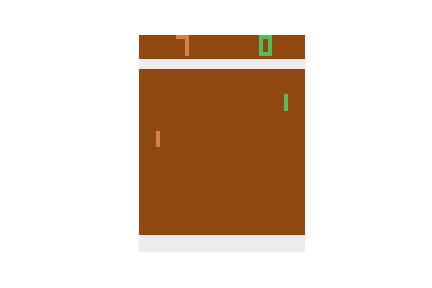
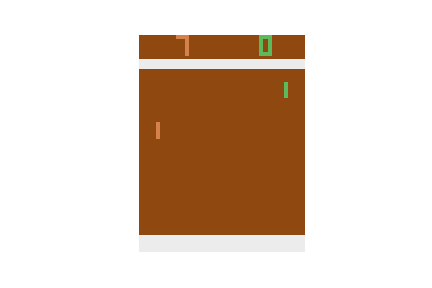
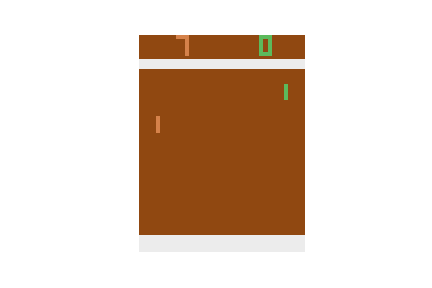
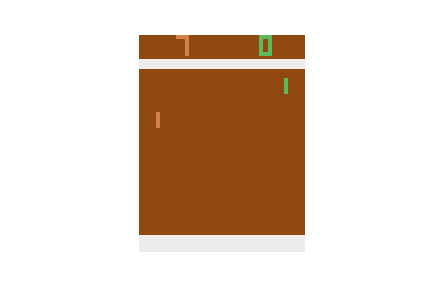
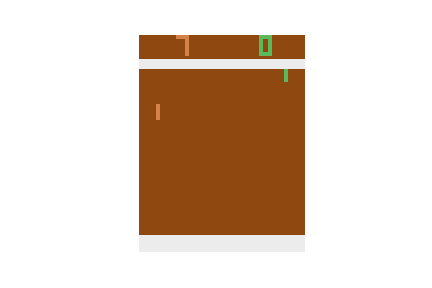
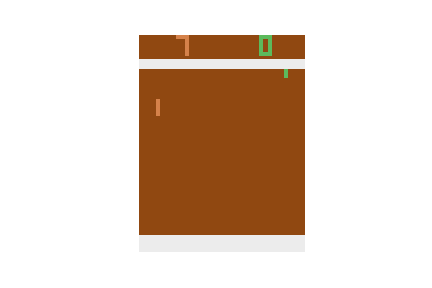
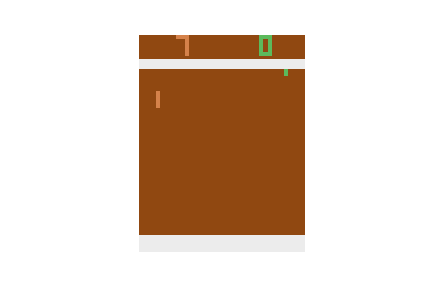
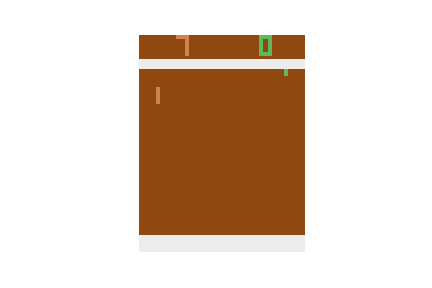
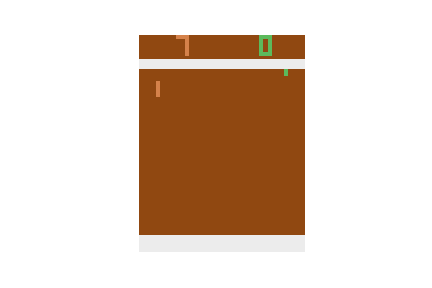
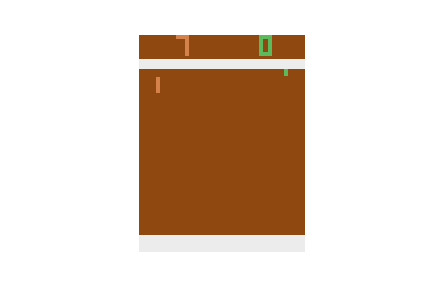
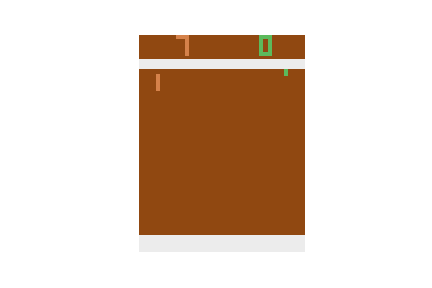
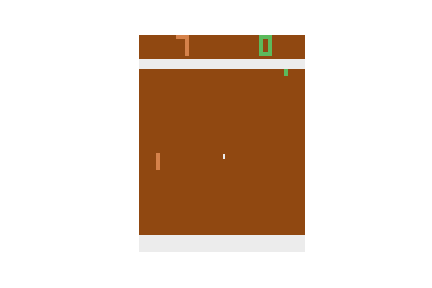
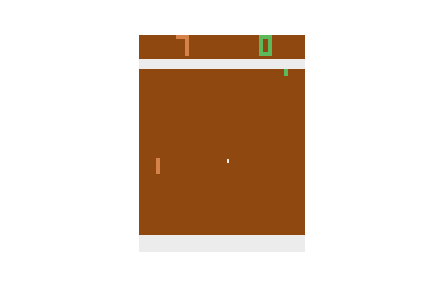
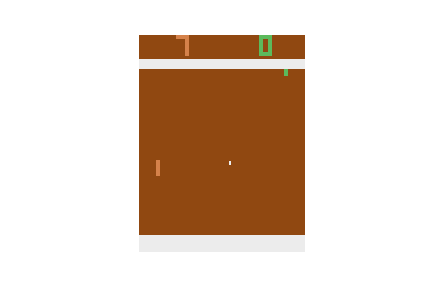
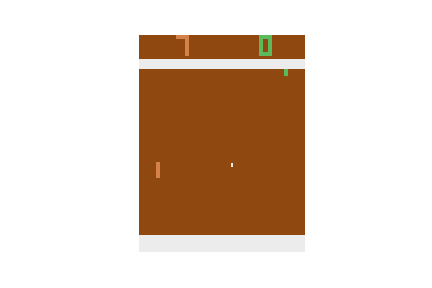
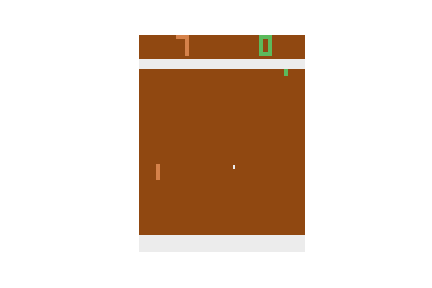
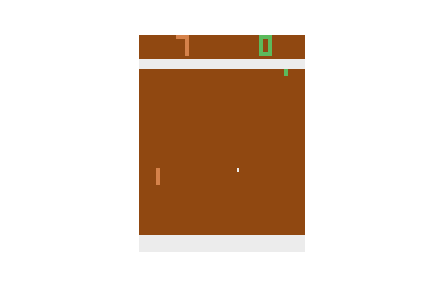
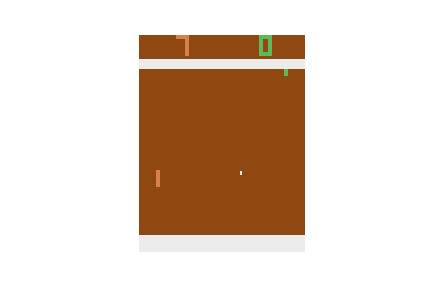
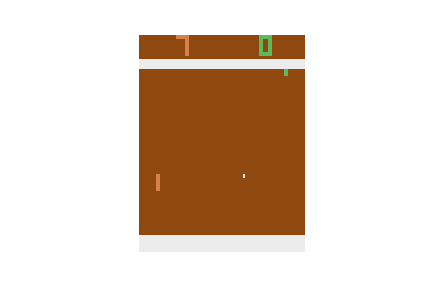
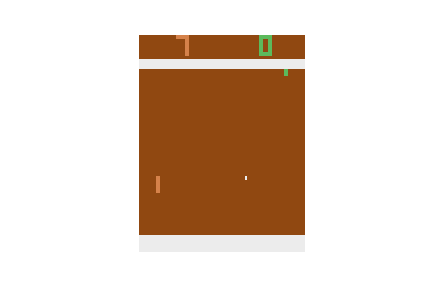
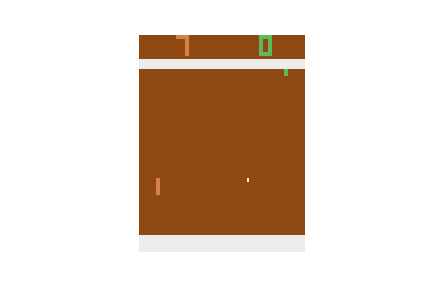
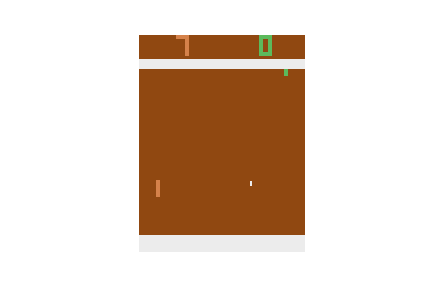
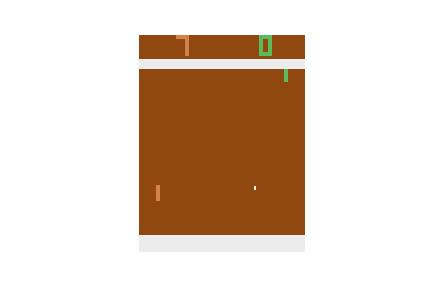
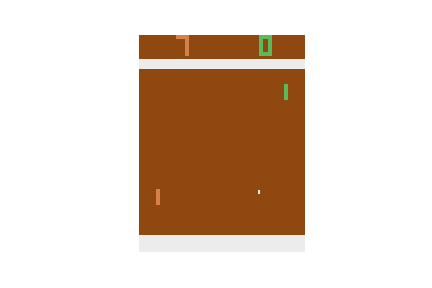
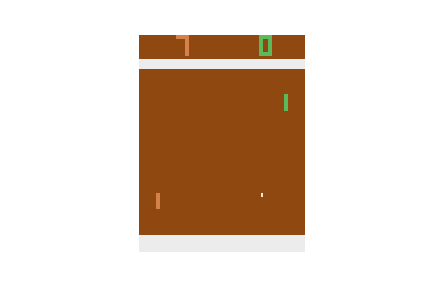
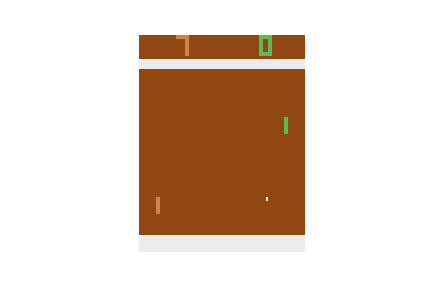
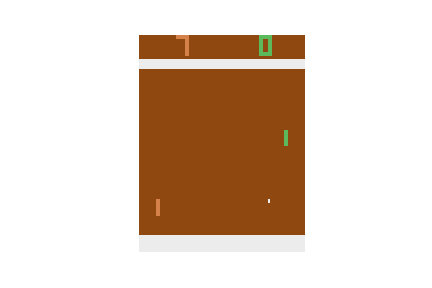
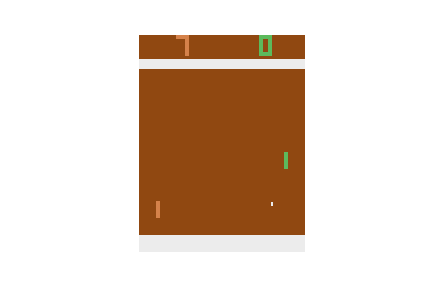
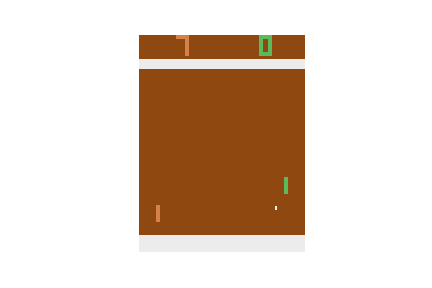
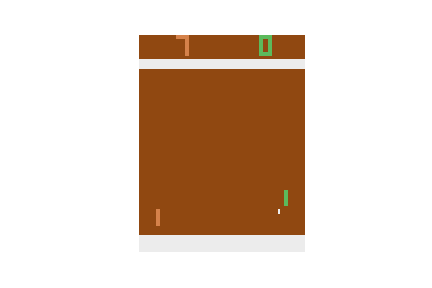
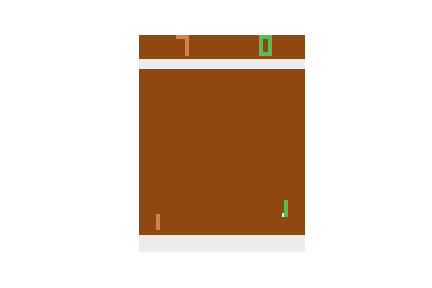
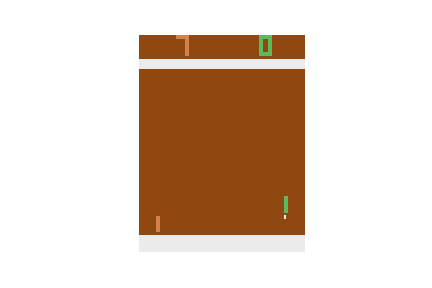
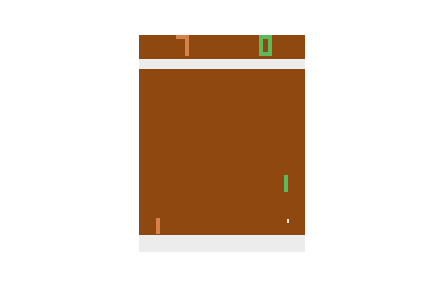
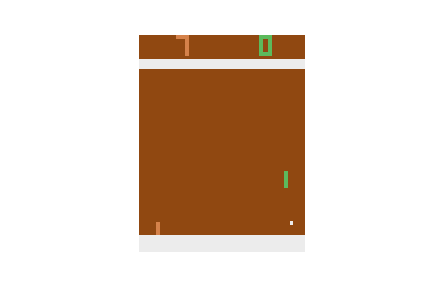
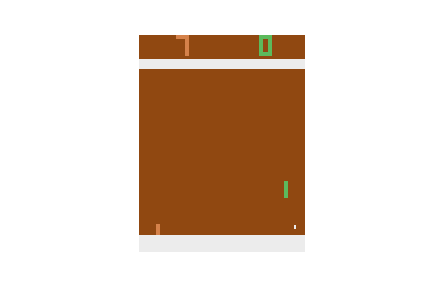
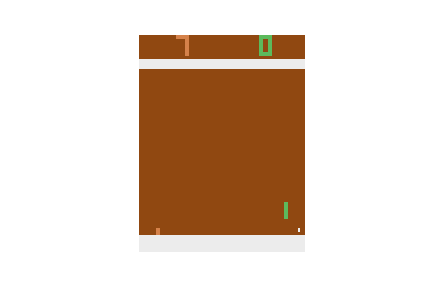
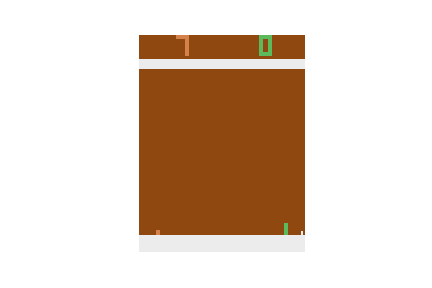
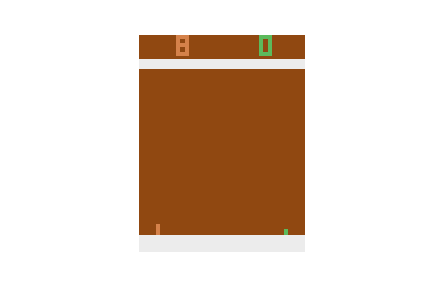
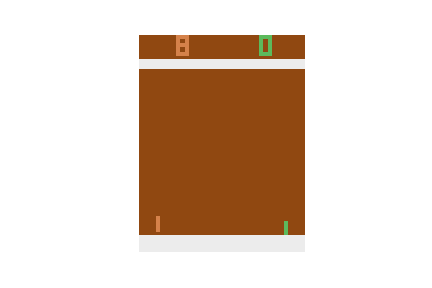
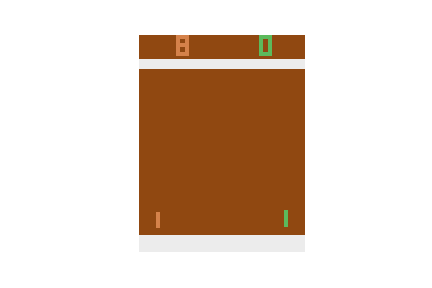
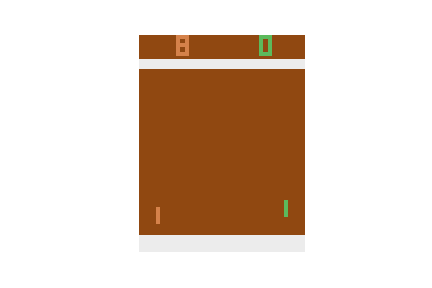
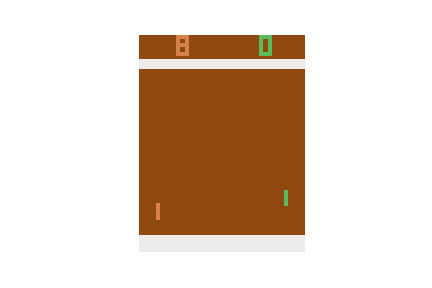
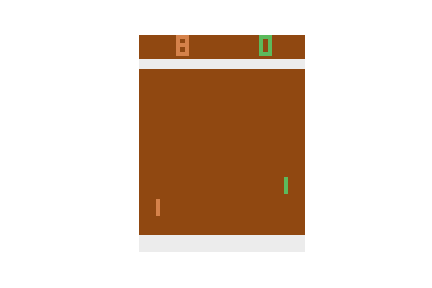
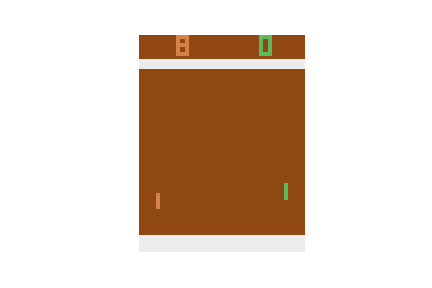
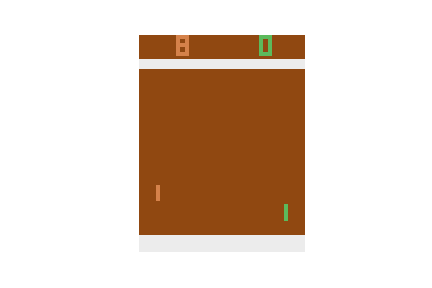
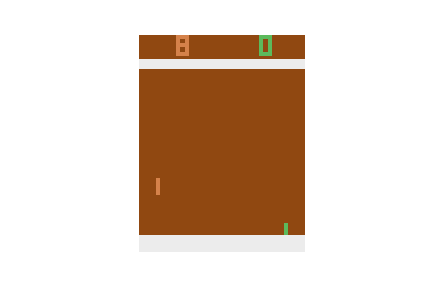
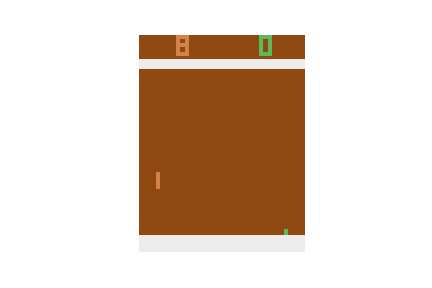
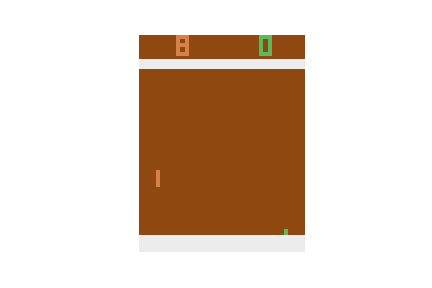
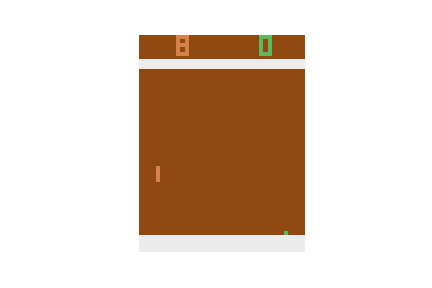
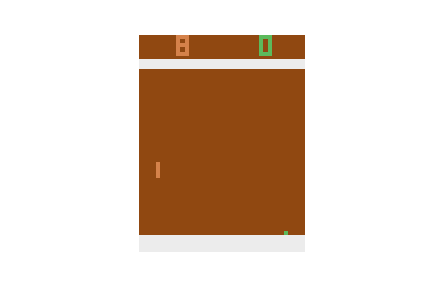
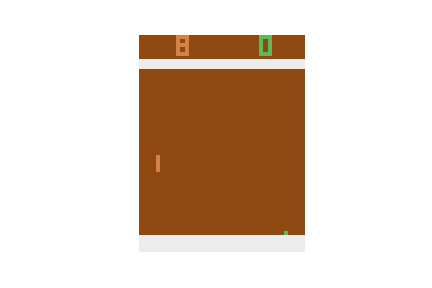
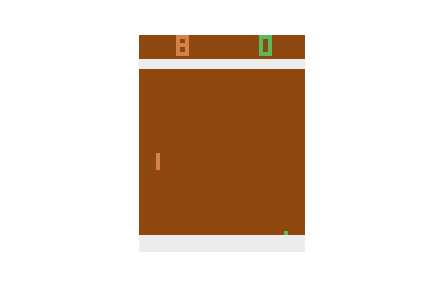
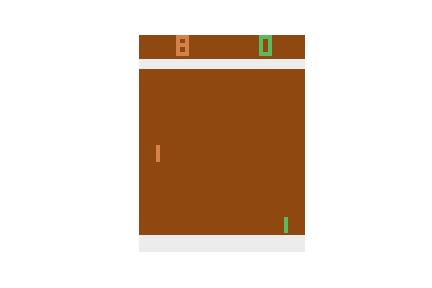
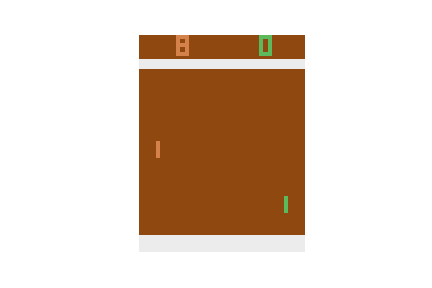
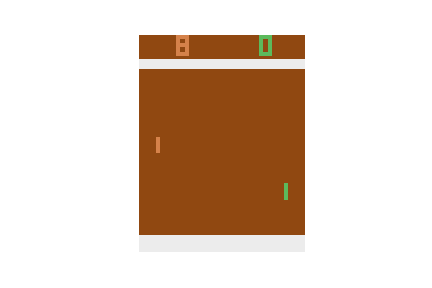
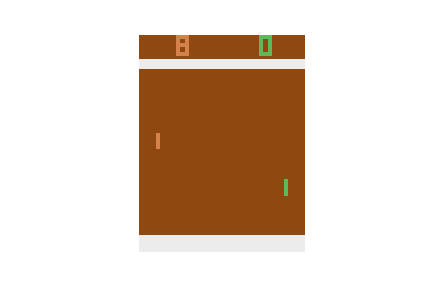
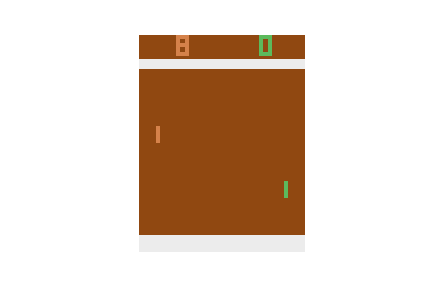
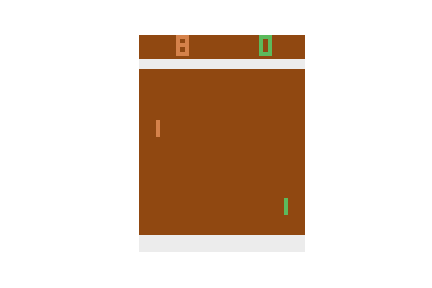
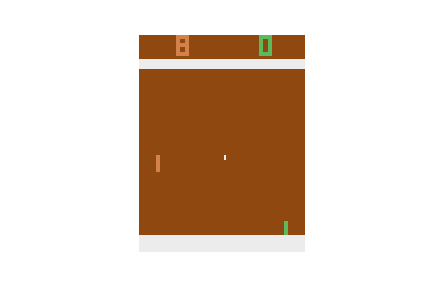
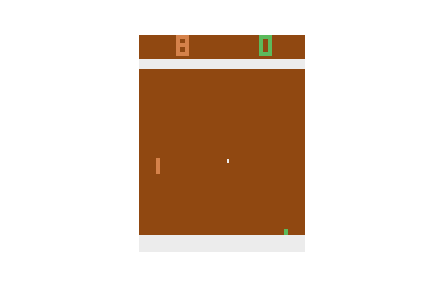
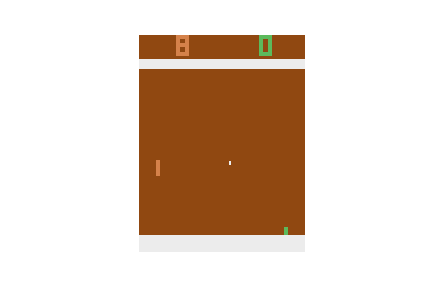
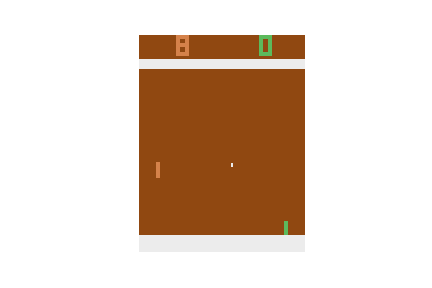
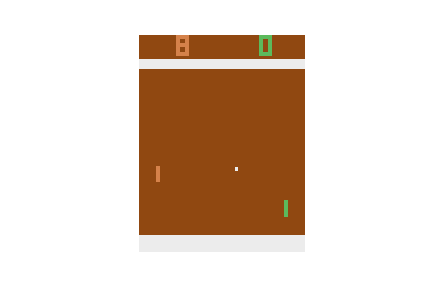
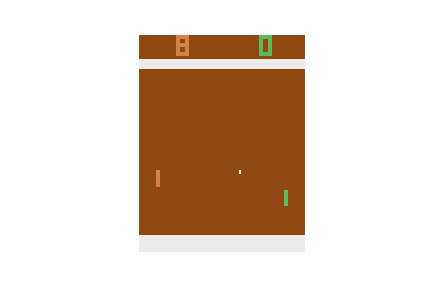
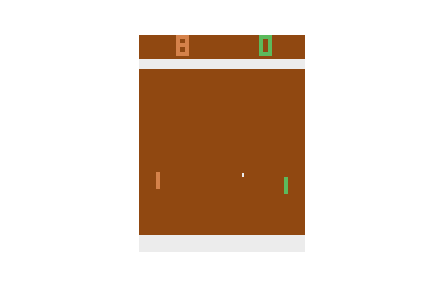
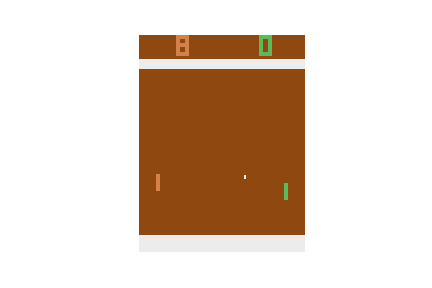
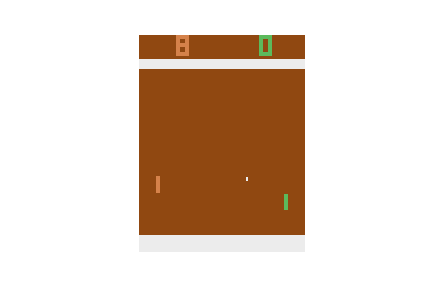
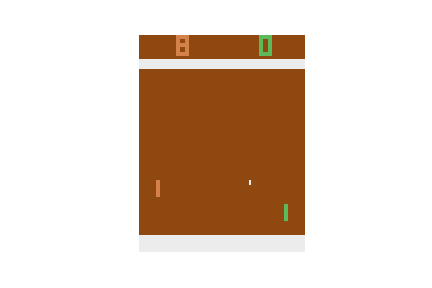
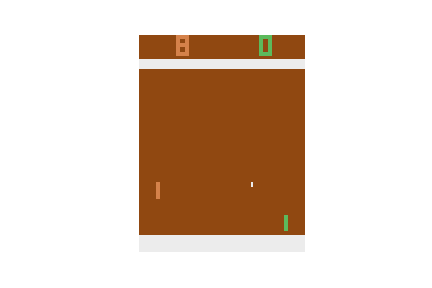
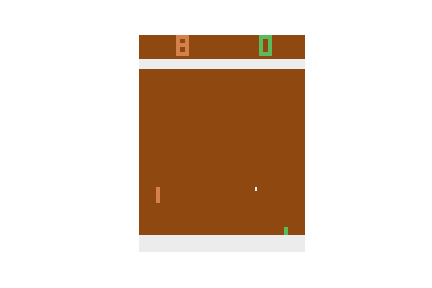
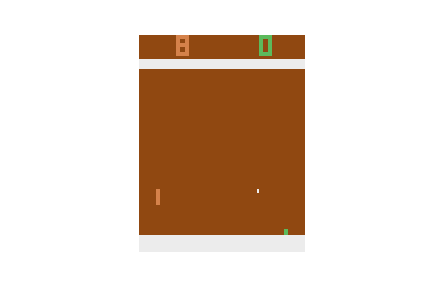
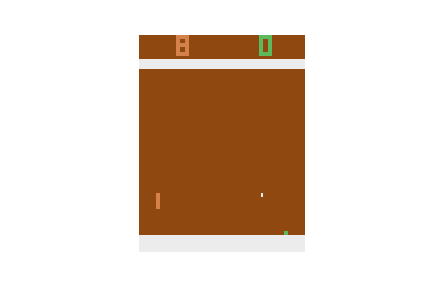
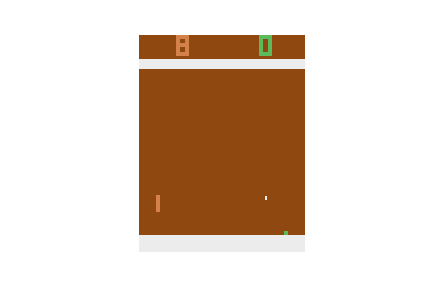
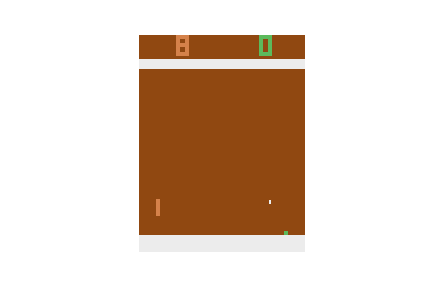
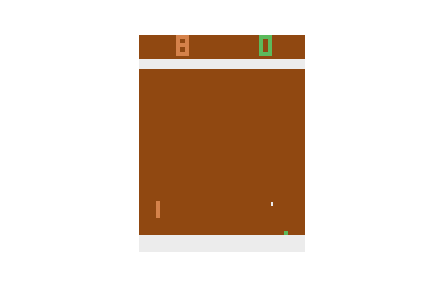
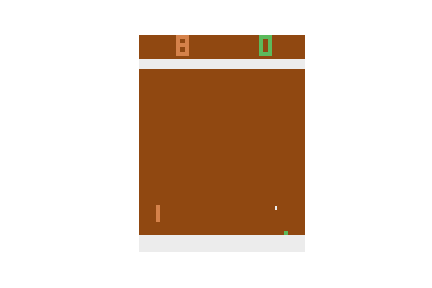
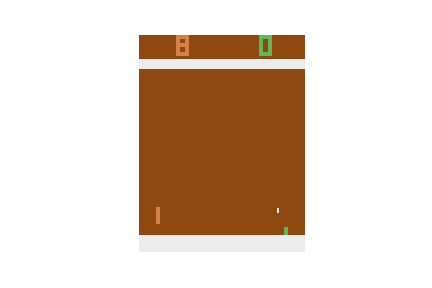
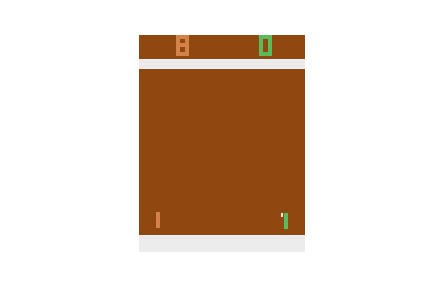
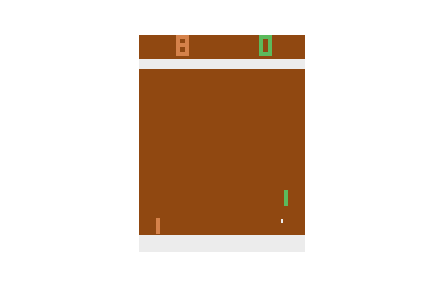
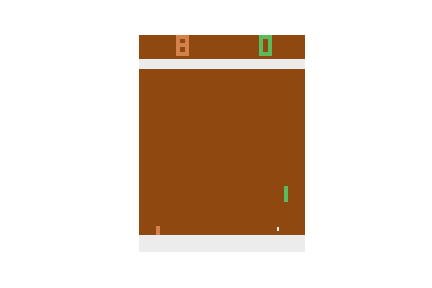
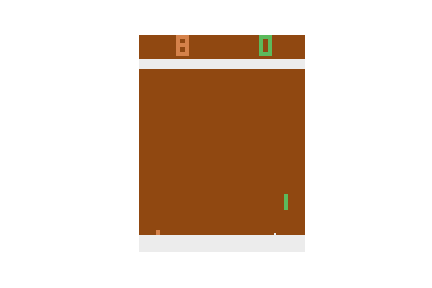
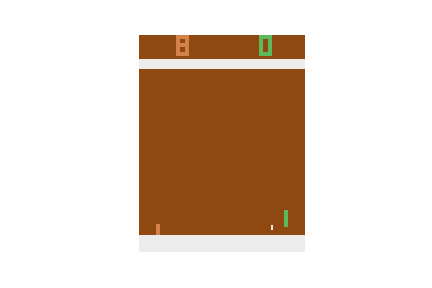
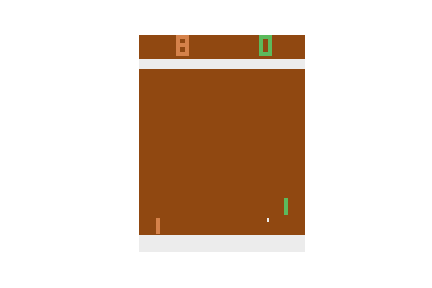
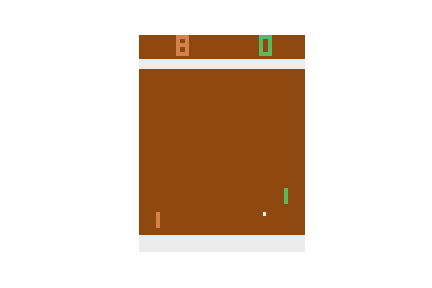
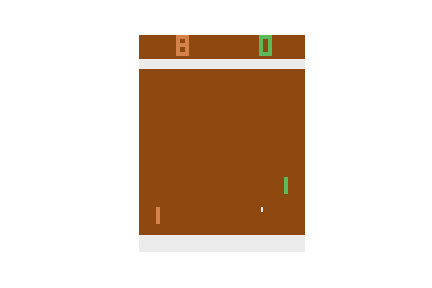
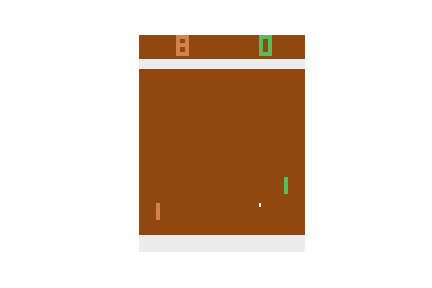
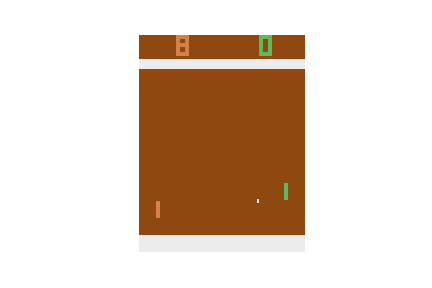
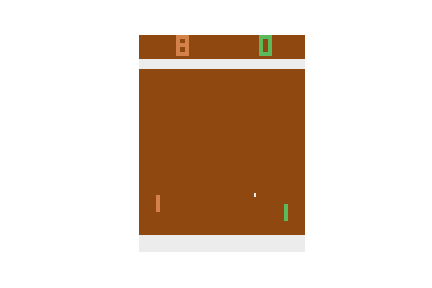
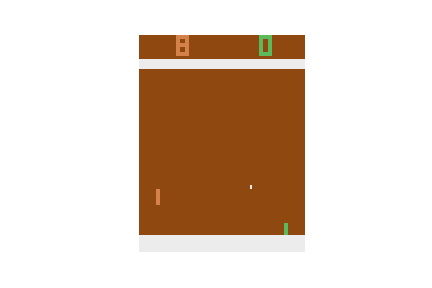
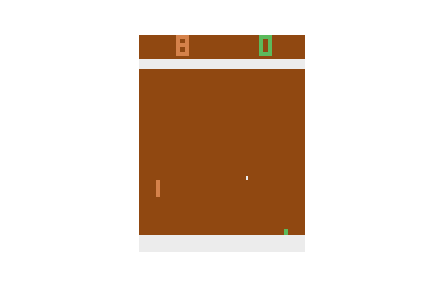
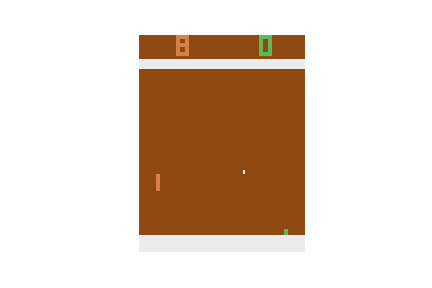
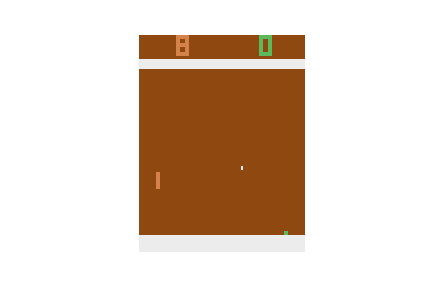
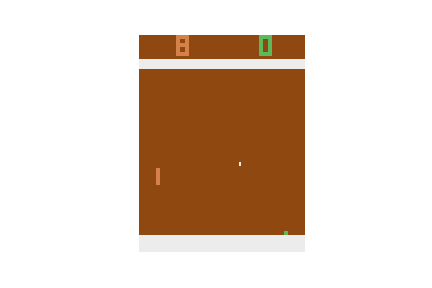
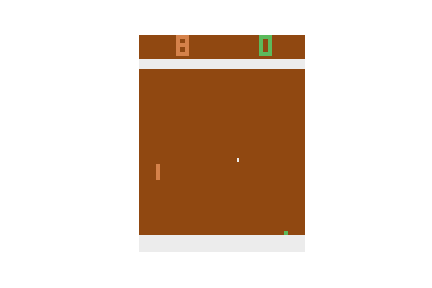
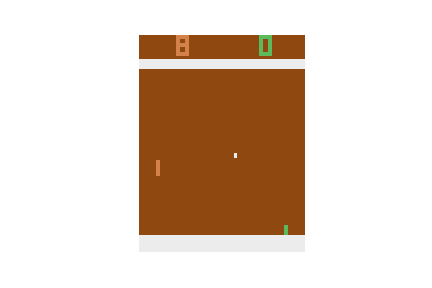
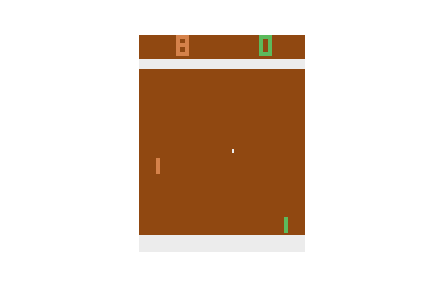
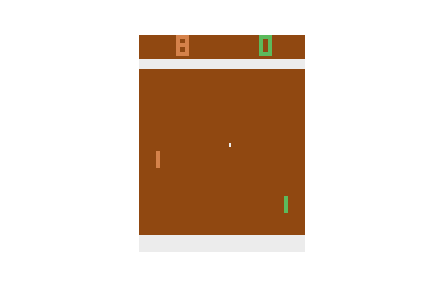
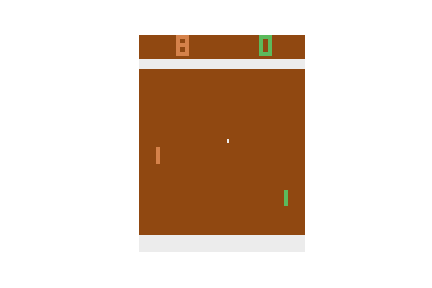
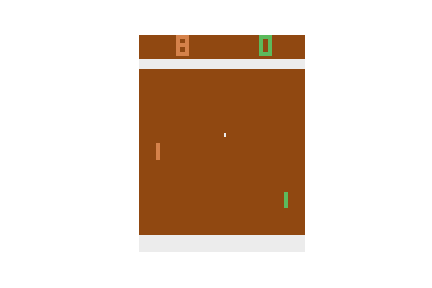
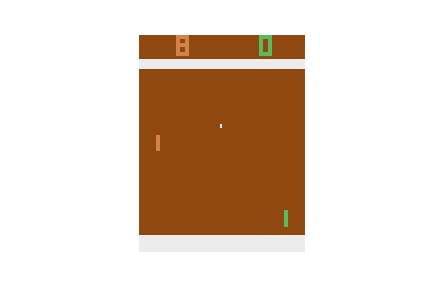
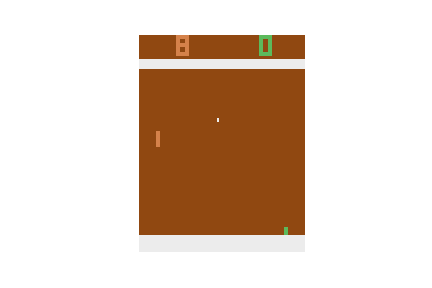
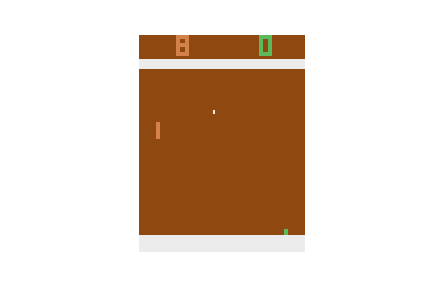
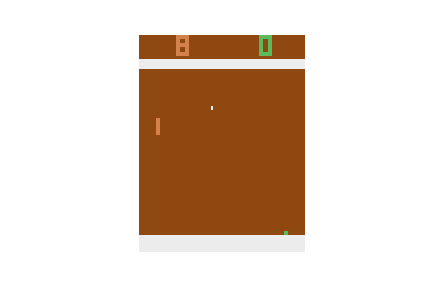
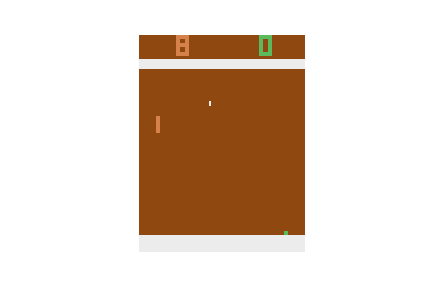
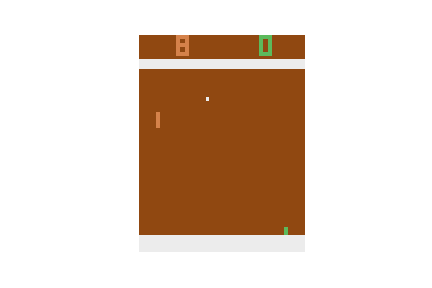
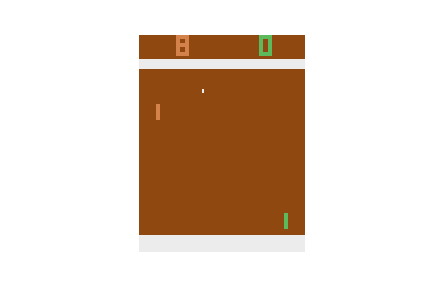
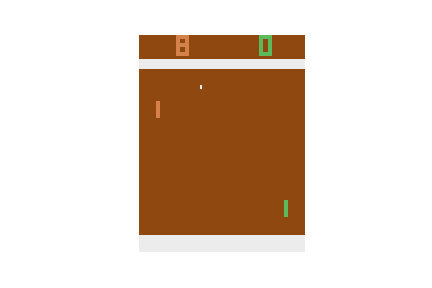
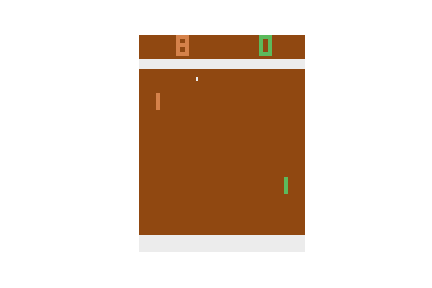
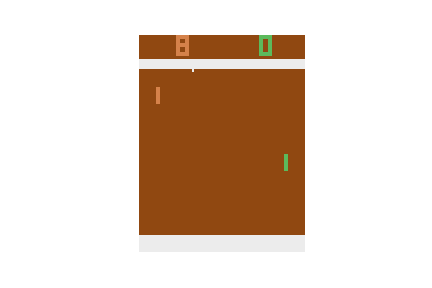
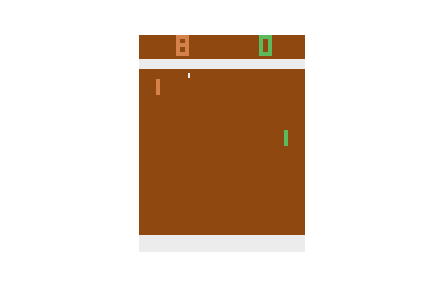
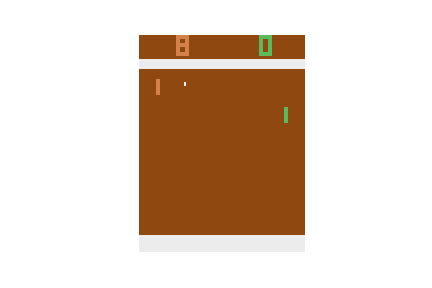
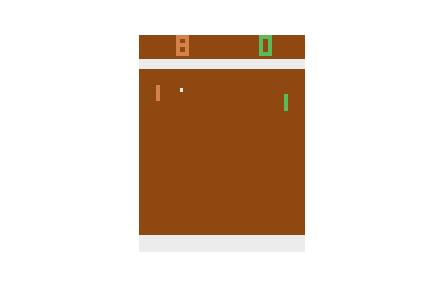
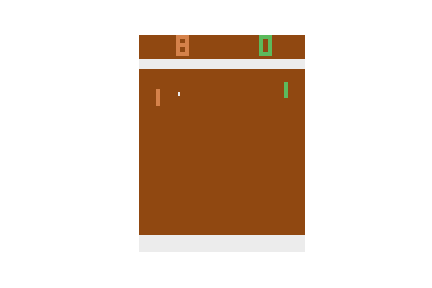
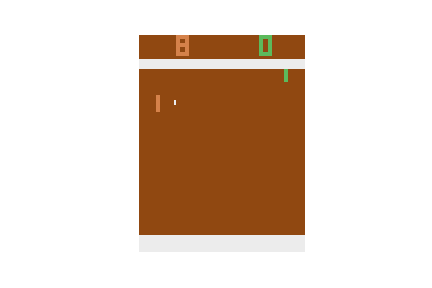
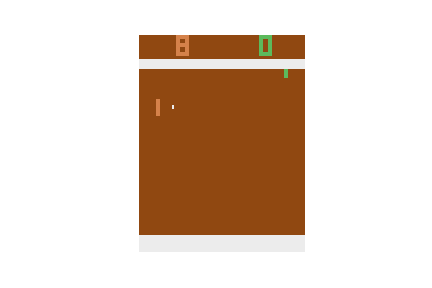
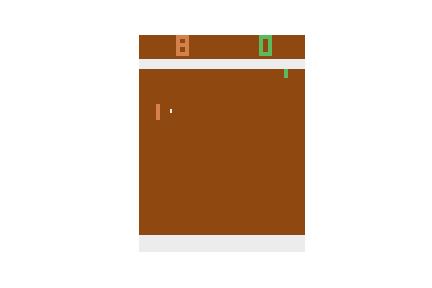
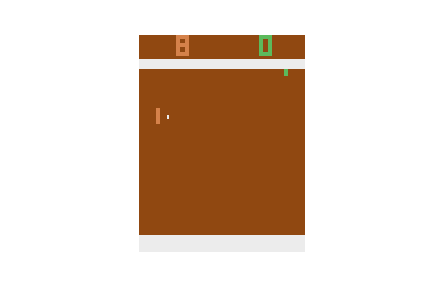
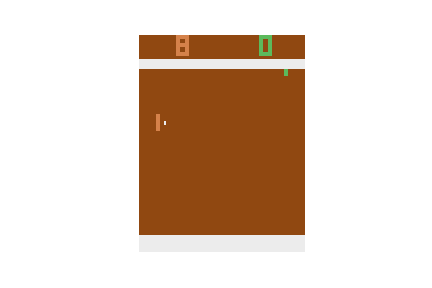
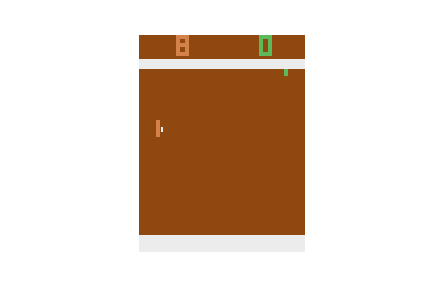
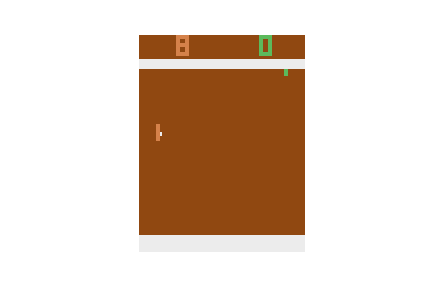
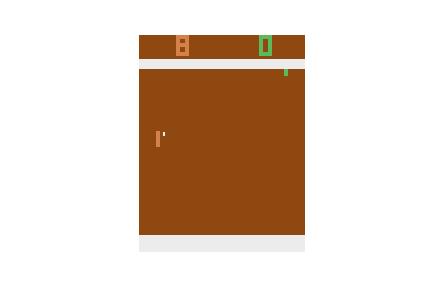
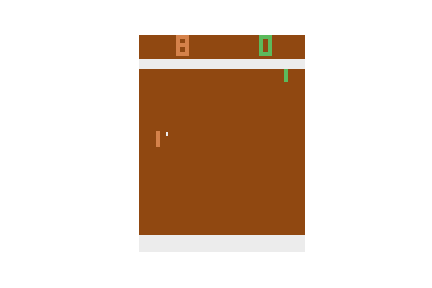
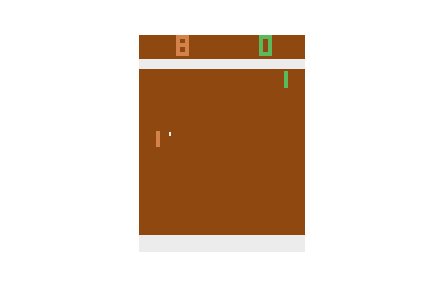
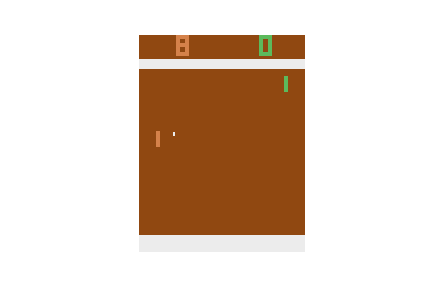
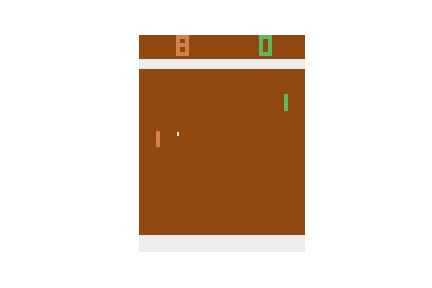
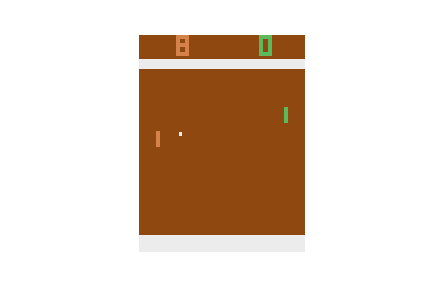
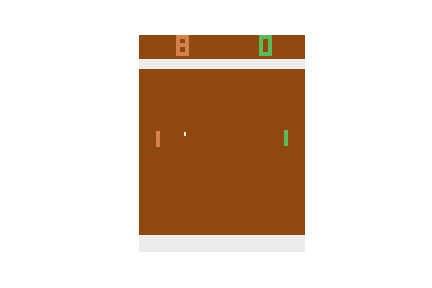
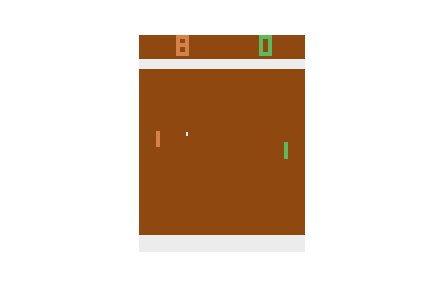
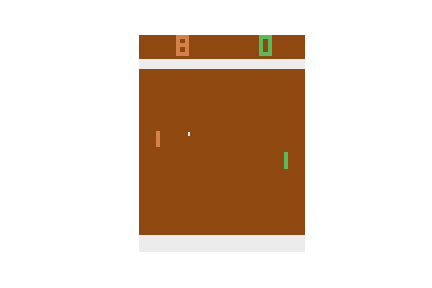
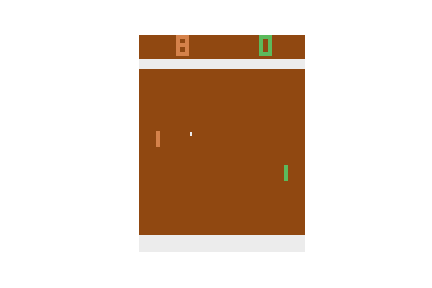
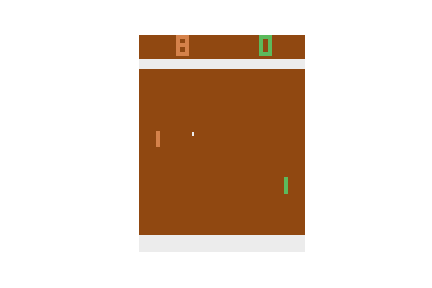
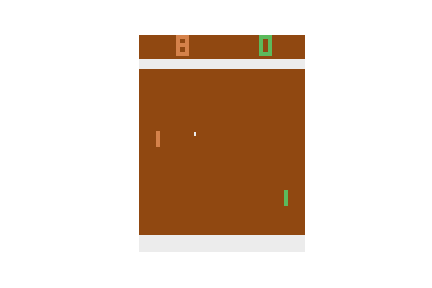
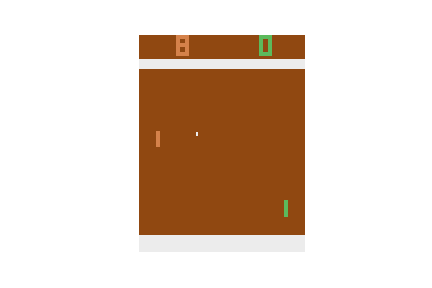
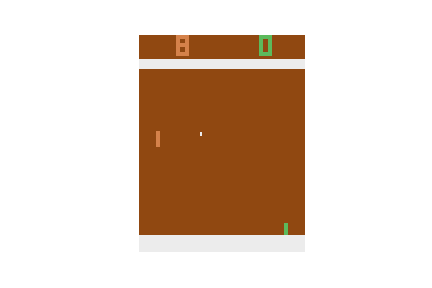
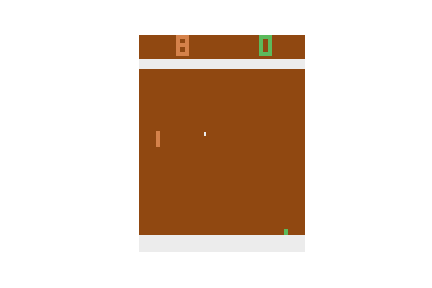
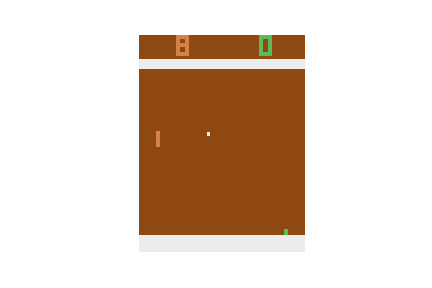
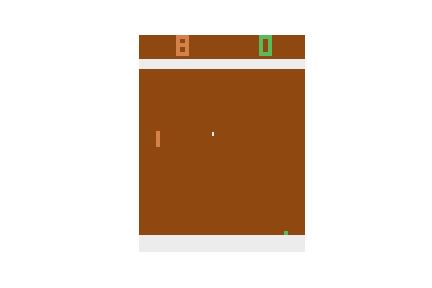
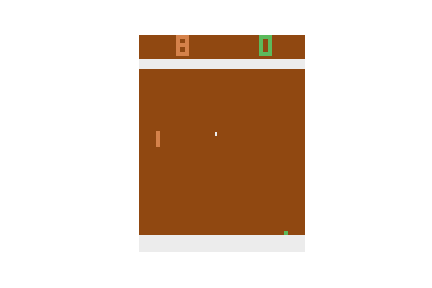
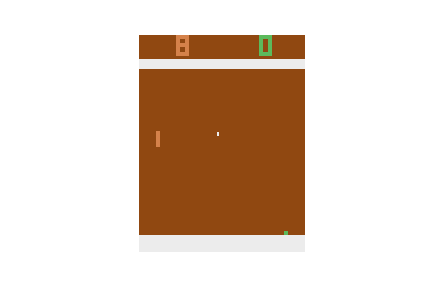
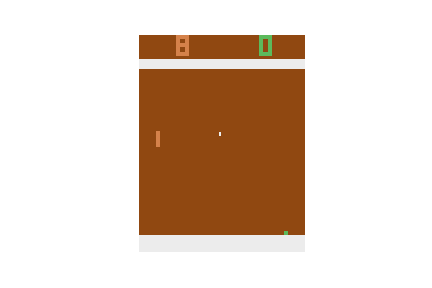
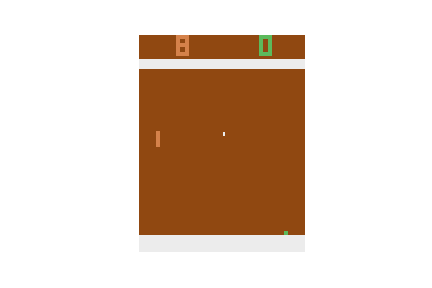
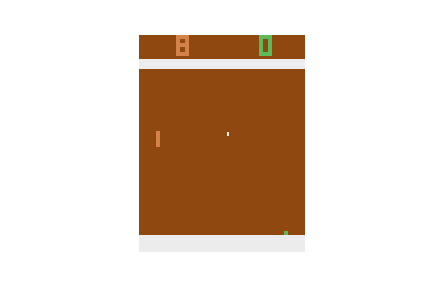
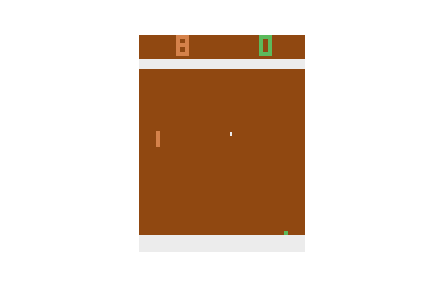
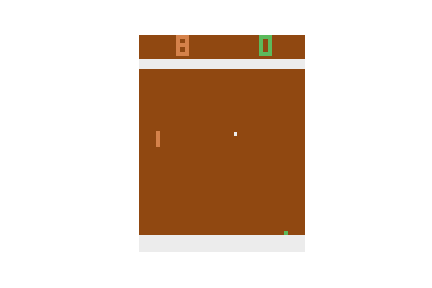
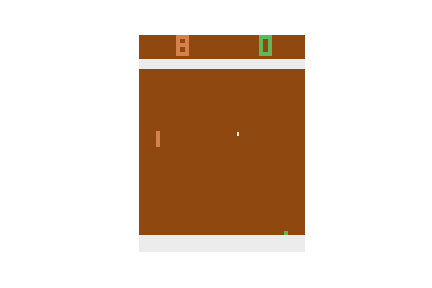
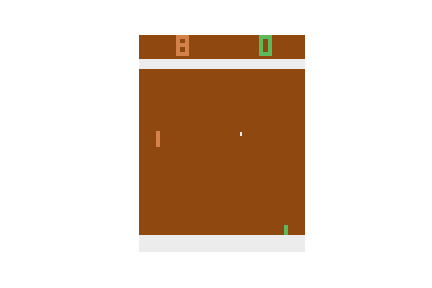
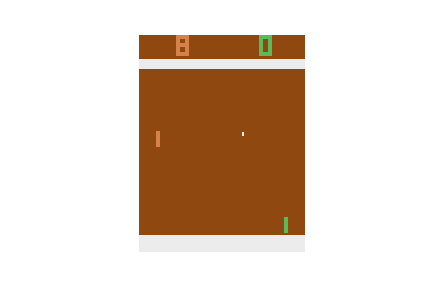
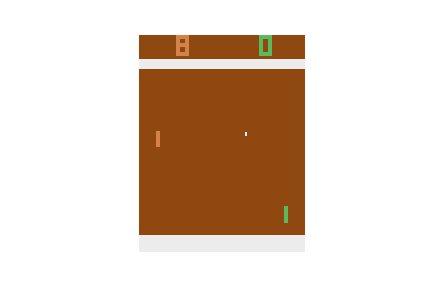
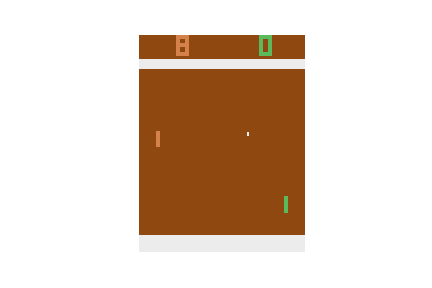
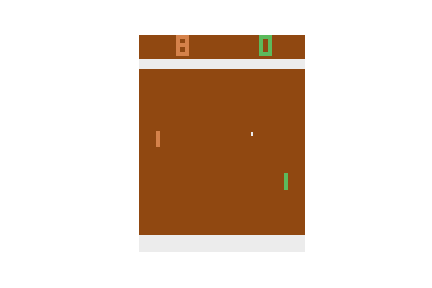
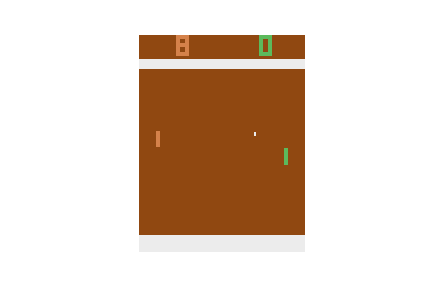
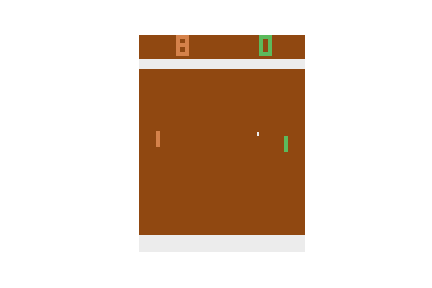
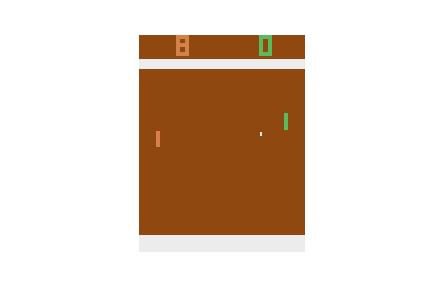
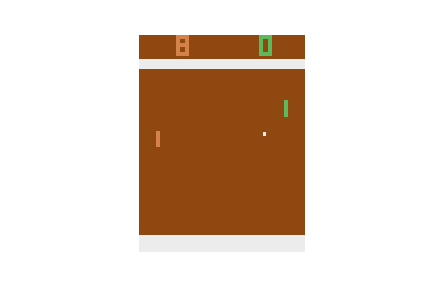
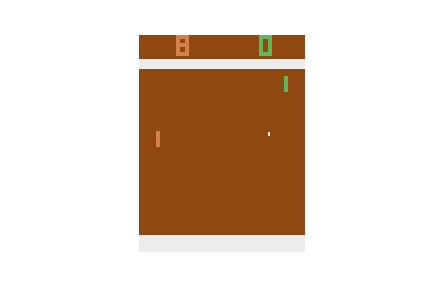
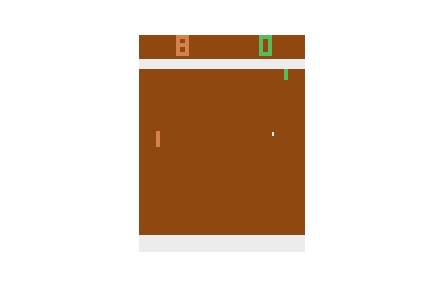
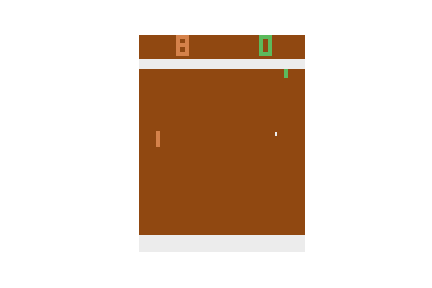
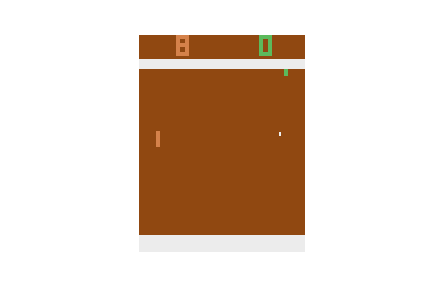
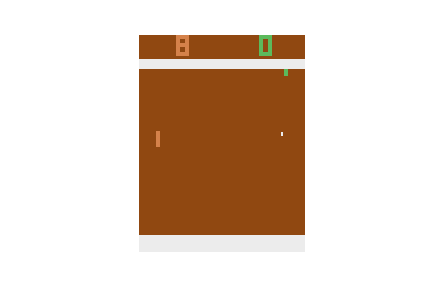
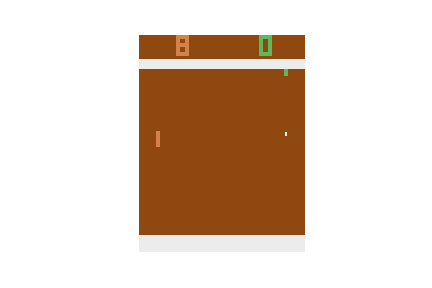
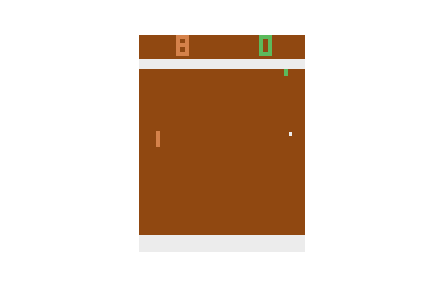
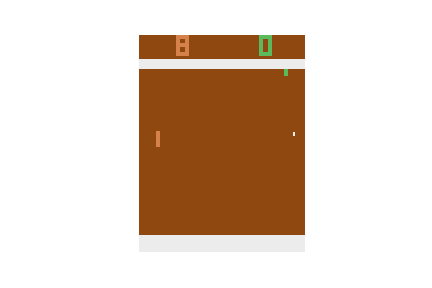
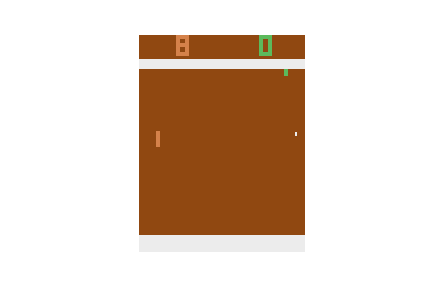
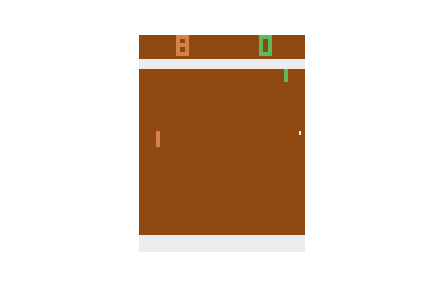
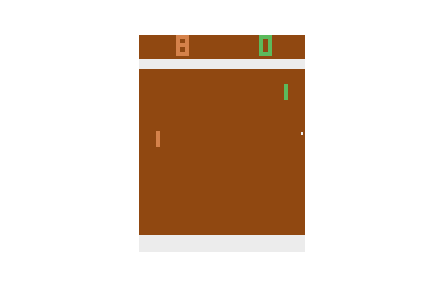
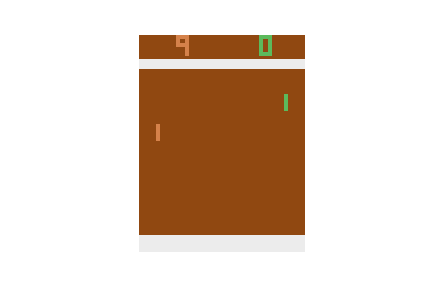
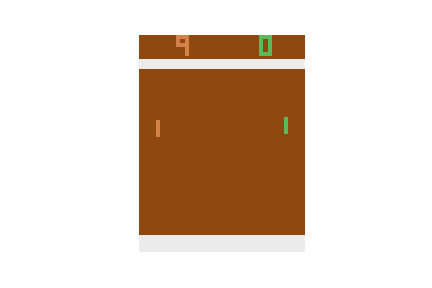
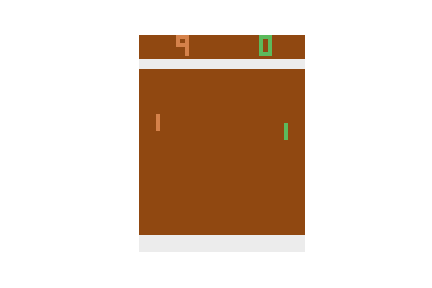
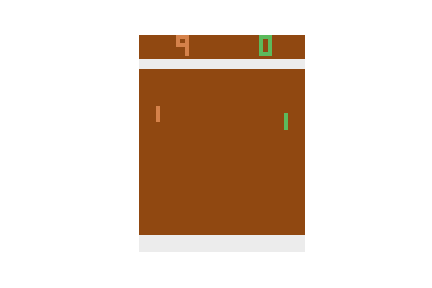
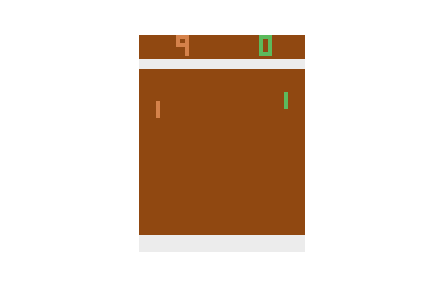
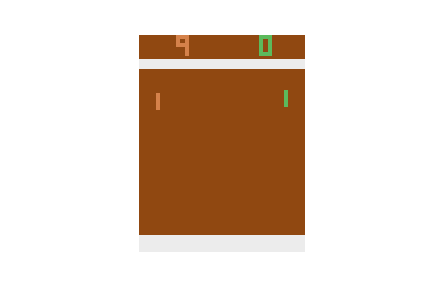
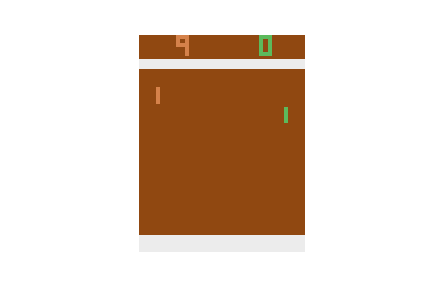
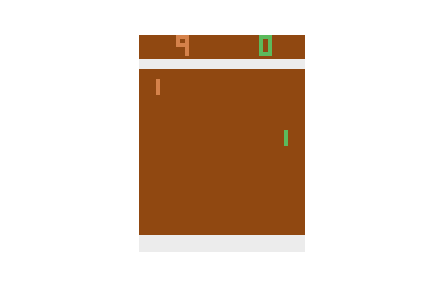
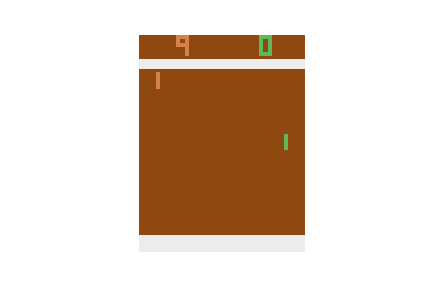
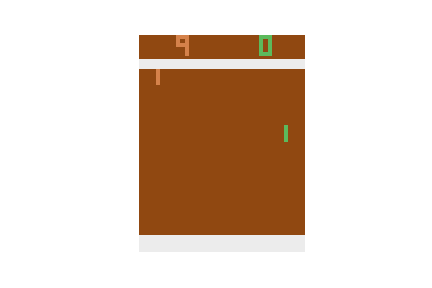
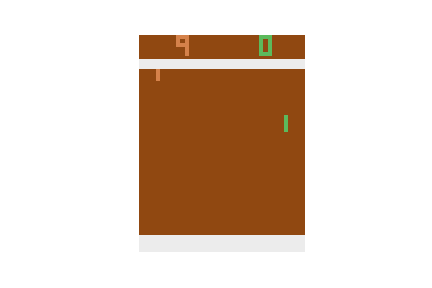
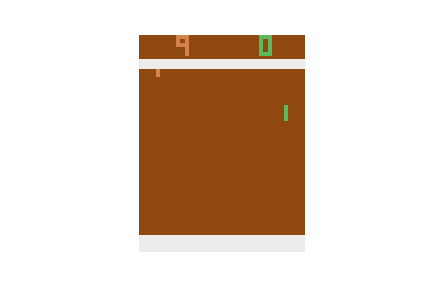
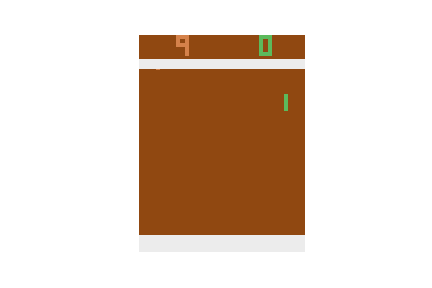
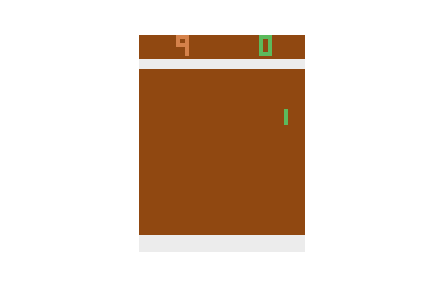
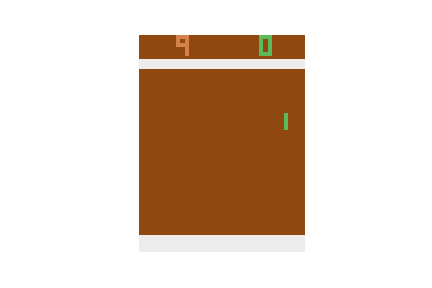
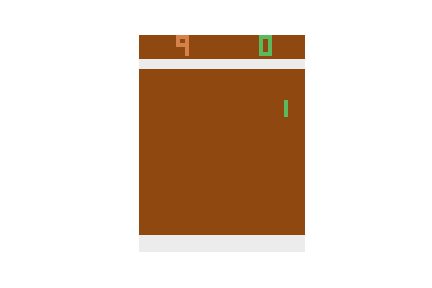
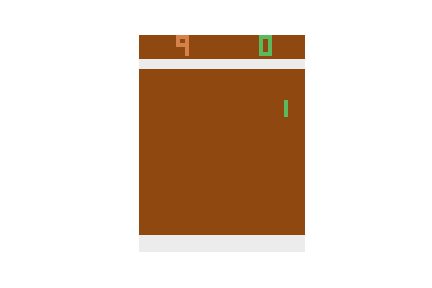
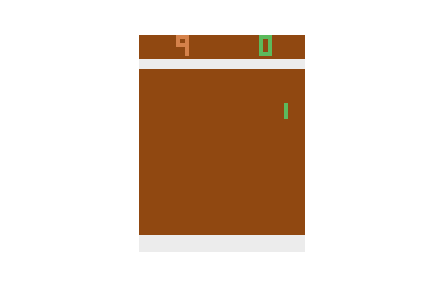
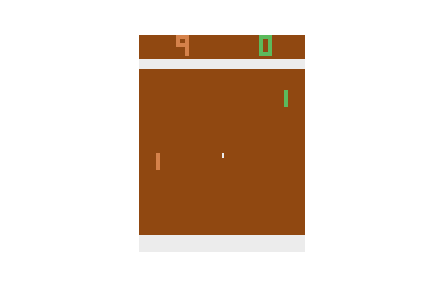
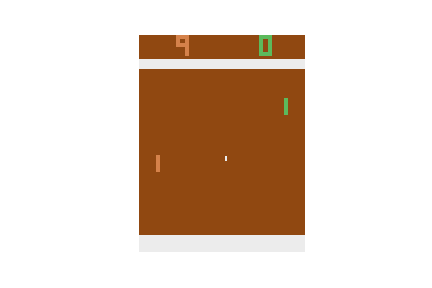
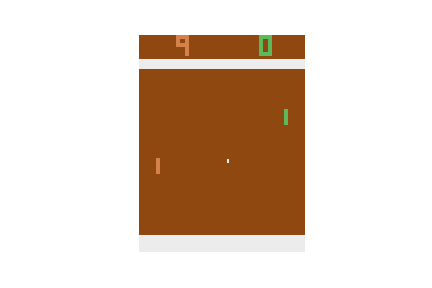
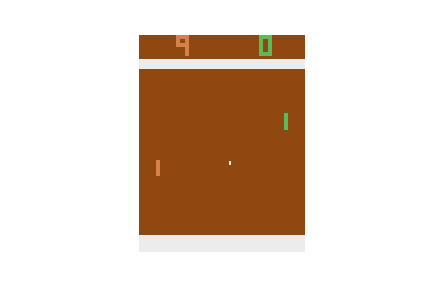
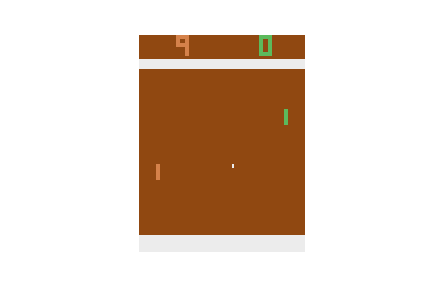
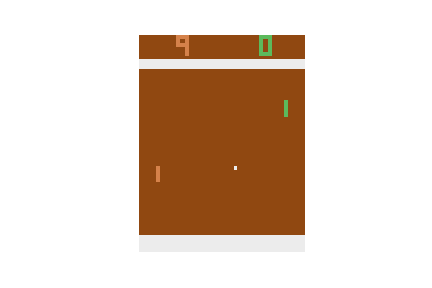
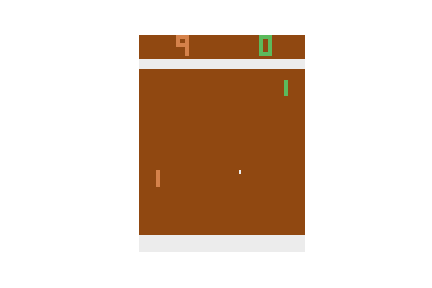
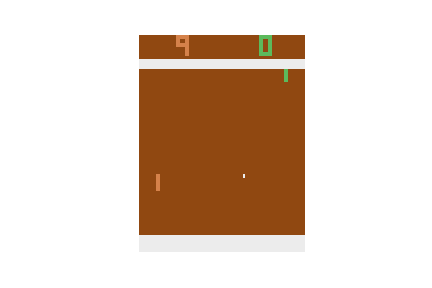
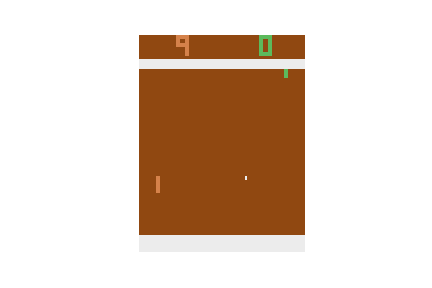
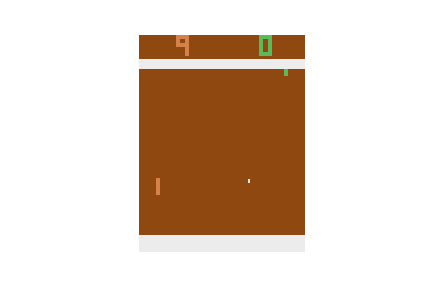
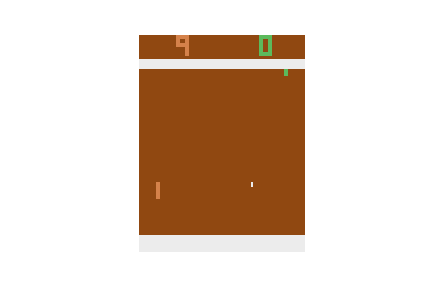
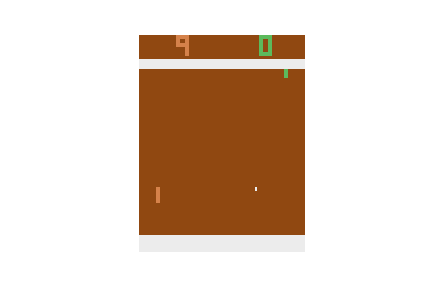
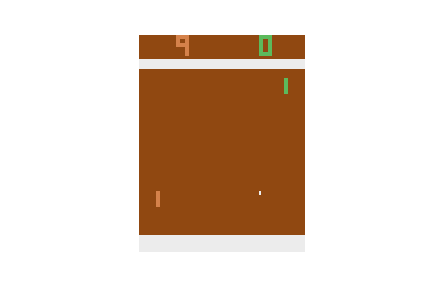
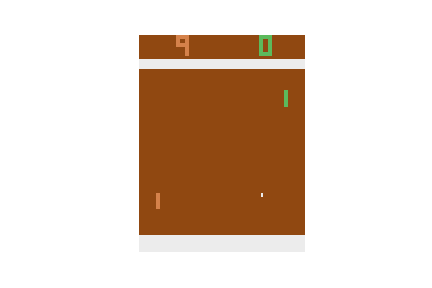
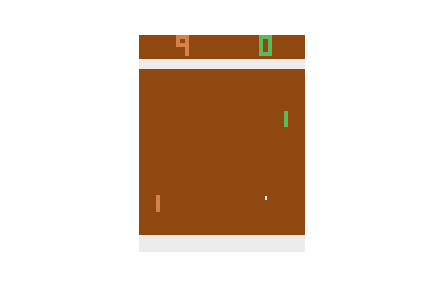
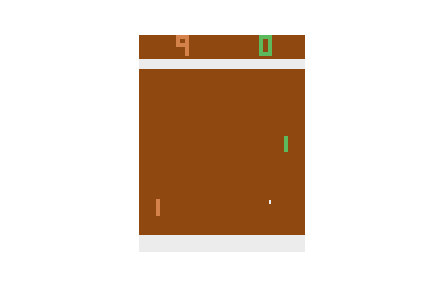
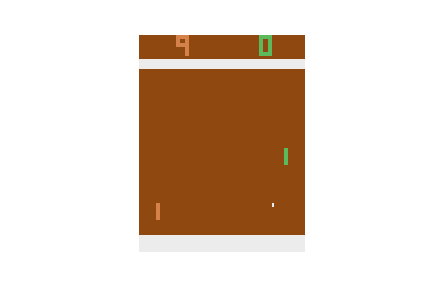
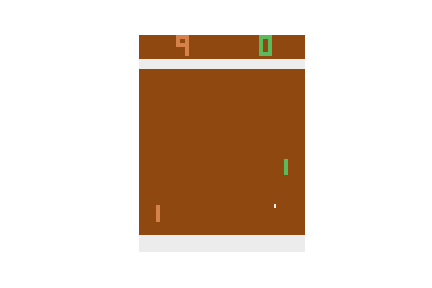
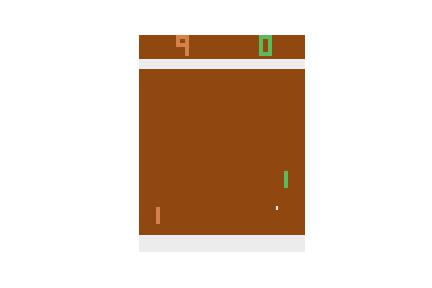
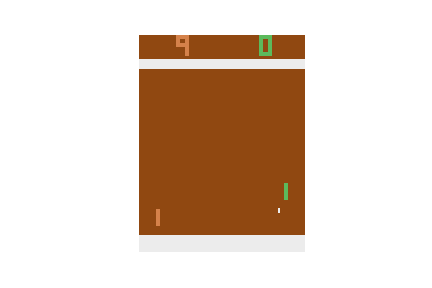
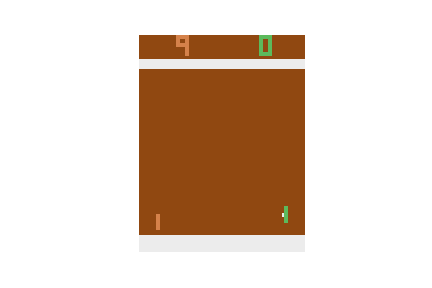
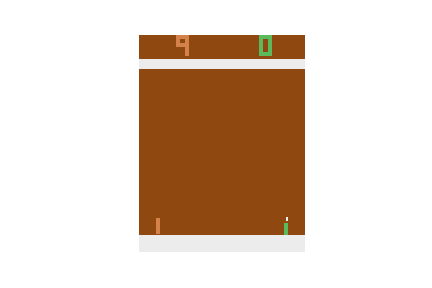
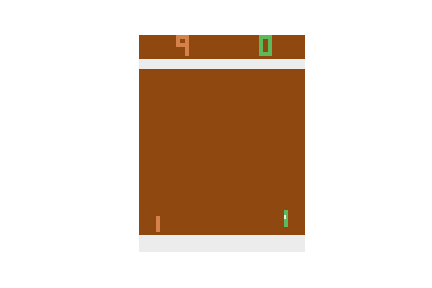
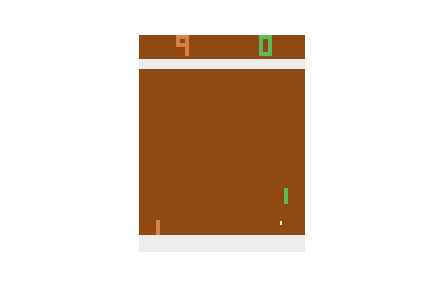
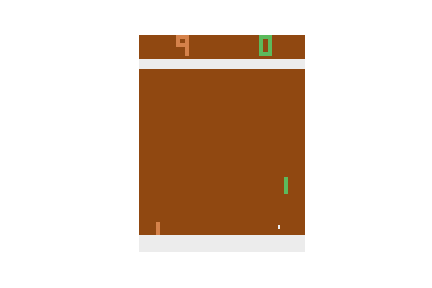
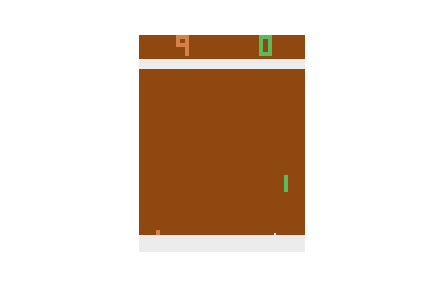
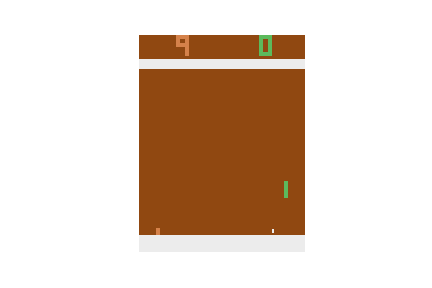
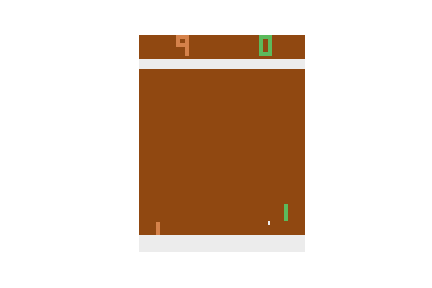
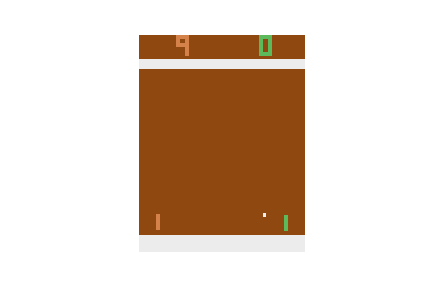
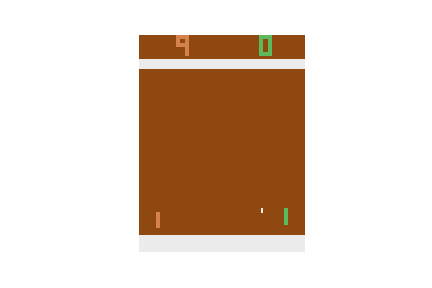
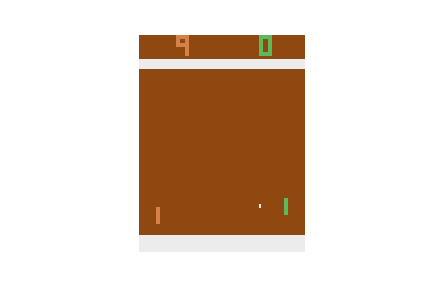
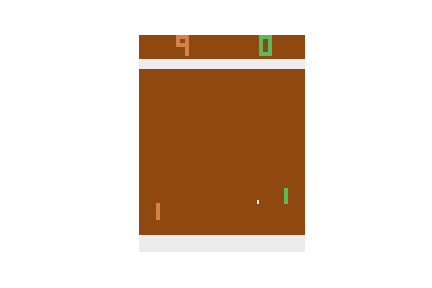
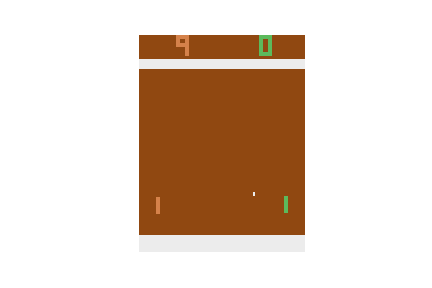
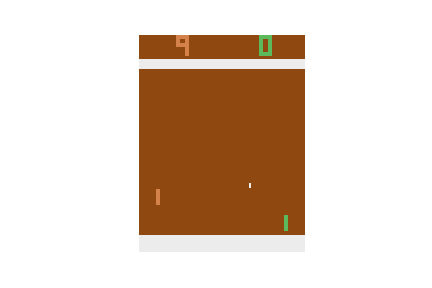
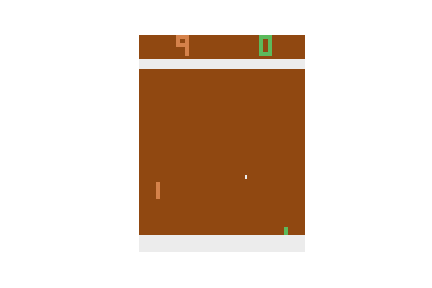
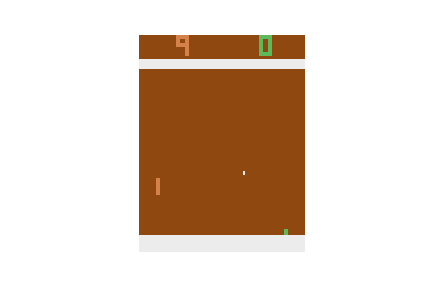
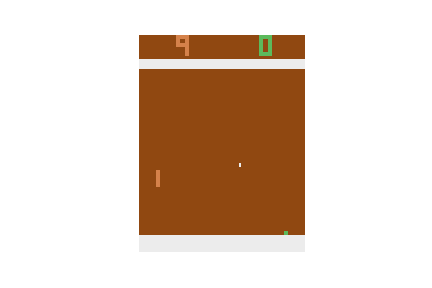
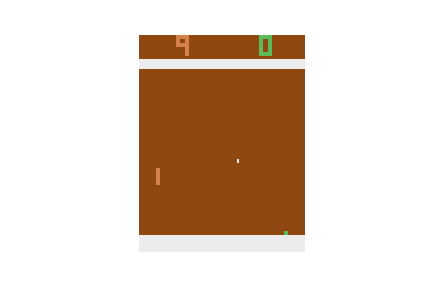
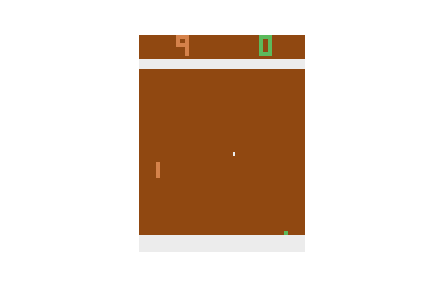
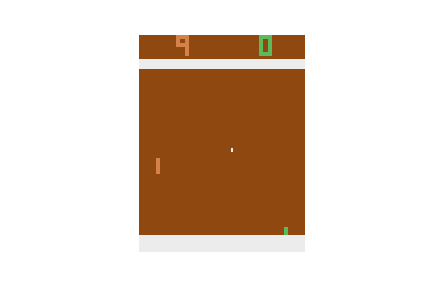
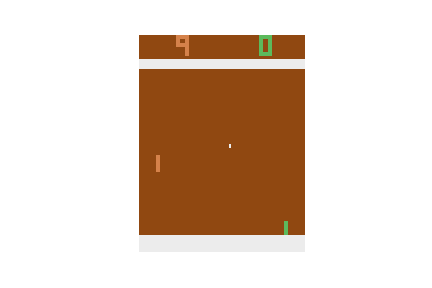
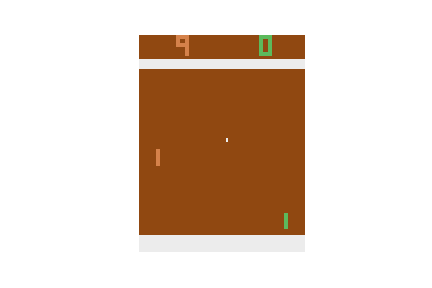
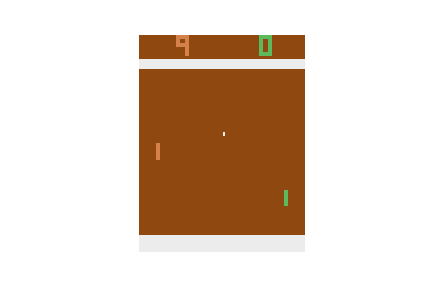
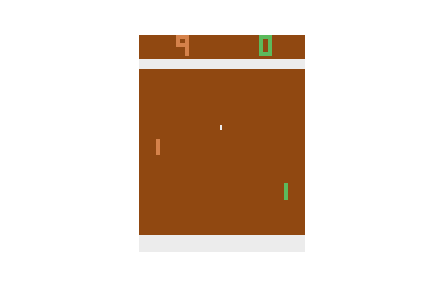
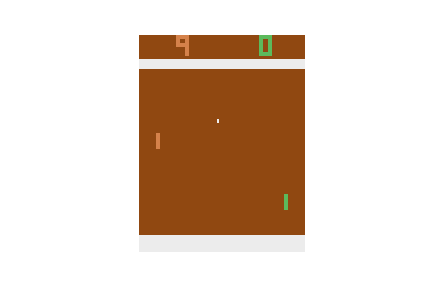
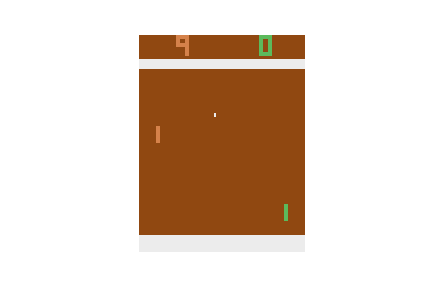
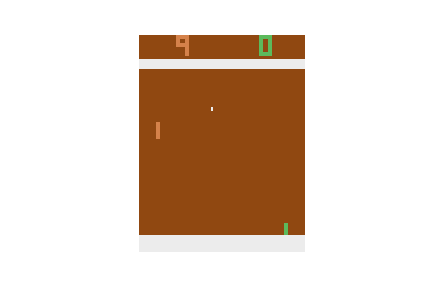
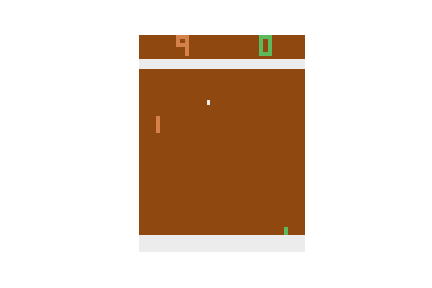
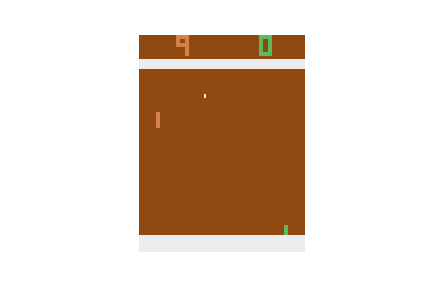
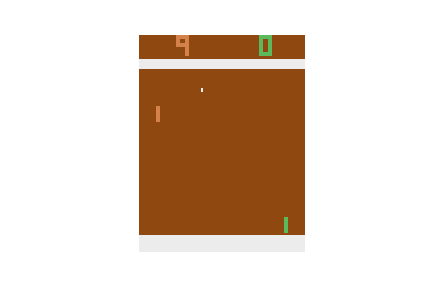
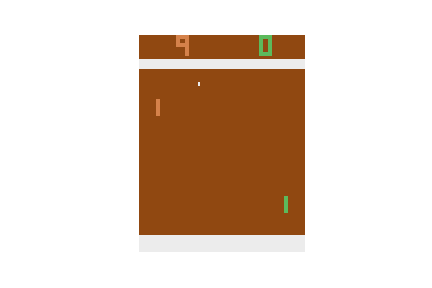
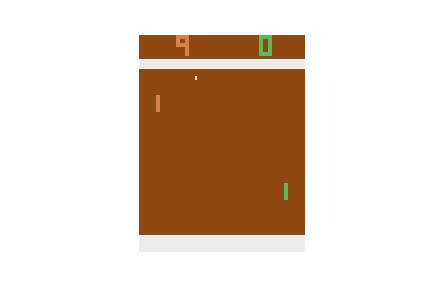
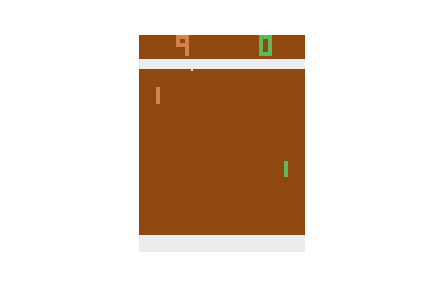
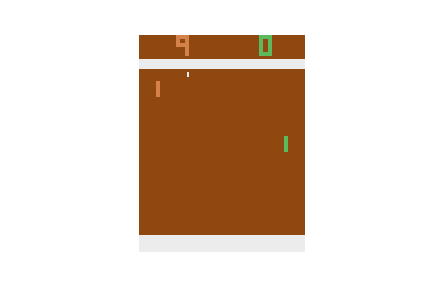
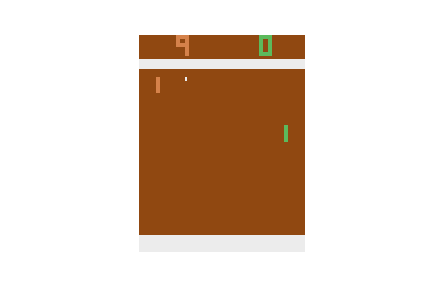
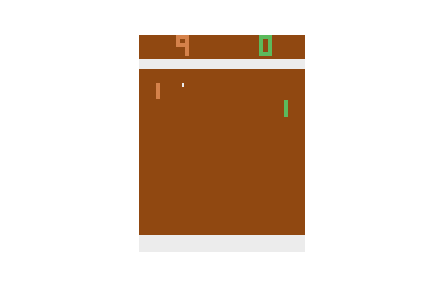
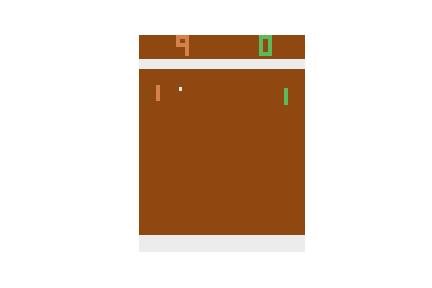
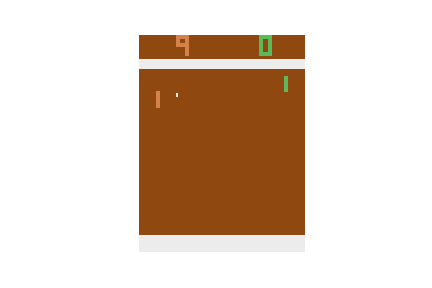
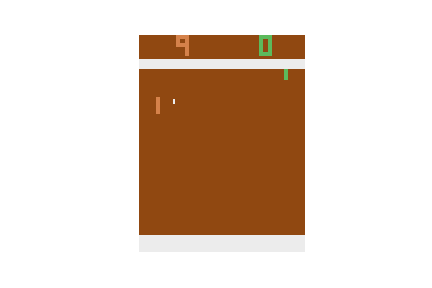
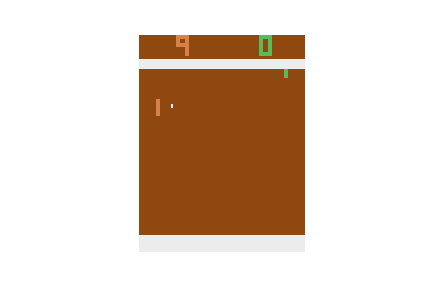
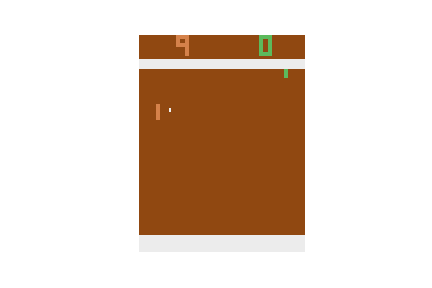
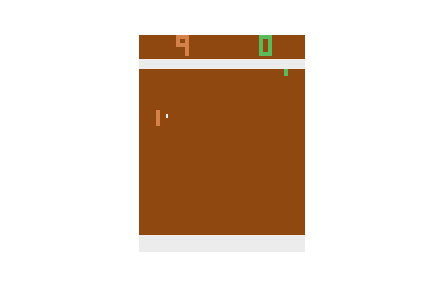
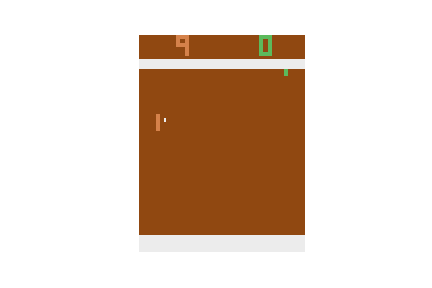
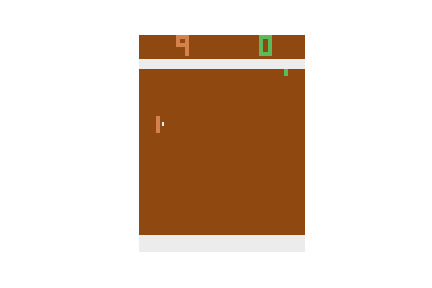
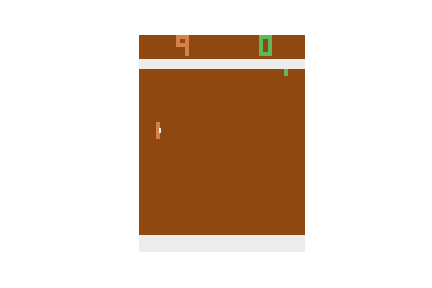
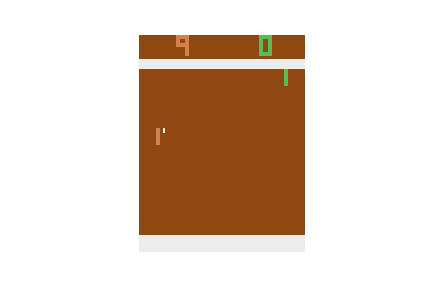
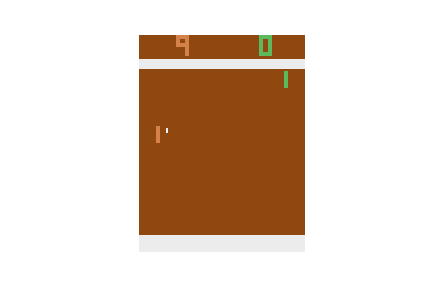
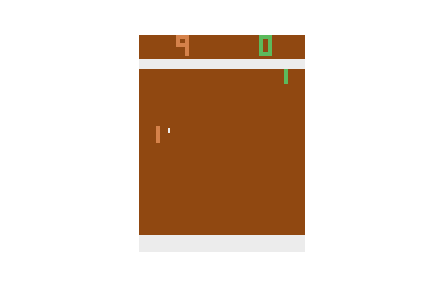
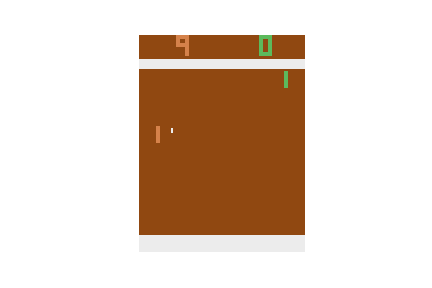
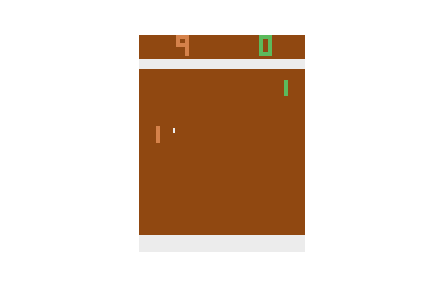
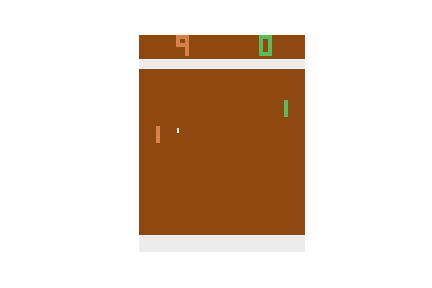
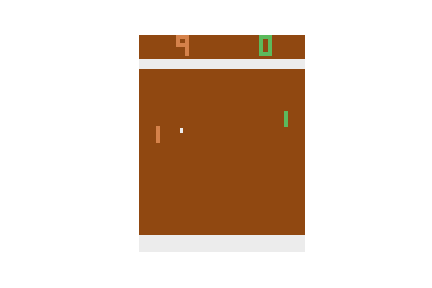
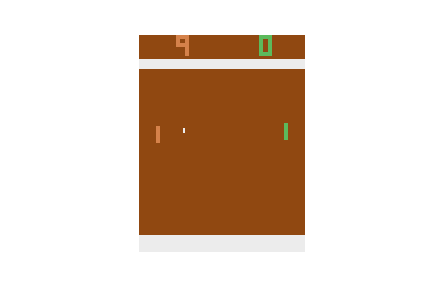
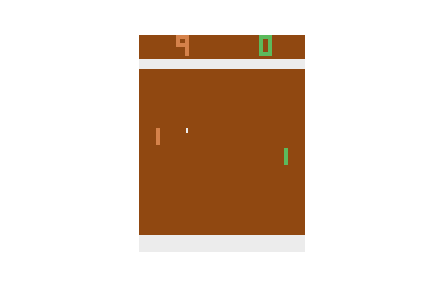
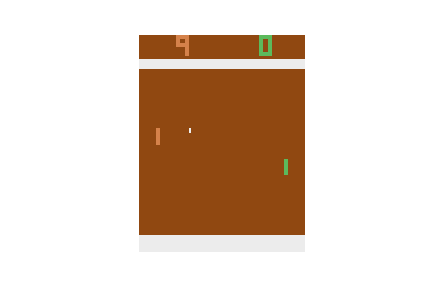
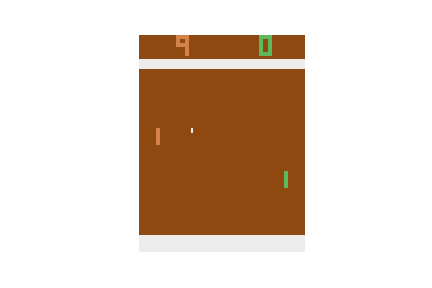
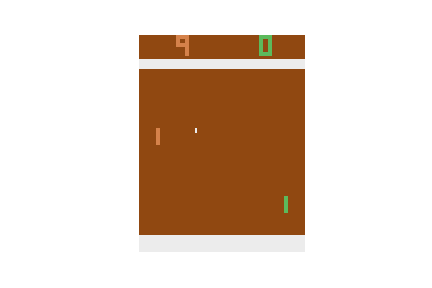
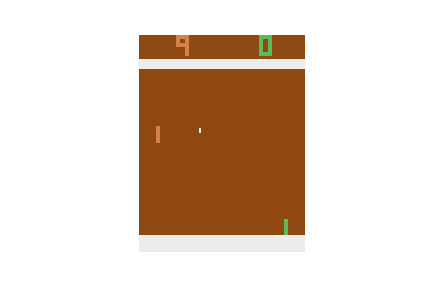
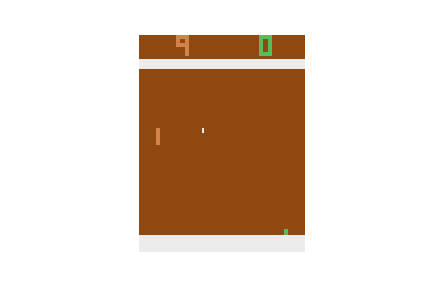
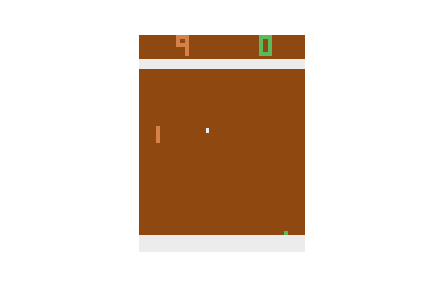
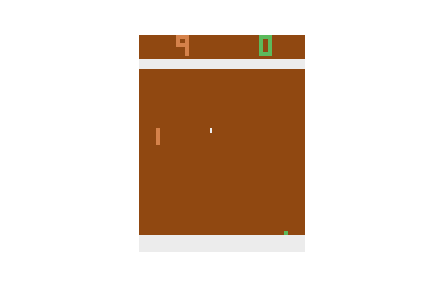
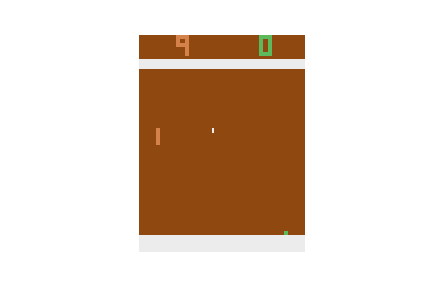
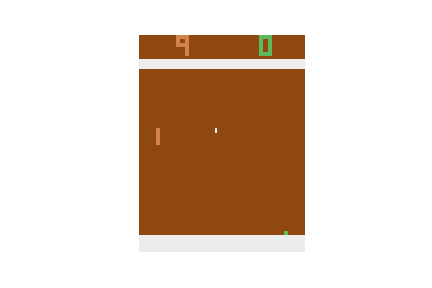
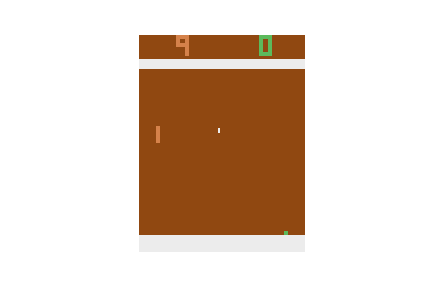
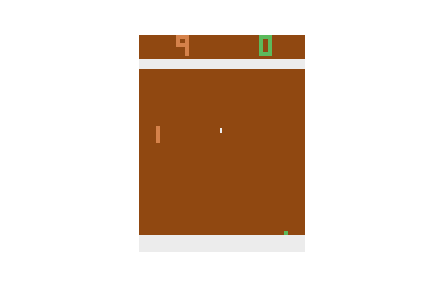
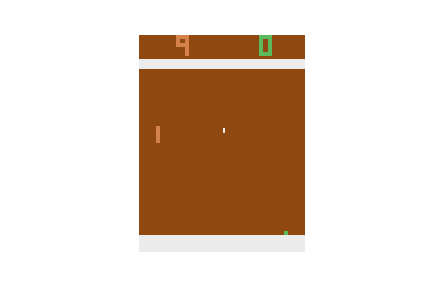
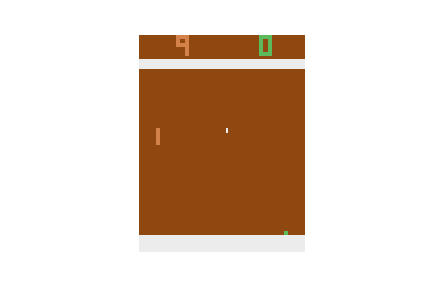
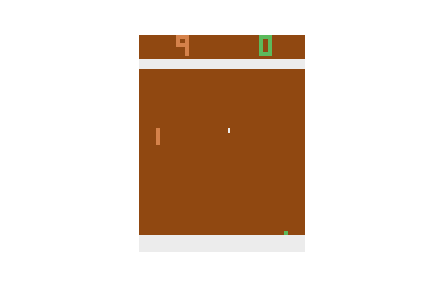
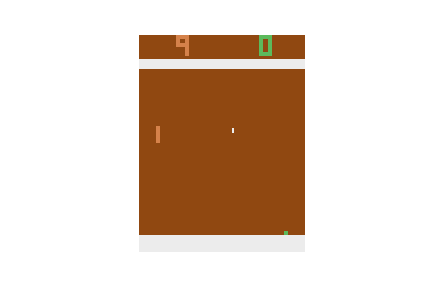
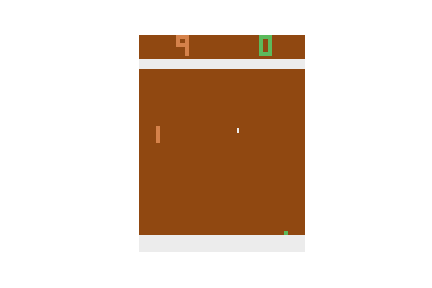
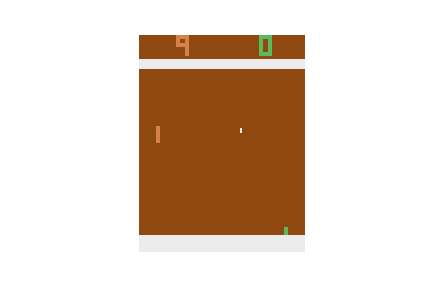
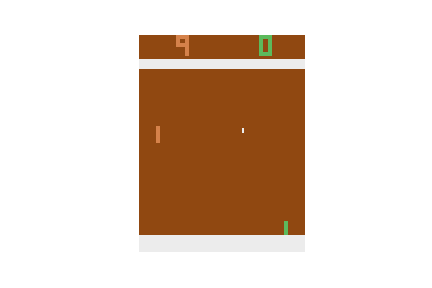
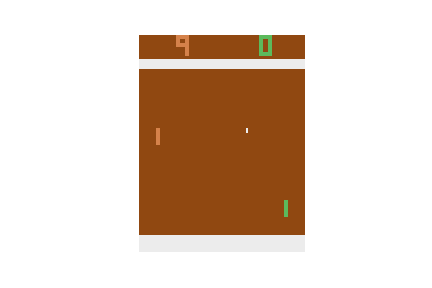
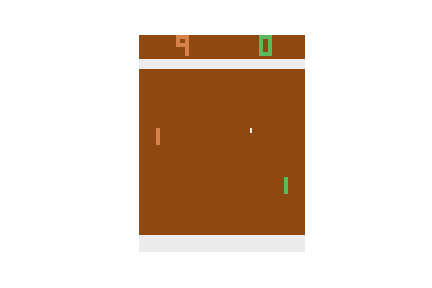
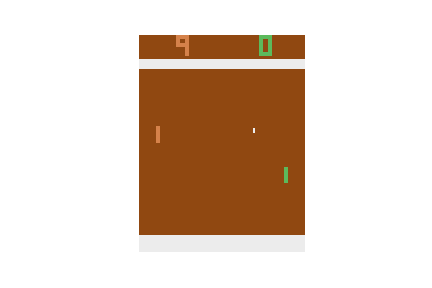
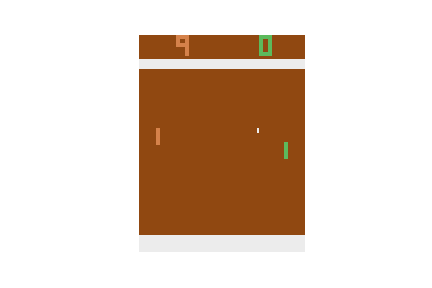
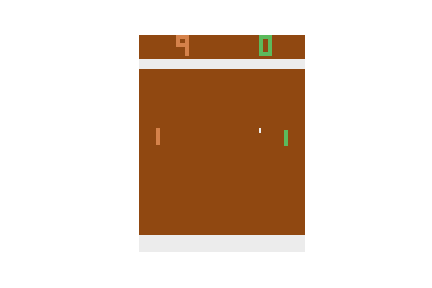
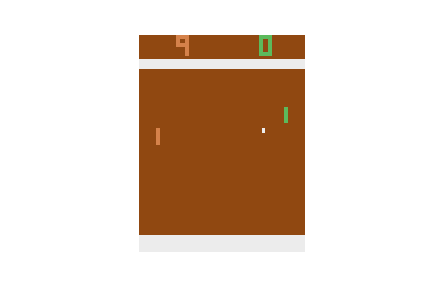
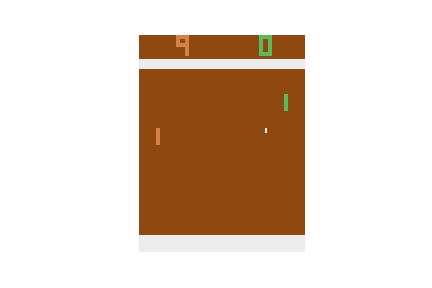
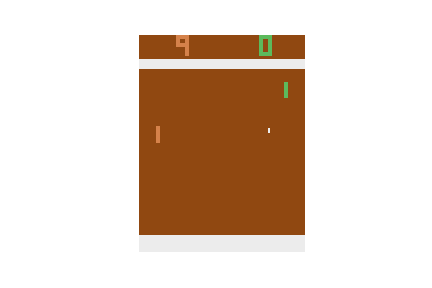
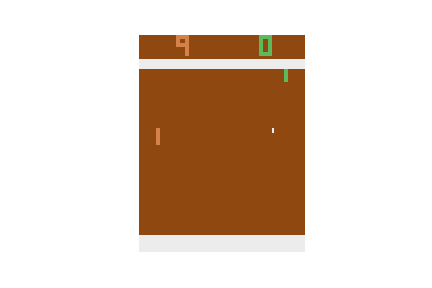
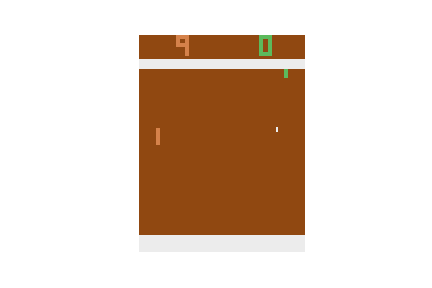
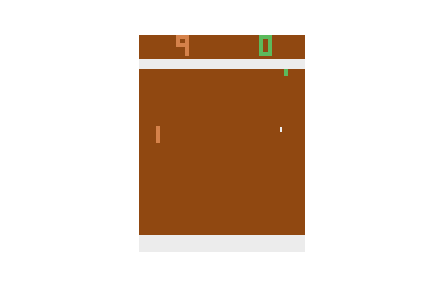
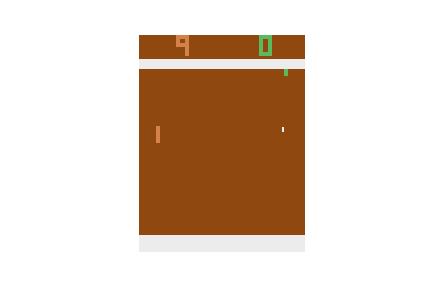
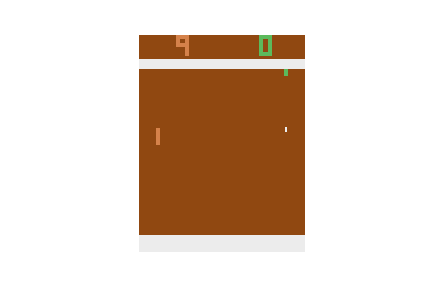
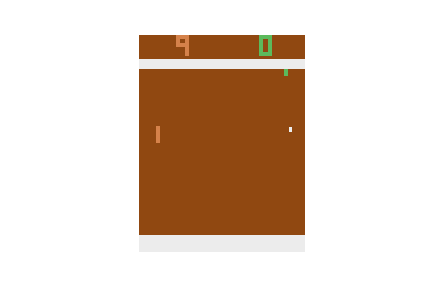
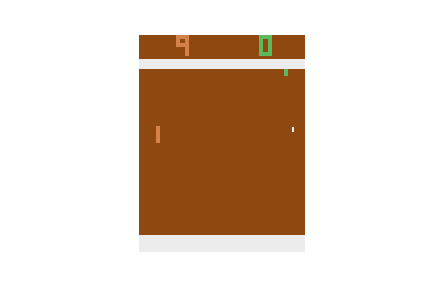
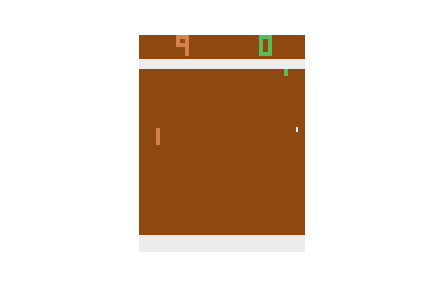
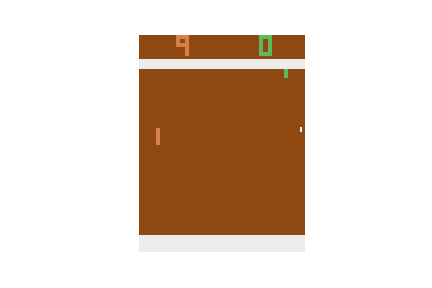
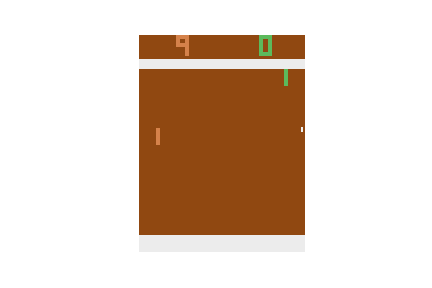
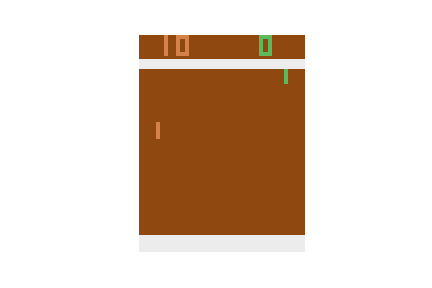
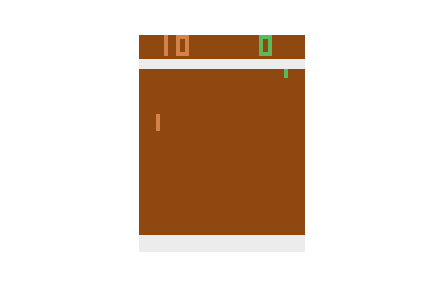
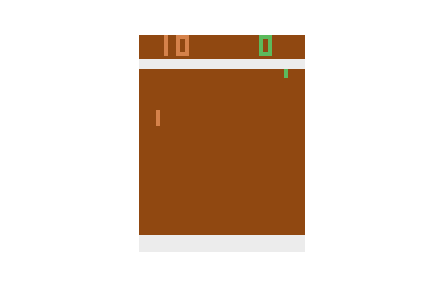
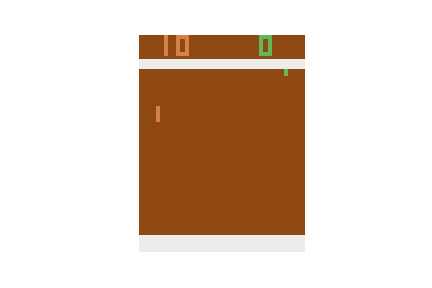
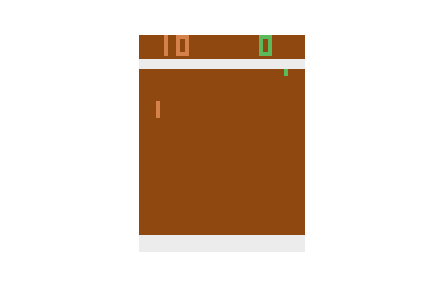
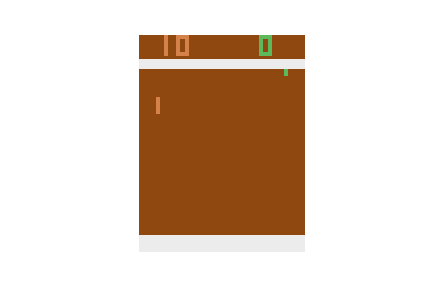
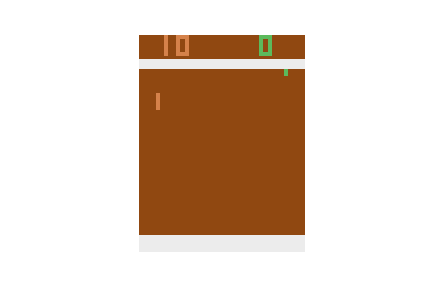
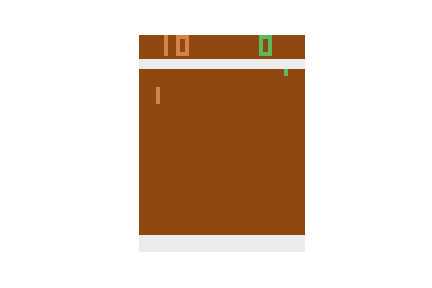
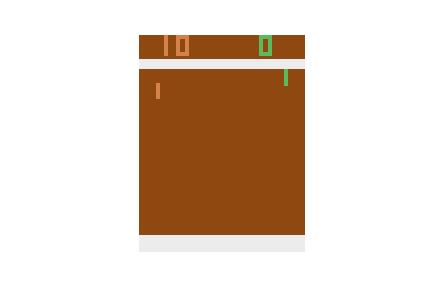
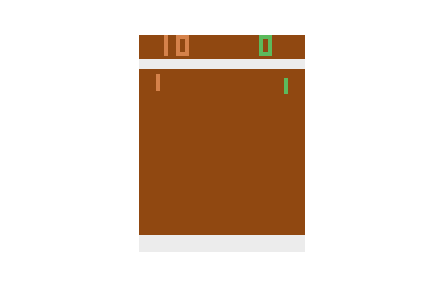
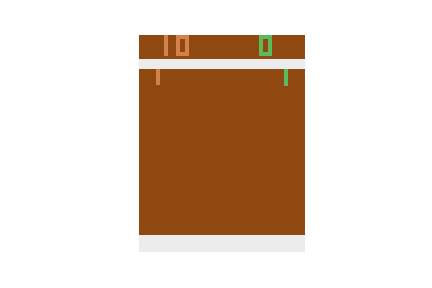
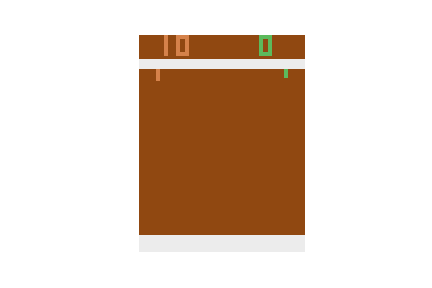
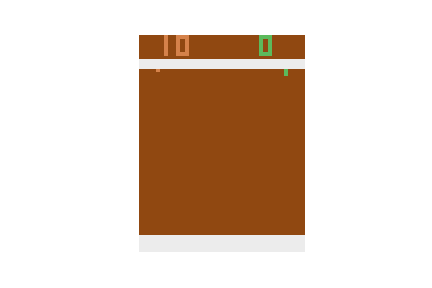
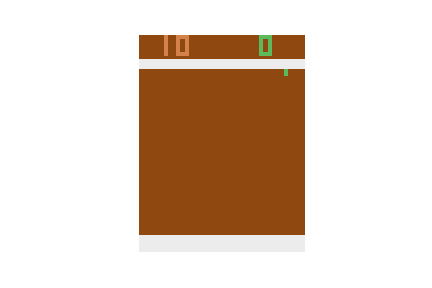
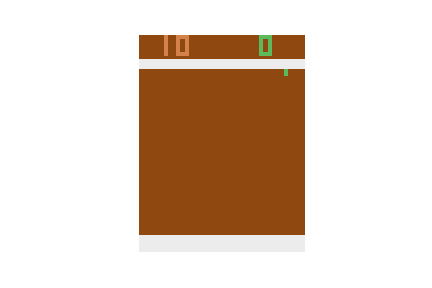
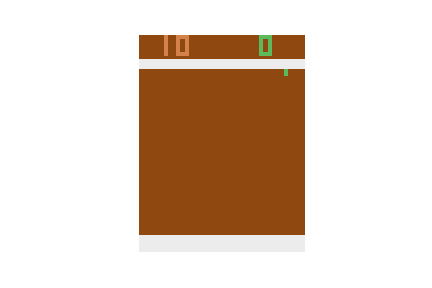
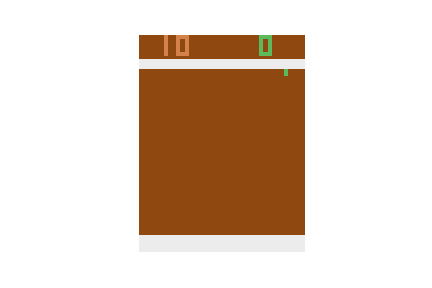
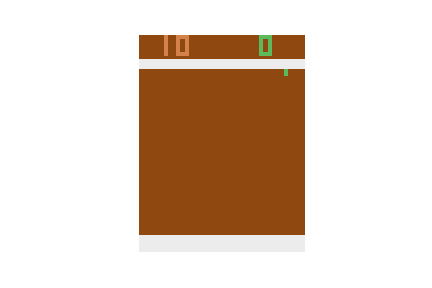
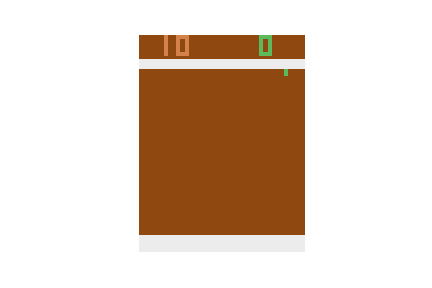
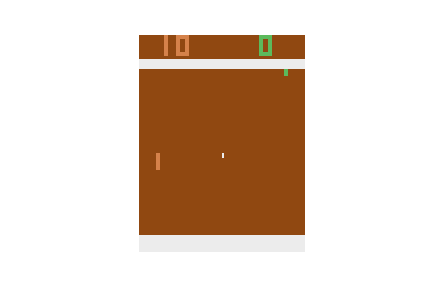
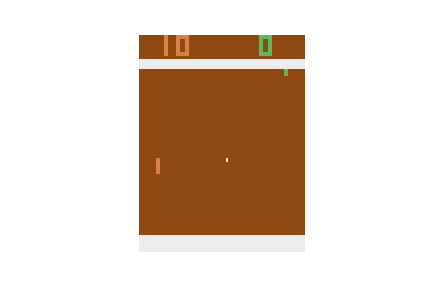
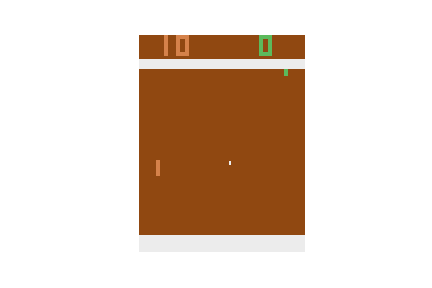
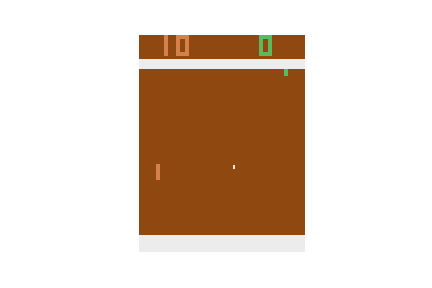
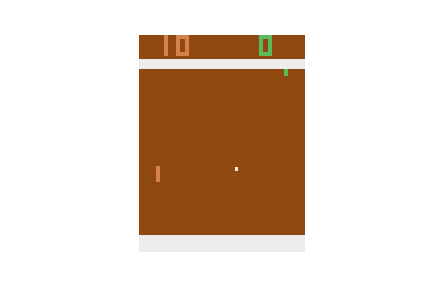
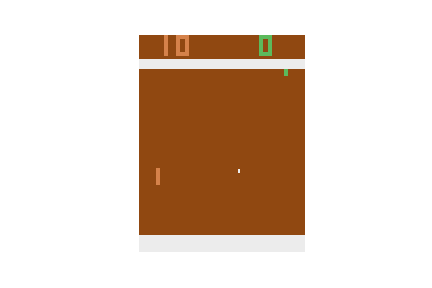
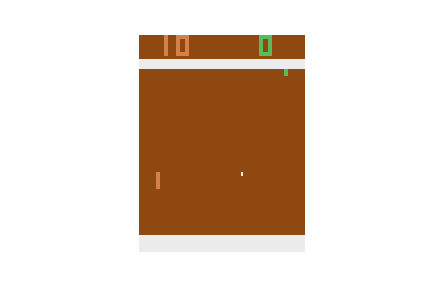
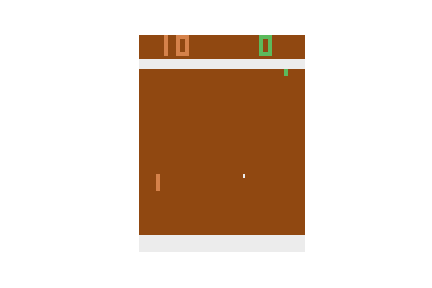
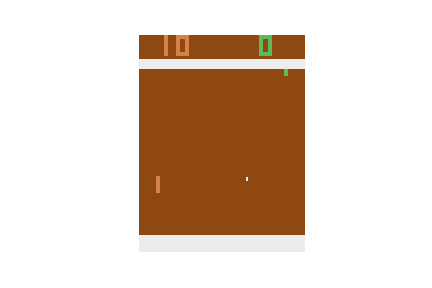
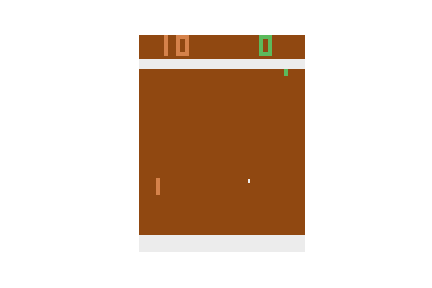
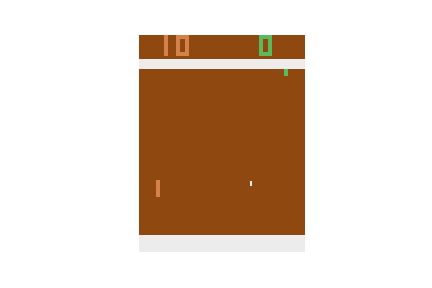
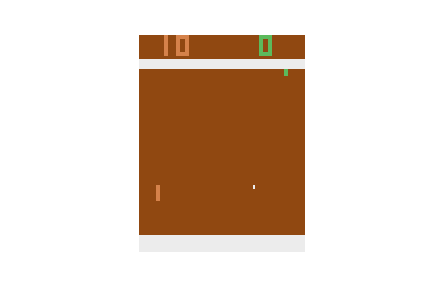
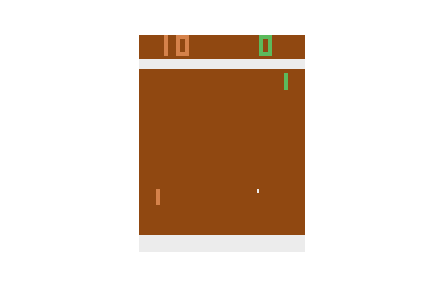
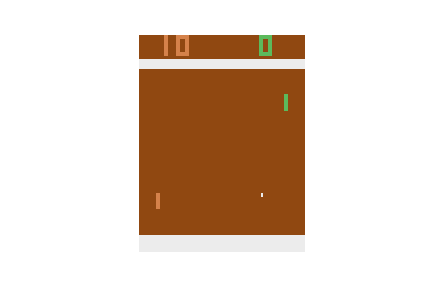
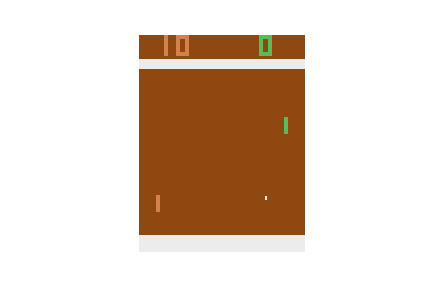
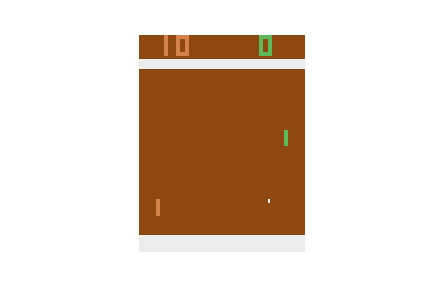
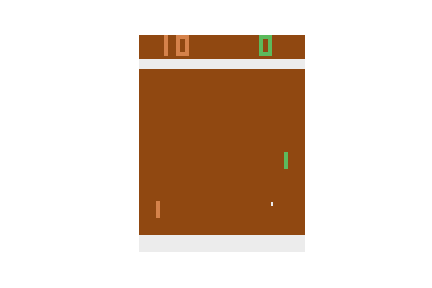
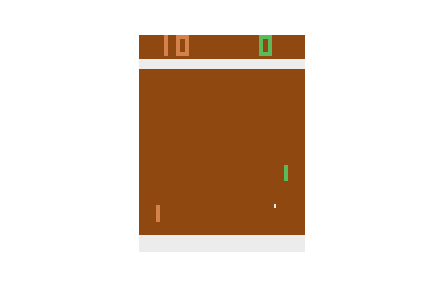
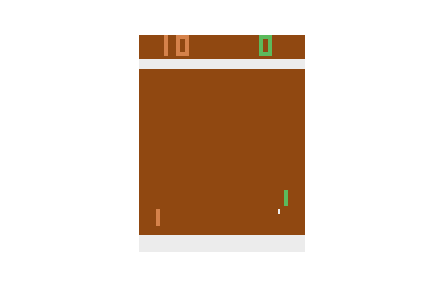
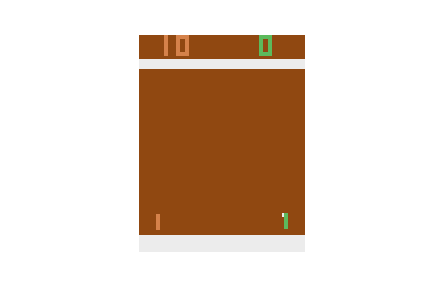
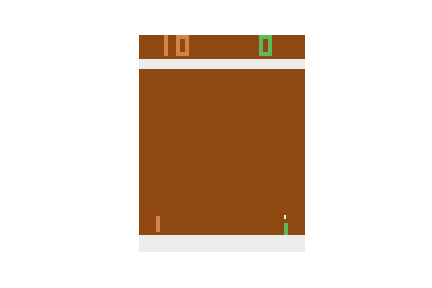
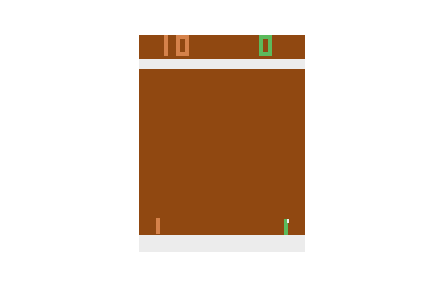
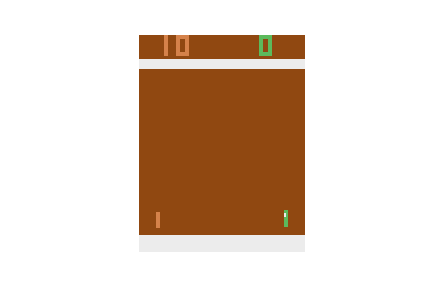
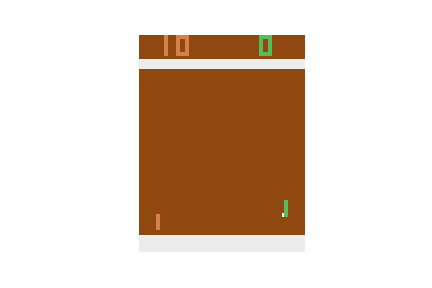
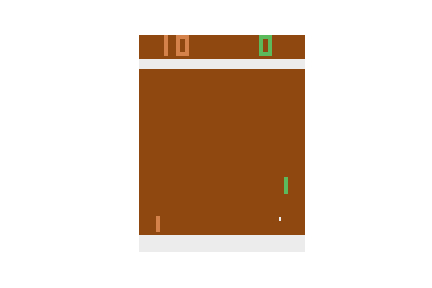
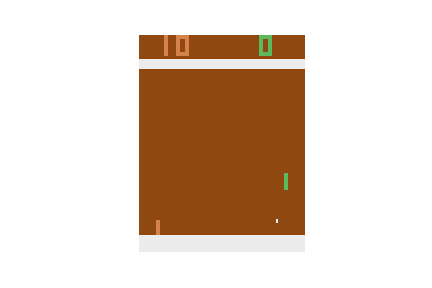
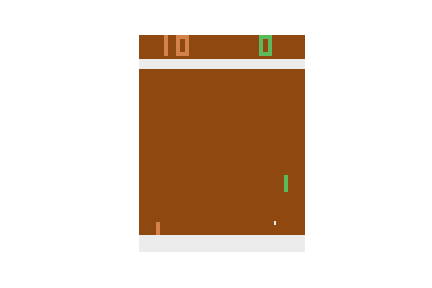
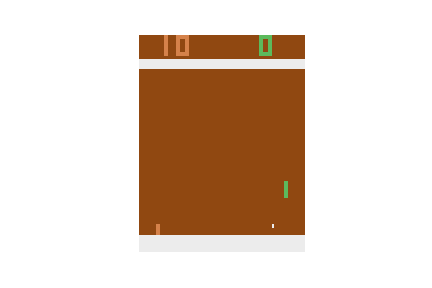
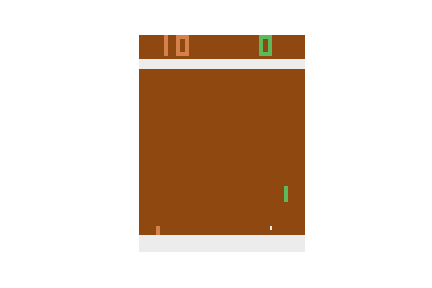
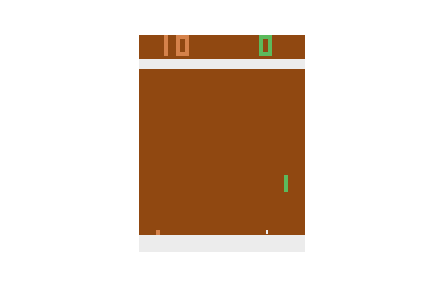
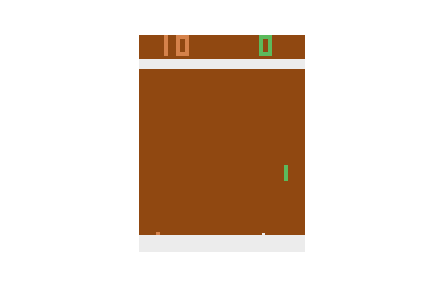
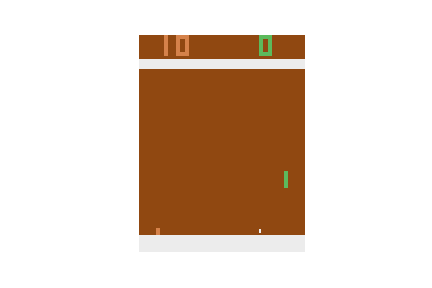
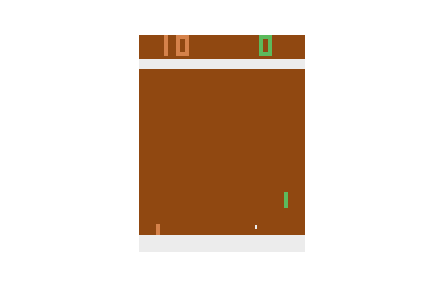
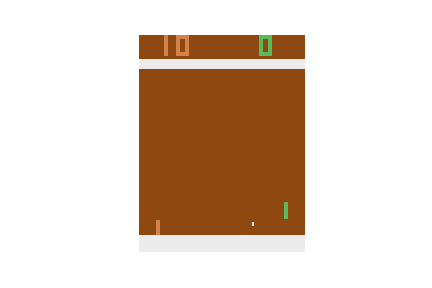
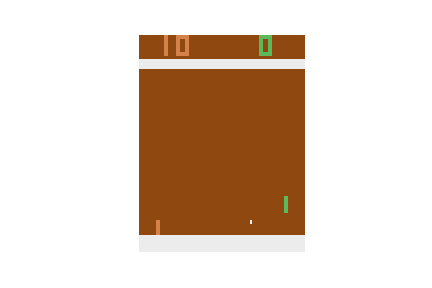
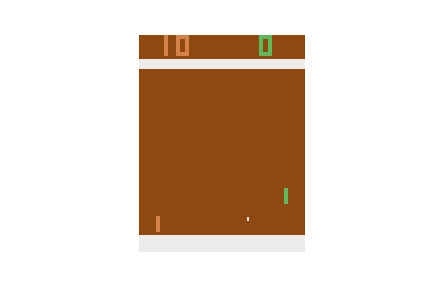
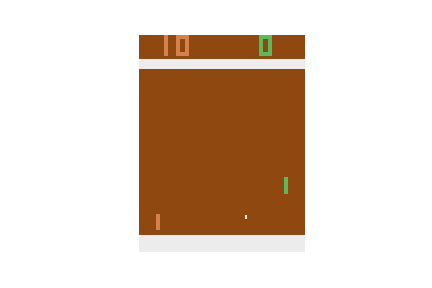
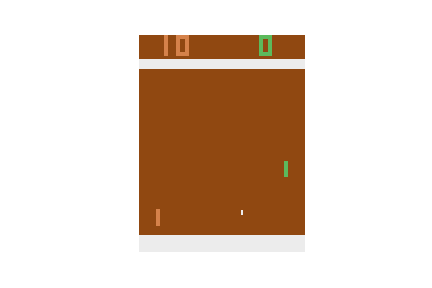
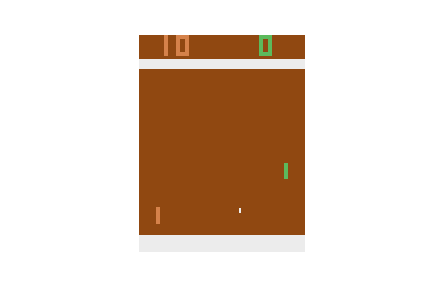
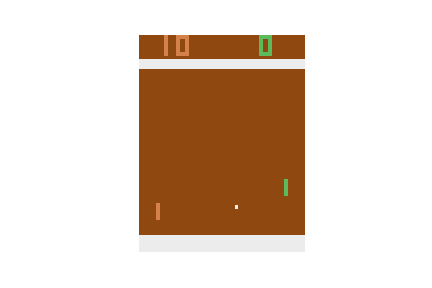
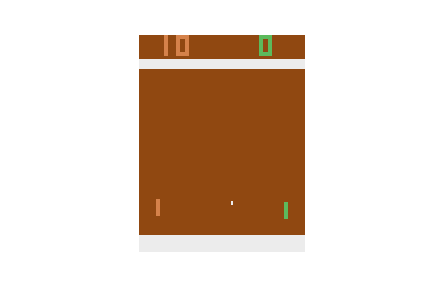
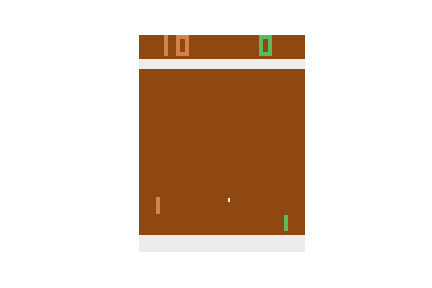
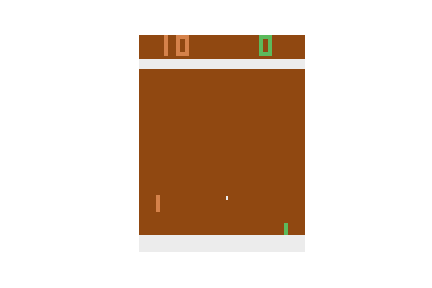
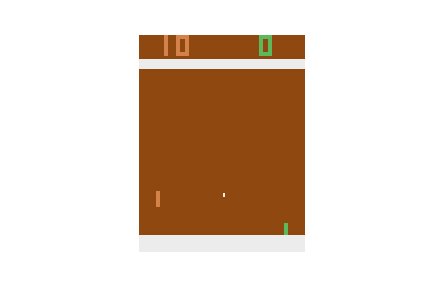
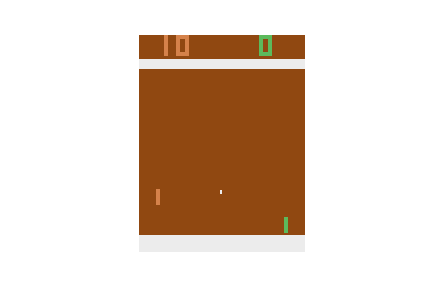
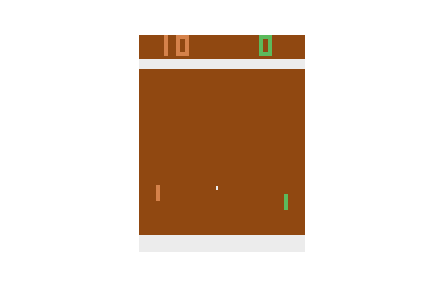
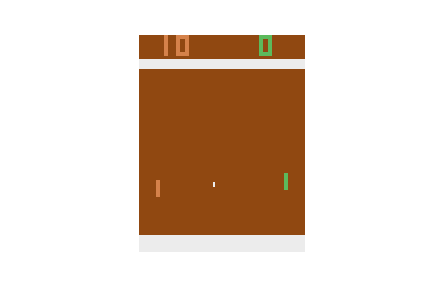
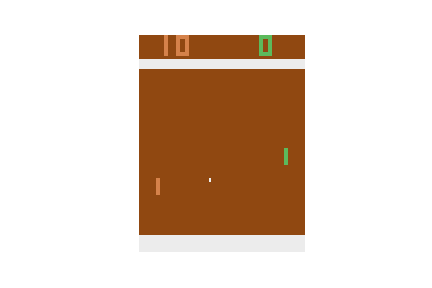
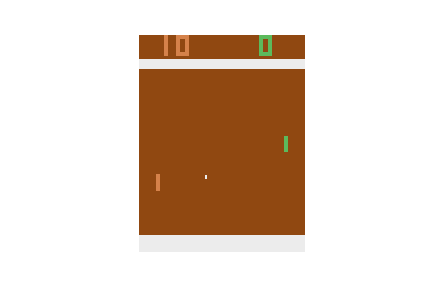
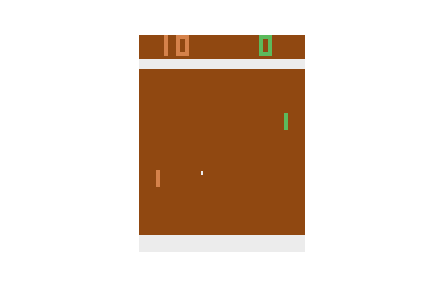
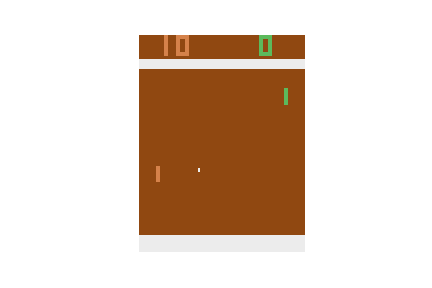
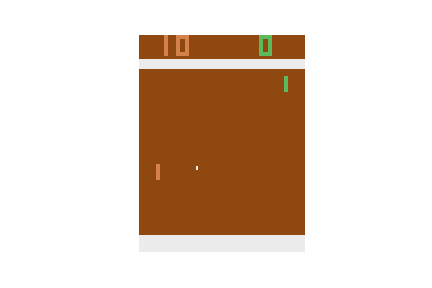
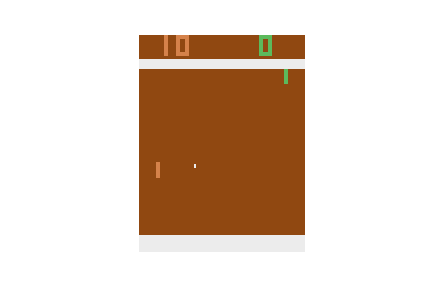
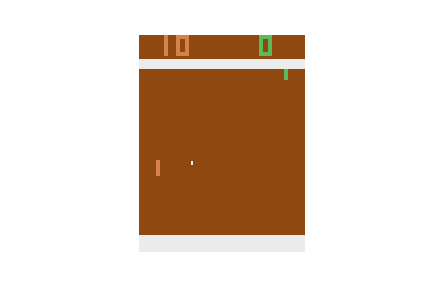
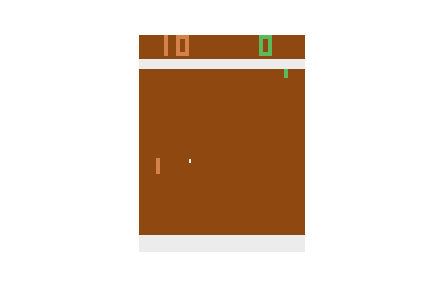
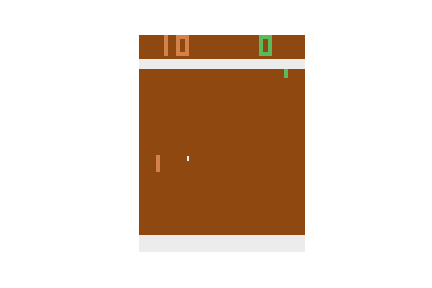
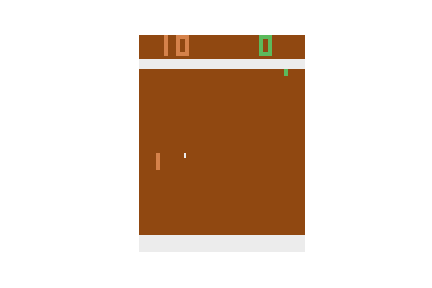
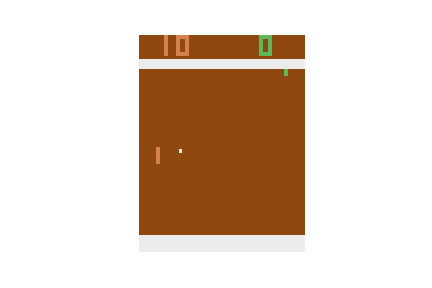
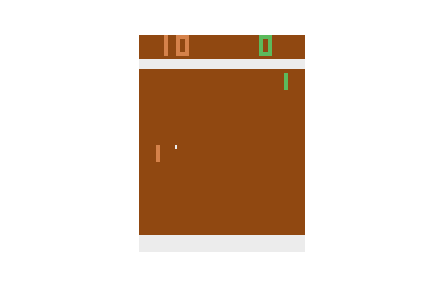
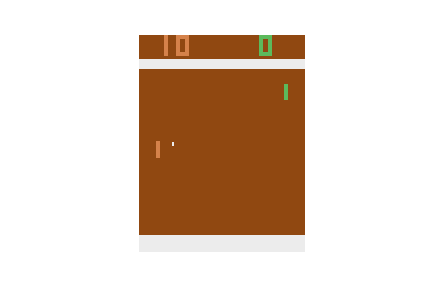
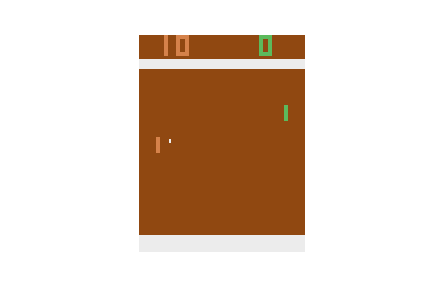
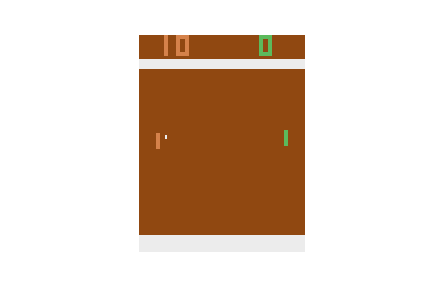
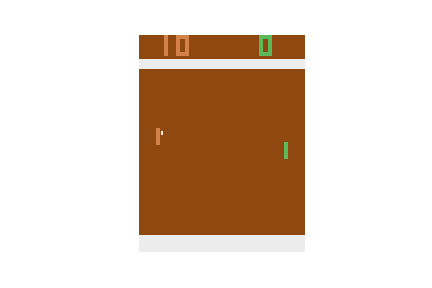
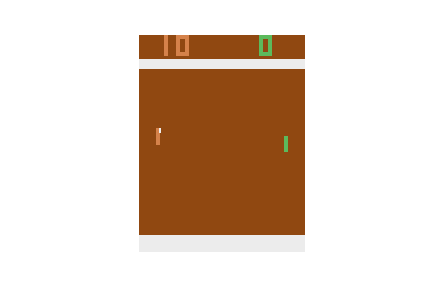
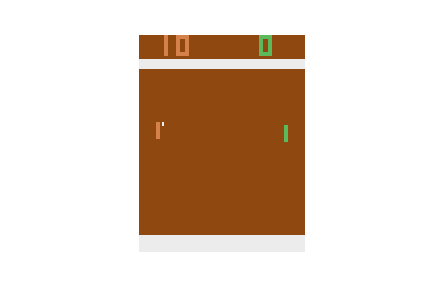
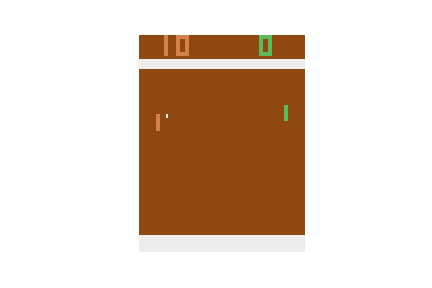
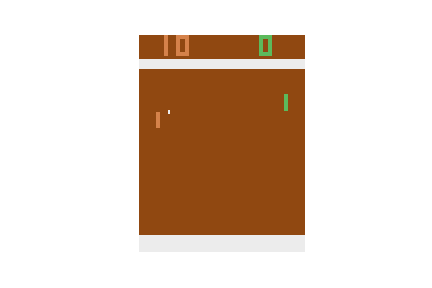
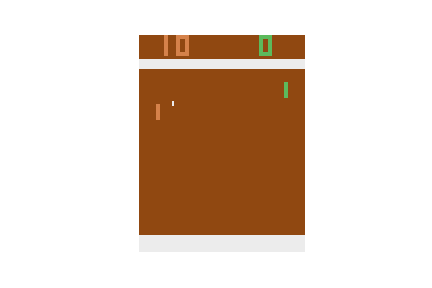
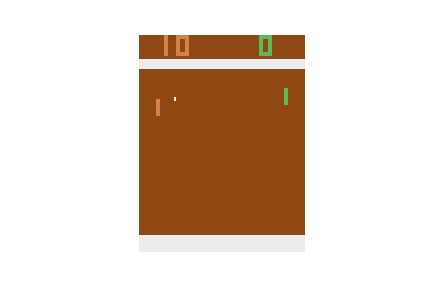
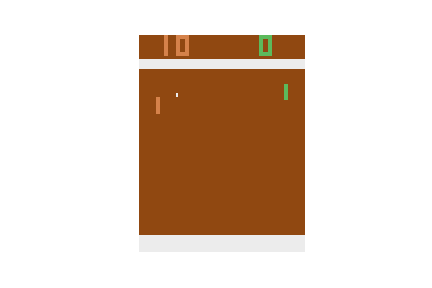
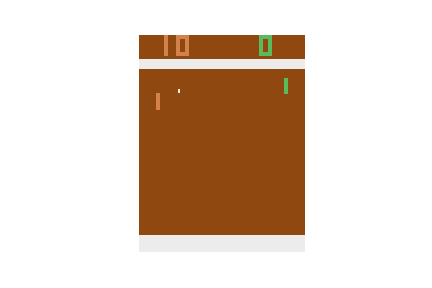
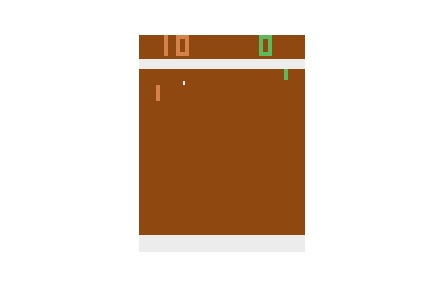
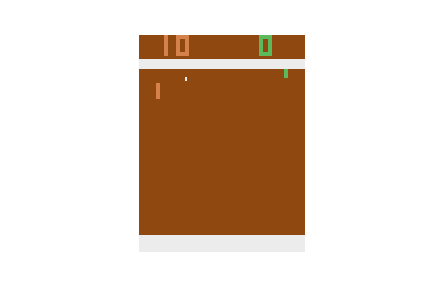
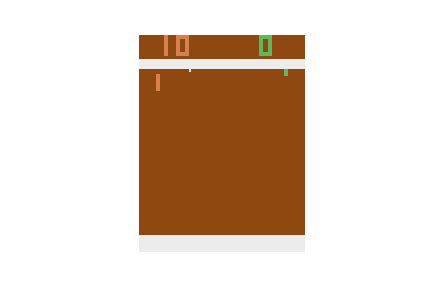
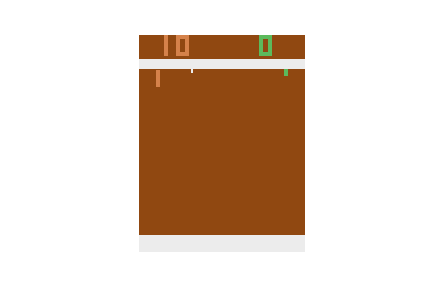
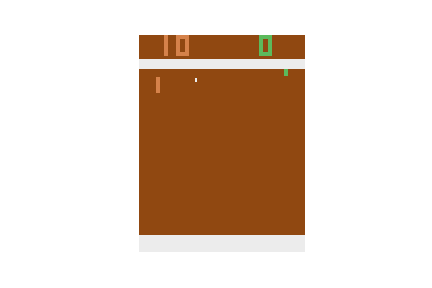
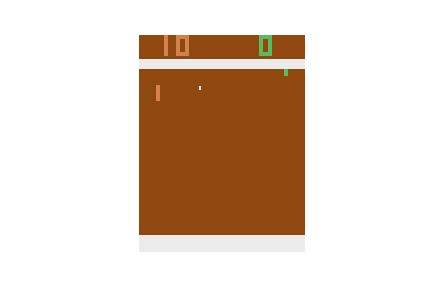
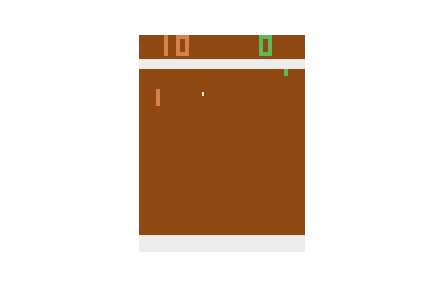
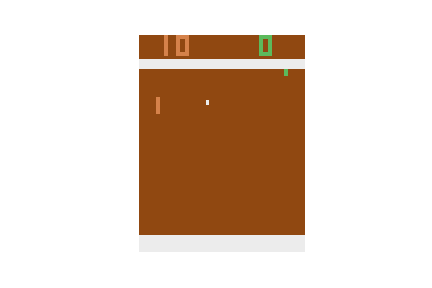
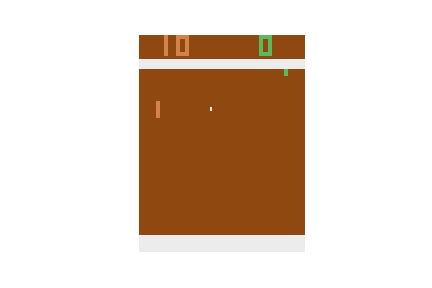
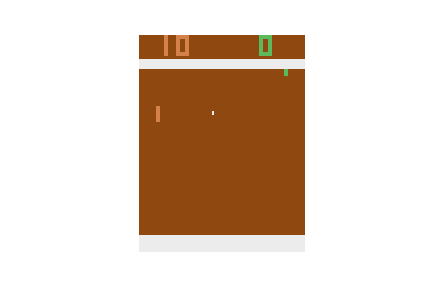
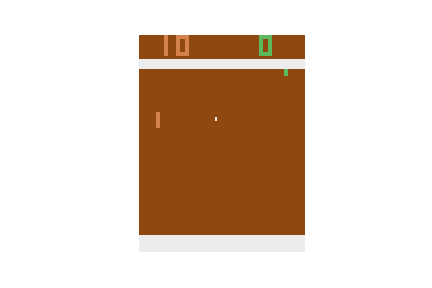
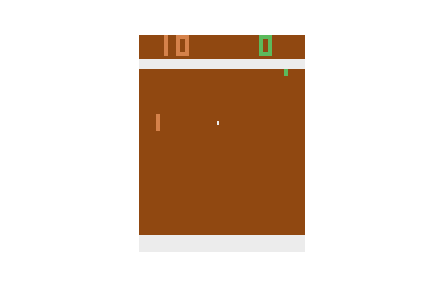
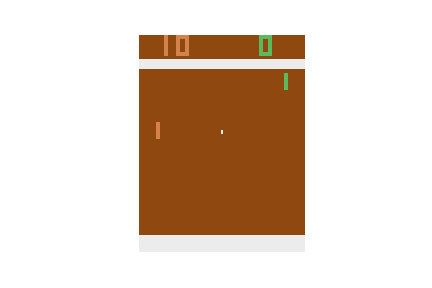
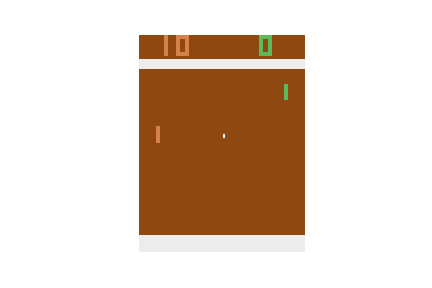
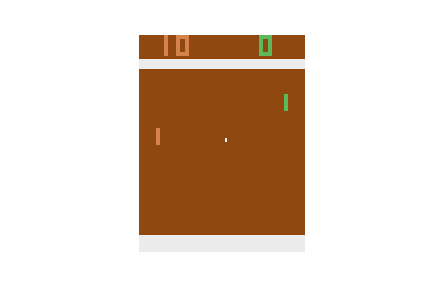
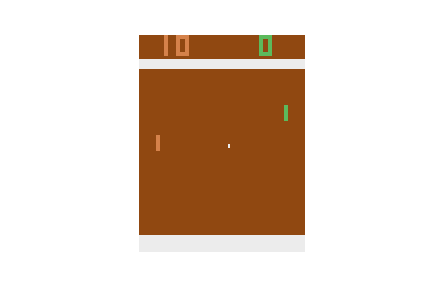
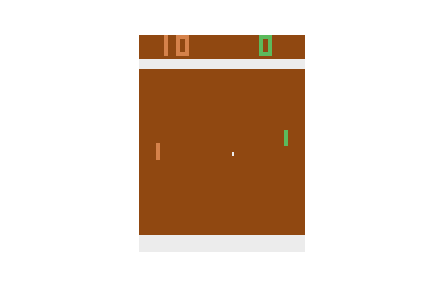
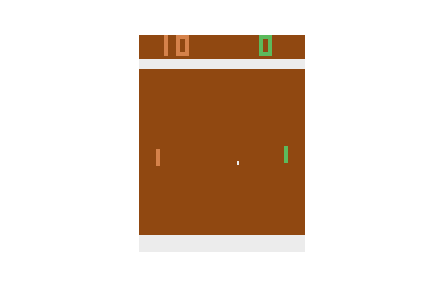
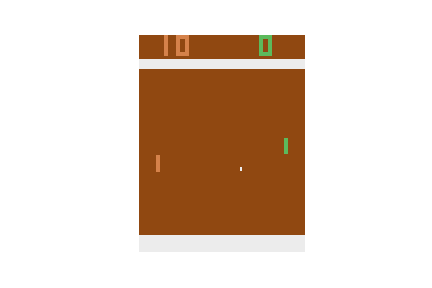
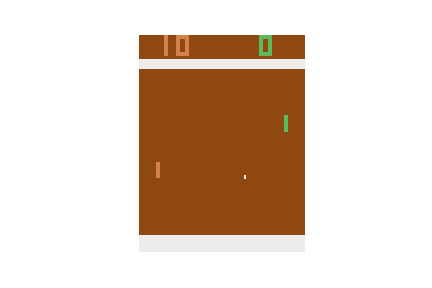
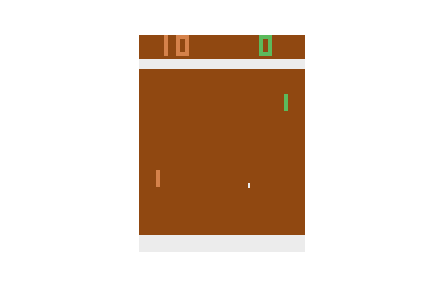
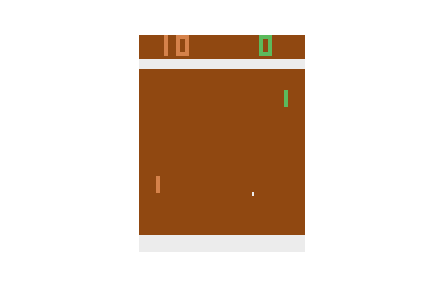
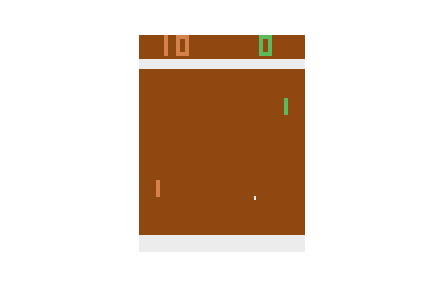
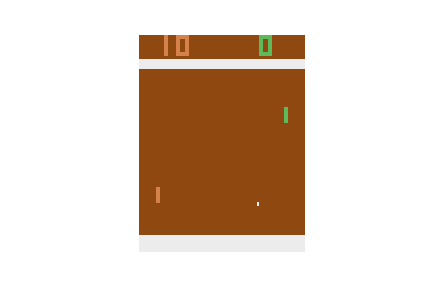
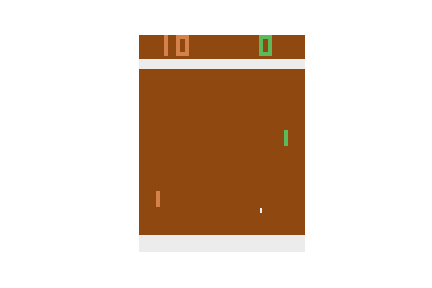
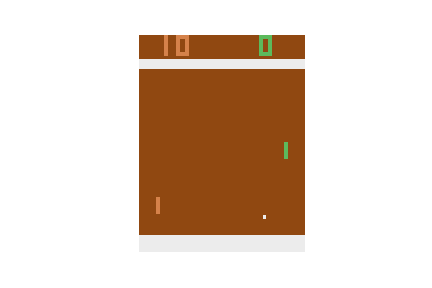
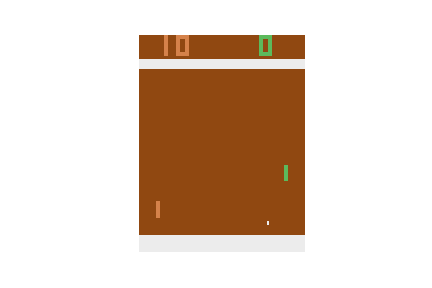
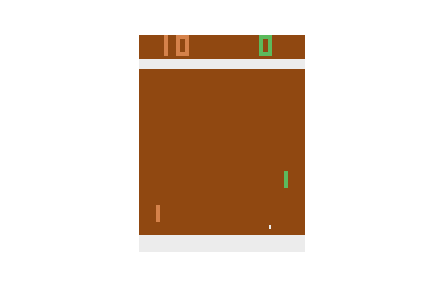
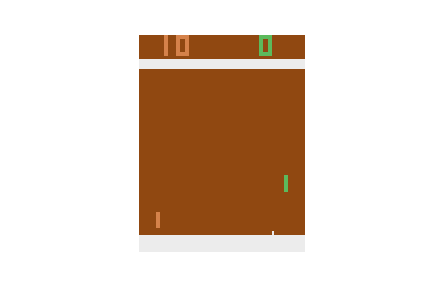
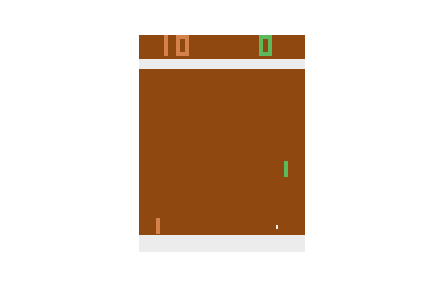
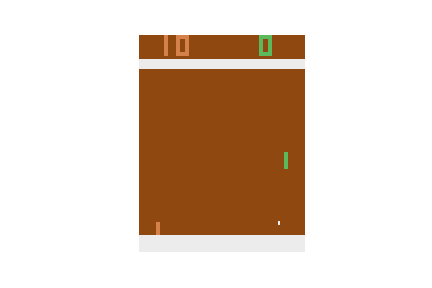
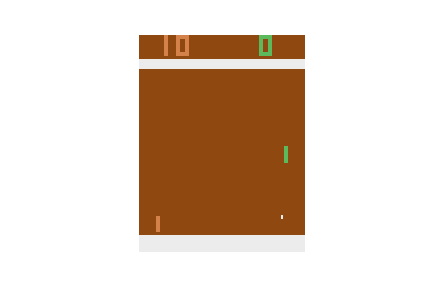
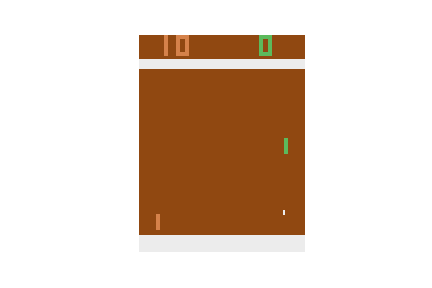
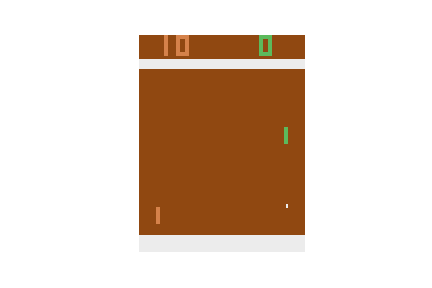
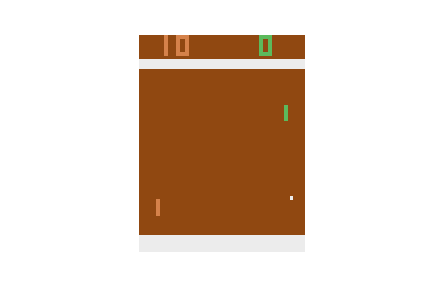
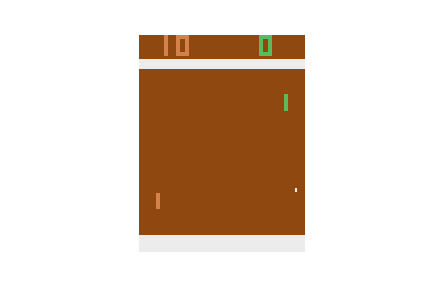
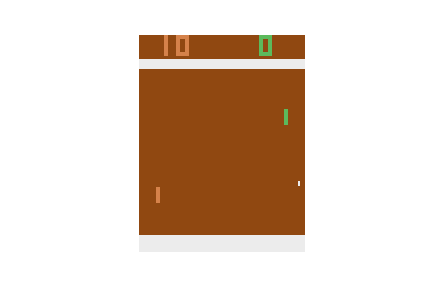
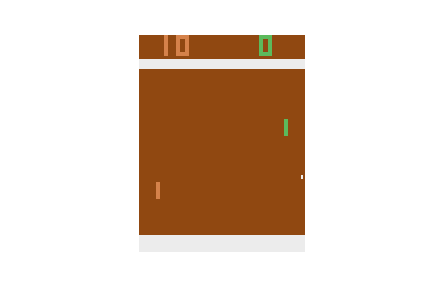
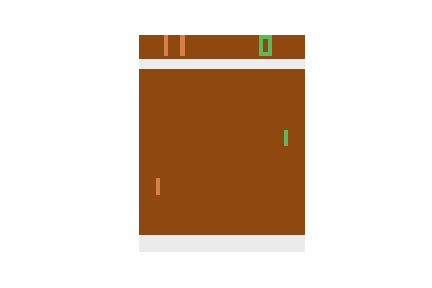
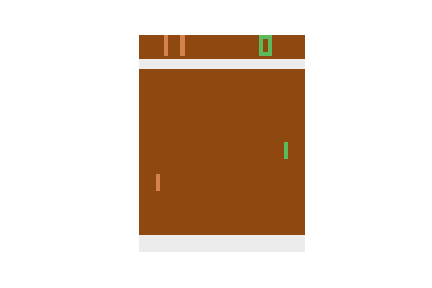
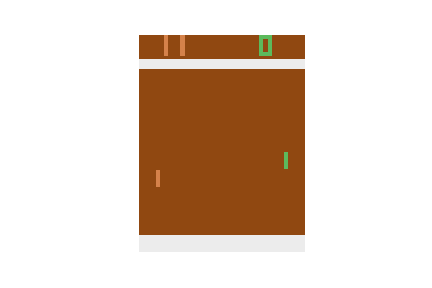
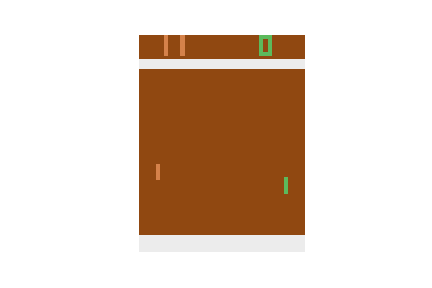
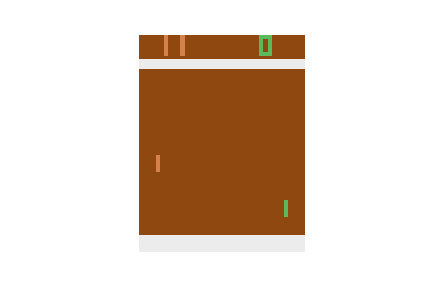
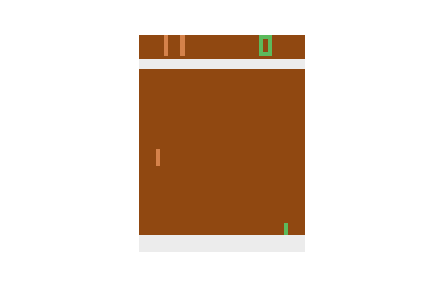
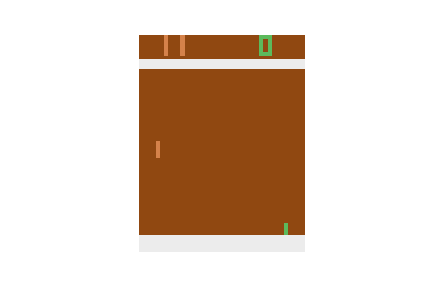
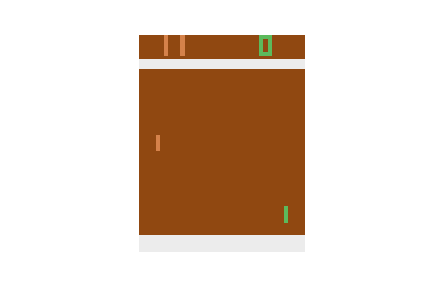
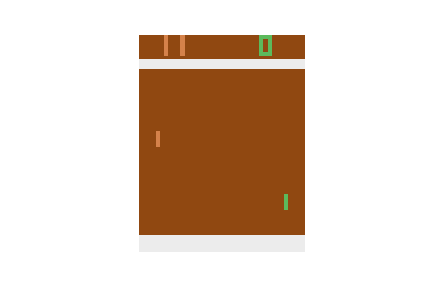
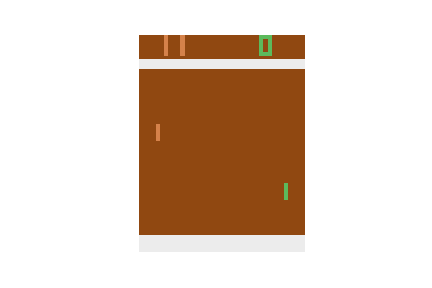
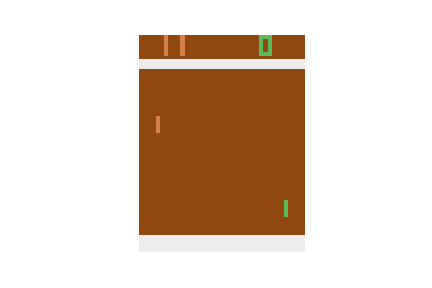
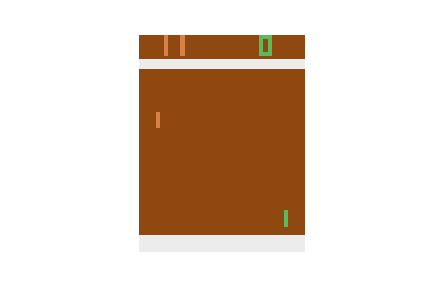
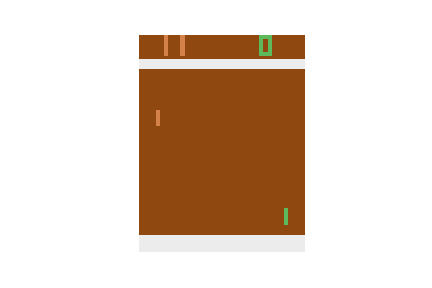
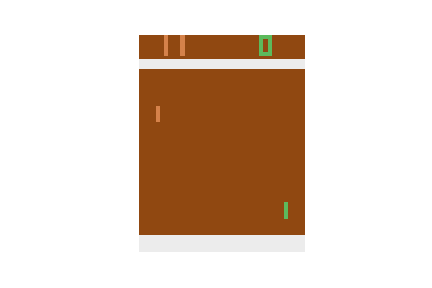
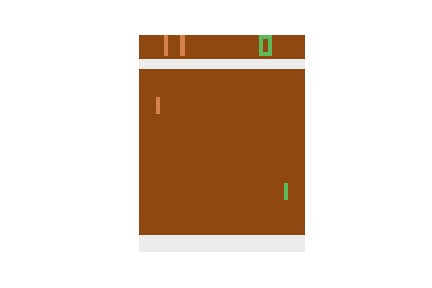
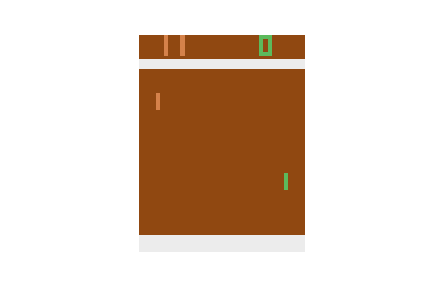
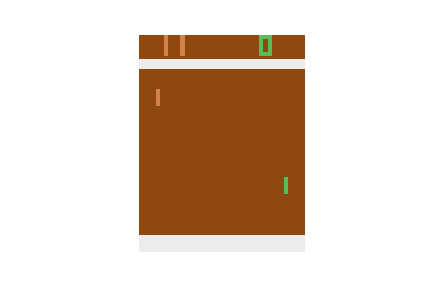
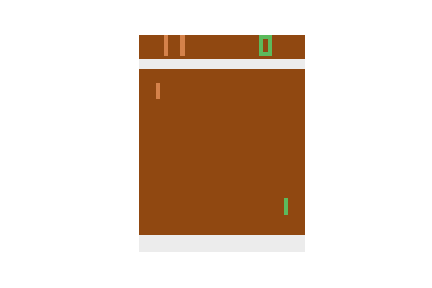
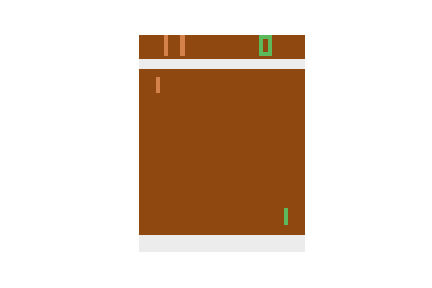
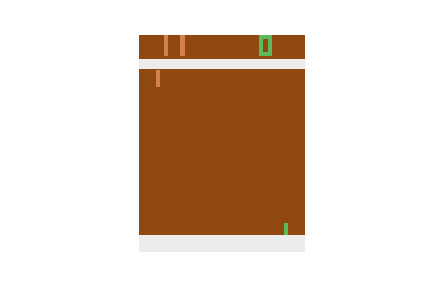
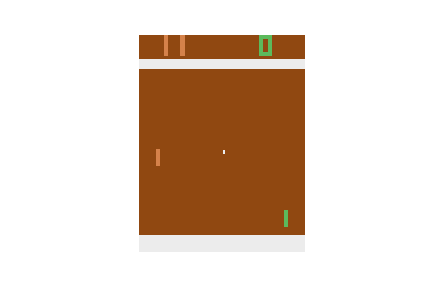
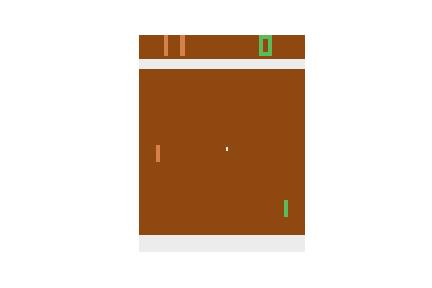
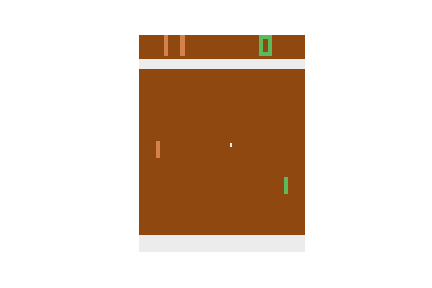
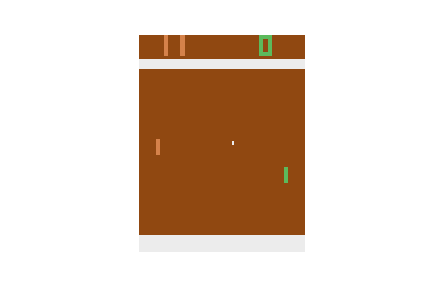
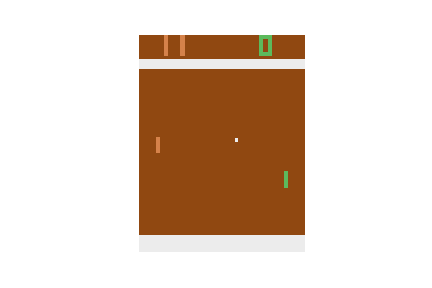
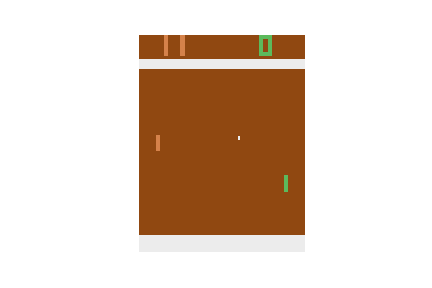
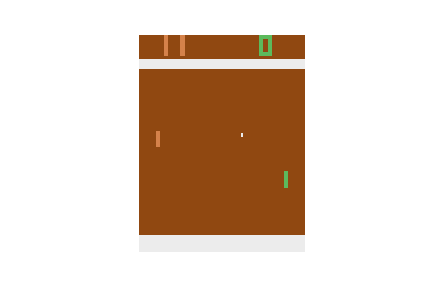
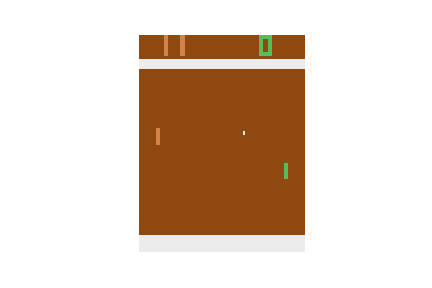
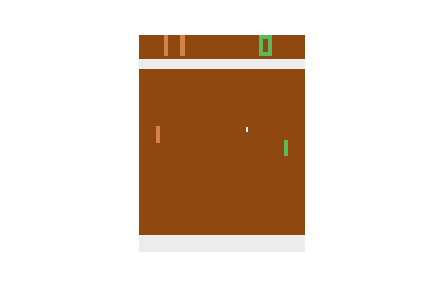
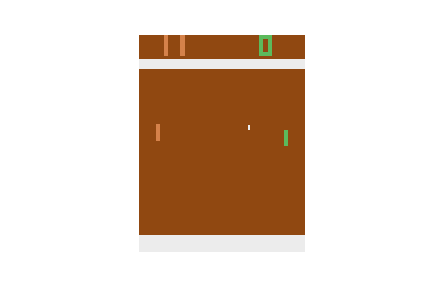
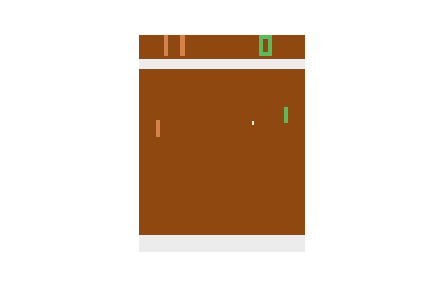
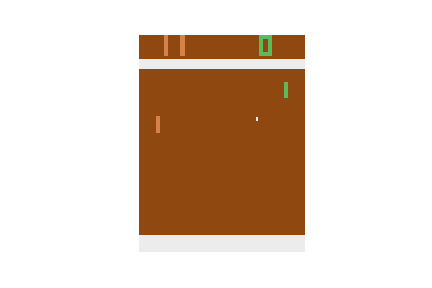
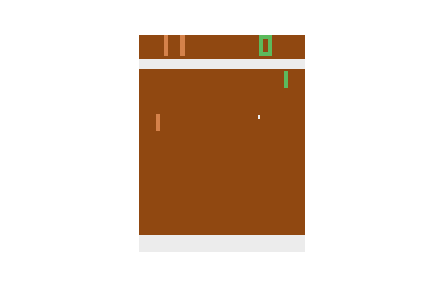
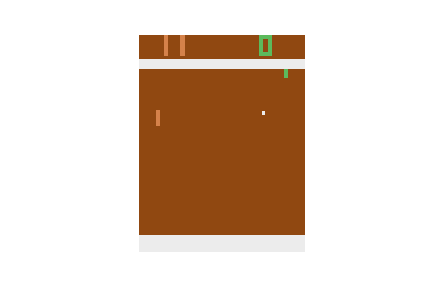
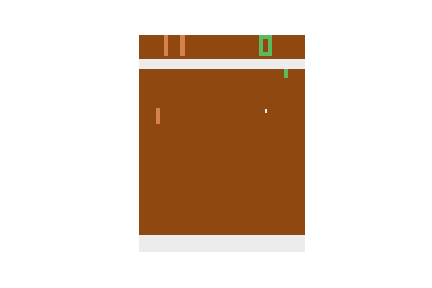
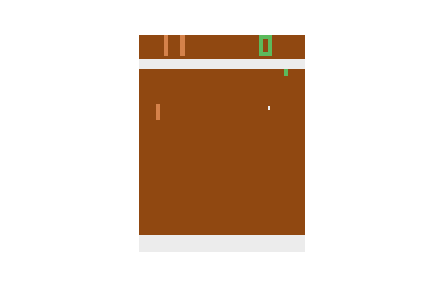
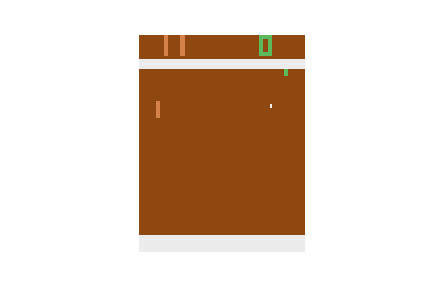
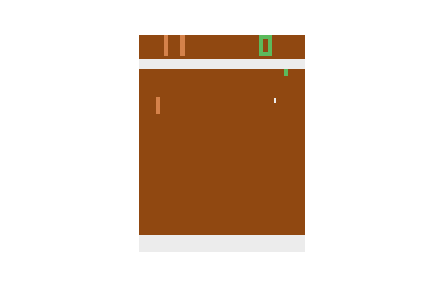
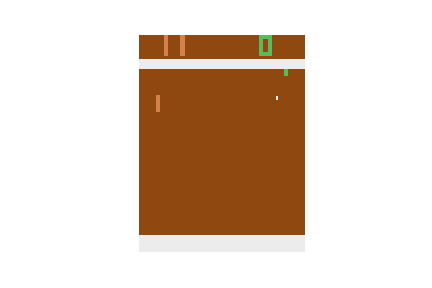
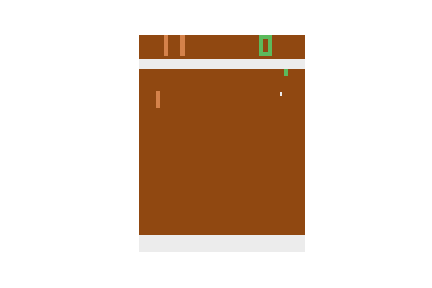
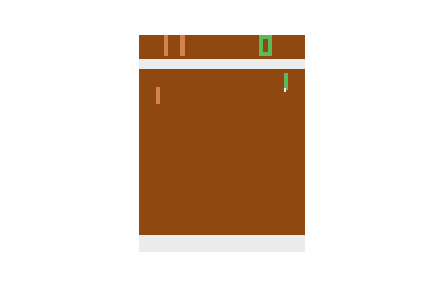
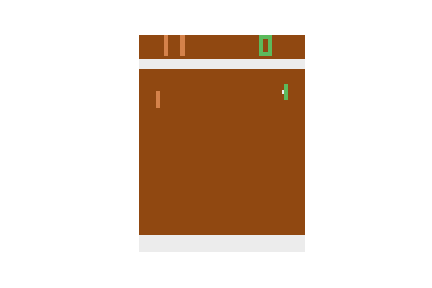
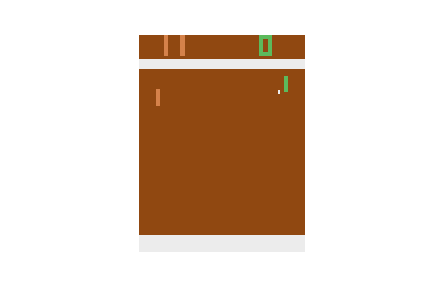
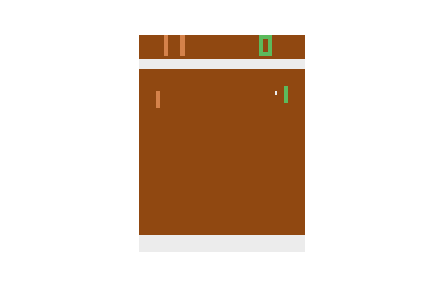
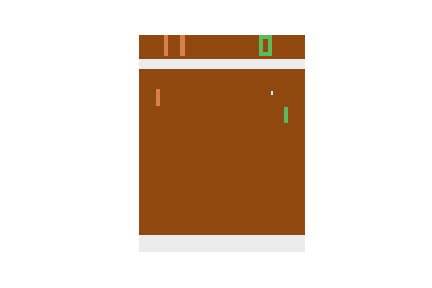
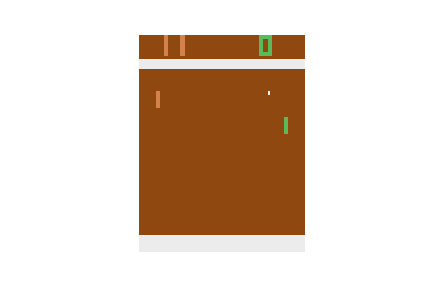
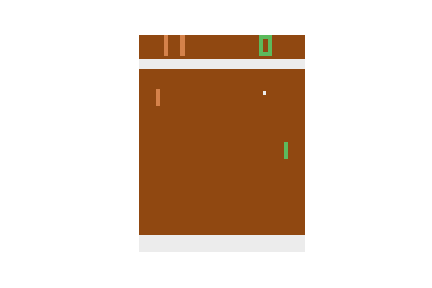
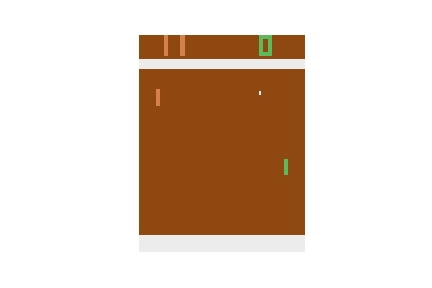
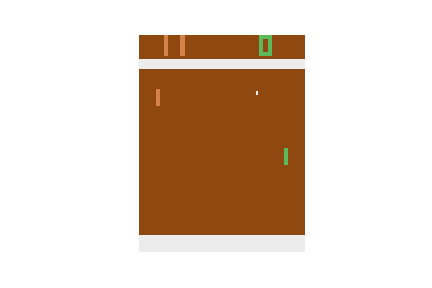
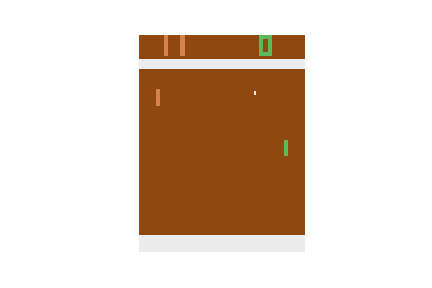
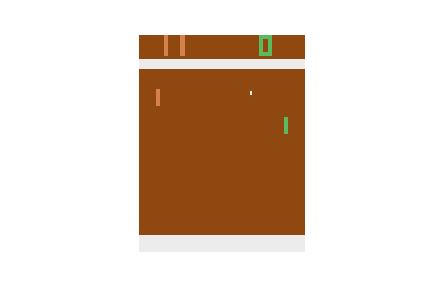
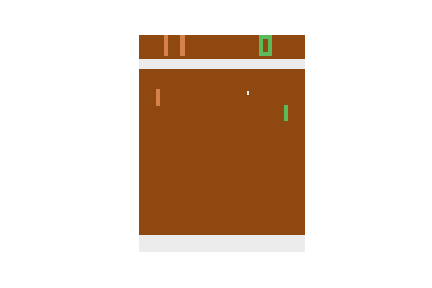
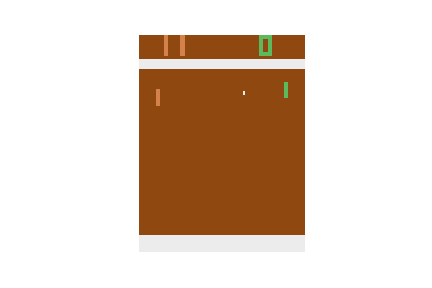
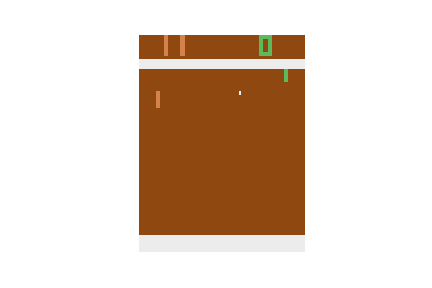
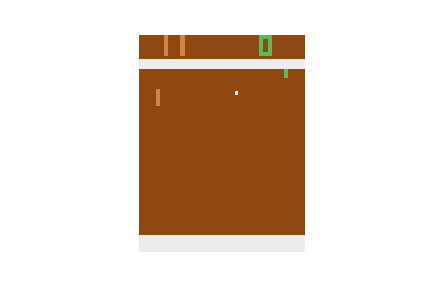
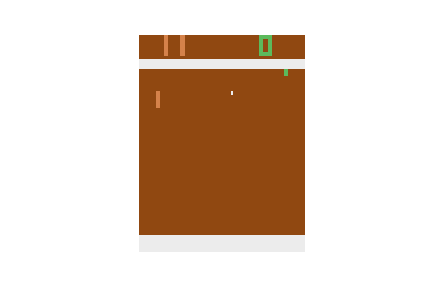
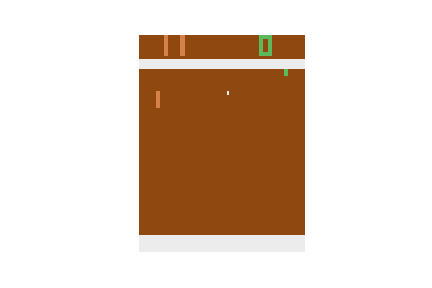
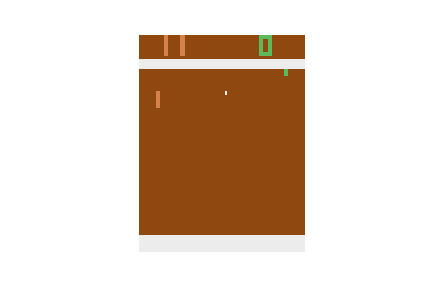
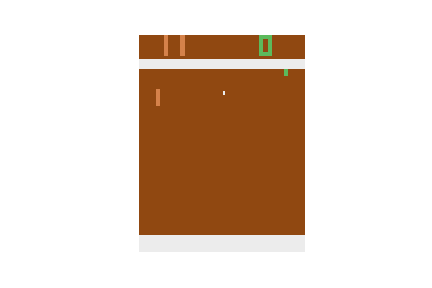
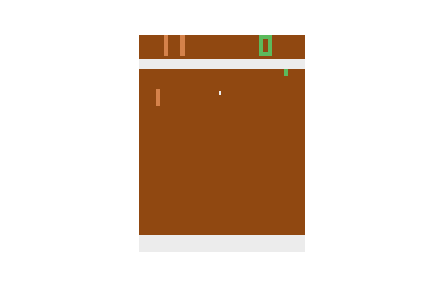
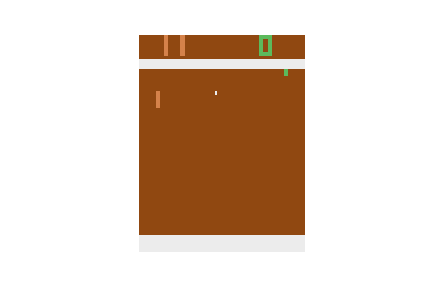
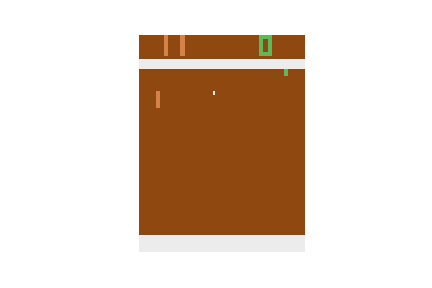
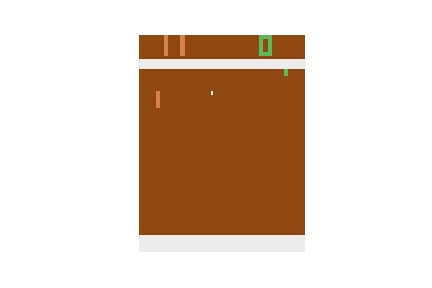
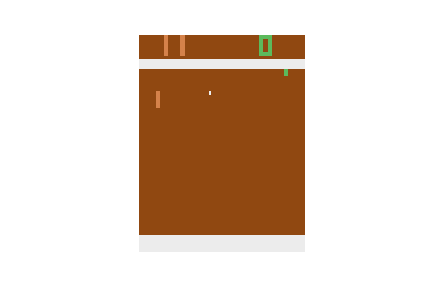
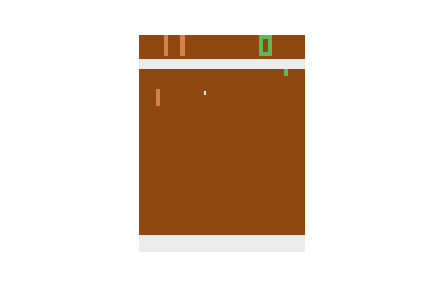
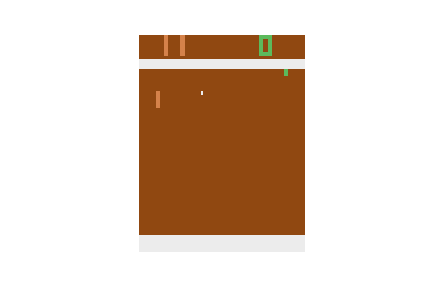
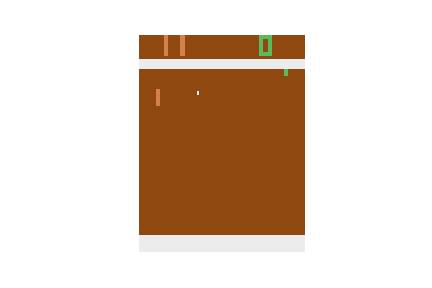
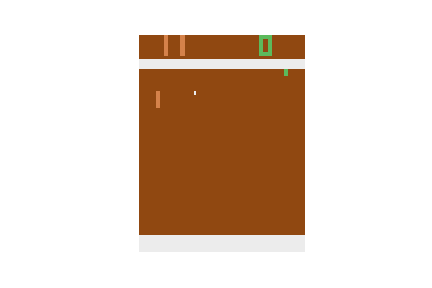
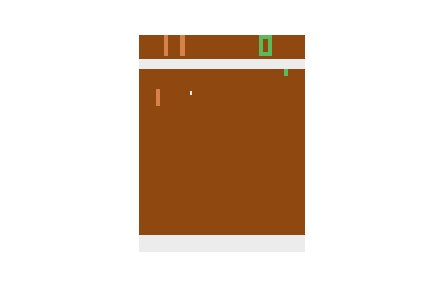
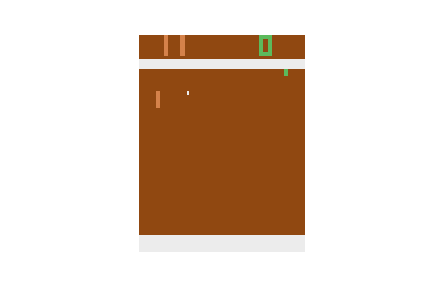
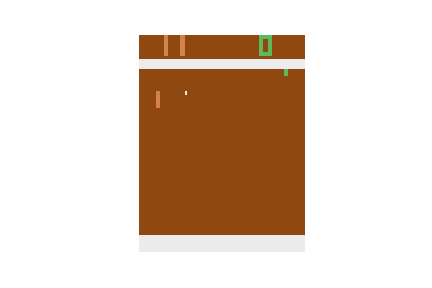
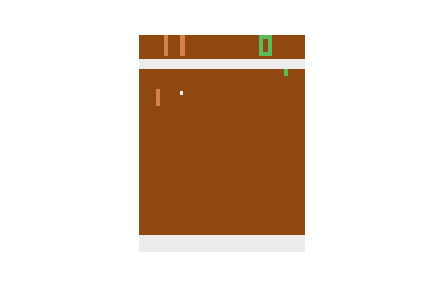
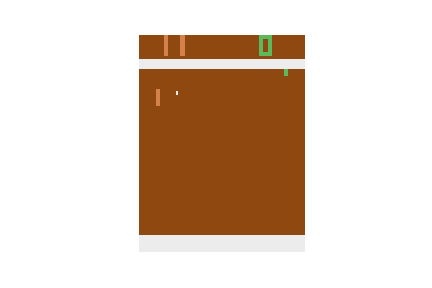
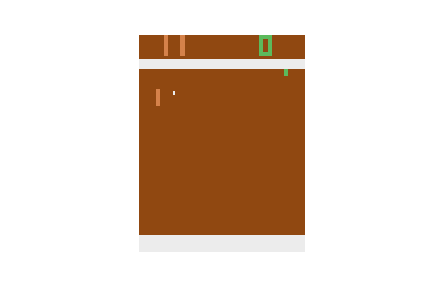
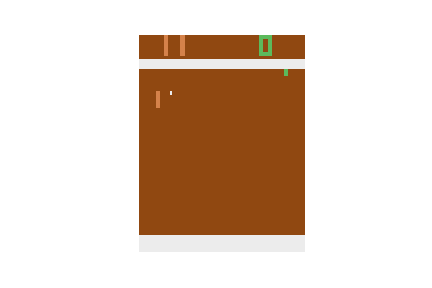
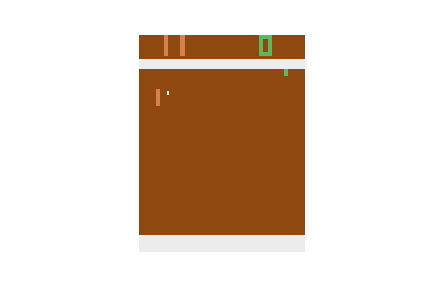
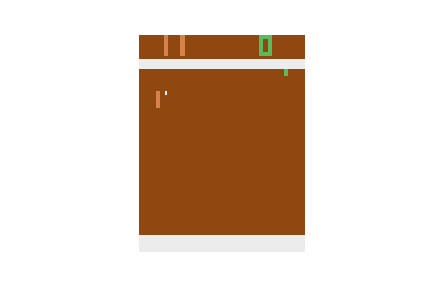
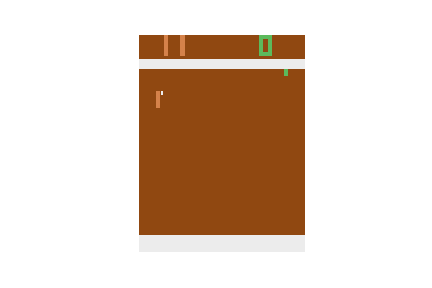
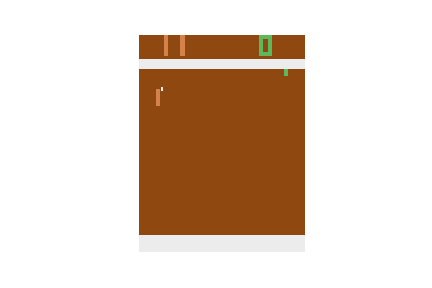
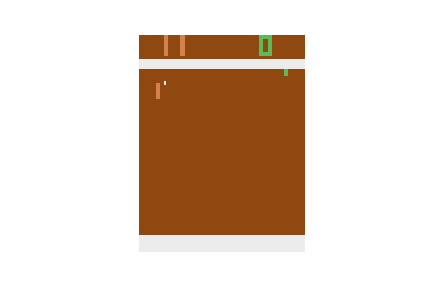
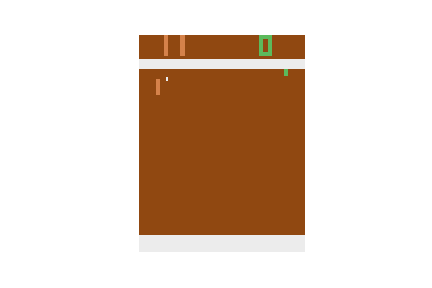
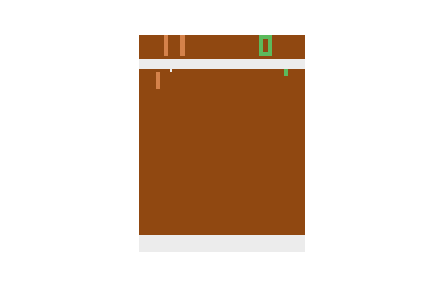
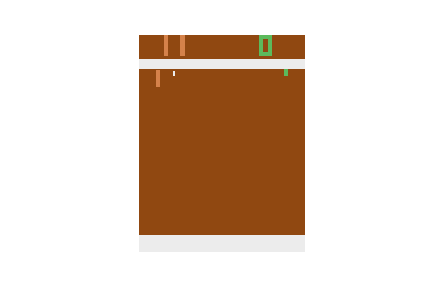
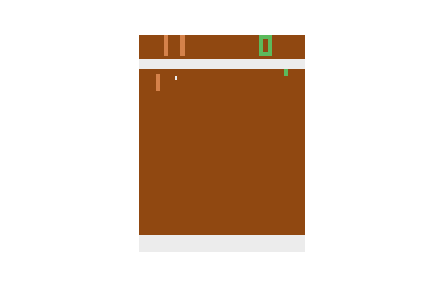
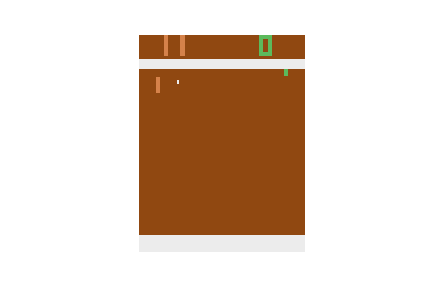
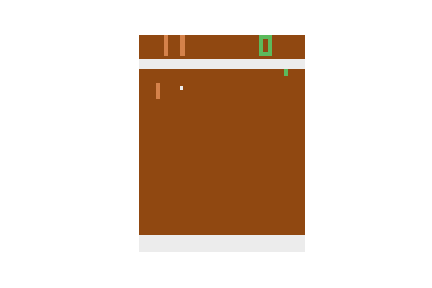
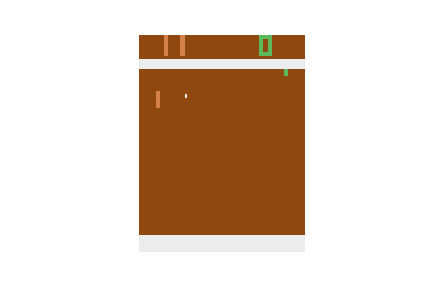
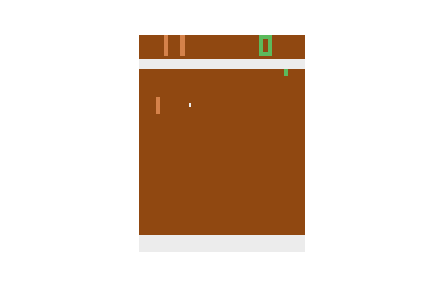
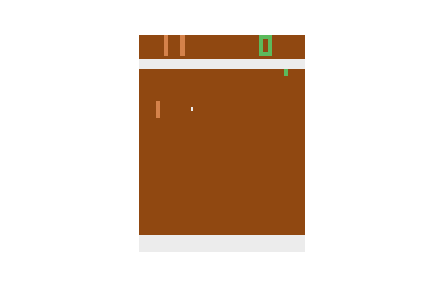
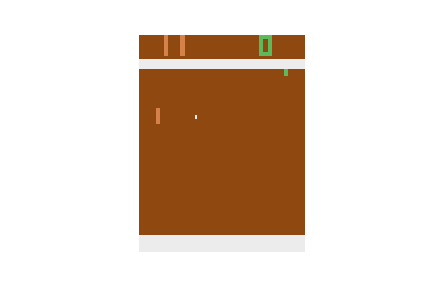
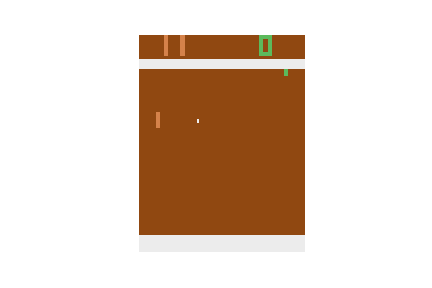
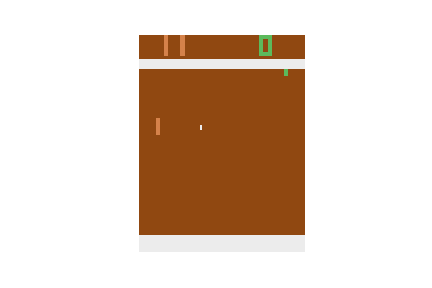
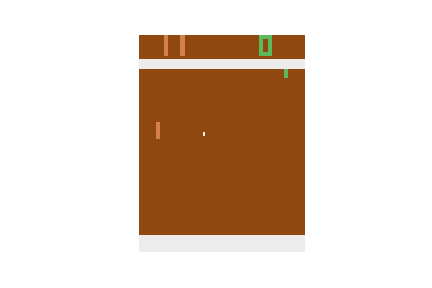
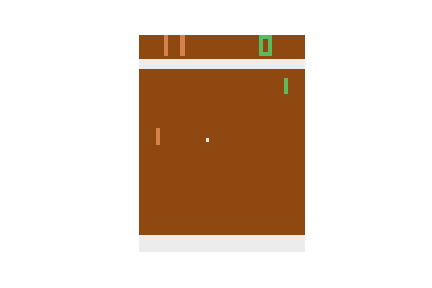
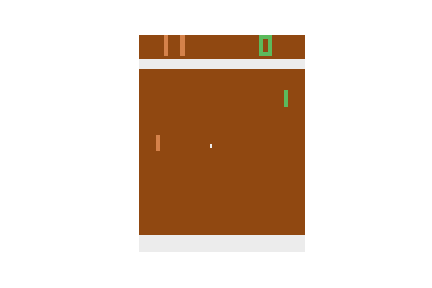
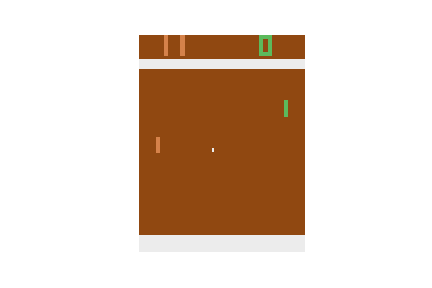
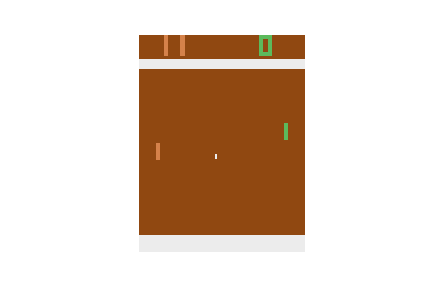
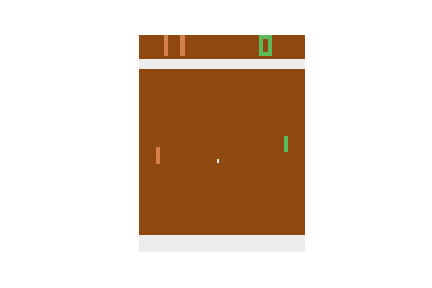
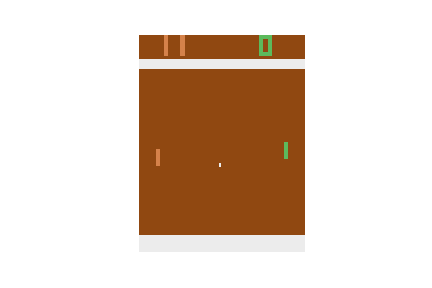
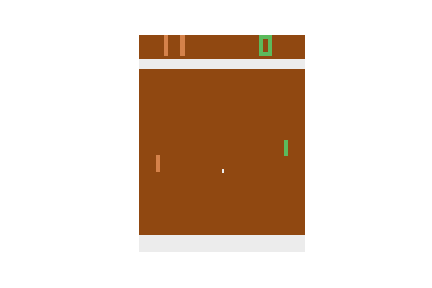
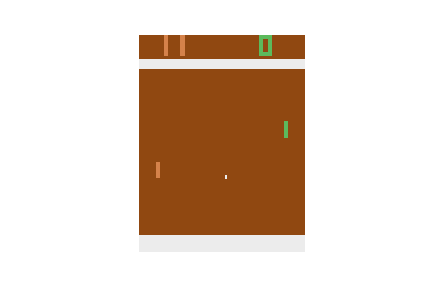
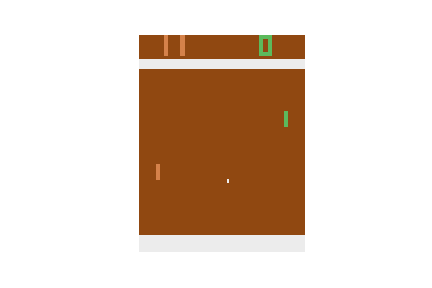
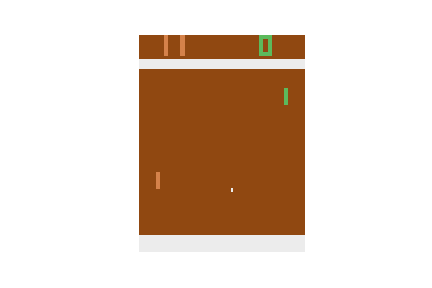
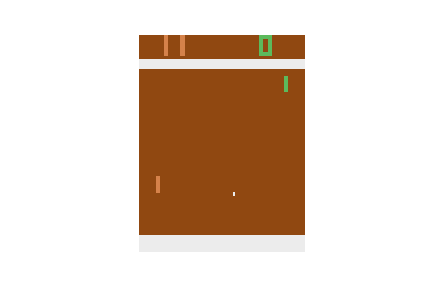
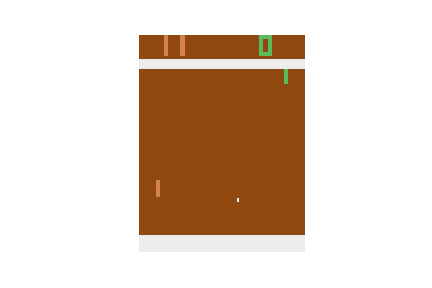
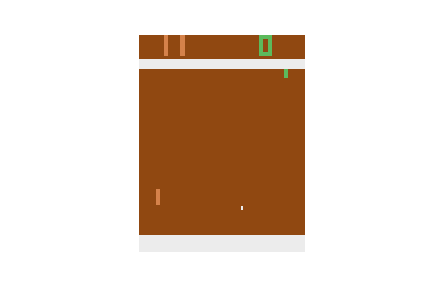
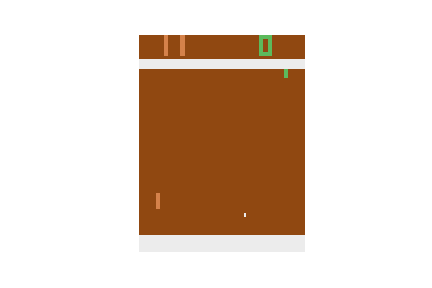
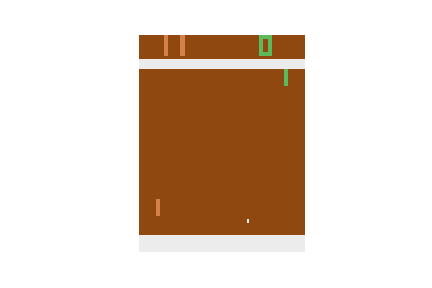
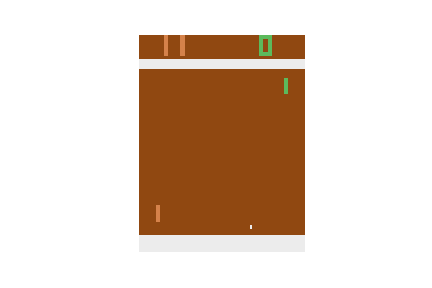
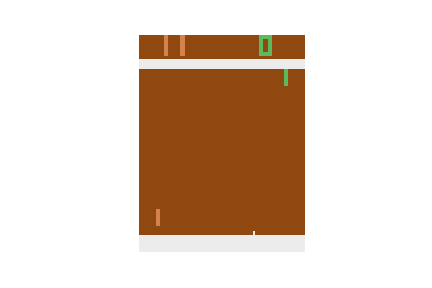
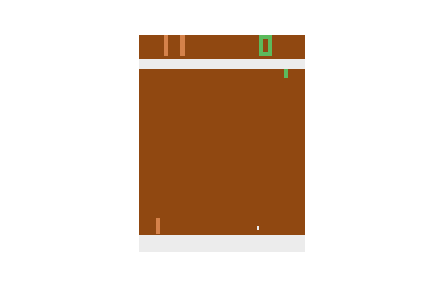
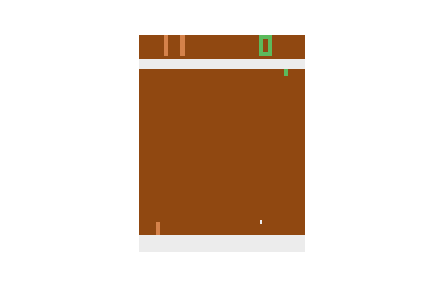
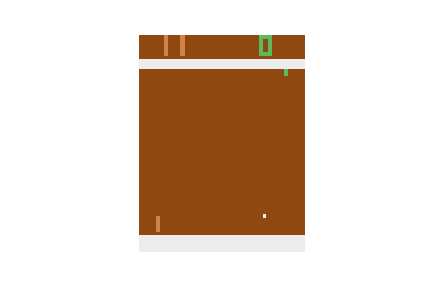
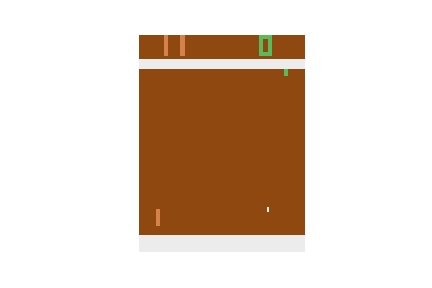
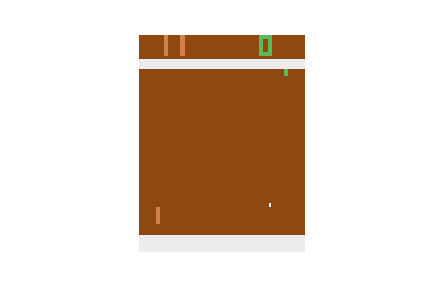
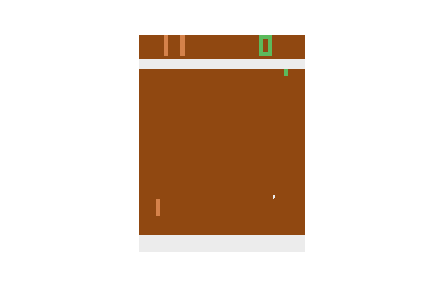
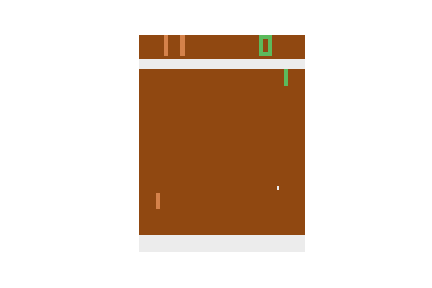
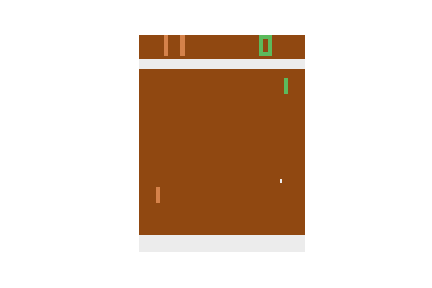
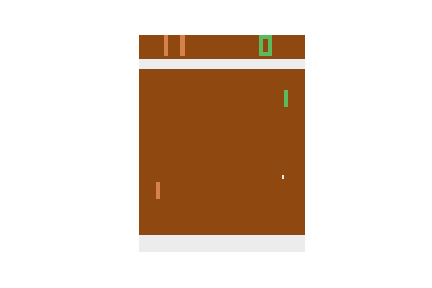
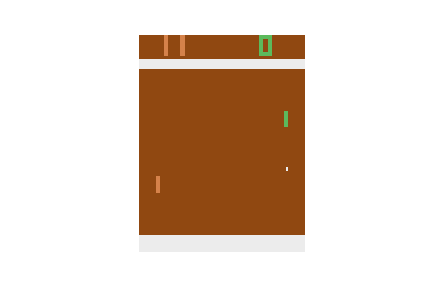
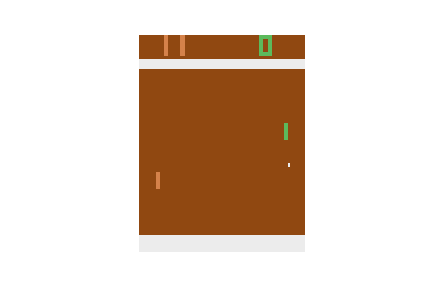
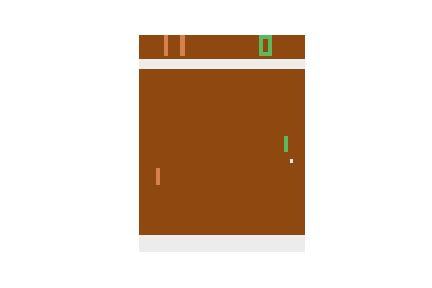
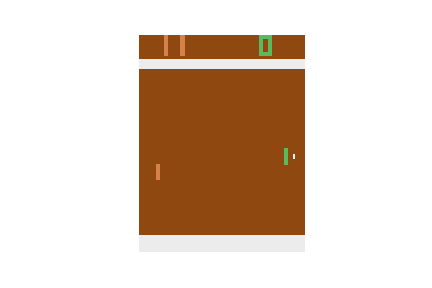
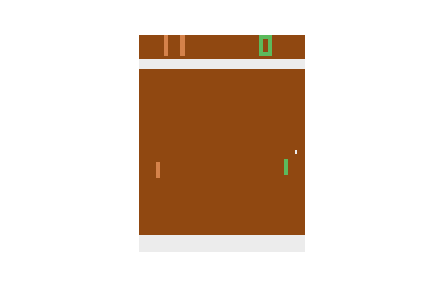
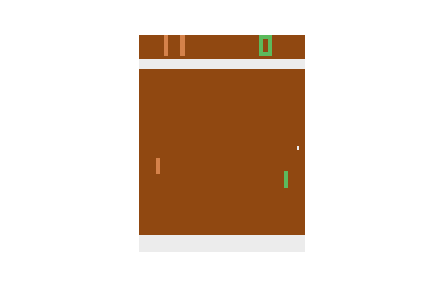
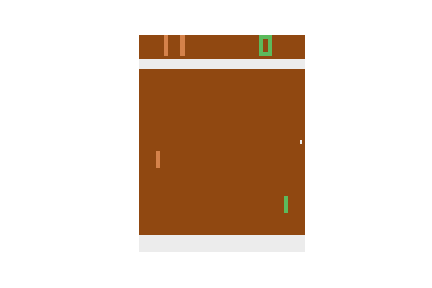
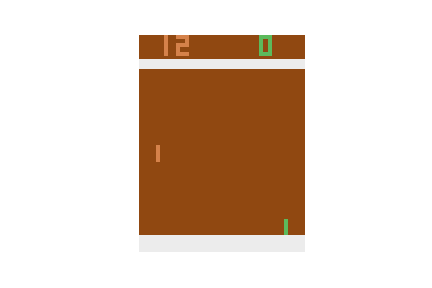
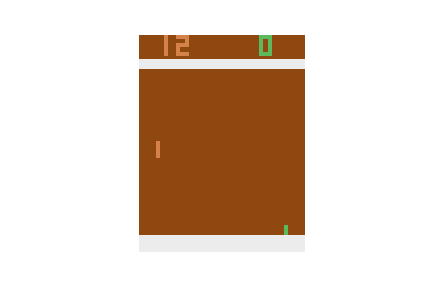
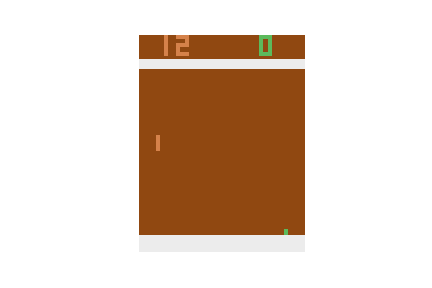
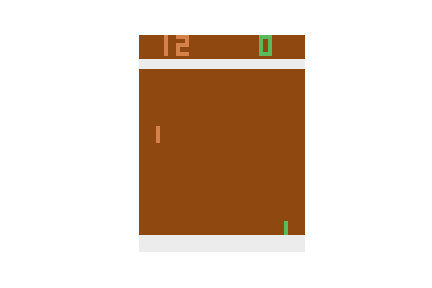
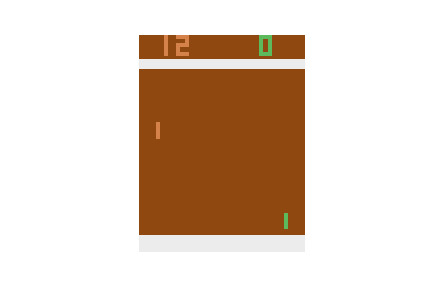
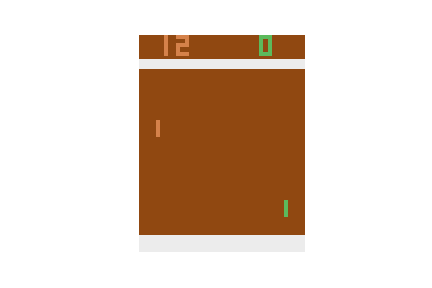
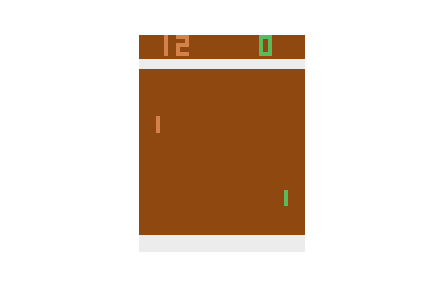
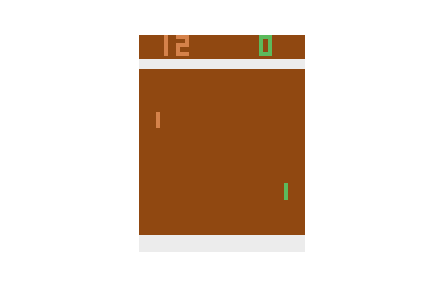
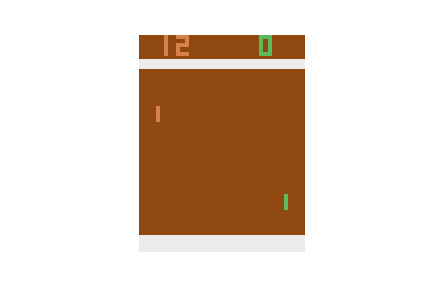
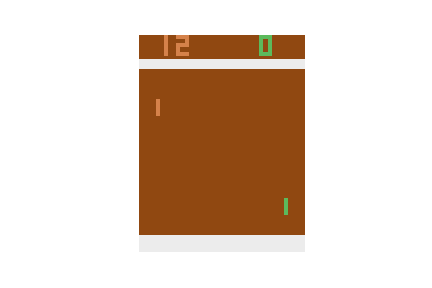
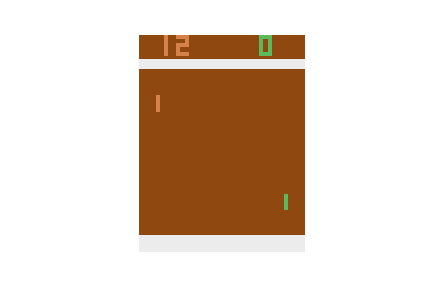
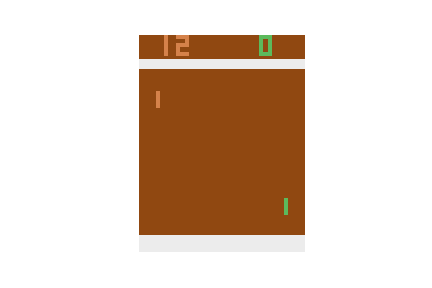
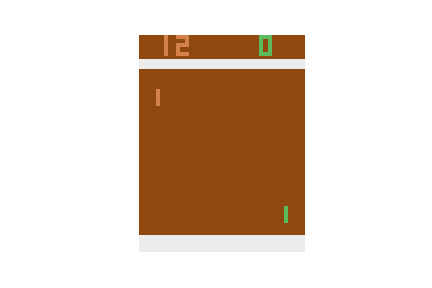
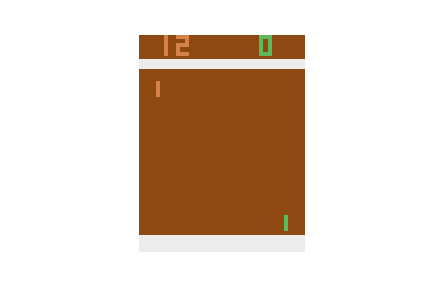
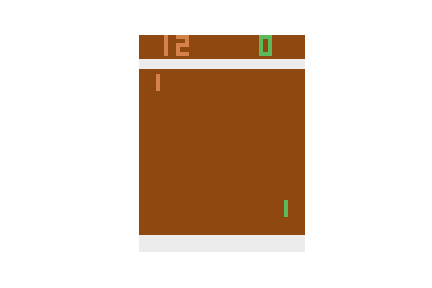
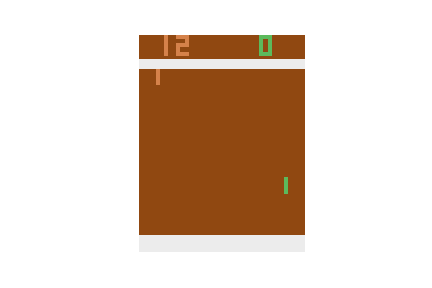
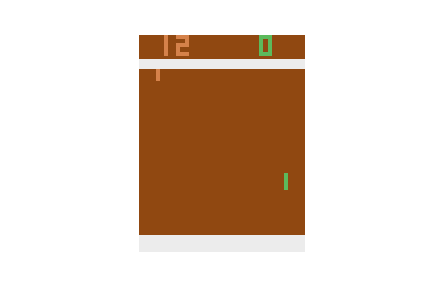
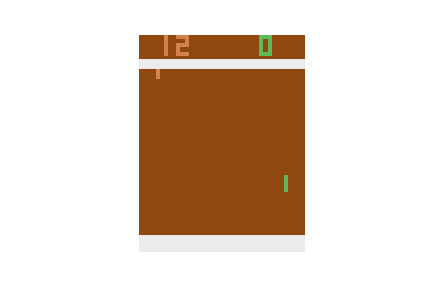
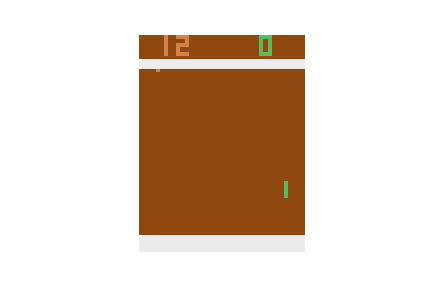
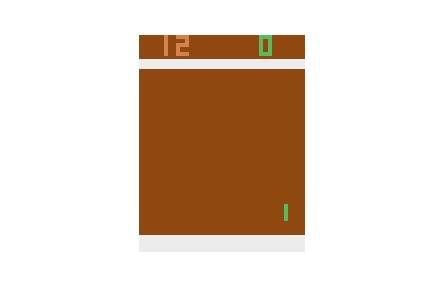
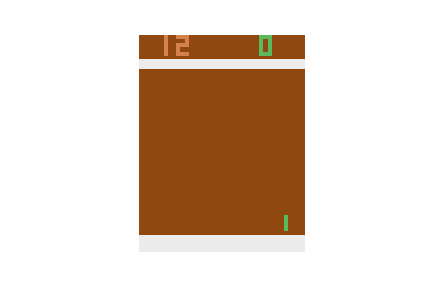
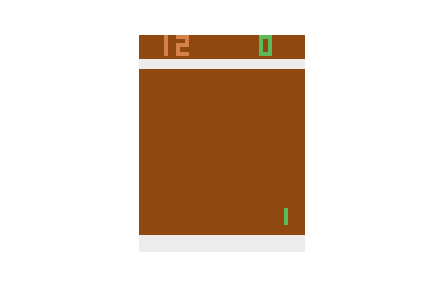
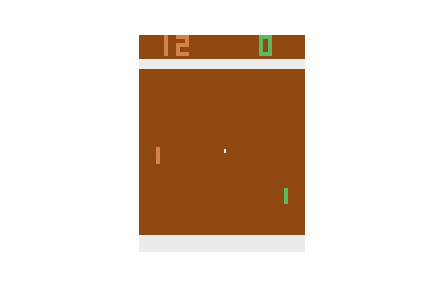
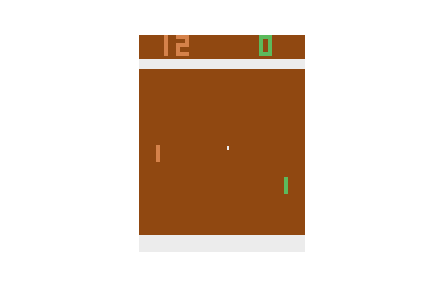
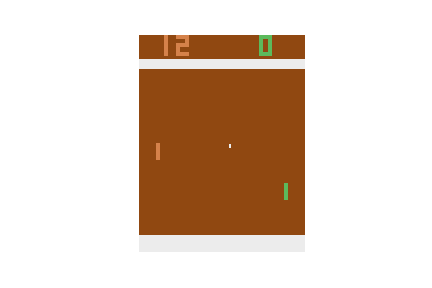
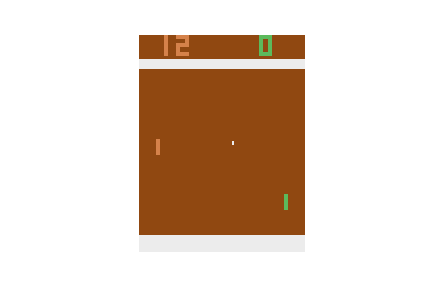
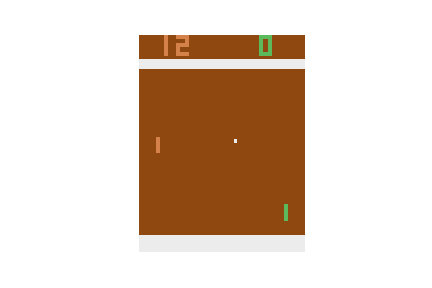
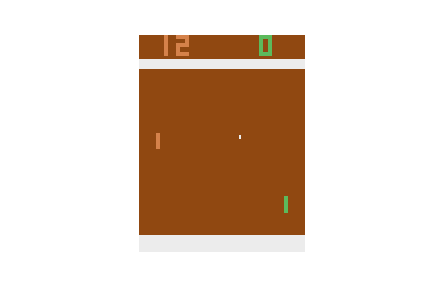
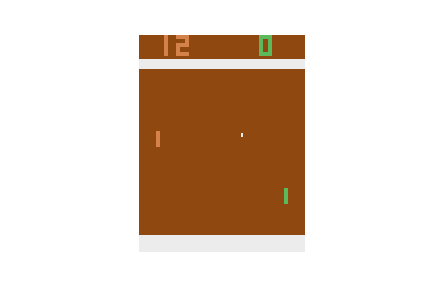
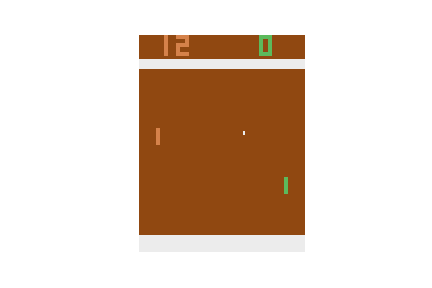
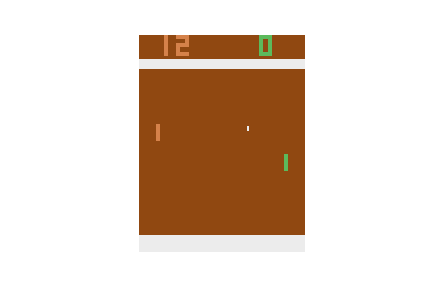
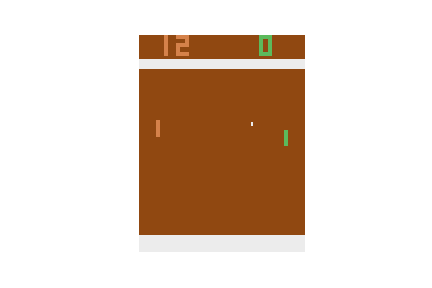
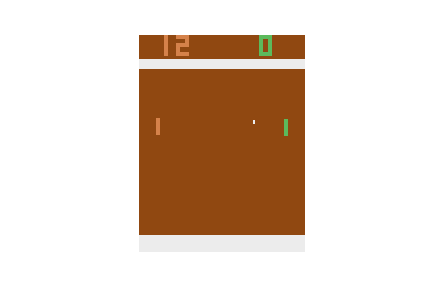
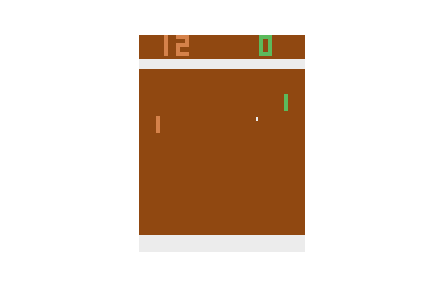
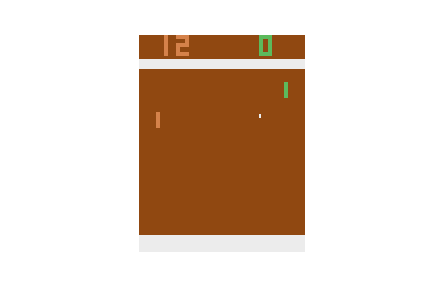
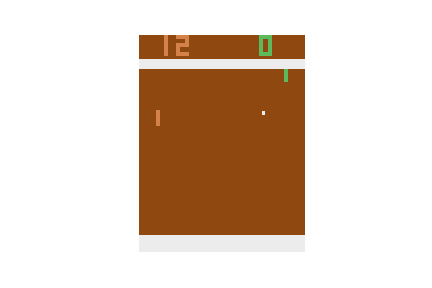
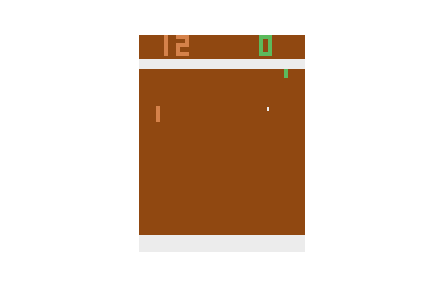
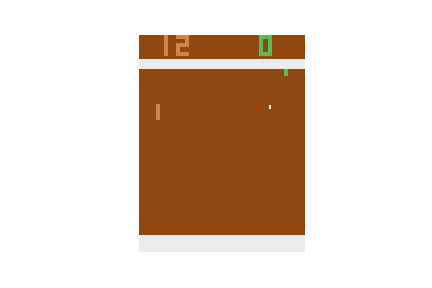
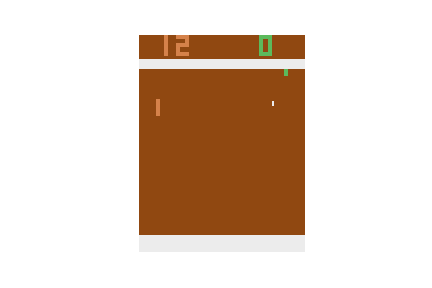
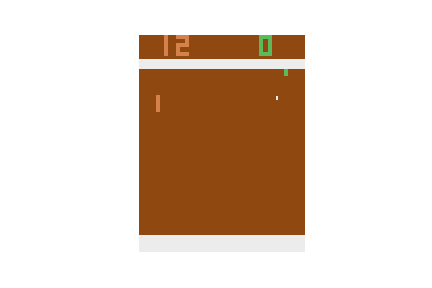
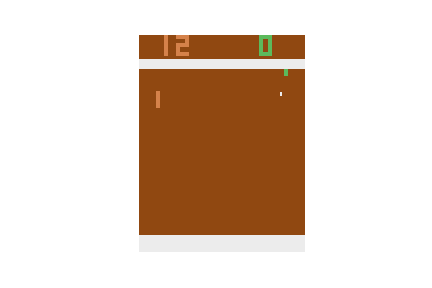
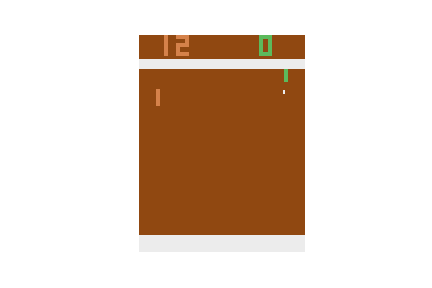
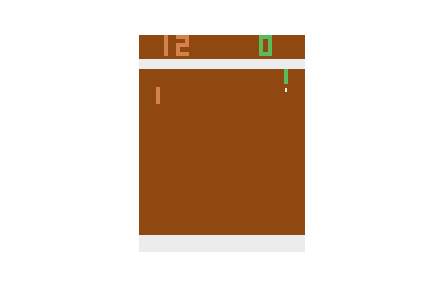
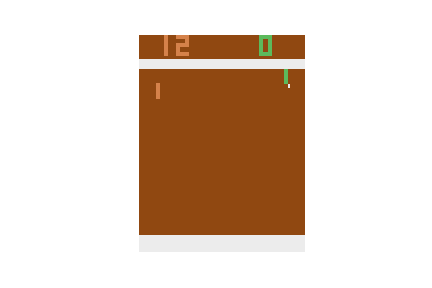
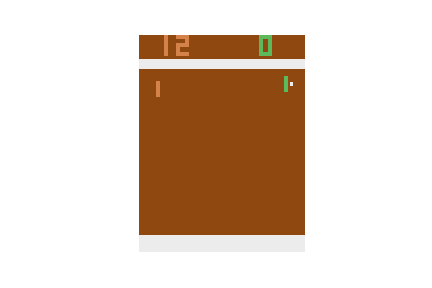
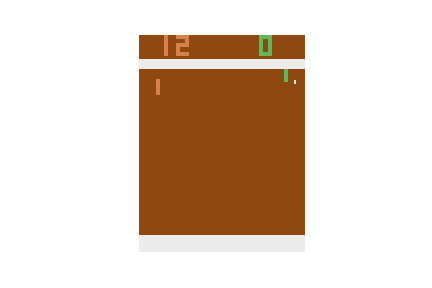
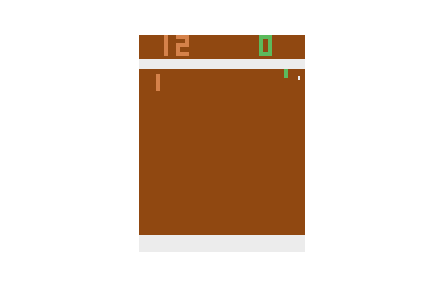
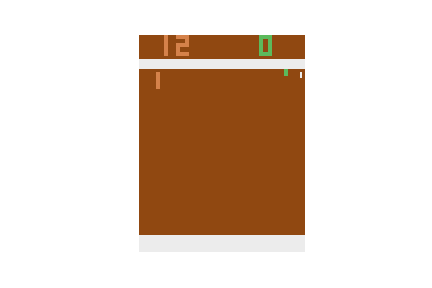
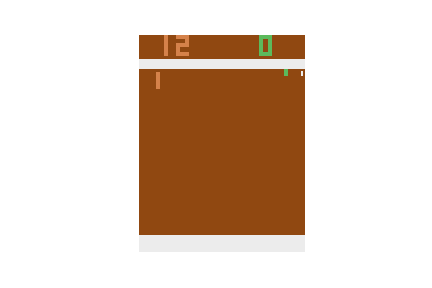
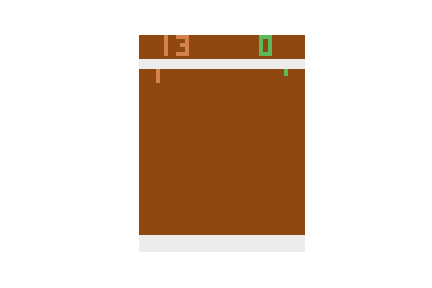
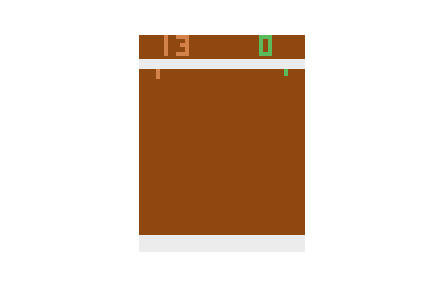
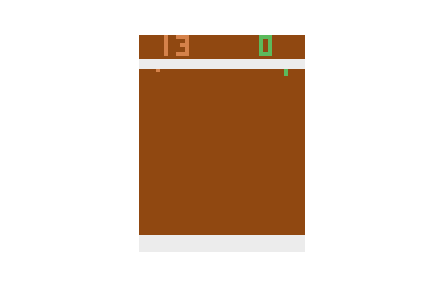
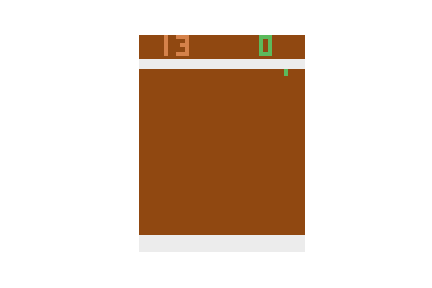
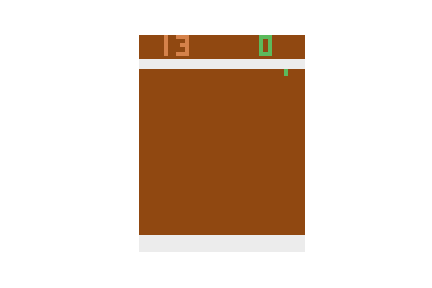
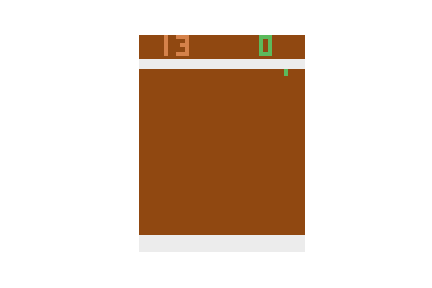
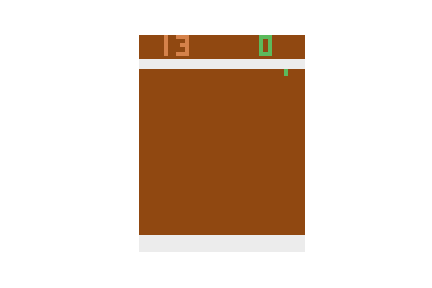
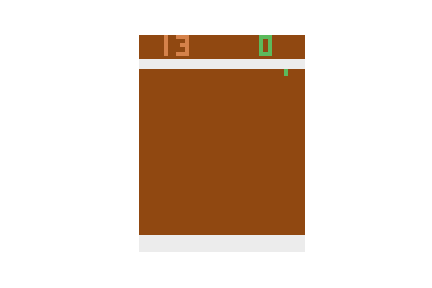
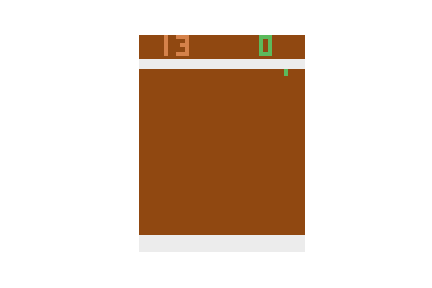
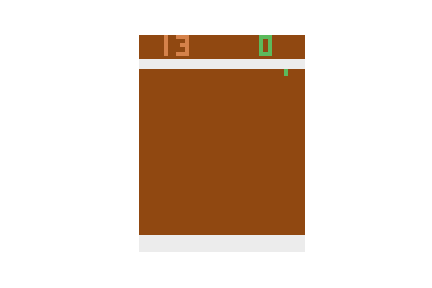
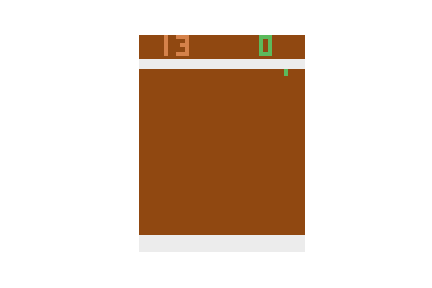
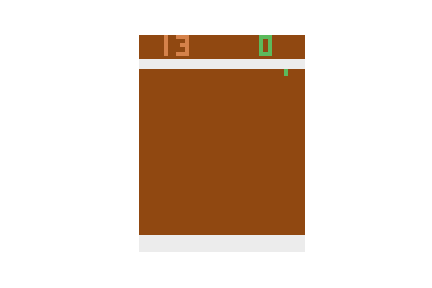
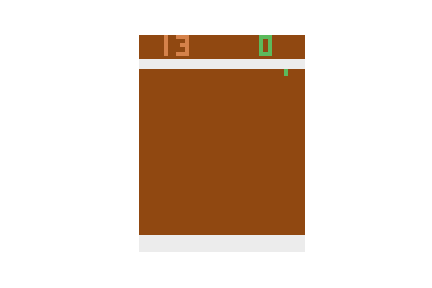
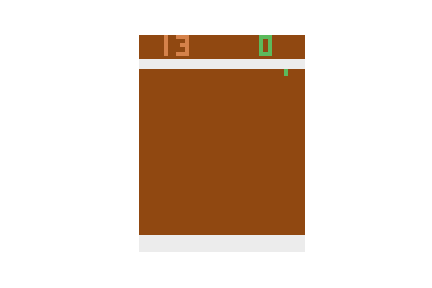
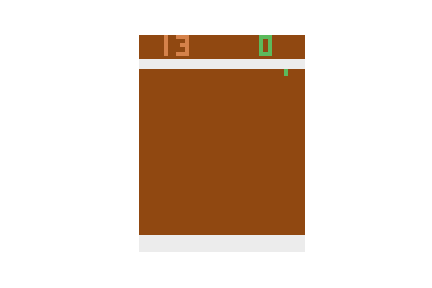
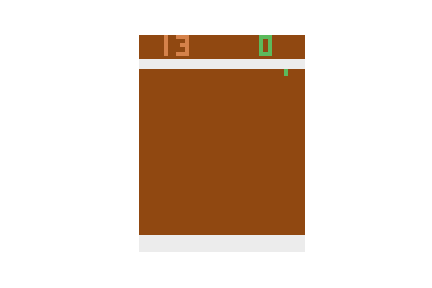
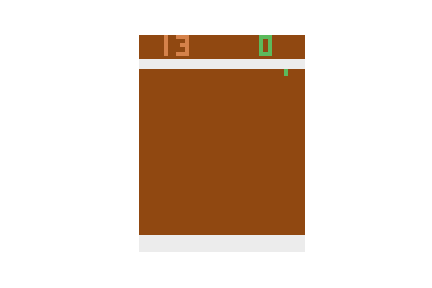
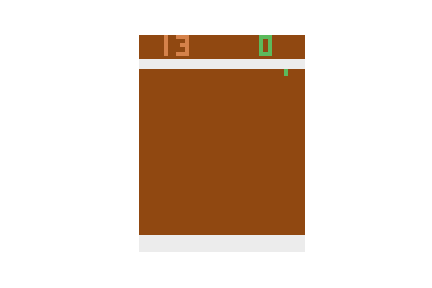
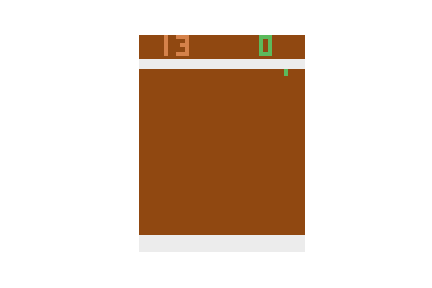
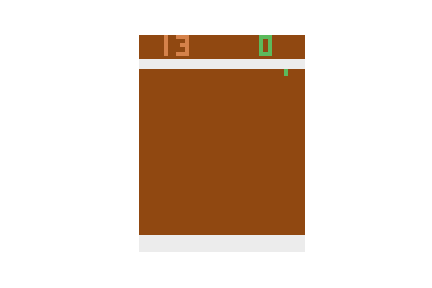
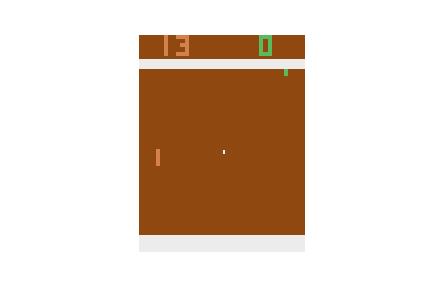
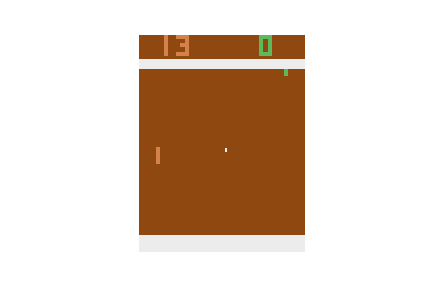
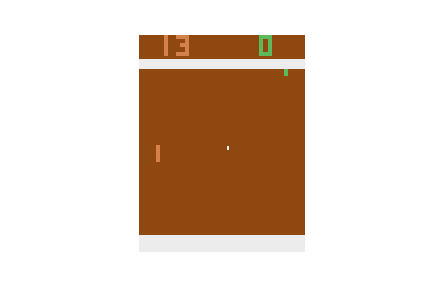
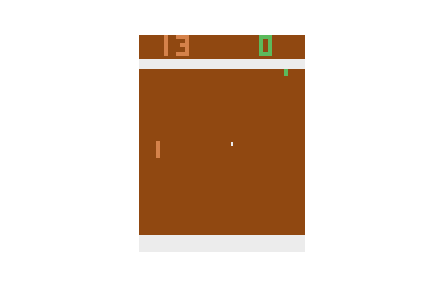
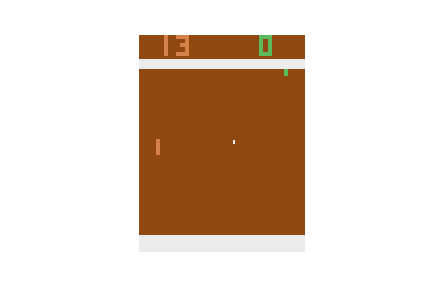
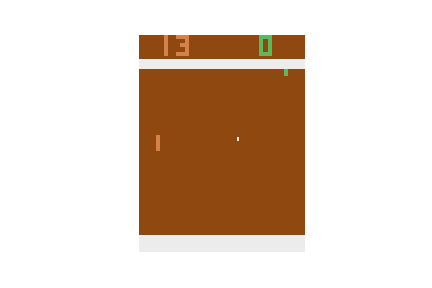
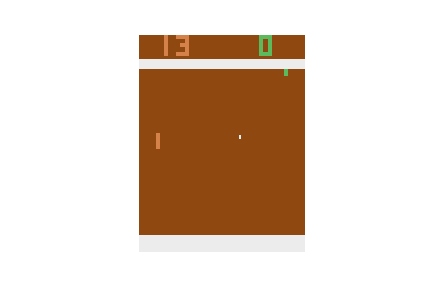
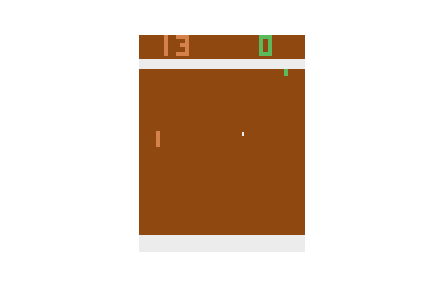
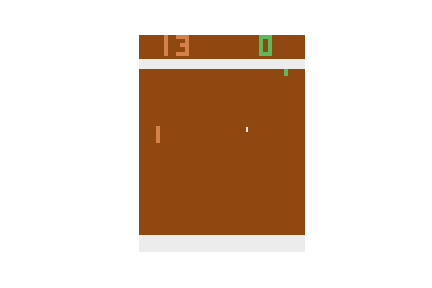
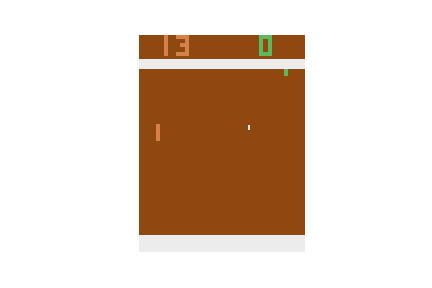
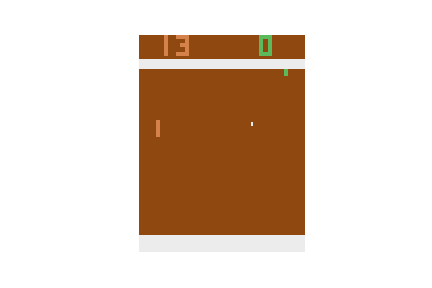
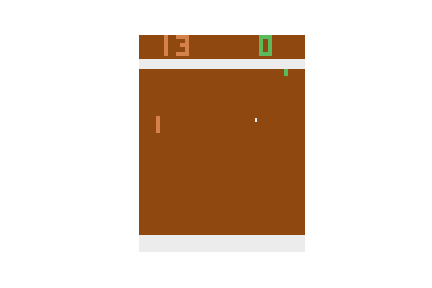
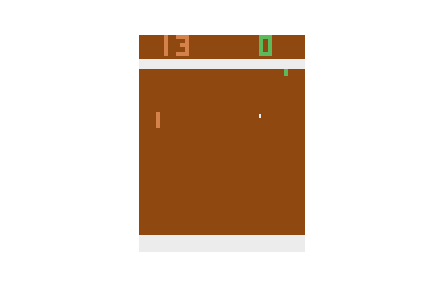
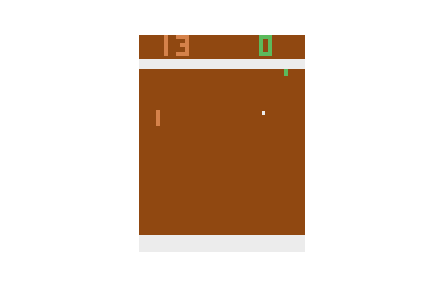
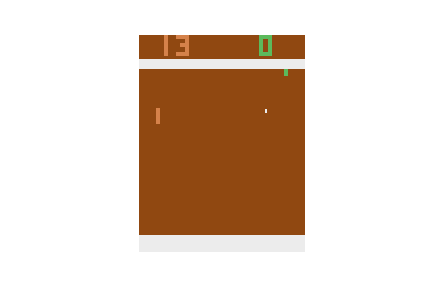
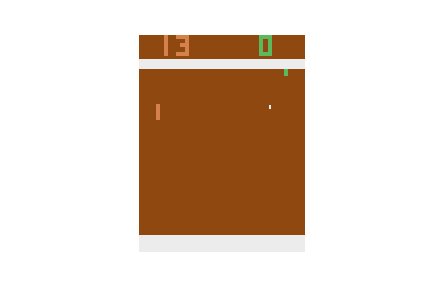
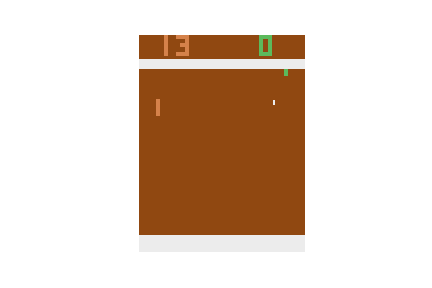
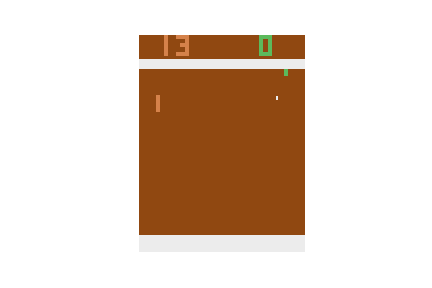
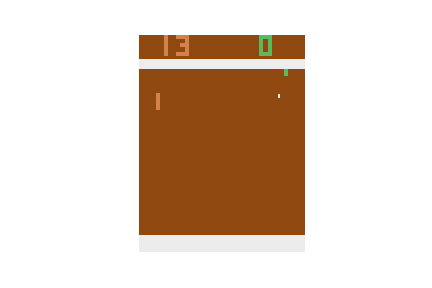
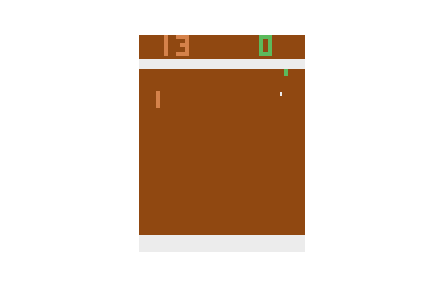
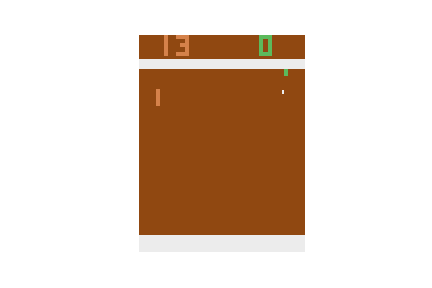
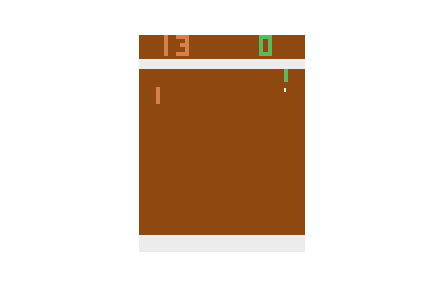
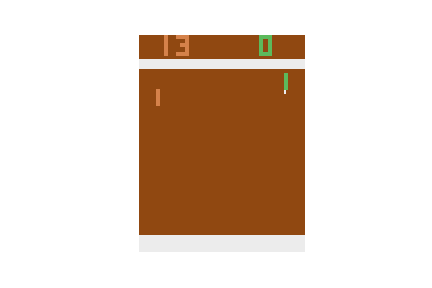
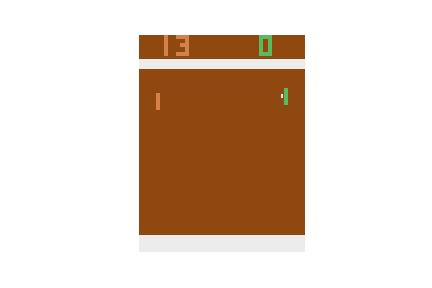
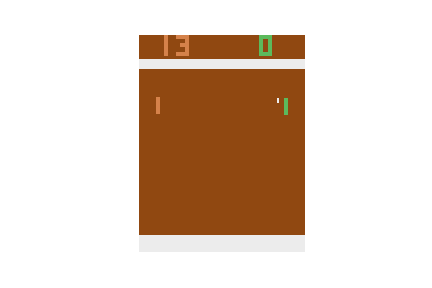
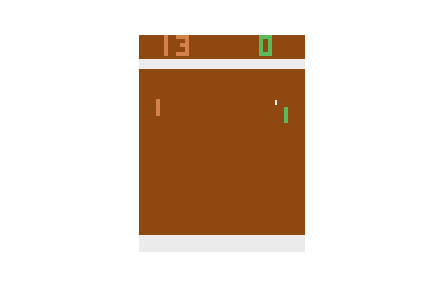
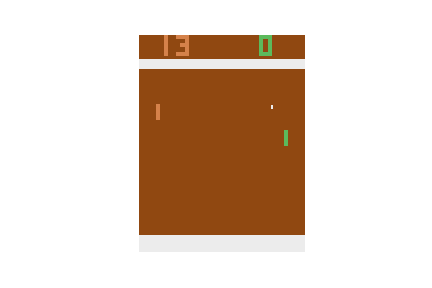
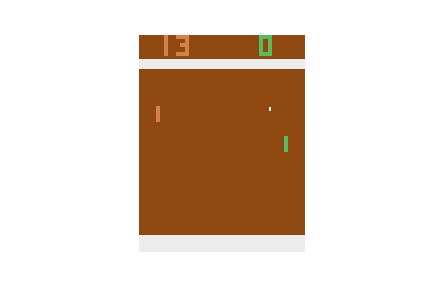
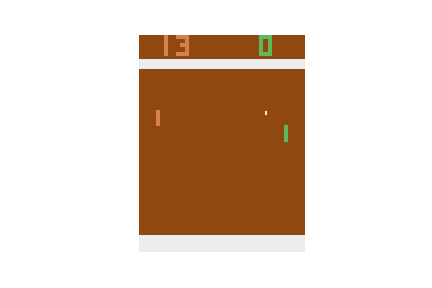
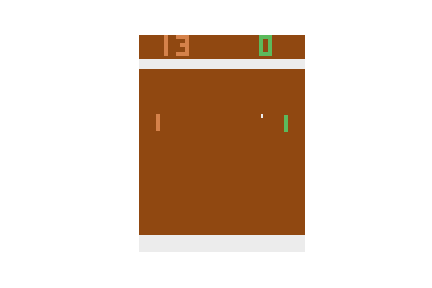
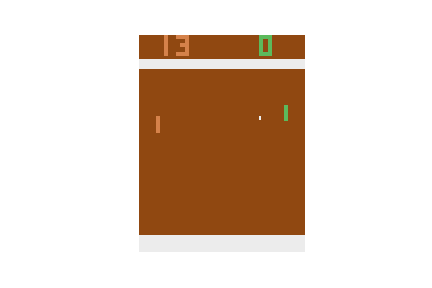
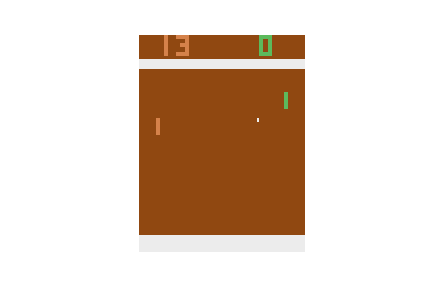
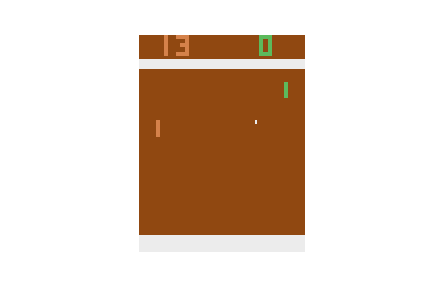
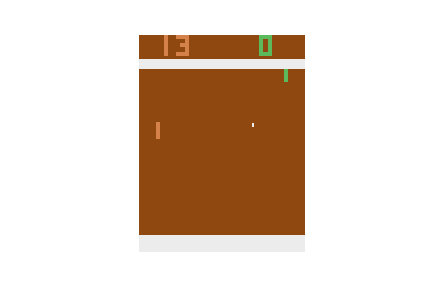
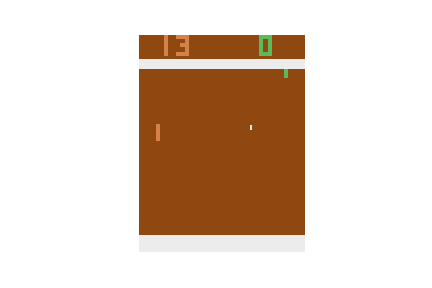
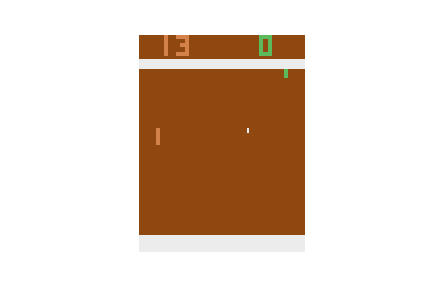
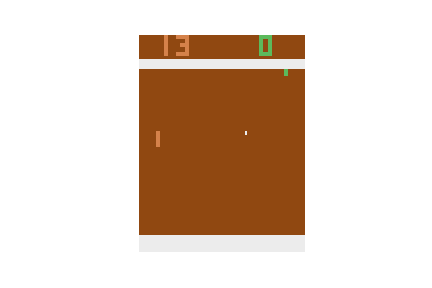
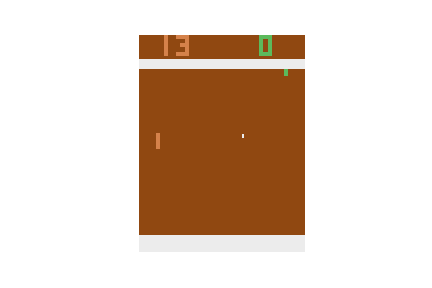
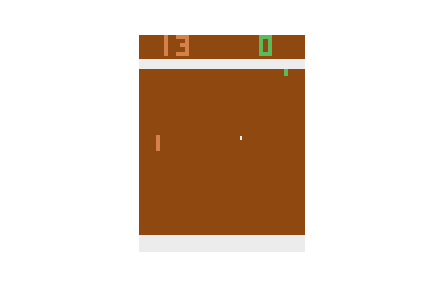
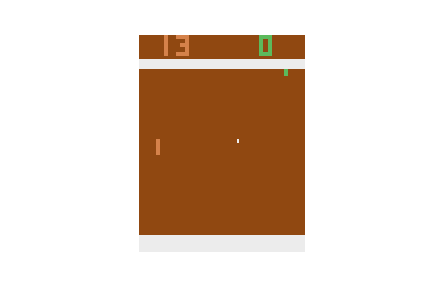
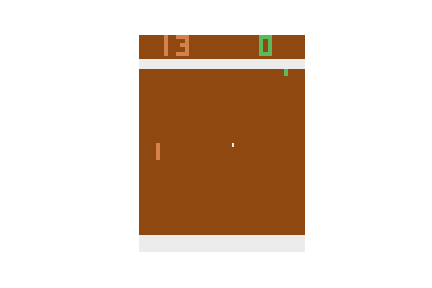
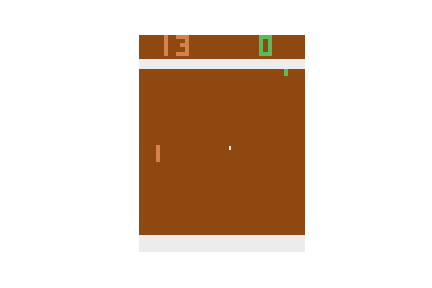
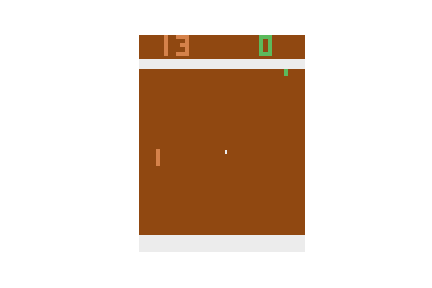
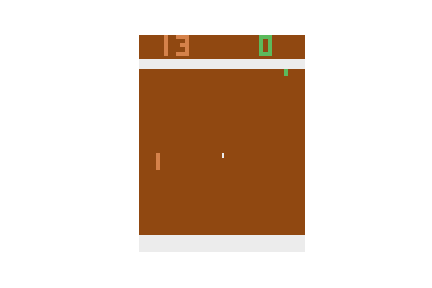
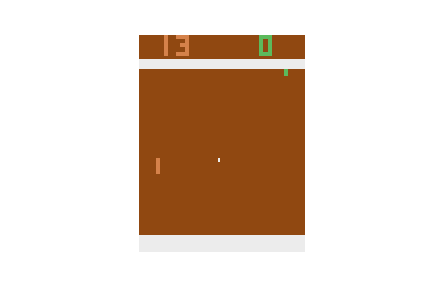
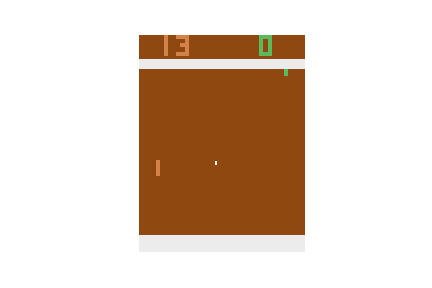
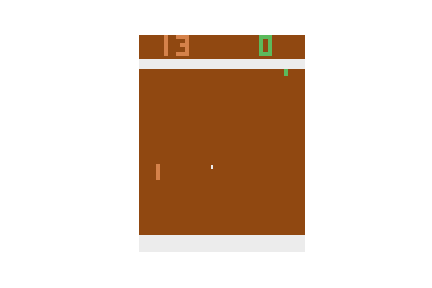
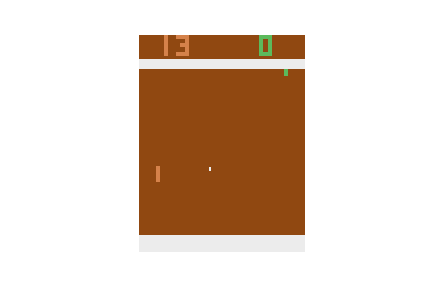
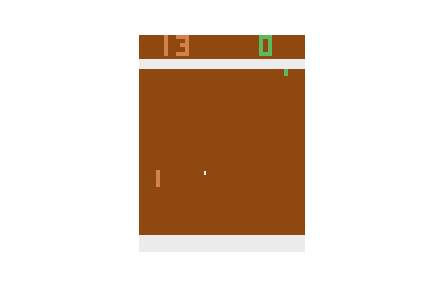
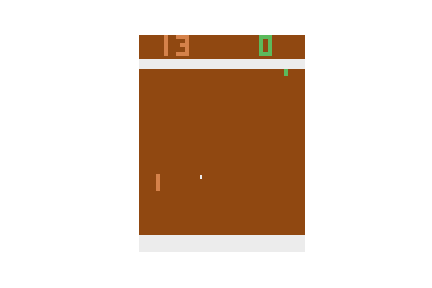
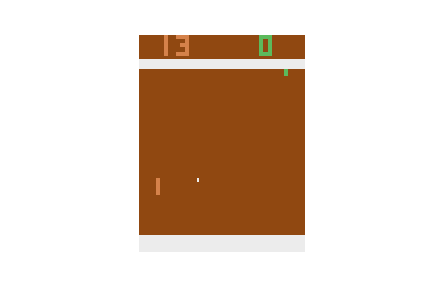
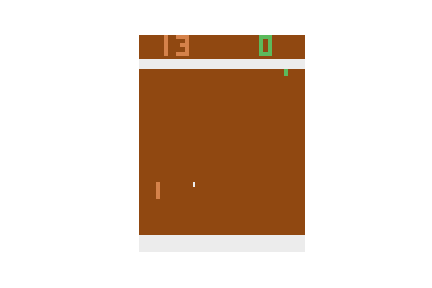
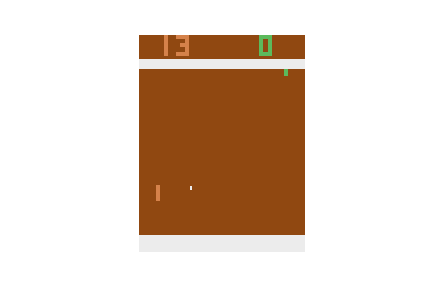
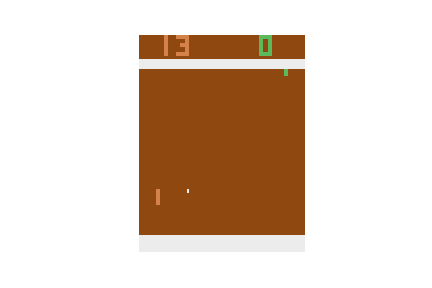
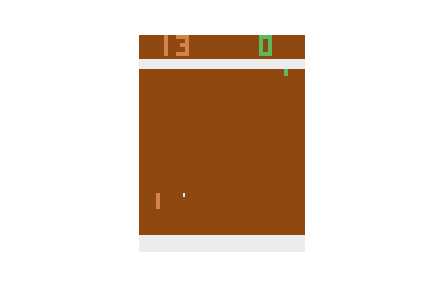
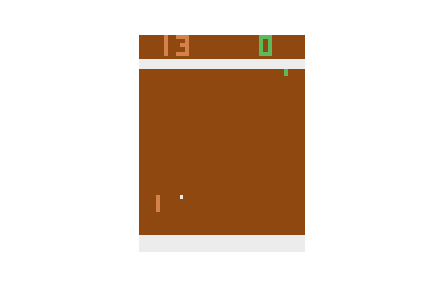
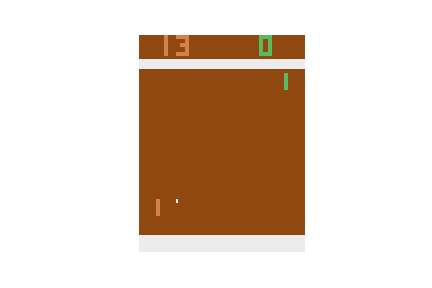
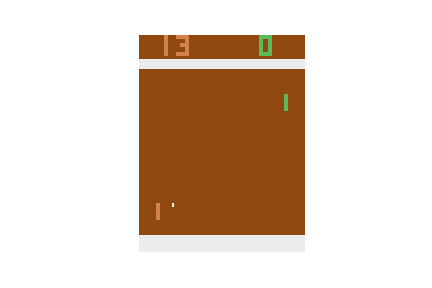
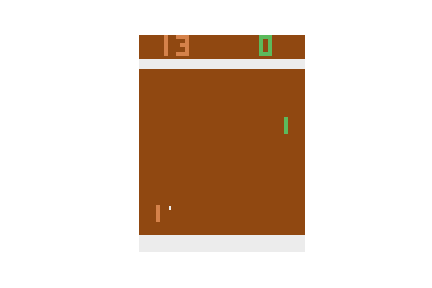
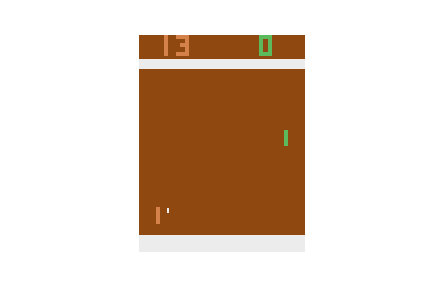
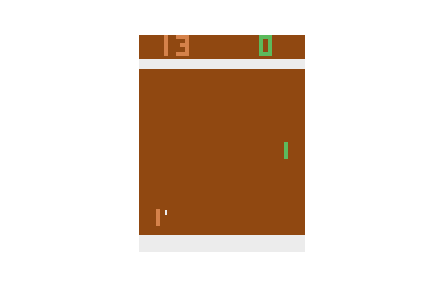
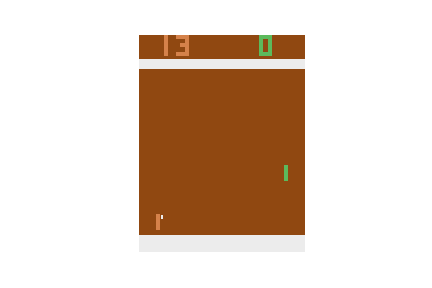
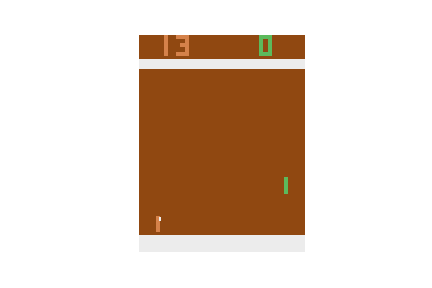
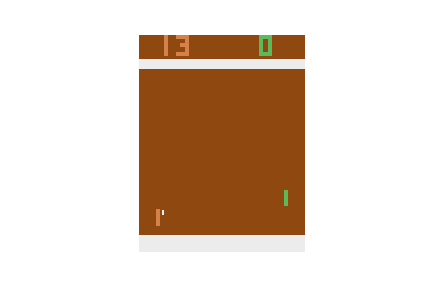
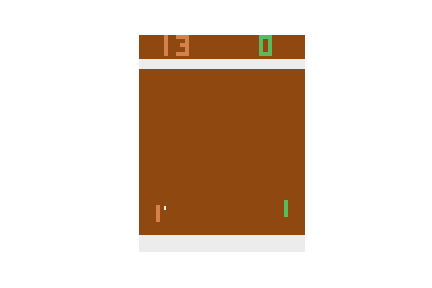
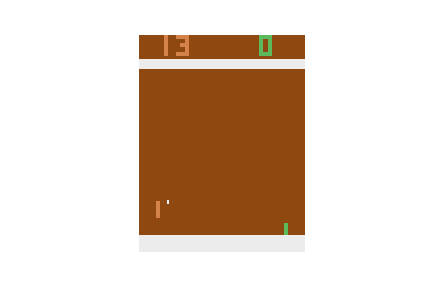
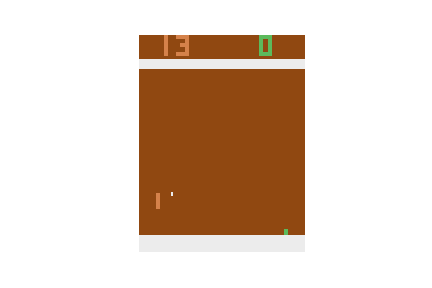
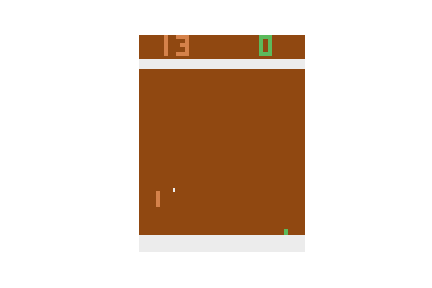
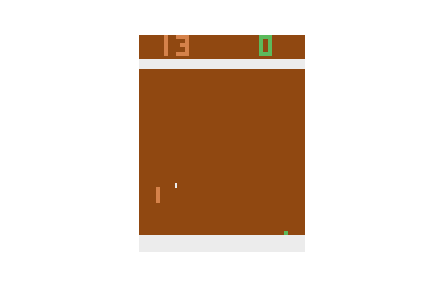
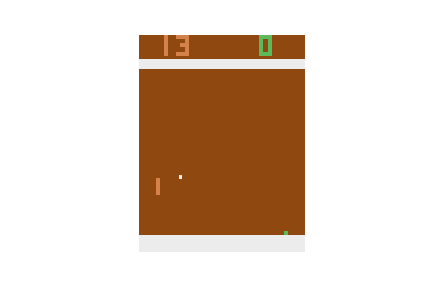
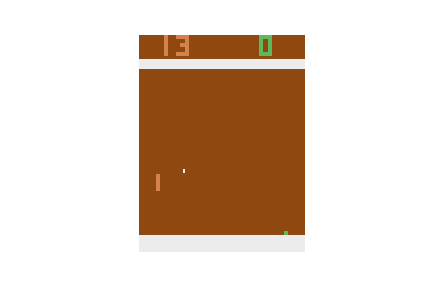
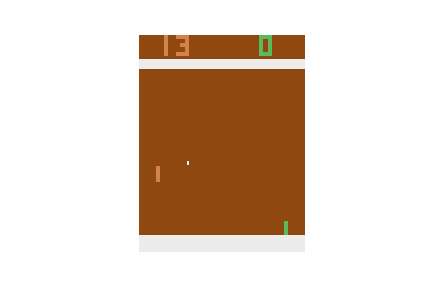
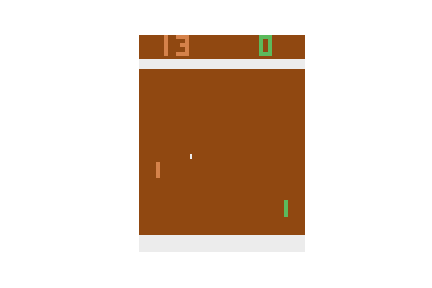
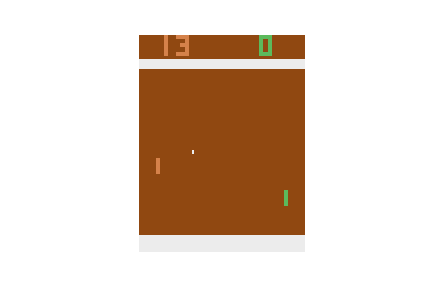
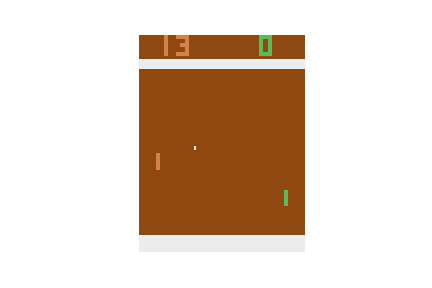
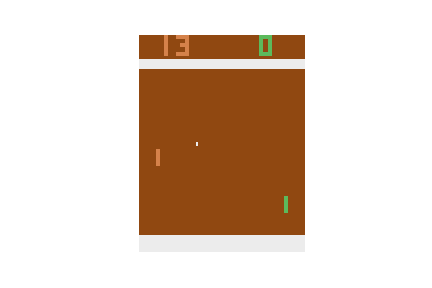
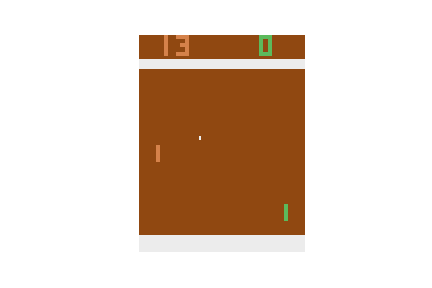
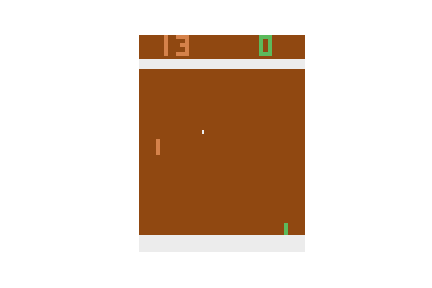
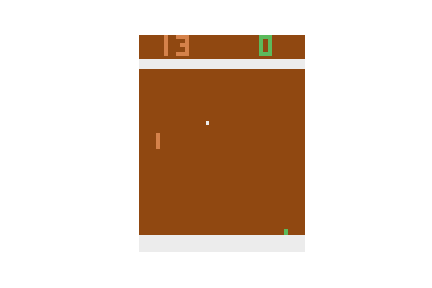
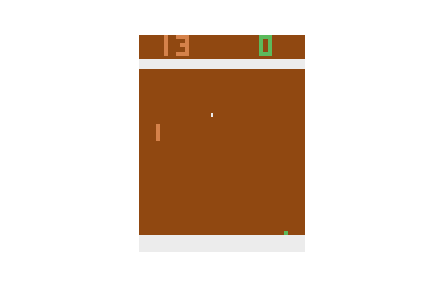
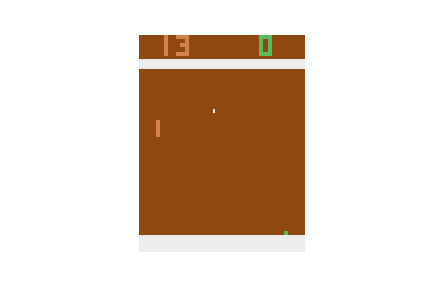
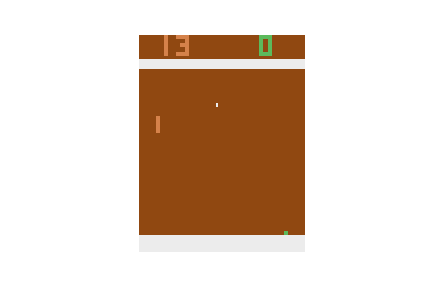
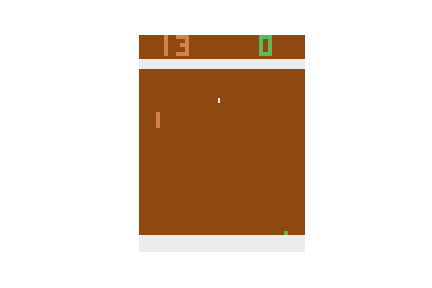
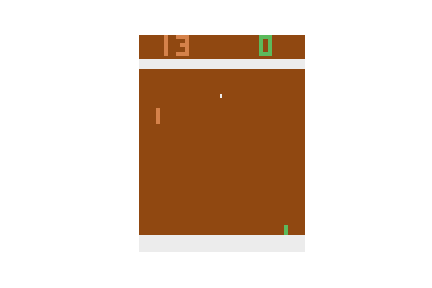
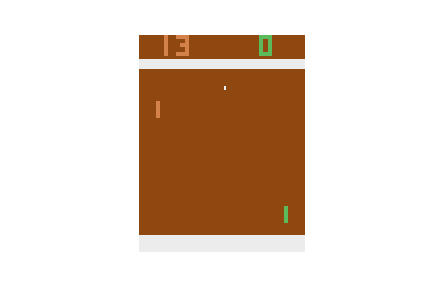
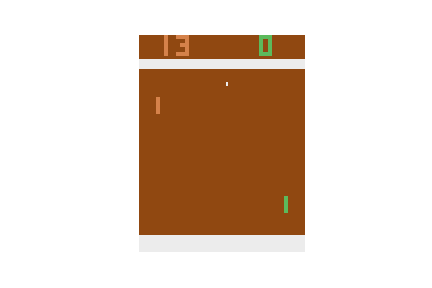
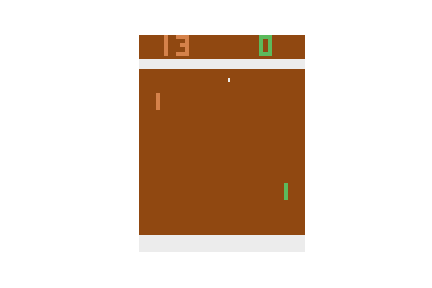
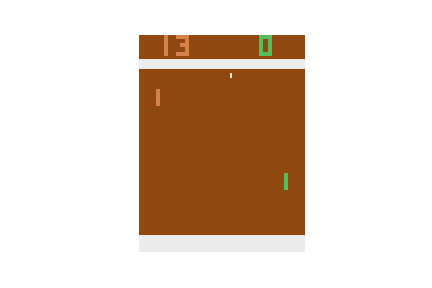
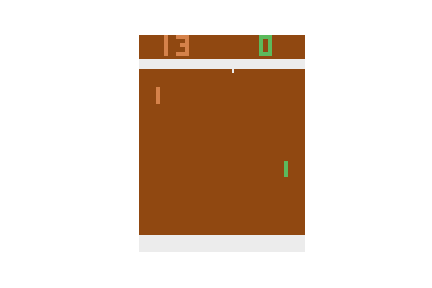
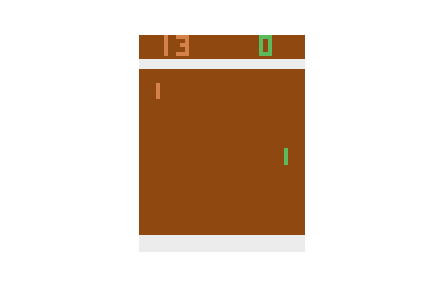
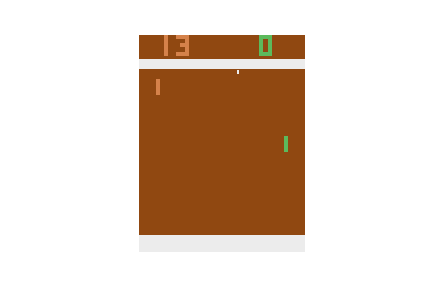
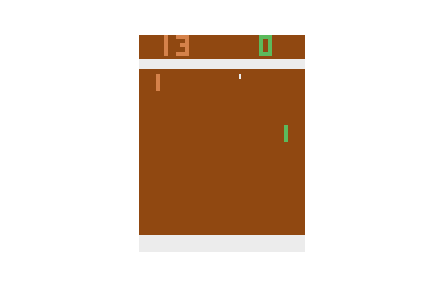
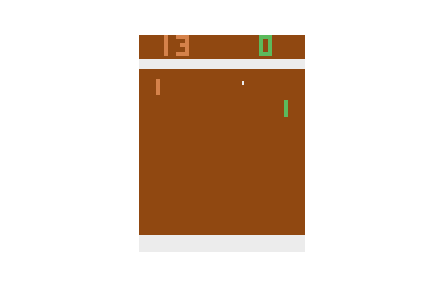
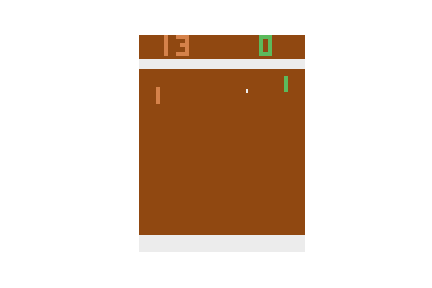
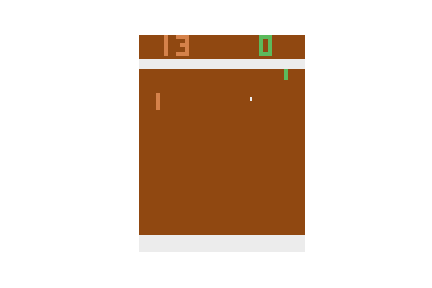
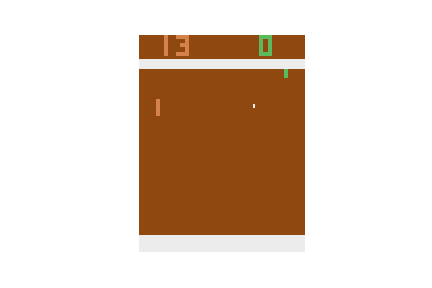
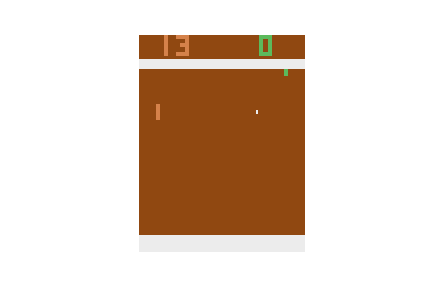
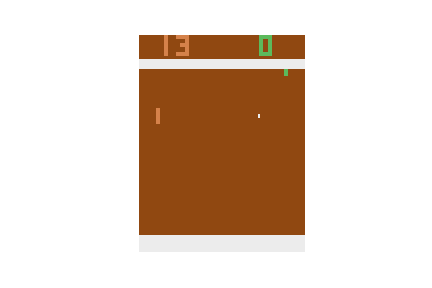
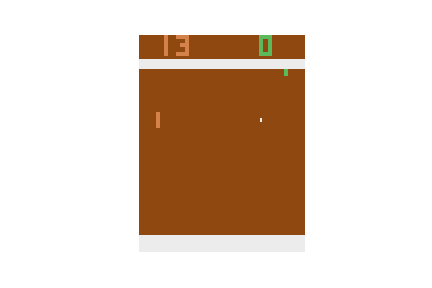
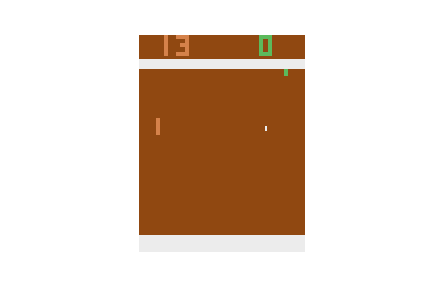
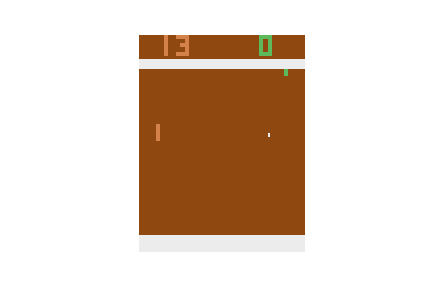
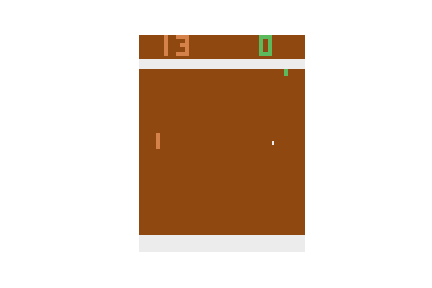
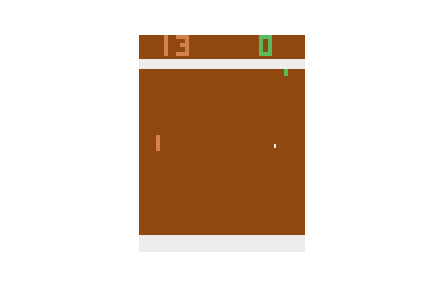
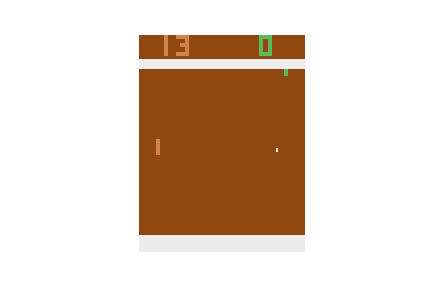
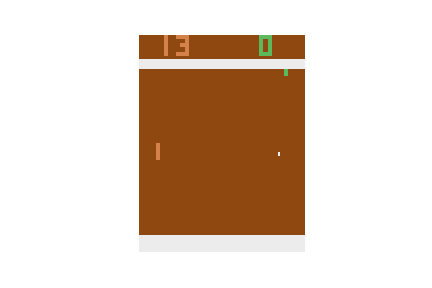
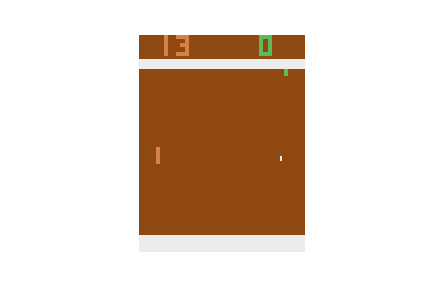
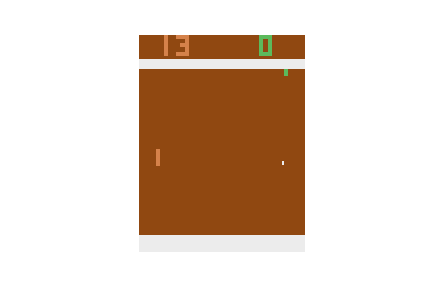
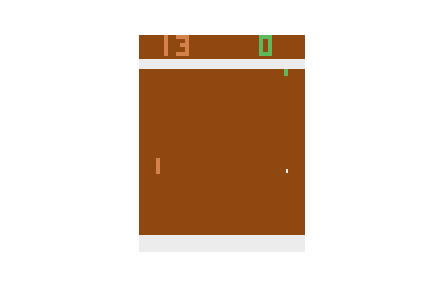
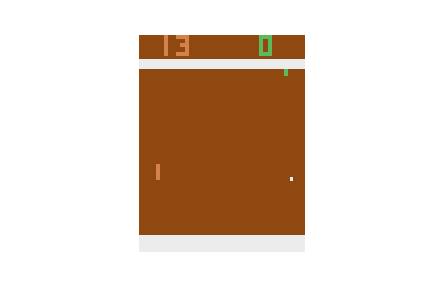
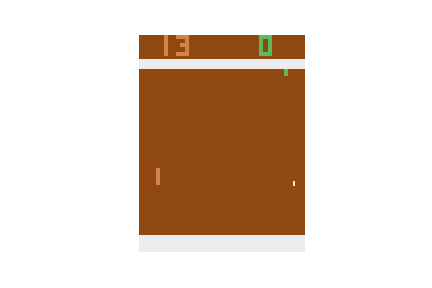
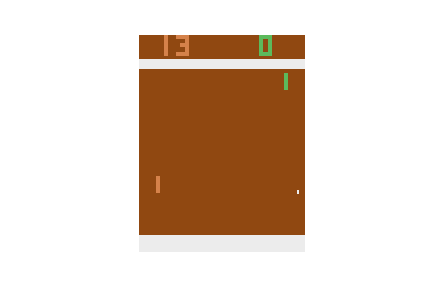
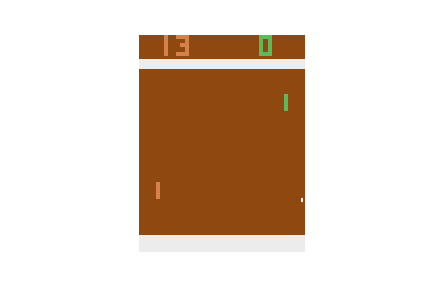
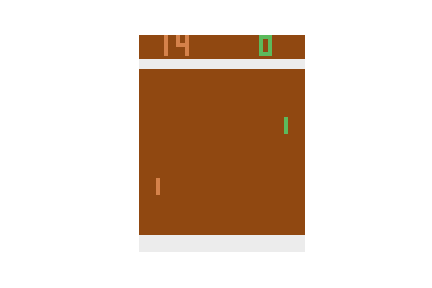
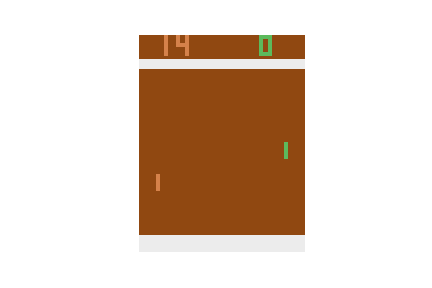
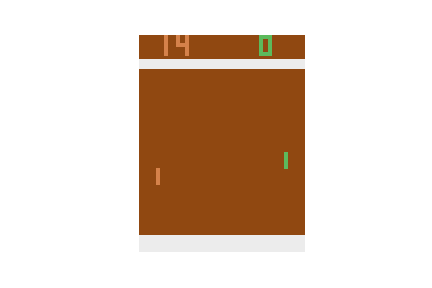
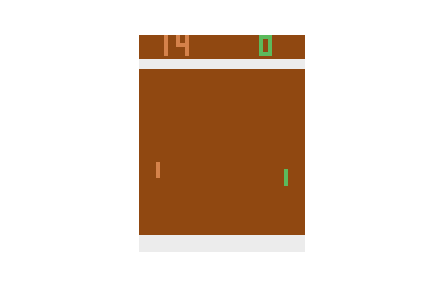
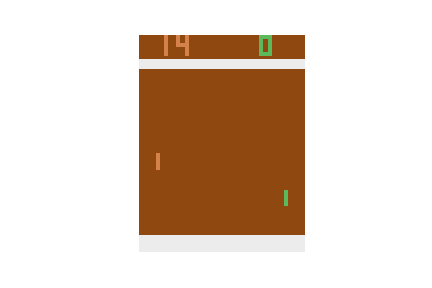
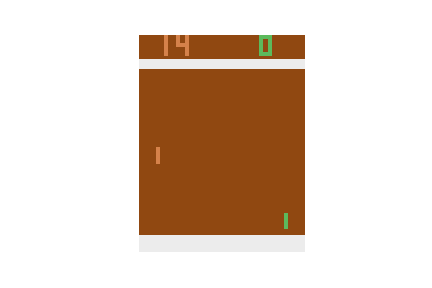
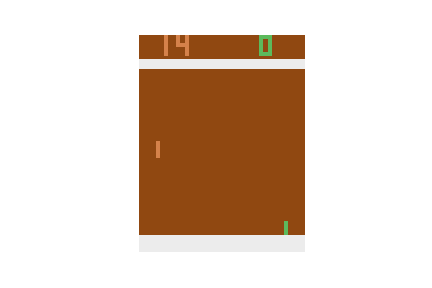
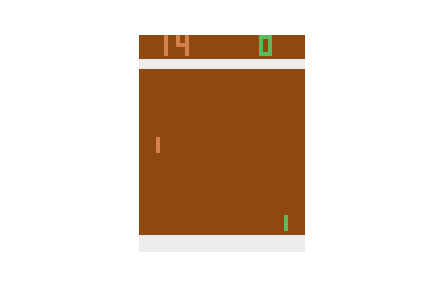
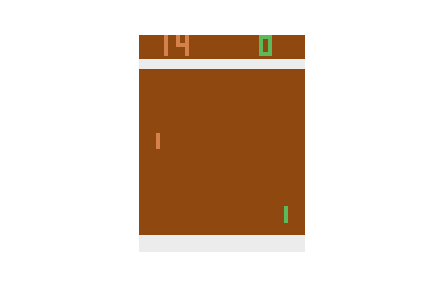
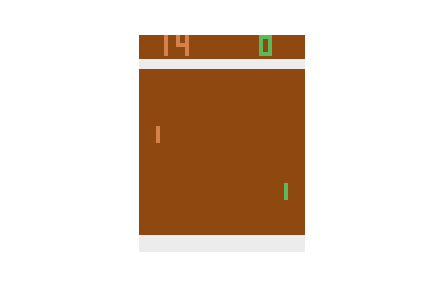
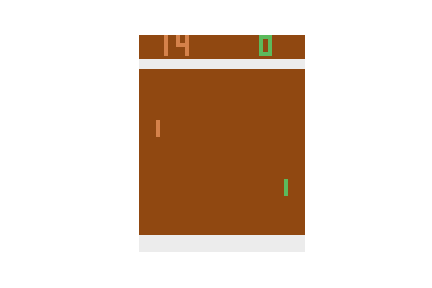
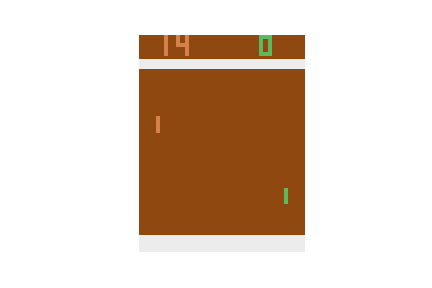
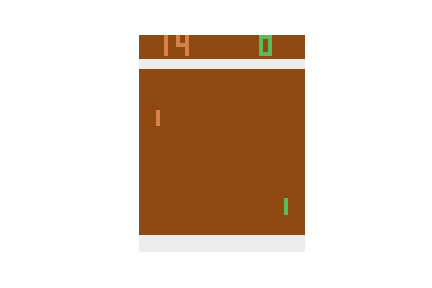
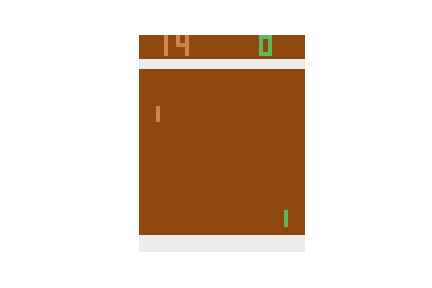
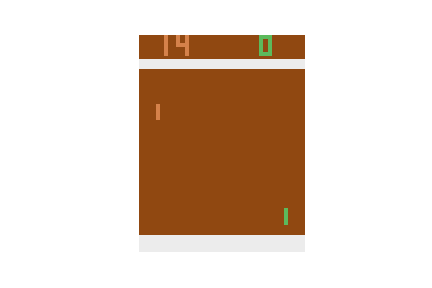
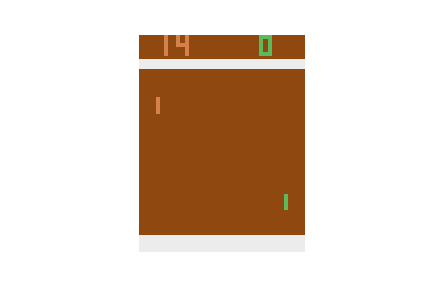
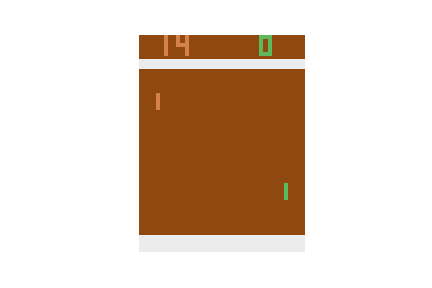
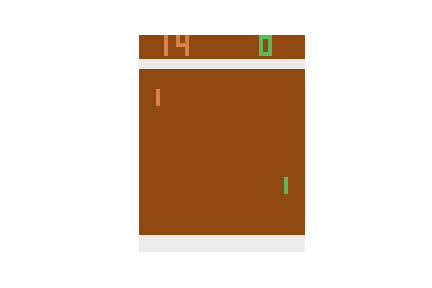
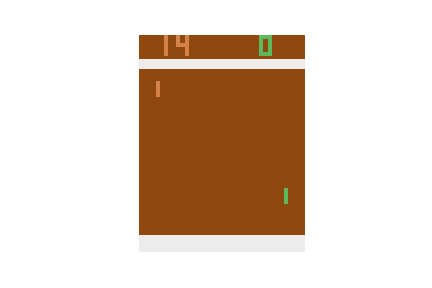
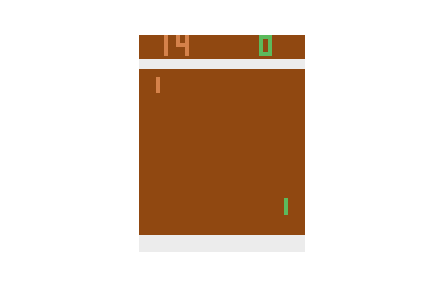
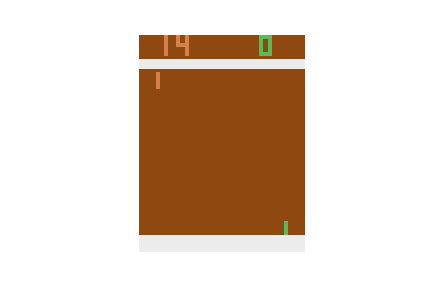
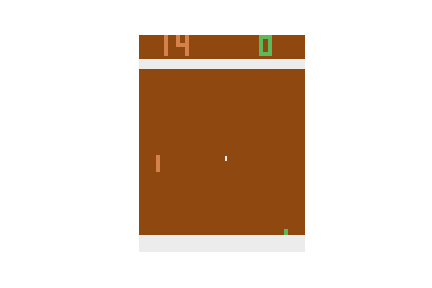
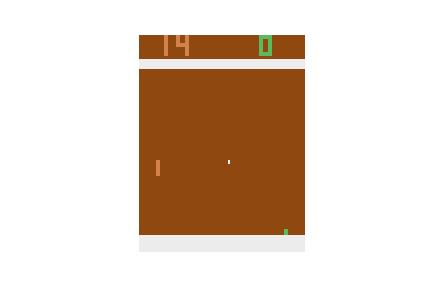
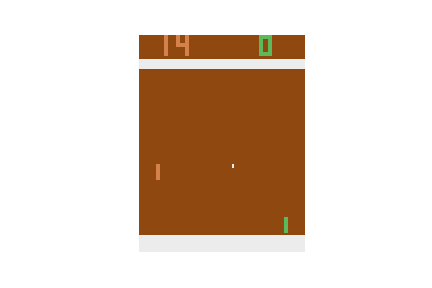
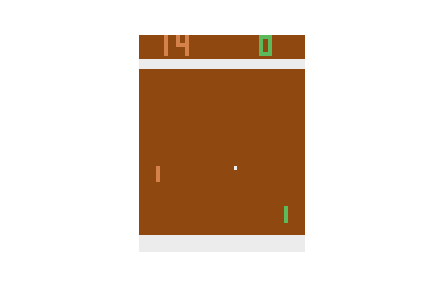
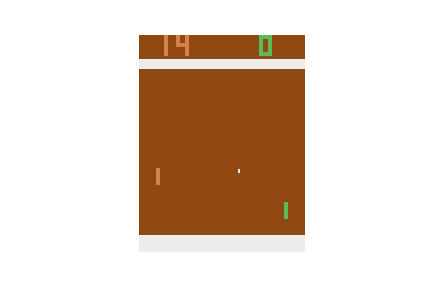
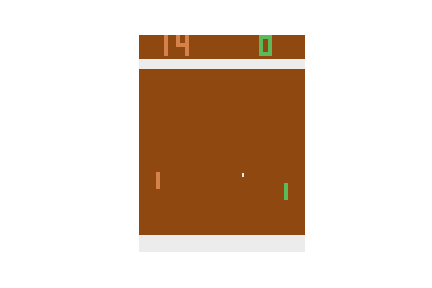
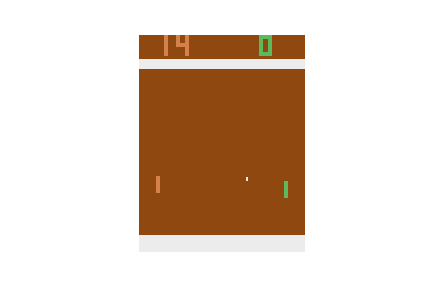
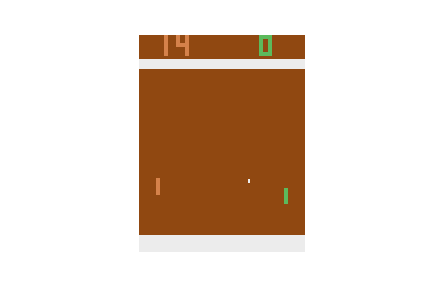
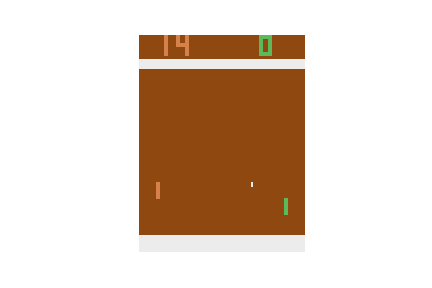
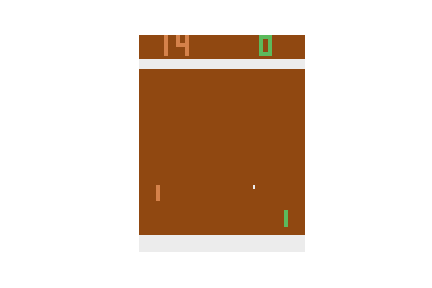
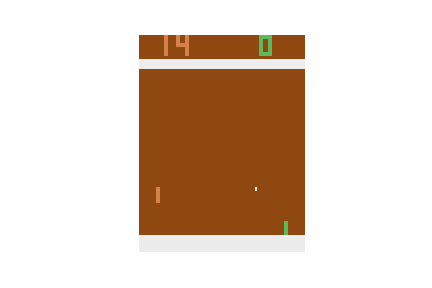
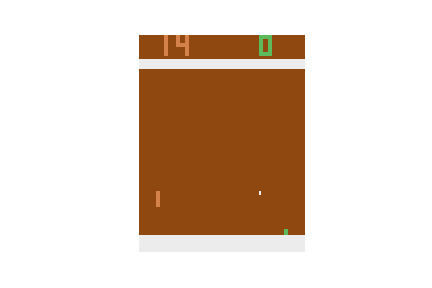
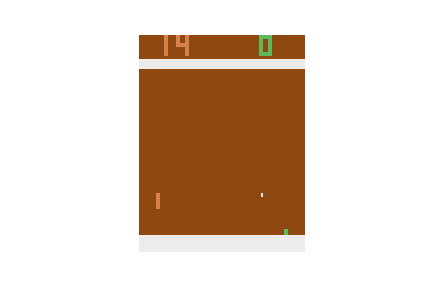
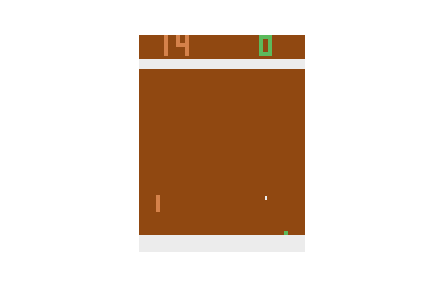
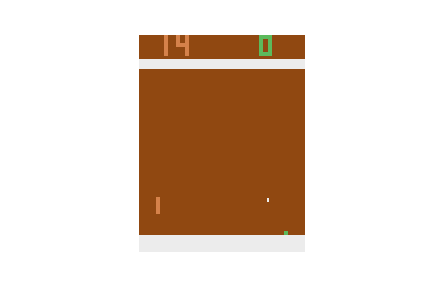
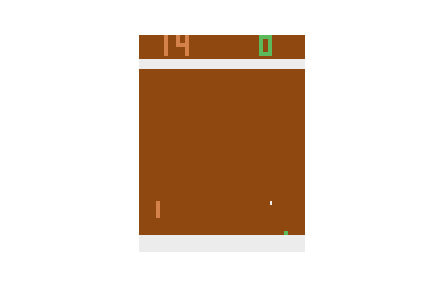
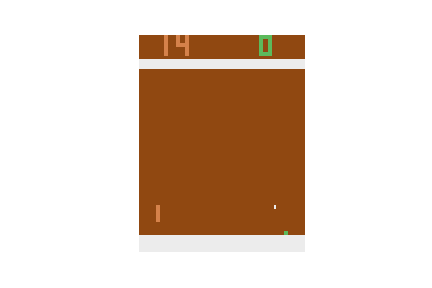
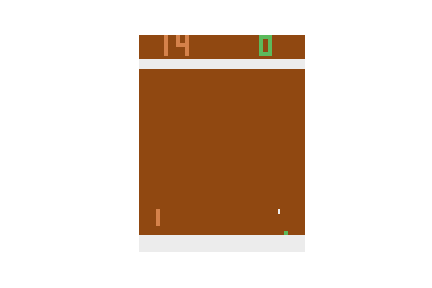
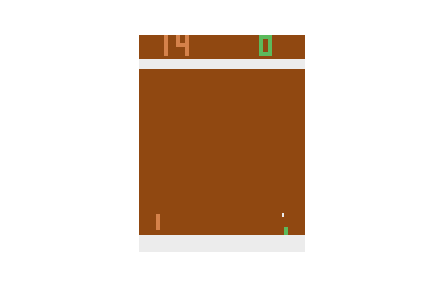
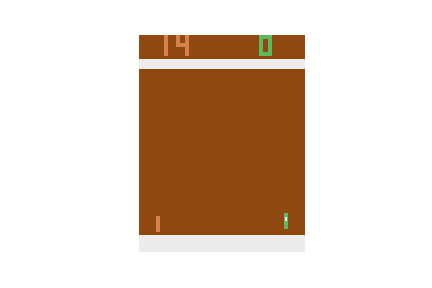
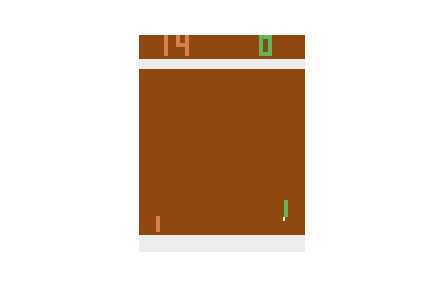
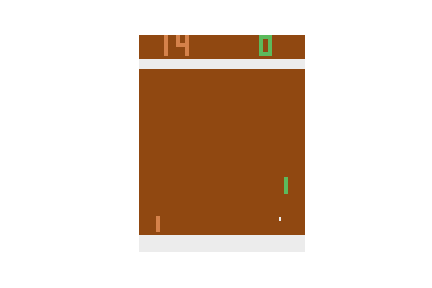
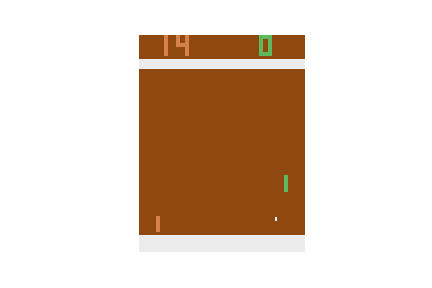
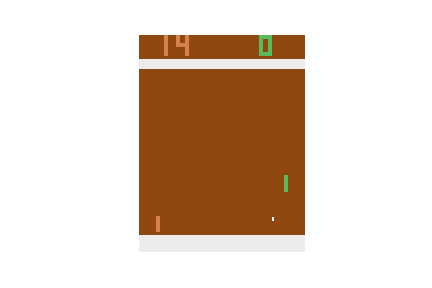
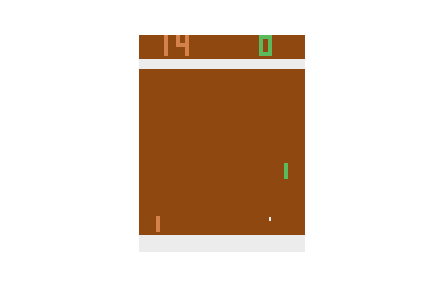
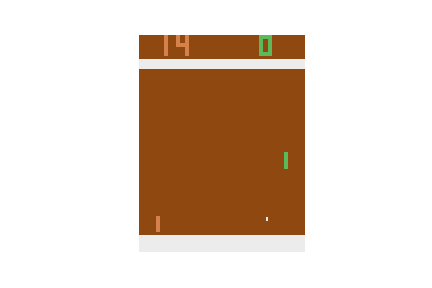
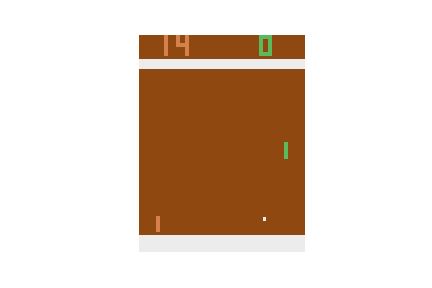
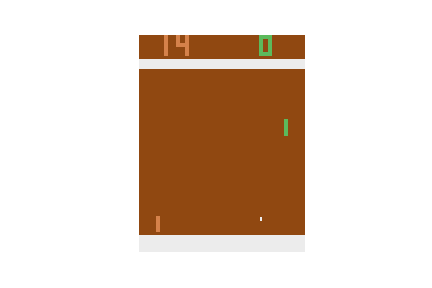
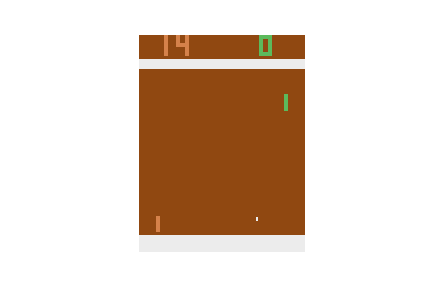
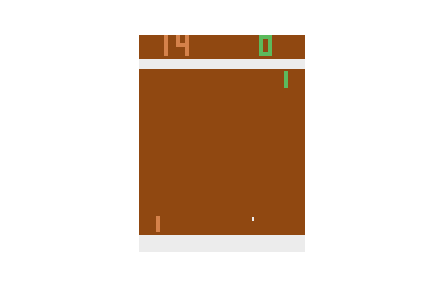
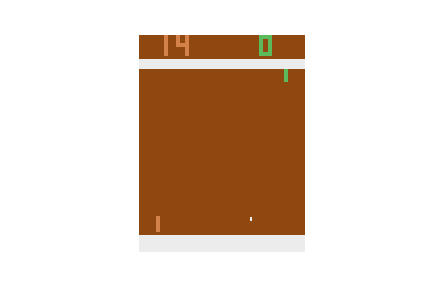
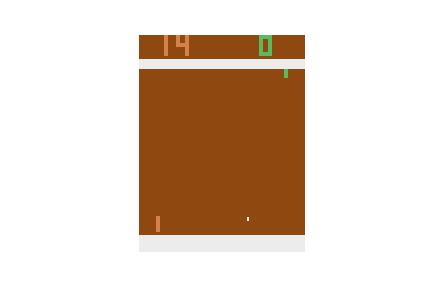
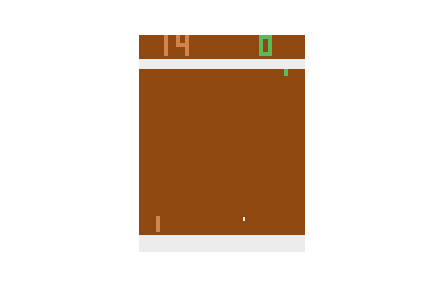
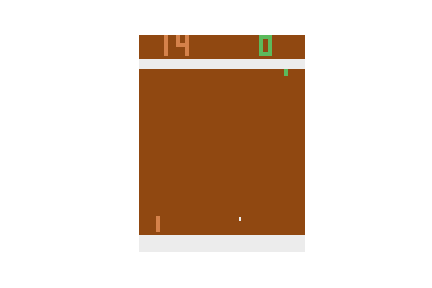
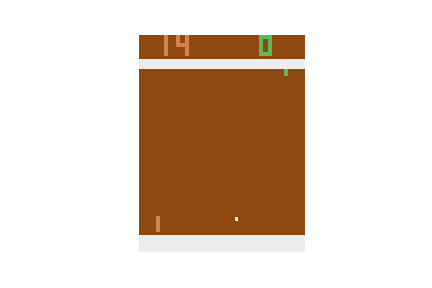
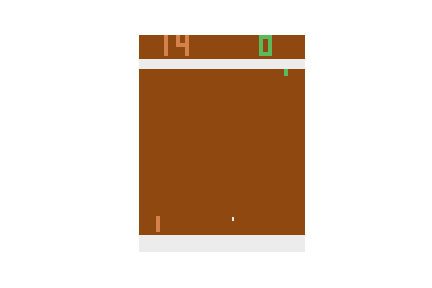
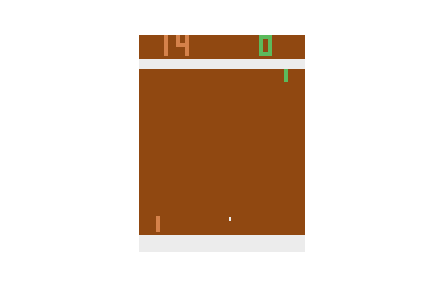
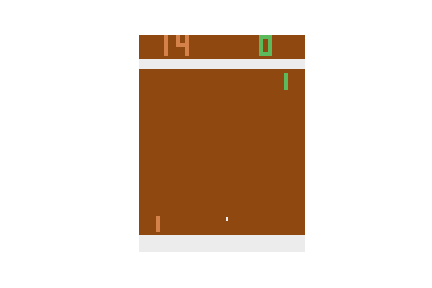
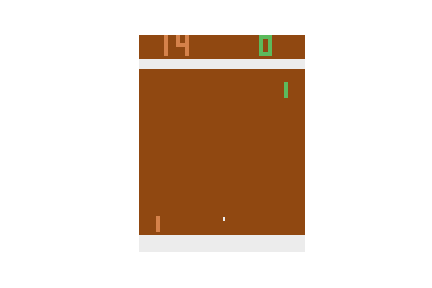
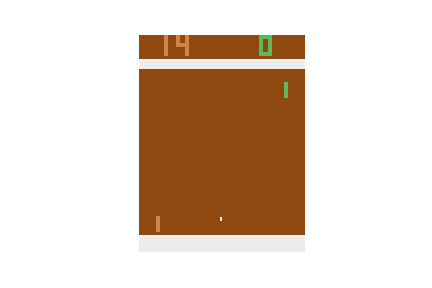
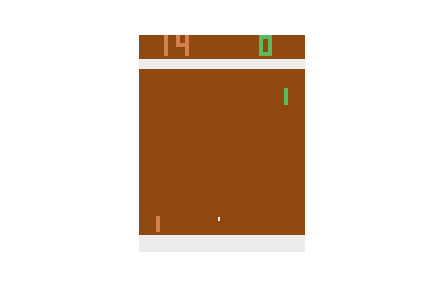
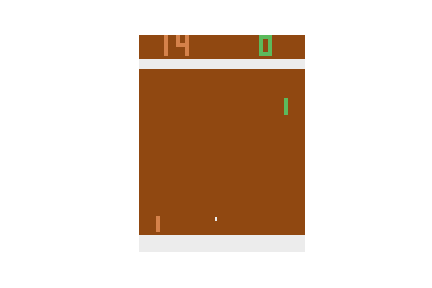
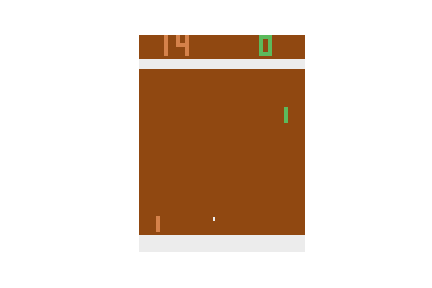
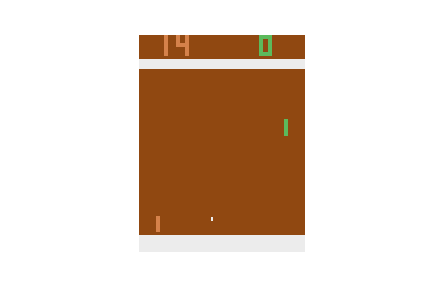
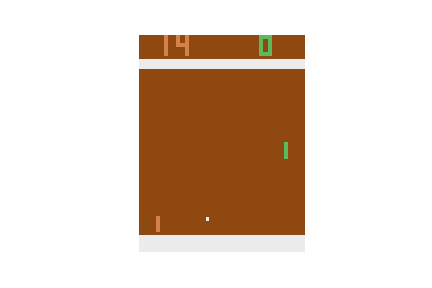
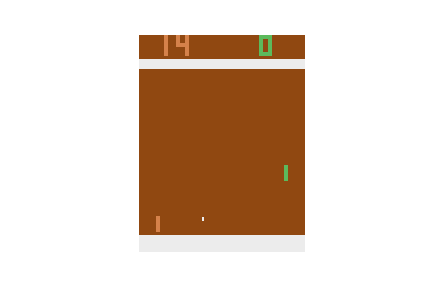
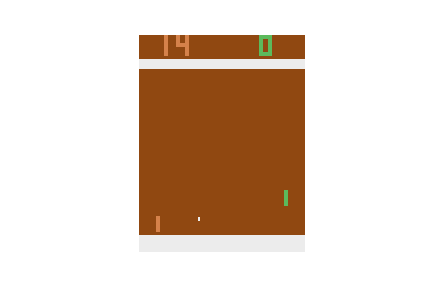
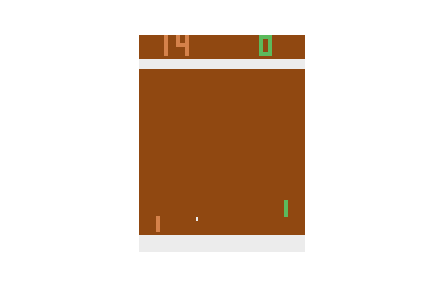
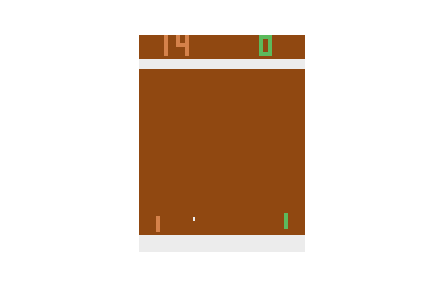
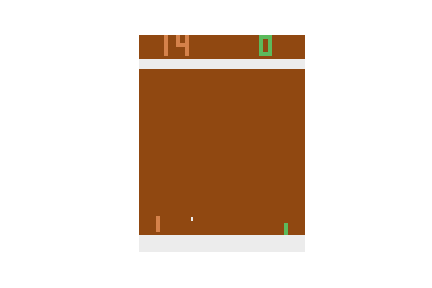
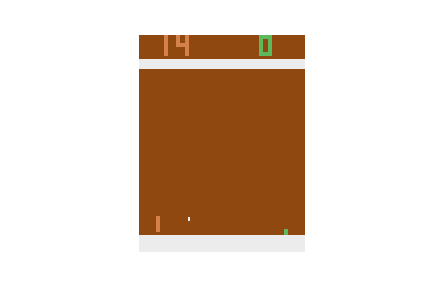
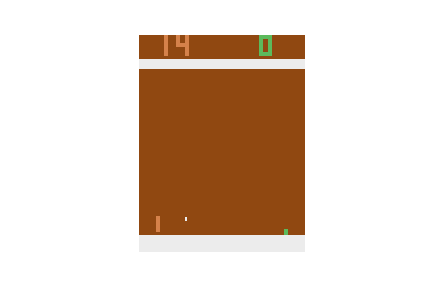
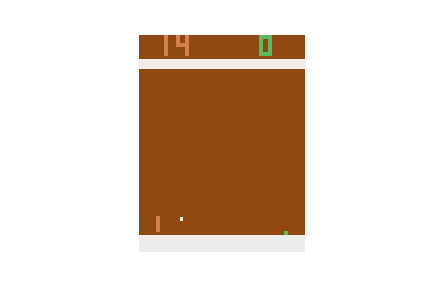
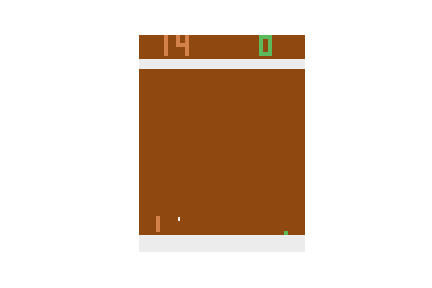
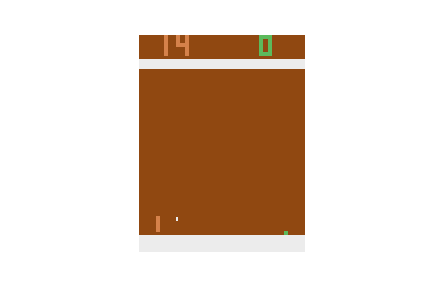
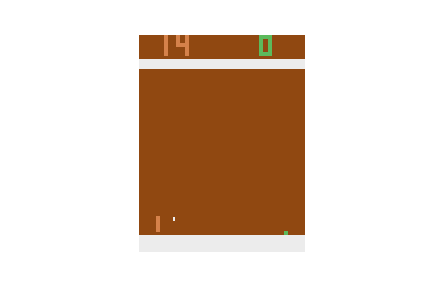
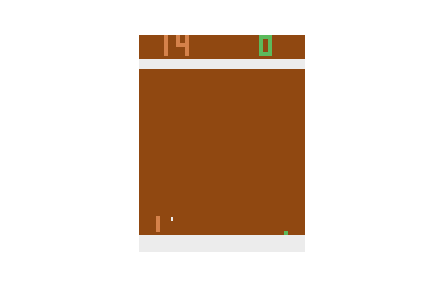
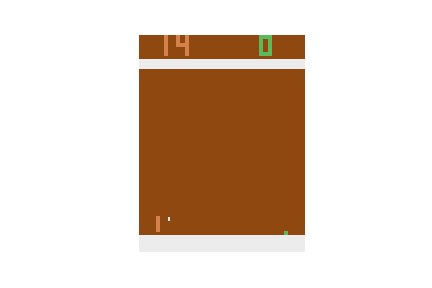
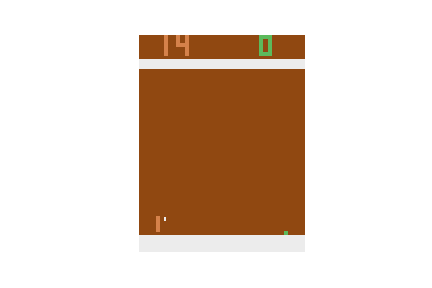
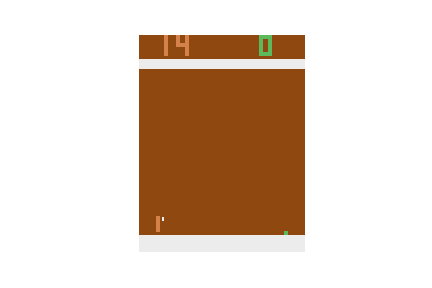
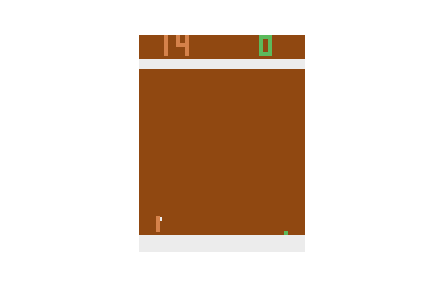
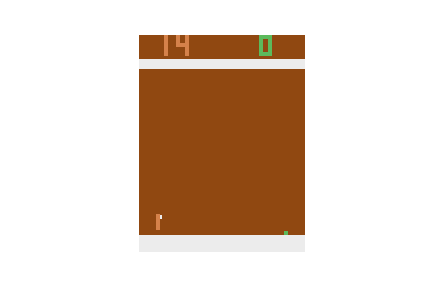
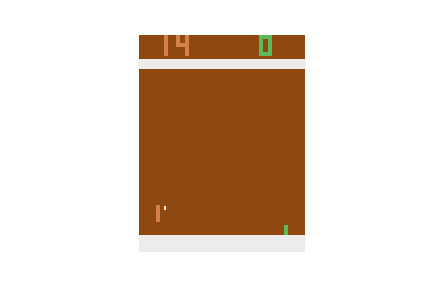
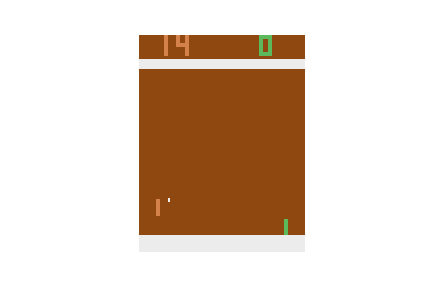
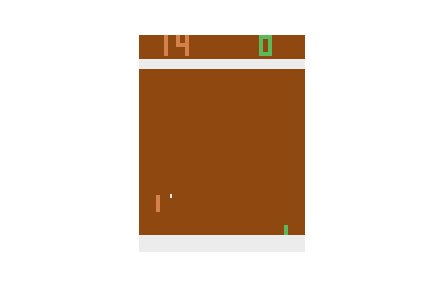
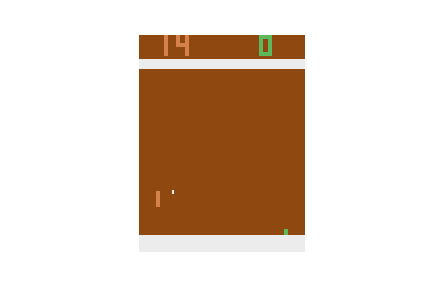
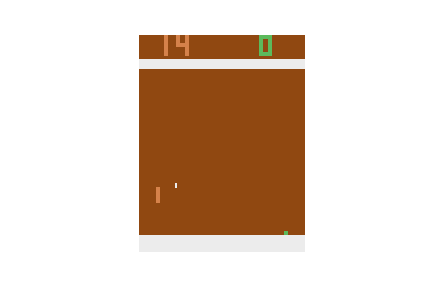
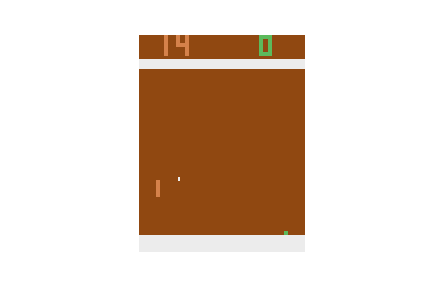
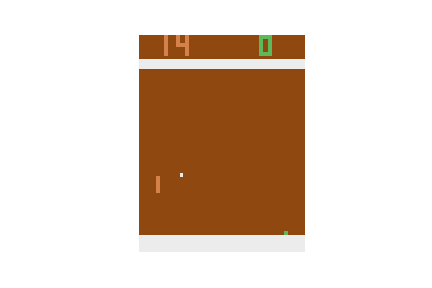
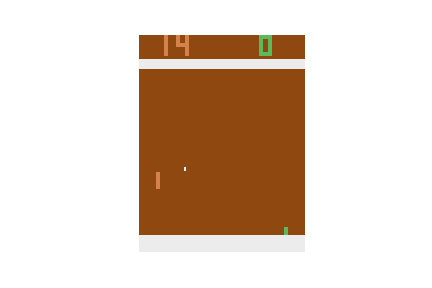
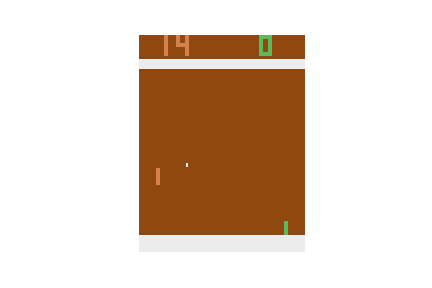
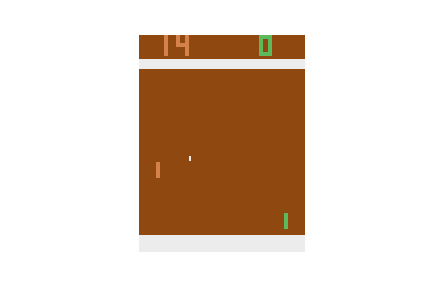
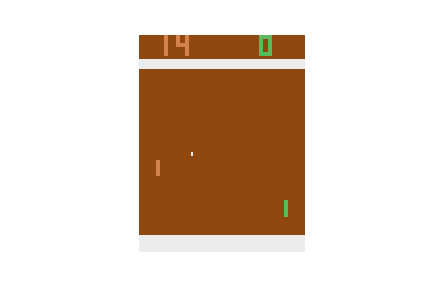
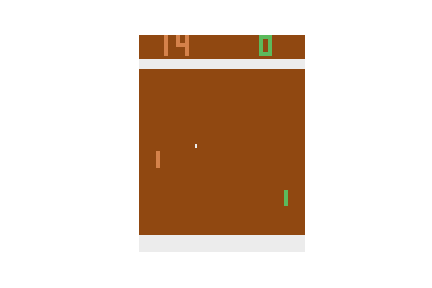
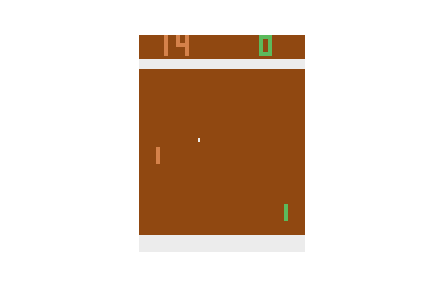
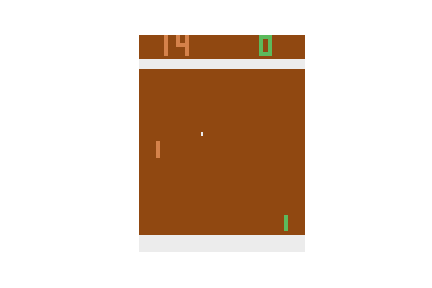
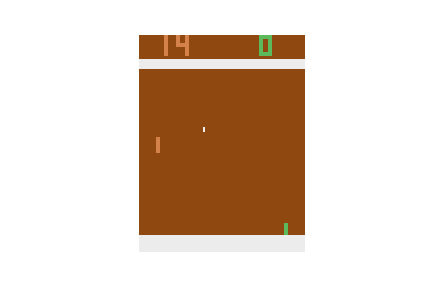
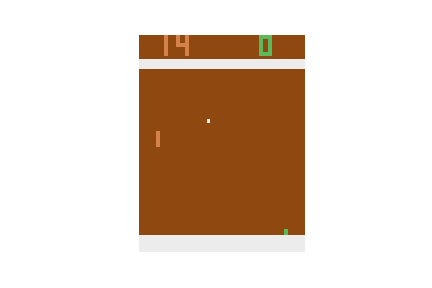
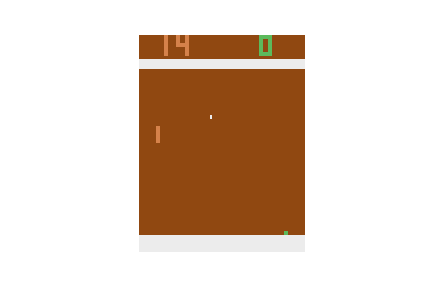
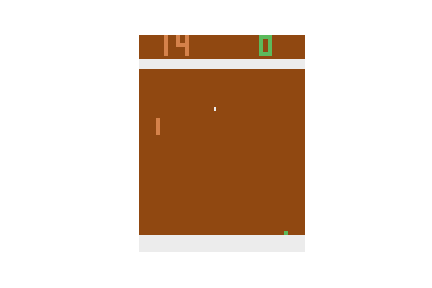
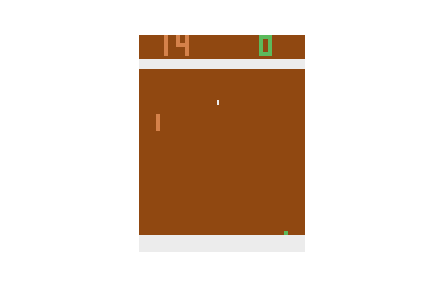
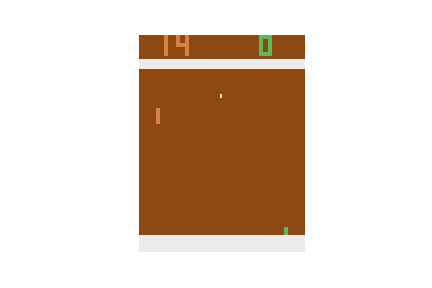
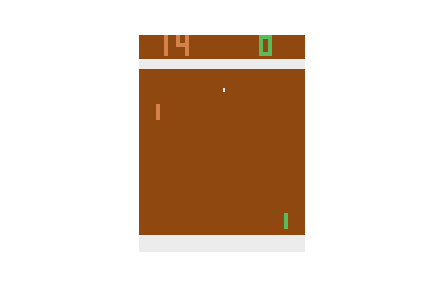
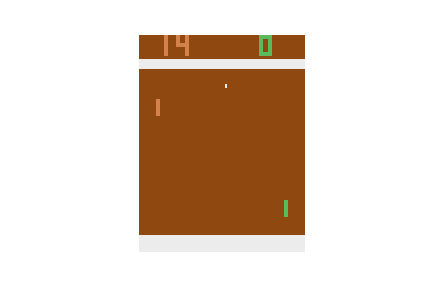
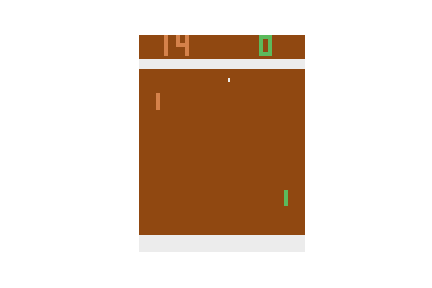
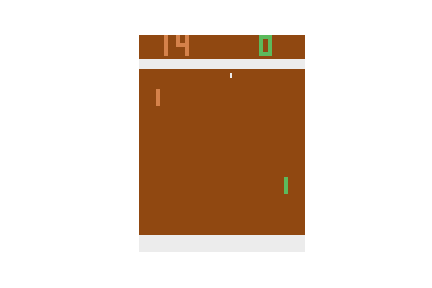
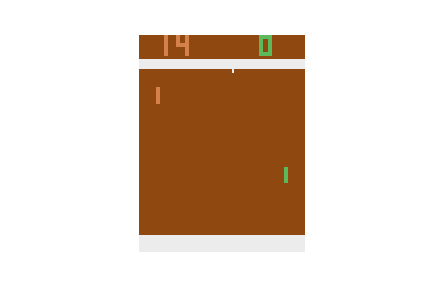
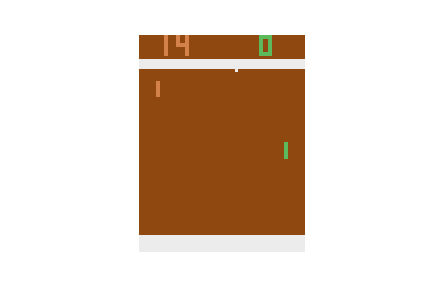
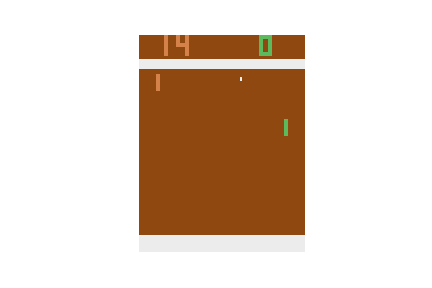
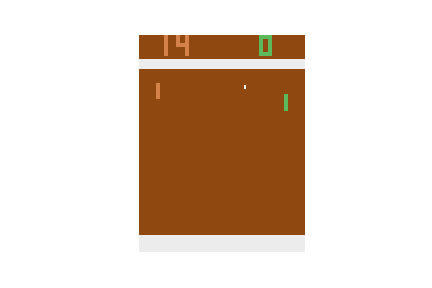
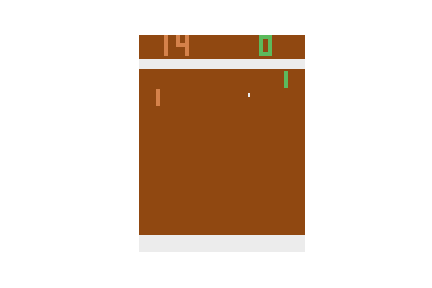
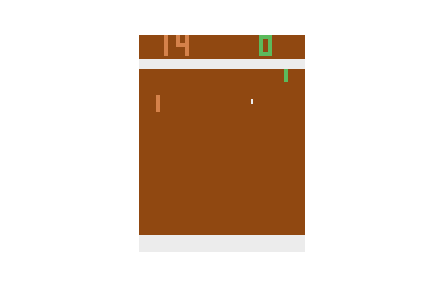
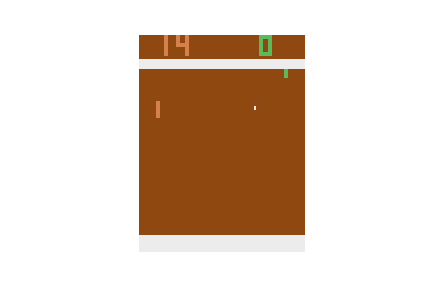
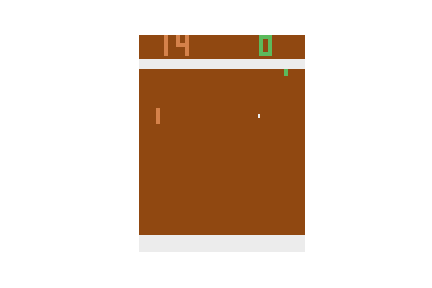
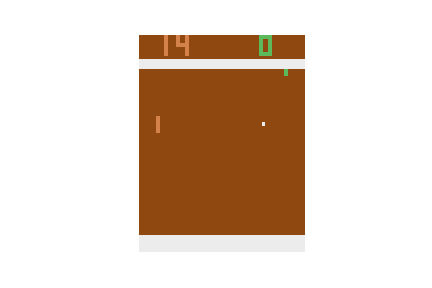
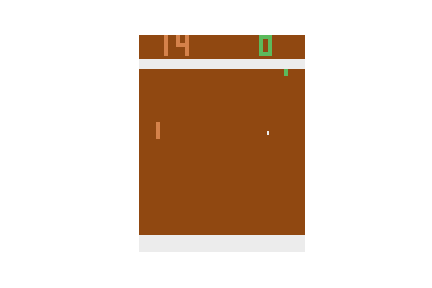
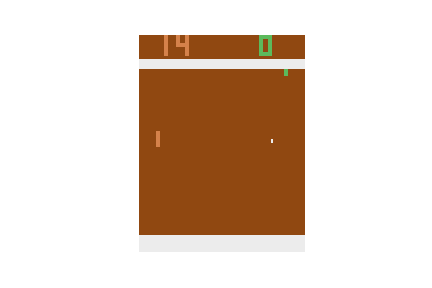
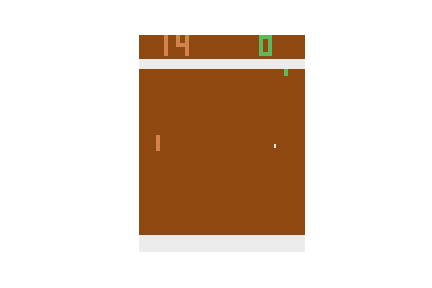
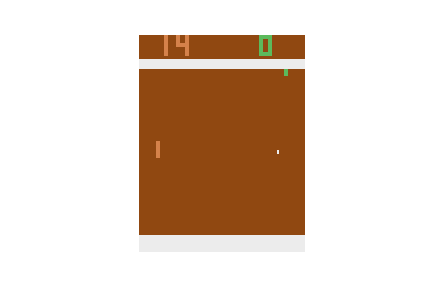
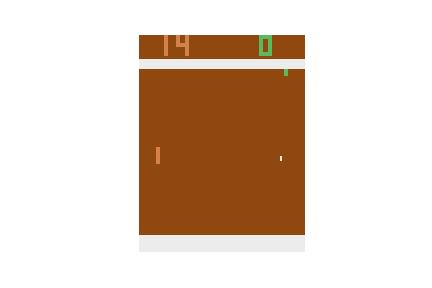
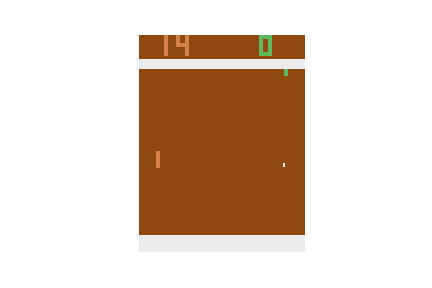
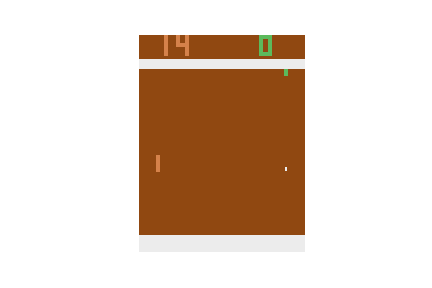
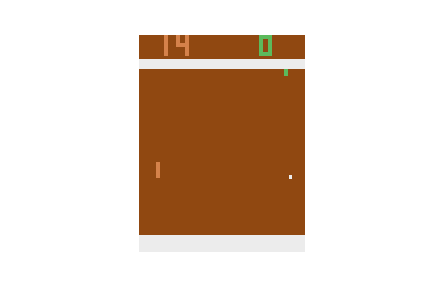
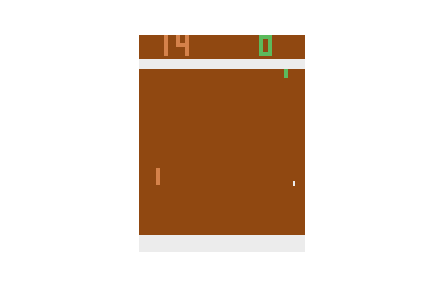
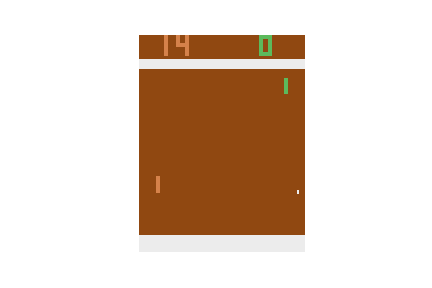
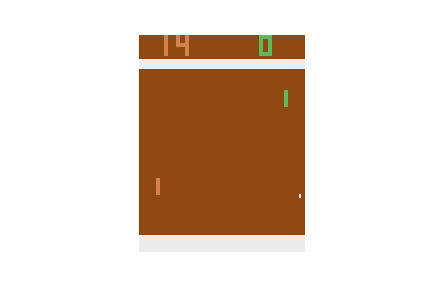
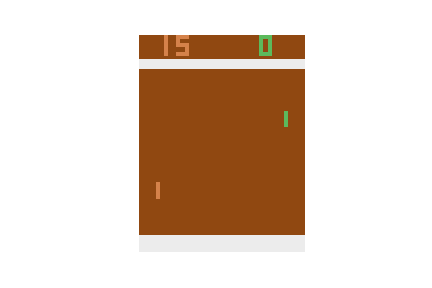
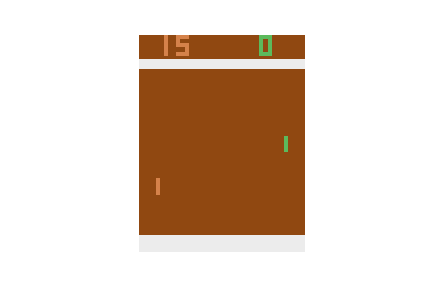
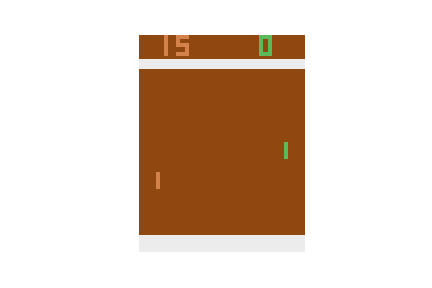
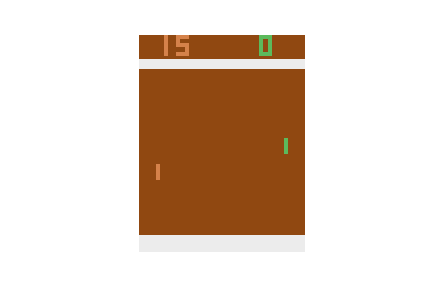
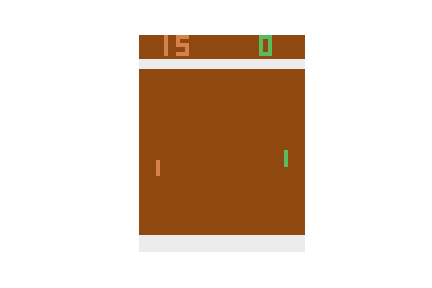
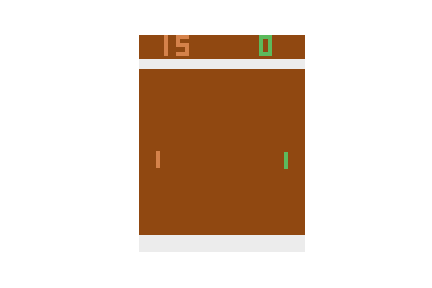
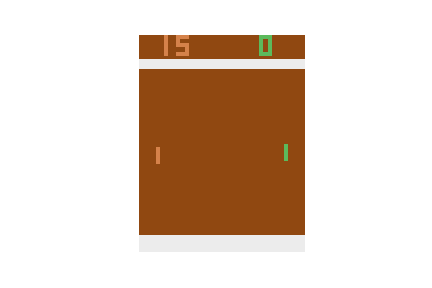
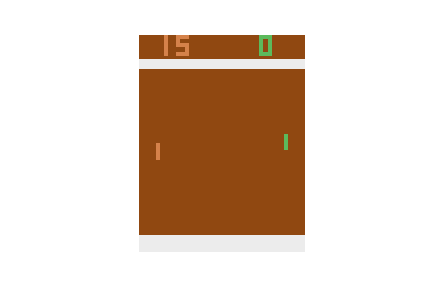
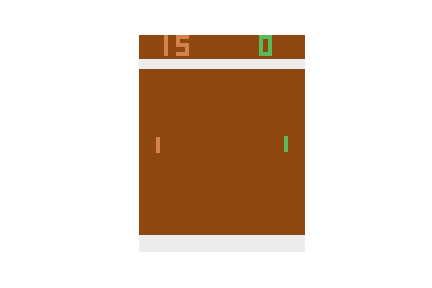
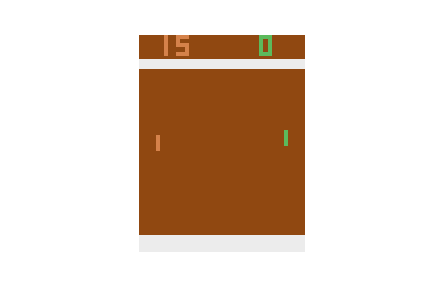
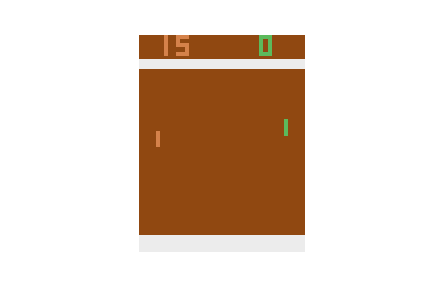
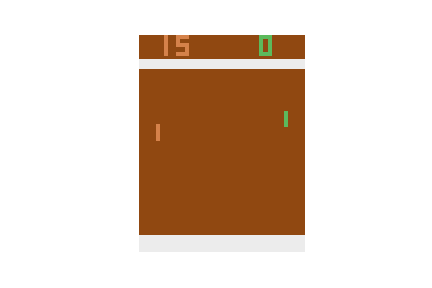
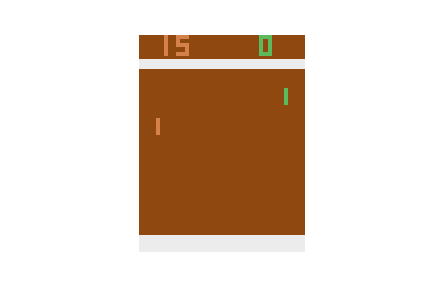
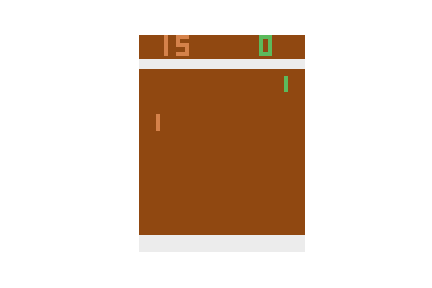
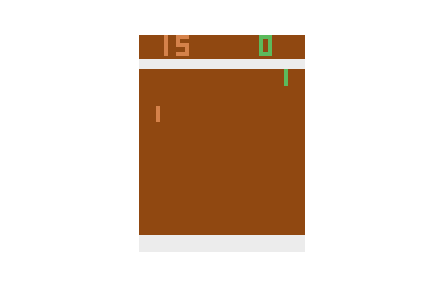
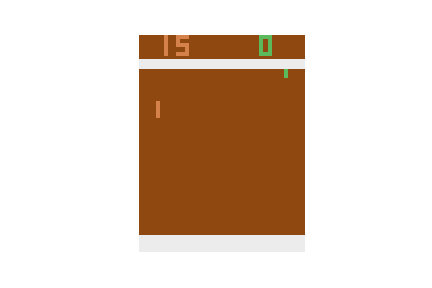
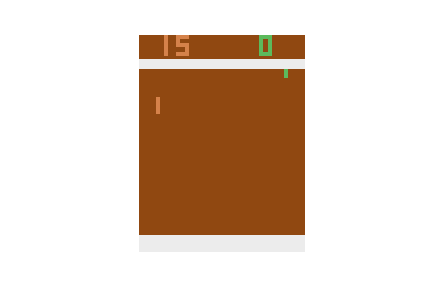
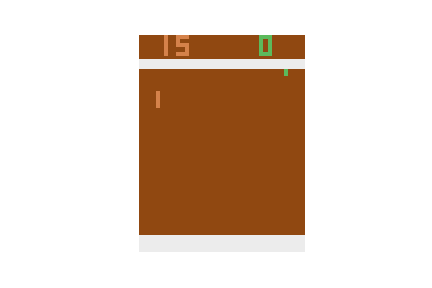
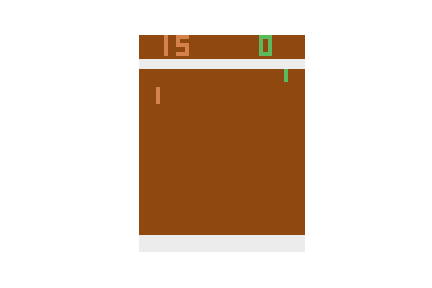
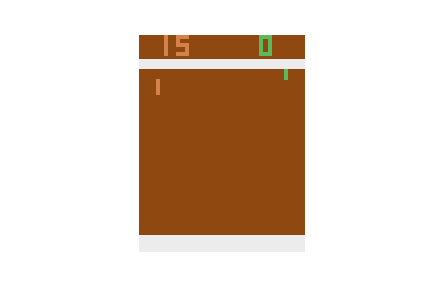
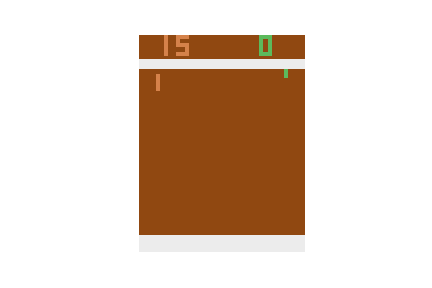
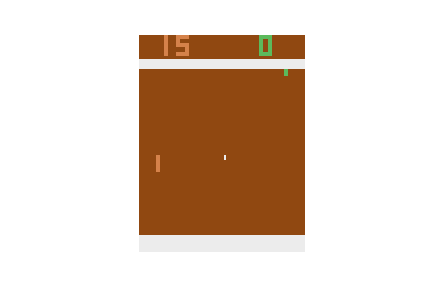
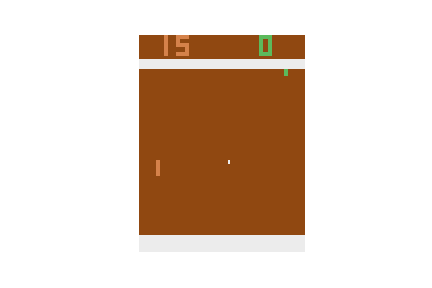
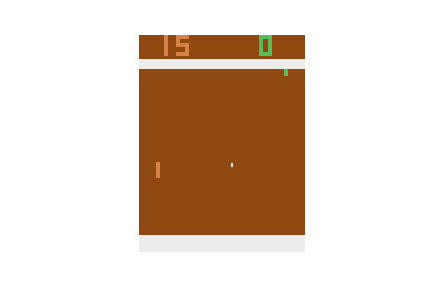
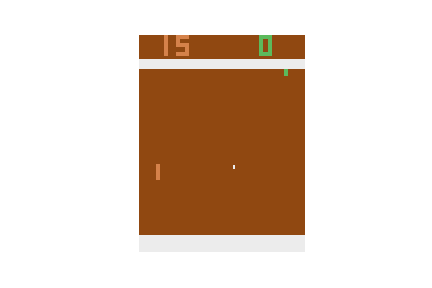
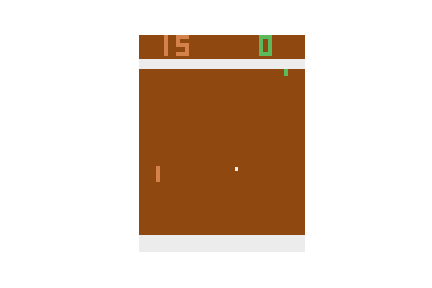
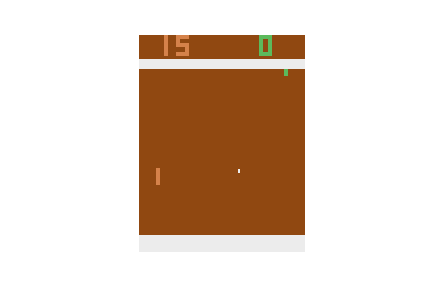
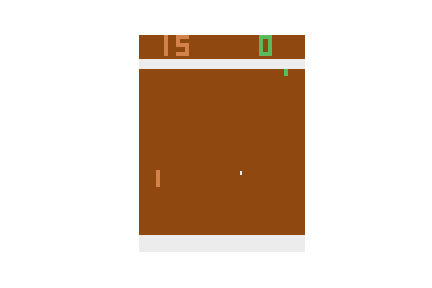
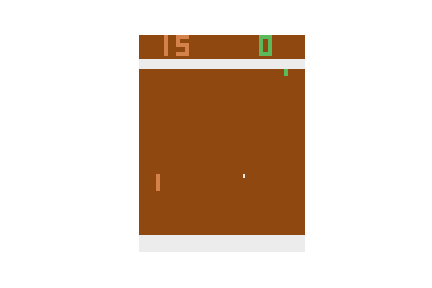
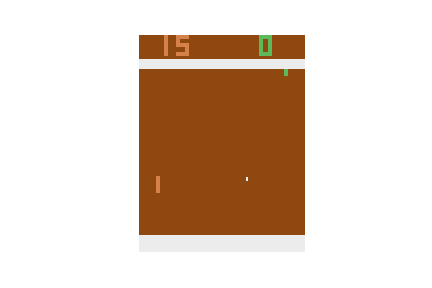
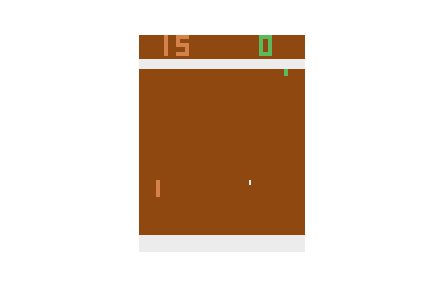
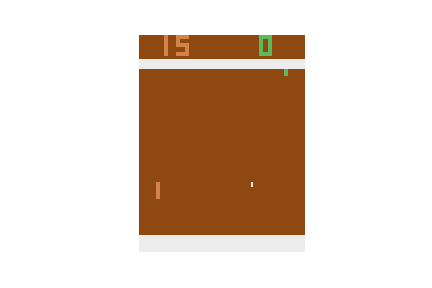
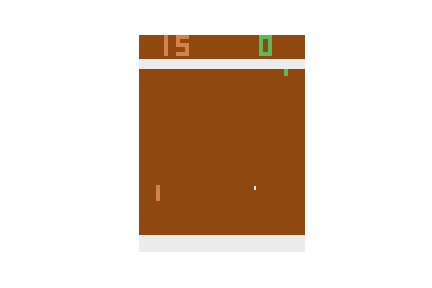
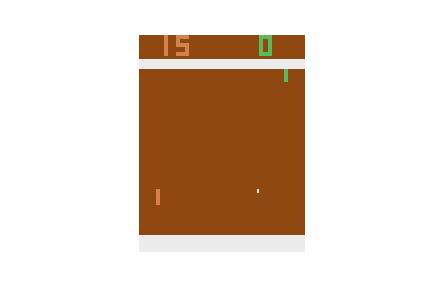
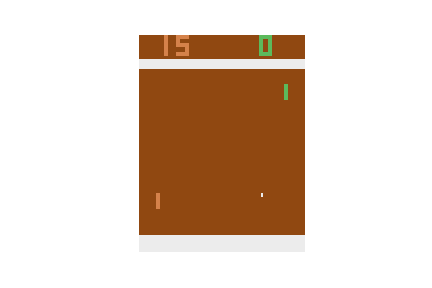
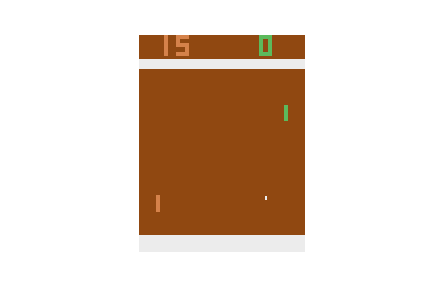
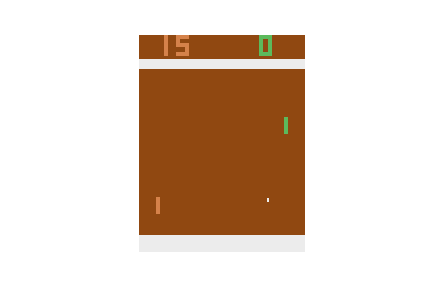
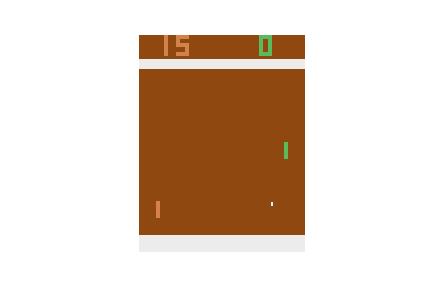
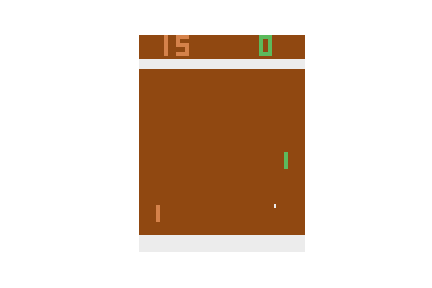
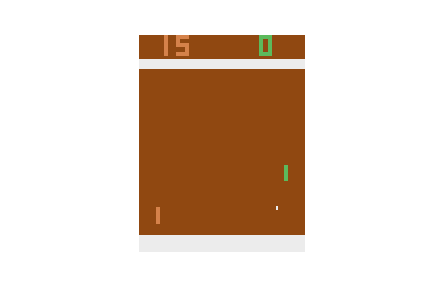
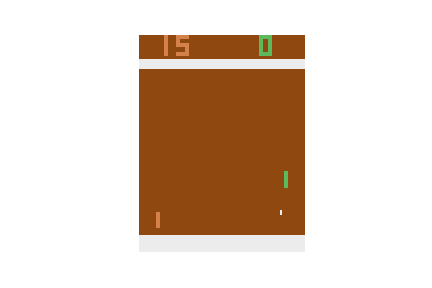
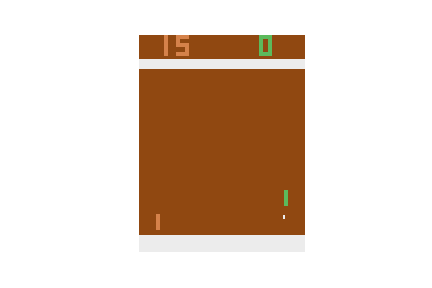
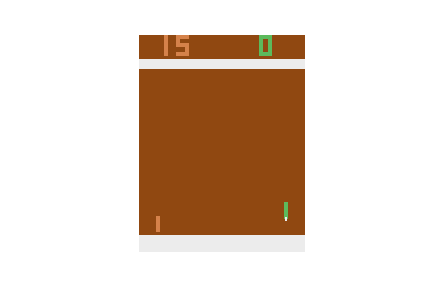
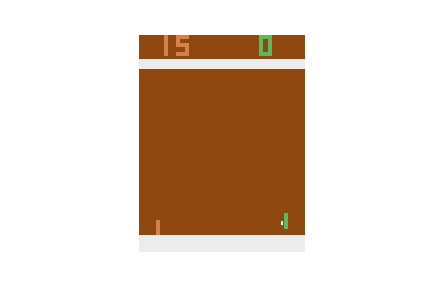
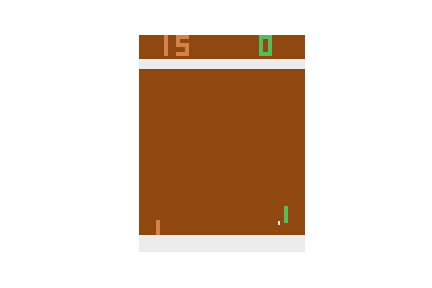
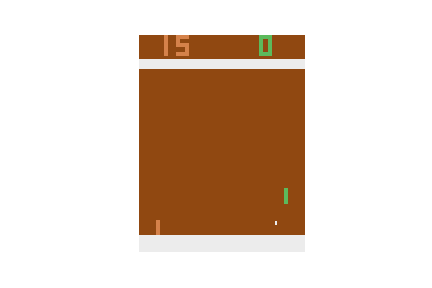
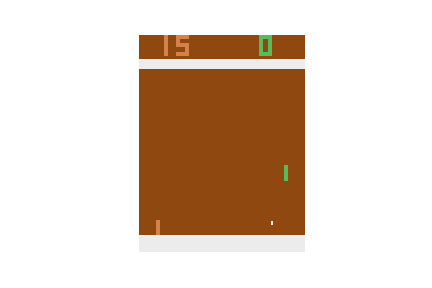
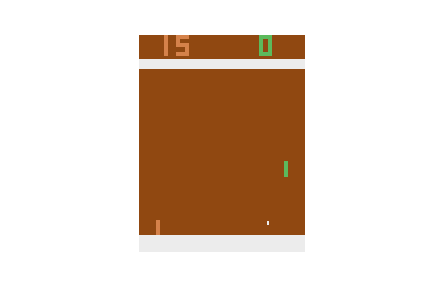
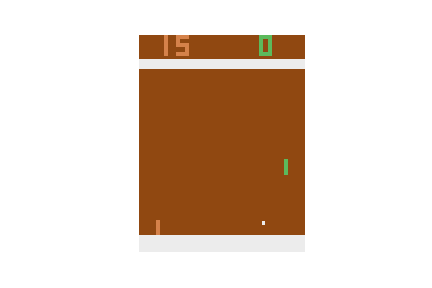
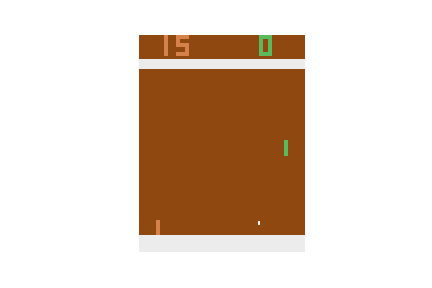
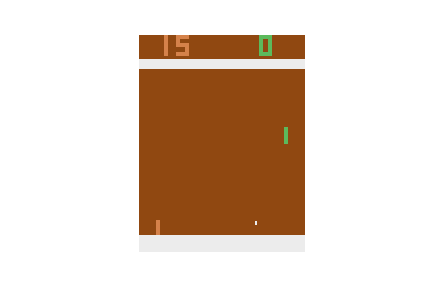
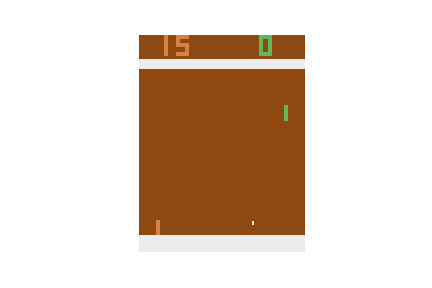
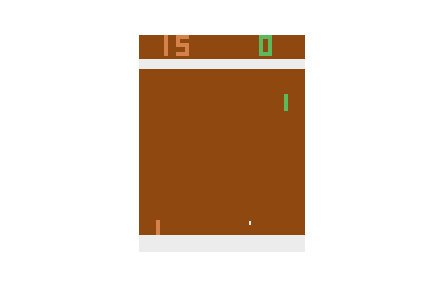
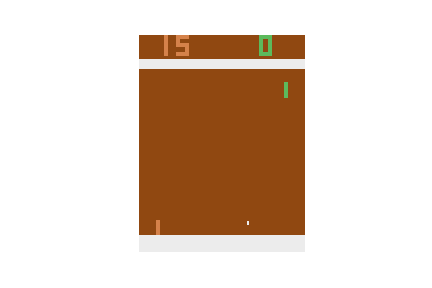
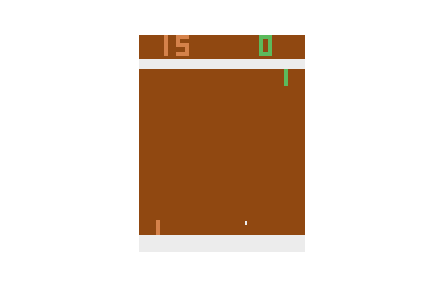
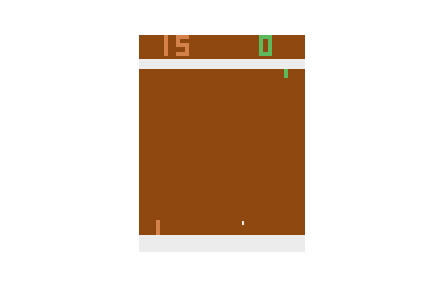
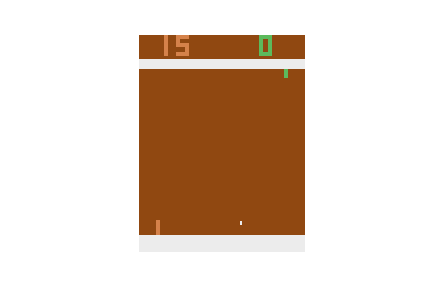
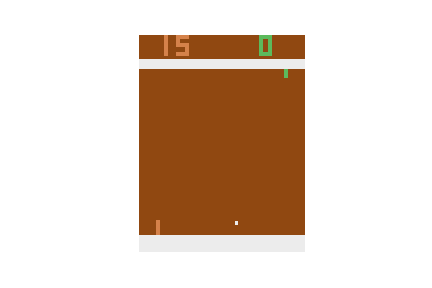
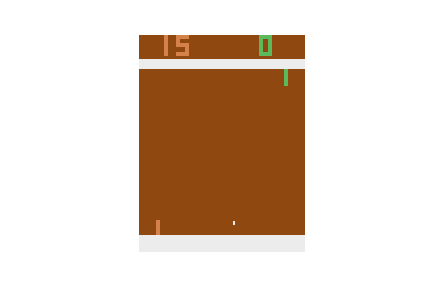
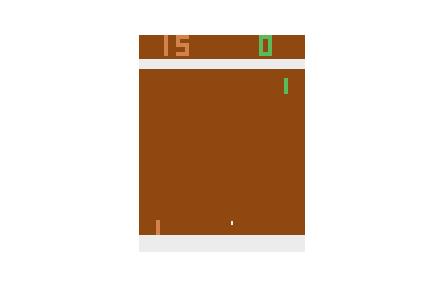
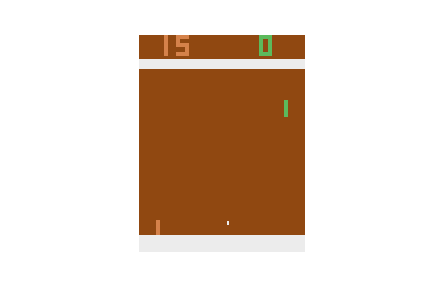
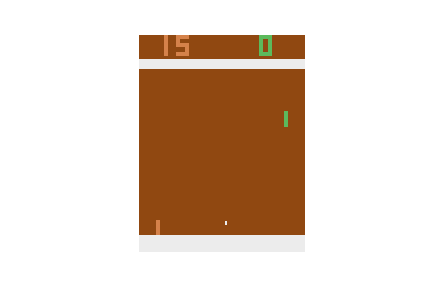
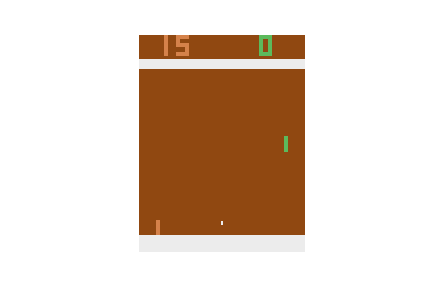
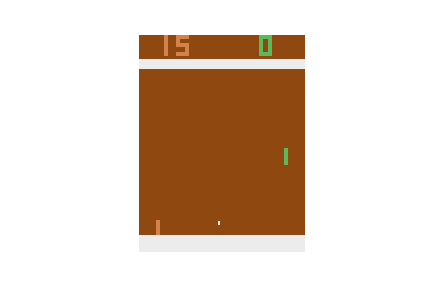
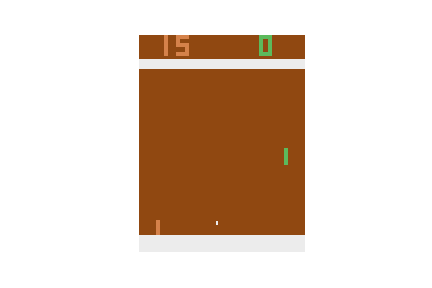
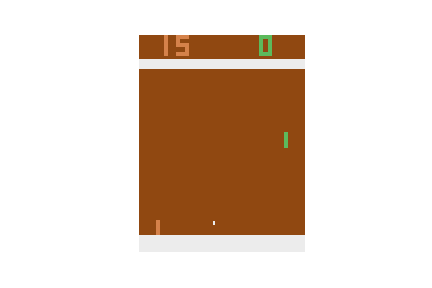
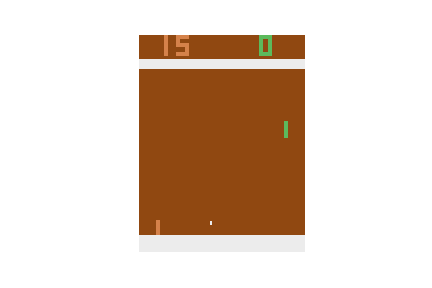
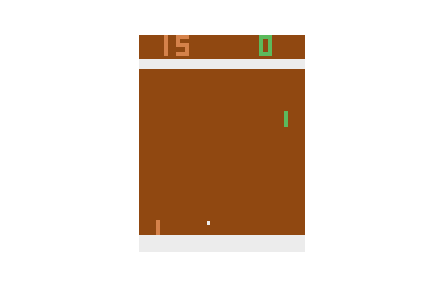
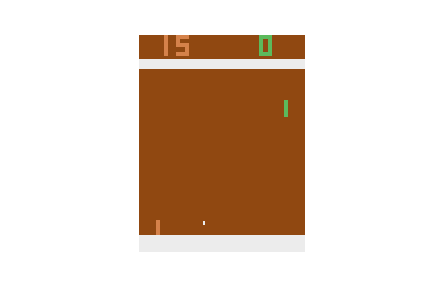
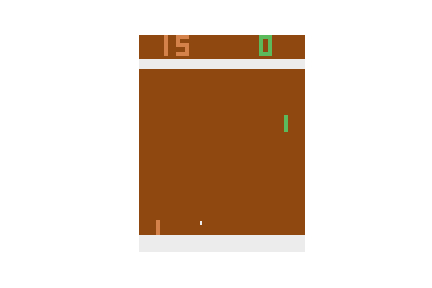
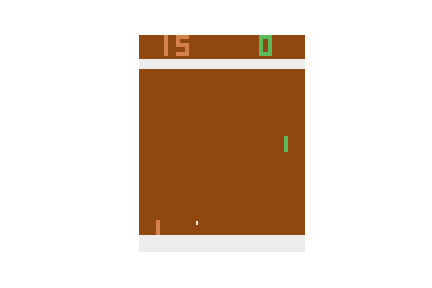
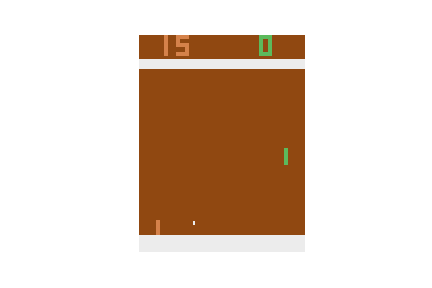
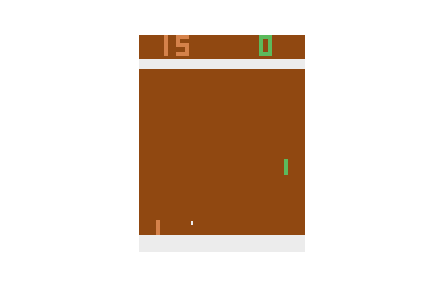
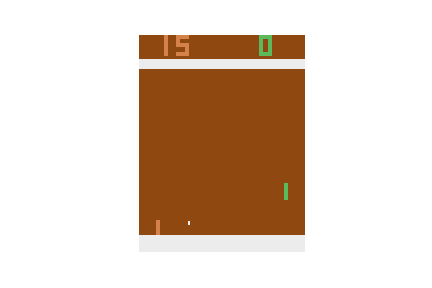
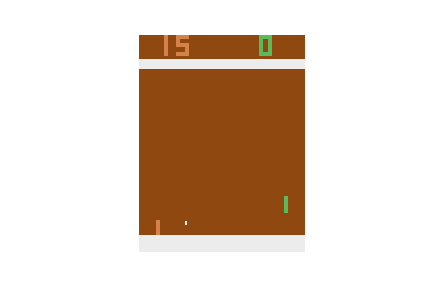
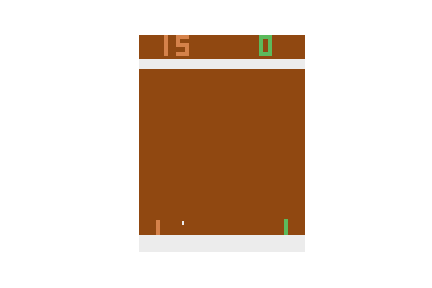
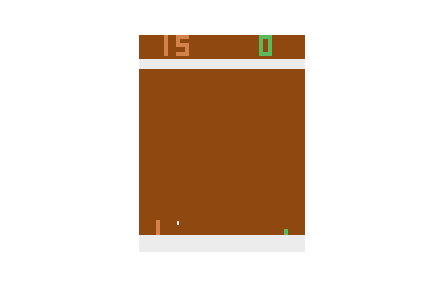
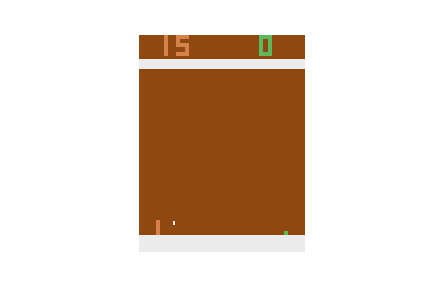
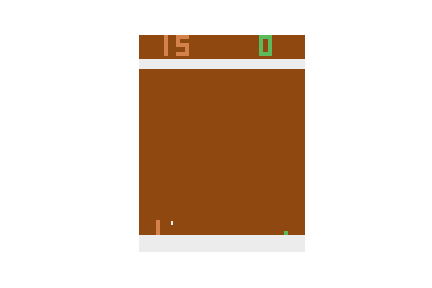
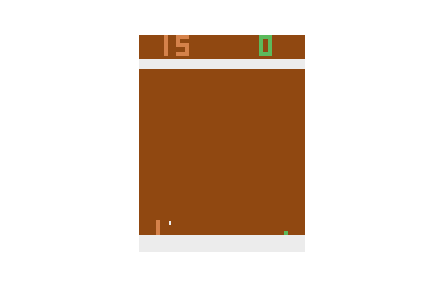
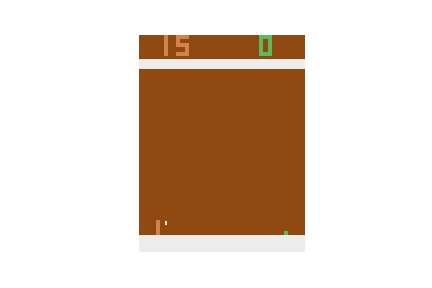
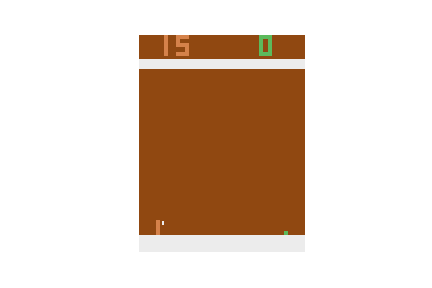
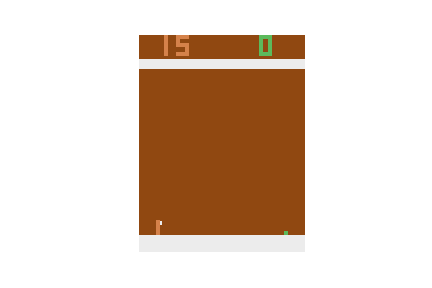
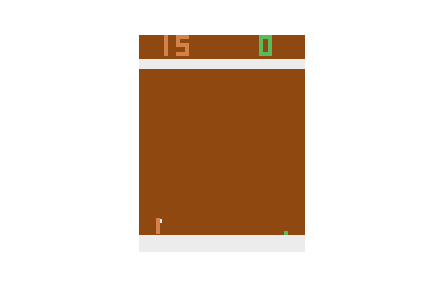
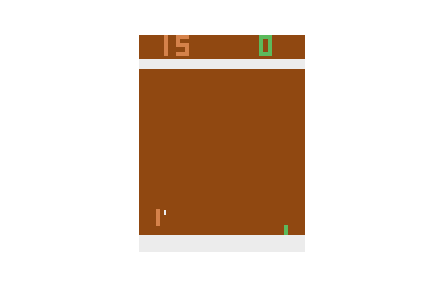
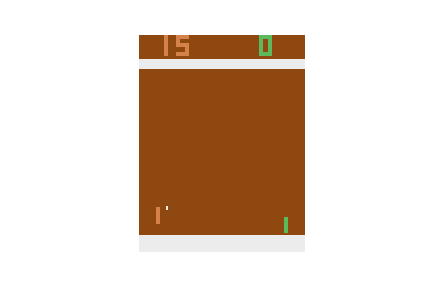
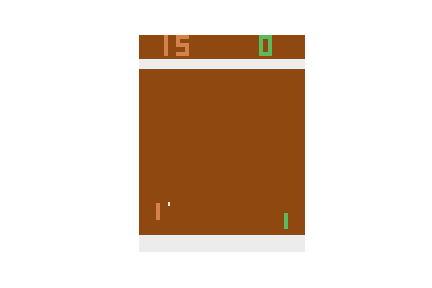
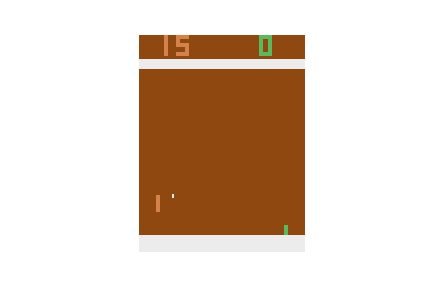
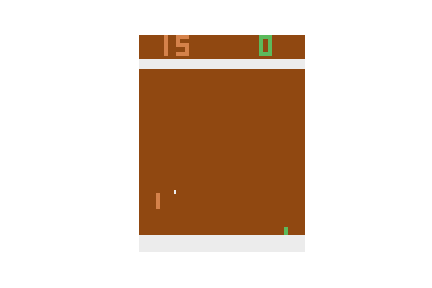
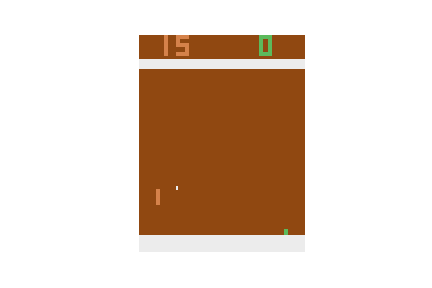
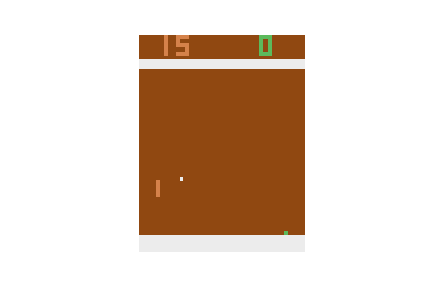
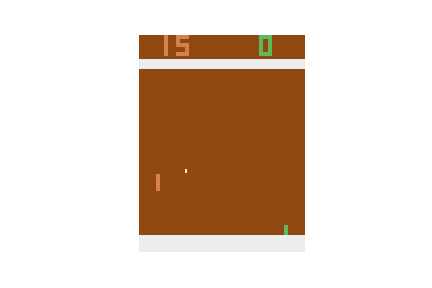
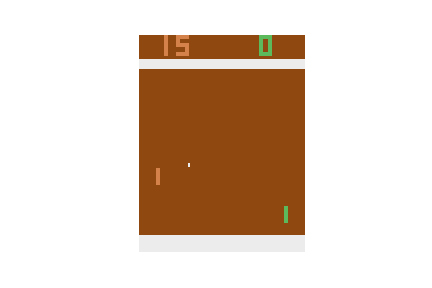
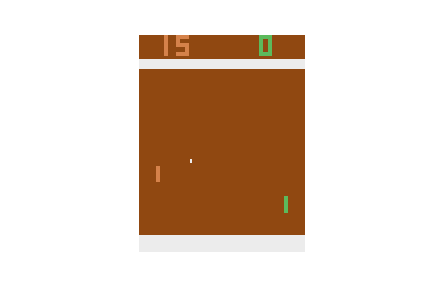
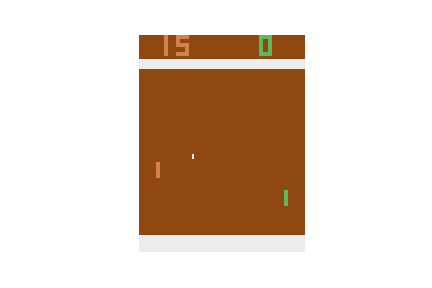
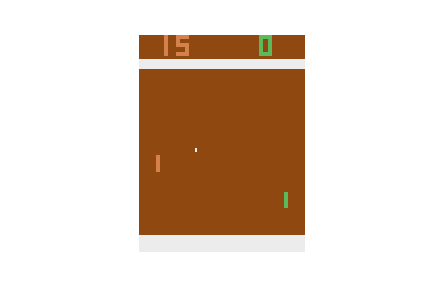
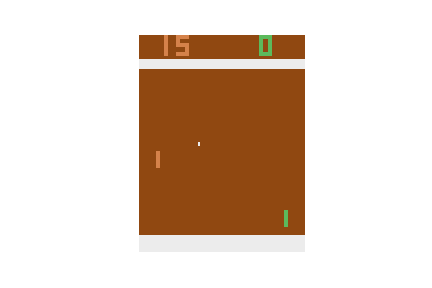
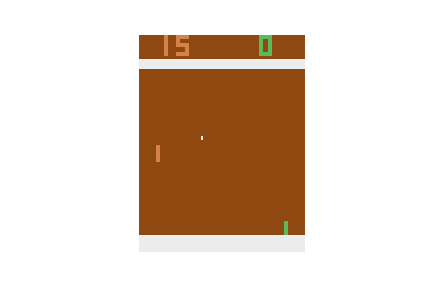
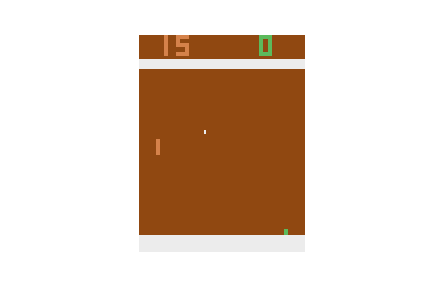
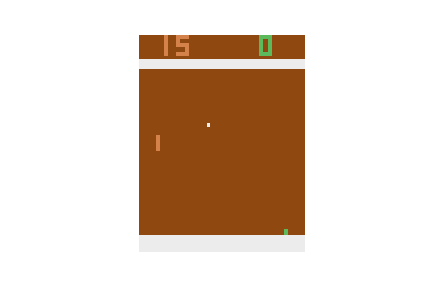
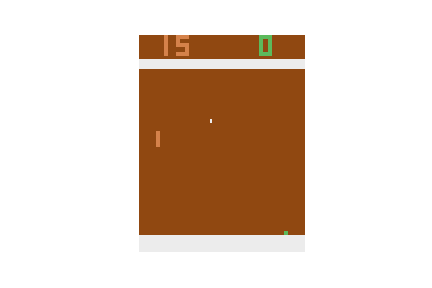
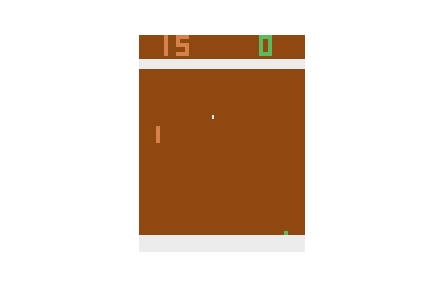
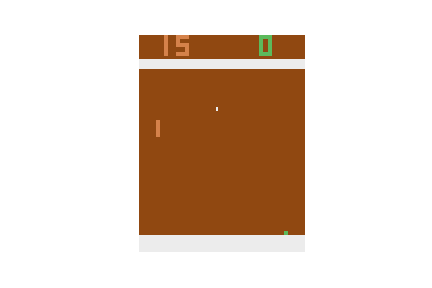
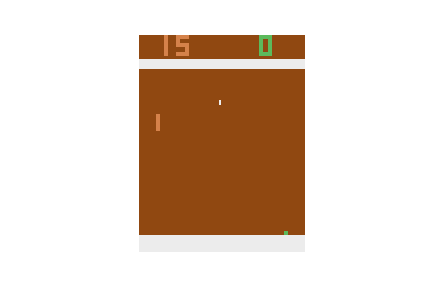
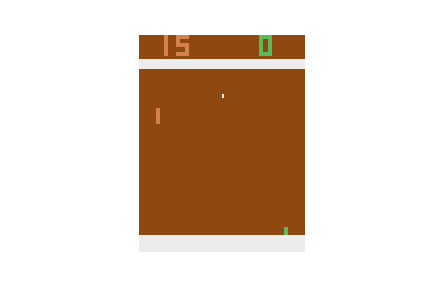
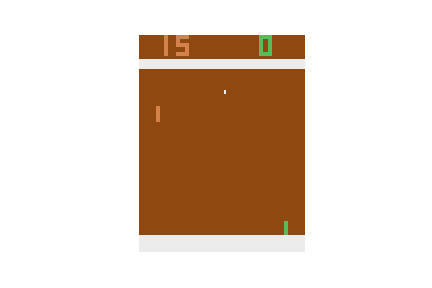
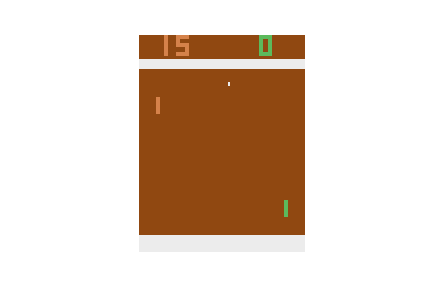
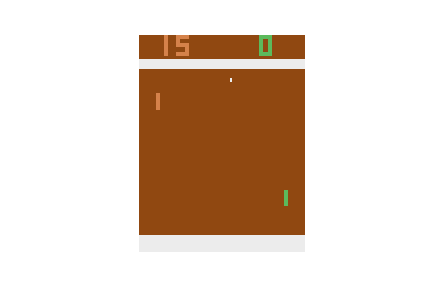
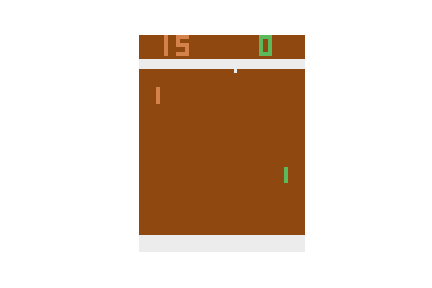
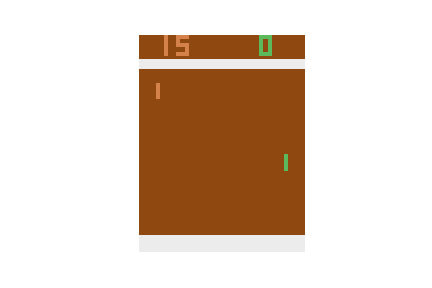
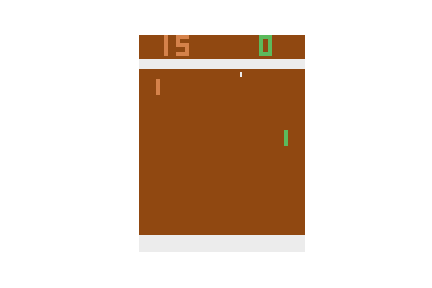
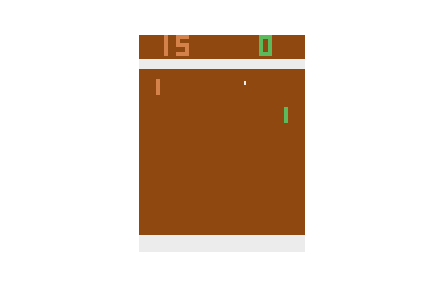
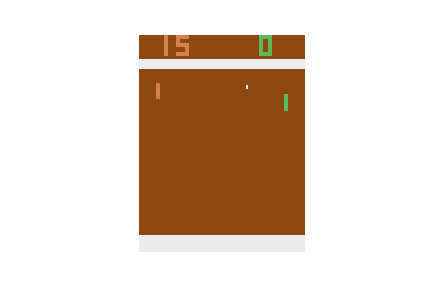
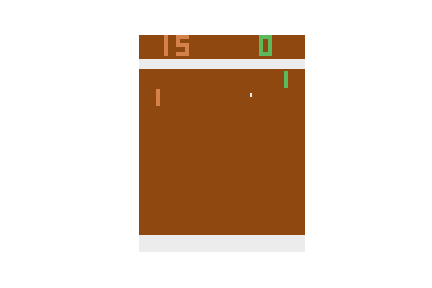
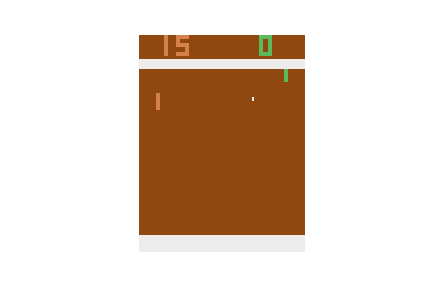
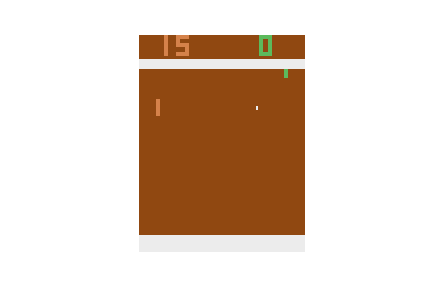
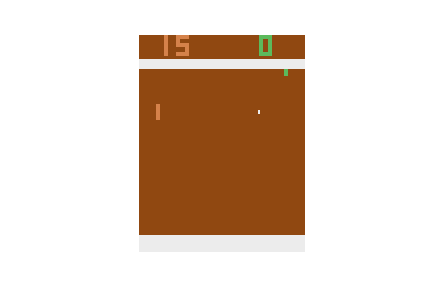
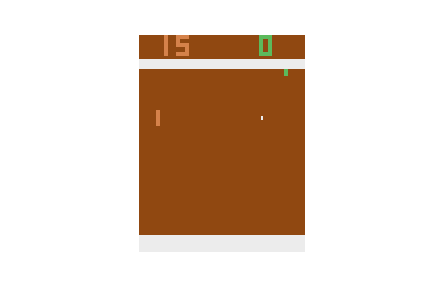
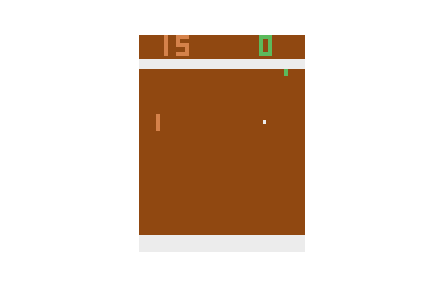
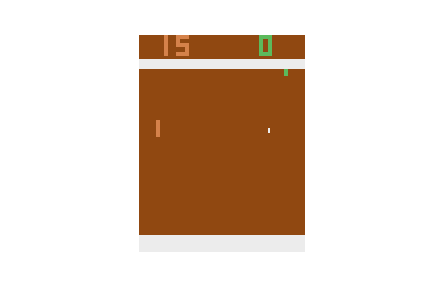
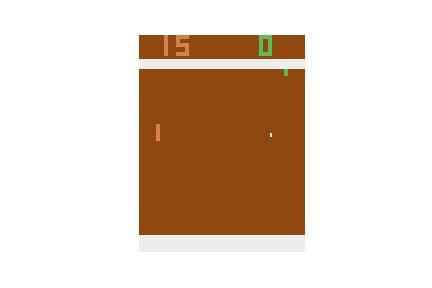
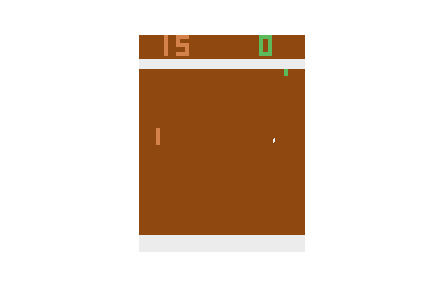
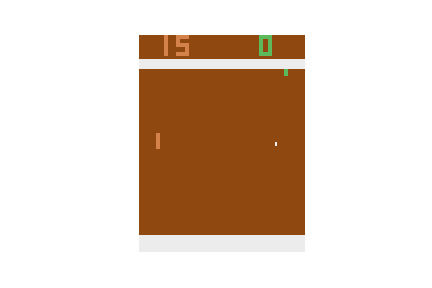
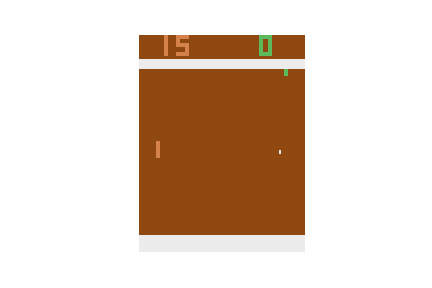
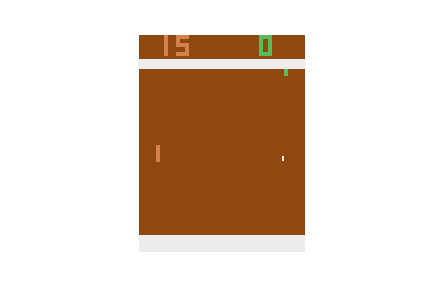
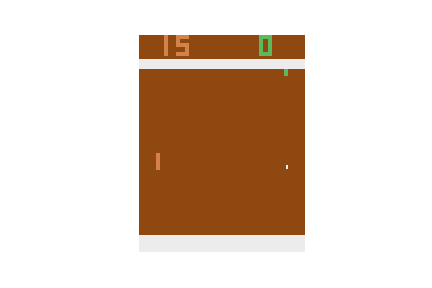
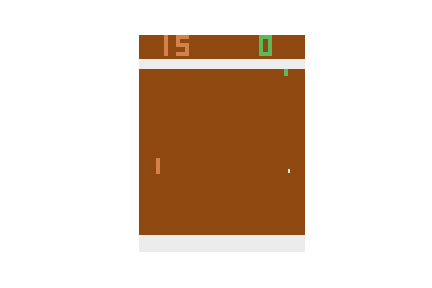
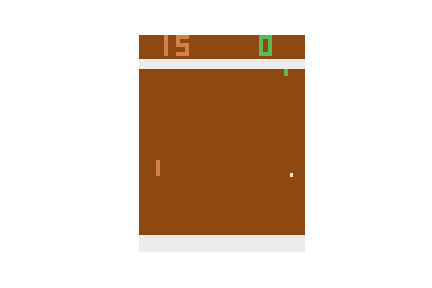
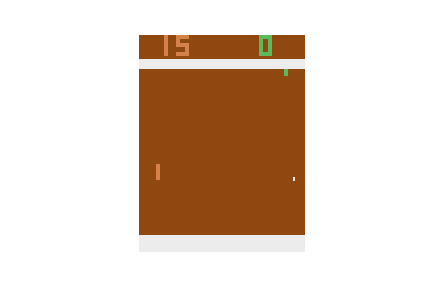
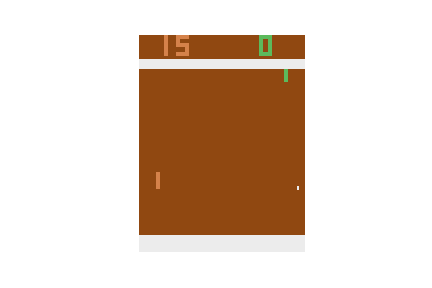
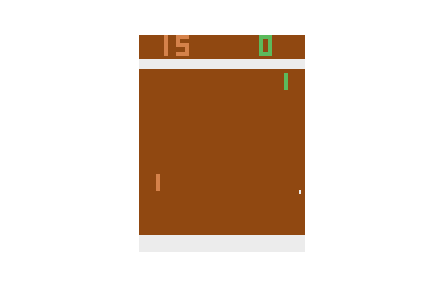
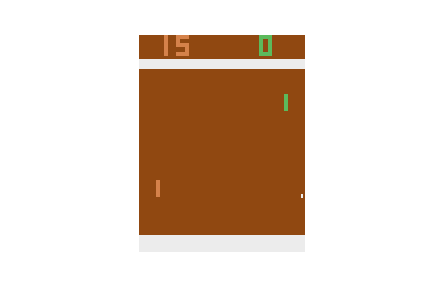
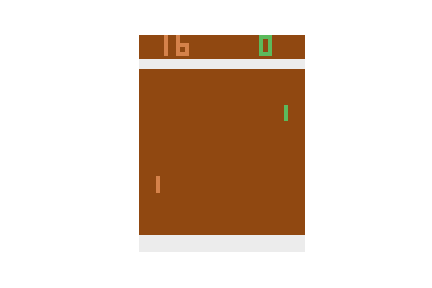
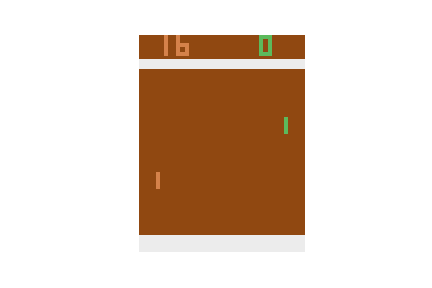
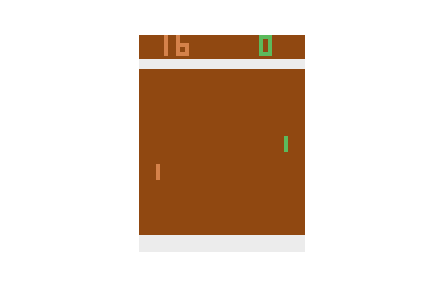
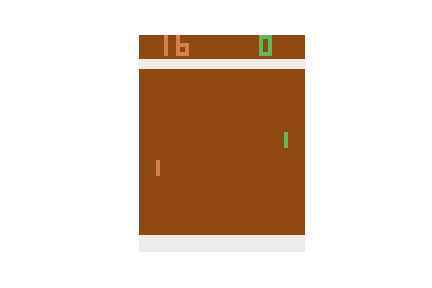
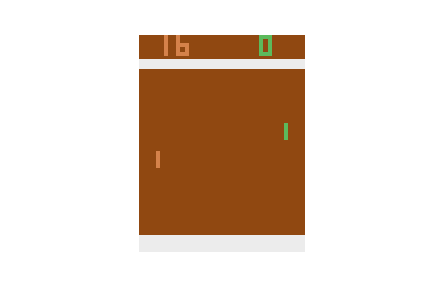
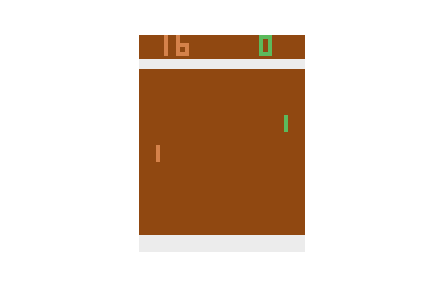
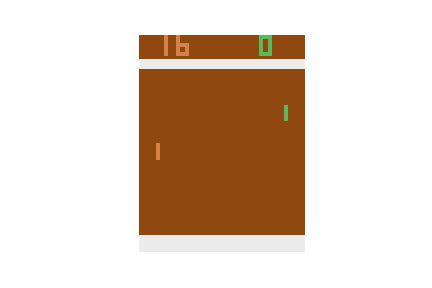
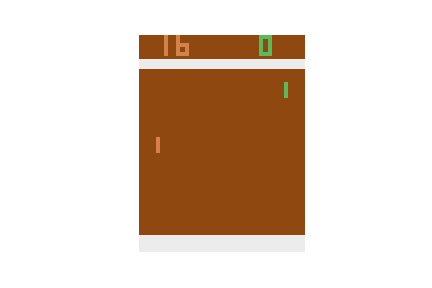
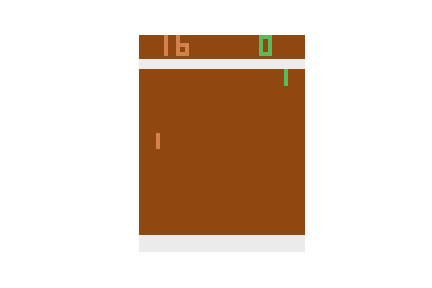
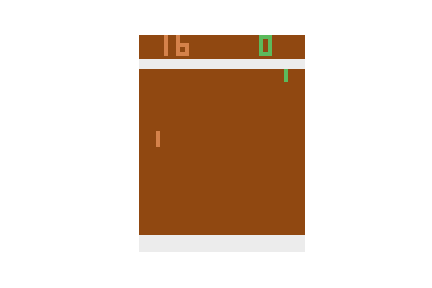
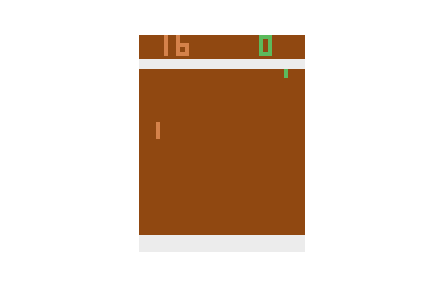
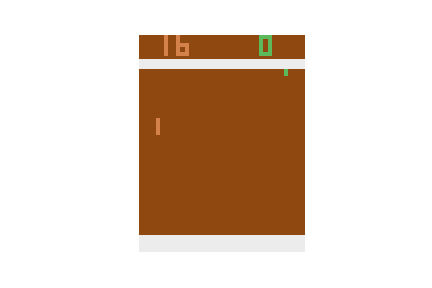
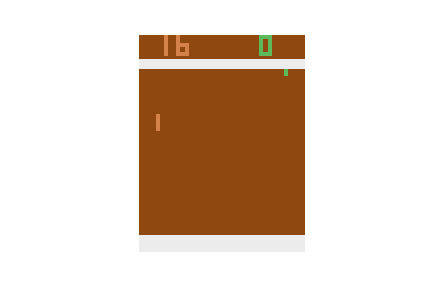
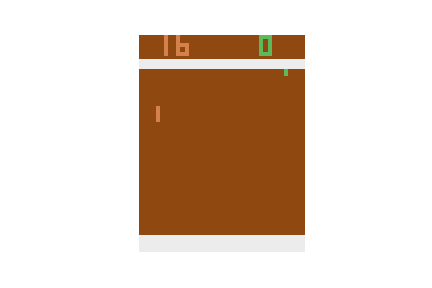
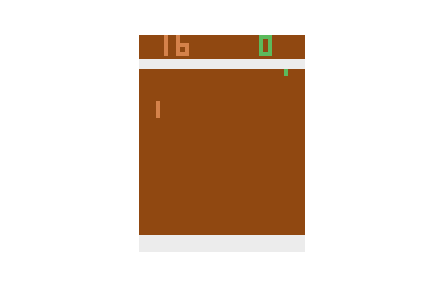
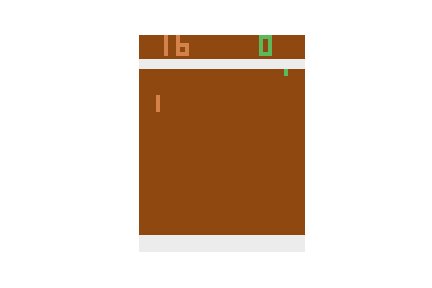
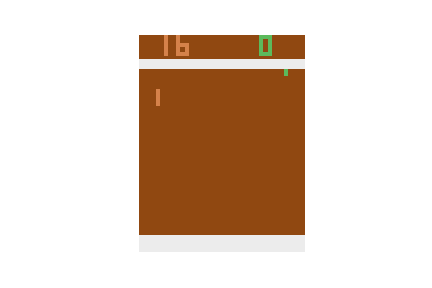
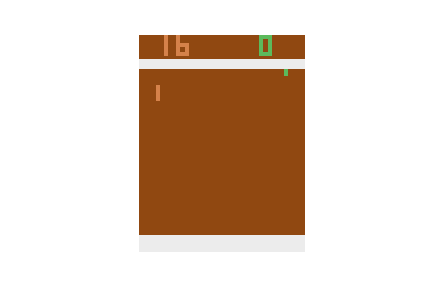
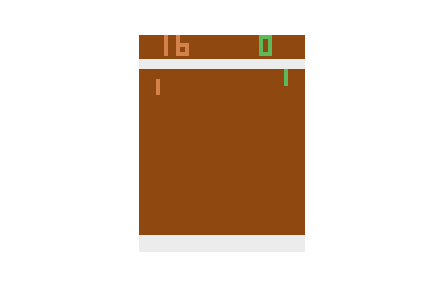
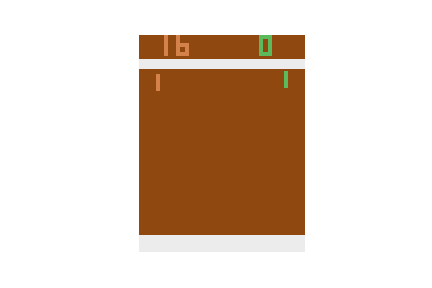
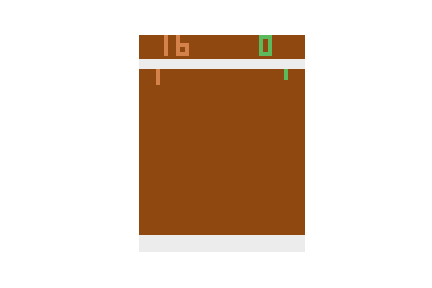
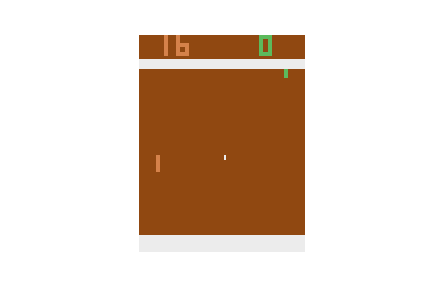
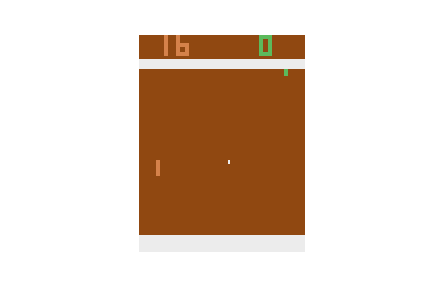
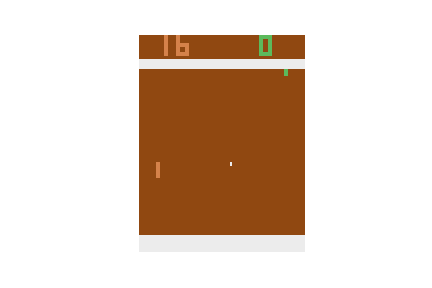
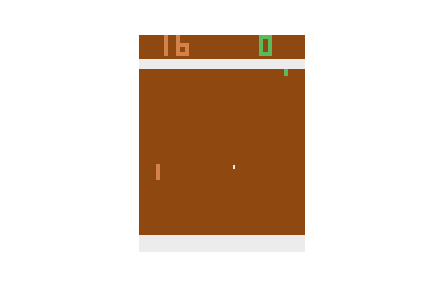
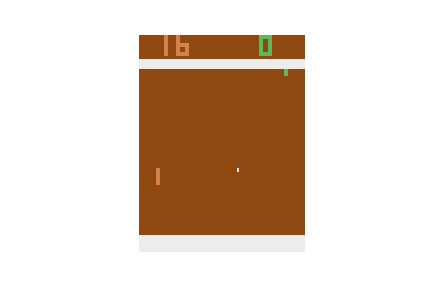
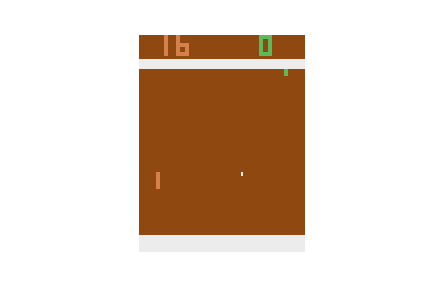
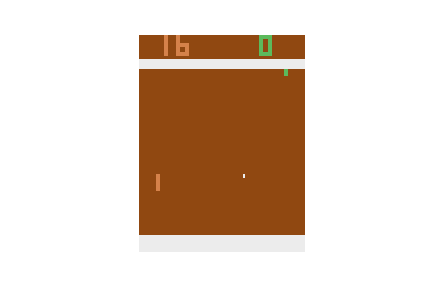
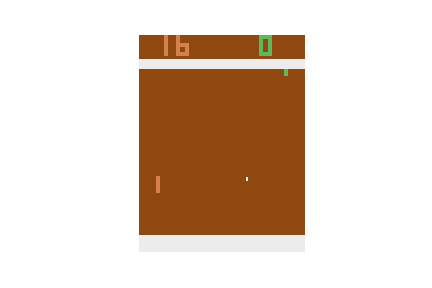
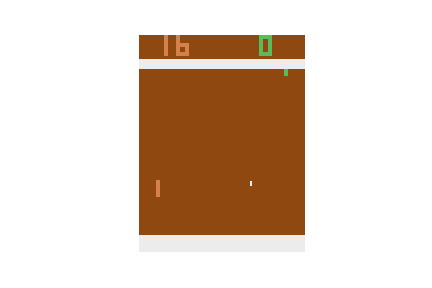
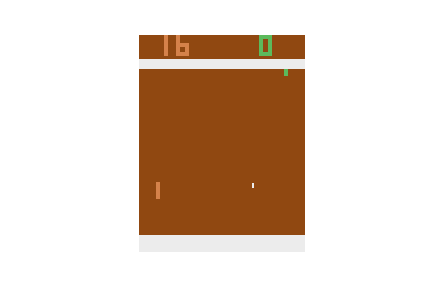
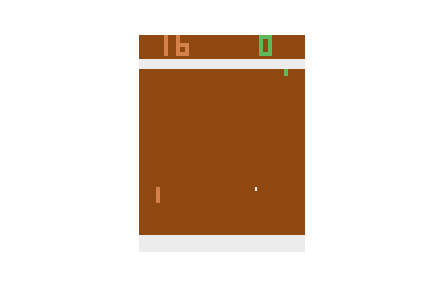
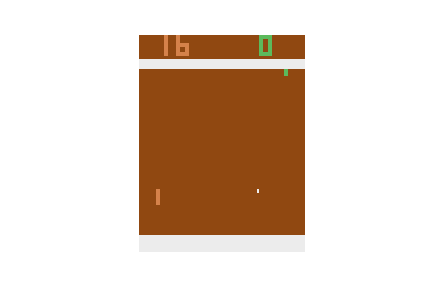
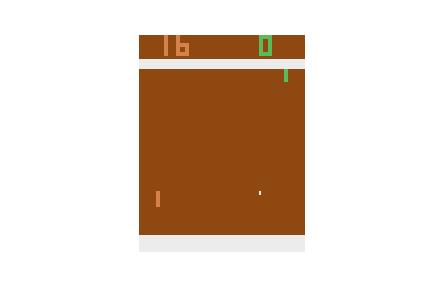
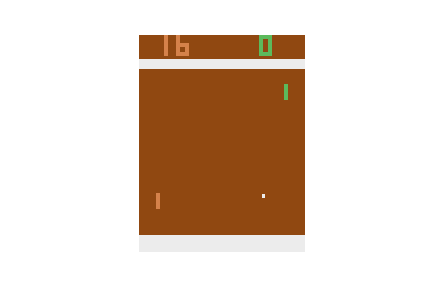
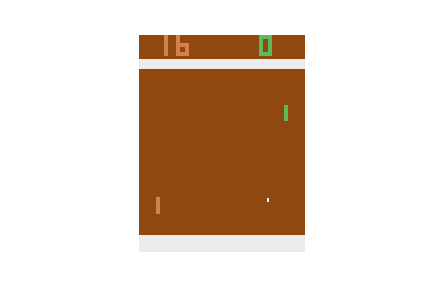
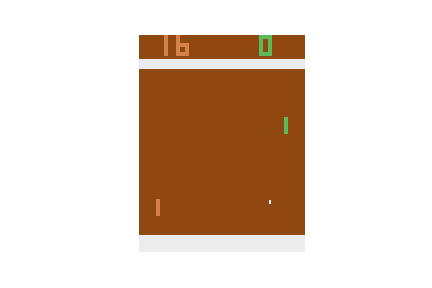
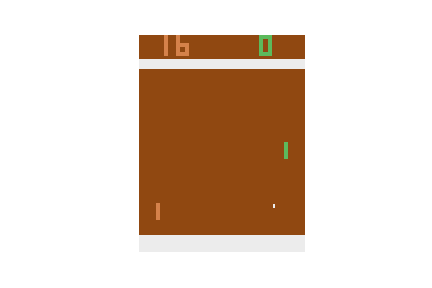
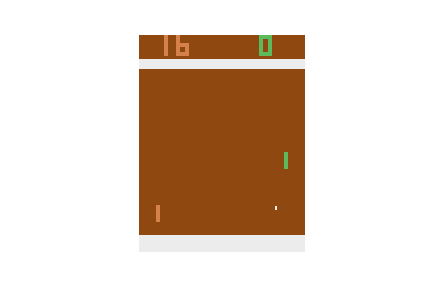
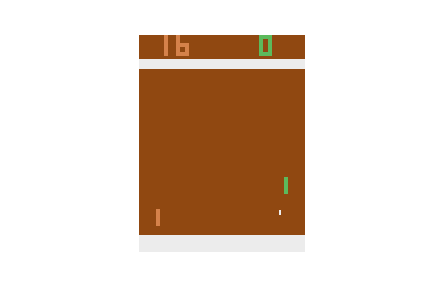
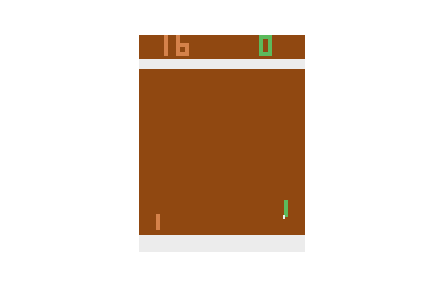
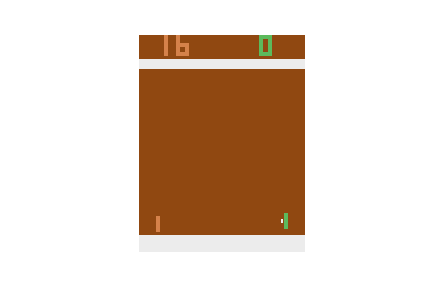
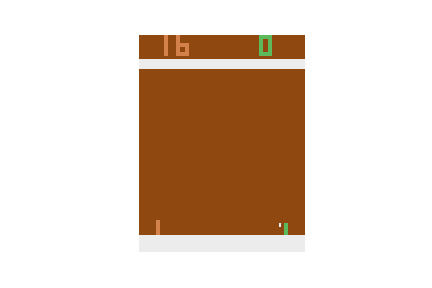
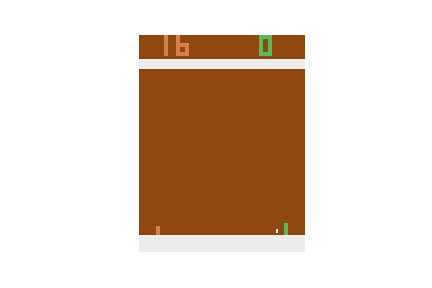
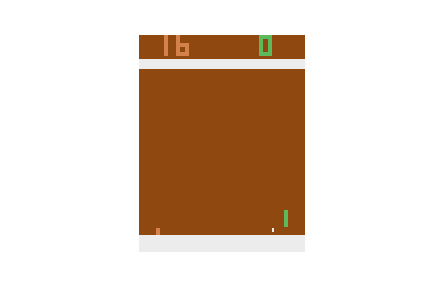
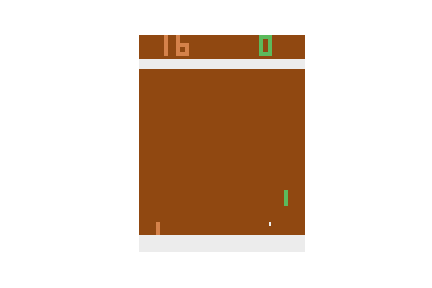
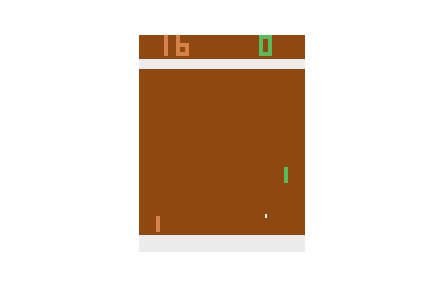
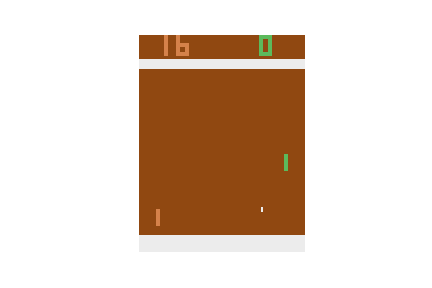
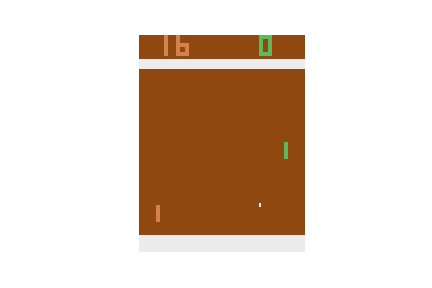
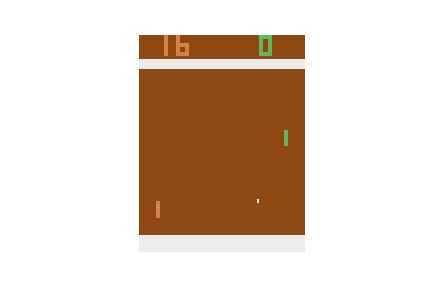
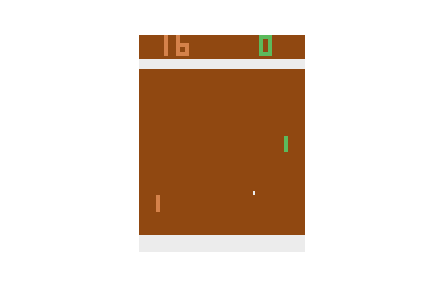
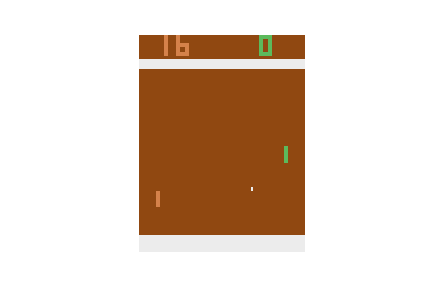
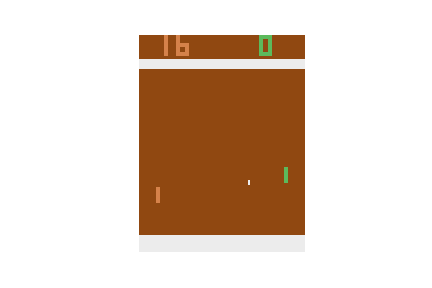
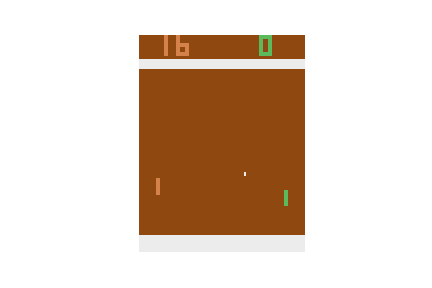
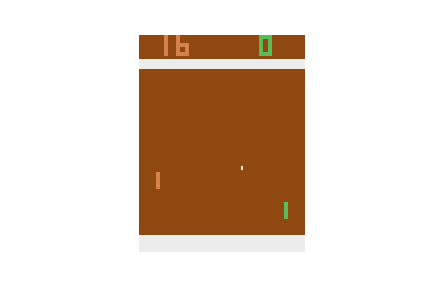
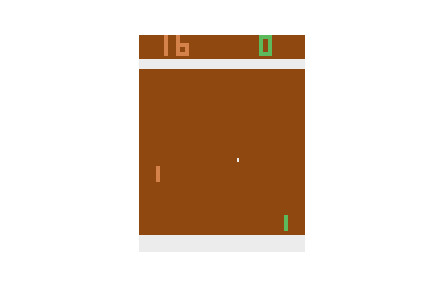
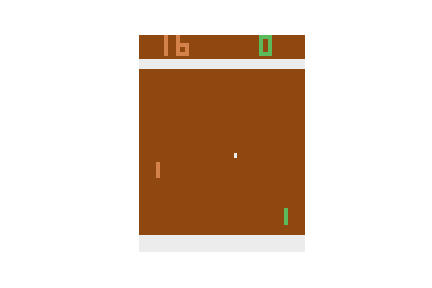
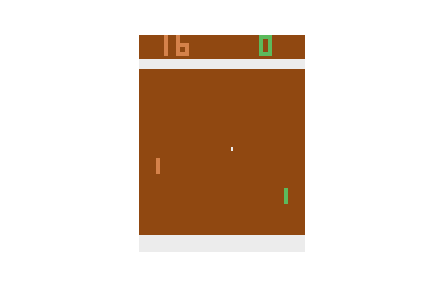
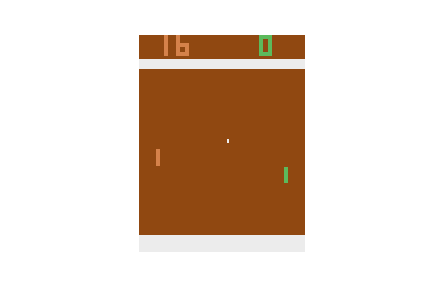
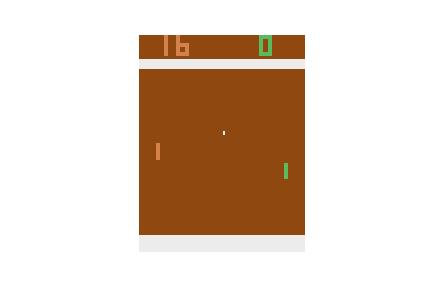
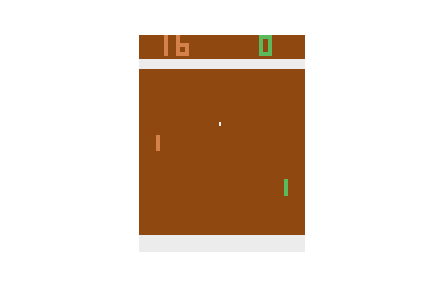
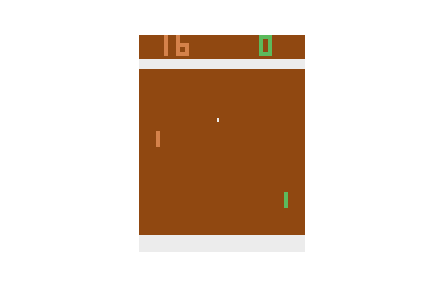
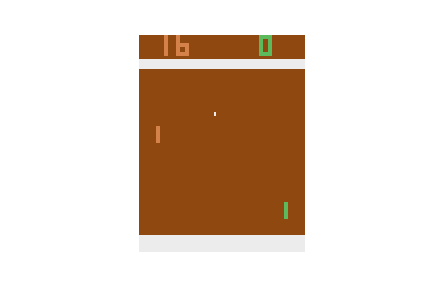
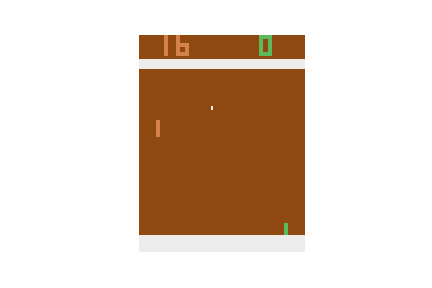
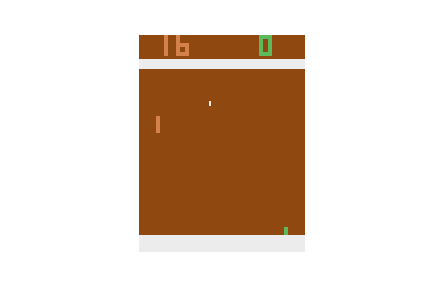
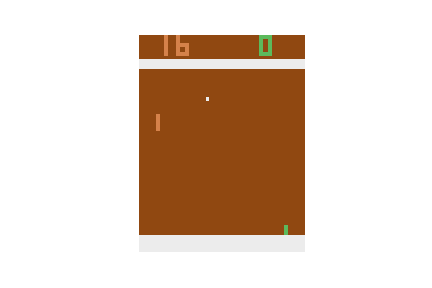
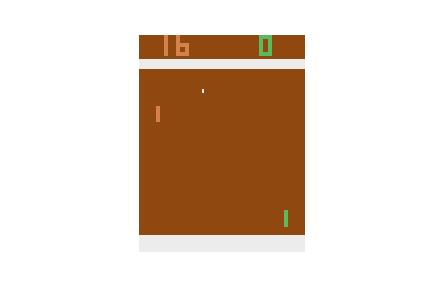
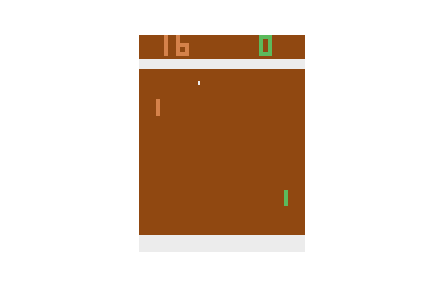
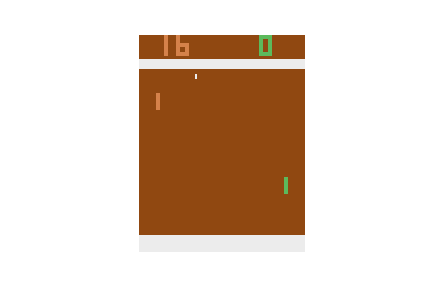
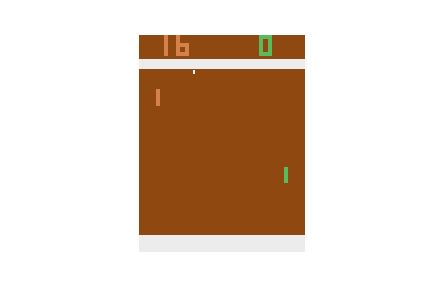
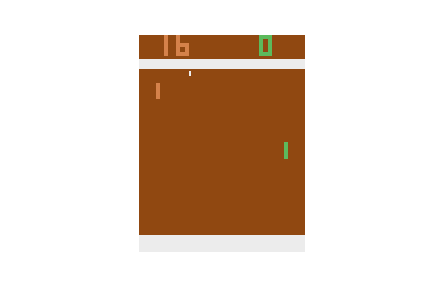
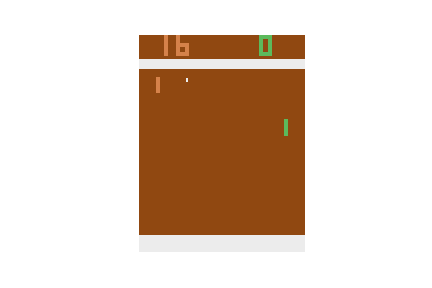
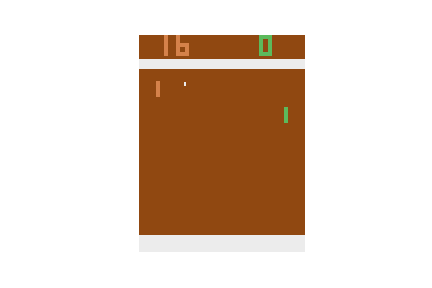
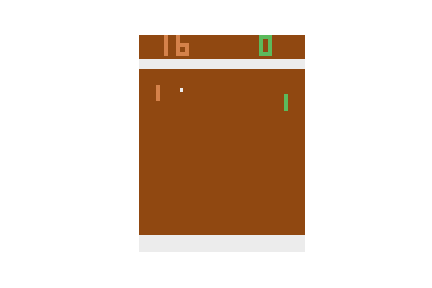
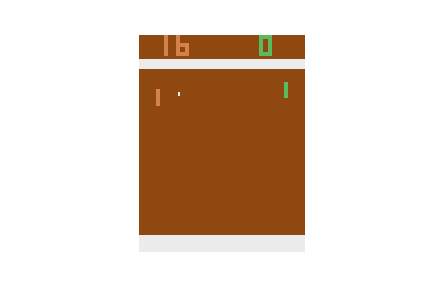
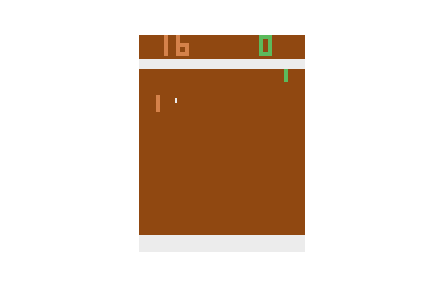
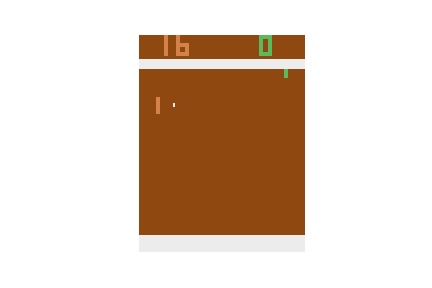
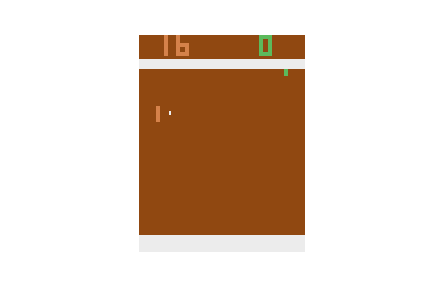
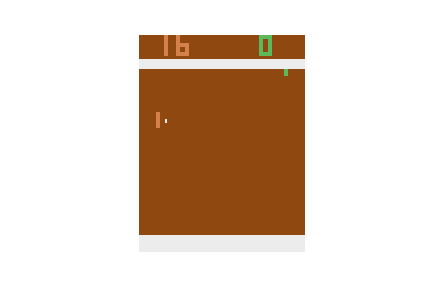
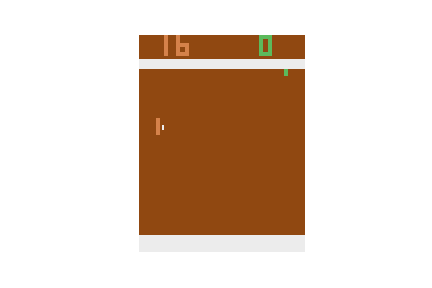
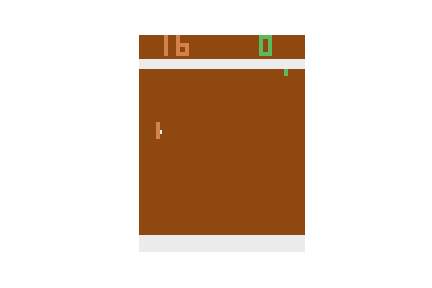
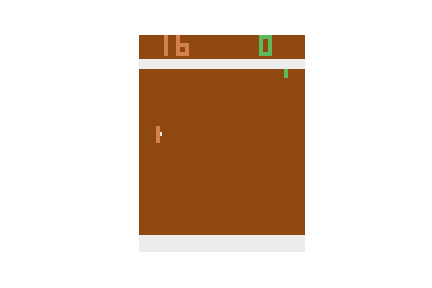
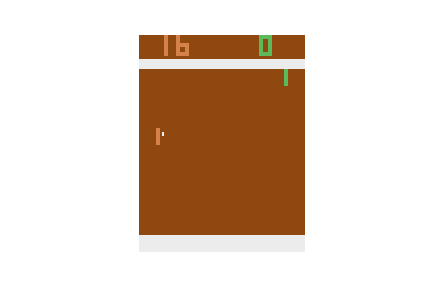
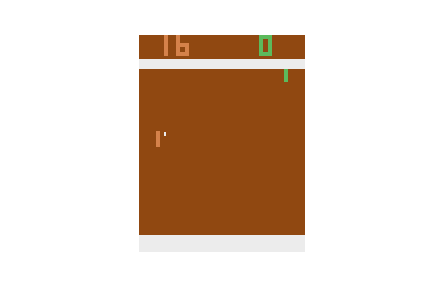
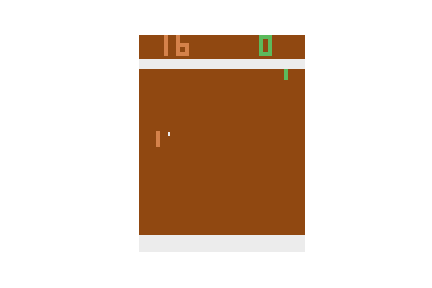
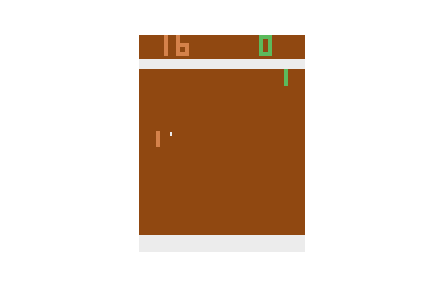
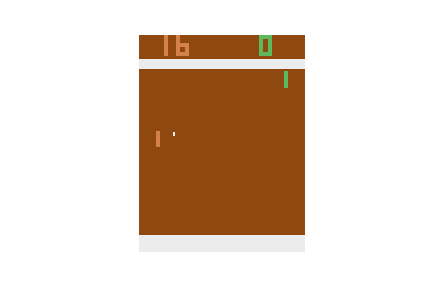
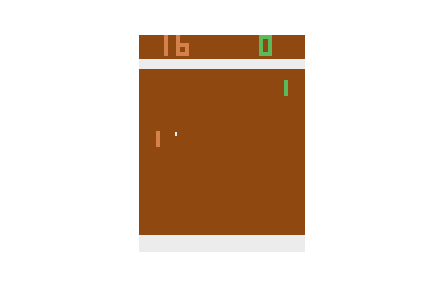
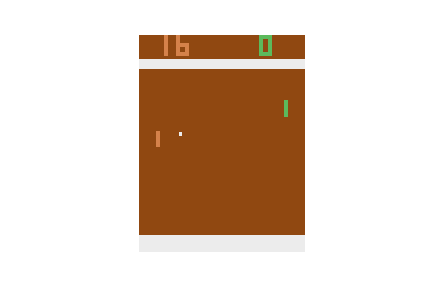
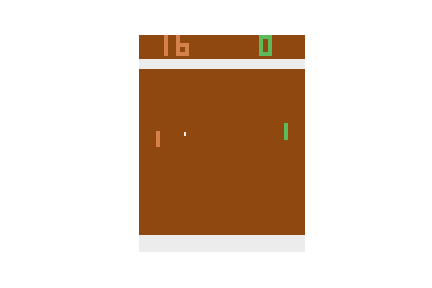
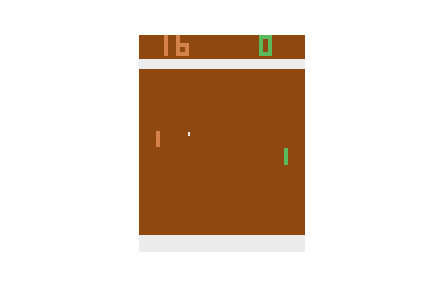
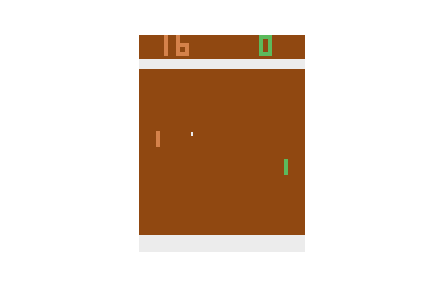
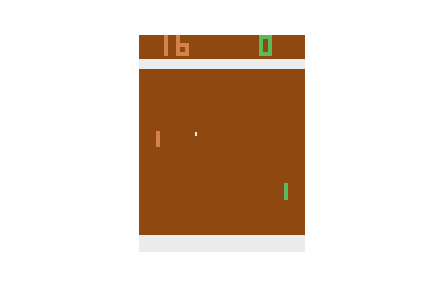
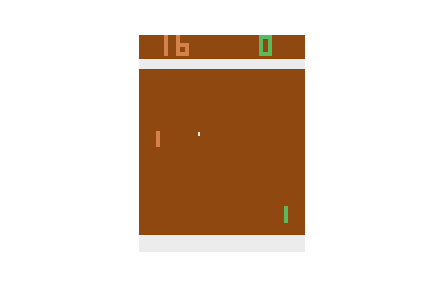
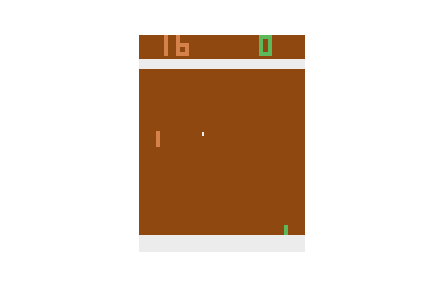
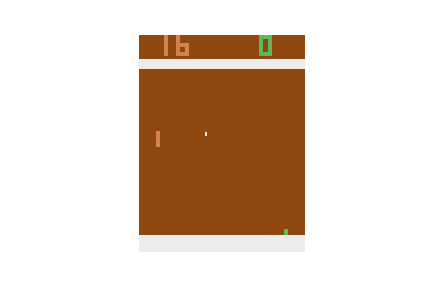
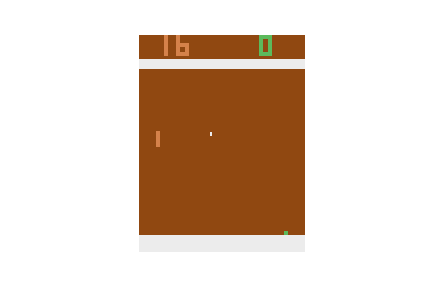
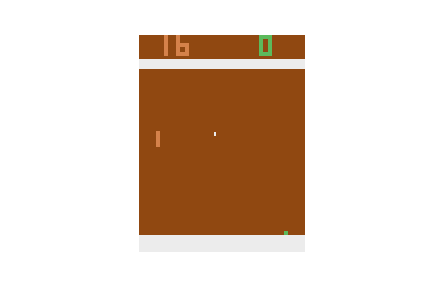
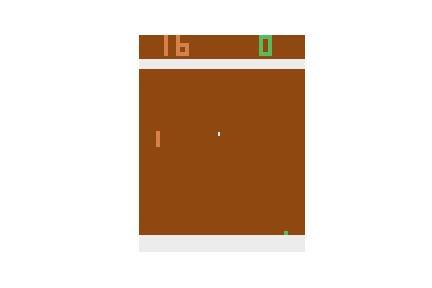
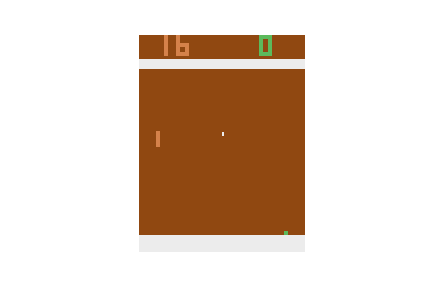
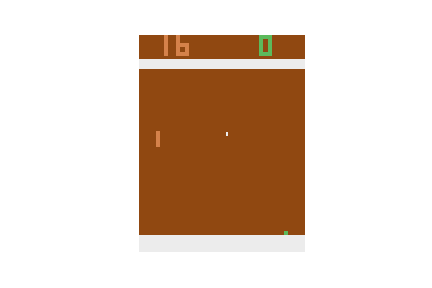
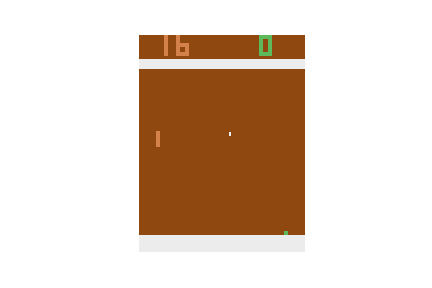
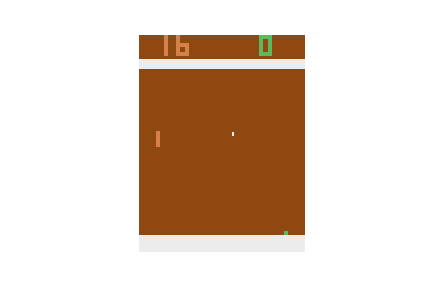
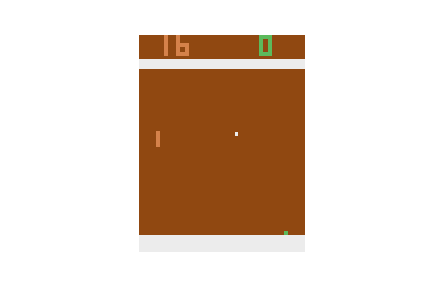
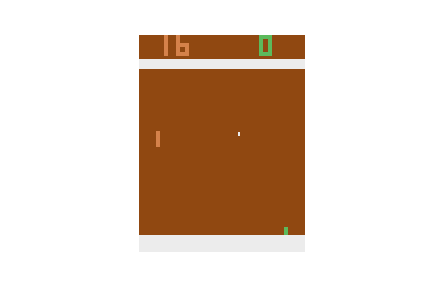
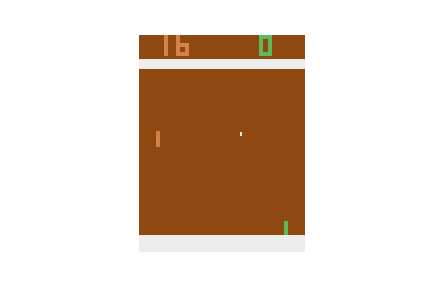
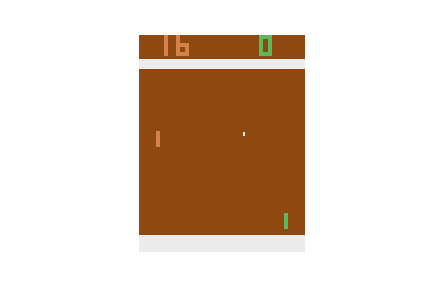
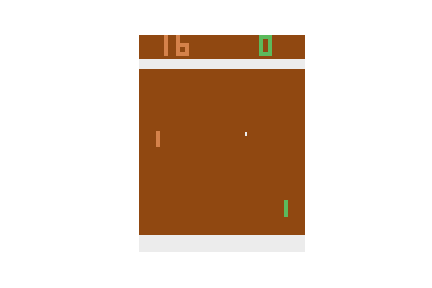
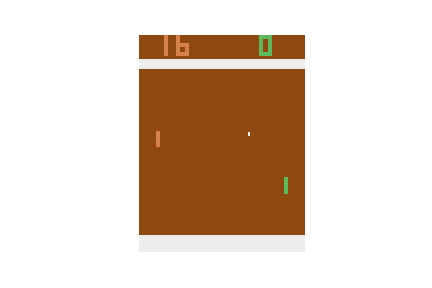
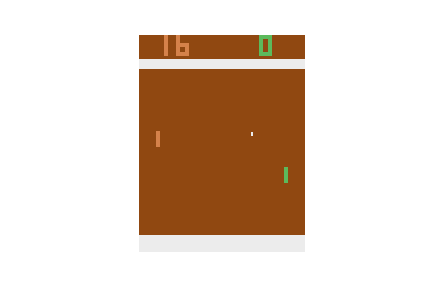
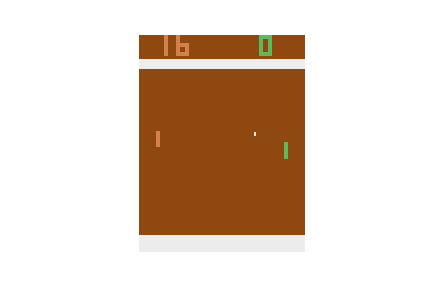
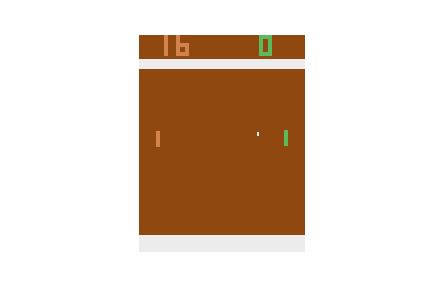
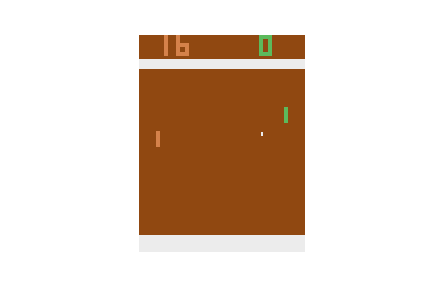
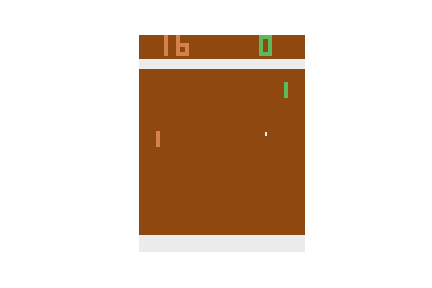
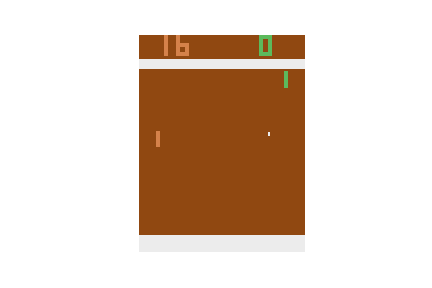
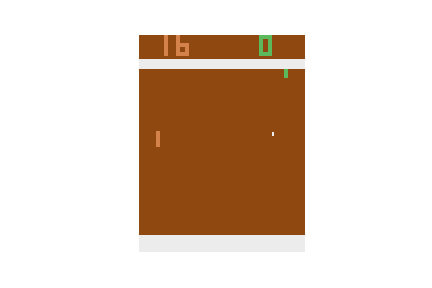
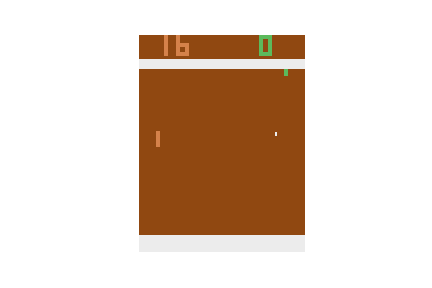
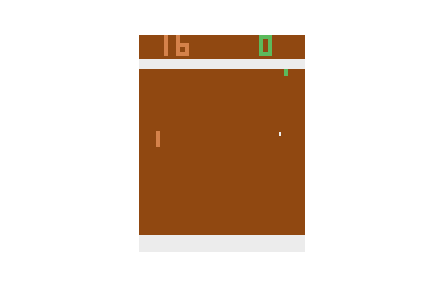
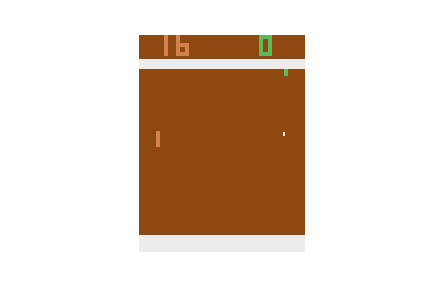
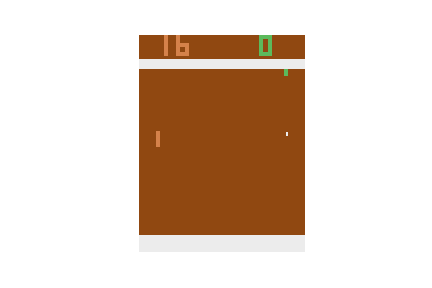
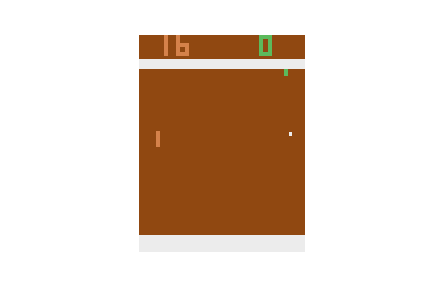
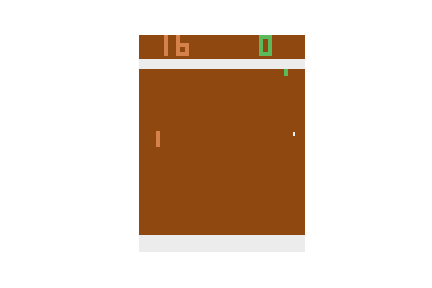
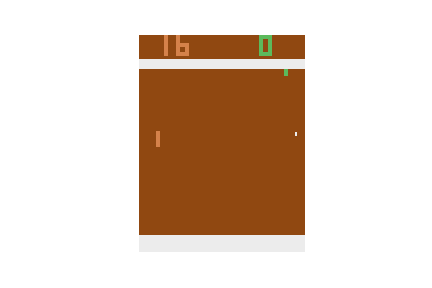
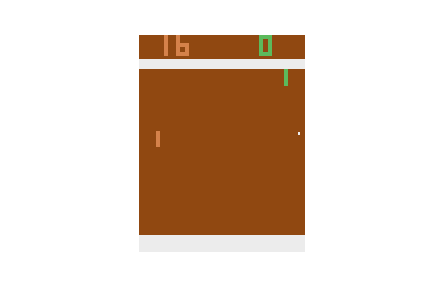
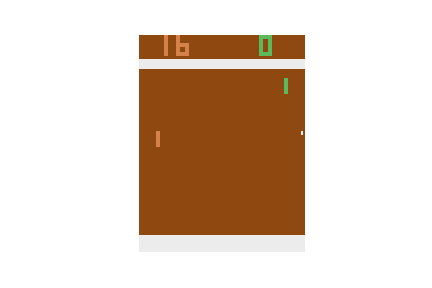
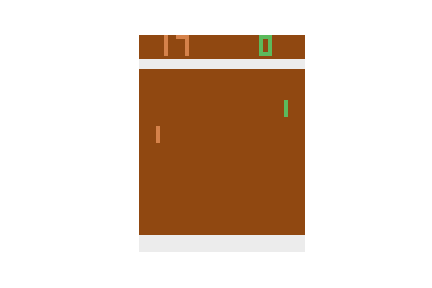
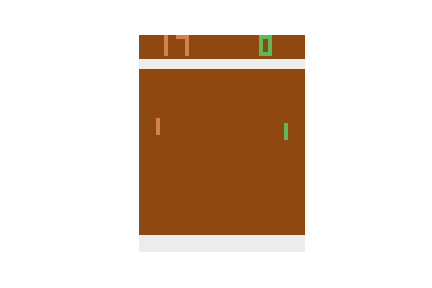
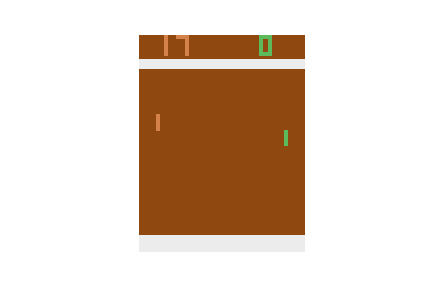
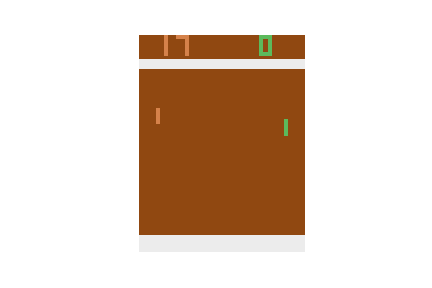
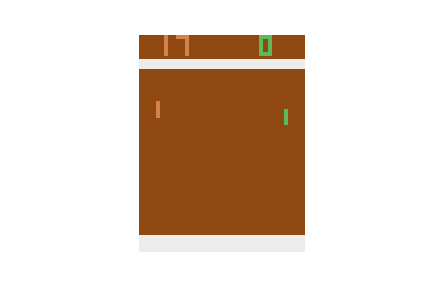
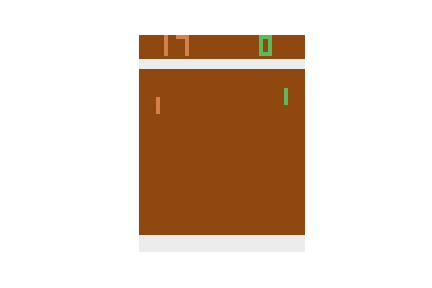
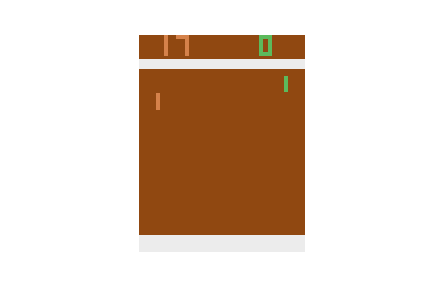
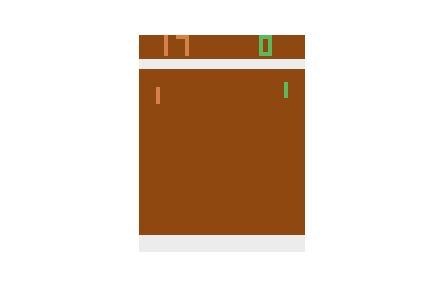
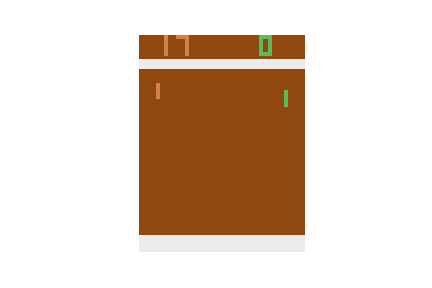
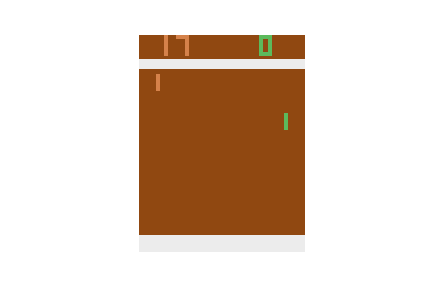
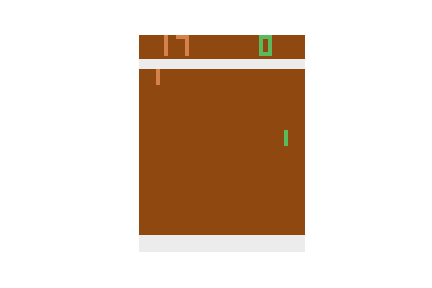
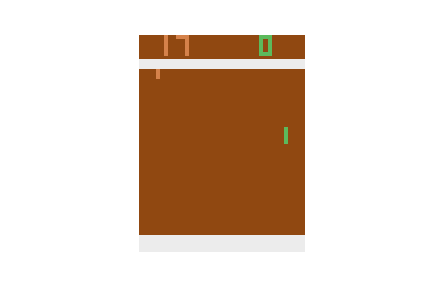
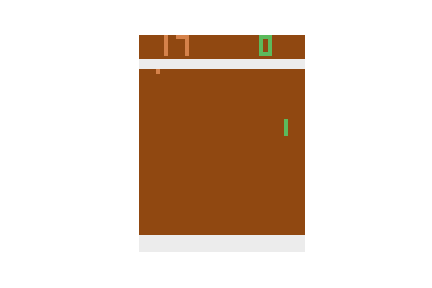
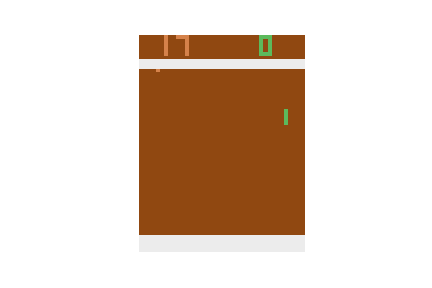
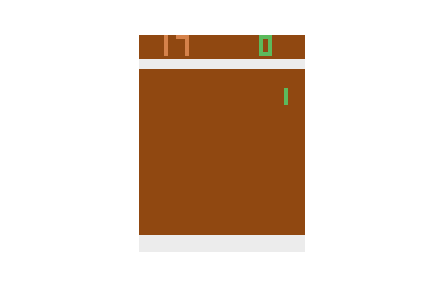
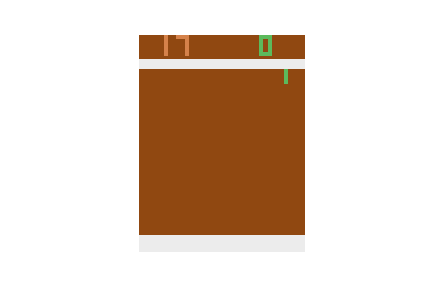
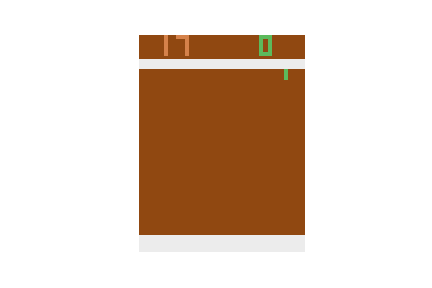
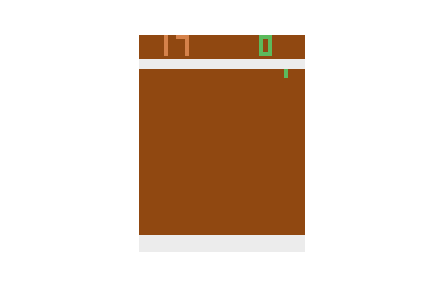
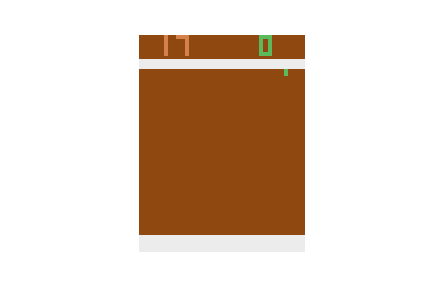
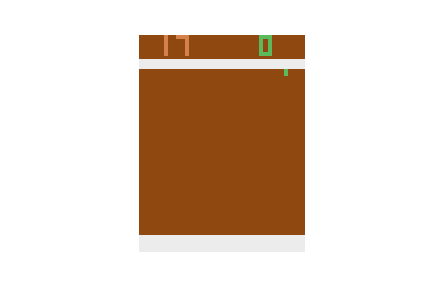
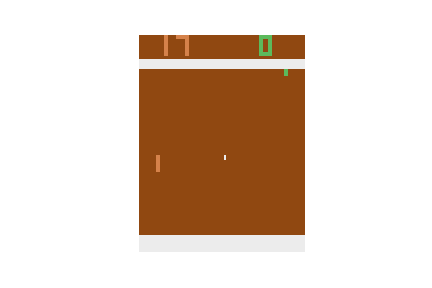
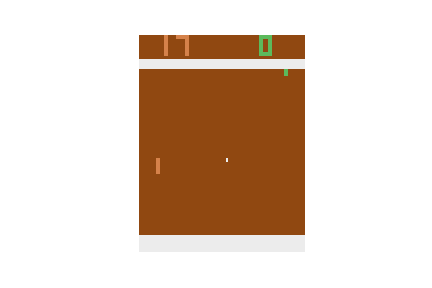
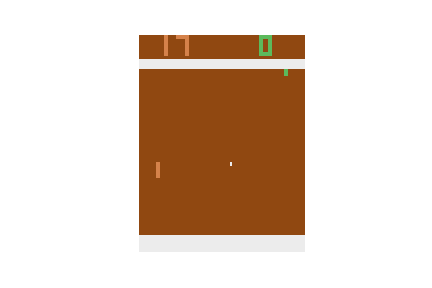
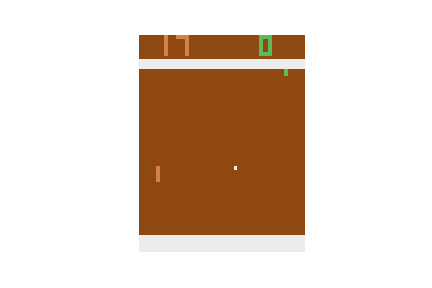
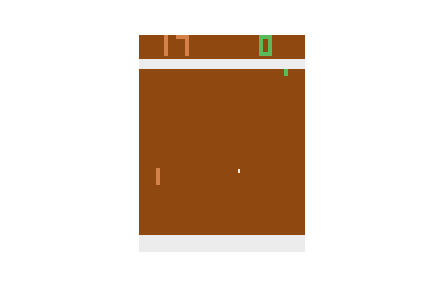
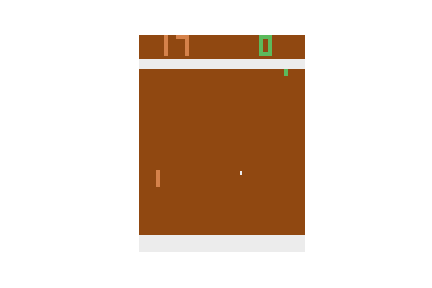
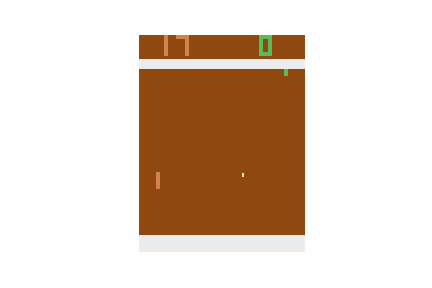
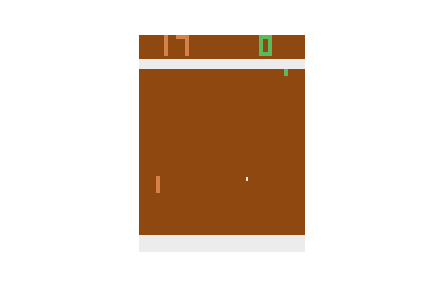
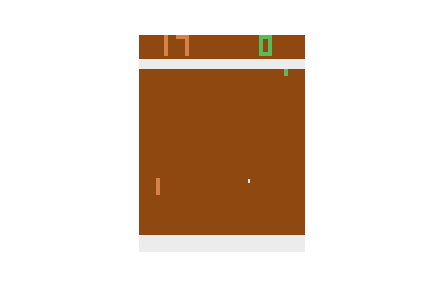
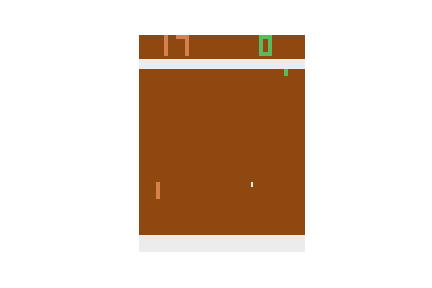
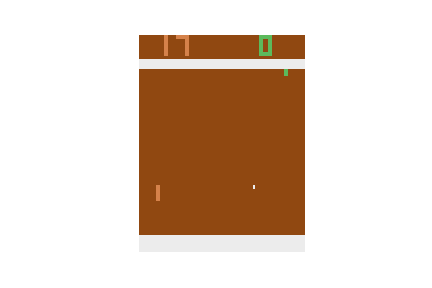
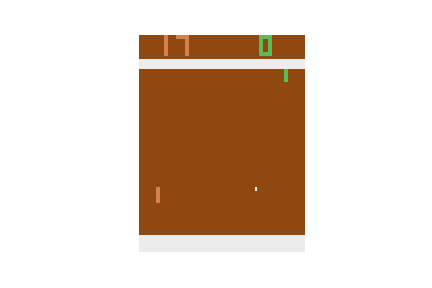
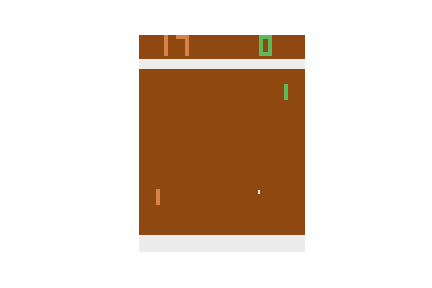
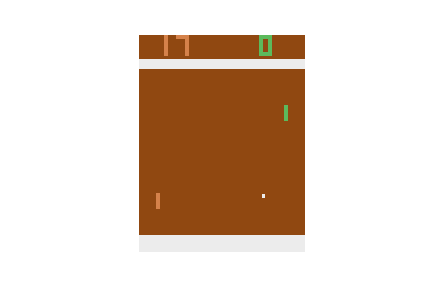
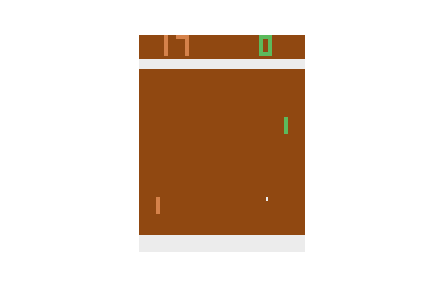
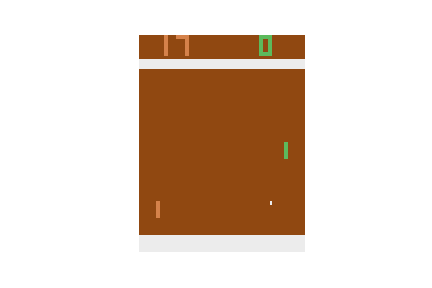
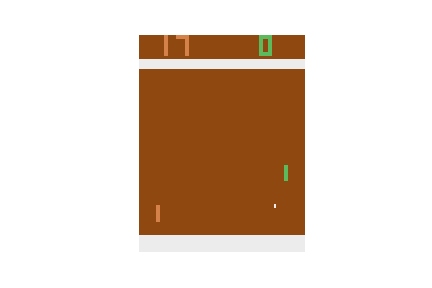
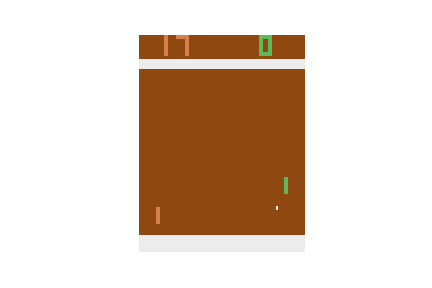
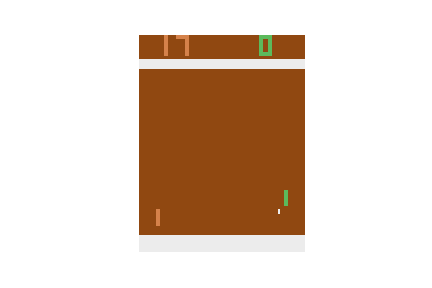
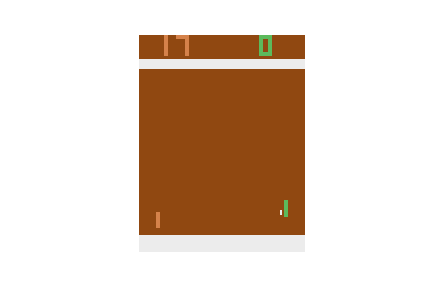
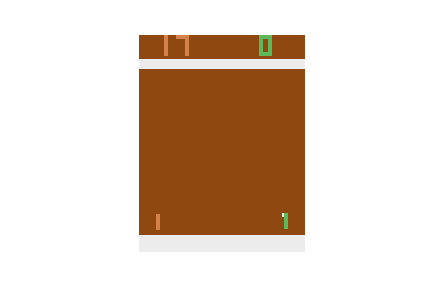
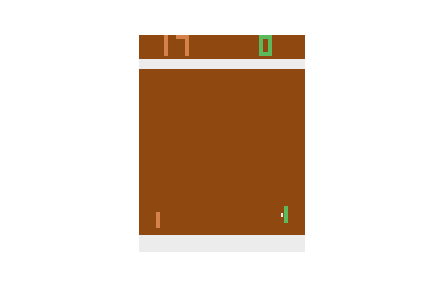
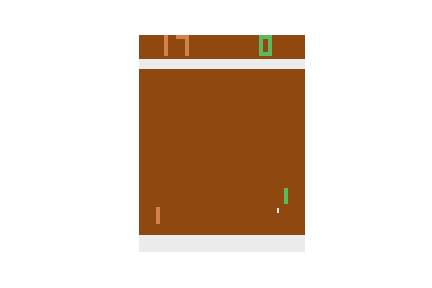
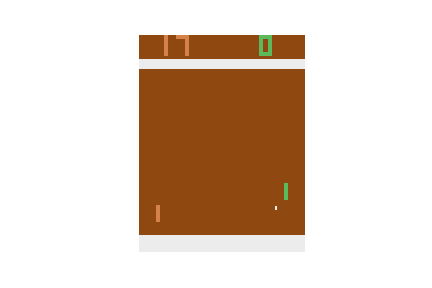
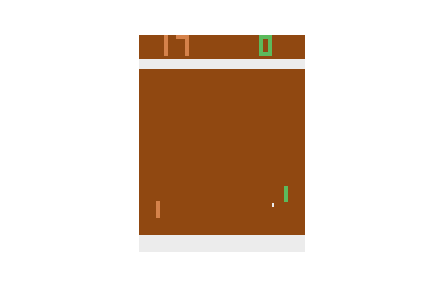
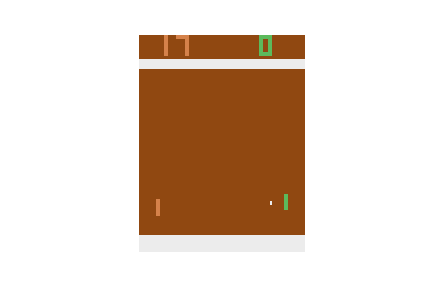
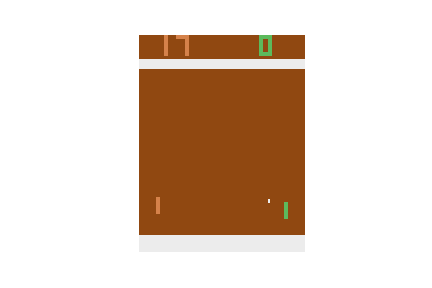
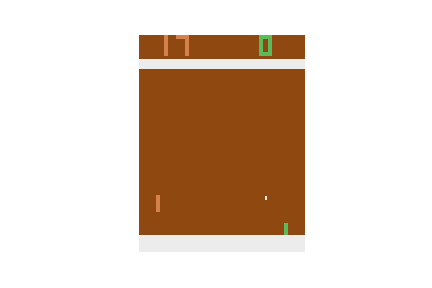
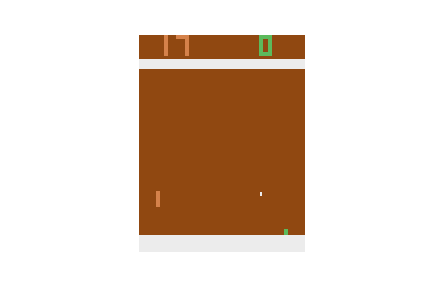
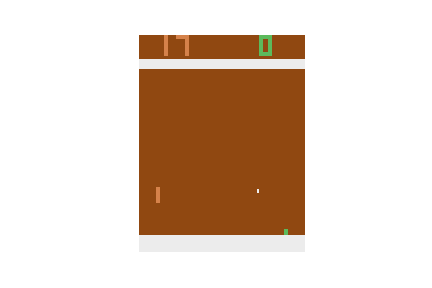
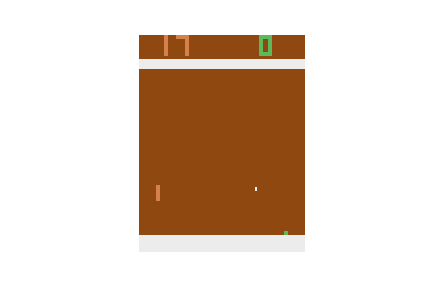
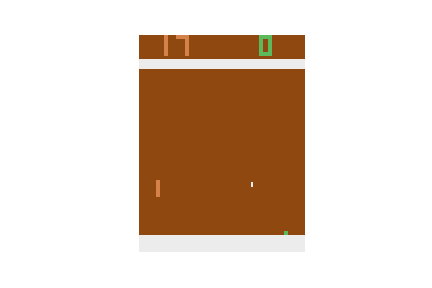
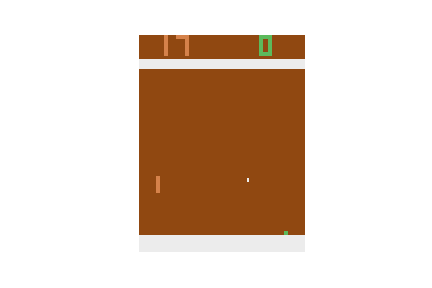
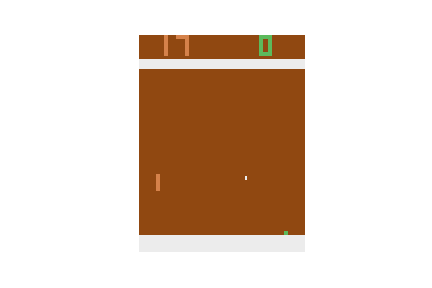
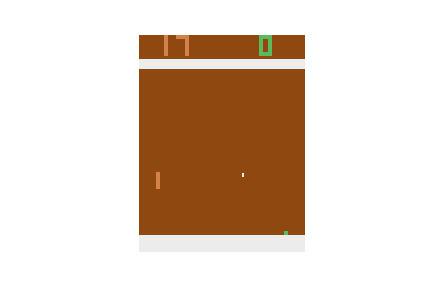
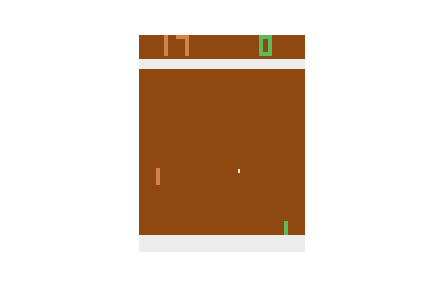
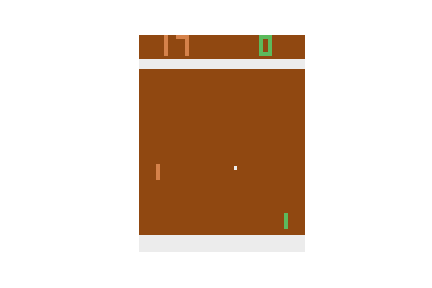
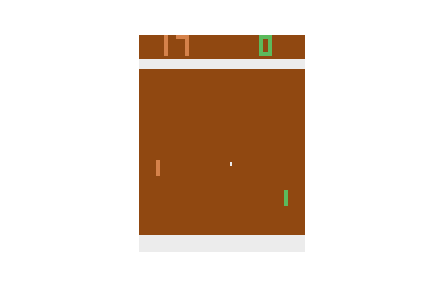
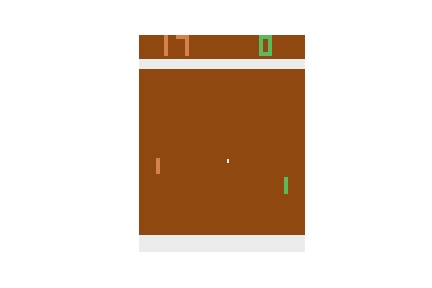
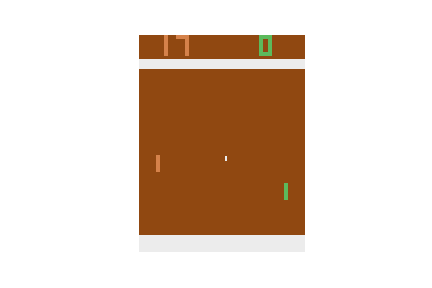
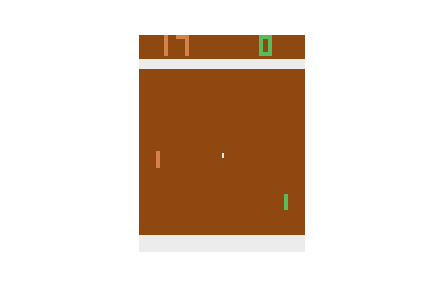
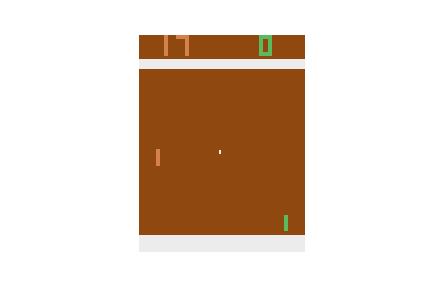
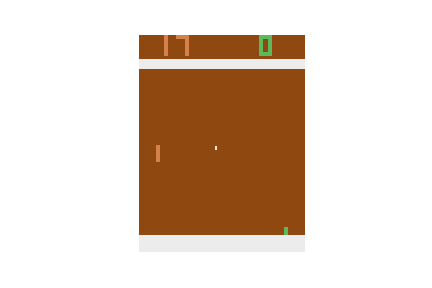
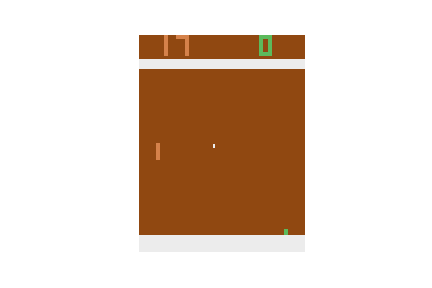
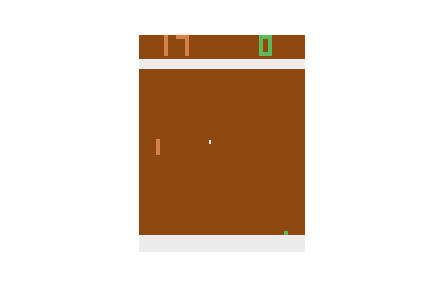
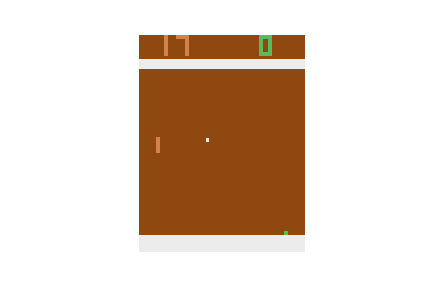
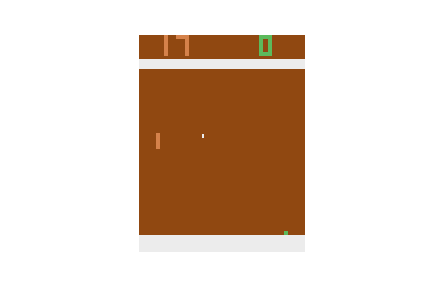
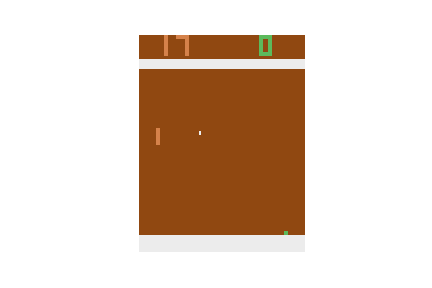
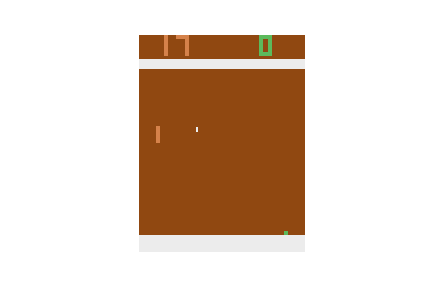
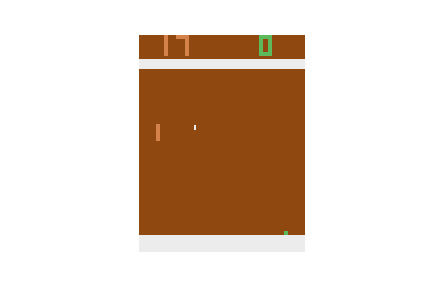
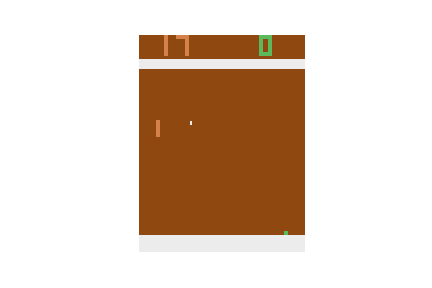
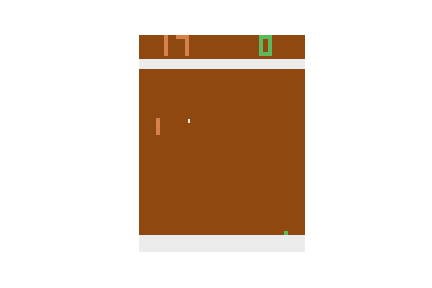
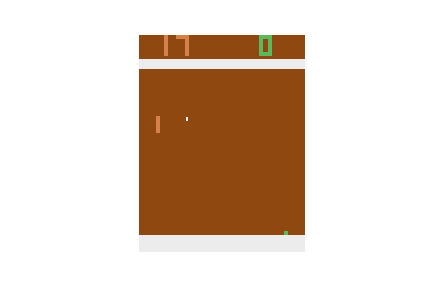
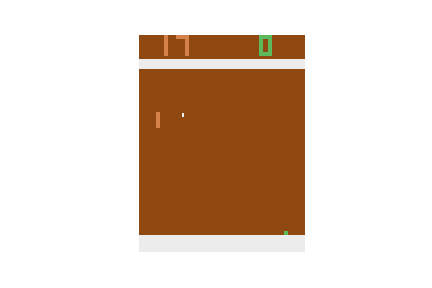
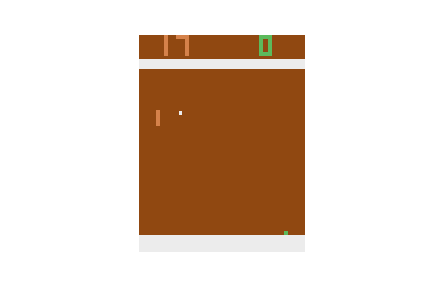
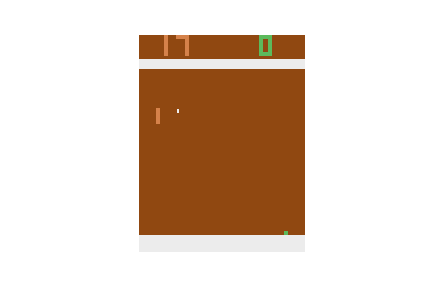
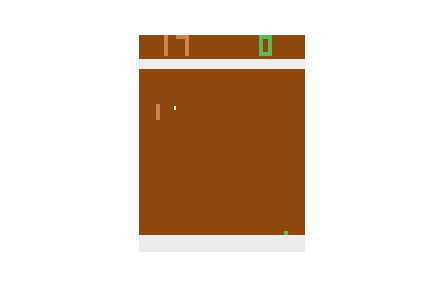
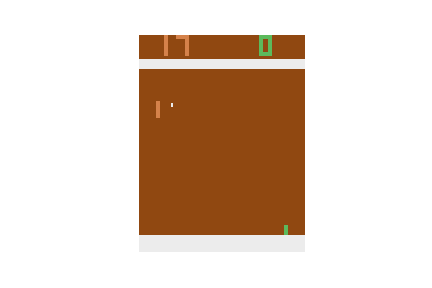
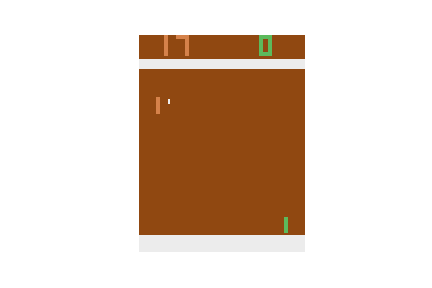
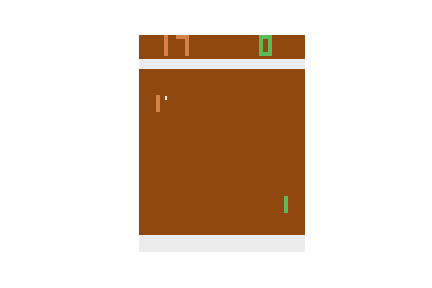
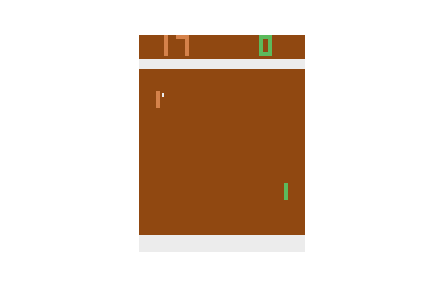
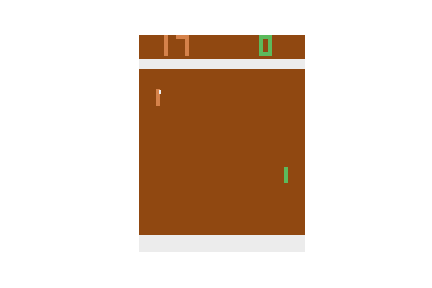
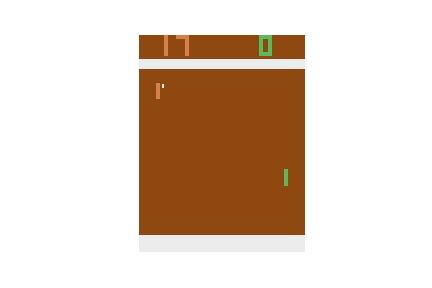
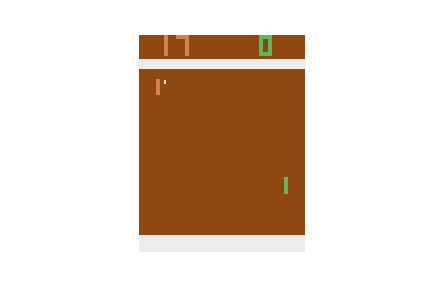
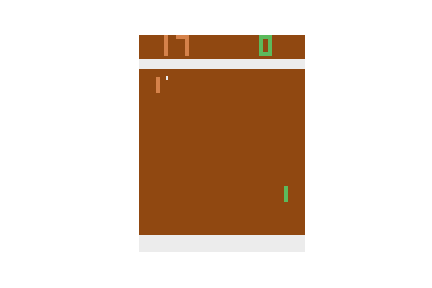
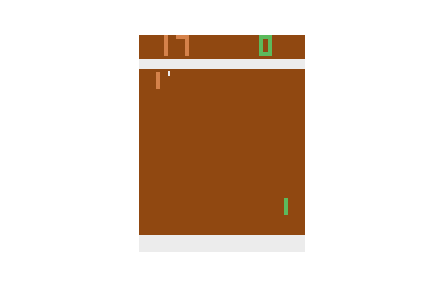
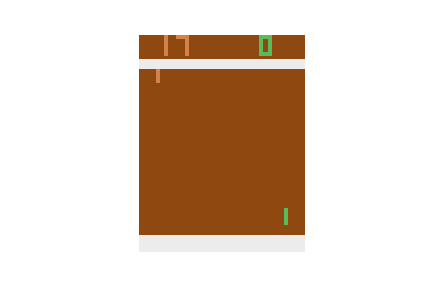
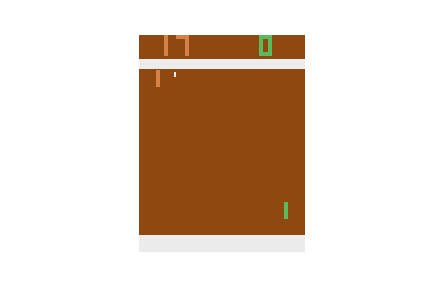
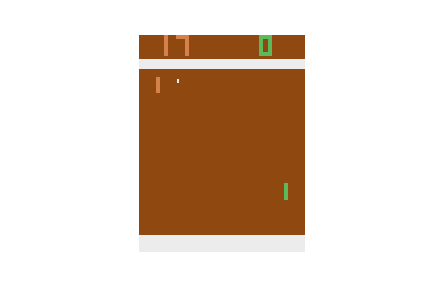
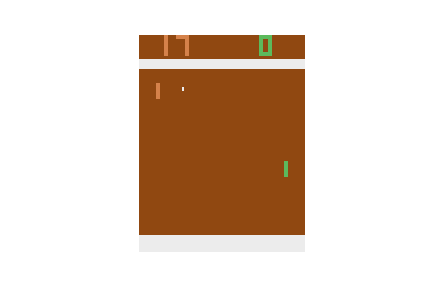
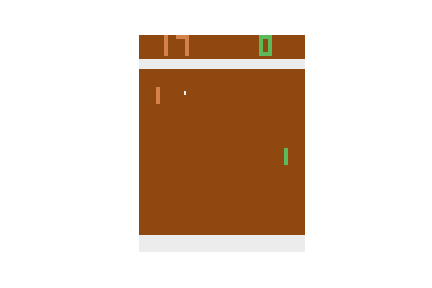
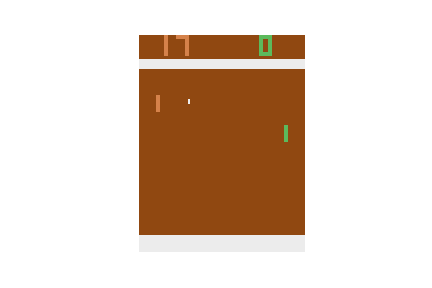
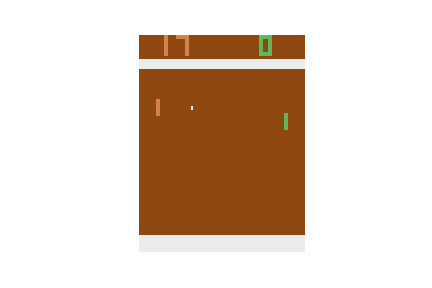
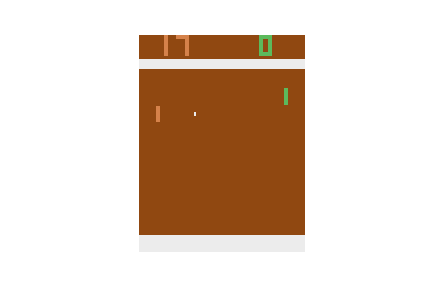
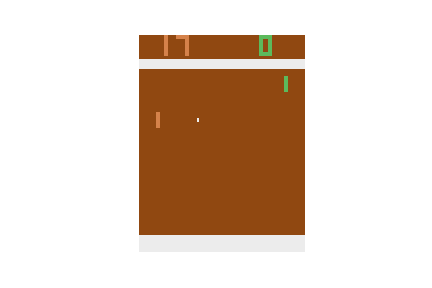
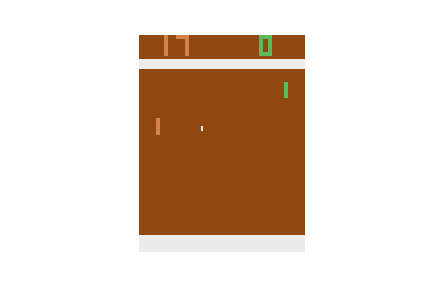
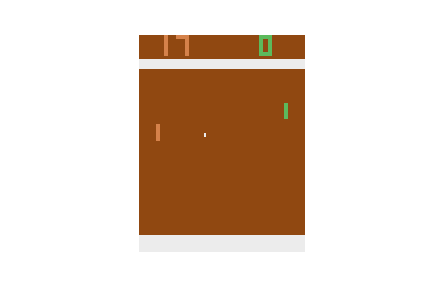
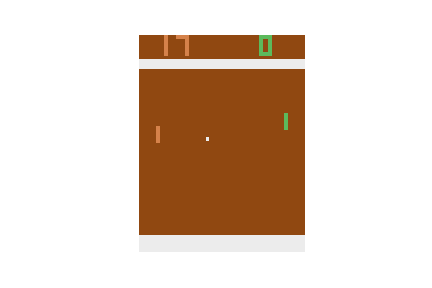
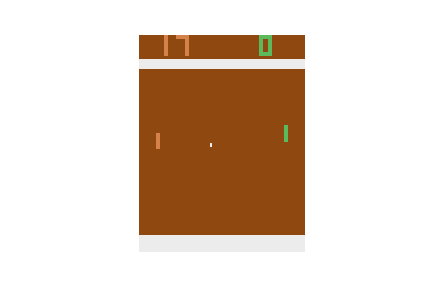
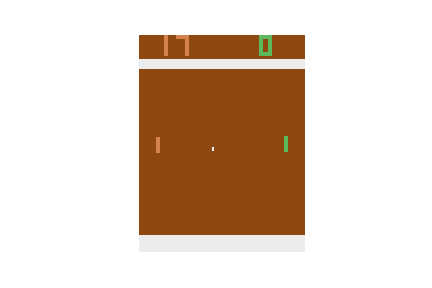
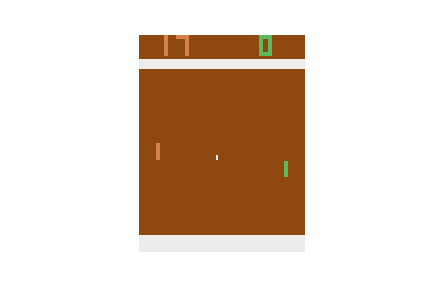
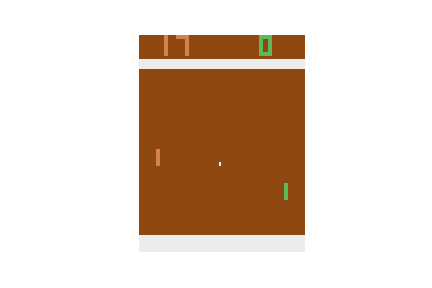
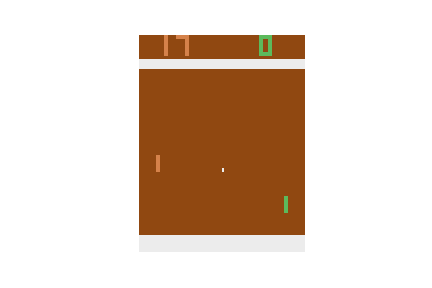
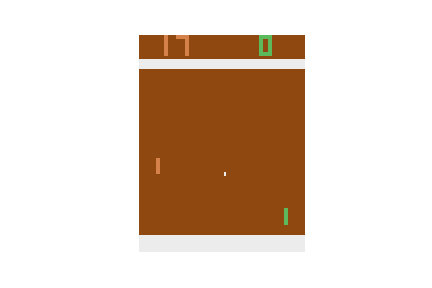
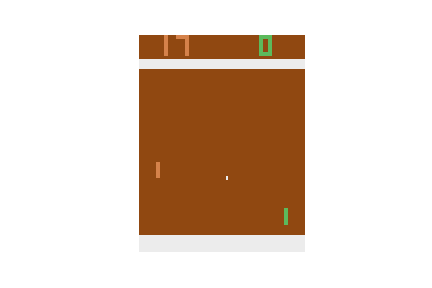
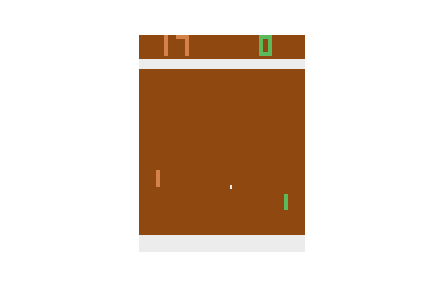
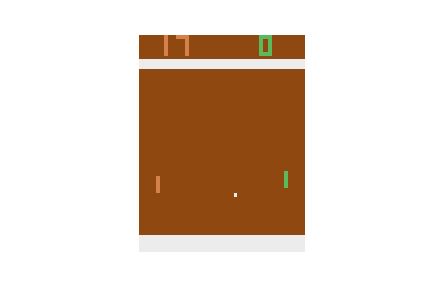
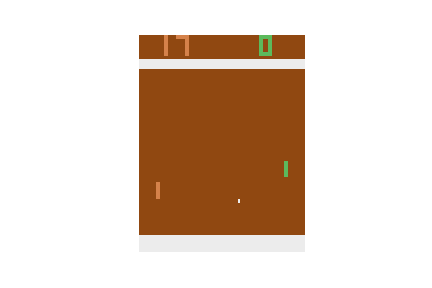
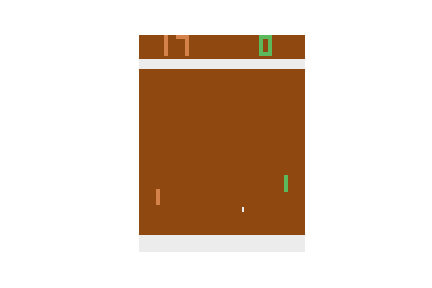
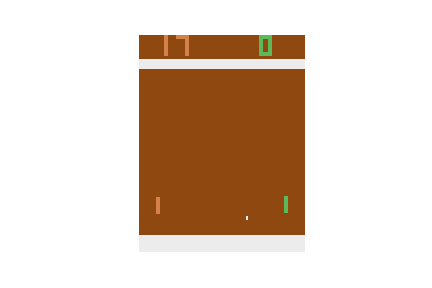
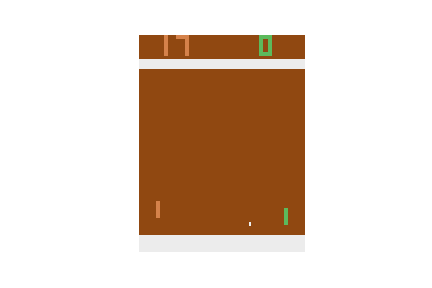
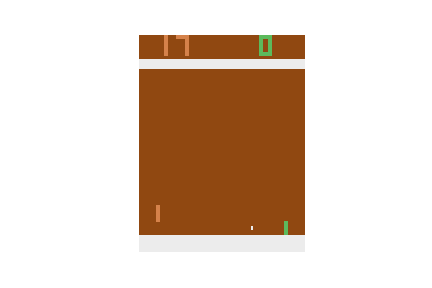
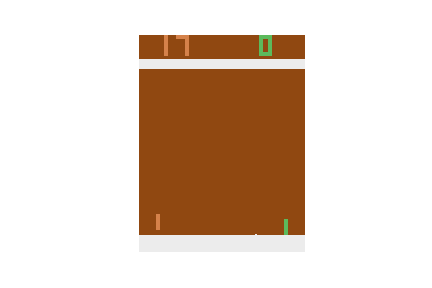
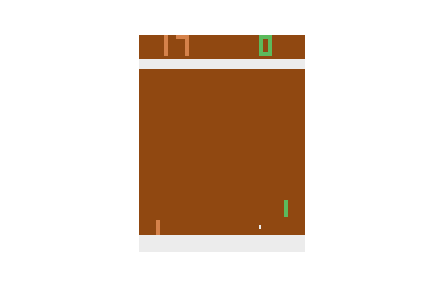
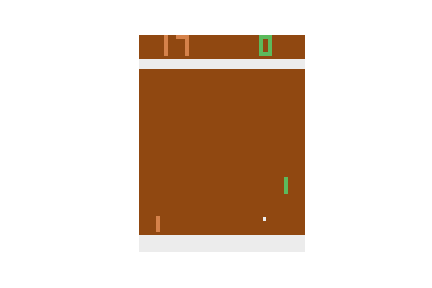
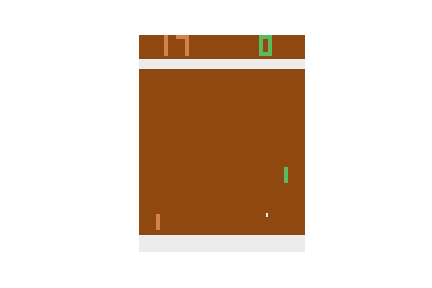
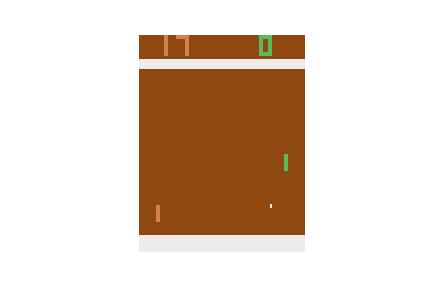
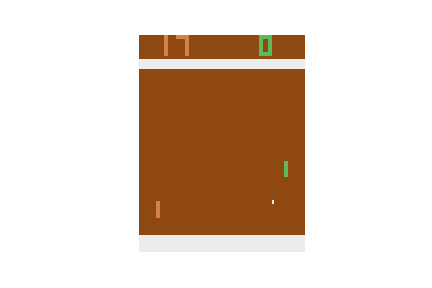
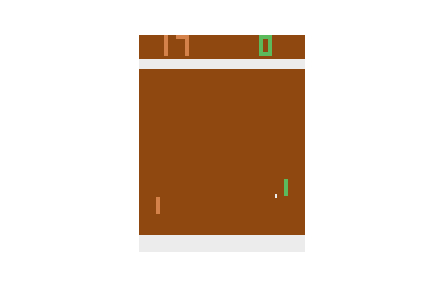
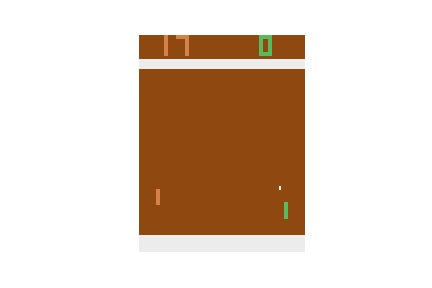
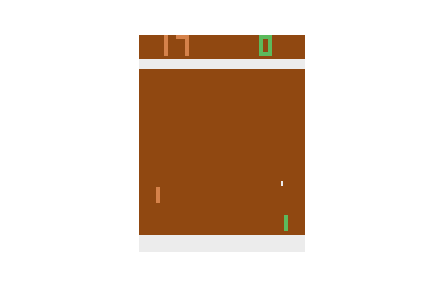
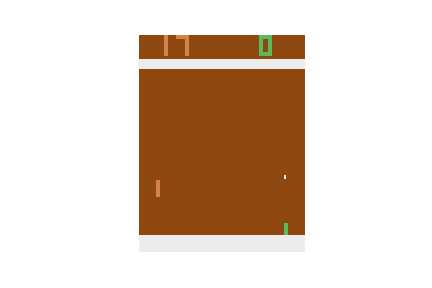
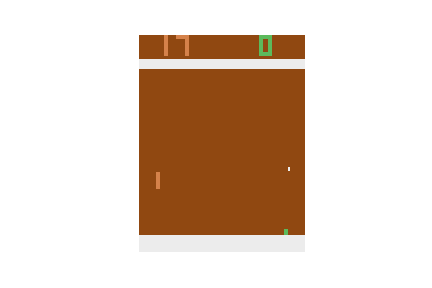
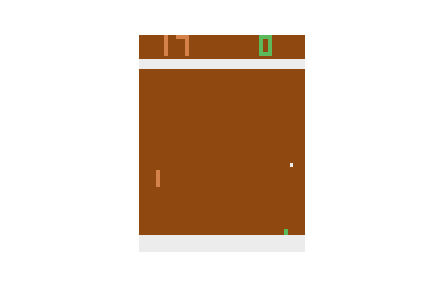
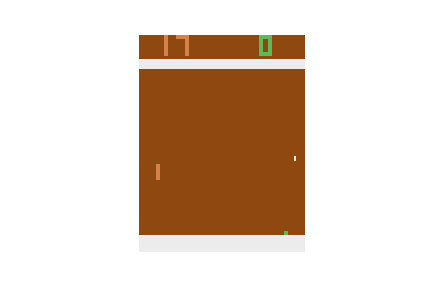
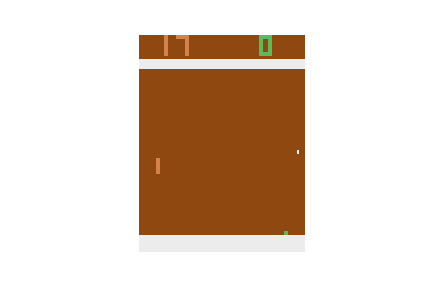
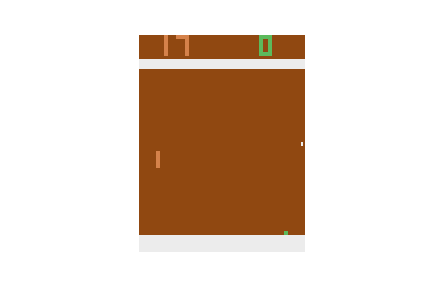
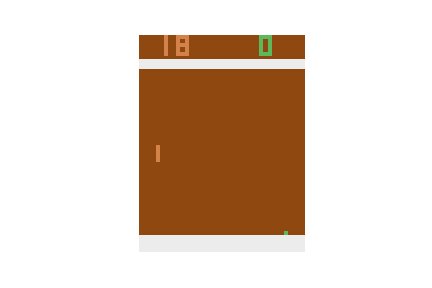
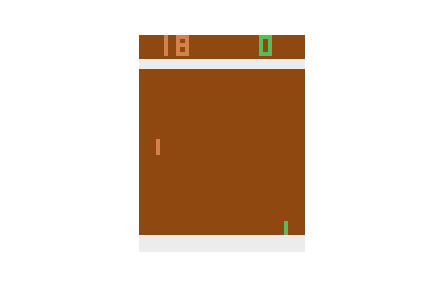
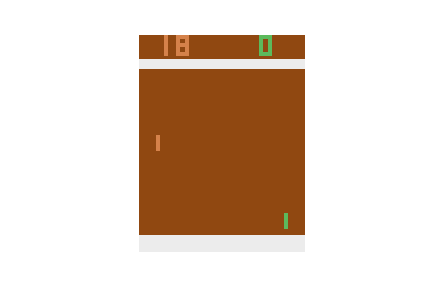
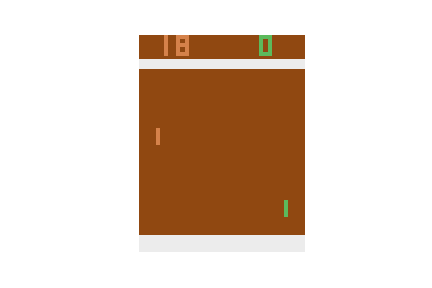
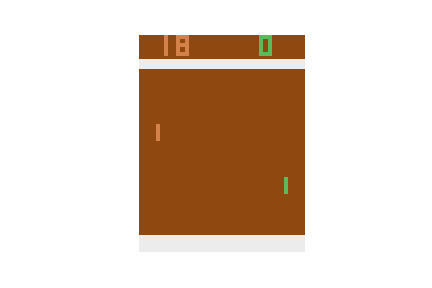
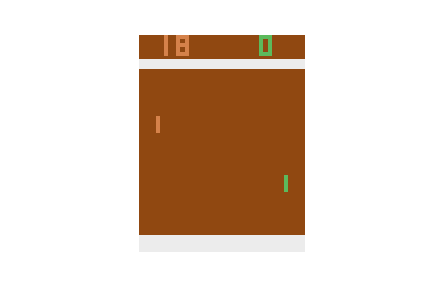
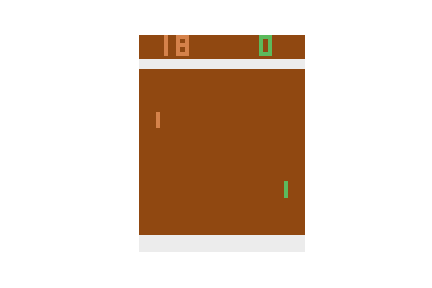
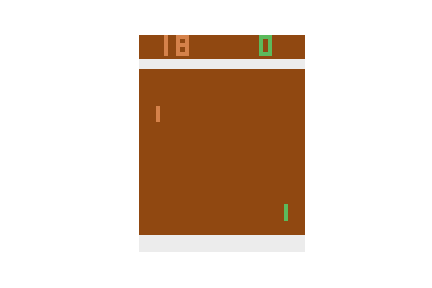
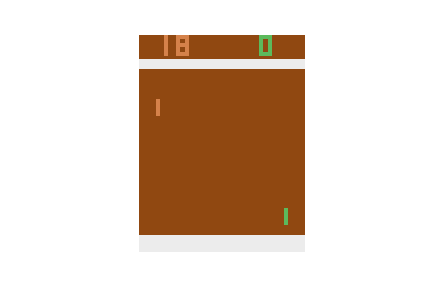
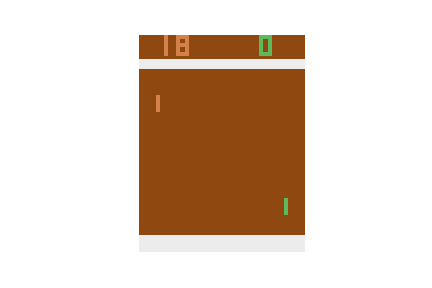
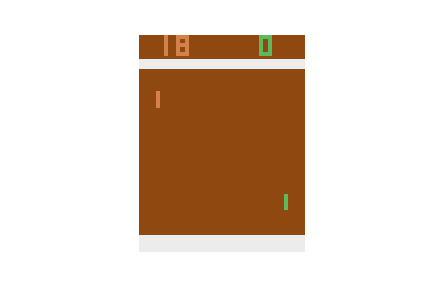
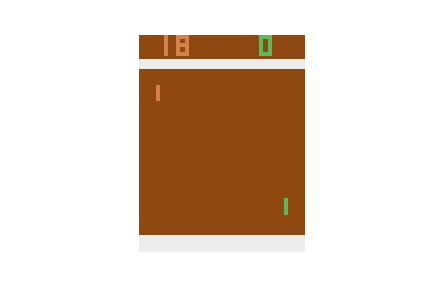
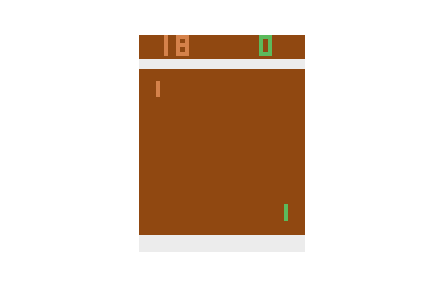
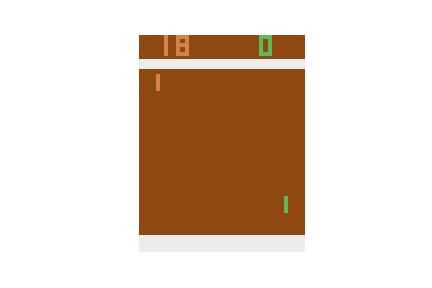
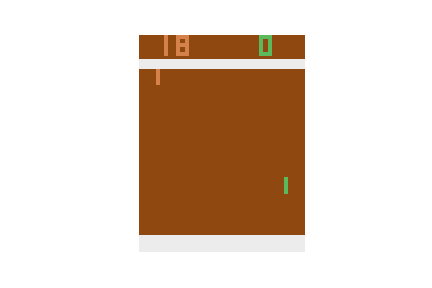
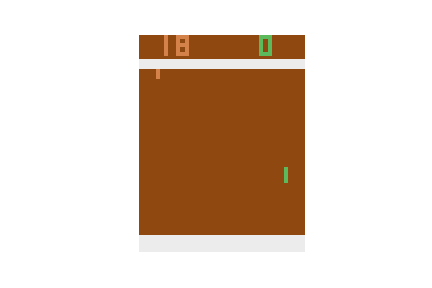
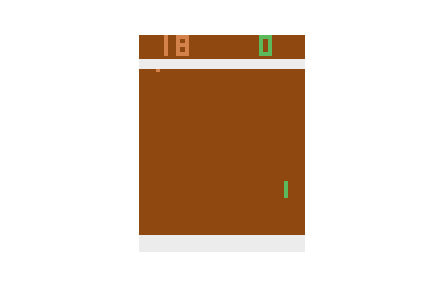
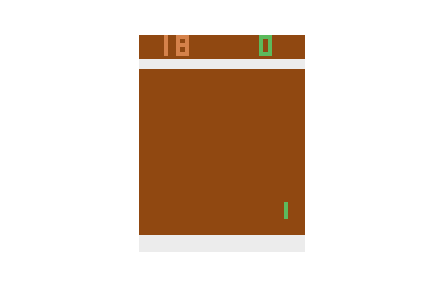
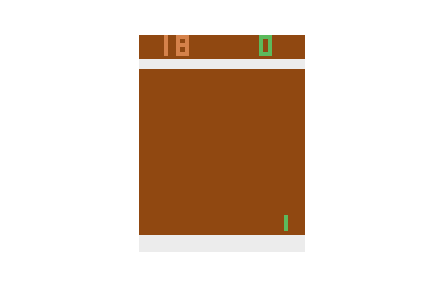
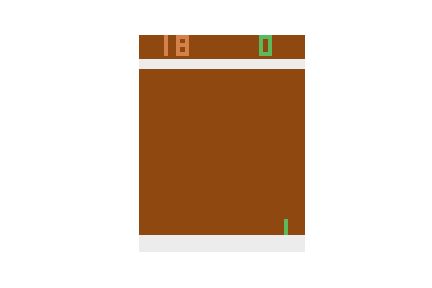
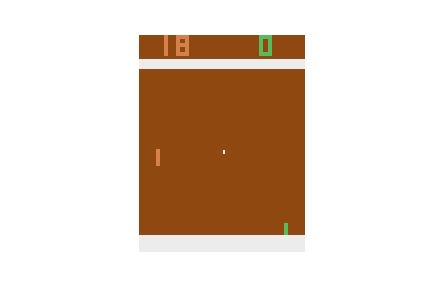
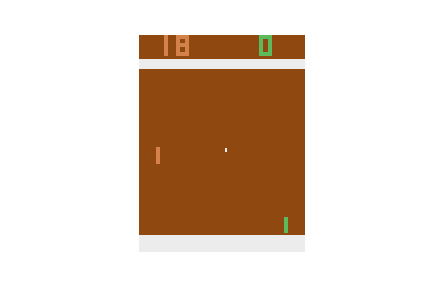
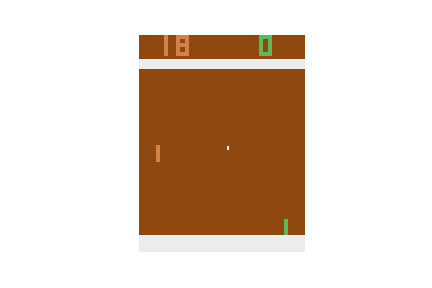
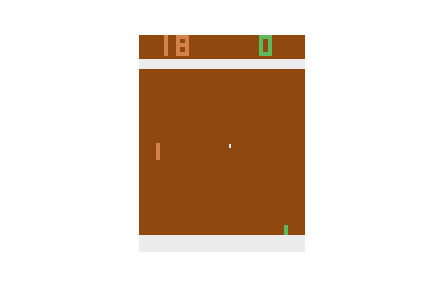
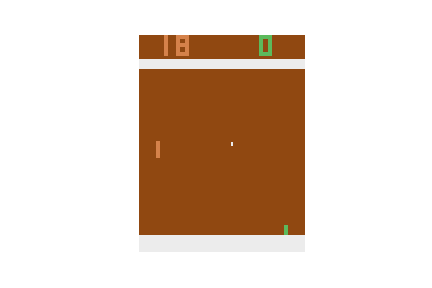
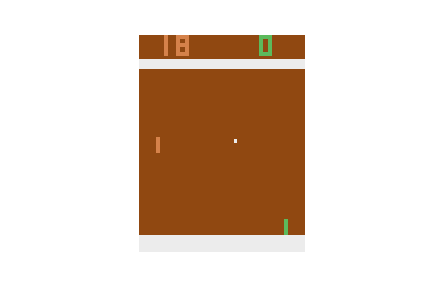
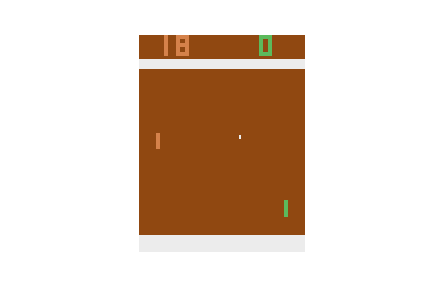
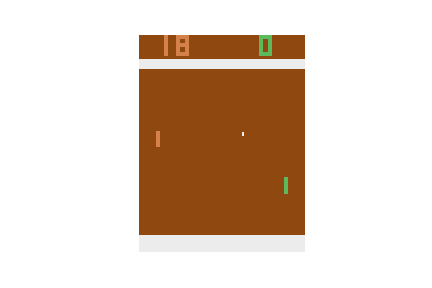
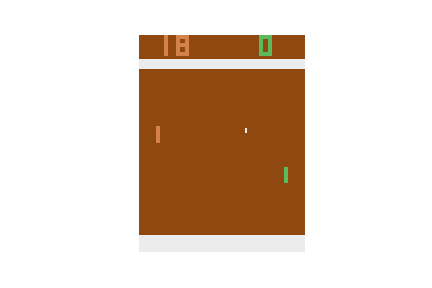
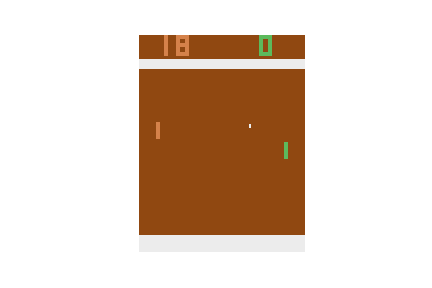
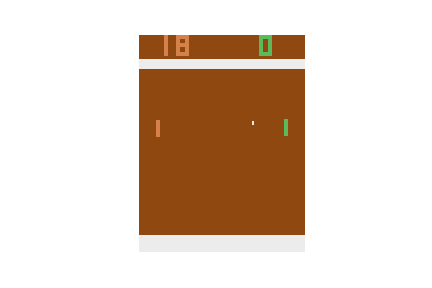
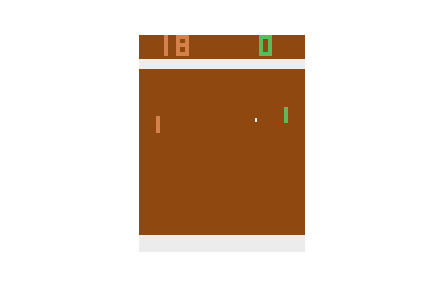
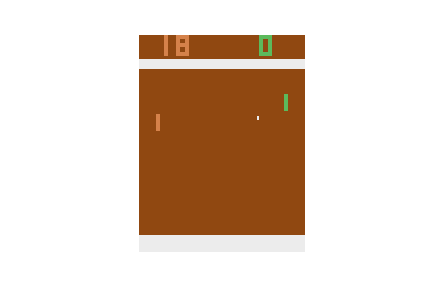
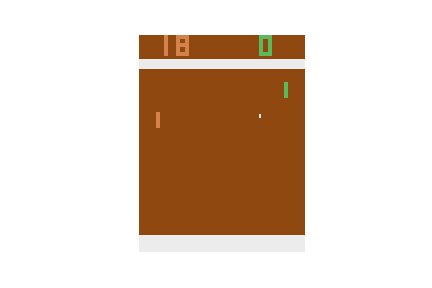
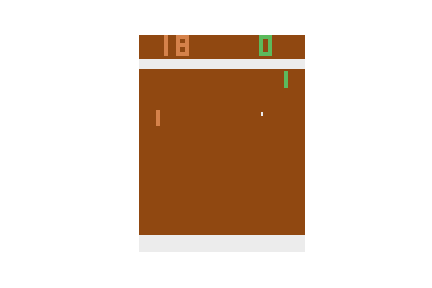
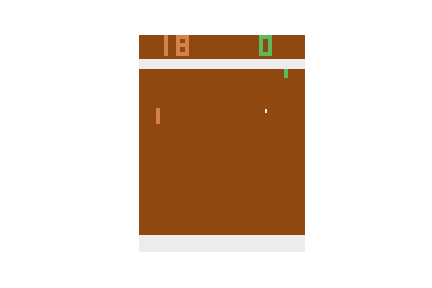
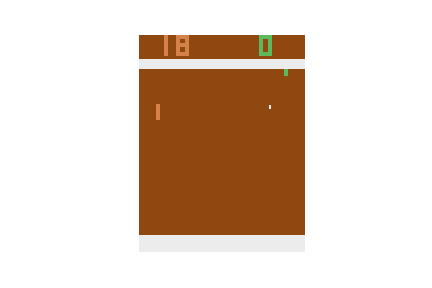
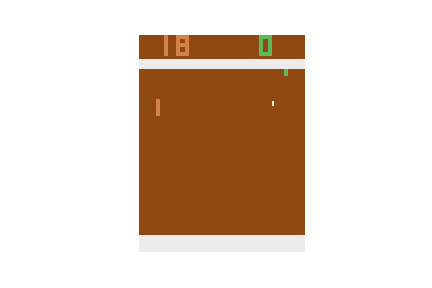
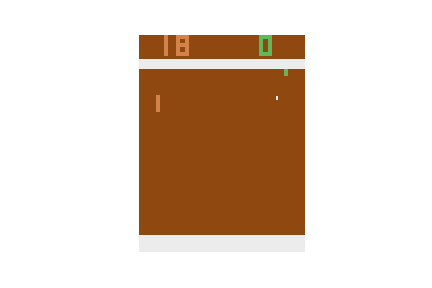
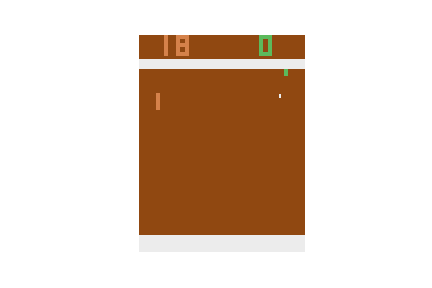
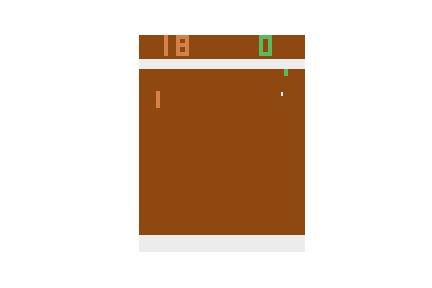
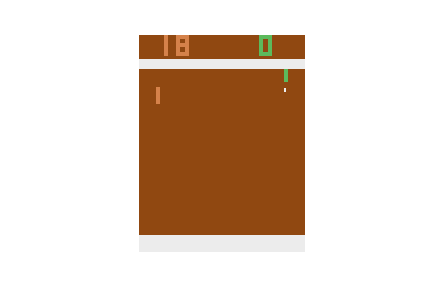
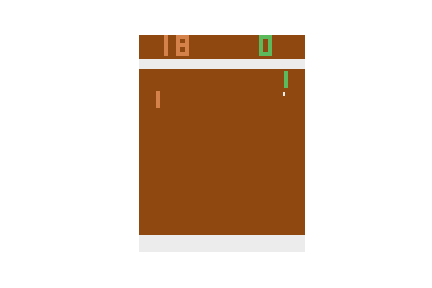
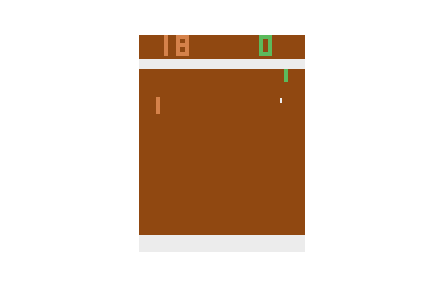
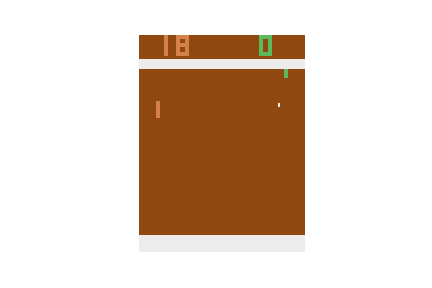
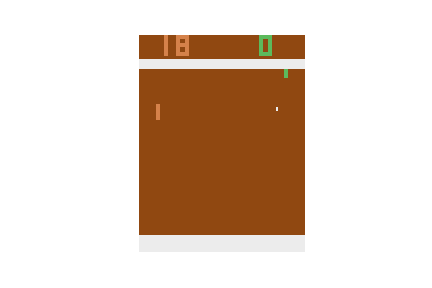
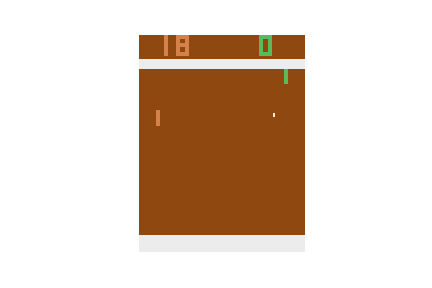
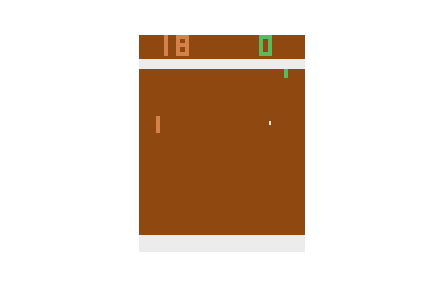
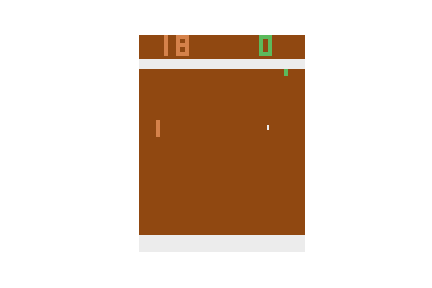
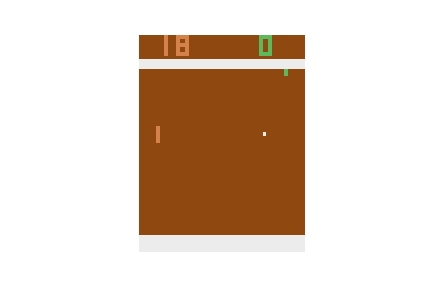
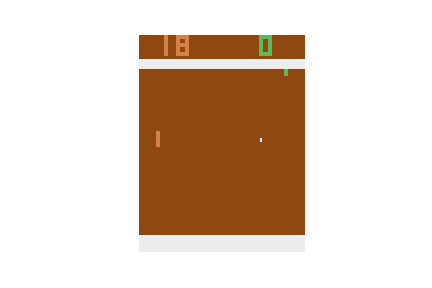
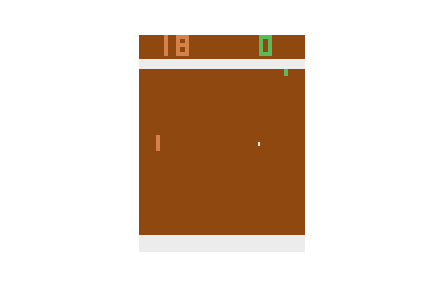
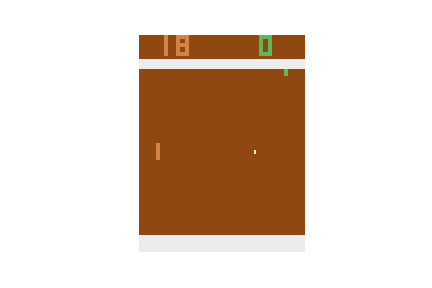
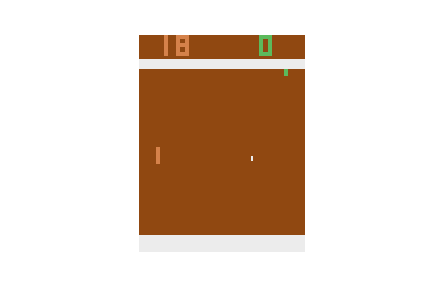
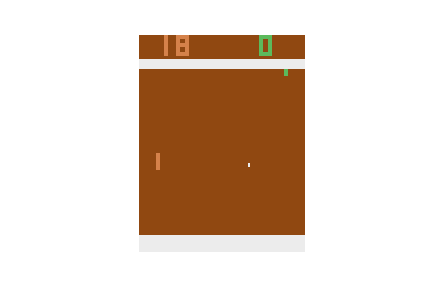
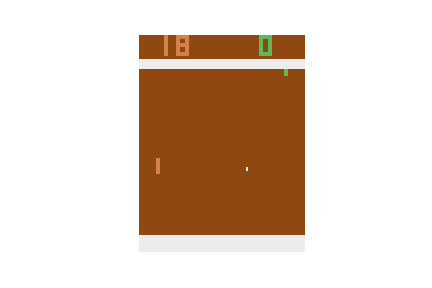
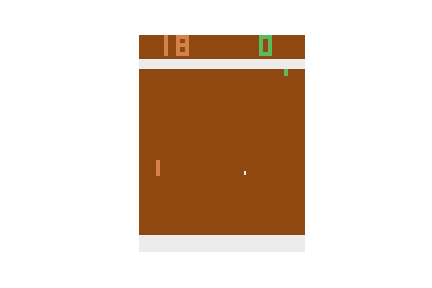
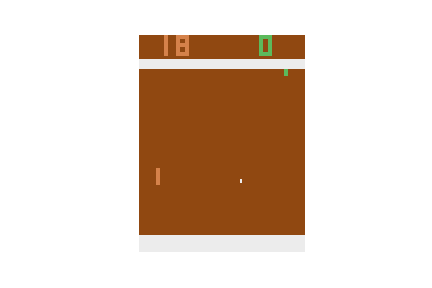
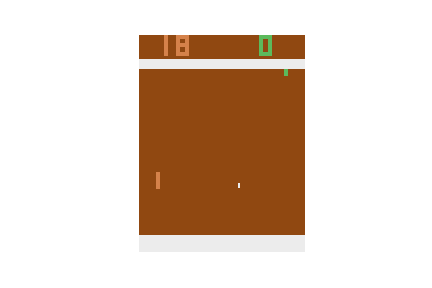
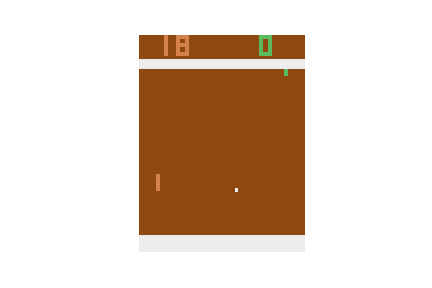
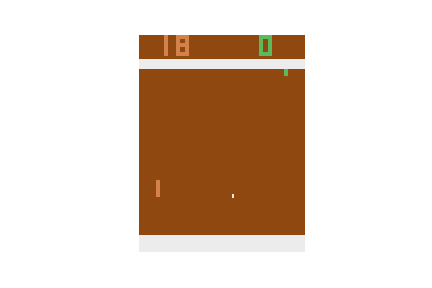
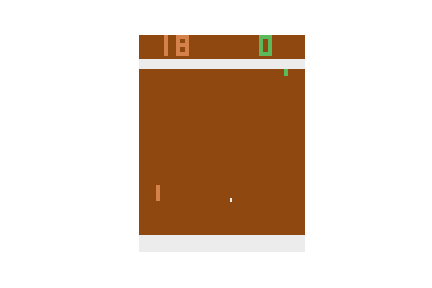
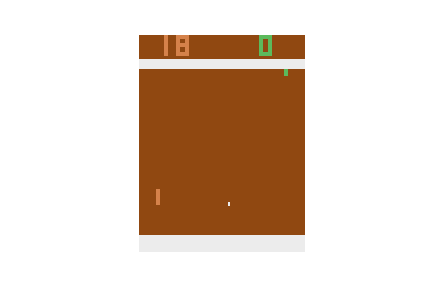
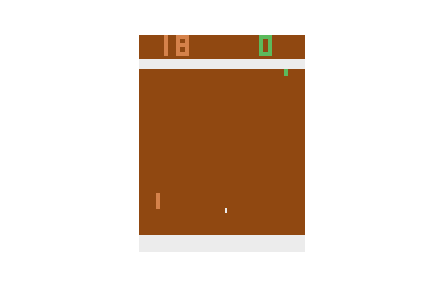
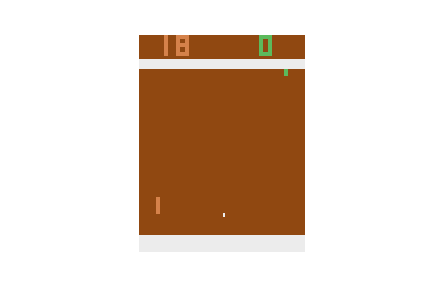
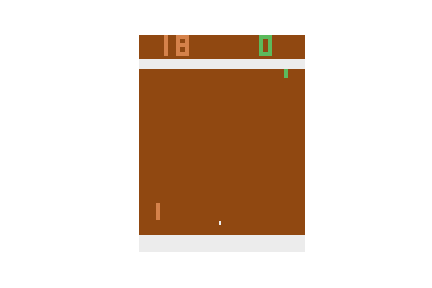
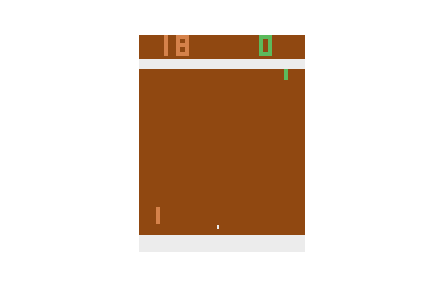
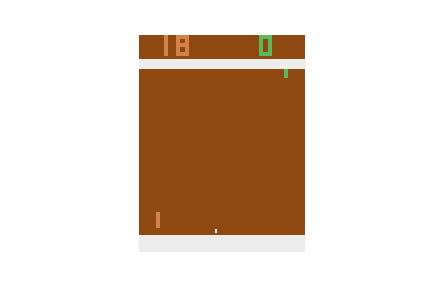
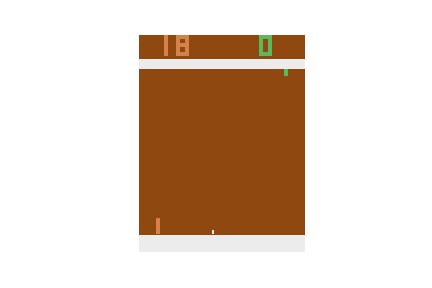
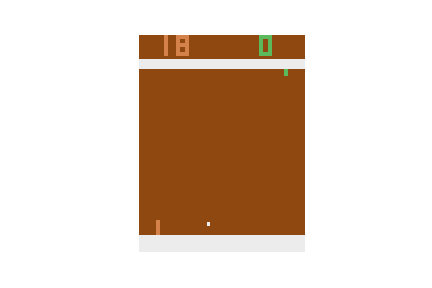
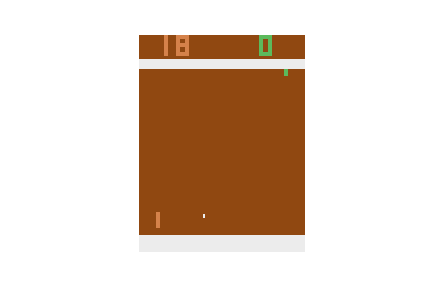
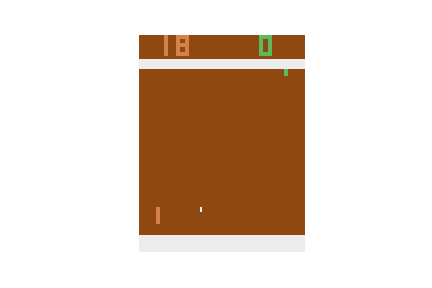
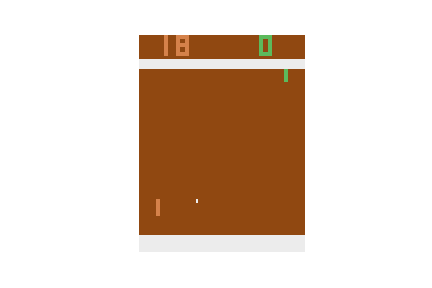
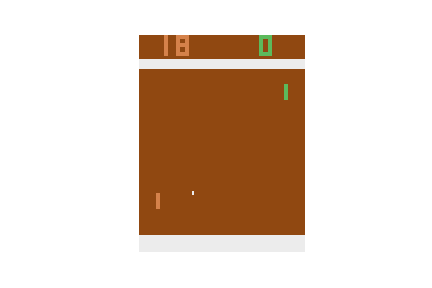
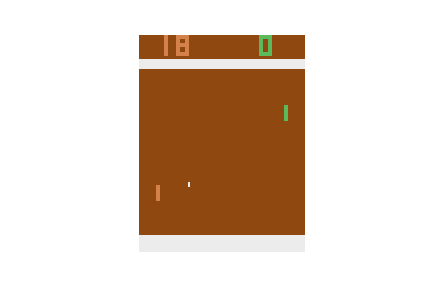
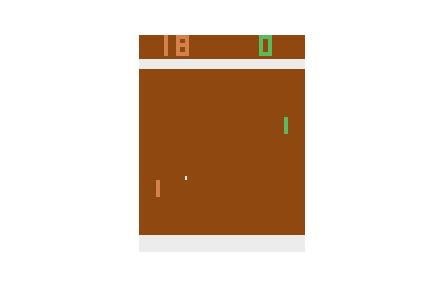
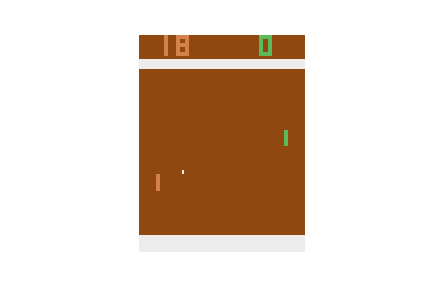
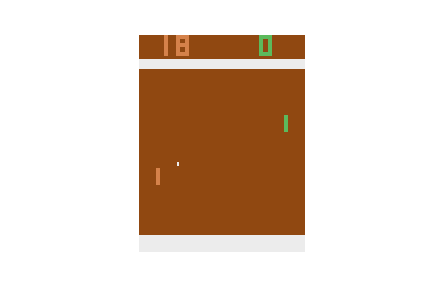
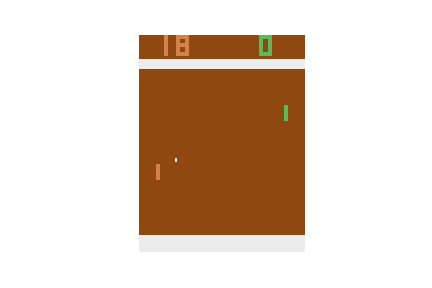
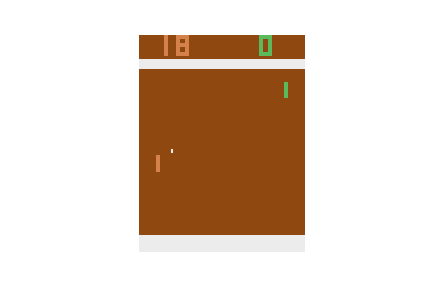
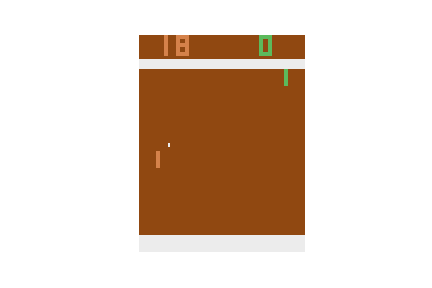
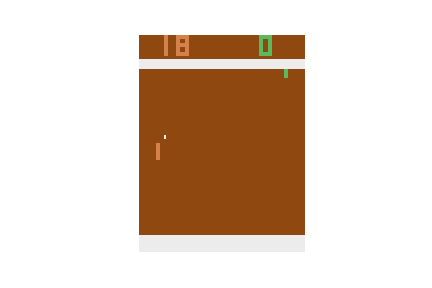
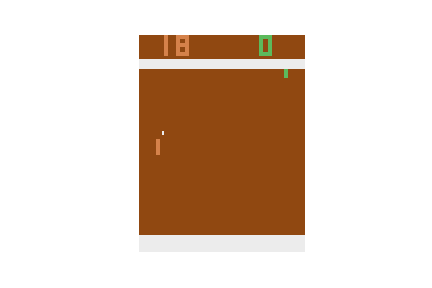
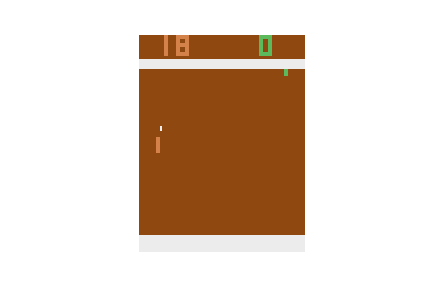
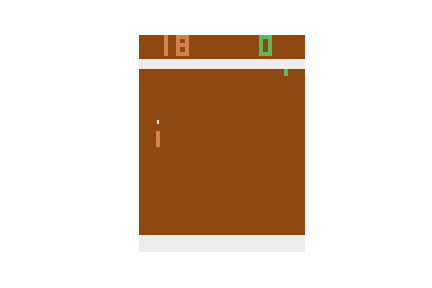
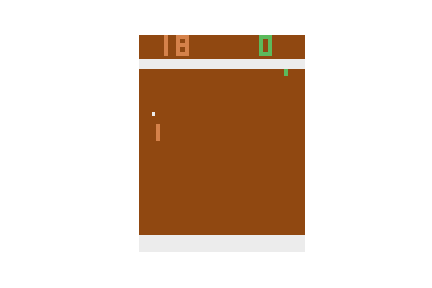
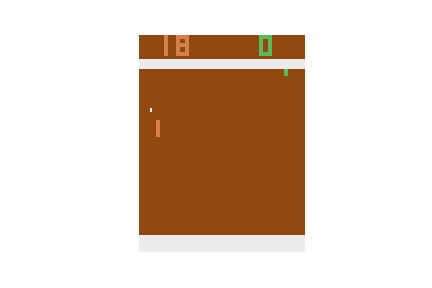
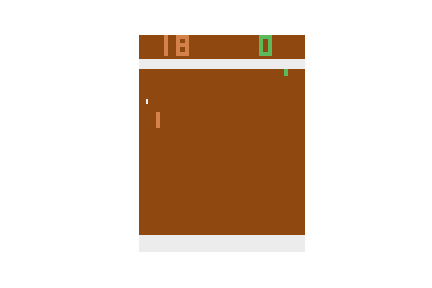
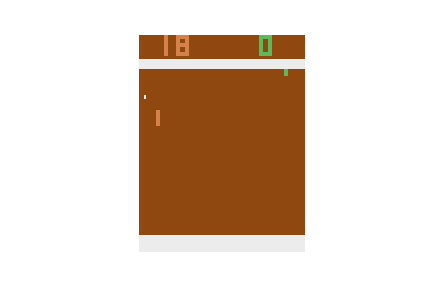
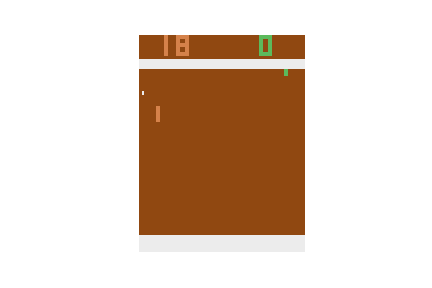
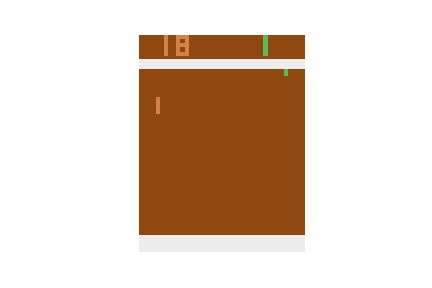
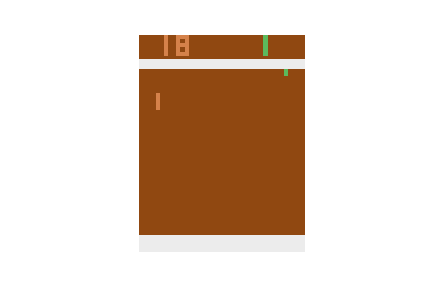
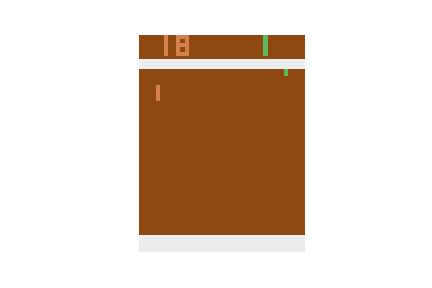
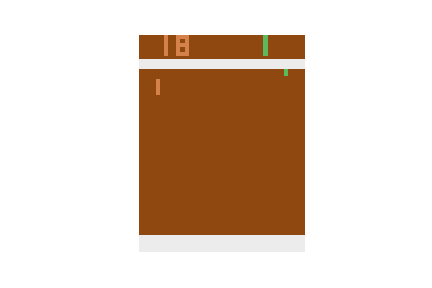
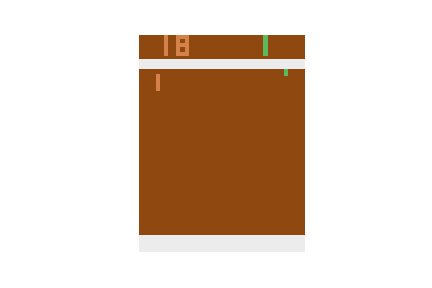
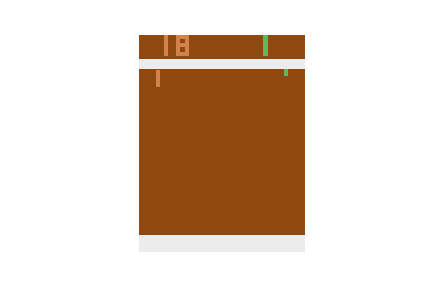
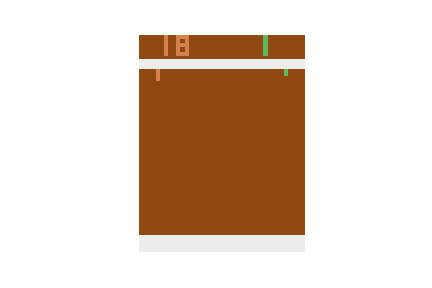
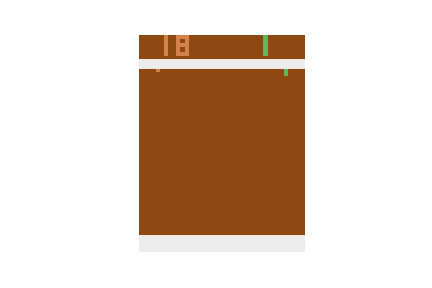
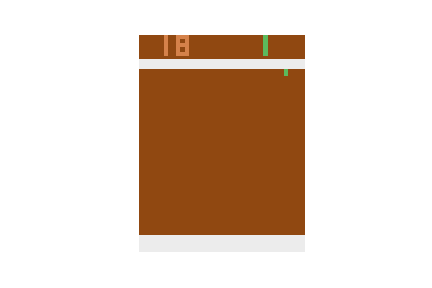
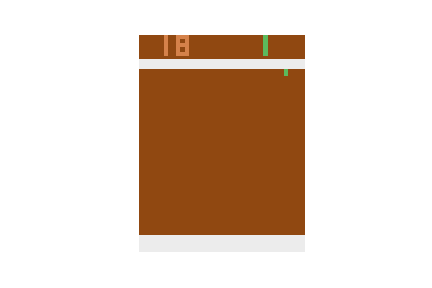
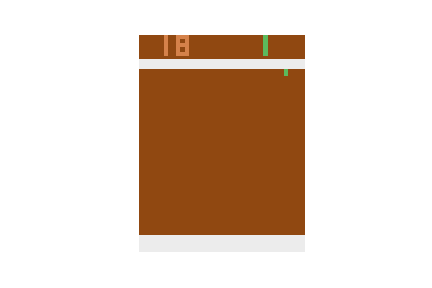
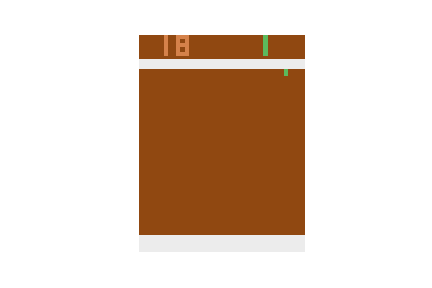
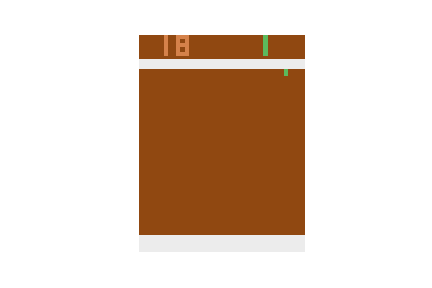
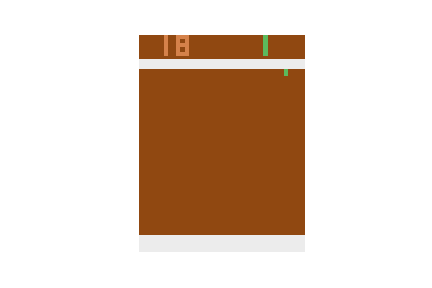
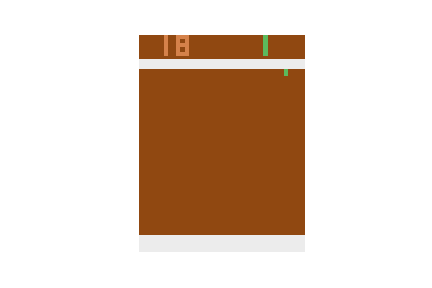
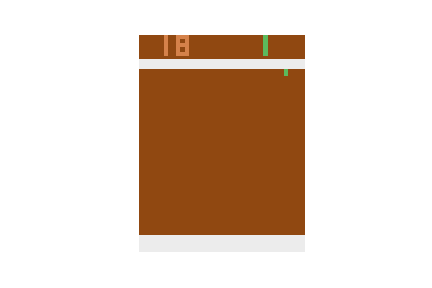
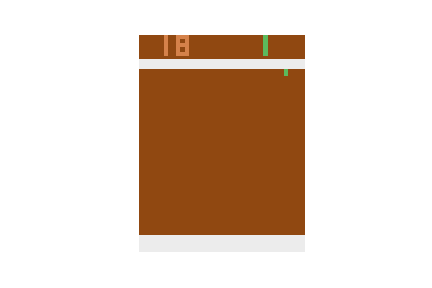
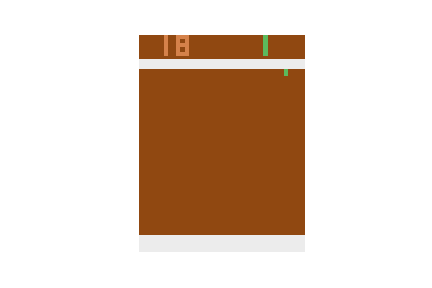
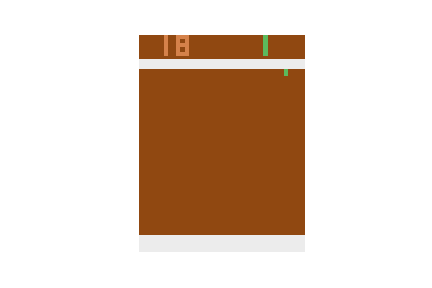
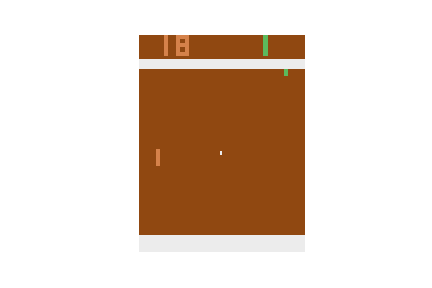
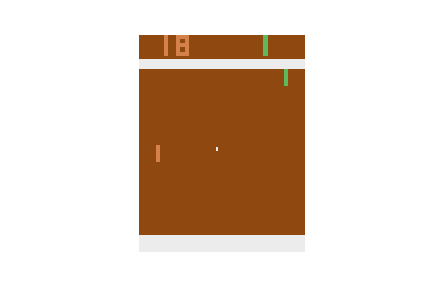
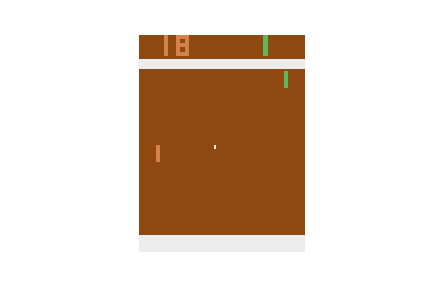
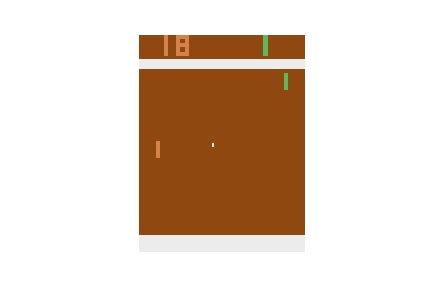
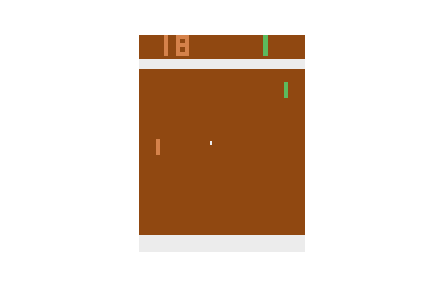
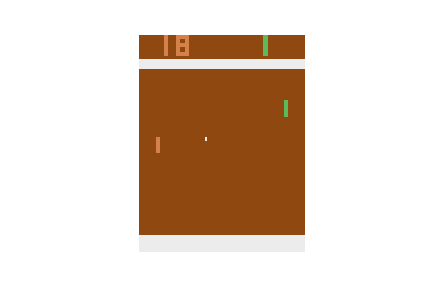
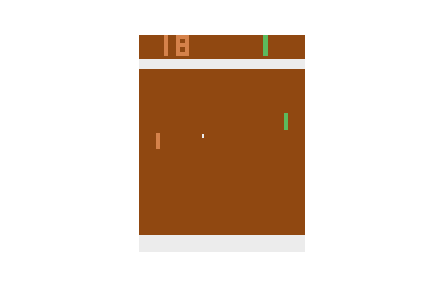
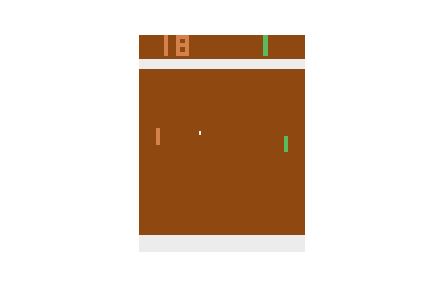
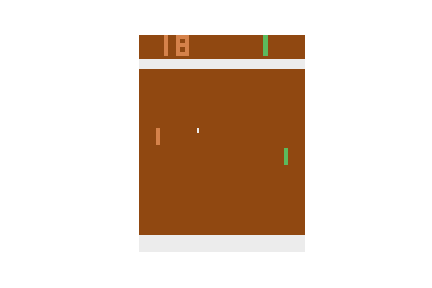
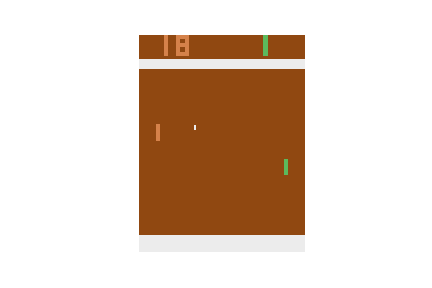
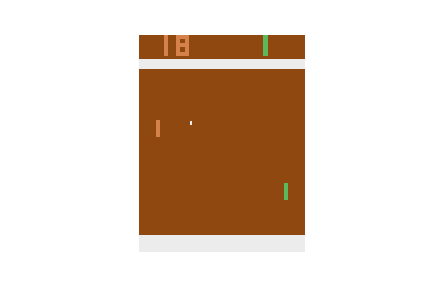
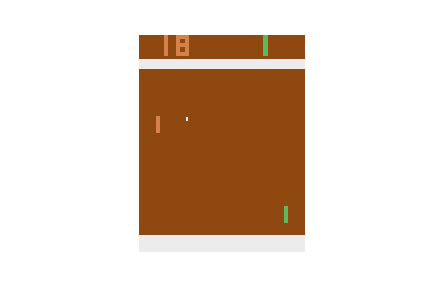
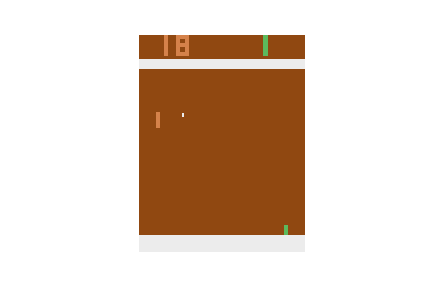
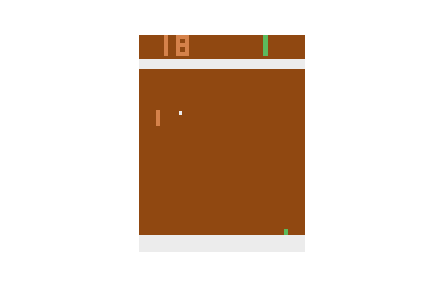
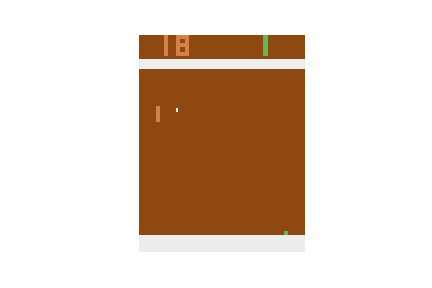
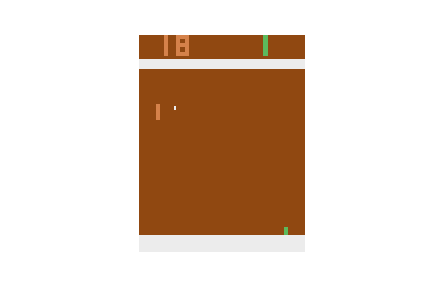
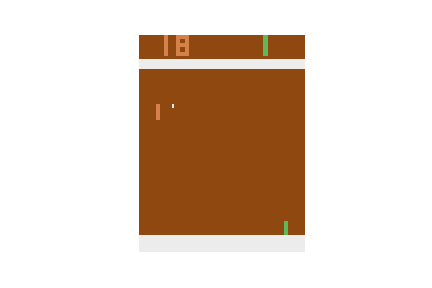
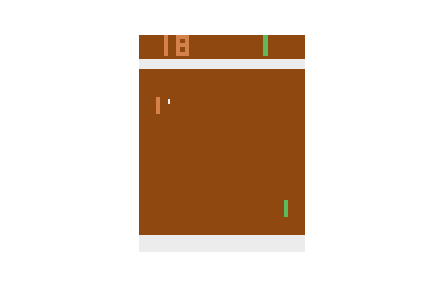
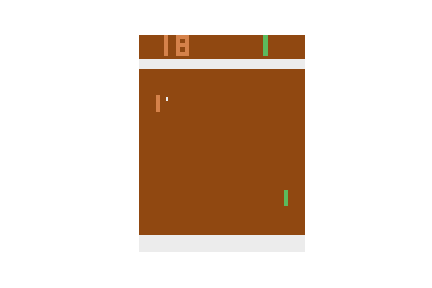
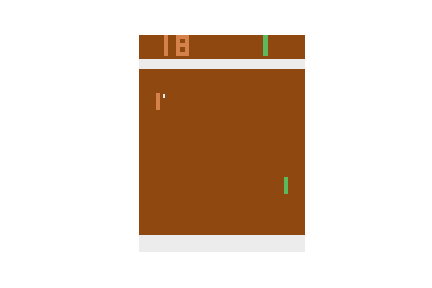
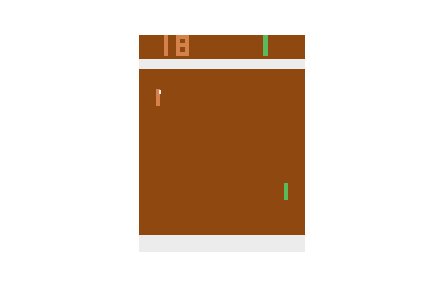
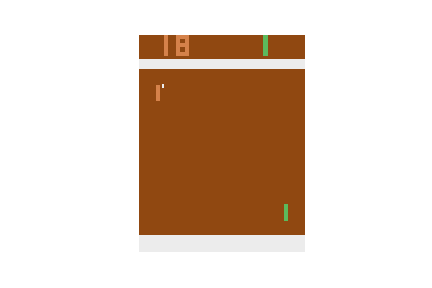
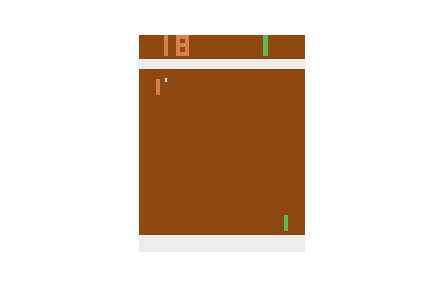
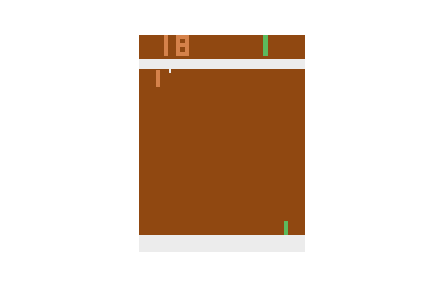
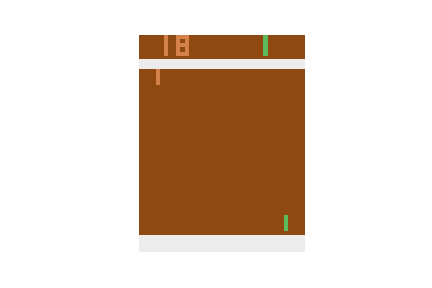
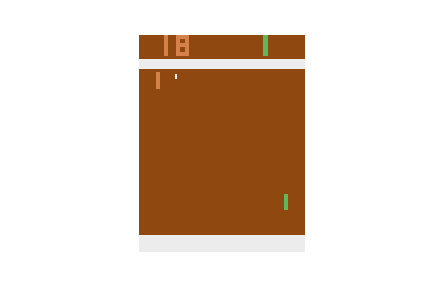
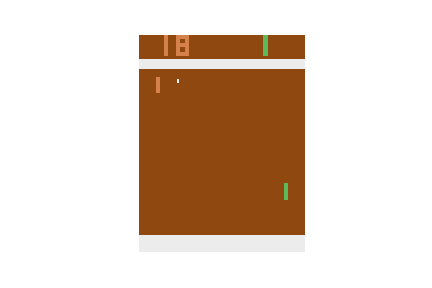
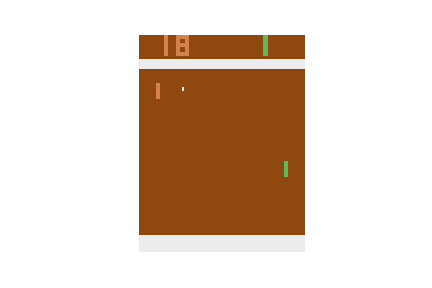
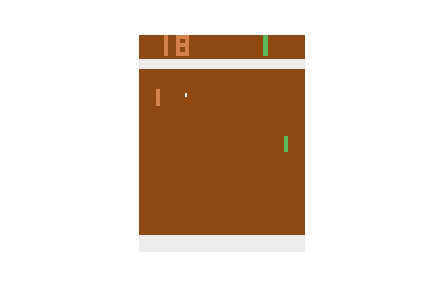
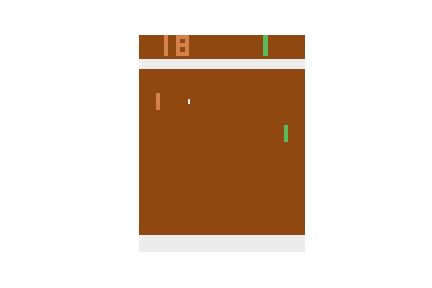
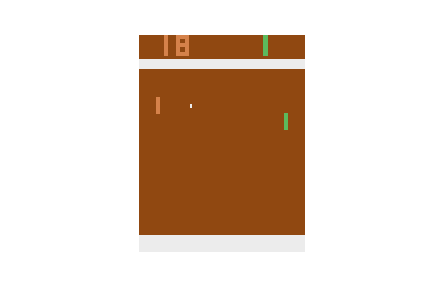
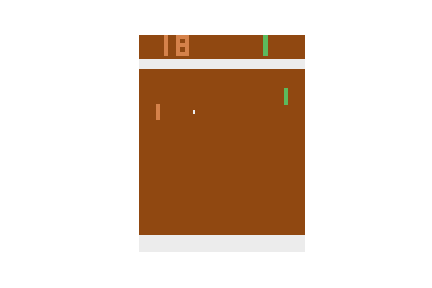
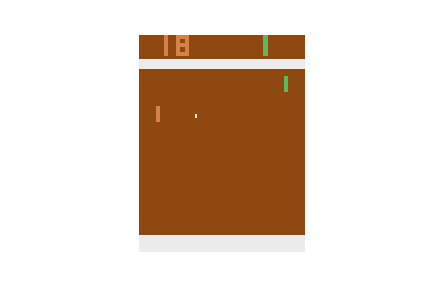
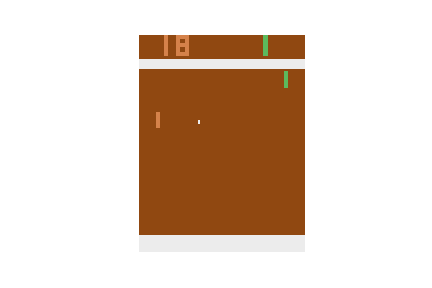
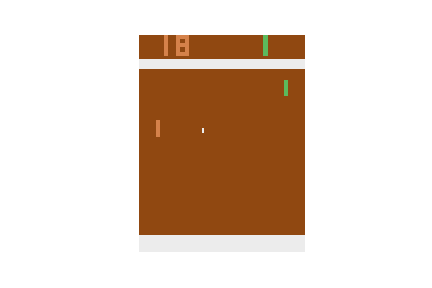
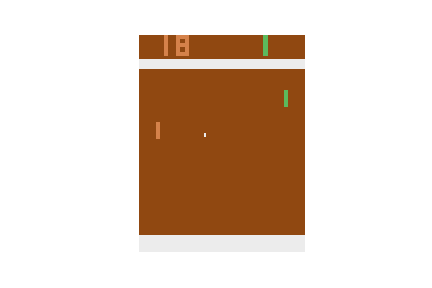
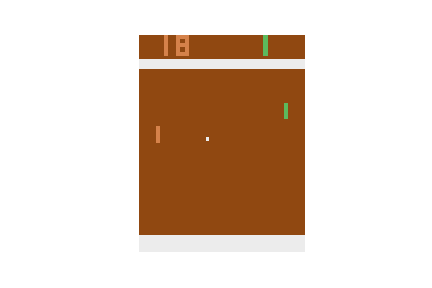
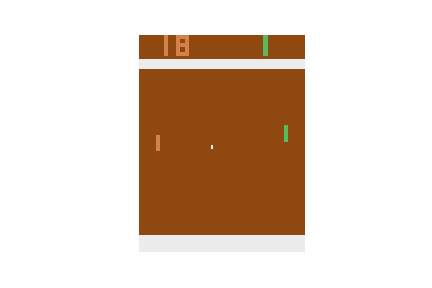
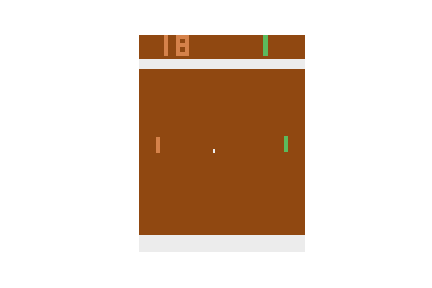
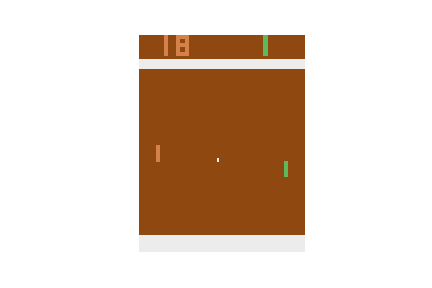
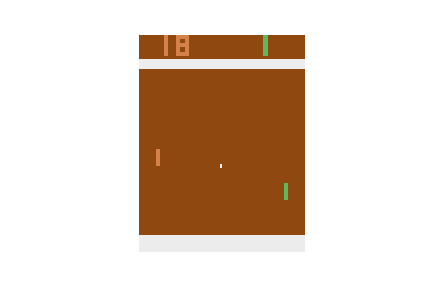
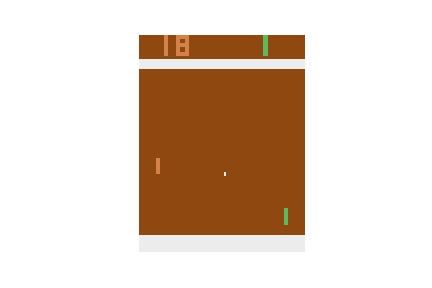
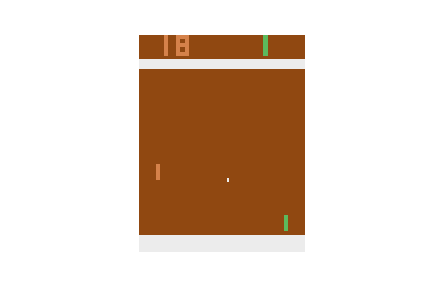
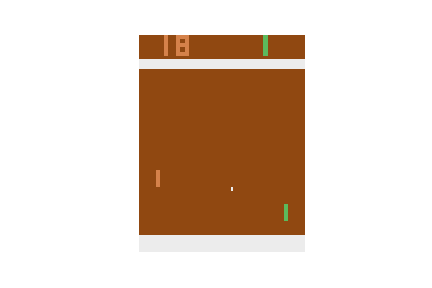
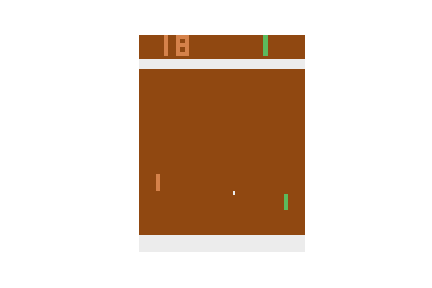
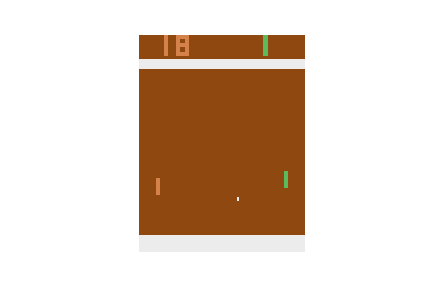
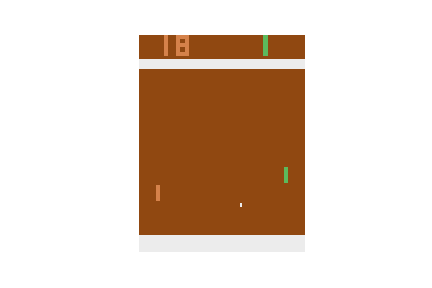
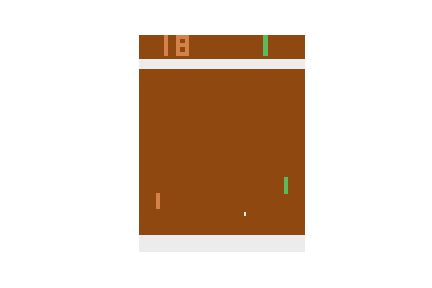
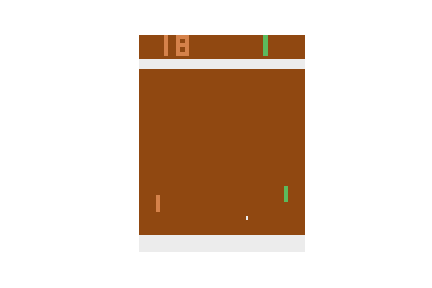
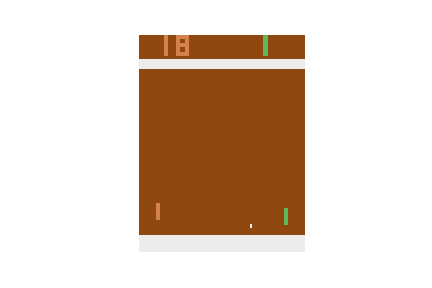
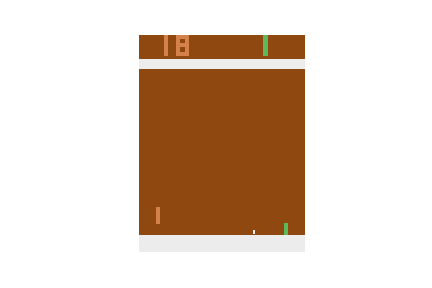
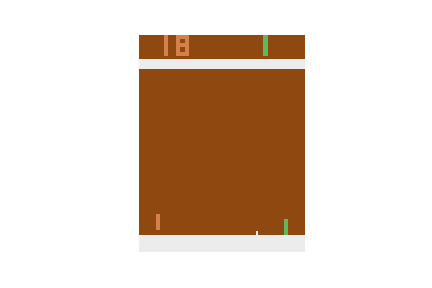
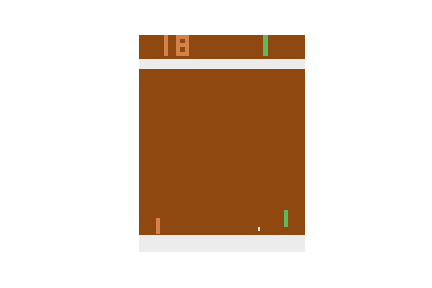
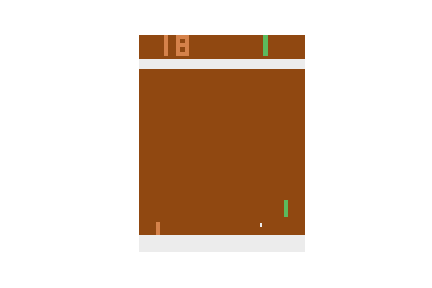
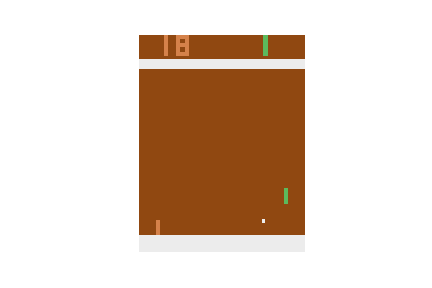
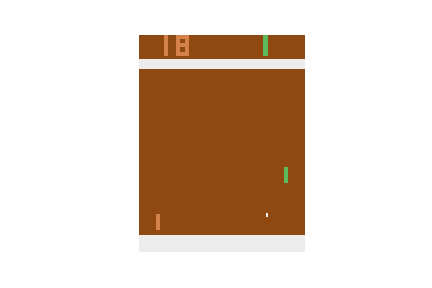
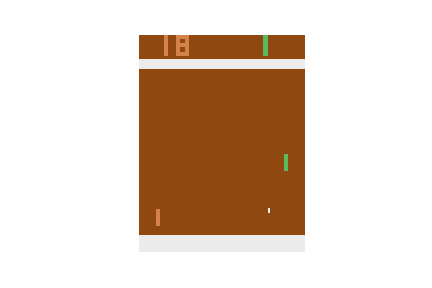
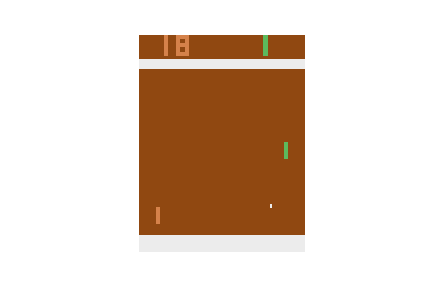
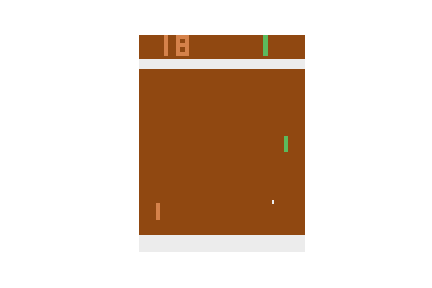
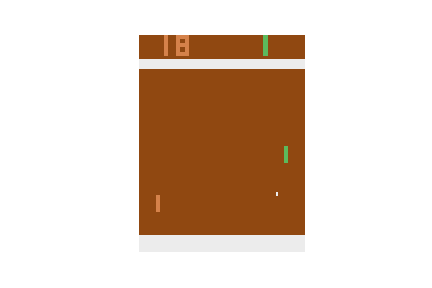
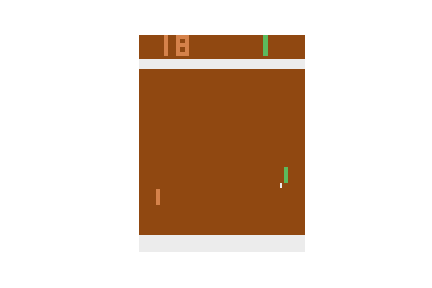
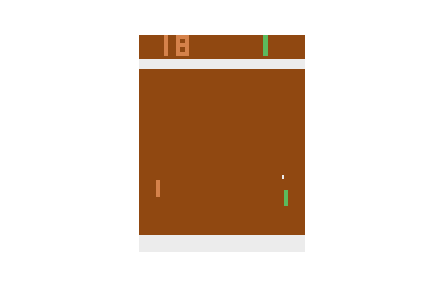
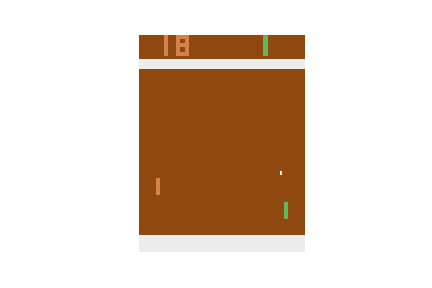
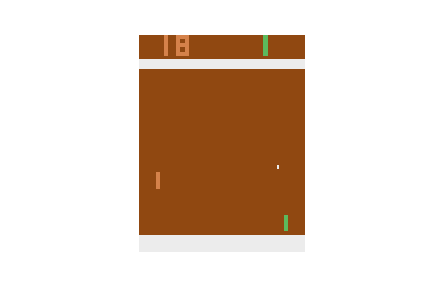
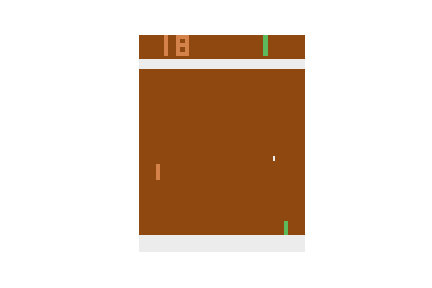
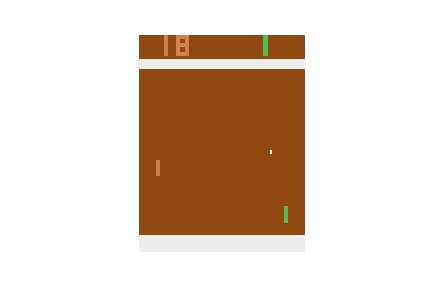
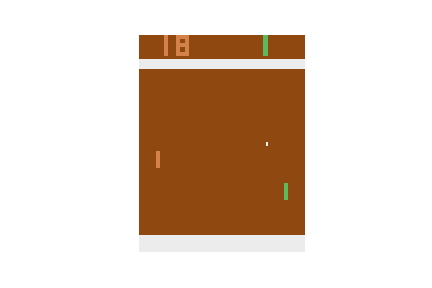
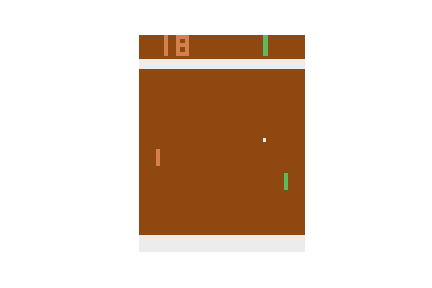
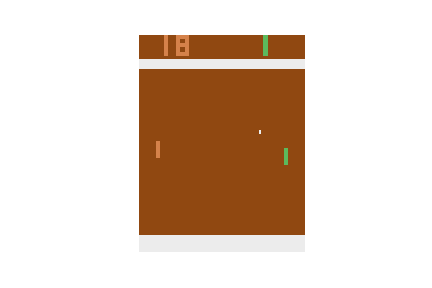
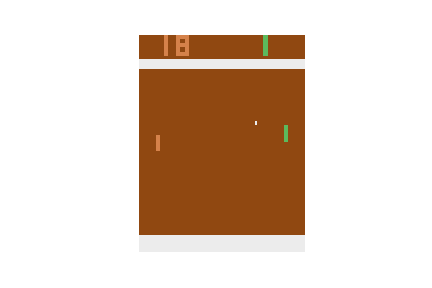
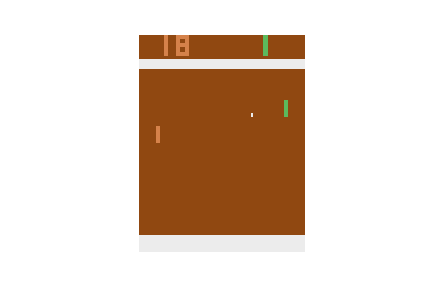
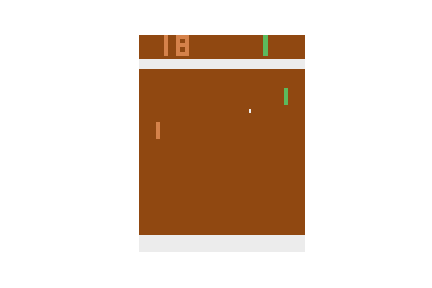
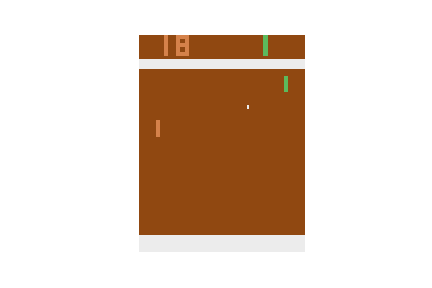
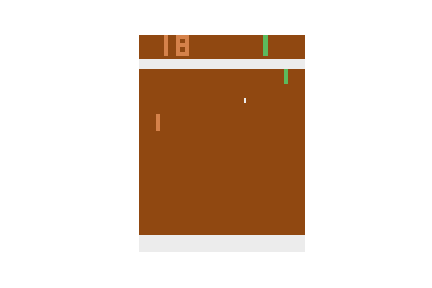
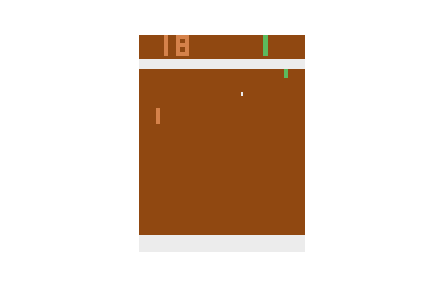
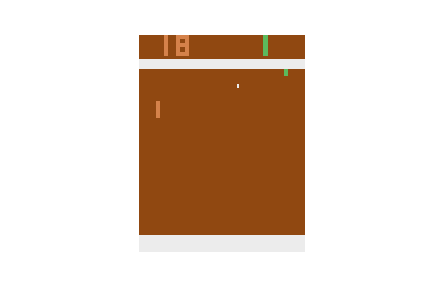
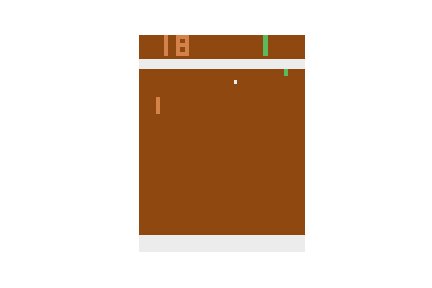
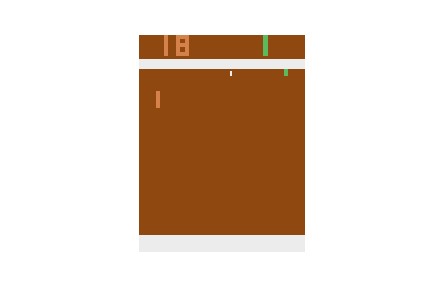
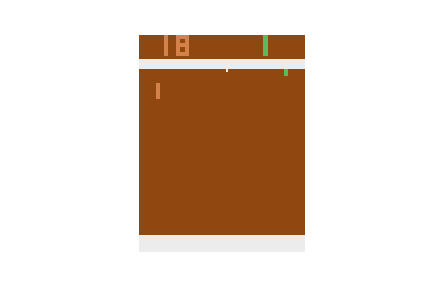
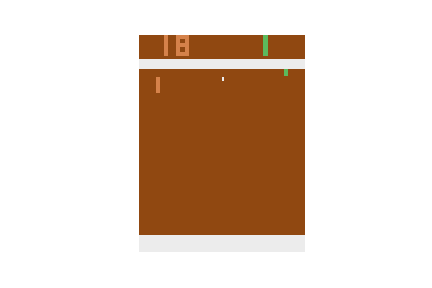
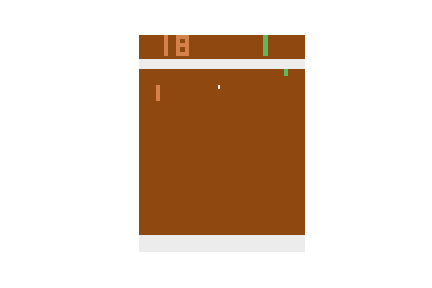
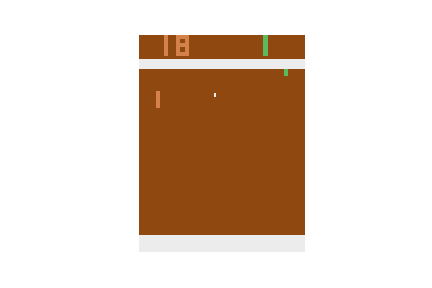
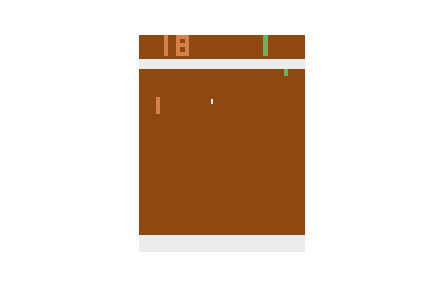
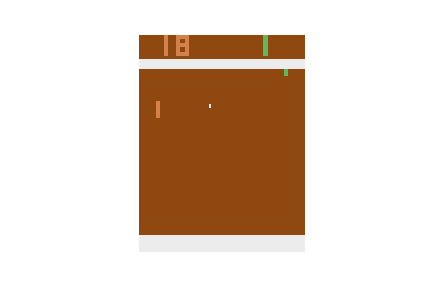
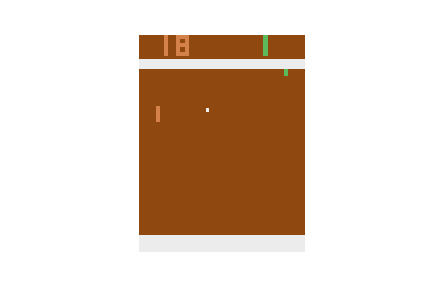
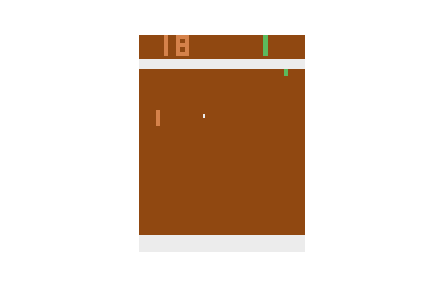
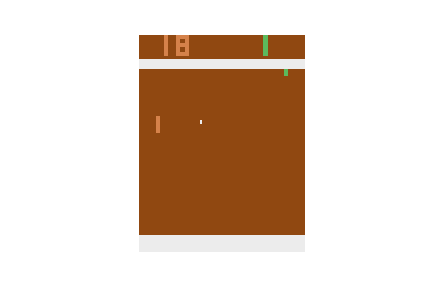
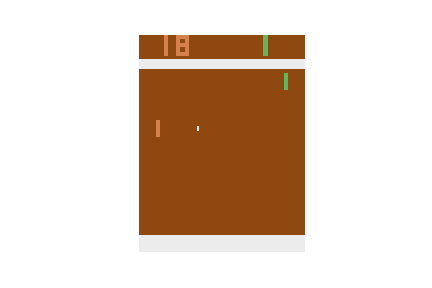
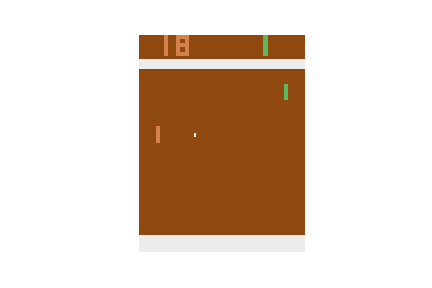
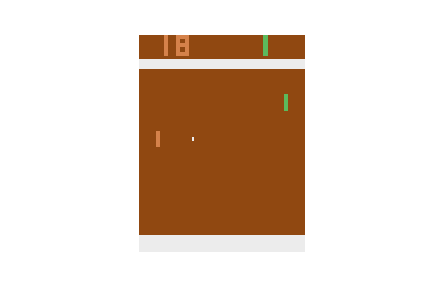
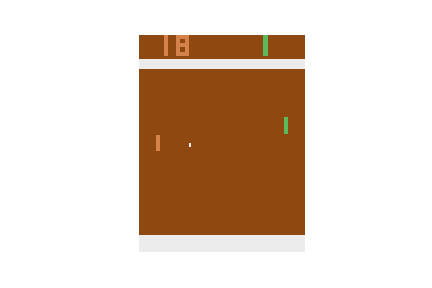
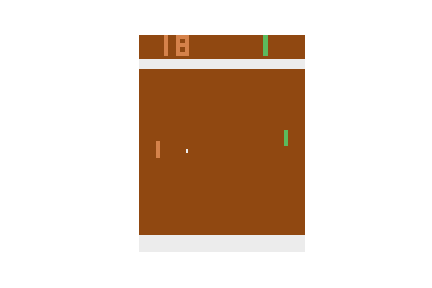
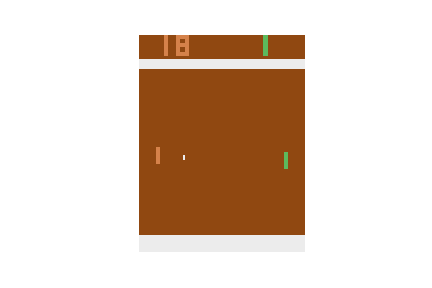
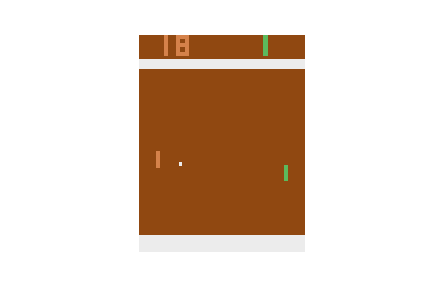
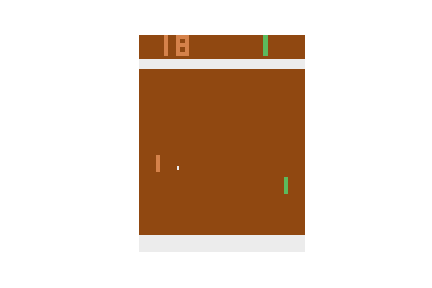
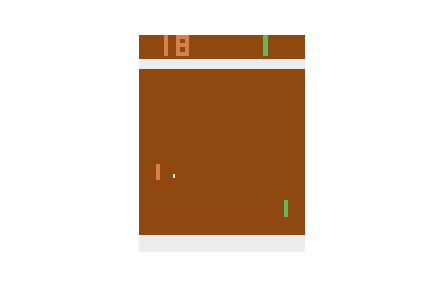
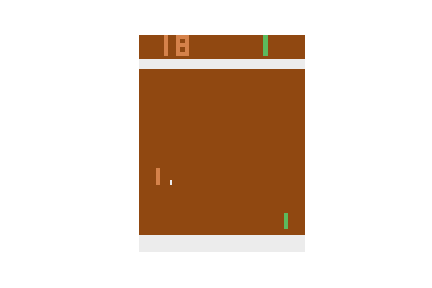
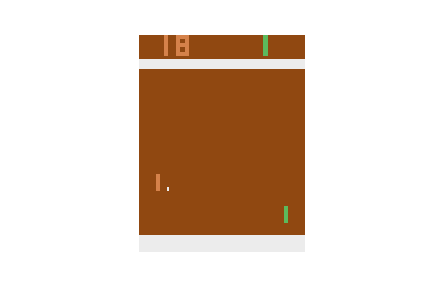
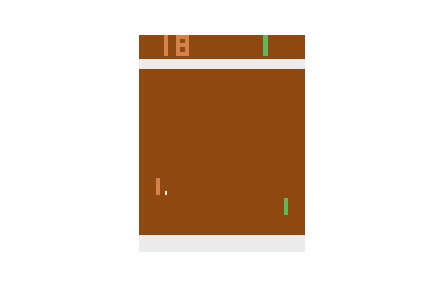
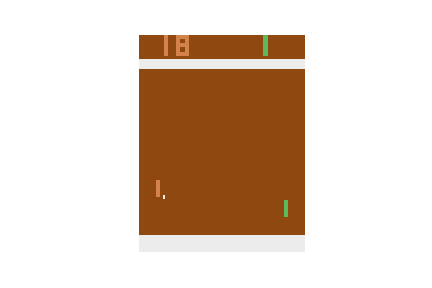
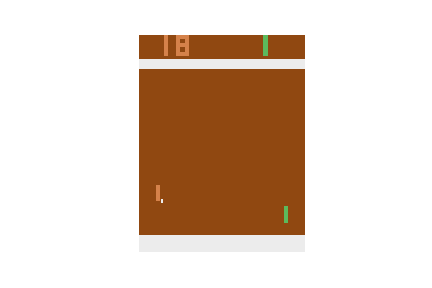
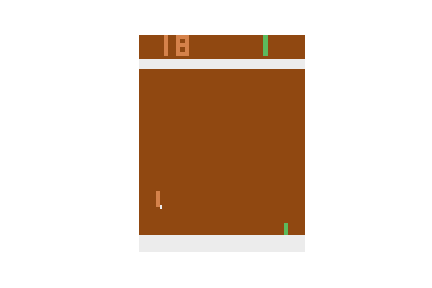
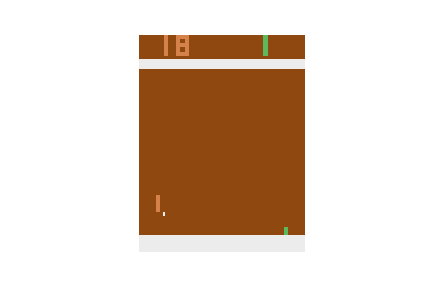
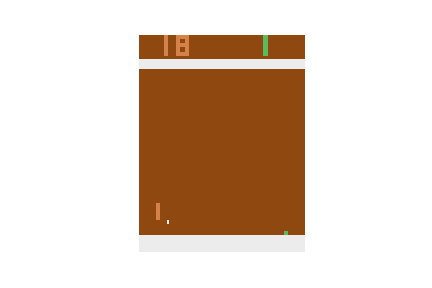
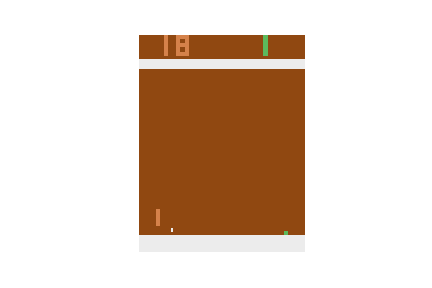
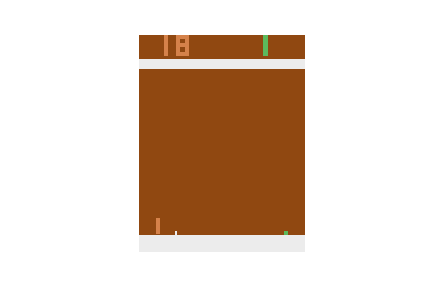
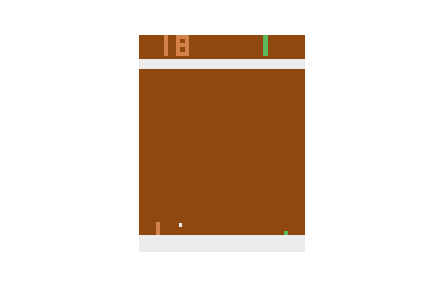
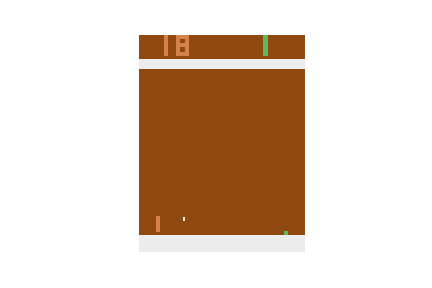
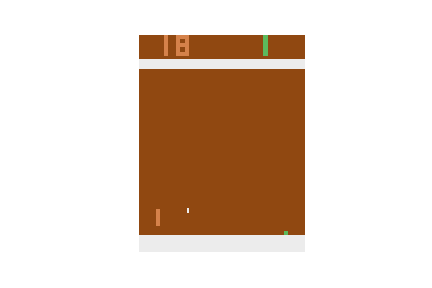
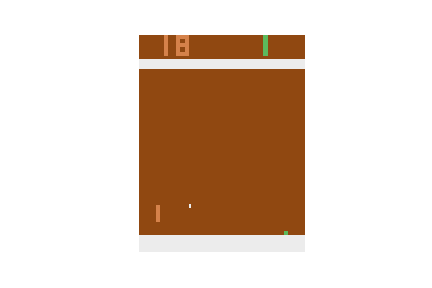
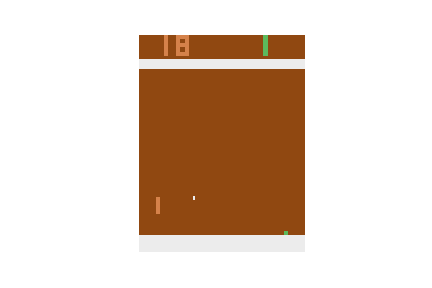
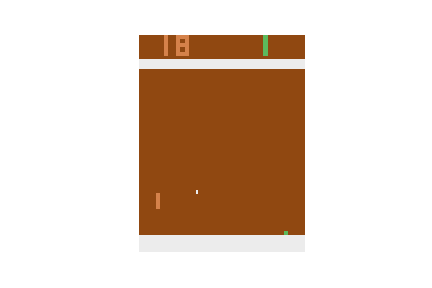
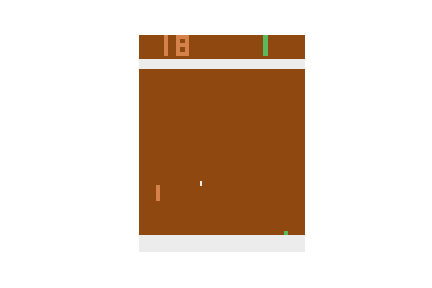
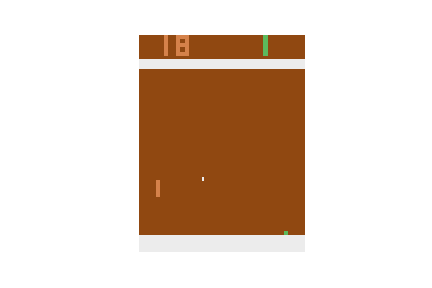
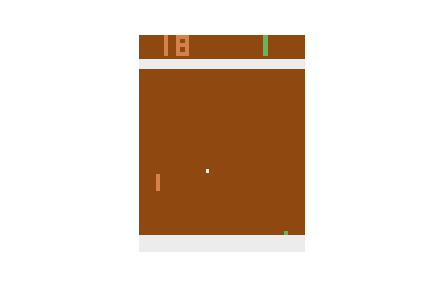
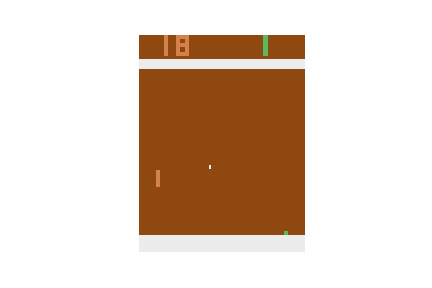
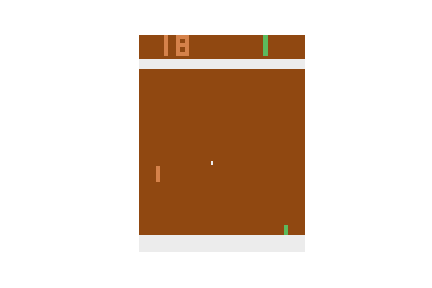
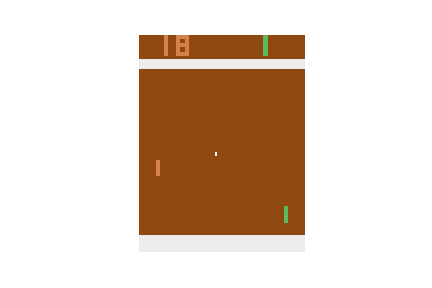
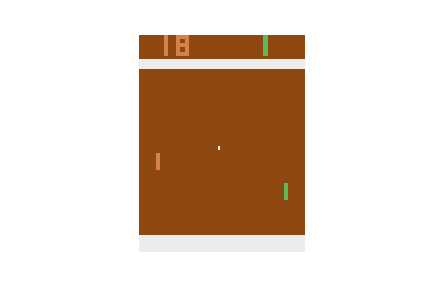
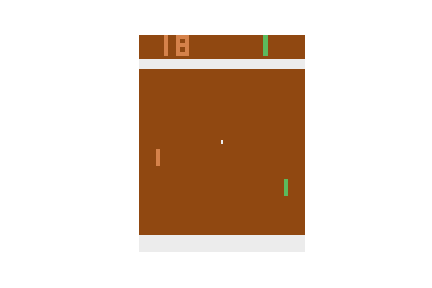
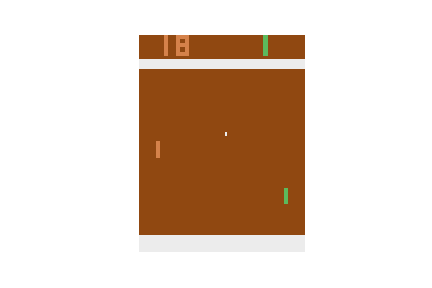
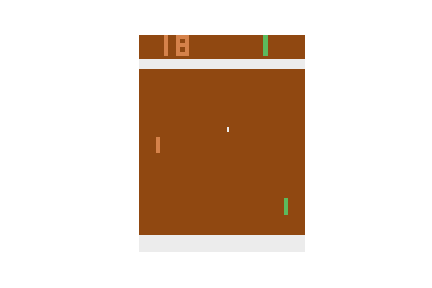
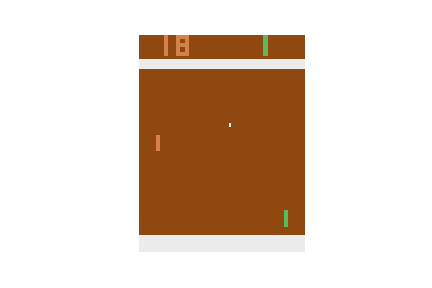
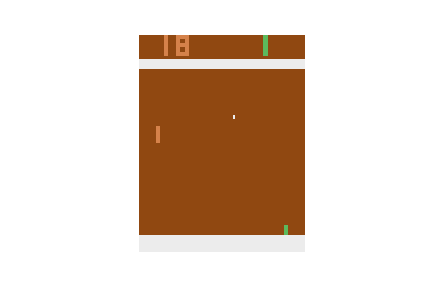
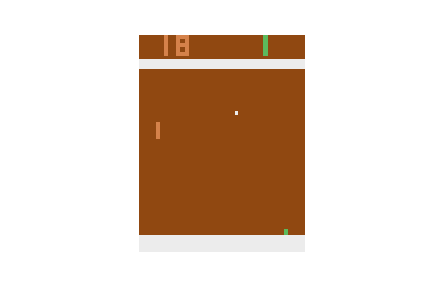
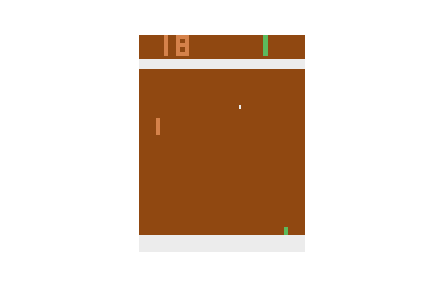
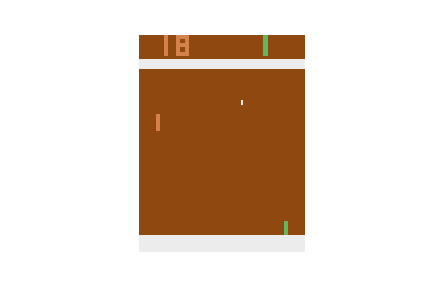
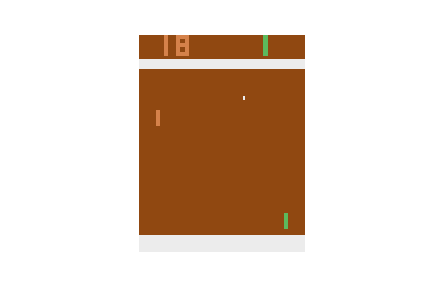
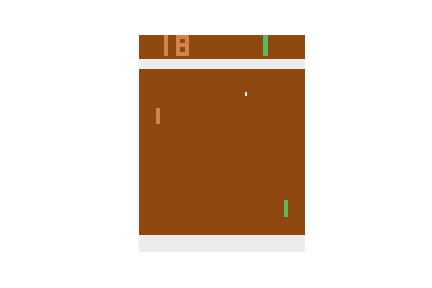
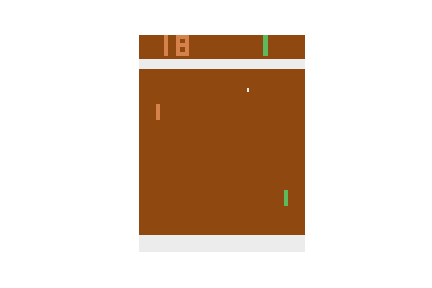
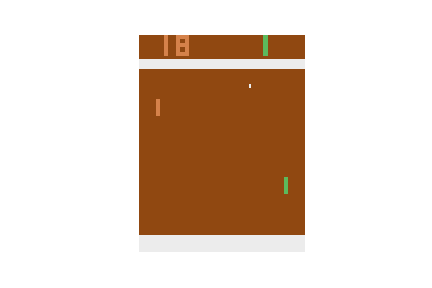
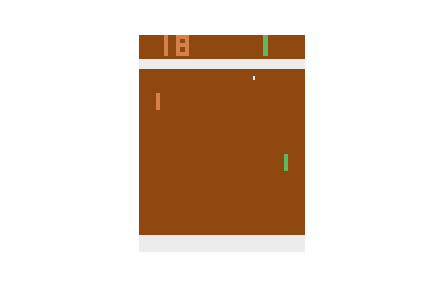
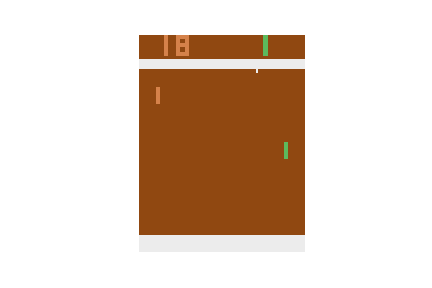
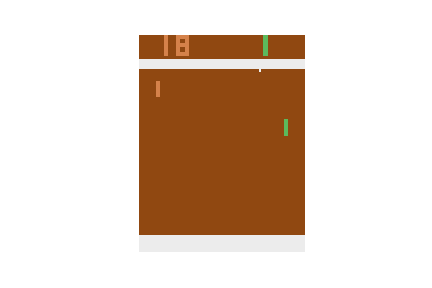
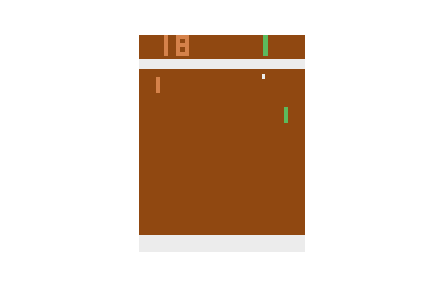
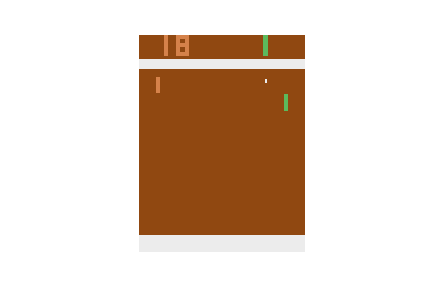
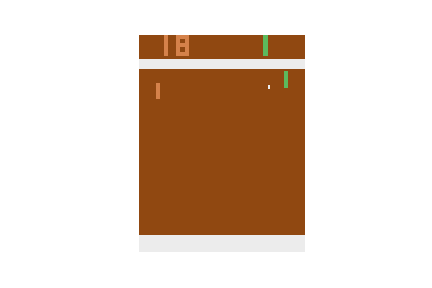
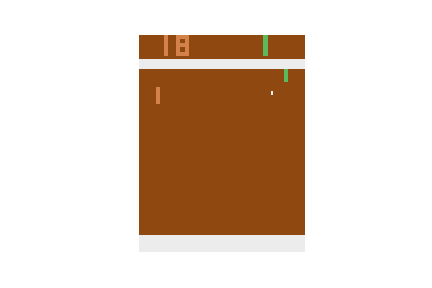
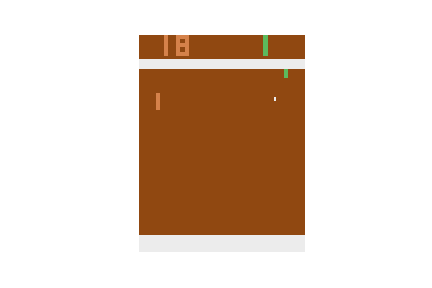
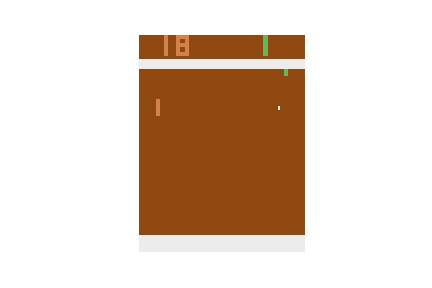
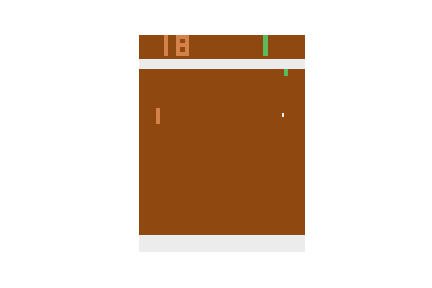
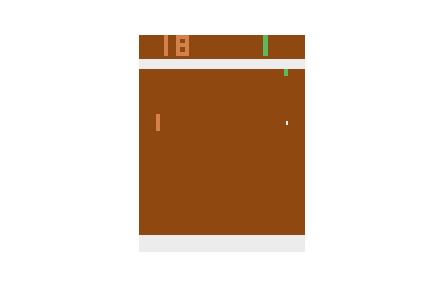
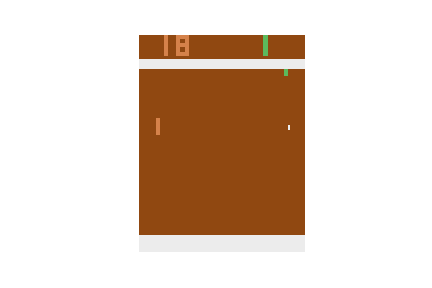
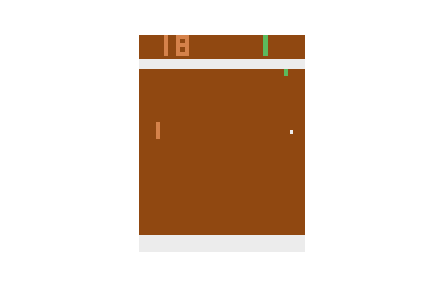
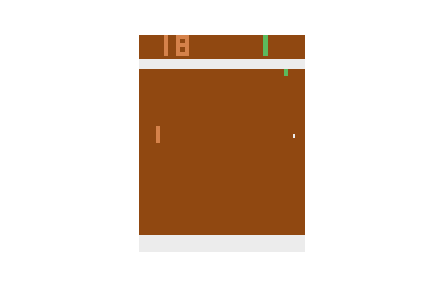
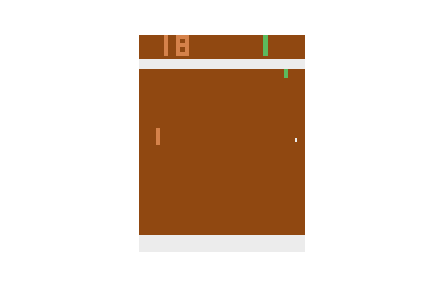
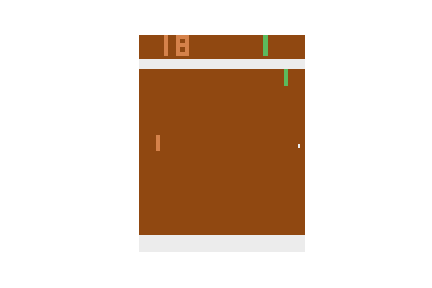
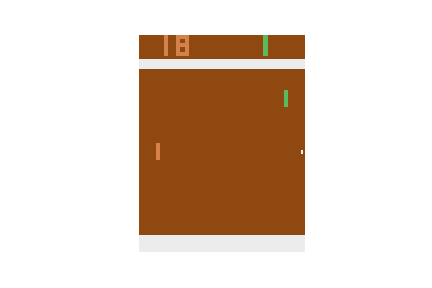
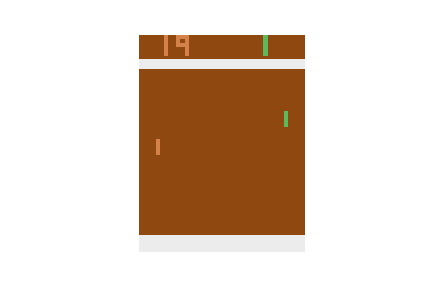
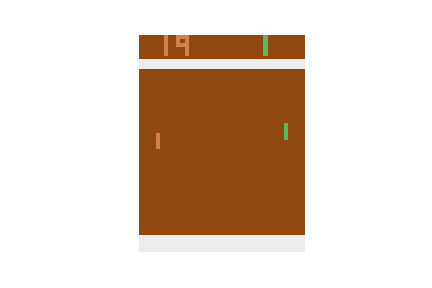
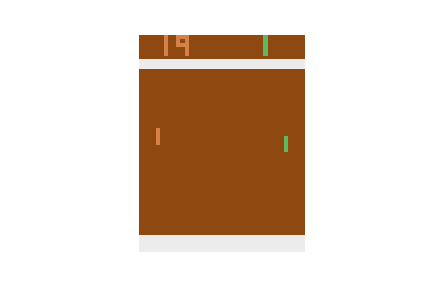
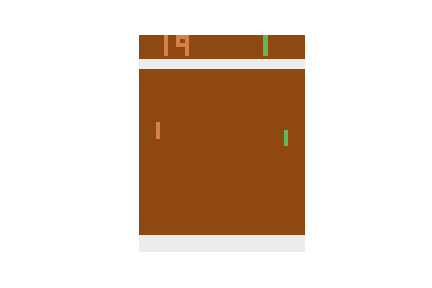
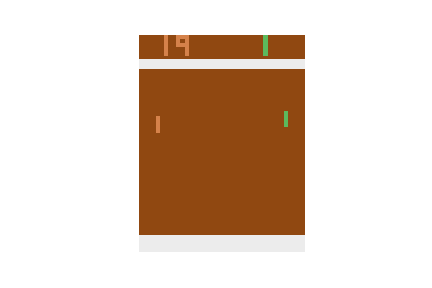
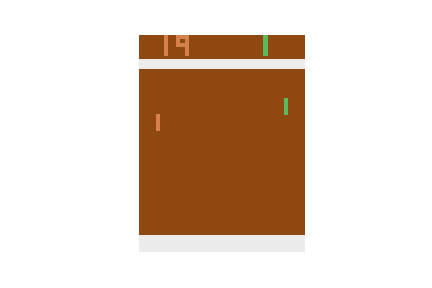
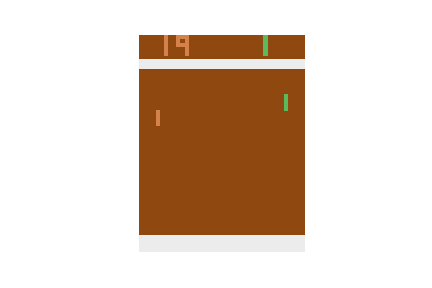
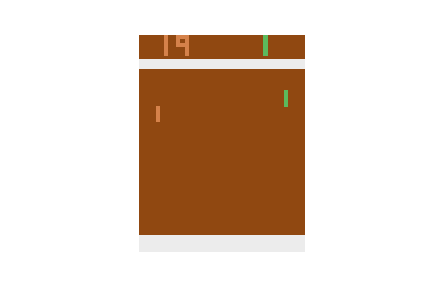
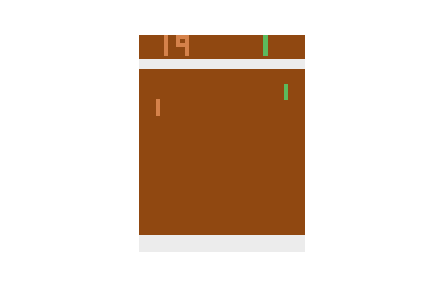
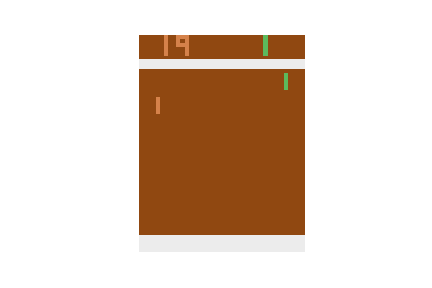
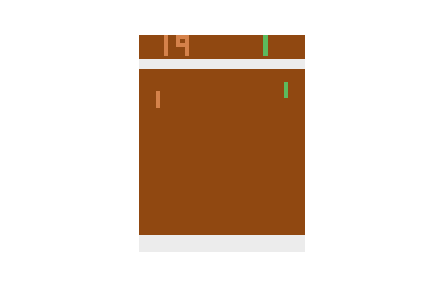
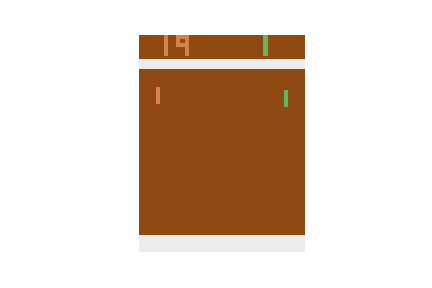
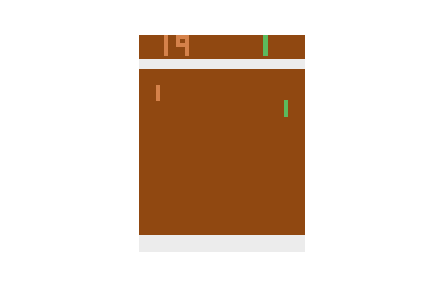
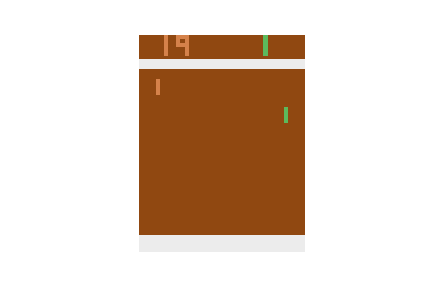
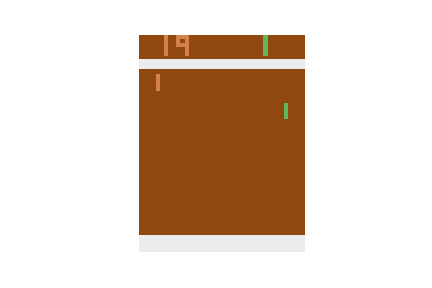
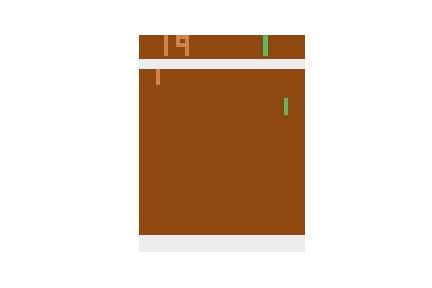
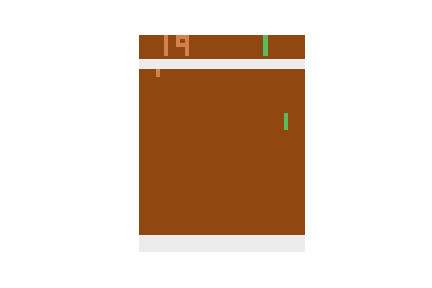
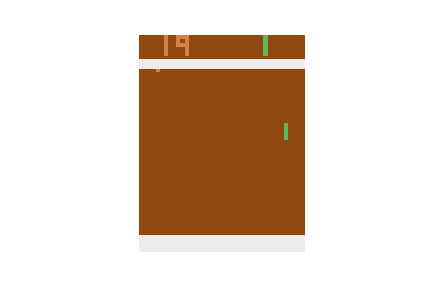
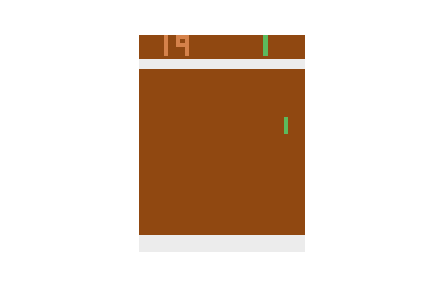
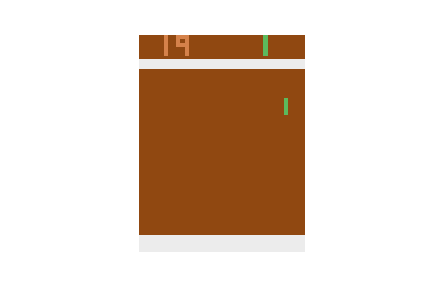
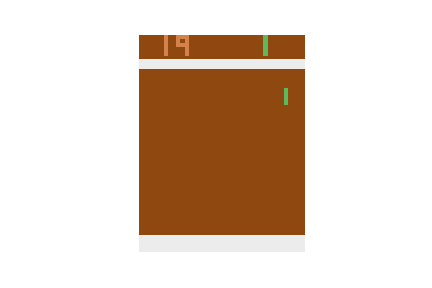
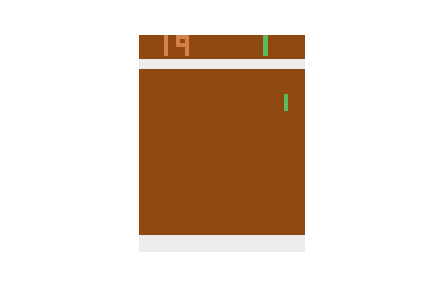
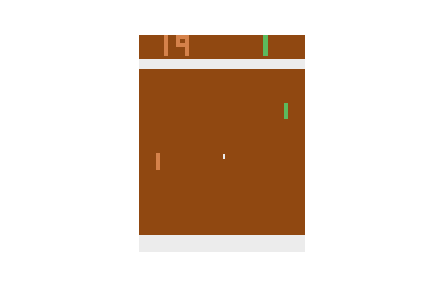
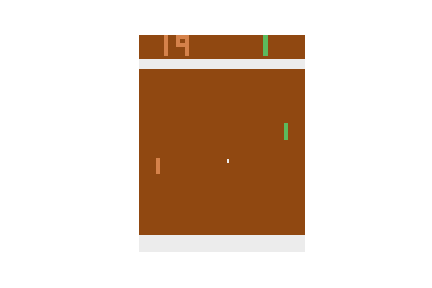
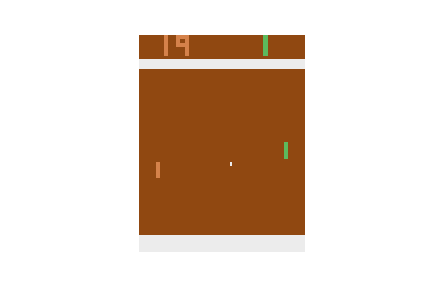
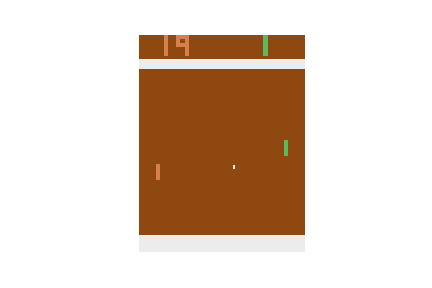
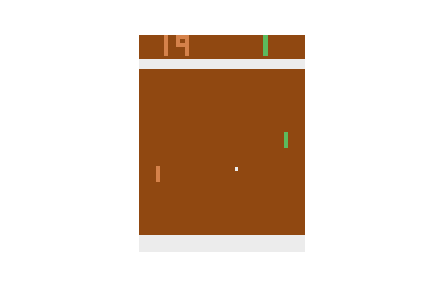
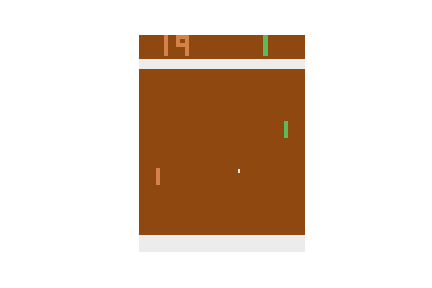
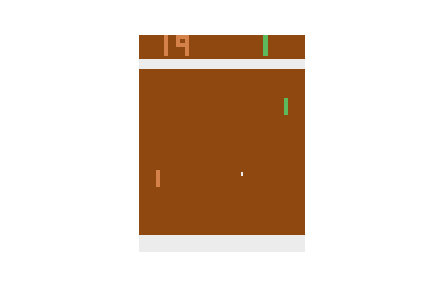
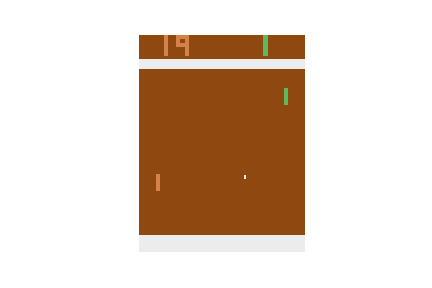
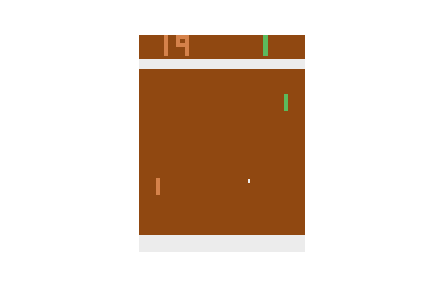
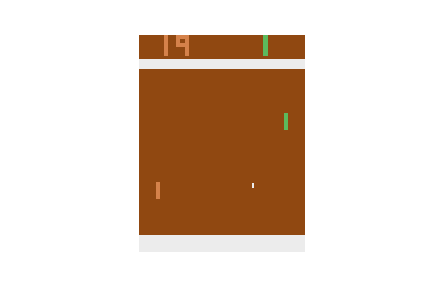
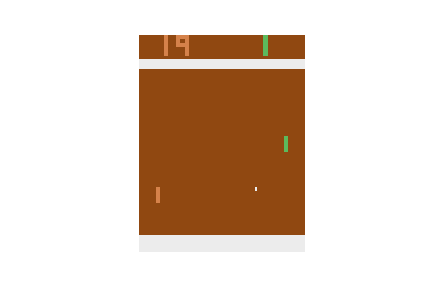
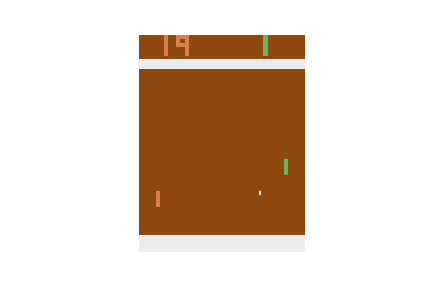
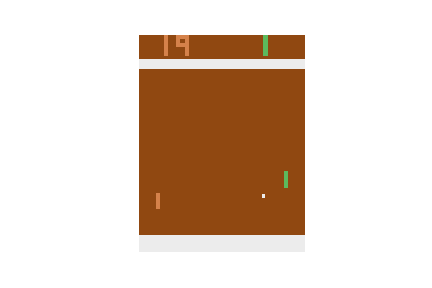
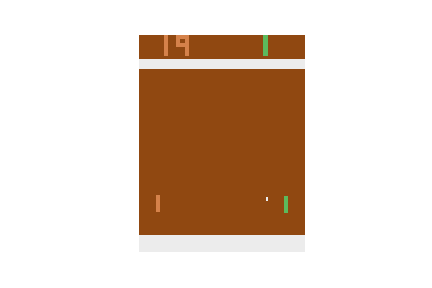
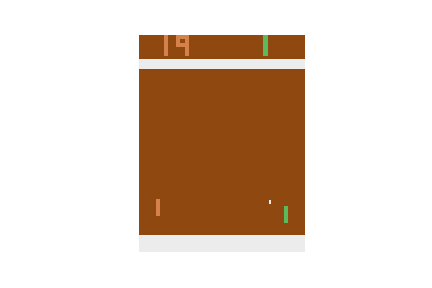
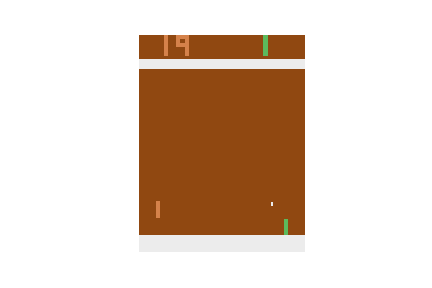
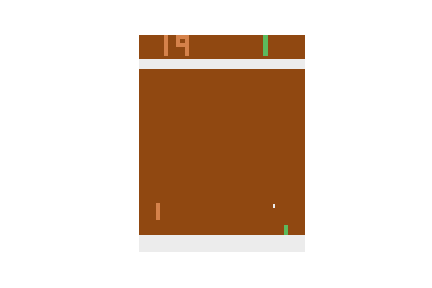
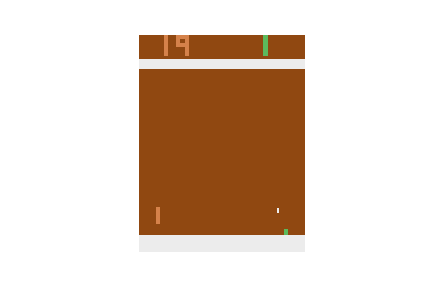
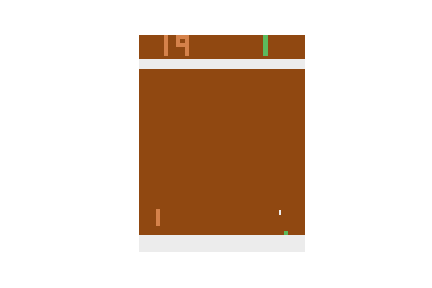
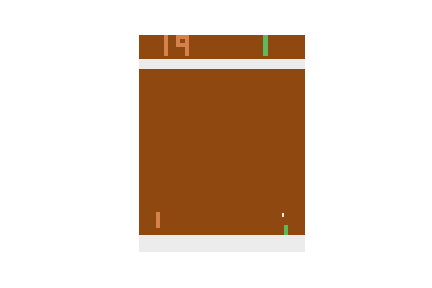
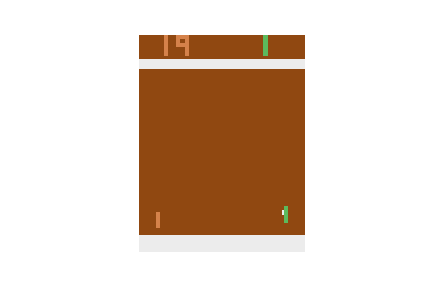
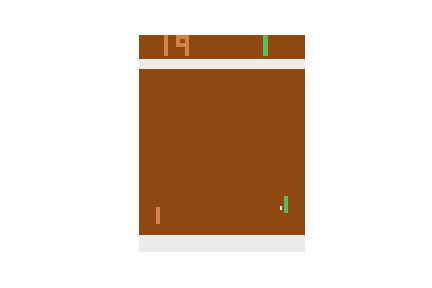
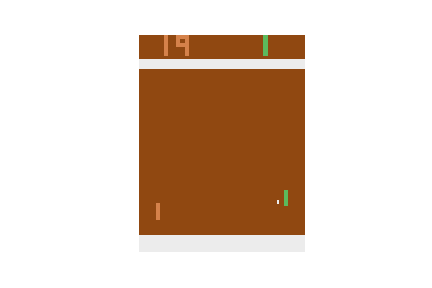
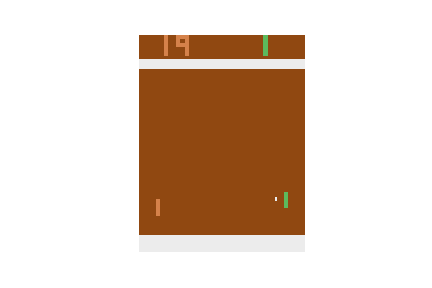
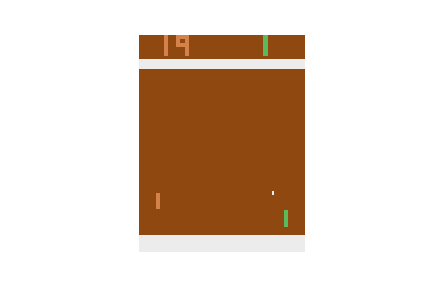
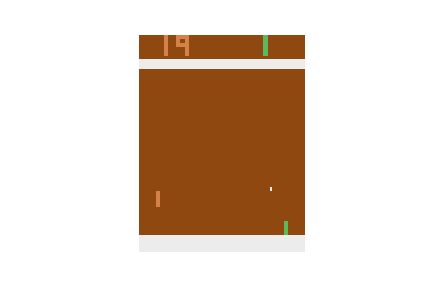
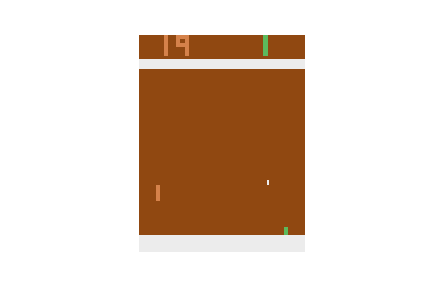
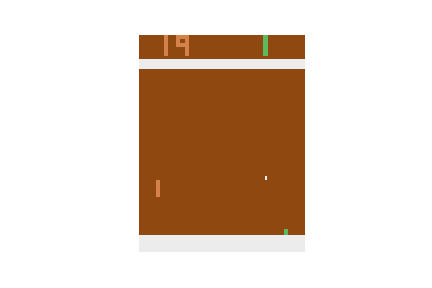
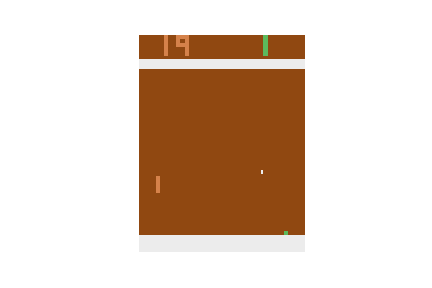
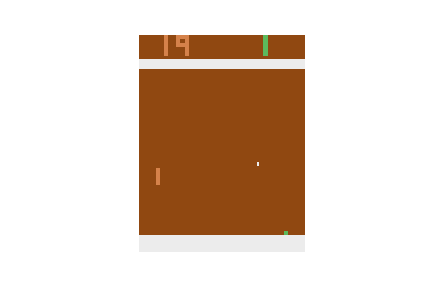
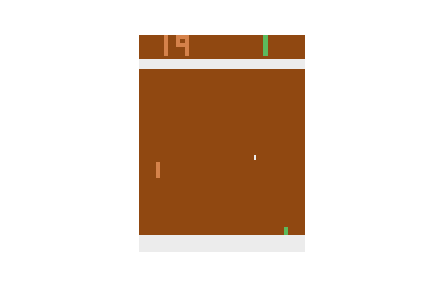
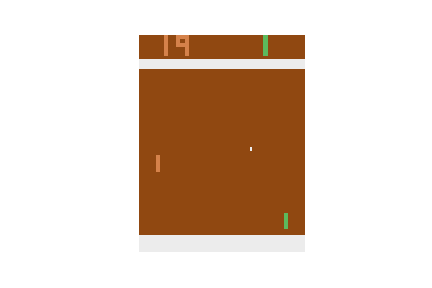
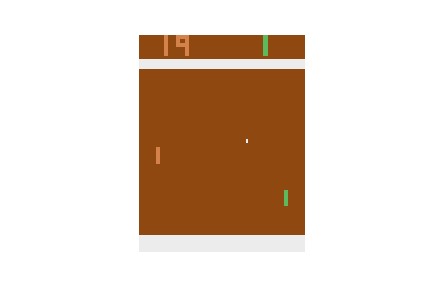
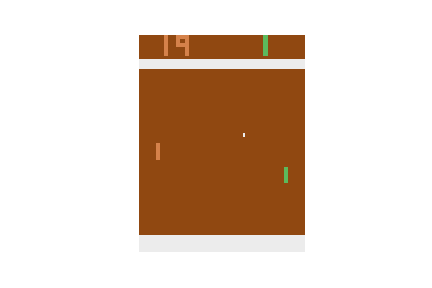
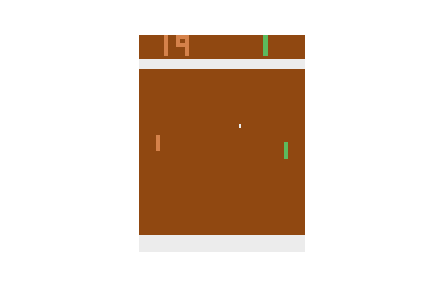
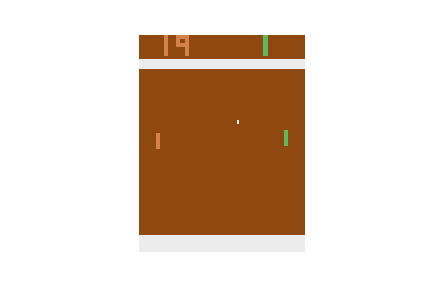
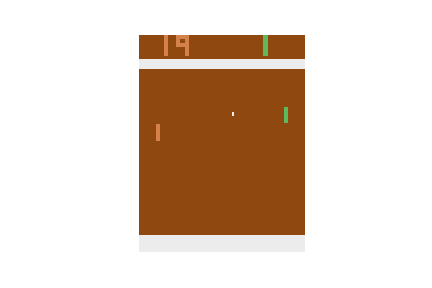
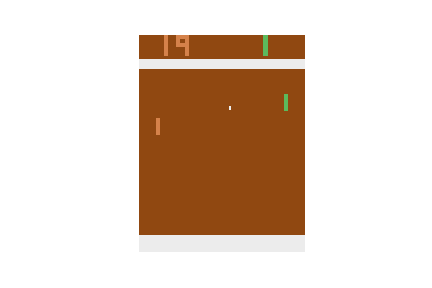
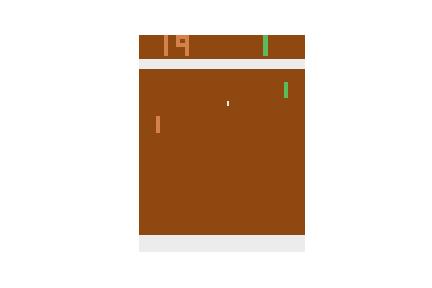
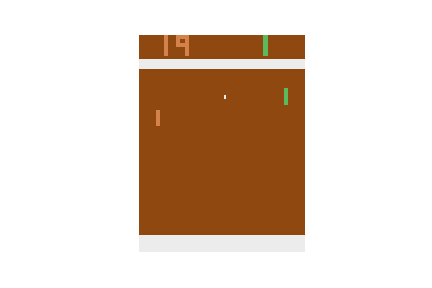
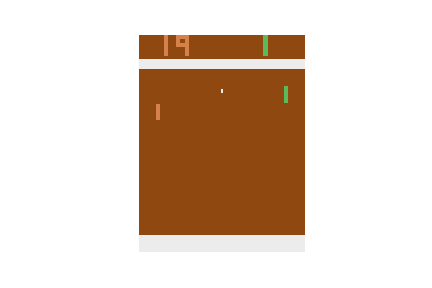
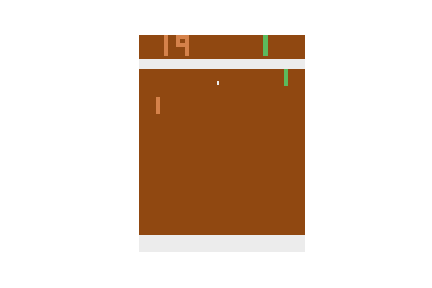
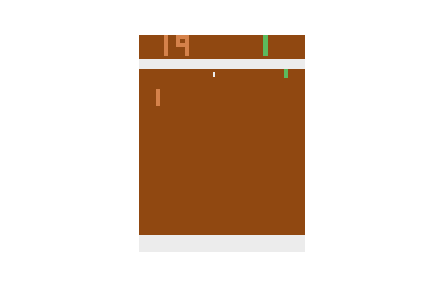
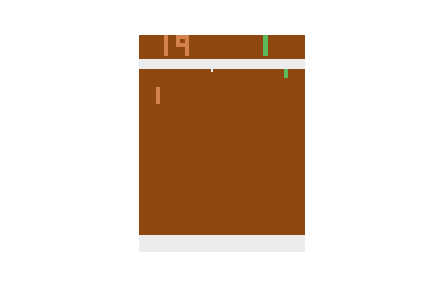
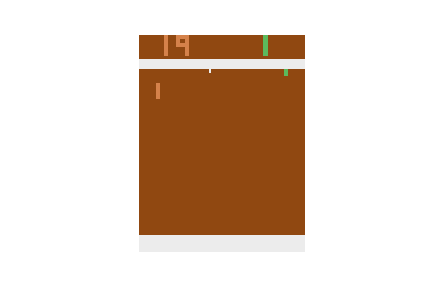
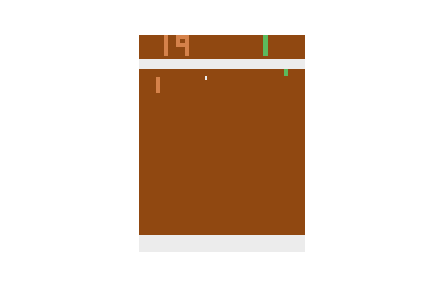
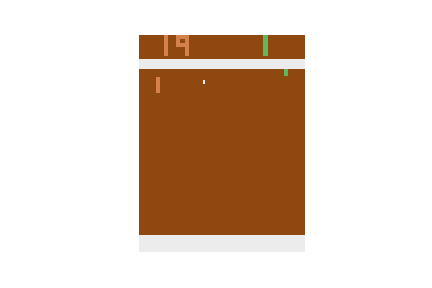
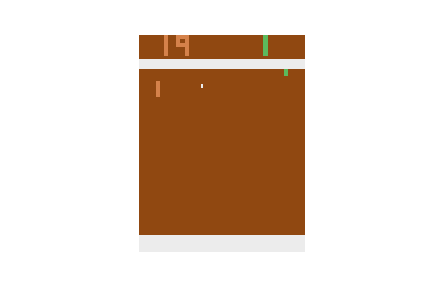
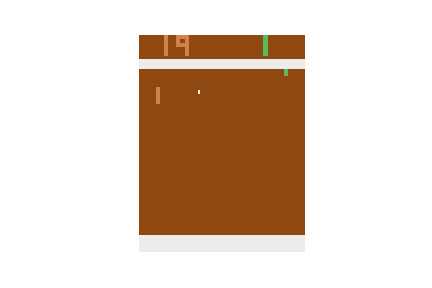
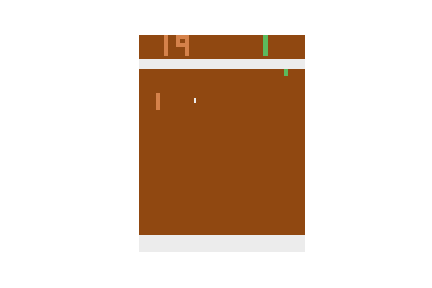
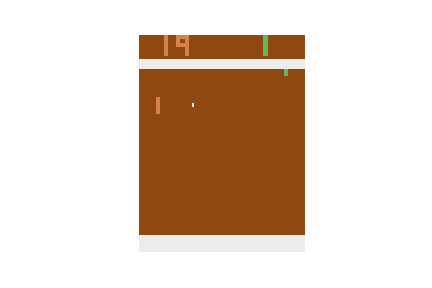
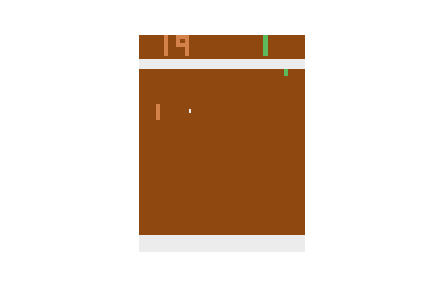
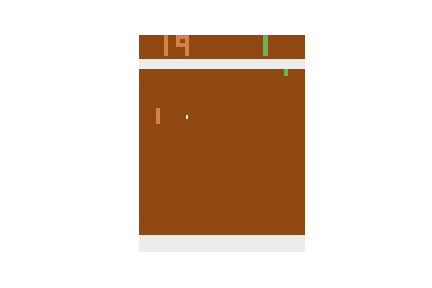
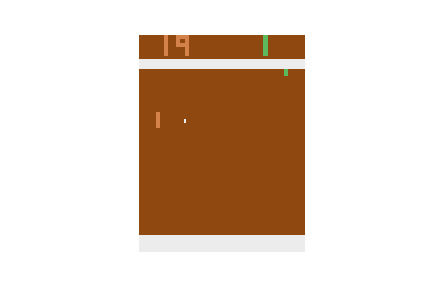
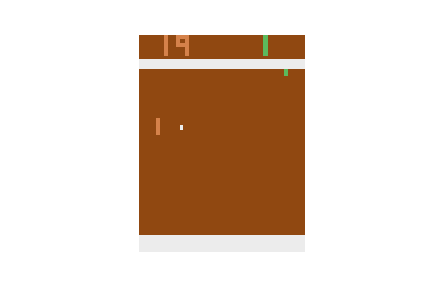
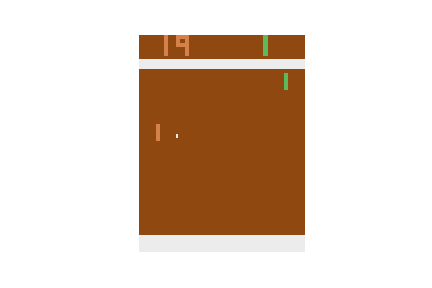
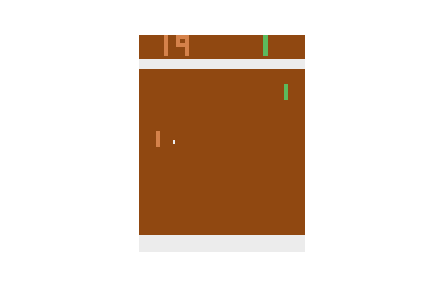
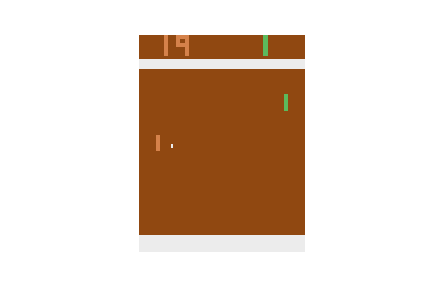
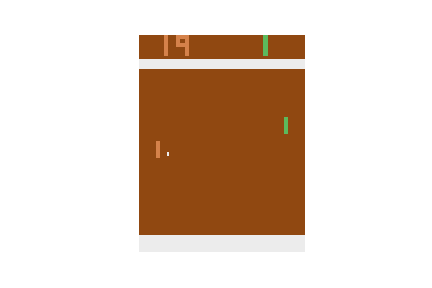
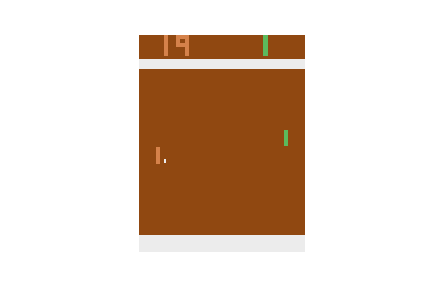
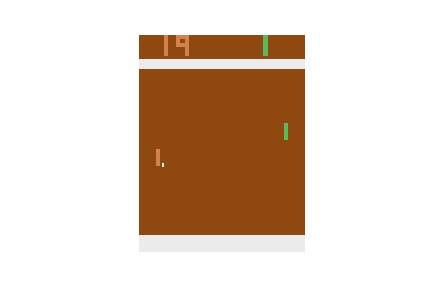
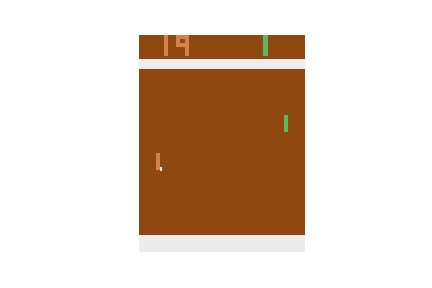
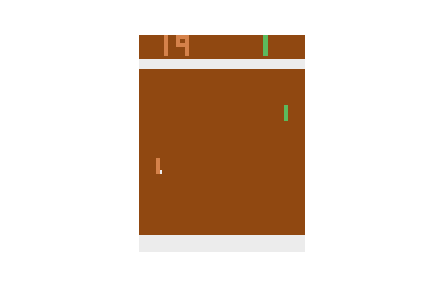
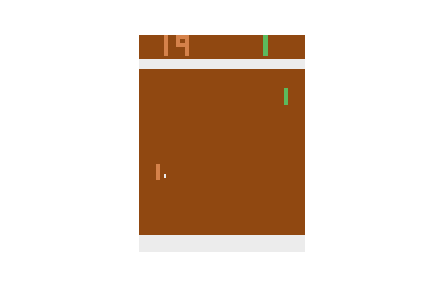
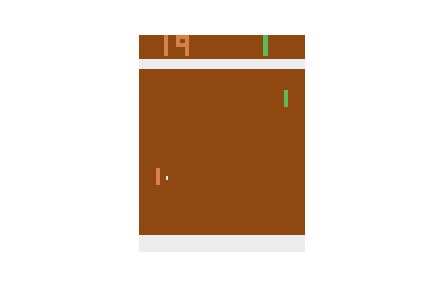
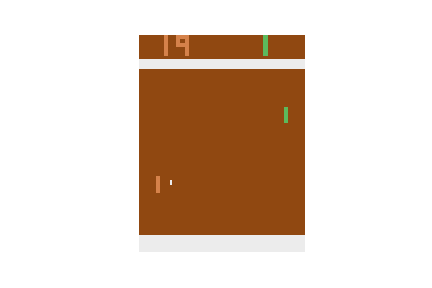
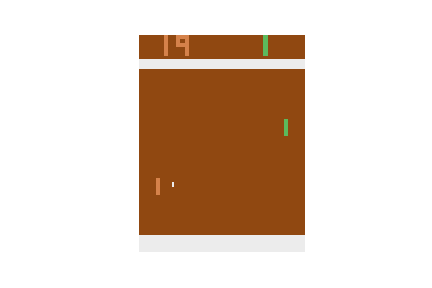
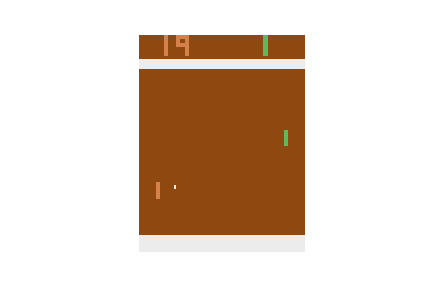
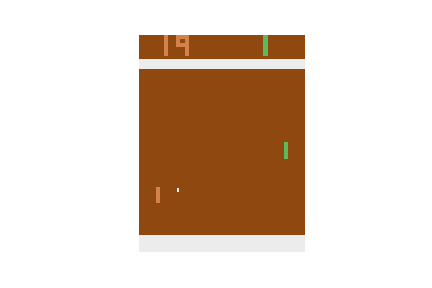
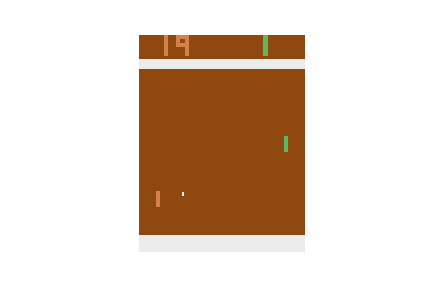
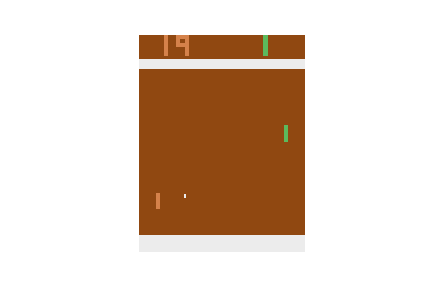
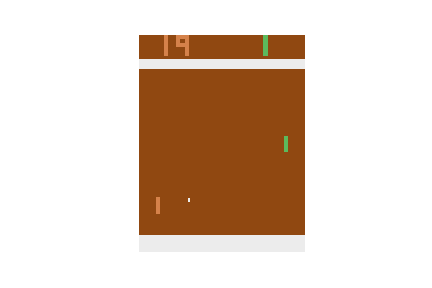
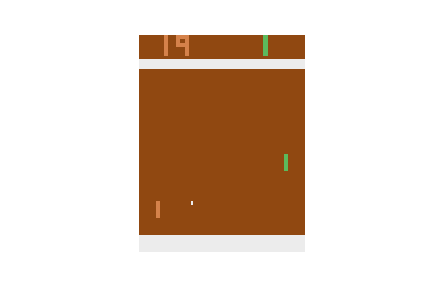
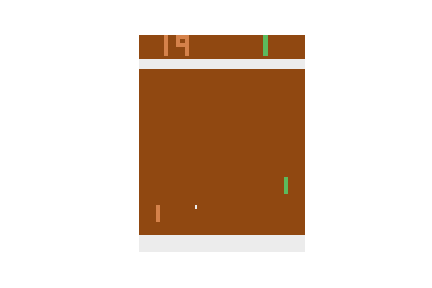
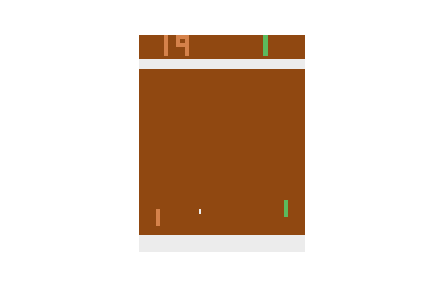
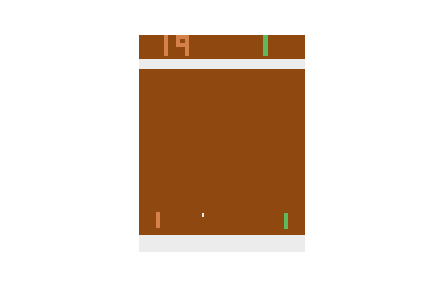
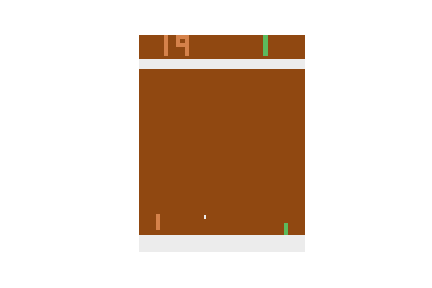
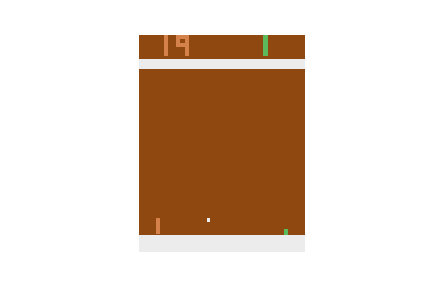
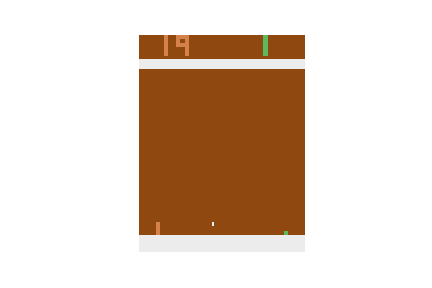
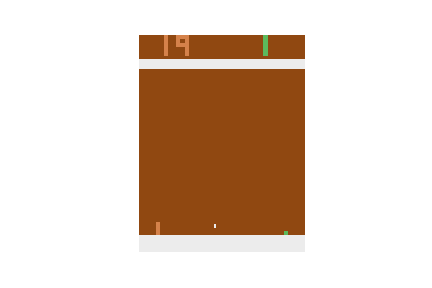
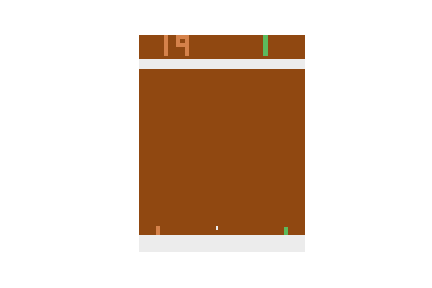
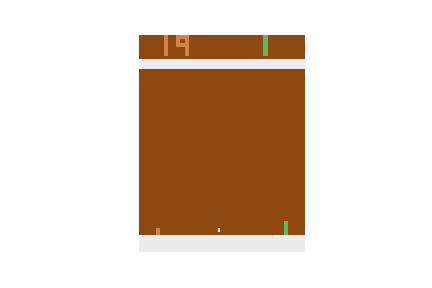
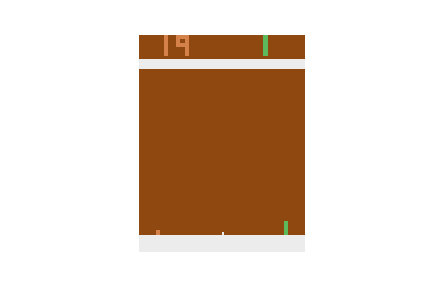
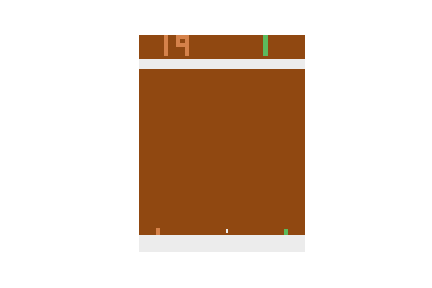
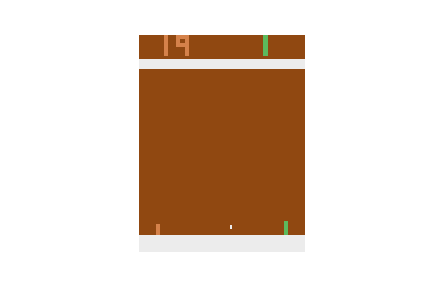
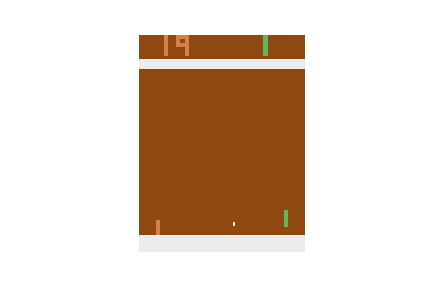
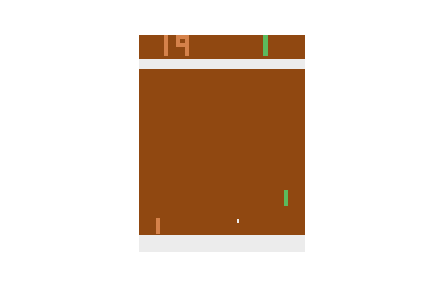
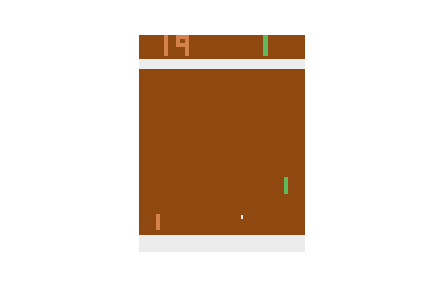
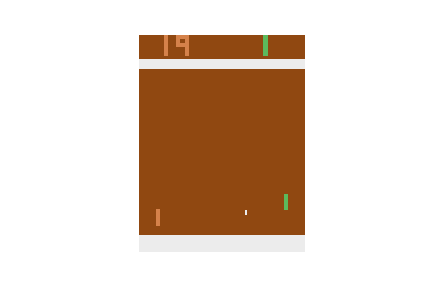
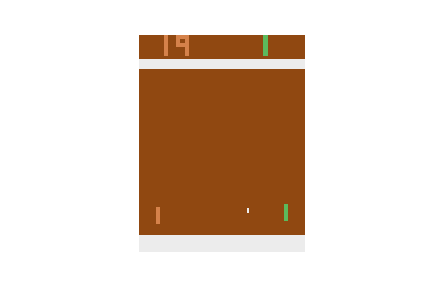
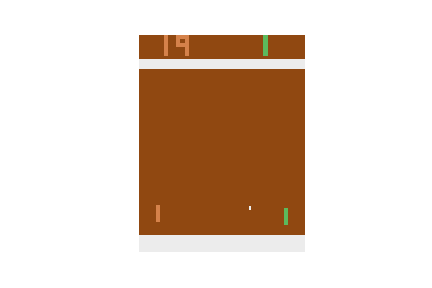
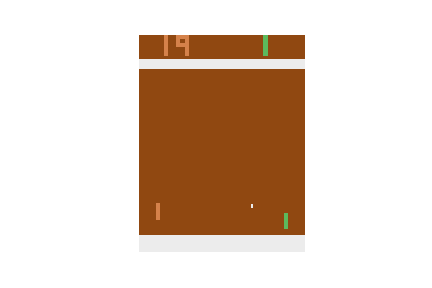
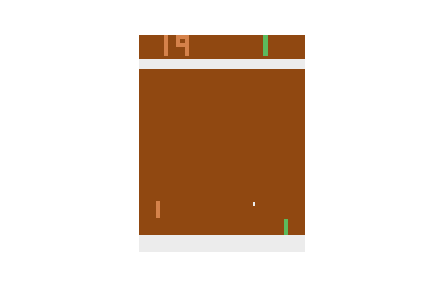
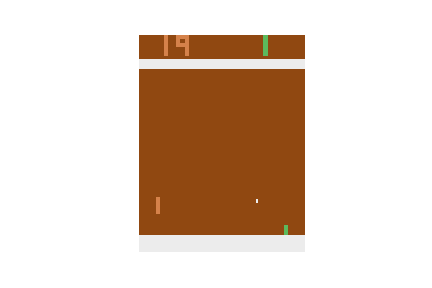
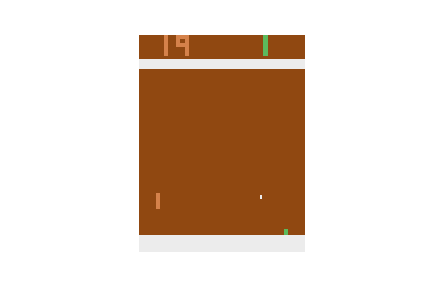
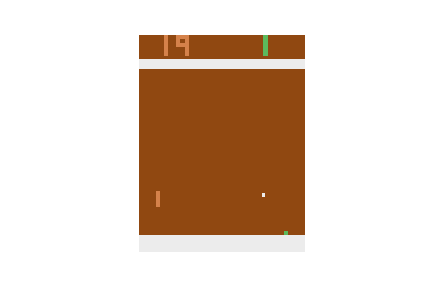
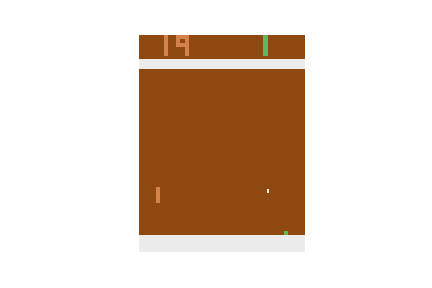
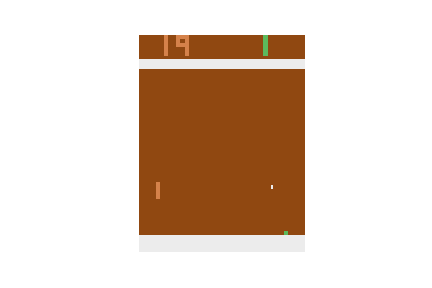
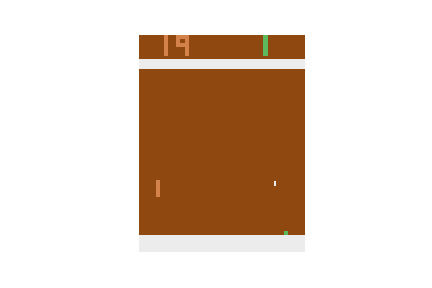
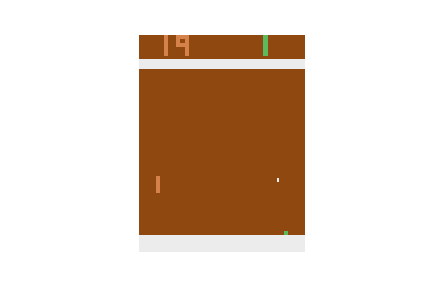
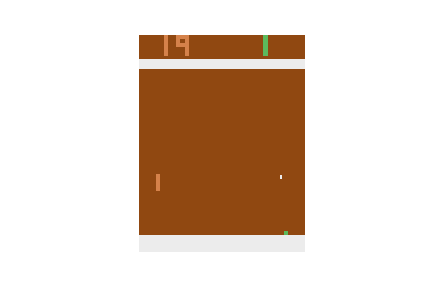
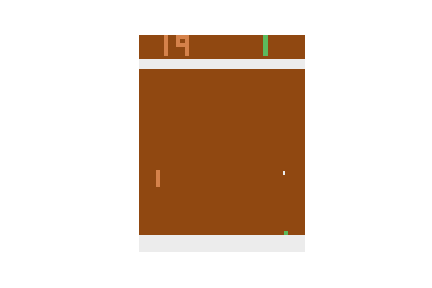
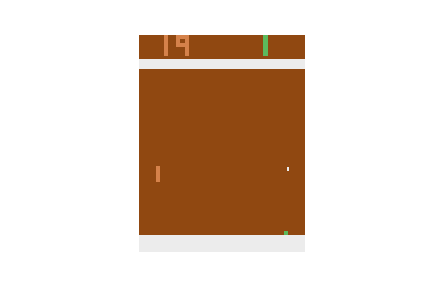
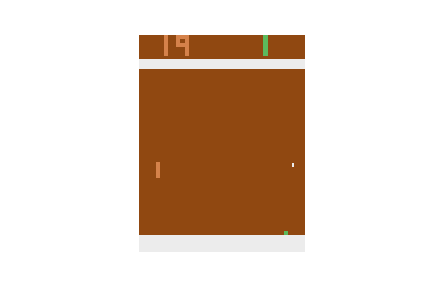
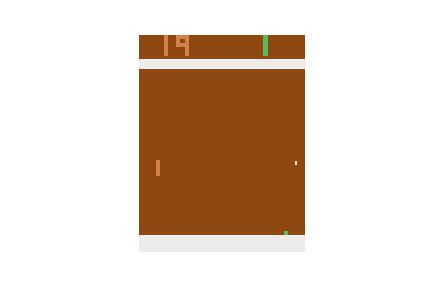
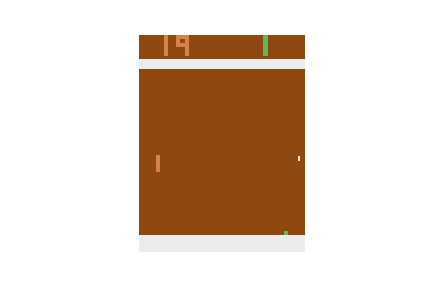
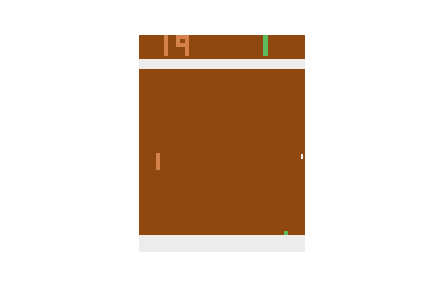
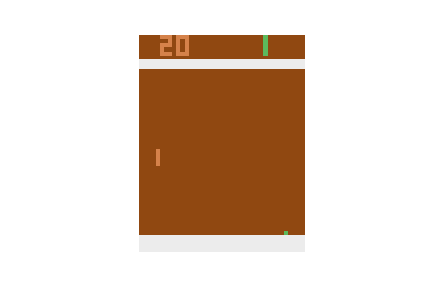
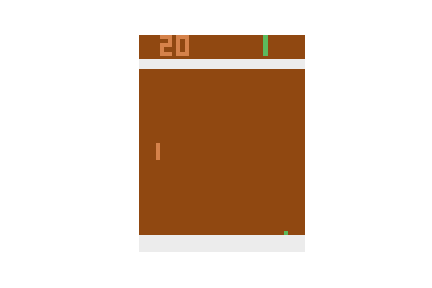
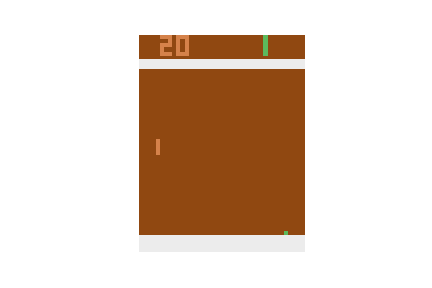
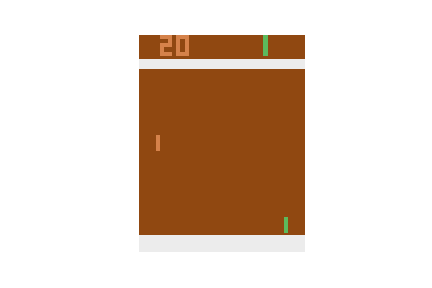
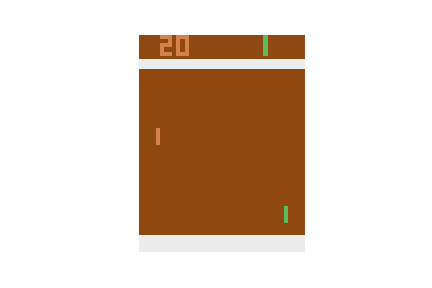
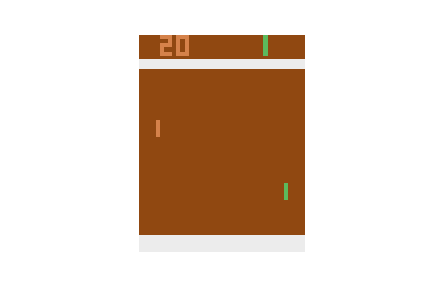
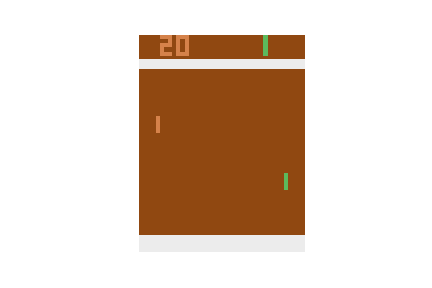
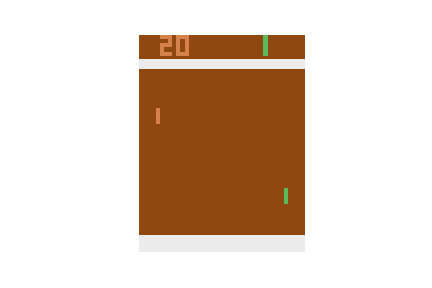
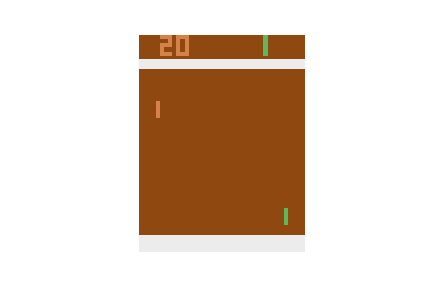
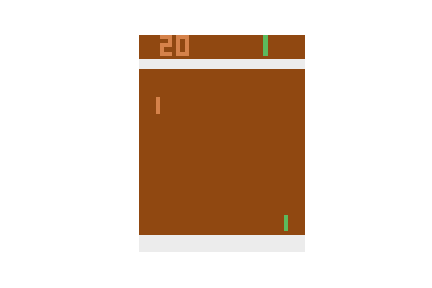
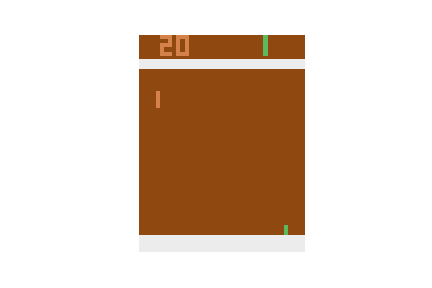
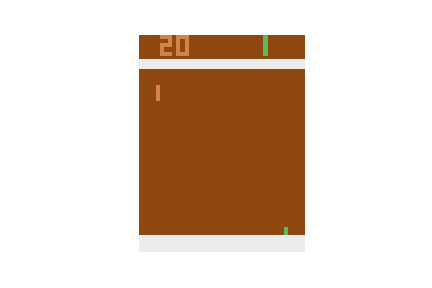
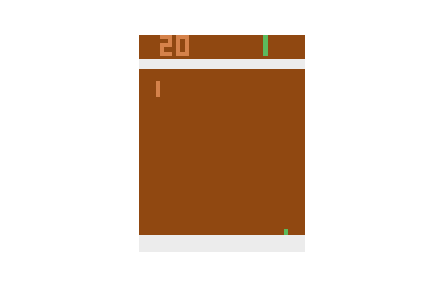
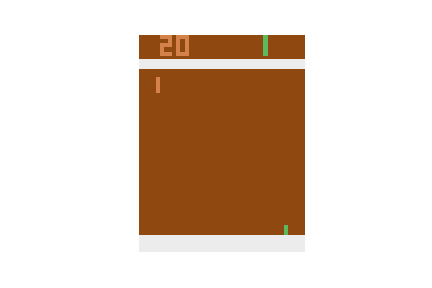
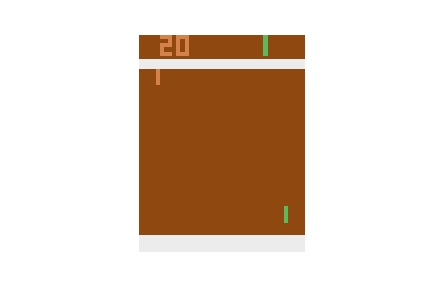
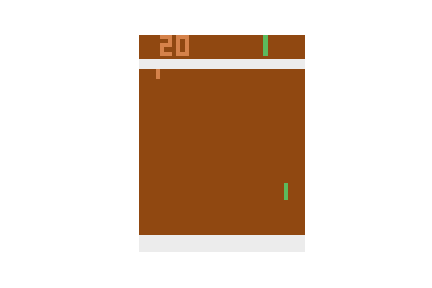
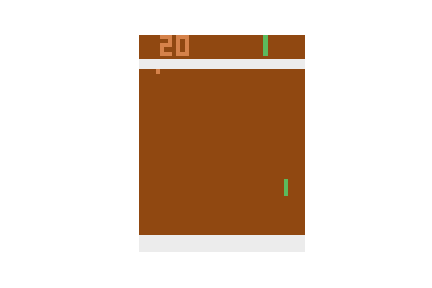
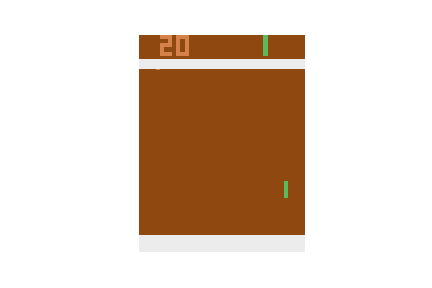
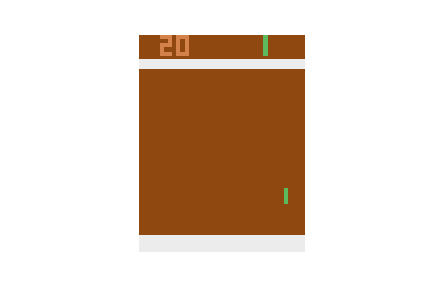
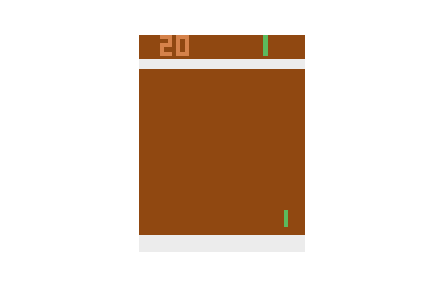
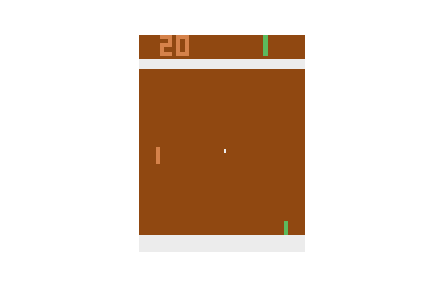
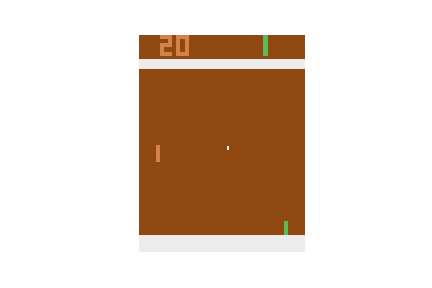
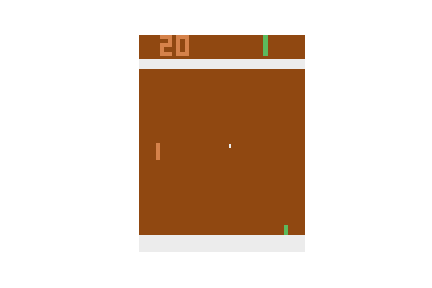
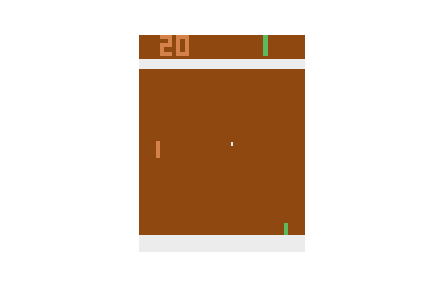
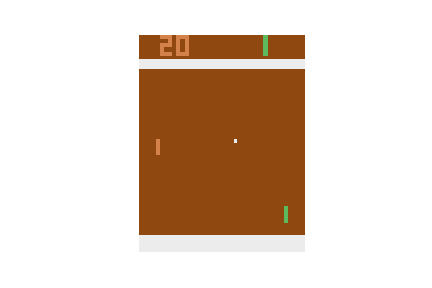
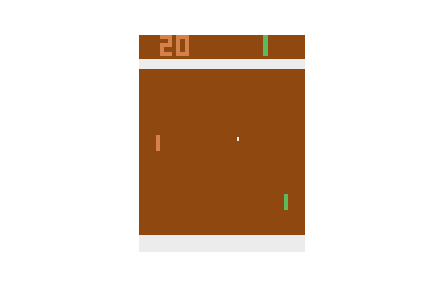
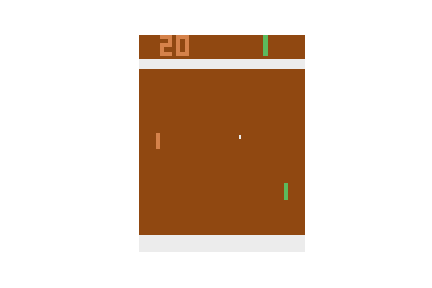
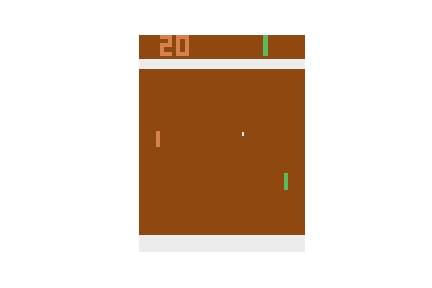
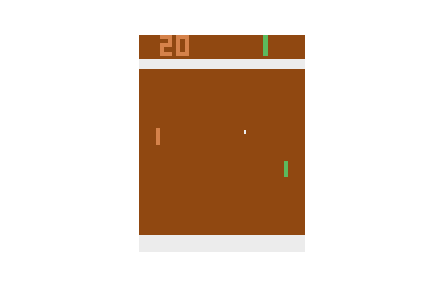
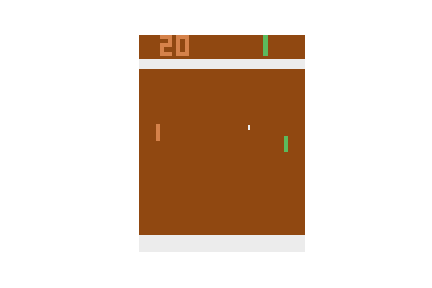
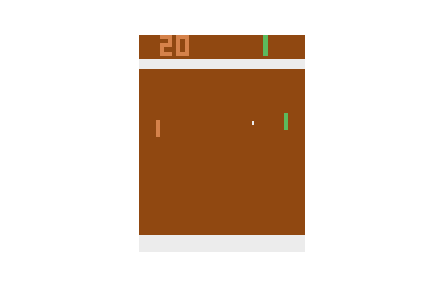
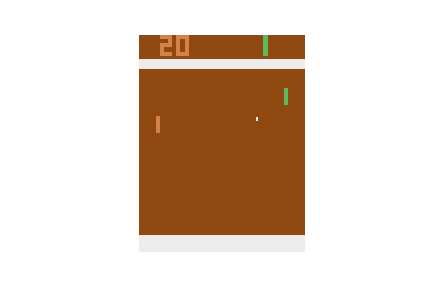
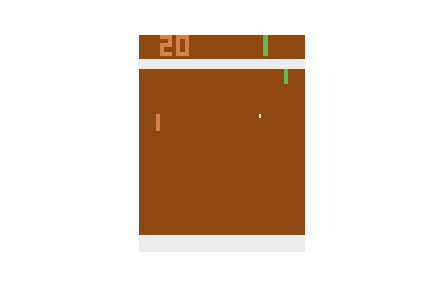
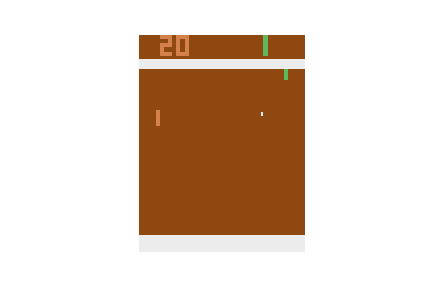
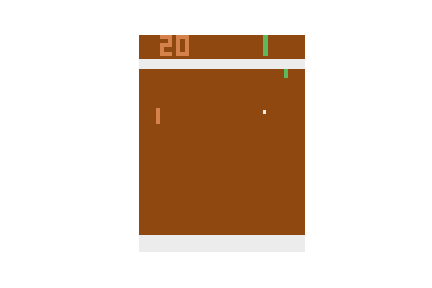
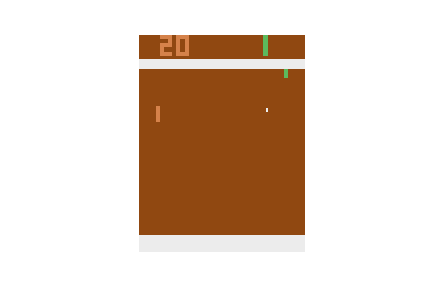
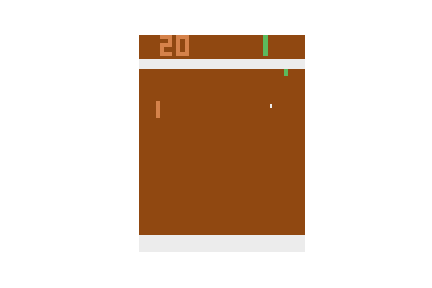
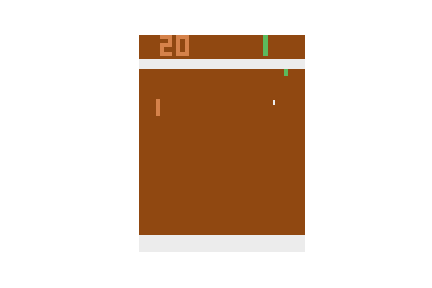
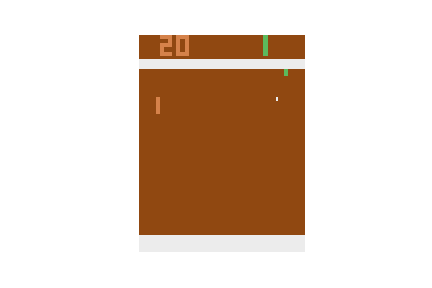
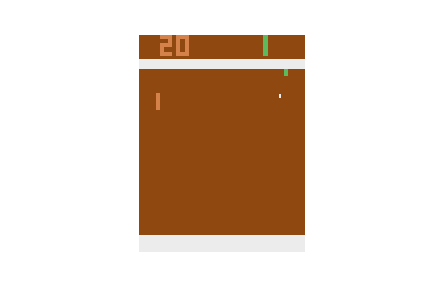
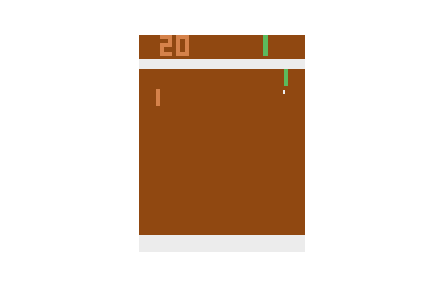
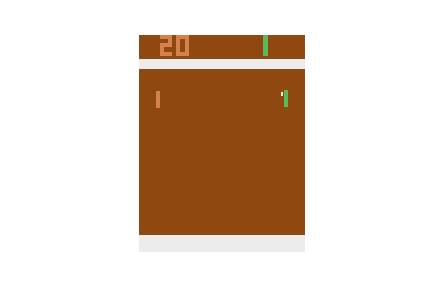
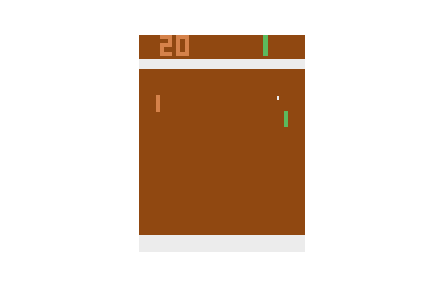
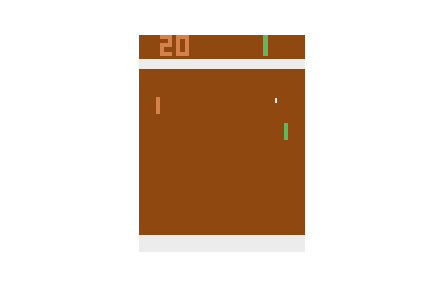
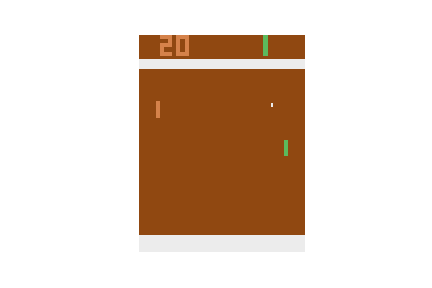
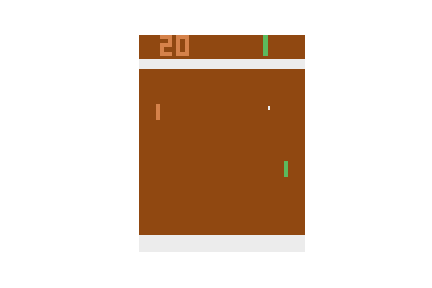
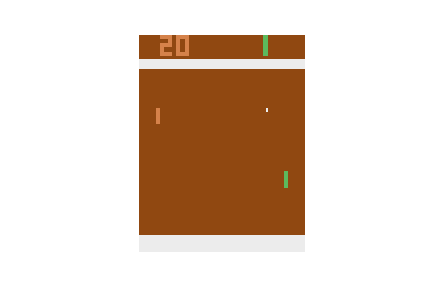
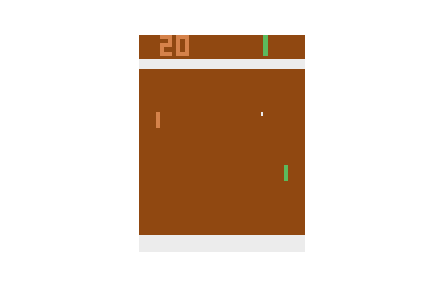
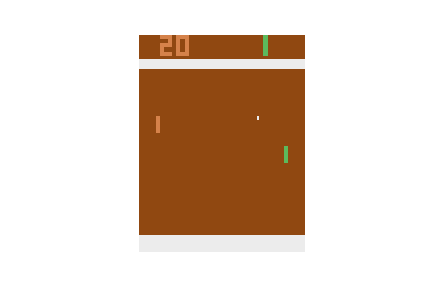
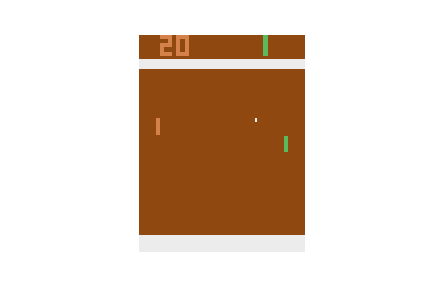
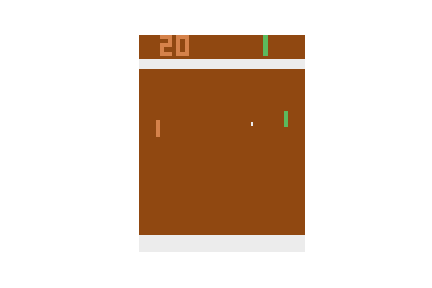
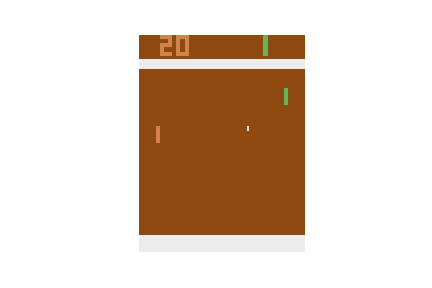
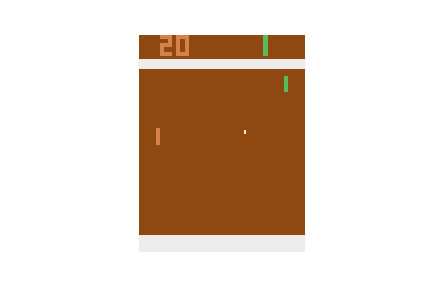
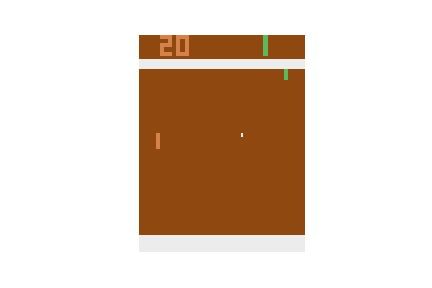
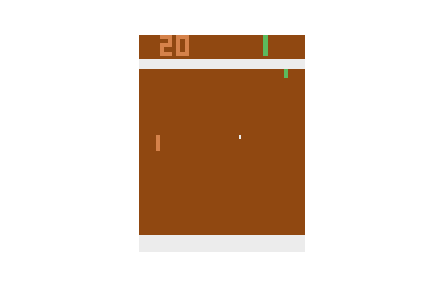
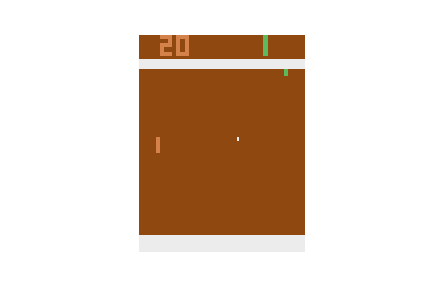
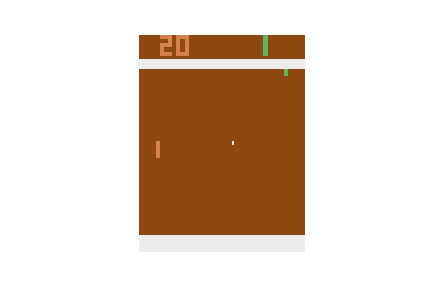
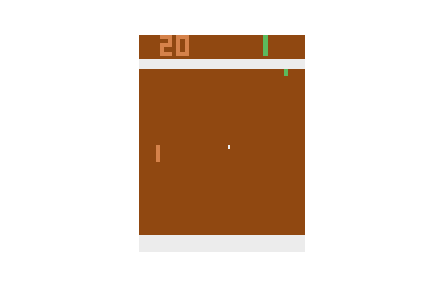
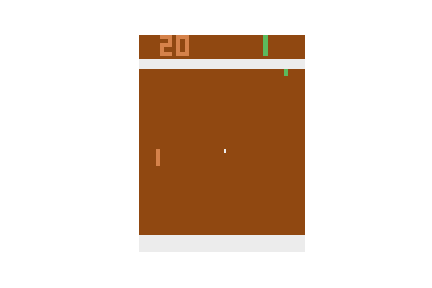
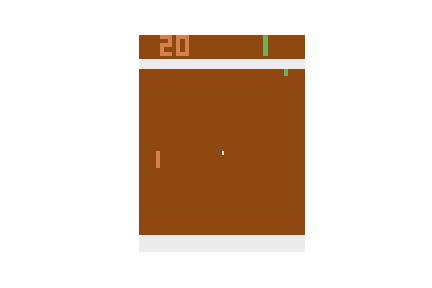
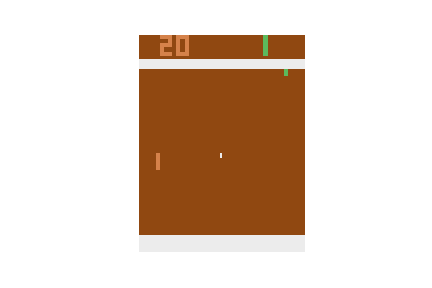
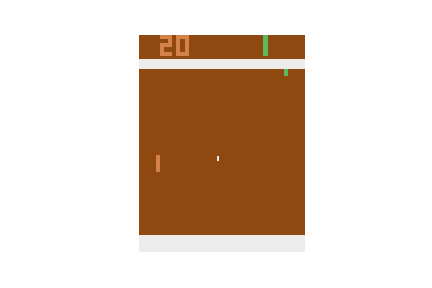
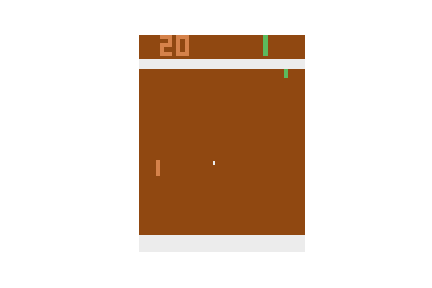
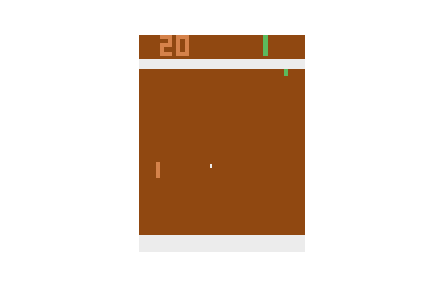
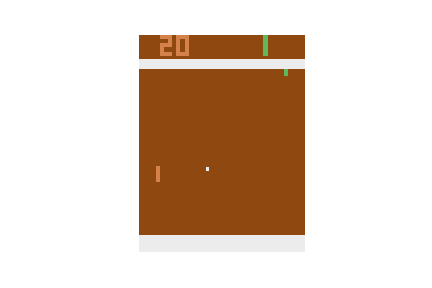
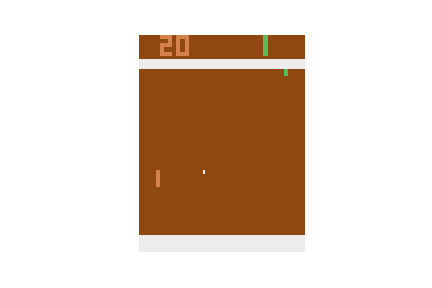
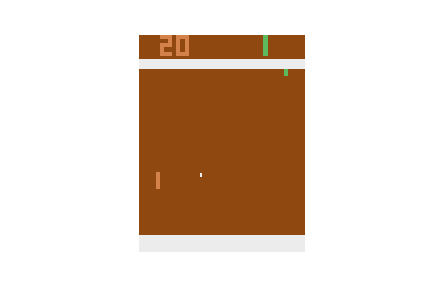
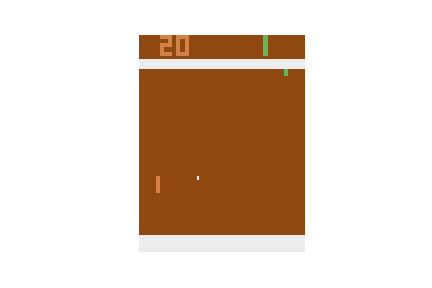
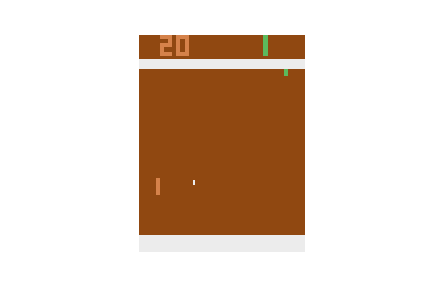
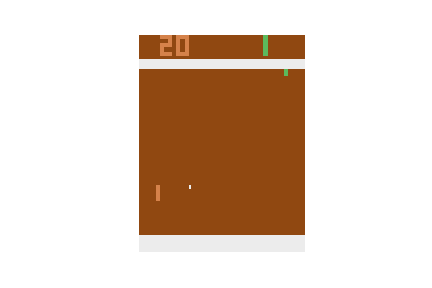
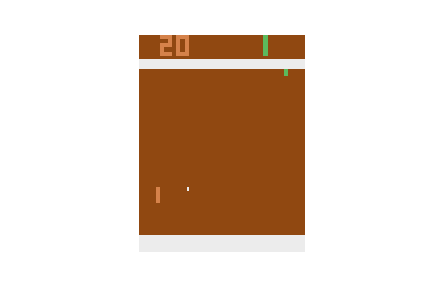
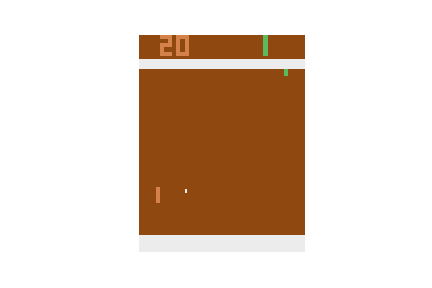
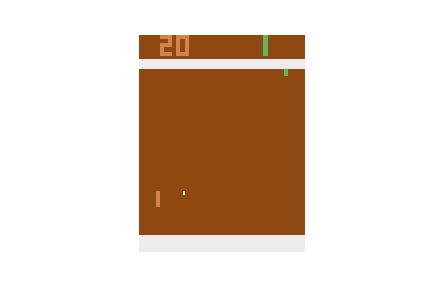
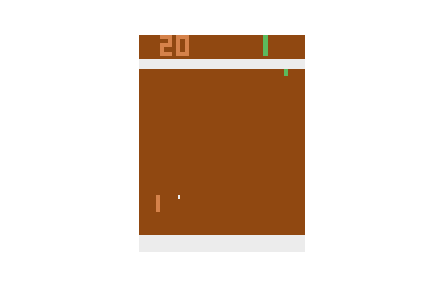
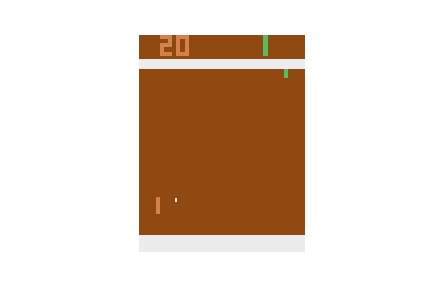
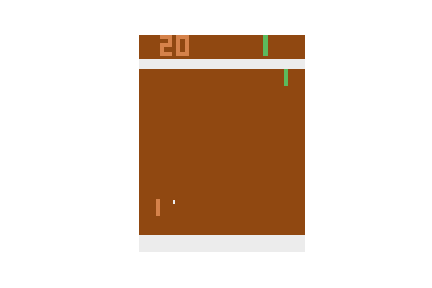
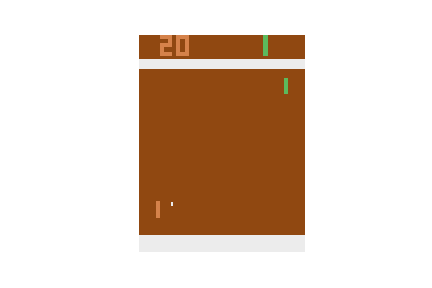
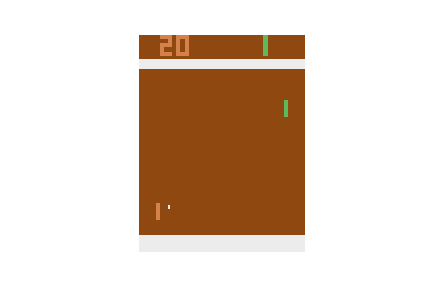
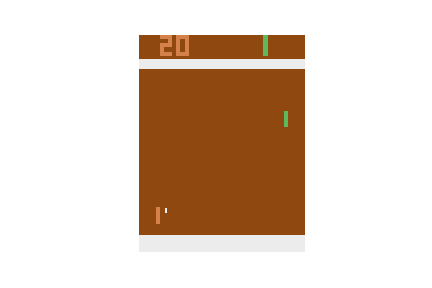
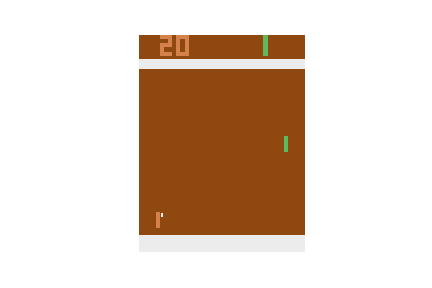
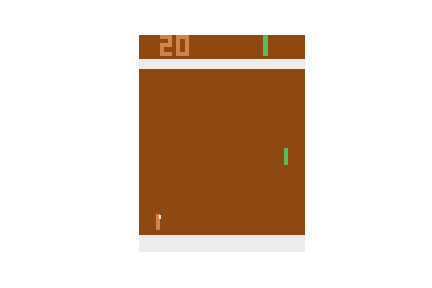
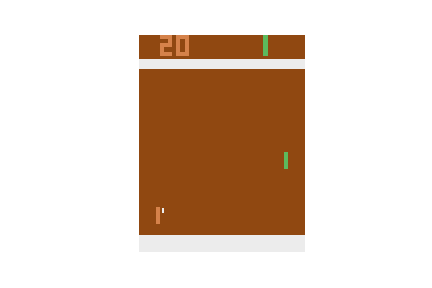
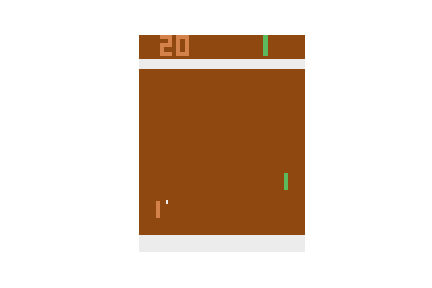
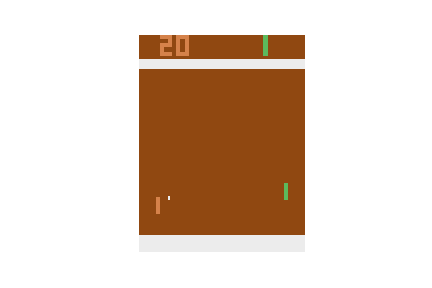
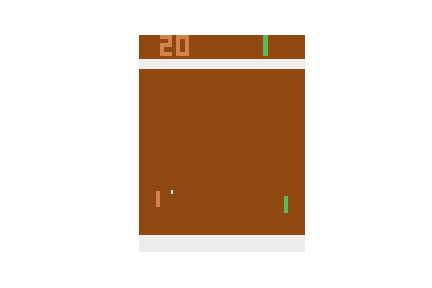
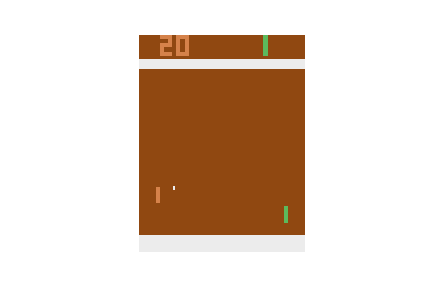
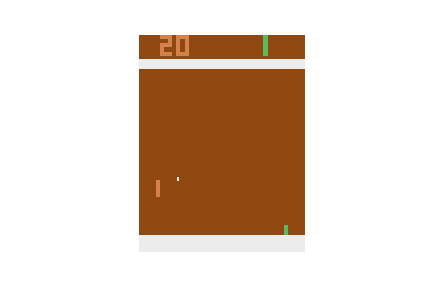
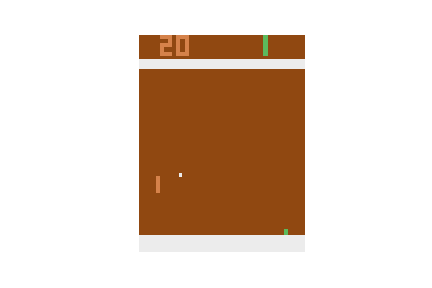
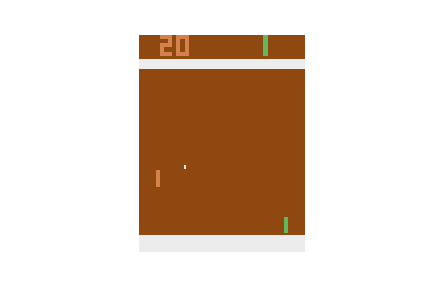
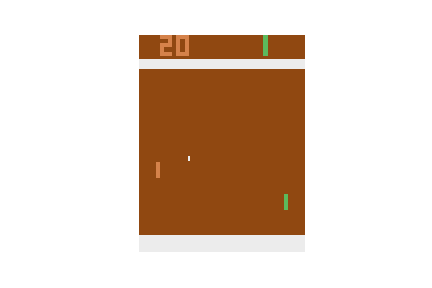
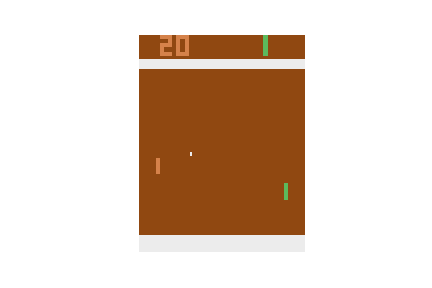
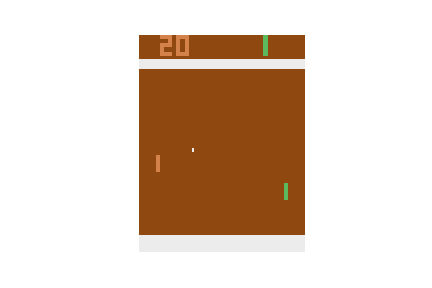
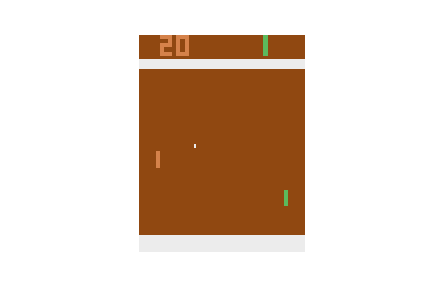
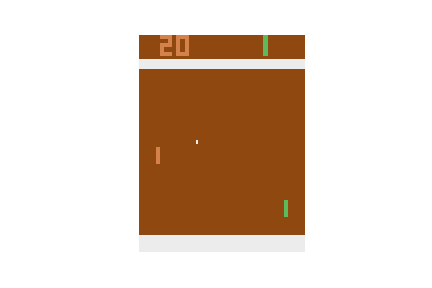
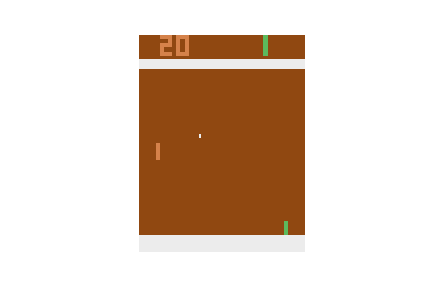
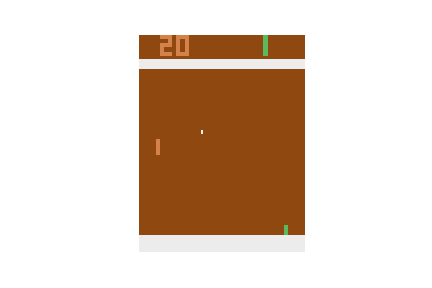
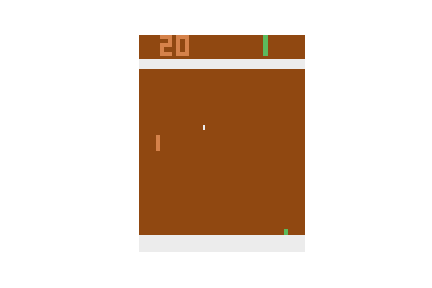
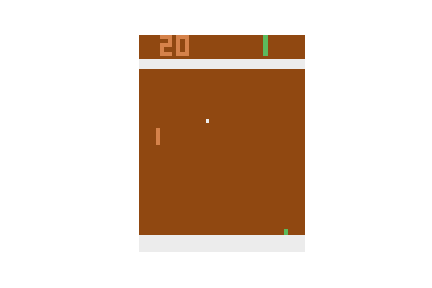
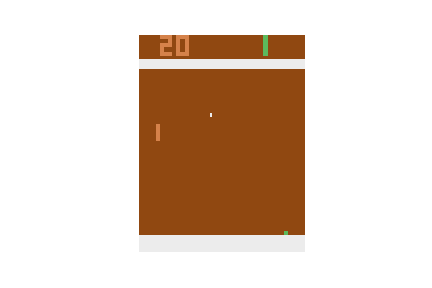
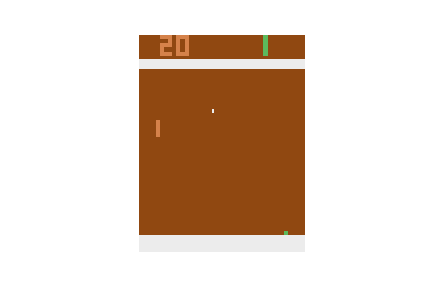
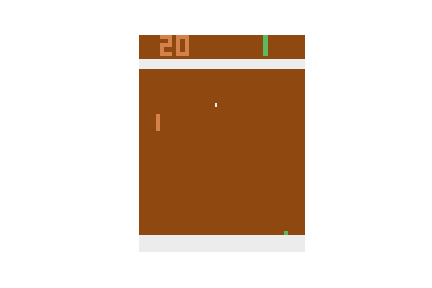
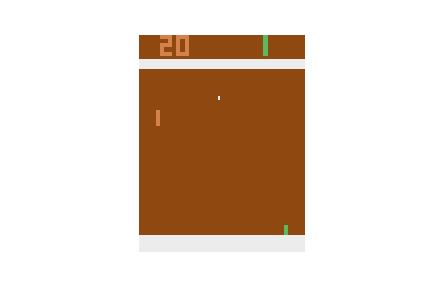
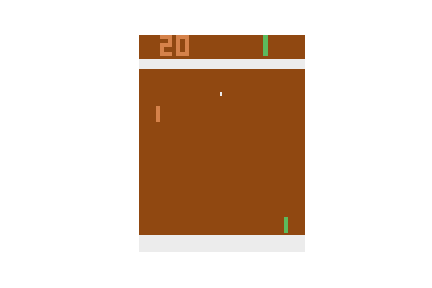
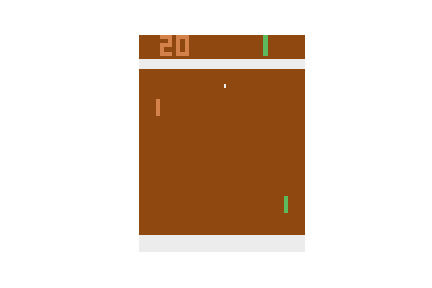
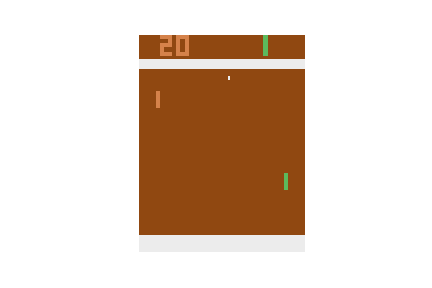
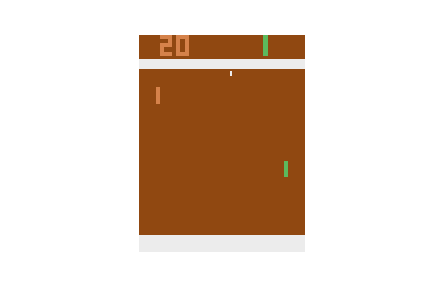
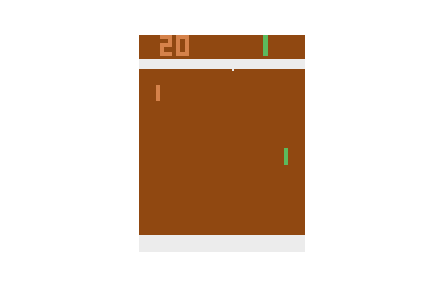
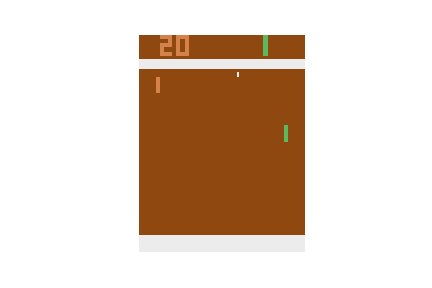
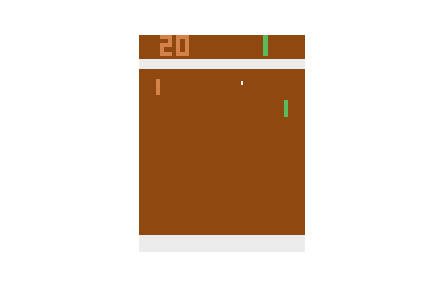
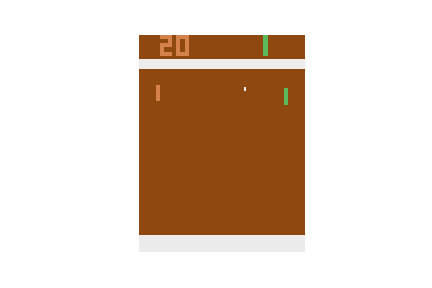
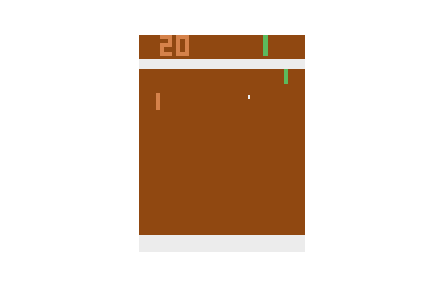
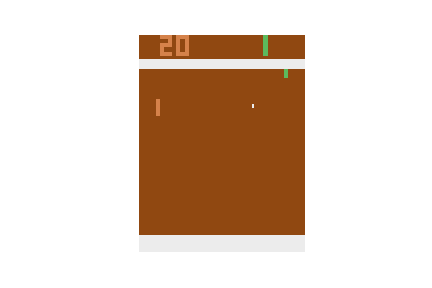
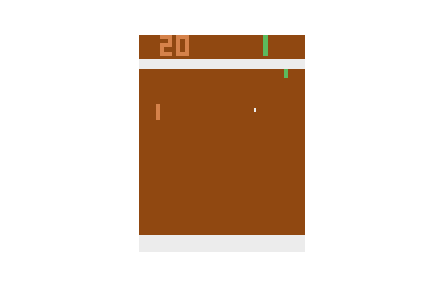
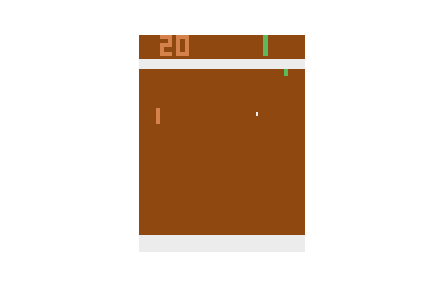
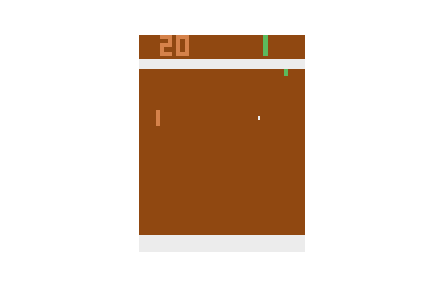
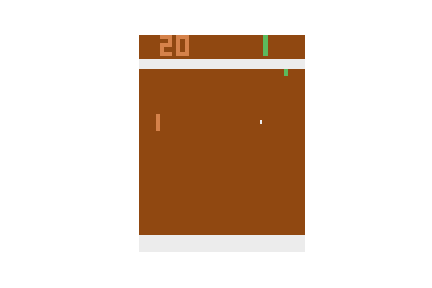
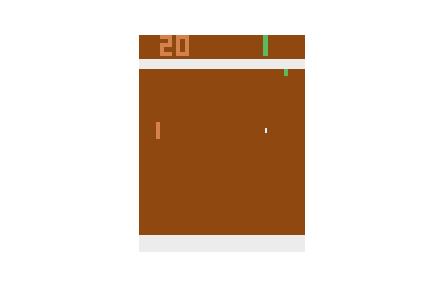
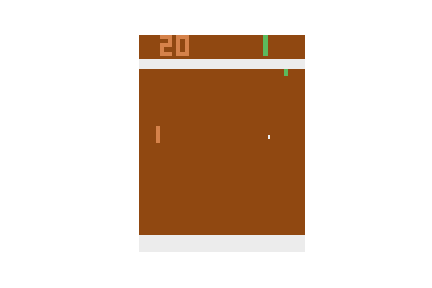
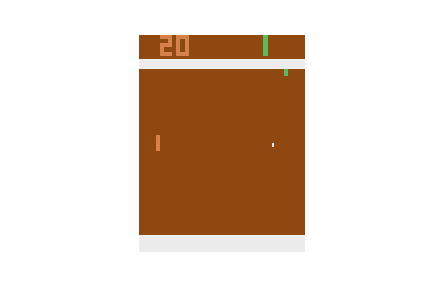
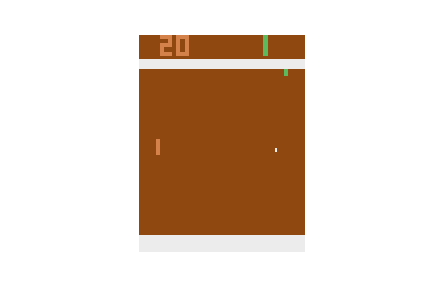
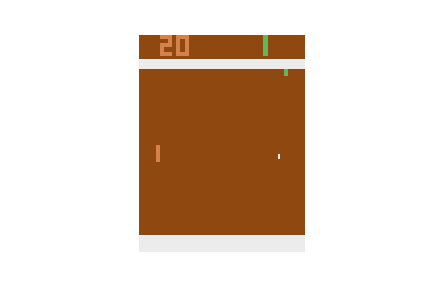
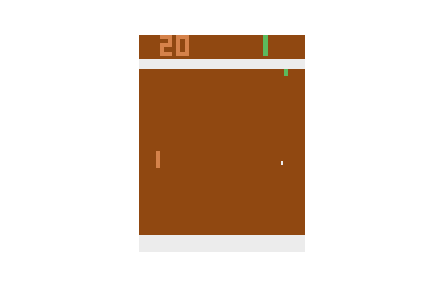
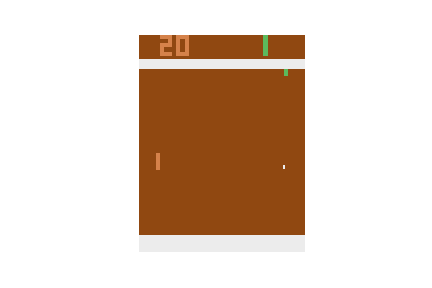
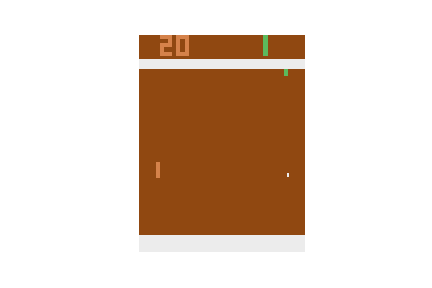
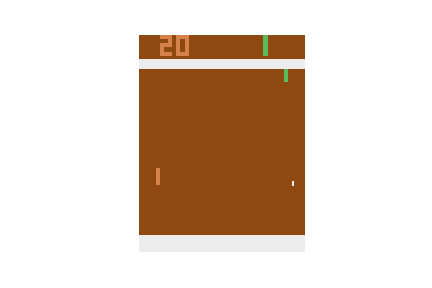
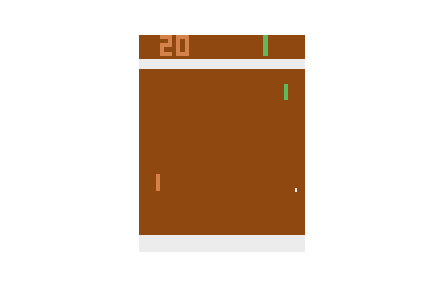
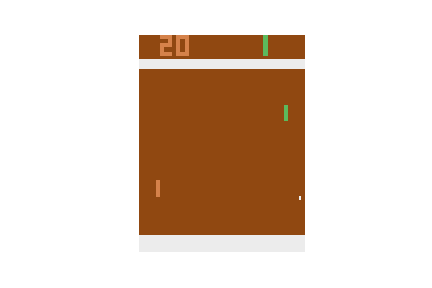
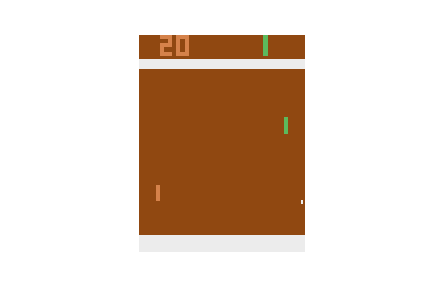

2600


In [82]:
observation = env.reset()
cum_reward = 0
frames = []
prev_frame = None
for t in range(5000):
    x = preprocess(observation) 
    diff = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    p = model.predict(diff[None,:,:,:])
    prev_frame = x
    action = 2 if np.random.uniform() < p[0][0] else 3 # roll the dice!
    
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    observation, reward, done, info = env.step(action)
    if done:
        break
        
# env.render(close=True)
display_frames_as_gif(frames)
print(t)